In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
# Apply the function to the 'pitch_type' column
training_data = data.query('swing == 1')

# Apply the function to the 'pitch_type' column
testing_data_processed = testing_data

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB", "CT")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB", "CT")')


# Fastball Model First

In [26]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'swing',
    'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'swing',
    'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [27]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [28]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [29]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [30]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [31]:
y_train.value_counts()

whiff
0    50504
1    22381
Name: count, dtype: int64

In [32]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [33]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7259219624629568
Log Loss: 0.6131425701555115


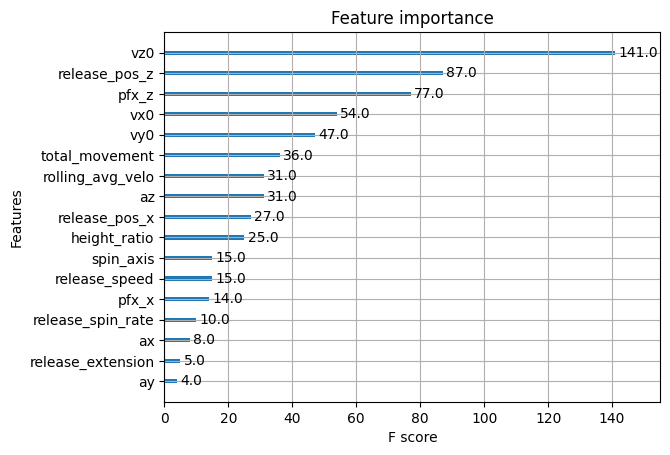

In [34]:
xgb.plot_importance(model)
plt.show()

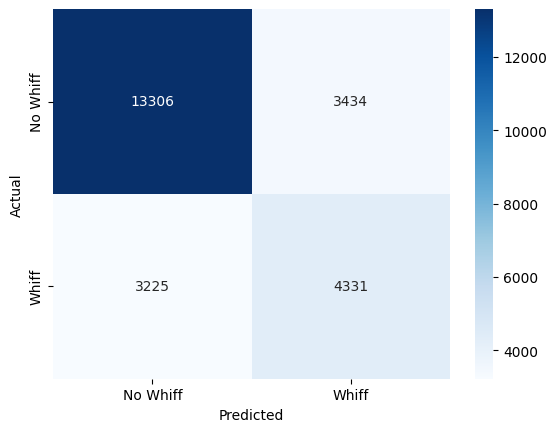

In [35]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [36]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [37]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 16:26:28,909] A new study created in memory with name: no-name-8387fe3c-f22a-4b0f-a2d6-b316d07dd918


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68334
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67443
[4]	eval-logloss:0.67049
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66342
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.65792
[9]	eval-logloss:0.65451
[10]	eval-logloss:0.65148
[11]	eval-logloss:0.65032
[12]	eval-logloss:0.64744
[13]	eval-logloss:0.64473
[14]	eval-logloss:0.64202
[15]	eval-logloss:0.63933
[16]	eval-logloss:0.63665
[17]	eval-logloss:0.63416
[18]	eval-logloss:0.63184
[19]	eval-logloss:0.62942
[20]	eval-logloss:0.62732
[21]	eval-logloss:0.62517
[22]	eval-logloss:0.62306
[23]	eval-logloss:0.62130
[24]	eval-logloss:0.61949
[25]	eval-logloss:0.61831
[26]	eval-logloss:0.61807
[27]	eval-logloss:0.61736
[28]	eval-logloss:0.61554
[29]	eval-logloss:0.61394
[30]	eval-logloss:0.61227
[31]	eval-logloss:0.61163
[32]	eval-logloss:0.61010
[33]	eval-logloss:0.60863
[34]	eval-logloss:0.60715
[35]	eval-logloss:0.60586
[36]	eval-logloss:0.60448
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60

[I 2023-11-14 16:26:30,664] Trial 0 finished with value: 0.5683805557217664 and parameters: {'max_depth': 6, 'eta': 0.03450378770524434, 'subsample': 0.7693558018644049, 'colsample_bytree': 0.7514874597175021}. Best is trial 0 with value: 0.5683805557217664.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68694
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68280
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67543
[14]	eval-logloss:0.67420
[15]	eval-logloss:0.67305
[16]	eval-logloss:0.67186
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66713
[21]	eval-logloss:0.66598
[22]	eval-logloss:0.66490
[23]	eval-logloss:0.66394
[24]	eval-logloss:0.66288
[25]	eval-logloss:0.66240
[26]	eval-logloss:0.66224
[27]	eval-logloss:0.66183
[28]	eval-logloss:0.66086
[29]	eval-logloss:0.65993
[30]	eval-logloss:0.65896
[31]	eval-logloss:0.65855
[32]	eval-logloss:0.65752
[33]	eval-logloss:0.65661
[34]	eval-logloss:0.65569
[35]	eval-logloss:0.65490
[36]	eval-logloss:0.65403
[37]	eval-logloss:0.65315
[38]	eval-logloss:0.65

[I 2023-11-14 16:26:32,002] Trial 1 finished with value: 0.6219842071179503 and parameters: {'max_depth': 4, 'eta': 0.014170002150511693, 'subsample': 0.6355738186038576, 'colsample_bytree': 0.7521501598735962}. Best is trial 0 with value: 0.5683805557217664.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65708
[3]	eval-logloss:0.64775
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63186
[6]	eval-logloss:0.62515
[7]	eval-logloss:0.61903
[8]	eval-logloss:0.61356
[9]	eval-logloss:0.60878
[10]	eval-logloss:0.60405
[11]	eval-logloss:0.60003
[12]	eval-logloss:0.59640
[13]	eval-logloss:0.59304
[14]	eval-logloss:0.58996
[15]	eval-logloss:0.58686
[16]	eval-logloss:0.58415
[17]	eval-logloss:0.58143
[18]	eval-logloss:0.57930
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57504
[21]	eval-logloss:0.57340
[22]	eval-logloss:0.57157
[23]	eval-logloss:0.56990
[24]	eval-logloss:0.56851
[25]	eval-logloss:0.56693
[26]	eval-logloss:0.56565
[27]	eval-logloss:0.56442
[28]	eval-logloss:0.56326
[29]	eval-logloss:0.56216
[30]	eval-logloss:0.56121
[31]	eval-logloss:0.56016
[32]	eval-logloss:0.55965
[33]	eval-logloss:0.55877
[34]	eval-logloss:0.55771
[35]	eval-logloss:0.55702
[36]	eval-logloss:0.55626
[37]	eval-logloss:0.55565
[38]	eval-logloss:0.55

[I 2023-11-14 16:26:34,293] Trial 2 finished with value: 0.5405561509196434 and parameters: {'max_depth': 8, 'eta': 0.07763148099884955, 'subsample': 0.8968266741534389, 'colsample_bytree': 0.9452097299136735}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67456
[5]	eval-logloss:0.67164
[6]	eval-logloss:0.66826
[7]	eval-logloss:0.66675
[8]	eval-logloss:0.66363
[9]	eval-logloss:0.66057
[10]	eval-logloss:0.65768
[11]	eval-logloss:0.65614
[12]	eval-logloss:0.65336
[13]	eval-logloss:0.65075
[14]	eval-logloss:0.64803
[15]	eval-logloss:0.64549
[16]	eval-logloss:0.64290
[17]	eval-logloss:0.64047
[18]	eval-logloss:0.63809
[19]	eval-logloss:0.63574
[20]	eval-logloss:0.63349
[21]	eval-logloss:0.63129
[22]	eval-logloss:0.62911
[23]	eval-logloss:0.62721
[24]	eval-logloss:0.62522
[25]	eval-logloss:0.62323
[26]	eval-logloss:0.62293
[27]	eval-logloss:0.62114
[28]	eval-logloss:0.61938
[29]	eval-logloss:0.61762
[30]	eval-logloss:0.61585
[31]	eval-logloss:0.61517
[32]	eval-logloss:0.61348
[33]	eval-logloss:0.61186
[34]	eval-logloss:0.61031
[35]	eval-logloss:0.60882
[36]	eval-logloss:0.60748
[37]	eval-logloss:0.60603
[38]	eval-logloss:0.60

[I 2023-11-14 16:26:37,342] Trial 3 finished with value: 0.5609702584805368 and parameters: {'max_depth': 9, 'eta': 0.020463557693551078, 'subsample': 0.6919498628540721, 'colsample_bytree': 0.8810081814539945}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.64520
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.62201
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.60430
[7]	eval-logloss:0.60143
[8]	eval-logloss:0.59804
[9]	eval-logloss:0.59475
[10]	eval-logloss:0.59150
[11]	eval-logloss:0.58892
[12]	eval-logloss:0.58694
[13]	eval-logloss:0.58493
[14]	eval-logloss:0.58342
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57853
[17]	eval-logloss:0.57753
[18]	eval-logloss:0.57666
[19]	eval-logloss:0.57510
[20]	eval-logloss:0.57434
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57285
[23]	eval-logloss:0.57289
[24]	eval-logloss:0.57165
[25]	eval-logloss:0.57099
[26]	eval-logloss:0.57080
[27]	eval-logloss:0.56982
[28]	eval-logloss:0.56891
[29]	eval-logloss:0.56813
[30]	eval-logloss:0.56749
[31]	eval-logloss:0.56745
[32]	eval-logloss:0.56695
[33]	eval-logloss:0.56627
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56530
[36]	eval-logloss:0.56510
[37]	eval-logloss:0.56475
[38]	eval-logloss:0.56

[I 2023-11-14 16:26:38,465] Trial 4 finished with value: 0.5523360539831208 and parameters: {'max_depth': 4, 'eta': 0.2913389859594321, 'subsample': 0.769964175602221, 'colsample_bytree': 0.8408017154726957}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.63640
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62304
[7]	eval-logloss:0.61771
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.60909
[10]	eval-logloss:0.60537
[11]	eval-logloss:0.60153
[12]	eval-logloss:0.59879
[13]	eval-logloss:0.59650
[14]	eval-logloss:0.59441
[15]	eval-logloss:0.59237
[16]	eval-logloss:0.59017
[17]	eval-logloss:0.58862
[18]	eval-logloss:0.58700
[19]	eval-logloss:0.58520
[20]	eval-logloss:0.58316
[21]	eval-logloss:0.58164
[22]	eval-logloss:0.58042
[23]	eval-logloss:0.57914
[24]	eval-logloss:0.57783
[25]	eval-logloss:0.57626
[26]	eval-logloss:0.57520
[27]	eval-logloss:0.57402
[28]	eval-logloss:0.57295
[29]	eval-logloss:0.57217
[30]	eval-logloss:0.57135
[31]	eval-logloss:0.57075
[32]	eval-logloss:0.56981
[33]	eval-logloss:0.56894
[34]	eval-logloss:0.56837
[35]	eval-logloss:0.56792
[36]	eval-logloss:0.56715
[37]	eval-logloss:0.56685
[38]	eval-logloss:0.56

[I 2023-11-14 16:26:40,073] Trial 5 finished with value: 0.5517623729856552 and parameters: {'max_depth': 5, 'eta': 0.12431968424216526, 'subsample': 0.6066184611781961, 'colsample_bytree': 0.9521187346711149}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65030
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.64209
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63384
[10]	eval-logloss:0.63036
[11]	eval-logloss:0.62886
[12]	eval-logloss:0.62576
[13]	eval-logloss:0.62328
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61798
[16]	eval-logloss:0.61612
[17]	eval-logloss:0.61383
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.60933
[20]	eval-logloss:0.60741
[21]	eval-logloss:0.60579
[22]	eval-logloss:0.60464
[23]	eval-logloss:0.60327
[24]	eval-logloss:0.60179
[25]	eval-logloss:0.60135
[26]	eval-logloss:0.60100
[27]	eval-logloss:0.60009
[28]	eval-logloss:0.59862
[29]	eval-logloss:0.59756
[30]	eval-logloss:0.59650
[31]	eval-logloss:0.59584
[32]	eval-logloss:0.59449
[33]	eval-logloss:0.59350
[34]	eval-logloss:0.59257
[35]	eval-logloss:0.59186
[36]	eval-logloss:0.59112
[37]	eval-logloss:0.59027
[38]	eval-logloss:0.58

[I 2023-11-14 16:26:41,301] Trial 6 finished with value: 0.5680447977876811 and parameters: {'max_depth': 4, 'eta': 0.09182661795077203, 'subsample': 0.605598819881654, 'colsample_bytree': 0.703668275007264}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63549
[5]	eval-logloss:0.62999
[6]	eval-logloss:0.62599
[7]	eval-logloss:0.62228
[8]	eval-logloss:0.61657
[9]	eval-logloss:0.61569
[10]	eval-logloss:0.61120
[11]	eval-logloss:0.60936
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60320
[14]	eval-logloss:0.60022
[15]	eval-logloss:0.59776
[16]	eval-logloss:0.59563
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.59251
[19]	eval-logloss:0.59069
[20]	eval-logloss:0.58894
[21]	eval-logloss:0.58747
[22]	eval-logloss:0.58705
[23]	eval-logloss:0.58617
[24]	eval-logloss:0.58588
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58507
[27]	eval-logloss:0.58469
[28]	eval-logloss:0.58366
[29]	eval-logloss:0.58312
[30]	eval-logloss:0.58132
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.57915
[33]	eval-logloss:0.57922
[34]	eval-logloss:0.57792
[35]	eval-logloss:0.57746
[36]	eval-logloss:0.57720
[37]	eval-logloss:0.57603
[38]	eval-logloss:0.57

[I 2023-11-14 16:26:42,409] Trial 7 finished with value: 0.5603068545560521 and parameters: {'max_depth': 4, 'eta': 0.1723570521448208, 'subsample': 0.6155753751200509, 'colsample_bytree': 0.5824451158642165}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.65440
[1]	eval-logloss:0.62996
[2]	eval-logloss:0.61144
[3]	eval-logloss:0.59823
[4]	eval-logloss:0.59047
[5]	eval-logloss:0.58313
[6]	eval-logloss:0.57792
[7]	eval-logloss:0.57328
[8]	eval-logloss:0.56984
[9]	eval-logloss:0.56752
[10]	eval-logloss:0.56539
[11]	eval-logloss:0.56311
[12]	eval-logloss:0.56181
[13]	eval-logloss:0.55980
[14]	eval-logloss:0.55881
[15]	eval-logloss:0.55775
[16]	eval-logloss:0.55669
[17]	eval-logloss:0.55642
[18]	eval-logloss:0.55559
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55478
[21]	eval-logloss:0.55418
[22]	eval-logloss:0.55338
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.55238
[25]	eval-logloss:0.55189
[26]	eval-logloss:0.55173
[27]	eval-logloss:0.55140
[28]	eval-logloss:0.55106
[29]	eval-logloss:0.55055
[30]	eval-logloss:0.55035
[31]	eval-logloss:0.55005
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54982
[35]	eval-logloss:0.55006
[36]	eval-logloss:0.54982
[37]	eval-logloss:0.54943
[38]	eval-logloss:0.54

[I 2023-11-14 16:26:44,107] Trial 8 finished with value: 0.5456877818424128 and parameters: {'max_depth': 7, 'eta': 0.2640105919271797, 'subsample': 0.8461203455130422, 'colsample_bytree': 0.9999747020918808}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.63274
[3]	eval-logloss:0.62131
[4]	eval-logloss:0.61122
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59834
[7]	eval-logloss:0.59413
[8]	eval-logloss:0.58908
[9]	eval-logloss:0.58517
[10]	eval-logloss:0.58142
[11]	eval-logloss:0.57985
[12]	eval-logloss:0.57720
[13]	eval-logloss:0.57462
[14]	eval-logloss:0.57280
[15]	eval-logloss:0.57076
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56761
[18]	eval-logloss:0.56589
[19]	eval-logloss:0.56428
[20]	eval-logloss:0.56332
[21]	eval-logloss:0.56252
[22]	eval-logloss:0.56193
[23]	eval-logloss:0.56172
[24]	eval-logloss:0.56028
[25]	eval-logloss:0.55994
[26]	eval-logloss:0.55981
[27]	eval-logloss:0.55939
[28]	eval-logloss:0.55856
[29]	eval-logloss:0.55783
[30]	eval-logloss:0.55751
[31]	eval-logloss:0.55722
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55704
[34]	eval-logloss:0.55625
[35]	eval-logloss:0.55570
[36]	eval-logloss:0.55551
[37]	eval-logloss:0.55502
[38]	eval-logloss:0.55

[I 2023-11-14 16:26:45,455] Trial 9 finished with value: 0.5451995873680184 and parameters: {'max_depth': 6, 'eta': 0.19321968359276917, 'subsample': 0.866091664920396, 'colsample_bytree': 0.7154100500097144}. Best is trial 2 with value: 0.5405561509196434.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.65108
[3]	eval-logloss:0.64051
[4]	eval-logloss:0.63111
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61521
[7]	eval-logloss:0.60891
[8]	eval-logloss:0.60287
[9]	eval-logloss:0.59767
[10]	eval-logloss:0.59270
[11]	eval-logloss:0.58861
[12]	eval-logloss:0.58464
[13]	eval-logloss:0.58127
[14]	eval-logloss:0.57821
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.57261
[17]	eval-logloss:0.57047
[18]	eval-logloss:0.56829
[19]	eval-logloss:0.56600
[20]	eval-logloss:0.56431
[21]	eval-logloss:0.56294
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.55999
[24]	eval-logloss:0.55850
[25]	eval-logloss:0.55707
[26]	eval-logloss:0.55659
[27]	eval-logloss:0.55554
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55343
[30]	eval-logloss:0.55219
[31]	eval-logloss:0.55124
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.54990
[34]	eval-logloss:0.54885
[35]	eval-logloss:0.54819
[36]	eval-logloss:0.54769
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54

[I 2023-11-14 16:26:47,990] Trial 10 finished with value: 0.5346307832291755 and parameters: {'max_depth': 9, 'eta': 0.08703896307945003, 'subsample': 0.8956794049625015, 'colsample_bytree': 0.906821551343252}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66560
[2]	eval-logloss:0.65407
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63490
[5]	eval-logloss:0.62671
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61297
[8]	eval-logloss:0.60737
[9]	eval-logloss:0.60218
[10]	eval-logloss:0.59740
[11]	eval-logloss:0.59312
[12]	eval-logloss:0.58926
[13]	eval-logloss:0.58557
[14]	eval-logloss:0.58242
[15]	eval-logloss:0.57973
[16]	eval-logloss:0.57682
[17]	eval-logloss:0.57426
[18]	eval-logloss:0.57209
[19]	eval-logloss:0.56981
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56662
[22]	eval-logloss:0.56463
[23]	eval-logloss:0.56339
[24]	eval-logloss:0.56170
[25]	eval-logloss:0.56003
[26]	eval-logloss:0.55984
[27]	eval-logloss:0.55881
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55631
[30]	eval-logloss:0.55512
[31]	eval-logloss:0.55409
[32]	eval-logloss:0.55333
[33]	eval-logloss:0.55245
[34]	eval-logloss:0.55148
[35]	eval-logloss:0.55065
[36]	eval-logloss:0.55007
[37]	eval-logloss:0.54952
[38]	eval-logloss:0.54

[I 2023-11-14 16:26:50,573] Trial 11 finished with value: 0.5352138110928327 and parameters: {'max_depth': 9, 'eta': 0.07950748979955505, 'subsample': 0.8983179376166037, 'colsample_bytree': 0.9144508946889002}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63452
[5]	eval-logloss:0.62708
[6]	eval-logloss:0.61938
[7]	eval-logloss:0.61537
[8]	eval-logloss:0.60953
[9]	eval-logloss:0.60421
[10]	eval-logloss:0.59897
[11]	eval-logloss:0.59609
[12]	eval-logloss:0.59158
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58406
[15]	eval-logloss:0.58087
[16]	eval-logloss:0.57768
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57299
[19]	eval-logloss:0.57065
[20]	eval-logloss:0.56864
[21]	eval-logloss:0.56682
[22]	eval-logloss:0.56478
[23]	eval-logloss:0.56322
[24]	eval-logloss:0.56156
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55972
[27]	eval-logloss:0.55874
[28]	eval-logloss:0.55752
[29]	eval-logloss:0.55643
[30]	eval-logloss:0.55533
[31]	eval-logloss:0.55488
[32]	eval-logloss:0.55415
[33]	eval-logloss:0.55348
[34]	eval-logloss:0.55257
[35]	eval-logloss:0.55185
[36]	eval-logloss:0.55107
[37]	eval-logloss:0.55035
[38]	eval-logloss:0.54

[I 2023-11-14 16:26:52,933] Trial 12 finished with value: 0.5358623799395053 and parameters: {'max_depth': 9, 'eta': 0.07967041314545263, 'subsample': 0.828938406066668, 'colsample_bytree': 0.8755042939227937}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.62578
[5]	eval-logloss:0.61769
[6]	eval-logloss:0.61033
[7]	eval-logloss:0.60609
[8]	eval-logloss:0.60031
[9]	eval-logloss:0.59487
[10]	eval-logloss:0.59015
[11]	eval-logloss:0.58712
[12]	eval-logloss:0.58344
[13]	eval-logloss:0.58012
[14]	eval-logloss:0.57693
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57134
[17]	eval-logloss:0.56923
[18]	eval-logloss:0.56735
[19]	eval-logloss:0.56522
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56272
[22]	eval-logloss:0.56124
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55889
[25]	eval-logloss:0.55787
[26]	eval-logloss:0.55765
[27]	eval-logloss:0.55679
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55447
[30]	eval-logloss:0.55358
[31]	eval-logloss:0.55324
[32]	eval-logloss:0.55285
[33]	eval-logloss:0.55238
[34]	eval-logloss:0.55152
[35]	eval-logloss:0.55093
[36]	eval-logloss:0.55019
[37]	eval-logloss:0.54954
[38]	eval-logloss:0.54

[I 2023-11-14 16:26:54,705] Trial 13 finished with value: 0.5392094609534676 and parameters: {'max_depth': 8, 'eta': 0.10781066270913967, 'subsample': 0.8991413515347015, 'colsample_bytree': 0.840309681436662}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61323
[5]	eval-logloss:0.60386
[6]	eval-logloss:0.59704
[7]	eval-logloss:0.59089
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.58167
[10]	eval-logloss:0.57779
[11]	eval-logloss:0.57444
[12]	eval-logloss:0.57150
[13]	eval-logloss:0.56899
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.56117
[18]	eval-logloss:0.55949
[19]	eval-logloss:0.55803
[20]	eval-logloss:0.55725
[21]	eval-logloss:0.55599
[22]	eval-logloss:0.55473
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55312
[25]	eval-logloss:0.55219
[26]	eval-logloss:0.55181
[27]	eval-logloss:0.55125
[28]	eval-logloss:0.55083
[29]	eval-logloss:0.55041
[30]	eval-logloss:0.55005
[31]	eval-logloss:0.54980
[32]	eval-logloss:0.54941
[33]	eval-logloss:0.54873
[34]	eval-logloss:0.54842
[35]	eval-logloss:0.54822
[36]	eval-logloss:0.54798
[37]	eval-logloss:0.54772
[38]	eval-logloss:0.54

[I 2023-11-14 16:26:56,527] Trial 14 finished with value: 0.5391478913801095 and parameters: {'max_depth': 8, 'eta': 0.14028501461473464, 'subsample': 0.8132149923839657, 'colsample_bytree': 0.9897777639652288}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65165
[5]	eval-logloss:0.64507
[6]	eval-logloss:0.63877
[7]	eval-logloss:0.63317
[8]	eval-logloss:0.62794
[9]	eval-logloss:0.62318
[10]	eval-logloss:0.61870
[11]	eval-logloss:0.61443
[12]	eval-logloss:0.61058
[13]	eval-logloss:0.60684
[14]	eval-logloss:0.60330
[15]	eval-logloss:0.60030
[16]	eval-logloss:0.59734
[17]	eval-logloss:0.59446
[18]	eval-logloss:0.59175
[19]	eval-logloss:0.58919
[20]	eval-logloss:0.58694
[21]	eval-logloss:0.58488
[22]	eval-logloss:0.58255
[23]	eval-logloss:0.58077
[24]	eval-logloss:0.57882
[25]	eval-logloss:0.57695
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57349
[29]	eval-logloss:0.57202
[30]	eval-logloss:0.57058
[31]	eval-logloss:0.56932
[32]	eval-logloss:0.56788
[33]	eval-logloss:0.56649
[34]	eval-logloss:0.56537
[35]	eval-logloss:0.56428
[36]	eval-logloss:0.56316
[37]	eval-logloss:0.56212
[38]	eval-logloss:0.56

[I 2023-11-14 16:26:59,329] Trial 15 finished with value: 0.5393069622220932 and parameters: {'max_depth': 9, 'eta': 0.05165273183860594, 'subsample': 0.8052917968001871, 'colsample_bytree': 0.9169778031251175}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67443
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.65879
[4]	eval-logloss:0.65206
[5]	eval-logloss:0.64645
[6]	eval-logloss:0.64059
[7]	eval-logloss:0.63741
[8]	eval-logloss:0.63218
[9]	eval-logloss:0.62745
[10]	eval-logloss:0.62311
[11]	eval-logloss:0.62152
[12]	eval-logloss:0.61754
[13]	eval-logloss:0.61411
[14]	eval-logloss:0.61071
[15]	eval-logloss:0.60754
[16]	eval-logloss:0.60438
[17]	eval-logloss:0.60157
[18]	eval-logloss:0.59890
[19]	eval-logloss:0.59659
[20]	eval-logloss:0.59430
[21]	eval-logloss:0.59215
[22]	eval-logloss:0.58991
[23]	eval-logloss:0.58805
[24]	eval-logloss:0.58632
[25]	eval-logloss:0.58480
[26]	eval-logloss:0.58449
[27]	eval-logloss:0.58380
[28]	eval-logloss:0.58206
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.57936
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57748
[33]	eval-logloss:0.57622
[34]	eval-logloss:0.57491
[35]	eval-logloss:0.57387
[36]	eval-logloss:0.57289
[37]	eval-logloss:0.57196
[38]	eval-logloss:0.57

[I 2023-11-14 16:27:01,944] Trial 16 finished with value: 0.5489987609264128 and parameters: {'max_depth': 7, 'eta': 0.06125521939604822, 'subsample': 0.8689882550863874, 'colsample_bytree': 0.823883197659367}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63789
[4]	eval-logloss:0.62884
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.61356
[7]	eval-logloss:0.60788
[8]	eval-logloss:0.60213
[9]	eval-logloss:0.59747
[10]	eval-logloss:0.59341
[11]	eval-logloss:0.58944
[12]	eval-logloss:0.58641
[13]	eval-logloss:0.58332
[14]	eval-logloss:0.58061
[15]	eval-logloss:0.57813
[16]	eval-logloss:0.57585
[17]	eval-logloss:0.57376
[18]	eval-logloss:0.57189
[19]	eval-logloss:0.56985
[20]	eval-logloss:0.56831
[21]	eval-logloss:0.56748
[22]	eval-logloss:0.56555
[23]	eval-logloss:0.56448
[24]	eval-logloss:0.56312
[25]	eval-logloss:0.56186
[26]	eval-logloss:0.56157
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.55950
[29]	eval-logloss:0.55881
[30]	eval-logloss:0.55796
[31]	eval-logloss:0.55721
[32]	eval-logloss:0.55640
[33]	eval-logloss:0.55597
[34]	eval-logloss:0.55536
[35]	eval-logloss:0.55480
[36]	eval-logloss:0.55424
[37]	eval-logloss:0.55375
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:03,300] Trial 17 finished with value: 0.5416982677539997 and parameters: {'max_depth': 7, 'eta': 0.11261353752883252, 'subsample': 0.8592613393347002, 'colsample_bytree': 0.9097614773360776}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67309
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65623
[4]	eval-logloss:0.64878
[5]	eval-logloss:0.64173
[6]	eval-logloss:0.63552
[7]	eval-logloss:0.62977
[8]	eval-logloss:0.62451
[9]	eval-logloss:0.61944
[10]	eval-logloss:0.61482
[11]	eval-logloss:0.61049
[12]	eval-logloss:0.60656
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.59912
[15]	eval-logloss:0.59575
[16]	eval-logloss:0.59274
[17]	eval-logloss:0.59003
[18]	eval-logloss:0.58722
[19]	eval-logloss:0.58488
[20]	eval-logloss:0.58252
[21]	eval-logloss:0.58051
[22]	eval-logloss:0.57841
[23]	eval-logloss:0.57661
[24]	eval-logloss:0.57490
[25]	eval-logloss:0.57303
[26]	eval-logloss:0.57158
[27]	eval-logloss:0.57011
[28]	eval-logloss:0.56876
[29]	eval-logloss:0.56729
[30]	eval-logloss:0.56602
[31]	eval-logloss:0.56471
[32]	eval-logloss:0.56359
[33]	eval-logloss:0.56229
[34]	eval-logloss:0.56099
[35]	eval-logloss:0.55985
[36]	eval-logloss:0.55914
[37]	eval-logloss:0.55824
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:06,709] Trial 18 finished with value: 0.5382016962099692 and parameters: {'max_depth': 9, 'eta': 0.05628495572819035, 'subsample': 0.897962483015871, 'colsample_bytree': 0.9514551068575383}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.64804
[2]	eval-logloss:0.63217
[3]	eval-logloss:0.61923
[4]	eval-logloss:0.60970
[5]	eval-logloss:0.60201
[6]	eval-logloss:0.59471
[7]	eval-logloss:0.59049
[8]	eval-logloss:0.58454
[9]	eval-logloss:0.57971
[10]	eval-logloss:0.57590
[11]	eval-logloss:0.57467
[12]	eval-logloss:0.57184
[13]	eval-logloss:0.56926
[14]	eval-logloss:0.56694
[15]	eval-logloss:0.56494
[16]	eval-logloss:0.56280
[17]	eval-logloss:0.56138
[18]	eval-logloss:0.55993
[19]	eval-logloss:0.55788
[20]	eval-logloss:0.55692
[21]	eval-logloss:0.55614
[22]	eval-logloss:0.55475
[23]	eval-logloss:0.55457
[24]	eval-logloss:0.55324
[25]	eval-logloss:0.55249
[26]	eval-logloss:0.55246
[27]	eval-logloss:0.55222
[28]	eval-logloss:0.55131
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.54974
[31]	eval-logloss:0.54963
[32]	eval-logloss:0.54952
[33]	eval-logloss:0.54928
[34]	eval-logloss:0.54910
[35]	eval-logloss:0.54879
[36]	eval-logloss:0.54870
[37]	eval-logloss:0.54835
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:08,712] Trial 19 finished with value: 0.540164327352204 and parameters: {'max_depth': 8, 'eta': 0.1523903361408182, 'subsample': 0.7993884818970409, 'colsample_bytree': 0.7833217453228806}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67769
[2]	eval-logloss:0.67180
[3]	eval-logloss:0.66679
[4]	eval-logloss:0.66238
[5]	eval-logloss:0.65786
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.65213
[8]	eval-logloss:0.64870
[9]	eval-logloss:0.64528
[10]	eval-logloss:0.64264
[11]	eval-logloss:0.64114
[12]	eval-logloss:0.63858
[13]	eval-logloss:0.63670
[14]	eval-logloss:0.63498
[15]	eval-logloss:0.63253
[16]	eval-logloss:0.63059
[17]	eval-logloss:0.62887
[18]	eval-logloss:0.62705
[19]	eval-logloss:0.62507
[20]	eval-logloss:0.62352
[21]	eval-logloss:0.62239
[22]	eval-logloss:0.62083
[23]	eval-logloss:0.61965
[24]	eval-logloss:0.61863
[25]	eval-logloss:0.61708
[26]	eval-logloss:0.61661
[27]	eval-logloss:0.61562
[28]	eval-logloss:0.61435
[29]	eval-logloss:0.61333
[30]	eval-logloss:0.61245
[31]	eval-logloss:0.61156
[32]	eval-logloss:0.61065
[33]	eval-logloss:0.60955
[34]	eval-logloss:0.60886
[35]	eval-logloss:0.60830
[36]	eval-logloss:0.60726
[37]	eval-logloss:0.60664
[38]	eval-logloss:0.60

[I 2023-11-14 16:27:09,801] Trial 20 finished with value: 0.5802303920790384 and parameters: {'max_depth': 3, 'eta': 0.09205135904870973, 'subsample': 0.8402016225131036, 'colsample_bytree': 0.8872346496455947}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66652
[2]	eval-logloss:0.65519
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63667
[5]	eval-logloss:0.62943
[6]	eval-logloss:0.62182
[7]	eval-logloss:0.61789
[8]	eval-logloss:0.61152
[9]	eval-logloss:0.60612
[10]	eval-logloss:0.60103
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59369
[13]	eval-logloss:0.58992
[14]	eval-logloss:0.58612
[15]	eval-logloss:0.58293
[16]	eval-logloss:0.57987
[17]	eval-logloss:0.57734
[18]	eval-logloss:0.57493
[19]	eval-logloss:0.57256
[20]	eval-logloss:0.57036
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56670
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56364
[25]	eval-logloss:0.56221
[26]	eval-logloss:0.56193
[27]	eval-logloss:0.56082
[28]	eval-logloss:0.55949
[29]	eval-logloss:0.55829
[30]	eval-logloss:0.55718
[31]	eval-logloss:0.55667
[32]	eval-logloss:0.55595
[33]	eval-logloss:0.55518
[34]	eval-logloss:0.55415
[35]	eval-logloss:0.55322
[36]	eval-logloss:0.55263
[37]	eval-logloss:0.55197
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:12,022] Trial 21 finished with value: 0.5369388907431593 and parameters: {'max_depth': 9, 'eta': 0.07591968246970555, 'subsample': 0.8328625611769102, 'colsample_bytree': 0.8719652659344322}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66609
[4]	eval-logloss:0.66039
[5]	eval-logloss:0.65491
[6]	eval-logloss:0.64994
[7]	eval-logloss:0.64517
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.63611
[10]	eval-logloss:0.63195
[11]	eval-logloss:0.62803
[12]	eval-logloss:0.62453
[13]	eval-logloss:0.62101
[14]	eval-logloss:0.61765
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.60864
[18]	eval-logloss:0.60579
[19]	eval-logloss:0.60323
[20]	eval-logloss:0.60074
[21]	eval-logloss:0.59847
[22]	eval-logloss:0.59623
[23]	eval-logloss:0.59417
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59023
[26]	eval-logloss:0.58985
[27]	eval-logloss:0.58812
[28]	eval-logloss:0.58639
[29]	eval-logloss:0.58454
[30]	eval-logloss:0.58286
[31]	eval-logloss:0.58147
[32]	eval-logloss:0.57991
[33]	eval-logloss:0.57843
[34]	eval-logloss:0.57706
[35]	eval-logloss:0.57575
[36]	eval-logloss:0.57454
[37]	eval-logloss:0.57342
[38]	eval-logloss:0.57

[I 2023-11-14 16:27:15,105] Trial 22 finished with value: 0.5424209499227267 and parameters: {'max_depth': 9, 'eta': 0.038778811363883434, 'subsample': 0.8769451915010216, 'colsample_bytree': 0.9226788589113475}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.65065
[4]	eval-logloss:0.64284
[5]	eval-logloss:0.63612
[6]	eval-logloss:0.62916
[7]	eval-logloss:0.62568
[8]	eval-logloss:0.61991
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60337
[13]	eval-logloss:0.59978
[14]	eval-logloss:0.59605
[15]	eval-logloss:0.59274
[16]	eval-logloss:0.58943
[17]	eval-logloss:0.58681
[18]	eval-logloss:0.58440
[19]	eval-logloss:0.58177
[20]	eval-logloss:0.57948
[21]	eval-logloss:0.57757
[22]	eval-logloss:0.57556
[23]	eval-logloss:0.57408
[24]	eval-logloss:0.57217
[25]	eval-logloss:0.57062
[26]	eval-logloss:0.57035
[27]	eval-logloss:0.56900
[28]	eval-logloss:0.56777
[29]	eval-logloss:0.56643
[30]	eval-logloss:0.56515
[31]	eval-logloss:0.56457
[32]	eval-logloss:0.56366
[33]	eval-logloss:0.56283
[34]	eval-logloss:0.56166
[35]	eval-logloss:0.56083
[36]	eval-logloss:0.55990
[37]	eval-logloss:0.55889
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:16,988] Trial 23 finished with value: 0.5407823897469077 and parameters: {'max_depth': 8, 'eta': 0.07069938297398332, 'subsample': 0.8334685595076933, 'colsample_bytree': 0.8646162287684964}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67607
[1]	eval-logloss:0.66129
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.63736
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62001
[6]	eval-logloss:0.61276
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60220
[9]	eval-logloss:0.59659
[10]	eval-logloss:0.59133
[11]	eval-logloss:0.58947
[12]	eval-logloss:0.58537
[13]	eval-logloss:0.58164
[14]	eval-logloss:0.57806
[15]	eval-logloss:0.57499
[16]	eval-logloss:0.57202
[17]	eval-logloss:0.56975
[18]	eval-logloss:0.56731
[19]	eval-logloss:0.56521
[20]	eval-logloss:0.56338
[21]	eval-logloss:0.56206
[22]	eval-logloss:0.56050
[23]	eval-logloss:0.55928
[24]	eval-logloss:0.55791
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55637
[27]	eval-logloss:0.55590
[28]	eval-logloss:0.55480
[29]	eval-logloss:0.55372
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55075
[34]	eval-logloss:0.54996
[35]	eval-logloss:0.54930
[36]	eval-logloss:0.54868
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:19,818] Trial 24 finished with value: 0.5357680552145283 and parameters: {'max_depth': 9, 'eta': 0.09435585440260125, 'subsample': 0.8762326166507816, 'colsample_bytree': 0.808708305910281}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67341
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62383
[5]	eval-logloss:0.61660
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60514
[8]	eval-logloss:0.59947
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.58950
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58474
[13]	eval-logloss:0.58164
[14]	eval-logloss:0.57849
[15]	eval-logloss:0.57622
[16]	eval-logloss:0.57392
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.56808
[20]	eval-logloss:0.56702
[21]	eval-logloss:0.56587
[22]	eval-logloss:0.56431
[23]	eval-logloss:0.56355
[24]	eval-logloss:0.56223
[25]	eval-logloss:0.56119
[26]	eval-logloss:0.56092
[27]	eval-logloss:0.56044
[28]	eval-logloss:0.55952
[29]	eval-logloss:0.55884
[30]	eval-logloss:0.55763
[31]	eval-logloss:0.55721
[32]	eval-logloss:0.55666
[33]	eval-logloss:0.55629
[34]	eval-logloss:0.55573
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55486
[37]	eval-logloss:0.55441
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:21,375] Trial 25 finished with value: 0.5428606411024922 and parameters: {'max_depth': 7, 'eta': 0.12677343525182477, 'subsample': 0.8716154261331737, 'colsample_bytree': 0.8052777372137713}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.65972
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63533
[4]	eval-logloss:0.62567
[5]	eval-logloss:0.61812
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60707
[8]	eval-logloss:0.60098
[9]	eval-logloss:0.59576
[10]	eval-logloss:0.59083
[11]	eval-logloss:0.58909
[12]	eval-logloss:0.58548
[13]	eval-logloss:0.58223
[14]	eval-logloss:0.57881
[15]	eval-logloss:0.57579
[16]	eval-logloss:0.57327
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.56882
[19]	eval-logloss:0.56667
[20]	eval-logloss:0.56491
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56188
[23]	eval-logloss:0.56097
[24]	eval-logloss:0.55953
[25]	eval-logloss:0.55831
[26]	eval-logloss:0.55799
[27]	eval-logloss:0.55759
[28]	eval-logloss:0.55651
[29]	eval-logloss:0.55556
[30]	eval-logloss:0.55465
[31]	eval-logloss:0.55418
[32]	eval-logloss:0.55374
[33]	eval-logloss:0.55322
[34]	eval-logloss:0.55259
[35]	eval-logloss:0.55210
[36]	eval-logloss:0.55143
[37]	eval-logloss:0.55087
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:23,303] Trial 26 finished with value: 0.5396612906774823 and parameters: {'max_depth': 8, 'eta': 0.10698684012279126, 'subsample': 0.8816125362872321, 'colsample_bytree': 0.8108155731173371}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66325
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65113
[6]	eval-logloss:0.64556
[7]	eval-logloss:0.64047
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.62670
[11]	eval-logloss:0.62248
[12]	eval-logloss:0.61872
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61154
[15]	eval-logloss:0.60839
[16]	eval-logloss:0.60527
[17]	eval-logloss:0.60247
[18]	eval-logloss:0.59980
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59471
[21]	eval-logloss:0.59227
[22]	eval-logloss:0.59019
[23]	eval-logloss:0.58817
[24]	eval-logloss:0.58624
[25]	eval-logloss:0.58440
[26]	eval-logloss:0.58295
[27]	eval-logloss:0.58119
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.57798
[30]	eval-logloss:0.57647
[31]	eval-logloss:0.57497
[32]	eval-logloss:0.57362
[33]	eval-logloss:0.57237
[34]	eval-logloss:0.57101
[35]	eval-logloss:0.56970
[36]	eval-logloss:0.56853
[37]	eval-logloss:0.56736
[38]	eval-logloss:0.56

[I 2023-11-14 16:27:25,878] Trial 27 finished with value: 0.5411990901904418 and parameters: {'max_depth': 9, 'eta': 0.0440671557098892, 'subsample': 0.8540545680166338, 'colsample_bytree': 0.9641203095782507}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.65114
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63146
[5]	eval-logloss:0.62344
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.61047
[8]	eval-logloss:0.60444
[9]	eval-logloss:0.59920
[10]	eval-logloss:0.59462
[11]	eval-logloss:0.59069
[12]	eval-logloss:0.58705
[13]	eval-logloss:0.58382
[14]	eval-logloss:0.58117
[15]	eval-logloss:0.57841
[16]	eval-logloss:0.57603
[17]	eval-logloss:0.57385
[18]	eval-logloss:0.57176
[19]	eval-logloss:0.56995
[20]	eval-logloss:0.56802
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56491
[23]	eval-logloss:0.56350
[24]	eval-logloss:0.56208
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.56054
[27]	eval-logloss:0.55955
[28]	eval-logloss:0.55859
[29]	eval-logloss:0.55748
[30]	eval-logloss:0.55640
[31]	eval-logloss:0.55550
[32]	eval-logloss:0.55469
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55343
[35]	eval-logloss:0.55268
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:28,089] Trial 28 finished with value: 0.5386458510868533 and parameters: {'max_depth': 8, 'eta': 0.09200024495338294, 'subsample': 0.883750553625405, 'colsample_bytree': 0.9164333838575387}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67485
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66755
[6]	eval-logloss:0.66386
[7]	eval-logloss:0.66218
[8]	eval-logloss:0.65857
[9]	eval-logloss:0.65544
[10]	eval-logloss:0.65247
[11]	eval-logloss:0.65128
[12]	eval-logloss:0.64843
[13]	eval-logloss:0.64589
[14]	eval-logloss:0.64349
[15]	eval-logloss:0.64103
[16]	eval-logloss:0.63868
[17]	eval-logloss:0.63642
[18]	eval-logloss:0.63429
[19]	eval-logloss:0.63235
[20]	eval-logloss:0.63014
[21]	eval-logloss:0.62808
[22]	eval-logloss:0.62620
[23]	eval-logloss:0.62443
[24]	eval-logloss:0.62292
[25]	eval-logloss:0.62184
[26]	eval-logloss:0.62158
[27]	eval-logloss:0.62089
[28]	eval-logloss:0.61921
[29]	eval-logloss:0.61774
[30]	eval-logloss:0.61630
[31]	eval-logloss:0.61563
[32]	eval-logloss:0.61421
[33]	eval-logloss:0.61287
[34]	eval-logloss:0.61148
[35]	eval-logloss:0.61017
[36]	eval-logloss:0.60892
[37]	eval-logloss:0.60771
[38]	eval-logloss:0.60

[I 2023-11-14 16:27:29,395] Trial 29 finished with value: 0.5749355479093834 and parameters: {'max_depth': 5, 'eta': 0.03815613007432497, 'subsample': 0.8568875647904867, 'colsample_bytree': 0.7790227313480277}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67469
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65299
[5]	eval-logloss:0.64749
[6]	eval-logloss:0.64155
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63357
[9]	eval-logloss:0.62886
[10]	eval-logloss:0.62453
[11]	eval-logloss:0.62216
[12]	eval-logloss:0.61815
[13]	eval-logloss:0.61470
[14]	eval-logloss:0.61131
[15]	eval-logloss:0.60837
[16]	eval-logloss:0.60536
[17]	eval-logloss:0.60268
[18]	eval-logloss:0.59997
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59260
[22]	eval-logloss:0.59048
[23]	eval-logloss:0.58875
[24]	eval-logloss:0.58693
[25]	eval-logloss:0.58499
[26]	eval-logloss:0.58475
[27]	eval-logloss:0.58327
[28]	eval-logloss:0.58163
[29]	eval-logloss:0.58013
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57689
[33]	eval-logloss:0.57573
[34]	eval-logloss:0.57471
[35]	eval-logloss:0.57374
[36]	eval-logloss:0.57283
[37]	eval-logloss:0.57185
[38]	eval-logloss:0.57

[I 2023-11-14 16:27:31,124] Trial 30 finished with value: 0.5482400501140677 and parameters: {'max_depth': 7, 'eta': 0.05863522938609571, 'subsample': 0.7902967088750391, 'colsample_bytree': 0.84477724229157}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64318
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.62677
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.60923
[9]	eval-logloss:0.60369
[10]	eval-logloss:0.59841
[11]	eval-logloss:0.59533
[12]	eval-logloss:0.59099
[13]	eval-logloss:0.58732
[14]	eval-logloss:0.58363
[15]	eval-logloss:0.58043
[16]	eval-logloss:0.57741
[17]	eval-logloss:0.57464
[18]	eval-logloss:0.57205
[19]	eval-logloss:0.56976
[20]	eval-logloss:0.56767
[21]	eval-logloss:0.56588
[22]	eval-logloss:0.56439
[23]	eval-logloss:0.56313
[24]	eval-logloss:0.56160
[25]	eval-logloss:0.56008
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55850
[28]	eval-logloss:0.55724
[29]	eval-logloss:0.55608
[30]	eval-logloss:0.55494
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55353
[33]	eval-logloss:0.55244
[34]	eval-logloss:0.55161
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.55009
[37]	eval-logloss:0.54935
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:33,552] Trial 31 finished with value: 0.5365982651599756 and parameters: {'max_depth': 9, 'eta': 0.08107192474776972, 'subsample': 0.8998623280239331, 'colsample_bytree': 0.879084392968706}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68090
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67526
[9]	eval-logloss:0.67346
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66818
[13]	eval-logloss:0.66650
[14]	eval-logloss:0.66484
[15]	eval-logloss:0.66319
[16]	eval-logloss:0.66159
[17]	eval-logloss:0.65999
[18]	eval-logloss:0.65840
[19]	eval-logloss:0.65683
[20]	eval-logloss:0.65532
[21]	eval-logloss:0.65387
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65102
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64819
[26]	eval-logloss:0.64796
[27]	eval-logloss:0.64659
[28]	eval-logloss:0.64522
[29]	eval-logloss:0.64387
[30]	eval-logloss:0.64258
[31]	eval-logloss:0.64183
[32]	eval-logloss:0.64056
[33]	eval-logloss:0.63930
[34]	eval-logloss:0.63805
[35]	eval-logloss:0.63684
[36]	eval-logloss:0.63573
[37]	eval-logloss:0.63456
[38]	eval-logloss:0.63

[I 2023-11-14 16:27:36,462] Trial 32 finished with value: 0.588052032071774 and parameters: {'max_depth': 9, 'eta': 0.011014773945334788, 'subsample': 0.8759250529806947, 'colsample_bytree': 0.8941881945017259}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.64797
[4]	eval-logloss:0.63963
[5]	eval-logloss:0.63235
[6]	eval-logloss:0.62485
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61502
[9]	eval-logloss:0.60935
[10]	eval-logloss:0.60420
[11]	eval-logloss:0.60145
[12]	eval-logloss:0.59723
[13]	eval-logloss:0.59337
[14]	eval-logloss:0.58953
[15]	eval-logloss:0.58619
[16]	eval-logloss:0.58308
[17]	eval-logloss:0.58033
[18]	eval-logloss:0.57803
[19]	eval-logloss:0.57558
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57157
[22]	eval-logloss:0.56961
[23]	eval-logloss:0.56808
[24]	eval-logloss:0.56626
[25]	eval-logloss:0.56454
[26]	eval-logloss:0.56422
[27]	eval-logloss:0.56285
[28]	eval-logloss:0.56147
[29]	eval-logloss:0.56026
[30]	eval-logloss:0.55913
[31]	eval-logloss:0.55855
[32]	eval-logloss:0.55768
[33]	eval-logloss:0.55675
[34]	eval-logloss:0.55567
[35]	eval-logloss:0.55480
[36]	eval-logloss:0.55382
[37]	eval-logloss:0.55310
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:38,998] Trial 33 finished with value: 0.537493083997454 and parameters: {'max_depth': 9, 'eta': 0.07092456669500731, 'subsample': 0.8244639085199035, 'colsample_bytree': 0.854560935248637}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68097
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67021
[6]	eval-logloss:0.66688
[7]	eval-logloss:0.66375
[8]	eval-logloss:0.66066
[9]	eval-logloss:0.65767
[10]	eval-logloss:0.65480
[11]	eval-logloss:0.65191
[12]	eval-logloss:0.64920
[13]	eval-logloss:0.64661
[14]	eval-logloss:0.64407
[15]	eval-logloss:0.64171
[16]	eval-logloss:0.63931
[17]	eval-logloss:0.63699
[18]	eval-logloss:0.63473
[19]	eval-logloss:0.63252
[20]	eval-logloss:0.63047
[21]	eval-logloss:0.62837
[22]	eval-logloss:0.62642
[23]	eval-logloss:0.62453
[24]	eval-logloss:0.62266
[25]	eval-logloss:0.62084
[26]	eval-logloss:0.62054
[27]	eval-logloss:0.61880
[28]	eval-logloss:0.61715
[29]	eval-logloss:0.61550
[30]	eval-logloss:0.61389
[31]	eval-logloss:0.61280
[32]	eval-logloss:0.61126
[33]	eval-logloss:0.60979
[34]	eval-logloss:0.60828
[35]	eval-logloss:0.60688
[36]	eval-logloss:0.60562
[37]	eval-logloss:0.60428
[38]	eval-logloss:0.60

[I 2023-11-14 16:27:41,230] Trial 34 finished with value: 0.5629923330613967 and parameters: {'max_depth': 8, 'eta': 0.023254654455225142, 'subsample': 0.8489147539974303, 'colsample_bytree': 0.9412079149960983}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67127
[4]	eval-logloss:0.66654
[5]	eval-logloss:0.66193
[6]	eval-logloss:0.65760
[7]	eval-logloss:0.65341
[8]	eval-logloss:0.64947
[9]	eval-logloss:0.64559
[10]	eval-logloss:0.64189
[11]	eval-logloss:0.63837
[12]	eval-logloss:0.63501
[13]	eval-logloss:0.63183
[14]	eval-logloss:0.62877
[15]	eval-logloss:0.62576
[16]	eval-logloss:0.62289
[17]	eval-logloss:0.62018
[18]	eval-logloss:0.61756
[19]	eval-logloss:0.61505
[20]	eval-logloss:0.61275
[21]	eval-logloss:0.61040
[22]	eval-logloss:0.60815
[23]	eval-logloss:0.60609
[24]	eval-logloss:0.60404
[25]	eval-logloss:0.60199
[26]	eval-logloss:0.60160
[27]	eval-logloss:0.59973
[28]	eval-logloss:0.59790
[29]	eval-logloss:0.59615
[30]	eval-logloss:0.59442
[31]	eval-logloss:0.59315
[32]	eval-logloss:0.59150
[33]	eval-logloss:0.58996
[34]	eval-logloss:0.58845
[35]	eval-logloss:0.58712
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58464
[38]	eval-logloss:0.58

[I 2023-11-14 16:27:44,224] Trial 35 finished with value: 0.5482906997017996 and parameters: {'max_depth': 9, 'eta': 0.030606044856186572, 'subsample': 0.8813664167606, 'colsample_bytree': 0.908297750463556}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.65202
[3]	eval-logloss:0.64188
[4]	eval-logloss:0.63324
[5]	eval-logloss:0.62517
[6]	eval-logloss:0.61782
[7]	eval-logloss:0.61172
[8]	eval-logloss:0.60604
[9]	eval-logloss:0.60129
[10]	eval-logloss:0.59685
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58906
[13]	eval-logloss:0.58593
[14]	eval-logloss:0.58311
[15]	eval-logloss:0.58037
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57564
[18]	eval-logloss:0.57364
[19]	eval-logloss:0.57157
[20]	eval-logloss:0.56977
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56636
[23]	eval-logloss:0.56482
[24]	eval-logloss:0.56304
[25]	eval-logloss:0.56169
[26]	eval-logloss:0.56049
[27]	eval-logloss:0.55957
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55745
[30]	eval-logloss:0.55647
[31]	eval-logloss:0.55572
[32]	eval-logloss:0.55516
[33]	eval-logloss:0.55455
[34]	eval-logloss:0.55399
[35]	eval-logloss:0.55336
[36]	eval-logloss:0.55280
[37]	eval-logloss:0.55232
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:46,023] Trial 36 finished with value: 0.5389320152311197 and parameters: {'max_depth': 8, 'eta': 0.0898646072716883, 'subsample': 0.8234690042544297, 'colsample_bytree': 0.9720761117781218}. Best is trial 10 with value: 0.5346307832291755.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64386
[3]	eval-logloss:0.63211
[4]	eval-logloss:0.62224
[5]	eval-logloss:0.61363
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.59905
[8]	eval-logloss:0.59336
[9]	eval-logloss:0.58873
[10]	eval-logloss:0.58415
[11]	eval-logloss:0.58009
[12]	eval-logloss:0.57660
[13]	eval-logloss:0.57327
[14]	eval-logloss:0.57031
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.56562
[17]	eval-logloss:0.56369
[18]	eval-logloss:0.56153
[19]	eval-logloss:0.55973
[20]	eval-logloss:0.55783
[21]	eval-logloss:0.55659
[22]	eval-logloss:0.55514
[23]	eval-logloss:0.55431
[24]	eval-logloss:0.55277
[25]	eval-logloss:0.55145
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.55078
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54904
[30]	eval-logloss:0.54794
[31]	eval-logloss:0.54748
[32]	eval-logloss:0.54707
[33]	eval-logloss:0.54659
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54573
[36]	eval-logloss:0.54547
[37]	eval-logloss:0.54509
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:48,343] Trial 37 finished with value: 0.5341718272380745 and parameters: {'max_depth': 9, 'eta': 0.10356789737522887, 'subsample': 0.7282275141677808, 'colsample_bytree': 0.9355137772576317}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63169
[6]	eval-logloss:0.62489
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61596
[9]	eval-logloss:0.61186
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60480
[12]	eval-logloss:0.60217
[13]	eval-logloss:0.59945
[14]	eval-logloss:0.59700
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59267
[17]	eval-logloss:0.59095
[18]	eval-logloss:0.58895
[19]	eval-logloss:0.58706
[20]	eval-logloss:0.58552
[21]	eval-logloss:0.58431
[22]	eval-logloss:0.58243
[23]	eval-logloss:0.58130
[24]	eval-logloss:0.57995
[25]	eval-logloss:0.57854
[26]	eval-logloss:0.57793
[27]	eval-logloss:0.57681
[28]	eval-logloss:0.57571
[29]	eval-logloss:0.57492
[30]	eval-logloss:0.57382
[31]	eval-logloss:0.57317
[32]	eval-logloss:0.57245
[33]	eval-logloss:0.57144
[34]	eval-logloss:0.57085
[35]	eval-logloss:0.57036
[36]	eval-logloss:0.56999
[37]	eval-logloss:0.56919
[38]	eval-logloss:0.56

[I 2023-11-14 16:27:49,473] Trial 38 finished with value: 0.5530184030969387 and parameters: {'max_depth': 5, 'eta': 0.12124124123966568, 'subsample': 0.7336187566877628, 'colsample_bytree': 0.9735471334278331}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.61681
[6]	eval-logloss:0.61009
[7]	eval-logloss:0.60466
[8]	eval-logloss:0.59983
[9]	eval-logloss:0.59583
[10]	eval-logloss:0.59197
[11]	eval-logloss:0.58911
[12]	eval-logloss:0.58631
[13]	eval-logloss:0.58393
[14]	eval-logloss:0.58175
[15]	eval-logloss:0.57940
[16]	eval-logloss:0.57761
[17]	eval-logloss:0.57635
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57261
[20]	eval-logloss:0.57137
[21]	eval-logloss:0.56943
[22]	eval-logloss:0.56779
[23]	eval-logloss:0.56716
[24]	eval-logloss:0.56549
[25]	eval-logloss:0.56423
[26]	eval-logloss:0.56404
[27]	eval-logloss:0.56321
[28]	eval-logloss:0.56209
[29]	eval-logloss:0.56130
[30]	eval-logloss:0.56062
[31]	eval-logloss:0.55979
[32]	eval-logloss:0.55916
[33]	eval-logloss:0.55883
[34]	eval-logloss:0.55841
[35]	eval-logloss:0.55806
[36]	eval-logloss:0.55775
[37]	eval-logloss:0.55729
[38]	eval-logloss:0.55

[I 2023-11-14 16:27:50,805] Trial 39 finished with value: 0.544737249007227 and parameters: {'max_depth': 6, 'eta': 0.13903734768155968, 'subsample': 0.7428362630491085, 'colsample_bytree': 0.9354728673667816}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64809
[4]	eval-logloss:0.64043
[5]	eval-logloss:0.63343
[6]	eval-logloss:0.62719
[7]	eval-logloss:0.62114
[8]	eval-logloss:0.61602
[9]	eval-logloss:0.61177
[10]	eval-logloss:0.60755
[11]	eval-logloss:0.60415
[12]	eval-logloss:0.60081
[13]	eval-logloss:0.59798
[14]	eval-logloss:0.59524
[15]	eval-logloss:0.59261
[16]	eval-logloss:0.59024
[17]	eval-logloss:0.58806
[18]	eval-logloss:0.58595
[19]	eval-logloss:0.58390
[20]	eval-logloss:0.58222
[21]	eval-logloss:0.58067
[22]	eval-logloss:0.57897
[23]	eval-logloss:0.57800
[24]	eval-logloss:0.57657
[25]	eval-logloss:0.57508
[26]	eval-logloss:0.57488
[27]	eval-logloss:0.57373
[28]	eval-logloss:0.57252
[29]	eval-logloss:0.57146
[30]	eval-logloss:0.57032
[31]	eval-logloss:0.56931
[32]	eval-logloss:0.56852
[33]	eval-logloss:0.56792
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56651
[36]	eval-logloss:0.56592
[37]	eval-logloss:0.56546
[38]	eval-logloss:0.56

[I 2023-11-14 16:27:52,139] Trial 40 finished with value: 0.5490382289744296 and parameters: {'max_depth': 6, 'eta': 0.09787890603268183, 'subsample': 0.7116184981618764, 'colsample_bytree': 0.9388288756872193}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66573
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64440
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.62008
[7]	eval-logloss:0.61383
[8]	eval-logloss:0.60804
[9]	eval-logloss:0.60307
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59373
[12]	eval-logloss:0.59004
[13]	eval-logloss:0.58666
[14]	eval-logloss:0.58341
[15]	eval-logloss:0.58045
[16]	eval-logloss:0.57738
[17]	eval-logloss:0.57481
[18]	eval-logloss:0.57240
[19]	eval-logloss:0.57016
[20]	eval-logloss:0.56837
[21]	eval-logloss:0.56665
[22]	eval-logloss:0.56468
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.56044
[26]	eval-logloss:0.56024
[27]	eval-logloss:0.55908
[28]	eval-logloss:0.55775
[29]	eval-logloss:0.55662
[30]	eval-logloss:0.55535
[31]	eval-logloss:0.55433
[32]	eval-logloss:0.55342
[33]	eval-logloss:0.55244
[34]	eval-logloss:0.55175
[35]	eval-logloss:0.55106
[36]	eval-logloss:0.55067
[37]	eval-logloss:0.54988
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:54,420] Trial 41 finished with value: 0.5366562090254728 and parameters: {'max_depth': 9, 'eta': 0.07796264755243949, 'subsample': 0.7757082709894015, 'colsample_bytree': 0.8949269346118754}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64422
[3]	eval-logloss:0.63256
[4]	eval-logloss:0.62247
[5]	eval-logloss:0.61448
[6]	eval-logloss:0.60668
[7]	eval-logloss:0.60233
[8]	eval-logloss:0.59631
[9]	eval-logloss:0.59092
[10]	eval-logloss:0.58597
[11]	eval-logloss:0.58288
[12]	eval-logloss:0.57903
[13]	eval-logloss:0.57549
[14]	eval-logloss:0.57236
[15]	eval-logloss:0.56975
[16]	eval-logloss:0.56746
[17]	eval-logloss:0.56510
[18]	eval-logloss:0.56285
[19]	eval-logloss:0.56088
[20]	eval-logloss:0.55932
[21]	eval-logloss:0.55819
[22]	eval-logloss:0.55618
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55379
[25]	eval-logloss:0.55271
[26]	eval-logloss:0.55238
[27]	eval-logloss:0.55149
[28]	eval-logloss:0.55066
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54889
[31]	eval-logloss:0.54850
[32]	eval-logloss:0.54802
[33]	eval-logloss:0.54742
[34]	eval-logloss:0.54681
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54529
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:56,864] Trial 42 finished with value: 0.5354977706624585 and parameters: {'max_depth': 9, 'eta': 0.1051523531912404, 'subsample': 0.8890558773542336, 'colsample_bytree': 0.8875389208783594}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64347
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.62168
[5]	eval-logloss:0.61345
[6]	eval-logloss:0.60560
[7]	eval-logloss:0.60128
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.58965
[10]	eval-logloss:0.58467
[11]	eval-logloss:0.58167
[12]	eval-logloss:0.57727
[13]	eval-logloss:0.57401
[14]	eval-logloss:0.57093
[15]	eval-logloss:0.56851
[16]	eval-logloss:0.56605
[17]	eval-logloss:0.56388
[18]	eval-logloss:0.56196
[19]	eval-logloss:0.56007
[20]	eval-logloss:0.55849
[21]	eval-logloss:0.55746
[22]	eval-logloss:0.55579
[23]	eval-logloss:0.55485
[24]	eval-logloss:0.55370
[25]	eval-logloss:0.55253
[26]	eval-logloss:0.55235
[27]	eval-logloss:0.55167
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.55000
[30]	eval-logloss:0.54923
[31]	eval-logloss:0.54899
[32]	eval-logloss:0.54855
[33]	eval-logloss:0.54795
[34]	eval-logloss:0.54741
[35]	eval-logloss:0.54682
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-14 16:27:58,862] Trial 43 finished with value: 0.5354869640990741 and parameters: {'max_depth': 9, 'eta': 0.1075128569875793, 'subsample': 0.8894588564778623, 'colsample_bytree': 0.8582138232136954}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65931
[2]	eval-logloss:0.64631
[3]	eval-logloss:0.63518
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.61015
[7]	eval-logloss:0.60591
[8]	eval-logloss:0.60013
[9]	eval-logloss:0.59471
[10]	eval-logloss:0.59014
[11]	eval-logloss:0.58700
[12]	eval-logloss:0.58324
[13]	eval-logloss:0.58019
[14]	eval-logloss:0.57735
[15]	eval-logloss:0.57491
[16]	eval-logloss:0.57235
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.56835
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56468
[21]	eval-logloss:0.56342
[22]	eval-logloss:0.56169
[23]	eval-logloss:0.56065
[24]	eval-logloss:0.55920
[25]	eval-logloss:0.55797
[26]	eval-logloss:0.55768
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55384
[31]	eval-logloss:0.55358
[32]	eval-logloss:0.55299
[33]	eval-logloss:0.55234
[34]	eval-logloss:0.55183
[35]	eval-logloss:0.55120
[36]	eval-logloss:0.55083
[37]	eval-logloss:0.54992
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:00,520] Trial 44 finished with value: 0.5378609751400095 and parameters: {'max_depth': 8, 'eta': 0.10706836434416311, 'subsample': 0.8889573748584833, 'colsample_bytree': 0.8549286279979367}. Best is trial 37 with value: 0.5341718272380745.


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.62656
[4]	eval-logloss:0.61624
[5]	eval-logloss:0.60727
[6]	eval-logloss:0.59963
[7]	eval-logloss:0.59317
[8]	eval-logloss:0.58764
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57126
[13]	eval-logloss:0.56838
[14]	eval-logloss:0.56593
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.56139
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55604
[20]	eval-logloss:0.55474
[21]	eval-logloss:0.55392
[22]	eval-logloss:0.55222
[23]	eval-logloss:0.55159
[24]	eval-logloss:0.55065
[25]	eval-logloss:0.54946
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54865
[28]	eval-logloss:0.54803
[29]	eval-logloss:0.54717
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54571
[32]	eval-logloss:0.54527
[33]	eval-logloss:0.54448
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54366
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54275
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:02,868] Trial 45 finished with value: 0.5339868934380049 and parameters: {'max_depth': 9, 'eta': 0.12010206740196999, 'subsample': 0.8904792844789703, 'colsample_bytree': 0.9307671838434062}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65624
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.61254
[6]	eval-logloss:0.60528
[7]	eval-logloss:0.59933
[8]	eval-logloss:0.59341
[9]	eval-logloss:0.58870
[10]	eval-logloss:0.58444
[11]	eval-logloss:0.58090
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57450
[14]	eval-logloss:0.57140
[15]	eval-logloss:0.56894
[16]	eval-logloss:0.56697
[17]	eval-logloss:0.56478
[18]	eval-logloss:0.56311
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.55970
[21]	eval-logloss:0.55858
[22]	eval-logloss:0.55717
[23]	eval-logloss:0.55617
[24]	eval-logloss:0.55528
[25]	eval-logloss:0.55424
[26]	eval-logloss:0.55342
[27]	eval-logloss:0.55280
[28]	eval-logloss:0.55197
[29]	eval-logloss:0.55140
[30]	eval-logloss:0.55057
[31]	eval-logloss:0.55013
[32]	eval-logloss:0.54971
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54836
[35]	eval-logloss:0.54803
[36]	eval-logloss:0.54723
[37]	eval-logloss:0.54695
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:04,874] Trial 46 finished with value: 0.5369405581149437 and parameters: {'max_depth': 8, 'eta': 0.11817592527357249, 'subsample': 0.8595728970827984, 'colsample_bytree': 0.9931951871526127}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.63542
[3]	eval-logloss:0.62281
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.60343
[6]	eval-logloss:0.59551
[7]	eval-logloss:0.58888
[8]	eval-logloss:0.58347
[9]	eval-logloss:0.57874
[10]	eval-logloss:0.57446
[11]	eval-logloss:0.57046
[12]	eval-logloss:0.56732
[13]	eval-logloss:0.56492
[14]	eval-logloss:0.56269
[15]	eval-logloss:0.56042
[16]	eval-logloss:0.55843
[17]	eval-logloss:0.55713
[18]	eval-logloss:0.55572
[19]	eval-logloss:0.55414
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.55216
[22]	eval-logloss:0.55105
[23]	eval-logloss:0.55026
[24]	eval-logloss:0.54935
[25]	eval-logloss:0.54849
[26]	eval-logloss:0.54796
[27]	eval-logloss:0.54729
[28]	eval-logloss:0.54664
[29]	eval-logloss:0.54600
[30]	eval-logloss:0.54556
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54439
[34]	eval-logloss:0.54411
[35]	eval-logloss:0.54353
[36]	eval-logloss:0.54301
[37]	eval-logloss:0.54282
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:07,278] Trial 47 finished with value: 0.5356258484880404 and parameters: {'max_depth': 9, 'eta': 0.130400431781417, 'subsample': 0.8994304618717279, 'colsample_bytree': 0.9624557714640701}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.60842
[5]	eval-logloss:0.59989
[6]	eval-logloss:0.59286
[7]	eval-logloss:0.58695
[8]	eval-logloss:0.58179
[9]	eval-logloss:0.57778
[10]	eval-logloss:0.57371
[11]	eval-logloss:0.57015
[12]	eval-logloss:0.56726
[13]	eval-logloss:0.56441
[14]	eval-logloss:0.56228
[15]	eval-logloss:0.56014
[16]	eval-logloss:0.55874
[17]	eval-logloss:0.55744
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55435
[20]	eval-logloss:0.55350
[21]	eval-logloss:0.55303
[22]	eval-logloss:0.55170
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.54986
[26]	eval-logloss:0.54967
[27]	eval-logloss:0.54917
[28]	eval-logloss:0.54861
[29]	eval-logloss:0.54782
[30]	eval-logloss:0.54723
[31]	eval-logloss:0.54687
[32]	eval-logloss:0.54656
[33]	eval-logloss:0.54603
[34]	eval-logloss:0.54557
[35]	eval-logloss:0.54489
[36]	eval-logloss:0.54482
[37]	eval-logloss:0.54455
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:09,240] Trial 48 finished with value: 0.5372076395277614 and parameters: {'max_depth': 8, 'eta': 0.1529113363315359, 'subsample': 0.8673520719711412, 'colsample_bytree': 0.9270972878155241}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.63943
[3]	eval-logloss:0.62712
[4]	eval-logloss:0.61707
[5]	eval-logloss:0.60816
[6]	eval-logloss:0.60037
[7]	eval-logloss:0.59347
[8]	eval-logloss:0.58808
[9]	eval-logloss:0.58349
[10]	eval-logloss:0.57881
[11]	eval-logloss:0.57498
[12]	eval-logloss:0.57168
[13]	eval-logloss:0.56914
[14]	eval-logloss:0.56635
[15]	eval-logloss:0.56401
[16]	eval-logloss:0.56190
[17]	eval-logloss:0.55999
[18]	eval-logloss:0.55814
[19]	eval-logloss:0.55623
[20]	eval-logloss:0.55491
[21]	eval-logloss:0.55417
[22]	eval-logloss:0.55255
[23]	eval-logloss:0.55185
[24]	eval-logloss:0.55071
[25]	eval-logloss:0.54942
[26]	eval-logloss:0.54929
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54806
[29]	eval-logloss:0.54733
[30]	eval-logloss:0.54653
[31]	eval-logloss:0.54577
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54507
[34]	eval-logloss:0.54468
[35]	eval-logloss:0.54427
[36]	eval-logloss:0.54399
[37]	eval-logloss:0.54388
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:11,942] Trial 49 finished with value: 0.5348516254474679 and parameters: {'max_depth': 9, 'eta': 0.11693466242479307, 'subsample': 0.8426617627446271, 'colsample_bytree': 0.9083645070490567}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.63056
[3]	eval-logloss:0.61903
[4]	eval-logloss:0.60961
[5]	eval-logloss:0.60137
[6]	eval-logloss:0.59470
[7]	eval-logloss:0.58934
[8]	eval-logloss:0.58447
[9]	eval-logloss:0.58038
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57392
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56857
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56237
[17]	eval-logloss:0.56120
[18]	eval-logloss:0.56016
[19]	eval-logloss:0.55873
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55718
[22]	eval-logloss:0.55593
[23]	eval-logloss:0.55532
[24]	eval-logloss:0.55475
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55288
[27]	eval-logloss:0.55263
[28]	eval-logloss:0.55189
[29]	eval-logloss:0.55133
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.55034
[32]	eval-logloss:0.55008
[33]	eval-logloss:0.54993
[34]	eval-logloss:0.54961
[35]	eval-logloss:0.54944
[36]	eval-logloss:0.54920
[37]	eval-logloss:0.54877
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:13,364] Trial 50 finished with value: 0.5419913047433411 and parameters: {'max_depth': 7, 'eta': 0.17307124014447112, 'subsample': 0.8455888465211354, 'colsample_bytree': 0.9810716723434217}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.62691
[4]	eval-logloss:0.61675
[5]	eval-logloss:0.60779
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59406
[8]	eval-logloss:0.58818
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57547
[12]	eval-logloss:0.57192
[13]	eval-logloss:0.56880
[14]	eval-logloss:0.56594
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56168
[17]	eval-logloss:0.55992
[18]	eval-logloss:0.55832
[19]	eval-logloss:0.55686
[20]	eval-logloss:0.55502
[21]	eval-logloss:0.55418
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55156
[24]	eval-logloss:0.55059
[25]	eval-logloss:0.54983
[26]	eval-logloss:0.54897
[27]	eval-logloss:0.54850
[28]	eval-logloss:0.54799
[29]	eval-logloss:0.54747
[30]	eval-logloss:0.54663
[31]	eval-logloss:0.54586
[32]	eval-logloss:0.54548
[33]	eval-logloss:0.54507
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54397
[36]	eval-logloss:0.54353
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:15,489] Trial 51 finished with value: 0.535389580651595 and parameters: {'max_depth': 9, 'eta': 0.11980178444332551, 'subsample': 0.889979373691446, 'colsample_bytree': 0.9525523790777133}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61772
[5]	eval-logloss:0.60877
[6]	eval-logloss:0.60088
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58882
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.57939
[11]	eval-logloss:0.57528
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56627
[15]	eval-logloss:0.56383
[16]	eval-logloss:0.56131
[17]	eval-logloss:0.55942
[18]	eval-logloss:0.55763
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55505
[21]	eval-logloss:0.55424
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55170
[24]	eval-logloss:0.55064
[25]	eval-logloss:0.54979
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54875
[28]	eval-logloss:0.54796
[29]	eval-logloss:0.54740
[30]	eval-logloss:0.54658
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54514
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54401
[36]	eval-logloss:0.54346
[37]	eval-logloss:0.54303
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:17,559] Trial 52 finished with value: 0.535175082802995 and parameters: {'max_depth': 9, 'eta': 0.11591045183272114, 'subsample': 0.8644264201093903, 'colsample_bytree': 0.9520579322759424}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.61209
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.58910
[8]	eval-logloss:0.58346
[9]	eval-logloss:0.57867
[10]	eval-logloss:0.57442
[11]	eval-logloss:0.57100
[12]	eval-logloss:0.56771
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.56102
[16]	eval-logloss:0.55847
[17]	eval-logloss:0.55657
[18]	eval-logloss:0.55507
[19]	eval-logloss:0.55343
[20]	eval-logloss:0.55269
[21]	eval-logloss:0.55207
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.55010
[24]	eval-logloss:0.54908
[25]	eval-logloss:0.54785
[26]	eval-logloss:0.54753
[27]	eval-logloss:0.54693
[28]	eval-logloss:0.54646
[29]	eval-logloss:0.54575
[30]	eval-logloss:0.54518
[31]	eval-logloss:0.54480
[32]	eval-logloss:0.54436
[33]	eval-logloss:0.54396
[34]	eval-logloss:0.54347
[35]	eval-logloss:0.54329
[36]	eval-logloss:0.54265
[37]	eval-logloss:0.54216
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:19,739] Trial 53 finished with value: 0.5343843995657296 and parameters: {'max_depth': 9, 'eta': 0.12914320076739344, 'subsample': 0.8642948371068079, 'colsample_bytree': 0.9104843886921834}. Best is trial 45 with value: 0.5339868934380049.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63240
[3]	eval-logloss:0.61924
[4]	eval-logloss:0.60901
[5]	eval-logloss:0.60018
[6]	eval-logloss:0.59233
[7]	eval-logloss:0.58652
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57629
[10]	eval-logloss:0.57159
[11]	eval-logloss:0.56806
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.56023
[15]	eval-logloss:0.55791
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55421
[18]	eval-logloss:0.55259
[19]	eval-logloss:0.55122
[20]	eval-logloss:0.55030
[21]	eval-logloss:0.54929
[22]	eval-logloss:0.54848
[23]	eval-logloss:0.54762
[24]	eval-logloss:0.54681
[25]	eval-logloss:0.54621
[26]	eval-logloss:0.54591
[27]	eval-logloss:0.54581
[28]	eval-logloss:0.54532
[29]	eval-logloss:0.54462
[30]	eval-logloss:0.54423
[31]	eval-logloss:0.54346
[32]	eval-logloss:0.54303
[33]	eval-logloss:0.54277
[34]	eval-logloss:0.54226
[35]	eval-logloss:0.54228
[36]	eval-logloss:0.54169
[37]	eval-logloss:0.54120
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:22,027] Trial 54 finished with value: 0.5331020751033487 and parameters: {'max_depth': 9, 'eta': 0.13875944529250078, 'subsample': 0.8627315369935489, 'colsample_bytree': 0.9481738346922198}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.65667
[4]	eval-logloss:0.65141
[5]	eval-logloss:0.64603
[6]	eval-logloss:0.64189
[7]	eval-logloss:0.63789
[8]	eval-logloss:0.63425
[9]	eval-logloss:0.63146
[10]	eval-logloss:0.62881
[11]	eval-logloss:0.62649
[12]	eval-logloss:0.62415
[13]	eval-logloss:0.62221
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61748
[16]	eval-logloss:0.61603
[17]	eval-logloss:0.61425
[18]	eval-logloss:0.61260
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.60970
[21]	eval-logloss:0.60871
[22]	eval-logloss:0.60725
[23]	eval-logloss:0.60624
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60356
[26]	eval-logloss:0.60305
[27]	eval-logloss:0.60156
[28]	eval-logloss:0.60048
[29]	eval-logloss:0.59950
[30]	eval-logloss:0.59869
[31]	eval-logloss:0.59807
[32]	eval-logloss:0.59719
[33]	eval-logloss:0.59593
[34]	eval-logloss:0.59509
[35]	eval-logloss:0.59455
[36]	eval-logloss:0.59404
[37]	eval-logloss:0.59300
[38]	eval-logloss:0.59

[I 2023-11-14 16:28:23,050] Trial 55 finished with value: 0.5707829294031224 and parameters: {'max_depth': 3, 'eta': 0.13941786755151758, 'subsample': 0.8531219080818101, 'colsample_bytree': 0.9047687348940965}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.64879
[2]	eval-logloss:0.63260
[3]	eval-logloss:0.61953
[4]	eval-logloss:0.60894
[5]	eval-logloss:0.59961
[6]	eval-logloss:0.59194
[7]	eval-logloss:0.58579
[8]	eval-logloss:0.58068
[9]	eval-logloss:0.57652
[10]	eval-logloss:0.57215
[11]	eval-logloss:0.56868
[12]	eval-logloss:0.56535
[13]	eval-logloss:0.56282
[14]	eval-logloss:0.56024
[15]	eval-logloss:0.55845
[16]	eval-logloss:0.55667
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55396
[19]	eval-logloss:0.55261
[20]	eval-logloss:0.55140
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.54928
[23]	eval-logloss:0.54904
[24]	eval-logloss:0.54834
[25]	eval-logloss:0.54724
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54662
[28]	eval-logloss:0.54576
[29]	eval-logloss:0.54519
[30]	eval-logloss:0.54458
[31]	eval-logloss:0.54415
[32]	eval-logloss:0.54396
[33]	eval-logloss:0.54352
[34]	eval-logloss:0.54341
[35]	eval-logloss:0.54312
[36]	eval-logloss:0.54273
[37]	eval-logloss:0.54234
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:25,304] Trial 56 finished with value: 0.5362251174744991 and parameters: {'max_depth': 9, 'eta': 0.13786114683663203, 'subsample': 0.8398113862102244, 'colsample_bytree': 0.9392512830900468}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.62684
[4]	eval-logloss:0.61650
[5]	eval-logloss:0.60828
[6]	eval-logloss:0.60070
[7]	eval-logloss:0.59445
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58425
[10]	eval-logloss:0.58004
[11]	eval-logloss:0.57620
[12]	eval-logloss:0.57294
[13]	eval-logloss:0.57017
[14]	eval-logloss:0.56801
[15]	eval-logloss:0.56582
[16]	eval-logloss:0.56368
[17]	eval-logloss:0.56220
[18]	eval-logloss:0.56034
[19]	eval-logloss:0.55887
[20]	eval-logloss:0.55726
[21]	eval-logloss:0.55651
[22]	eval-logloss:0.55531
[23]	eval-logloss:0.55428
[24]	eval-logloss:0.55328
[25]	eval-logloss:0.55193
[26]	eval-logloss:0.55107
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.55015
[29]	eval-logloss:0.54967
[30]	eval-logloss:0.54908
[31]	eval-logloss:0.54853
[32]	eval-logloss:0.54841
[33]	eval-logloss:0.54799
[34]	eval-logloss:0.54746
[35]	eval-logloss:0.54723
[36]	eval-logloss:0.54698
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:27,395] Trial 57 finished with value: 0.5371545389942439 and parameters: {'max_depth': 8, 'eta': 0.12947016319896443, 'subsample': 0.8667312327275161, 'colsample_bytree': 0.9911256157342686}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64346
[2]	eval-logloss:0.62645
[3]	eval-logloss:0.61260
[4]	eval-logloss:0.60181
[5]	eval-logloss:0.59234
[6]	eval-logloss:0.58498
[7]	eval-logloss:0.57942
[8]	eval-logloss:0.57495
[9]	eval-logloss:0.57103
[10]	eval-logloss:0.56740
[11]	eval-logloss:0.56456
[12]	eval-logloss:0.56224
[13]	eval-logloss:0.56010
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55635
[16]	eval-logloss:0.55445
[17]	eval-logloss:0.55342
[18]	eval-logloss:0.55212
[19]	eval-logloss:0.55065
[20]	eval-logloss:0.55022
[21]	eval-logloss:0.54974
[22]	eval-logloss:0.54827
[23]	eval-logloss:0.54823
[24]	eval-logloss:0.54757
[25]	eval-logloss:0.54683
[26]	eval-logloss:0.54661
[27]	eval-logloss:0.54634
[28]	eval-logloss:0.54586
[29]	eval-logloss:0.54517
[30]	eval-logloss:0.54484
[31]	eval-logloss:0.54456
[32]	eval-logloss:0.54432
[33]	eval-logloss:0.54385
[34]	eval-logloss:0.54371
[35]	eval-logloss:0.54366
[36]	eval-logloss:0.54348
[37]	eval-logloss:0.54330
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:30,769] Trial 58 finished with value: 0.5386116051658779 and parameters: {'max_depth': 9, 'eta': 0.16042734220025642, 'subsample': 0.8414435269831216, 'colsample_bytree': 0.9048208044348998}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.62031
[6]	eval-logloss:0.61315
[7]	eval-logloss:0.60718
[8]	eval-logloss:0.60181
[9]	eval-logloss:0.59677
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58791
[12]	eval-logloss:0.58438
[13]	eval-logloss:0.58116
[14]	eval-logloss:0.57829
[15]	eval-logloss:0.57557
[16]	eval-logloss:0.57313
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56902
[19]	eval-logloss:0.56706
[20]	eval-logloss:0.56556
[21]	eval-logloss:0.56427
[22]	eval-logloss:0.56260
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.55991
[25]	eval-logloss:0.55848
[26]	eval-logloss:0.55816
[27]	eval-logloss:0.55730
[28]	eval-logloss:0.55644
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55436
[31]	eval-logloss:0.55345
[32]	eval-logloss:0.55285
[33]	eval-logloss:0.55235
[34]	eval-logloss:0.55167
[35]	eval-logloss:0.55118
[36]	eval-logloss:0.55049
[37]	eval-logloss:0.55000
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:32,874] Trial 59 finished with value: 0.5381353406804354 and parameters: {'max_depth': 8, 'eta': 0.09962581015111852, 'subsample': 0.8176598005712532, 'colsample_bytree': 0.930593568962812}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63618
[3]	eval-logloss:0.62357
[4]	eval-logloss:0.61317
[5]	eval-logloss:0.60481
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59263
[8]	eval-logloss:0.58673
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57689
[11]	eval-logloss:0.57427
[12]	eval-logloss:0.57096
[13]	eval-logloss:0.56811
[14]	eval-logloss:0.56534
[15]	eval-logloss:0.56306
[16]	eval-logloss:0.56100
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55599
[20]	eval-logloss:0.55436
[21]	eval-logloss:0.55333
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55144
[24]	eval-logloss:0.55054
[25]	eval-logloss:0.54931
[26]	eval-logloss:0.54908
[27]	eval-logloss:0.54867
[28]	eval-logloss:0.54816
[29]	eval-logloss:0.54745
[30]	eval-logloss:0.54694
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54633
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54555
[35]	eval-logloss:0.54506
[36]	eval-logloss:0.54462
[37]	eval-logloss:0.54395
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:35,006] Trial 60 finished with value: 0.5359159414168481 and parameters: {'max_depth': 9, 'eta': 0.12743663403464184, 'subsample': 0.8753465816510598, 'colsample_bytree': 0.8782037764978577}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.63916
[3]	eval-logloss:0.62669
[4]	eval-logloss:0.61598
[5]	eval-logloss:0.60675
[6]	eval-logloss:0.59922
[7]	eval-logloss:0.59248
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58211
[10]	eval-logloss:0.57749
[11]	eval-logloss:0.57407
[12]	eval-logloss:0.57081
[13]	eval-logloss:0.56772
[14]	eval-logloss:0.56527
[15]	eval-logloss:0.56313
[16]	eval-logloss:0.56097
[17]	eval-logloss:0.55926
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55585
[20]	eval-logloss:0.55471
[21]	eval-logloss:0.55398
[22]	eval-logloss:0.55272
[23]	eval-logloss:0.55150
[24]	eval-logloss:0.55034
[25]	eval-logloss:0.54949
[26]	eval-logloss:0.54877
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54729
[29]	eval-logloss:0.54674
[30]	eval-logloss:0.54601
[31]	eval-logloss:0.54555
[32]	eval-logloss:0.54526
[33]	eval-logloss:0.54485
[34]	eval-logloss:0.54436
[35]	eval-logloss:0.54413
[36]	eval-logloss:0.54350
[37]	eval-logloss:0.54307
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:37,251] Trial 61 finished with value: 0.5341701026967012 and parameters: {'max_depth': 9, 'eta': 0.11743572136949568, 'subsample': 0.8627298577293009, 'colsample_bytree': 0.9575493060137764}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64001
[3]	eval-logloss:0.62793
[4]	eval-logloss:0.61750
[5]	eval-logloss:0.60868
[6]	eval-logloss:0.60095
[7]	eval-logloss:0.59438
[8]	eval-logloss:0.58850
[9]	eval-logloss:0.58353
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57474
[12]	eval-logloss:0.57139
[13]	eval-logloss:0.56861
[14]	eval-logloss:0.56606
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.56161
[17]	eval-logloss:0.55974
[18]	eval-logloss:0.55805
[19]	eval-logloss:0.55648
[20]	eval-logloss:0.55511
[21]	eval-logloss:0.55425
[22]	eval-logloss:0.55296
[23]	eval-logloss:0.55183
[24]	eval-logloss:0.55072
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54908
[27]	eval-logloss:0.54848
[28]	eval-logloss:0.54754
[29]	eval-logloss:0.54690
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54557
[32]	eval-logloss:0.54514
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54445
[35]	eval-logloss:0.54416
[36]	eval-logloss:0.54372
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:39,379] Trial 62 finished with value: 0.5354514815185204 and parameters: {'max_depth': 9, 'eta': 0.1155335774684517, 'subsample': 0.8578358621767898, 'colsample_bytree': 0.9737555275485488}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66333
[2]	eval-logloss:0.65089
[3]	eval-logloss:0.64016
[4]	eval-logloss:0.63105
[5]	eval-logloss:0.62283
[6]	eval-logloss:0.61521
[7]	eval-logloss:0.60889
[8]	eval-logloss:0.60325
[9]	eval-logloss:0.59795
[10]	eval-logloss:0.59285
[11]	eval-logloss:0.58878
[12]	eval-logloss:0.58509
[13]	eval-logloss:0.58169
[14]	eval-logloss:0.57859
[15]	eval-logloss:0.57572
[16]	eval-logloss:0.57329
[17]	eval-logloss:0.57085
[18]	eval-logloss:0.56860
[19]	eval-logloss:0.56658
[20]	eval-logloss:0.56492
[21]	eval-logloss:0.56363
[22]	eval-logloss:0.56199
[23]	eval-logloss:0.56090
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55823
[26]	eval-logloss:0.55800
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55596
[29]	eval-logloss:0.55472
[30]	eval-logloss:0.55355
[31]	eval-logloss:0.55264
[32]	eval-logloss:0.55195
[33]	eval-logloss:0.55129
[34]	eval-logloss:0.55028
[35]	eval-logloss:0.54953
[36]	eval-logloss:0.54883
[37]	eval-logloss:0.54832
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:42,281] Trial 63 finished with value: 0.5366118446039393 and parameters: {'max_depth': 9, 'eta': 0.08637223170868706, 'subsample': 0.8325242370609158, 'colsample_bytree': 0.9238008040333706}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63438
[4]	eval-logloss:0.62443
[5]	eval-logloss:0.61610
[6]	eval-logloss:0.60863
[7]	eval-logloss:0.60203
[8]	eval-logloss:0.59610
[9]	eval-logloss:0.59076
[10]	eval-logloss:0.58607
[11]	eval-logloss:0.58184
[12]	eval-logloss:0.57836
[13]	eval-logloss:0.57479
[14]	eval-logloss:0.57190
[15]	eval-logloss:0.56923
[16]	eval-logloss:0.56678
[17]	eval-logloss:0.56459
[18]	eval-logloss:0.56272
[19]	eval-logloss:0.56112
[20]	eval-logloss:0.55935
[21]	eval-logloss:0.55793
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55507
[24]	eval-logloss:0.55357
[25]	eval-logloss:0.55246
[26]	eval-logloss:0.55152
[27]	eval-logloss:0.55100
[28]	eval-logloss:0.55027
[29]	eval-logloss:0.54968
[30]	eval-logloss:0.54880
[31]	eval-logloss:0.54802
[32]	eval-logloss:0.54747
[33]	eval-logloss:0.54712
[34]	eval-logloss:0.54666
[35]	eval-logloss:0.54616
[36]	eval-logloss:0.54557
[37]	eval-logloss:0.54519
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:45,001] Trial 64 finished with value: 0.5345764715982677 and parameters: {'max_depth': 9, 'eta': 0.09940449896797976, 'subsample': 0.8687087904068882, 'colsample_bytree': 0.9571536635677759}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67617
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.62890
[5]	eval-logloss:0.62075
[6]	eval-logloss:0.61360
[7]	eval-logloss:0.60739
[8]	eval-logloss:0.60167
[9]	eval-logloss:0.59643
[10]	eval-logloss:0.59205
[11]	eval-logloss:0.58796
[12]	eval-logloss:0.58442
[13]	eval-logloss:0.58142
[14]	eval-logloss:0.57869
[15]	eval-logloss:0.57594
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57092
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56707
[20]	eval-logloss:0.56514
[21]	eval-logloss:0.56384
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.55954
[25]	eval-logloss:0.55820
[26]	eval-logloss:0.55700
[27]	eval-logloss:0.55634
[28]	eval-logloss:0.55544
[29]	eval-logloss:0.55456
[30]	eval-logloss:0.55359
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55195
[33]	eval-logloss:0.55131
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.55034
[36]	eval-logloss:0.54988
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:46,848] Trial 65 finished with value: 0.5377252611651104 and parameters: {'max_depth': 8, 'eta': 0.09867073601092514, 'subsample': 0.8687656194491896, 'colsample_bytree': 0.9984023116641332}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66341
[2]	eval-logloss:0.65106
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61569
[7]	eval-logloss:0.60908
[8]	eval-logloss:0.60328
[9]	eval-logloss:0.59815
[10]	eval-logloss:0.59330
[11]	eval-logloss:0.58917
[12]	eval-logloss:0.58547
[13]	eval-logloss:0.58201
[14]	eval-logloss:0.57886
[15]	eval-logloss:0.57576
[16]	eval-logloss:0.57315
[17]	eval-logloss:0.57065
[18]	eval-logloss:0.56842
[19]	eval-logloss:0.56617
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.56291
[22]	eval-logloss:0.56125
[23]	eval-logloss:0.55972
[24]	eval-logloss:0.55864
[25]	eval-logloss:0.55751
[26]	eval-logloss:0.55641
[27]	eval-logloss:0.55549
[28]	eval-logloss:0.55451
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55247
[31]	eval-logloss:0.55170
[32]	eval-logloss:0.55109
[33]	eval-logloss:0.55044
[34]	eval-logloss:0.54961
[35]	eval-logloss:0.54893
[36]	eval-logloss:0.54860
[37]	eval-logloss:0.54792
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:48,957] Trial 66 finished with value: 0.5360637847982397 and parameters: {'max_depth': 9, 'eta': 0.08628915953837978, 'subsample': 0.8860501656261895, 'colsample_bytree': 0.9565748353666543}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63421
[3]	eval-logloss:0.62202
[4]	eval-logloss:0.61187
[5]	eval-logloss:0.60305
[6]	eval-logloss:0.59552
[7]	eval-logloss:0.58972
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.58025
[10]	eval-logloss:0.57599
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56456
[15]	eval-logloss:0.56261
[16]	eval-logloss:0.56060
[17]	eval-logloss:0.55894
[18]	eval-logloss:0.55721
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55492
[21]	eval-logloss:0.55401
[22]	eval-logloss:0.55248
[23]	eval-logloss:0.55203
[24]	eval-logloss:0.55140
[25]	eval-logloss:0.55021
[26]	eval-logloss:0.54928
[27]	eval-logloss:0.54888
[28]	eval-logloss:0.54847
[29]	eval-logloss:0.54798
[30]	eval-logloss:0.54751
[31]	eval-logloss:0.54700
[32]	eval-logloss:0.54675
[33]	eval-logloss:0.54633
[34]	eval-logloss:0.54587
[35]	eval-logloss:0.54554
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54478
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:50,781] Trial 67 finished with value: 0.5365308214450952 and parameters: {'max_depth': 8, 'eta': 0.1452696234904497, 'subsample': 0.8745165160548422, 'colsample_bytree': 0.9627873612099191}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66078
[3]	eval-logloss:0.65198
[4]	eval-logloss:0.64420
[5]	eval-logloss:0.63720
[6]	eval-logloss:0.63058
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.61872
[9]	eval-logloss:0.61336
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60408
[12]	eval-logloss:0.60003
[13]	eval-logloss:0.59627
[14]	eval-logloss:0.59262
[15]	eval-logloss:0.58949
[16]	eval-logloss:0.58662
[17]	eval-logloss:0.58409
[18]	eval-logloss:0.58165
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57675
[21]	eval-logloss:0.57484
[22]	eval-logloss:0.57303
[23]	eval-logloss:0.57131
[24]	eval-logloss:0.56954
[25]	eval-logloss:0.56787
[26]	eval-logloss:0.56649
[27]	eval-logloss:0.56516
[28]	eval-logloss:0.56379
[29]	eval-logloss:0.56251
[30]	eval-logloss:0.56131
[31]	eval-logloss:0.56018
[32]	eval-logloss:0.55901
[33]	eval-logloss:0.55789
[34]	eval-logloss:0.55689
[35]	eval-logloss:0.55605
[36]	eval-logloss:0.55522
[37]	eval-logloss:0.55431
[38]	eval-logloss:0.55

[I 2023-11-14 16:28:53,284] Trial 68 finished with value: 0.537274640319588 and parameters: {'max_depth': 9, 'eta': 0.06312720566050417, 'subsample': 0.8591227397157989, 'colsample_bytree': 0.9770425559181488}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.63433
[4]	eval-logloss:0.62441
[5]	eval-logloss:0.61576
[6]	eval-logloss:0.60831
[7]	eval-logloss:0.60152
[8]	eval-logloss:0.59588
[9]	eval-logloss:0.59068
[10]	eval-logloss:0.58620
[11]	eval-logloss:0.58231
[12]	eval-logloss:0.57885
[13]	eval-logloss:0.57565
[14]	eval-logloss:0.57268
[15]	eval-logloss:0.57025
[16]	eval-logloss:0.56803
[17]	eval-logloss:0.56585
[18]	eval-logloss:0.56364
[19]	eval-logloss:0.56191
[20]	eval-logloss:0.56045
[21]	eval-logloss:0.55912
[22]	eval-logloss:0.55753
[23]	eval-logloss:0.55656
[24]	eval-logloss:0.55523
[25]	eval-logloss:0.55424
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55238
[28]	eval-logloss:0.55169
[29]	eval-logloss:0.55051
[30]	eval-logloss:0.54955
[31]	eval-logloss:0.54900
[32]	eval-logloss:0.54855
[33]	eval-logloss:0.54786
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54683
[36]	eval-logloss:0.54643
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:55,504] Trial 69 finished with value: 0.5363351565685232 and parameters: {'max_depth': 9, 'eta': 0.10003197136929035, 'subsample': 0.882260067083468, 'colsample_bytree': 0.9459468122521588}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64363
[6]	eval-logloss:0.63827
[7]	eval-logloss:0.63366
[8]	eval-logloss:0.62946
[9]	eval-logloss:0.62618
[10]	eval-logloss:0.62300
[11]	eval-logloss:0.62004
[12]	eval-logloss:0.61715
[13]	eval-logloss:0.61512
[14]	eval-logloss:0.61278
[15]	eval-logloss:0.61084
[16]	eval-logloss:0.60842
[17]	eval-logloss:0.60684
[18]	eval-logloss:0.60494
[19]	eval-logloss:0.60322
[20]	eval-logloss:0.60180
[21]	eval-logloss:0.60035
[22]	eval-logloss:0.59876
[23]	eval-logloss:0.59726
[24]	eval-logloss:0.59626
[25]	eval-logloss:0.59528
[26]	eval-logloss:0.59485
[27]	eval-logloss:0.59354
[28]	eval-logloss:0.59226
[29]	eval-logloss:0.59123
[30]	eval-logloss:0.59021
[31]	eval-logloss:0.58973
[32]	eval-logloss:0.58882
[33]	eval-logloss:0.58749
[34]	eval-logloss:0.58689
[35]	eval-logloss:0.58636
[36]	eval-logloss:0.58539
[37]	eval-logloss:0.58439
[38]	eval-logloss:0.58

[I 2023-11-14 16:28:56,762] Trial 70 finished with value: 0.5619808319555756 and parameters: {'max_depth': 4, 'eta': 0.11137435462431329, 'subsample': 0.8472136945267854, 'colsample_bytree': 0.93045723303345}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63679
[3]	eval-logloss:0.62440
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60494
[6]	eval-logloss:0.59747
[7]	eval-logloss:0.59090
[8]	eval-logloss:0.58526
[9]	eval-logloss:0.58034
[10]	eval-logloss:0.57602
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56927
[13]	eval-logloss:0.56613
[14]	eval-logloss:0.56339
[15]	eval-logloss:0.56112
[16]	eval-logloss:0.55936
[17]	eval-logloss:0.55780
[18]	eval-logloss:0.55590
[19]	eval-logloss:0.55439
[20]	eval-logloss:0.55334
[21]	eval-logloss:0.55260
[22]	eval-logloss:0.55086
[23]	eval-logloss:0.55004
[24]	eval-logloss:0.54914
[25]	eval-logloss:0.54802
[26]	eval-logloss:0.54795
[27]	eval-logloss:0.54720
[28]	eval-logloss:0.54642
[29]	eval-logloss:0.54575
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54447
[32]	eval-logloss:0.54396
[33]	eval-logloss:0.54347
[34]	eval-logloss:0.54316
[35]	eval-logloss:0.54280
[36]	eval-logloss:0.54268
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-14 16:28:59,598] Trial 71 finished with value: 0.5332981379305191 and parameters: {'max_depth': 9, 'eta': 0.12361438572750436, 'subsample': 0.8517812559704371, 'colsample_bytree': 0.920640677654739}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63484
[3]	eval-logloss:0.62207
[4]	eval-logloss:0.61164
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59494
[7]	eval-logloss:0.58816
[8]	eval-logloss:0.58284
[9]	eval-logloss:0.57795
[10]	eval-logloss:0.57414
[11]	eval-logloss:0.57047
[12]	eval-logloss:0.56759
[13]	eval-logloss:0.56528
[14]	eval-logloss:0.56296
[15]	eval-logloss:0.56089
[16]	eval-logloss:0.55906
[17]	eval-logloss:0.55718
[18]	eval-logloss:0.55558
[19]	eval-logloss:0.55414
[20]	eval-logloss:0.55274
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55066
[23]	eval-logloss:0.55013
[24]	eval-logloss:0.54928
[25]	eval-logloss:0.54824
[26]	eval-logloss:0.54807
[27]	eval-logloss:0.54731
[28]	eval-logloss:0.54698
[29]	eval-logloss:0.54640
[30]	eval-logloss:0.54557
[31]	eval-logloss:0.54485
[32]	eval-logloss:0.54454
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54368
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54296
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:02,464] Trial 72 finished with value: 0.536202228067256 and parameters: {'max_depth': 9, 'eta': 0.13173431780002076, 'subsample': 0.892709769298879, 'colsample_bytree': 0.9219343842796712}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67012
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.63665
[3]	eval-logloss:0.62434
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60475
[6]	eval-logloss:0.59704
[7]	eval-logloss:0.59089
[8]	eval-logloss:0.58521
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57603
[11]	eval-logloss:0.57209
[12]	eval-logloss:0.56933
[13]	eval-logloss:0.56651
[14]	eval-logloss:0.56397
[15]	eval-logloss:0.56131
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55758
[18]	eval-logloss:0.55571
[19]	eval-logloss:0.55449
[20]	eval-logloss:0.55334
[21]	eval-logloss:0.55265
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.55064
[24]	eval-logloss:0.54965
[25]	eval-logloss:0.54854
[26]	eval-logloss:0.54820
[27]	eval-logloss:0.54726
[28]	eval-logloss:0.54668
[29]	eval-logloss:0.54604
[30]	eval-logloss:0.54521
[31]	eval-logloss:0.54480
[32]	eval-logloss:0.54438
[33]	eval-logloss:0.54401
[34]	eval-logloss:0.54358
[35]	eval-logloss:0.54313
[36]	eval-logloss:0.54254
[37]	eval-logloss:0.54207
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:05,654] Trial 73 finished with value: 0.5337793800557089 and parameters: {'max_depth': 9, 'eta': 0.12540288685246176, 'subsample': 0.8760503483260977, 'colsample_bytree': 0.8911604156208024}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65202
[2]	eval-logloss:0.63660
[3]	eval-logloss:0.62370
[4]	eval-logloss:0.61358
[5]	eval-logloss:0.60448
[6]	eval-logloss:0.59707
[7]	eval-logloss:0.59078
[8]	eval-logloss:0.58509
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57595
[11]	eval-logloss:0.57241
[12]	eval-logloss:0.56913
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56393
[15]	eval-logloss:0.56166
[16]	eval-logloss:0.55967
[17]	eval-logloss:0.55785
[18]	eval-logloss:0.55626
[19]	eval-logloss:0.55461
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.55246
[22]	eval-logloss:0.55123
[23]	eval-logloss:0.55024
[24]	eval-logloss:0.54915
[25]	eval-logloss:0.54822
[26]	eval-logloss:0.54762
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54620
[29]	eval-logloss:0.54563
[30]	eval-logloss:0.54507
[31]	eval-logloss:0.54469
[32]	eval-logloss:0.54419
[33]	eval-logloss:0.54377
[34]	eval-logloss:0.54329
[35]	eval-logloss:0.54318
[36]	eval-logloss:0.54261
[37]	eval-logloss:0.54224
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:08,553] Trial 74 finished with value: 0.5348567671632672 and parameters: {'max_depth': 9, 'eta': 0.12428065043564614, 'subsample': 0.8618788140538184, 'colsample_bytree': 0.9505364431451674}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63709
[3]	eval-logloss:0.62456
[4]	eval-logloss:0.61432
[5]	eval-logloss:0.60569
[6]	eval-logloss:0.59768
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58599
[9]	eval-logloss:0.58126
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57269
[12]	eval-logloss:0.56978
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56447
[15]	eval-logloss:0.56241
[16]	eval-logloss:0.56054
[17]	eval-logloss:0.55883
[18]	eval-logloss:0.55724
[19]	eval-logloss:0.55555
[20]	eval-logloss:0.55467
[21]	eval-logloss:0.55376
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55162
[24]	eval-logloss:0.55062
[25]	eval-logloss:0.54932
[26]	eval-logloss:0.54927
[27]	eval-logloss:0.54854
[28]	eval-logloss:0.54779
[29]	eval-logloss:0.54706
[30]	eval-logloss:0.54641
[31]	eval-logloss:0.54551
[32]	eval-logloss:0.54530
[33]	eval-logloss:0.54477
[34]	eval-logloss:0.54423
[35]	eval-logloss:0.54397
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:11,749] Trial 75 finished with value: 0.5357439810509284 and parameters: {'max_depth': 9, 'eta': 0.1234069638077285, 'subsample': 0.8532070795996597, 'colsample_bytree': 0.8949274884754757}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.64642
[2]	eval-logloss:0.63010
[3]	eval-logloss:0.61663
[4]	eval-logloss:0.60561
[5]	eval-logloss:0.59724
[6]	eval-logloss:0.58941
[7]	eval-logloss:0.58517
[8]	eval-logloss:0.57928
[9]	eval-logloss:0.57431
[10]	eval-logloss:0.57039
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.56253
[14]	eval-logloss:0.55987
[15]	eval-logloss:0.55797
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55320
[19]	eval-logloss:0.55164
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.55005
[22]	eval-logloss:0.54852
[23]	eval-logloss:0.54815
[24]	eval-logloss:0.54719
[25]	eval-logloss:0.54609
[26]	eval-logloss:0.54588
[27]	eval-logloss:0.54536
[28]	eval-logloss:0.54495
[29]	eval-logloss:0.54445
[30]	eval-logloss:0.54383
[31]	eval-logloss:0.54357
[32]	eval-logloss:0.54349
[33]	eval-logloss:0.54272
[34]	eval-logloss:0.54225
[35]	eval-logloss:0.54195
[36]	eval-logloss:0.54175
[37]	eval-logloss:0.54178
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:14,439] Trial 76 finished with value: 0.5351047614463728 and parameters: {'max_depth': 9, 'eta': 0.1476495000738367, 'subsample': 0.8736980380097672, 'colsample_bytree': 0.868671061450236}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63672
[3]	eval-logloss:0.62491
[4]	eval-logloss:0.61520
[5]	eval-logloss:0.60658
[6]	eval-logloss:0.59946
[7]	eval-logloss:0.59294
[8]	eval-logloss:0.58760
[9]	eval-logloss:0.58274
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.57246
[13]	eval-logloss:0.56949
[14]	eval-logloss:0.56717
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56247
[17]	eval-logloss:0.56046
[18]	eval-logloss:0.55873
[19]	eval-logloss:0.55709
[20]	eval-logloss:0.55640
[21]	eval-logloss:0.55577
[22]	eval-logloss:0.55447
[23]	eval-logloss:0.55399
[24]	eval-logloss:0.55276
[25]	eval-logloss:0.55207
[26]	eval-logloss:0.55183
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55055
[29]	eval-logloss:0.54979
[30]	eval-logloss:0.54911
[31]	eval-logloss:0.54817
[32]	eval-logloss:0.54780
[33]	eval-logloss:0.54732
[34]	eval-logloss:0.54701
[35]	eval-logloss:0.54665
[36]	eval-logloss:0.54630
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:16,516] Trial 77 finished with value: 0.5374397133565358 and parameters: {'max_depth': 8, 'eta': 0.1338275557750008, 'subsample': 0.8807324962557248, 'colsample_bytree': 0.9177681133273109}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64417
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62242
[5]	eval-logloss:0.61382
[6]	eval-logloss:0.60631
[7]	eval-logloss:0.59979
[8]	eval-logloss:0.59400
[9]	eval-logloss:0.58890
[10]	eval-logloss:0.58423
[11]	eval-logloss:0.58032
[12]	eval-logloss:0.57658
[13]	eval-logloss:0.57333
[14]	eval-logloss:0.57037
[15]	eval-logloss:0.56785
[16]	eval-logloss:0.56570
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56169
[19]	eval-logloss:0.55998
[20]	eval-logloss:0.55865
[21]	eval-logloss:0.55757
[22]	eval-logloss:0.55586
[23]	eval-logloss:0.55460
[24]	eval-logloss:0.55307
[25]	eval-logloss:0.55216
[26]	eval-logloss:0.55119
[27]	eval-logloss:0.55057
[28]	eval-logloss:0.54965
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54793
[31]	eval-logloss:0.54735
[32]	eval-logloss:0.54700
[33]	eval-logloss:0.54664
[34]	eval-logloss:0.54606
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54523
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:19,867] Trial 78 finished with value: 0.5331728463929009 and parameters: {'max_depth': 9, 'eta': 0.1042679455241535, 'subsample': 0.8668084807505377, 'colsample_bytree': 0.9831477397866868}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64117
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.61895
[5]	eval-logloss:0.61014
[6]	eval-logloss:0.60233
[7]	eval-logloss:0.59567
[8]	eval-logloss:0.58980
[9]	eval-logloss:0.58495
[10]	eval-logloss:0.58023
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.57277
[13]	eval-logloss:0.56964
[14]	eval-logloss:0.56700
[15]	eval-logloss:0.56457
[16]	eval-logloss:0.56216
[17]	eval-logloss:0.56047
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55712
[20]	eval-logloss:0.55551
[21]	eval-logloss:0.55435
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.55061
[25]	eval-logloss:0.54993
[26]	eval-logloss:0.54902
[27]	eval-logloss:0.54845
[28]	eval-logloss:0.54751
[29]	eval-logloss:0.54698
[30]	eval-logloss:0.54608
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54524
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54439
[35]	eval-logloss:0.54383
[36]	eval-logloss:0.54339
[37]	eval-logloss:0.54301
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:23,148] Trial 79 finished with value: 0.5342830349547562 and parameters: {'max_depth': 9, 'eta': 0.11181053900488716, 'subsample': 0.84998302389565, 'colsample_bytree': 0.9855438536565758}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64536
[3]	eval-logloss:0.63425
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.61656
[6]	eval-logloss:0.60953
[7]	eval-logloss:0.60302
[8]	eval-logloss:0.59699
[9]	eval-logloss:0.59219
[10]	eval-logloss:0.58769
[11]	eval-logloss:0.58383
[12]	eval-logloss:0.58021
[13]	eval-logloss:0.57726
[14]	eval-logloss:0.57495
[15]	eval-logloss:0.57274
[16]	eval-logloss:0.57047
[17]	eval-logloss:0.56832
[18]	eval-logloss:0.56647
[19]	eval-logloss:0.56489
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56192
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55920
[24]	eval-logloss:0.55806
[25]	eval-logloss:0.55698
[26]	eval-logloss:0.55602
[27]	eval-logloss:0.55558
[28]	eval-logloss:0.55482
[29]	eval-logloss:0.55430
[30]	eval-logloss:0.55343
[31]	eval-logloss:0.55252
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55159
[34]	eval-logloss:0.55084
[35]	eval-logloss:0.55030
[36]	eval-logloss:0.54991
[37]	eval-logloss:0.54955
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:25,491] Trial 80 finished with value: 0.5377077162920354 and parameters: {'max_depth': 8, 'eta': 0.10905601106108051, 'subsample': 0.8340576743779817, 'colsample_bytree': 0.9865122170758289}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.63295
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.60964
[5]	eval-logloss:0.60038
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58689
[8]	eval-logloss:0.58125
[9]	eval-logloss:0.57678
[10]	eval-logloss:0.57245
[11]	eval-logloss:0.56877
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56332
[14]	eval-logloss:0.56072
[15]	eval-logloss:0.55823
[16]	eval-logloss:0.55635
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55344
[19]	eval-logloss:0.55195
[20]	eval-logloss:0.55049
[21]	eval-logloss:0.54959
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54737
[24]	eval-logloss:0.54656
[25]	eval-logloss:0.54559
[26]	eval-logloss:0.54510
[27]	eval-logloss:0.54473
[28]	eval-logloss:0.54461
[29]	eval-logloss:0.54419
[30]	eval-logloss:0.54350
[31]	eval-logloss:0.54311
[32]	eval-logloss:0.54278
[33]	eval-logloss:0.54211
[34]	eval-logloss:0.54195
[35]	eval-logloss:0.54181
[36]	eval-logloss:0.54154
[37]	eval-logloss:0.54103
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:28,322] Trial 81 finished with value: 0.5336432325134025 and parameters: {'max_depth': 9, 'eta': 0.13447663075502875, 'subsample': 0.8511764206174302, 'colsample_bytree': 0.9997953385306368}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64707
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60694
[5]	eval-logloss:0.59795
[6]	eval-logloss:0.59043
[7]	eval-logloss:0.58501
[8]	eval-logloss:0.57976
[9]	eval-logloss:0.57519
[10]	eval-logloss:0.57137
[11]	eval-logloss:0.56823
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.56020
[15]	eval-logloss:0.55844
[16]	eval-logloss:0.55681
[17]	eval-logloss:0.55525
[18]	eval-logloss:0.55373
[19]	eval-logloss:0.55258
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.55021
[22]	eval-logloss:0.54937
[23]	eval-logloss:0.54886
[24]	eval-logloss:0.54814
[25]	eval-logloss:0.54723
[26]	eval-logloss:0.54649
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54580
[29]	eval-logloss:0.54523
[30]	eval-logloss:0.54501
[31]	eval-logloss:0.54463
[32]	eval-logloss:0.54434
[33]	eval-logloss:0.54419
[34]	eval-logloss:0.54372
[35]	eval-logloss:0.54349
[36]	eval-logloss:0.54332
[37]	eval-logloss:0.54303
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:31,108] Trial 82 finished with value: 0.535897704810808 and parameters: {'max_depth': 9, 'eta': 0.14266695607306232, 'subsample': 0.8494183188870655, 'colsample_bytree': 0.9996472876025662}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.62773
[4]	eval-logloss:0.61755
[5]	eval-logloss:0.60885
[6]	eval-logloss:0.60094
[7]	eval-logloss:0.59477
[8]	eval-logloss:0.58922
[9]	eval-logloss:0.58416
[10]	eval-logloss:0.57944
[11]	eval-logloss:0.57581
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56932
[14]	eval-logloss:0.56698
[15]	eval-logloss:0.56467
[16]	eval-logloss:0.56244
[17]	eval-logloss:0.56059
[18]	eval-logloss:0.55906
[19]	eval-logloss:0.55723
[20]	eval-logloss:0.55584
[21]	eval-logloss:0.55452
[22]	eval-logloss:0.55299
[23]	eval-logloss:0.55163
[24]	eval-logloss:0.55034
[25]	eval-logloss:0.54932
[26]	eval-logloss:0.54851
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54751
[29]	eval-logloss:0.54681
[30]	eval-logloss:0.54619
[31]	eval-logloss:0.54555
[32]	eval-logloss:0.54488
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54396
[35]	eval-logloss:0.54372
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54293
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:33,887] Trial 83 finished with value: 0.5349900699069732 and parameters: {'max_depth': 9, 'eta': 0.11446825049543392, 'subsample': 0.8516475426370995, 'colsample_bytree': 0.9693561792998147}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.64916
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61986
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.60040
[6]	eval-logloss:0.59245
[7]	eval-logloss:0.58665
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57234
[11]	eval-logloss:0.56924
[12]	eval-logloss:0.56615
[13]	eval-logloss:0.56342
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.55922
[16]	eval-logloss:0.55727
[17]	eval-logloss:0.55587
[18]	eval-logloss:0.55422
[19]	eval-logloss:0.55269
[20]	eval-logloss:0.55156
[21]	eval-logloss:0.55057
[22]	eval-logloss:0.54977
[23]	eval-logloss:0.54869
[24]	eval-logloss:0.54780
[25]	eval-logloss:0.54686
[26]	eval-logloss:0.54601
[27]	eval-logloss:0.54585
[28]	eval-logloss:0.54538
[29]	eval-logloss:0.54510
[30]	eval-logloss:0.54470
[31]	eval-logloss:0.54453
[32]	eval-logloss:0.54440
[33]	eval-logloss:0.54406
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54372
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54306
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:37,320] Trial 84 finished with value: 0.535009479394038 and parameters: {'max_depth': 9, 'eta': 0.1353541239932328, 'subsample': 0.8272017467910374, 'colsample_bytree': 0.9842048180456788}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63692
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61375
[5]	eval-logloss:0.60495
[6]	eval-logloss:0.59706
[7]	eval-logloss:0.59067
[8]	eval-logloss:0.58472
[9]	eval-logloss:0.58001
[10]	eval-logloss:0.57561
[11]	eval-logloss:0.57176
[12]	eval-logloss:0.56887
[13]	eval-logloss:0.56605
[14]	eval-logloss:0.56356
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55780
[18]	eval-logloss:0.55614
[19]	eval-logloss:0.55446
[20]	eval-logloss:0.55309
[21]	eval-logloss:0.55218
[22]	eval-logloss:0.55105
[23]	eval-logloss:0.55011
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54796
[26]	eval-logloss:0.54731
[27]	eval-logloss:0.54665
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54514
[31]	eval-logloss:0.54476
[32]	eval-logloss:0.54447
[33]	eval-logloss:0.54396
[34]	eval-logloss:0.54365
[35]	eval-logloss:0.54352
[36]	eval-logloss:0.54300
[37]	eval-logloss:0.54267
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:40,241] Trial 85 finished with value: 0.5334108073676938 and parameters: {'max_depth': 9, 'eta': 0.12346524846557584, 'subsample': 0.8377758565484478, 'colsample_bytree': 0.9672661194278724}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61508
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.59886
[7]	eval-logloss:0.59256
[8]	eval-logloss:0.58641
[9]	eval-logloss:0.58151
[10]	eval-logloss:0.57699
[11]	eval-logloss:0.57325
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56714
[14]	eval-logloss:0.56453
[15]	eval-logloss:0.56241
[16]	eval-logloss:0.56001
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55657
[19]	eval-logloss:0.55497
[20]	eval-logloss:0.55381
[21]	eval-logloss:0.55249
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.55001
[24]	eval-logloss:0.54927
[25]	eval-logloss:0.54842
[26]	eval-logloss:0.54759
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54646
[29]	eval-logloss:0.54613
[30]	eval-logloss:0.54541
[31]	eval-logloss:0.54476
[32]	eval-logloss:0.54435
[33]	eval-logloss:0.54362
[34]	eval-logloss:0.54322
[35]	eval-logloss:0.54293
[36]	eval-logloss:0.54272
[37]	eval-logloss:0.54236
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:43,346] Trial 86 finished with value: 0.53495155018926 and parameters: {'max_depth': 9, 'eta': 0.1218974327680506, 'subsample': 0.8394435518174093, 'colsample_bytree': 0.9654222991785961}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64614
[2]	eval-logloss:0.62988
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60673
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.59083
[7]	eval-logloss:0.58544
[8]	eval-logloss:0.58050
[9]	eval-logloss:0.57651
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.56934
[12]	eval-logloss:0.56673
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.56245
[15]	eval-logloss:0.56029
[16]	eval-logloss:0.55819
[17]	eval-logloss:0.55700
[18]	eval-logloss:0.55555
[19]	eval-logloss:0.55425
[20]	eval-logloss:0.55348
[21]	eval-logloss:0.55272
[22]	eval-logloss:0.55153
[23]	eval-logloss:0.55107
[24]	eval-logloss:0.55016
[25]	eval-logloss:0.54920
[26]	eval-logloss:0.54897
[27]	eval-logloss:0.54835
[28]	eval-logloss:0.54773
[29]	eval-logloss:0.54735
[30]	eval-logloss:0.54692
[31]	eval-logloss:0.54678
[32]	eval-logloss:0.54648
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54585
[35]	eval-logloss:0.54566
[36]	eval-logloss:0.54563
[37]	eval-logloss:0.54549
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:45,979] Trial 87 finished with value: 0.5370299796964398 and parameters: {'max_depth': 8, 'eta': 0.1581803962270197, 'subsample': 0.8105455346780013, 'colsample_bytree': 0.9406350925047923}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66616
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.62873
[3]	eval-logloss:0.61594
[4]	eval-logloss:0.60522
[5]	eval-logloss:0.59633
[6]	eval-logloss:0.58879
[7]	eval-logloss:0.58289
[8]	eval-logloss:0.57775
[9]	eval-logloss:0.57320
[10]	eval-logloss:0.56927
[11]	eval-logloss:0.56518
[12]	eval-logloss:0.56237
[13]	eval-logloss:0.55951
[14]	eval-logloss:0.55749
[15]	eval-logloss:0.55507
[16]	eval-logloss:0.55343
[17]	eval-logloss:0.55196
[18]	eval-logloss:0.55065
[19]	eval-logloss:0.54921
[20]	eval-logloss:0.54860
[21]	eval-logloss:0.54787
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54671
[24]	eval-logloss:0.54657
[25]	eval-logloss:0.54598
[26]	eval-logloss:0.54530
[27]	eval-logloss:0.54507
[28]	eval-logloss:0.54450
[29]	eval-logloss:0.54403
[30]	eval-logloss:0.54362
[31]	eval-logloss:0.54337
[32]	eval-logloss:0.54345
[33]	eval-logloss:0.54297
[34]	eval-logloss:0.54271
[35]	eval-logloss:0.54242
[36]	eval-logloss:0.54205
[37]	eval-logloss:0.54194
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:49,107] Trial 88 finished with value: 0.5346500777432553 and parameters: {'max_depth': 9, 'eta': 0.1485024174465142, 'subsample': 0.8792612323984021, 'colsample_bytree': 0.9744609148116857}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62239
[5]	eval-logloss:0.61321
[6]	eval-logloss:0.60571
[7]	eval-logloss:0.59902
[8]	eval-logloss:0.59321
[9]	eval-logloss:0.58788
[10]	eval-logloss:0.58310
[11]	eval-logloss:0.57929
[12]	eval-logloss:0.57586
[13]	eval-logloss:0.57288
[14]	eval-logloss:0.56986
[15]	eval-logloss:0.56732
[16]	eval-logloss:0.56520
[17]	eval-logloss:0.56310
[18]	eval-logloss:0.56115
[19]	eval-logloss:0.55963
[20]	eval-logloss:0.55822
[21]	eval-logloss:0.55720
[22]	eval-logloss:0.55576
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55290
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55102
[27]	eval-logloss:0.55041
[28]	eval-logloss:0.54966
[29]	eval-logloss:0.54892
[30]	eval-logloss:0.54819
[31]	eval-logloss:0.54779
[32]	eval-logloss:0.54745
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54464
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:51,987] Trial 89 finished with value: 0.5344673549994522 and parameters: {'max_depth': 9, 'eta': 0.10468633727344342, 'subsample': 0.8940050717857234, 'colsample_bytree': 0.9449758728591278}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66529
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64652
[4]	eval-logloss:0.63918
[5]	eval-logloss:0.63157
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.62012
[8]	eval-logloss:0.61523
[9]	eval-logloss:0.61147
[10]	eval-logloss:0.60757
[11]	eval-logloss:0.60412
[12]	eval-logloss:0.60105
[13]	eval-logloss:0.59849
[14]	eval-logloss:0.59569
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59156
[17]	eval-logloss:0.58961
[18]	eval-logloss:0.58803
[19]	eval-logloss:0.58607
[20]	eval-logloss:0.58472
[21]	eval-logloss:0.58356
[22]	eval-logloss:0.58204
[23]	eval-logloss:0.58078
[24]	eval-logloss:0.57973
[25]	eval-logloss:0.57853
[26]	eval-logloss:0.57811
[27]	eval-logloss:0.57717
[28]	eval-logloss:0.57575
[29]	eval-logloss:0.57471
[30]	eval-logloss:0.57382
[31]	eval-logloss:0.57303
[32]	eval-logloss:0.57227
[33]	eval-logloss:0.57155
[34]	eval-logloss:0.57066
[35]	eval-logloss:0.57020
[36]	eval-logloss:0.56967
[37]	eval-logloss:0.56882
[38]	eval-logloss:0.56

[I 2023-11-14 16:29:53,384] Trial 90 finished with value: 0.5517887775199654 and parameters: {'max_depth': 5, 'eta': 0.12283939209478537, 'subsample': 0.857700049553994, 'colsample_bytree': 0.9344638815015852}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62801
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.60893
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59489
[8]	eval-logloss:0.58954
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.57990
[11]	eval-logloss:0.57577
[12]	eval-logloss:0.57232
[13]	eval-logloss:0.56952
[14]	eval-logloss:0.56697
[15]	eval-logloss:0.56455
[16]	eval-logloss:0.56244
[17]	eval-logloss:0.56038
[18]	eval-logloss:0.55863
[19]	eval-logloss:0.55674
[20]	eval-logloss:0.55539
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.55240
[24]	eval-logloss:0.55145
[25]	eval-logloss:0.55024
[26]	eval-logloss:0.54920
[27]	eval-logloss:0.54840
[28]	eval-logloss:0.54760
[29]	eval-logloss:0.54700
[30]	eval-logloss:0.54608
[31]	eval-logloss:0.54538
[32]	eval-logloss:0.54499
[33]	eval-logloss:0.54478
[34]	eval-logloss:0.54449
[35]	eval-logloss:0.54401
[36]	eval-logloss:0.54349
[37]	eval-logloss:0.54315
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:56,369] Trial 91 finished with value: 0.534324176702581 and parameters: {'max_depth': 9, 'eta': 0.11501137667850533, 'subsample': 0.8714576694532951, 'colsample_bytree': 0.9863172986332327}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.63363
[3]	eval-logloss:0.62072
[4]	eval-logloss:0.61028
[5]	eval-logloss:0.60138
[6]	eval-logloss:0.59373
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58239
[9]	eval-logloss:0.57821
[10]	eval-logloss:0.57381
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.56186
[15]	eval-logloss:0.56008
[16]	eval-logloss:0.55831
[17]	eval-logloss:0.55656
[18]	eval-logloss:0.55501
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.55267
[21]	eval-logloss:0.55161
[22]	eval-logloss:0.55053
[23]	eval-logloss:0.54999
[24]	eval-logloss:0.54947
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54792
[27]	eval-logloss:0.54764
[28]	eval-logloss:0.54689
[29]	eval-logloss:0.54643
[30]	eval-logloss:0.54573
[31]	eval-logloss:0.54520
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54393
[35]	eval-logloss:0.54377
[36]	eval-logloss:0.54352
[37]	eval-logloss:0.54343
[38]	eval-logloss:0.54

[I 2023-11-14 16:29:59,342] Trial 92 finished with value: 0.5351477683556355 and parameters: {'max_depth': 9, 'eta': 0.13510025743153048, 'subsample': 0.8632977222402274, 'colsample_bytree': 0.9633059786359545}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64210
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62016
[5]	eval-logloss:0.61145
[6]	eval-logloss:0.60401
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.59167
[9]	eval-logloss:0.58658
[10]	eval-logloss:0.58190
[11]	eval-logloss:0.57787
[12]	eval-logloss:0.57410
[13]	eval-logloss:0.57077
[14]	eval-logloss:0.56793
[15]	eval-logloss:0.56583
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.56147
[18]	eval-logloss:0.55973
[19]	eval-logloss:0.55790
[20]	eval-logloss:0.55658
[21]	eval-logloss:0.55510
[22]	eval-logloss:0.55356
[23]	eval-logloss:0.55265
[24]	eval-logloss:0.55128
[25]	eval-logloss:0.55026
[26]	eval-logloss:0.54942
[27]	eval-logloss:0.54871
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54756
[30]	eval-logloss:0.54676
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54584
[33]	eval-logloss:0.54524
[34]	eval-logloss:0.54472
[35]	eval-logloss:0.54440
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54351
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:02,357] Trial 93 finished with value: 0.5341000570153907 and parameters: {'max_depth': 9, 'eta': 0.10903445629369259, 'subsample': 0.849690843553713, 'colsample_bytree': 0.9816910587294037}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63728
[4]	eval-logloss:0.62758
[5]	eval-logloss:0.61915
[6]	eval-logloss:0.61178
[7]	eval-logloss:0.60537
[8]	eval-logloss:0.59952
[9]	eval-logloss:0.59413
[10]	eval-logloss:0.58959
[11]	eval-logloss:0.58540
[12]	eval-logloss:0.58186
[13]	eval-logloss:0.57834
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57269
[16]	eval-logloss:0.57015
[17]	eval-logloss:0.56797
[18]	eval-logloss:0.56596
[19]	eval-logloss:0.56399
[20]	eval-logloss:0.56232
[21]	eval-logloss:0.56082
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55784
[24]	eval-logloss:0.55648
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55327
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.55135
[30]	eval-logloss:0.55028
[31]	eval-logloss:0.54938
[32]	eval-logloss:0.54894
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54754
[35]	eval-logloss:0.54698
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54605
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:05,411] Trial 94 finished with value: 0.5351868813108654 and parameters: {'max_depth': 9, 'eta': 0.09246603093696813, 'subsample': 0.8828552864782578, 'colsample_bytree': 0.9521314606846344}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63210
[4]	eval-logloss:0.62230
[5]	eval-logloss:0.61366
[6]	eval-logloss:0.60618
[7]	eval-logloss:0.59957
[8]	eval-logloss:0.59382
[9]	eval-logloss:0.58859
[10]	eval-logloss:0.58409
[11]	eval-logloss:0.58010
[12]	eval-logloss:0.57648
[13]	eval-logloss:0.57351
[14]	eval-logloss:0.57092
[15]	eval-logloss:0.56851
[16]	eval-logloss:0.56614
[17]	eval-logloss:0.56412
[18]	eval-logloss:0.56236
[19]	eval-logloss:0.56063
[20]	eval-logloss:0.55890
[21]	eval-logloss:0.55764
[22]	eval-logloss:0.55607
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55385
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55209
[27]	eval-logloss:0.55145
[28]	eval-logloss:0.55075
[29]	eval-logloss:0.54977
[30]	eval-logloss:0.54883
[31]	eval-logloss:0.54794
[32]	eval-logloss:0.54753
[33]	eval-logloss:0.54686
[34]	eval-logloss:0.54611
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54531
[37]	eval-logloss:0.54482
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:08,715] Trial 95 finished with value: 0.5349554189441134 and parameters: {'max_depth': 9, 'eta': 0.10394285482630777, 'subsample': 0.8341431754551437, 'colsample_bytree': 0.9990789588749771}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64056
[3]	eval-logloss:0.62903
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60295
[7]	eval-logloss:0.59698
[8]	eval-logloss:0.59188
[9]	eval-logloss:0.58712
[10]	eval-logloss:0.58309
[11]	eval-logloss:0.57953
[12]	eval-logloss:0.57629
[13]	eval-logloss:0.57330
[14]	eval-logloss:0.57094
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.56655
[17]	eval-logloss:0.56498
[18]	eval-logloss:0.56333
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55977
[21]	eval-logloss:0.55851
[22]	eval-logloss:0.55735
[23]	eval-logloss:0.55631
[24]	eval-logloss:0.55515
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.55349
[27]	eval-logloss:0.55292
[28]	eval-logloss:0.55237
[29]	eval-logloss:0.55183
[30]	eval-logloss:0.55096
[31]	eval-logloss:0.55058
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.54933
[34]	eval-logloss:0.54894
[35]	eval-logloss:0.54878
[36]	eval-logloss:0.54837
[37]	eval-logloss:0.54780
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:11,137] Trial 96 finished with value: 0.5377159194542683 and parameters: {'max_depth': 8, 'eta': 0.12262281885619512, 'subsample': 0.8207731869357289, 'colsample_bytree': 0.9714678828399498}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.63510
[3]	eval-logloss:0.62235
[4]	eval-logloss:0.61188
[5]	eval-logloss:0.60313
[6]	eval-logloss:0.59529
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.58354
[9]	eval-logloss:0.57914
[10]	eval-logloss:0.57499
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56513
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.56063
[16]	eval-logloss:0.55870
[17]	eval-logloss:0.55712
[18]	eval-logloss:0.55567
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55293
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.55029
[23]	eval-logloss:0.54933
[24]	eval-logloss:0.54848
[25]	eval-logloss:0.54765
[26]	eval-logloss:0.54686
[27]	eval-logloss:0.54653
[28]	eval-logloss:0.54613
[29]	eval-logloss:0.54573
[30]	eval-logloss:0.54540
[31]	eval-logloss:0.54511
[32]	eval-logloss:0.54495
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54387
[37]	eval-logloss:0.54373
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:14,191] Trial 97 finished with value: 0.5351828187349805 and parameters: {'max_depth': 9, 'eta': 0.12881288470100935, 'subsample': 0.8456816207777106, 'colsample_bytree': 0.9826188134673739}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.64793
[2]	eval-logloss:0.63175
[3]	eval-logloss:0.61831
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59886
[6]	eval-logloss:0.59154
[7]	eval-logloss:0.58507
[8]	eval-logloss:0.57972
[9]	eval-logloss:0.57511
[10]	eval-logloss:0.57121
[11]	eval-logloss:0.56794
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56211
[14]	eval-logloss:0.56020
[15]	eval-logloss:0.55818
[16]	eval-logloss:0.55604
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55270
[19]	eval-logloss:0.55139
[20]	eval-logloss:0.55058
[21]	eval-logloss:0.55002
[22]	eval-logloss:0.54895
[23]	eval-logloss:0.54850
[24]	eval-logloss:0.54759
[25]	eval-logloss:0.54677
[26]	eval-logloss:0.54657
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54553
[29]	eval-logloss:0.54499
[30]	eval-logloss:0.54427
[31]	eval-logloss:0.54355
[32]	eval-logloss:0.54326
[33]	eval-logloss:0.54284
[34]	eval-logloss:0.54249
[35]	eval-logloss:0.54217
[36]	eval-logloss:0.54174
[37]	eval-logloss:0.54135
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:17,532] Trial 98 finished with value: 0.5343574000793389 and parameters: {'max_depth': 9, 'eta': 0.1417461466088053, 'subsample': 0.8703184389543692, 'colsample_bytree': 0.933051468357961}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.62906
[4]	eval-logloss:0.61871
[5]	eval-logloss:0.60977
[6]	eval-logloss:0.60205
[7]	eval-logloss:0.59558
[8]	eval-logloss:0.58963
[9]	eval-logloss:0.58473
[10]	eval-logloss:0.58027
[11]	eval-logloss:0.57645
[12]	eval-logloss:0.57282
[13]	eval-logloss:0.56976
[14]	eval-logloss:0.56698
[15]	eval-logloss:0.56451
[16]	eval-logloss:0.56216
[17]	eval-logloss:0.55987
[18]	eval-logloss:0.55828
[19]	eval-logloss:0.55683
[20]	eval-logloss:0.55547
[21]	eval-logloss:0.55460
[22]	eval-logloss:0.55337
[23]	eval-logloss:0.55210
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.55031
[26]	eval-logloss:0.54930
[27]	eval-logloss:0.54863
[28]	eval-logloss:0.54807
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54664
[31]	eval-logloss:0.54585
[32]	eval-logloss:0.54564
[33]	eval-logloss:0.54525
[34]	eval-logloss:0.54469
[35]	eval-logloss:0.54441
[36]	eval-logloss:0.54380
[37]	eval-logloss:0.54347
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:20,551] Trial 99 finished with value: 0.5345678108197606 and parameters: {'max_depth': 9, 'eta': 0.11144965466308367, 'subsample': 0.8609396668383805, 'colsample_bytree': 0.9592258163091886}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.63975
[4]	eval-logloss:0.63059
[5]	eval-logloss:0.62256
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.60912
[8]	eval-logloss:0.60338
[9]	eval-logloss:0.59840
[10]	eval-logloss:0.59380
[11]	eval-logloss:0.58995
[12]	eval-logloss:0.58621
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.58019
[15]	eval-logloss:0.57751
[16]	eval-logloss:0.57494
[17]	eval-logloss:0.57270
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.56845
[20]	eval-logloss:0.56666
[21]	eval-logloss:0.56538
[22]	eval-logloss:0.56361
[23]	eval-logloss:0.56247
[24]	eval-logloss:0.56078
[25]	eval-logloss:0.55958
[26]	eval-logloss:0.55930
[27]	eval-logloss:0.55815
[28]	eval-logloss:0.55715
[29]	eval-logloss:0.55605
[30]	eval-logloss:0.55494
[31]	eval-logloss:0.55407
[32]	eval-logloss:0.55360
[33]	eval-logloss:0.55284
[34]	eval-logloss:0.55219
[35]	eval-logloss:0.55159
[36]	eval-logloss:0.55098
[37]	eval-logloss:0.55043
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:23,051] Trial 100 finished with value: 0.5376194660882965 and parameters: {'max_depth': 8, 'eta': 0.09555588051491742, 'subsample': 0.8541372439875669, 'colsample_bytree': 0.9443498675461596}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.62980
[4]	eval-logloss:0.61980
[5]	eval-logloss:0.61087
[6]	eval-logloss:0.60312
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.59080
[9]	eval-logloss:0.58609
[10]	eval-logloss:0.58154
[11]	eval-logloss:0.57764
[12]	eval-logloss:0.57419
[13]	eval-logloss:0.57103
[14]	eval-logloss:0.56833
[15]	eval-logloss:0.56572
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56132
[18]	eval-logloss:0.55970
[19]	eval-logloss:0.55783
[20]	eval-logloss:0.55641
[21]	eval-logloss:0.55529
[22]	eval-logloss:0.55410
[23]	eval-logloss:0.55311
[24]	eval-logloss:0.55189
[25]	eval-logloss:0.55098
[26]	eval-logloss:0.55003
[27]	eval-logloss:0.54943
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54803
[30]	eval-logloss:0.54725
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54636
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54518
[35]	eval-logloss:0.54478
[36]	eval-logloss:0.54424
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:25,942] Trial 101 finished with value: 0.5344373609947394 and parameters: {'max_depth': 9, 'eta': 0.11027192649854356, 'subsample': 0.8496902767785517, 'colsample_bytree': 0.9861159791662173}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60791
[6]	eval-logloss:0.60010
[7]	eval-logloss:0.59385
[8]	eval-logloss:0.58800
[9]	eval-logloss:0.58350
[10]	eval-logloss:0.57883
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.56831
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56347
[16]	eval-logloss:0.56148
[17]	eval-logloss:0.55969
[18]	eval-logloss:0.55812
[19]	eval-logloss:0.55622
[20]	eval-logloss:0.55496
[21]	eval-logloss:0.55366
[22]	eval-logloss:0.55228
[23]	eval-logloss:0.55117
[24]	eval-logloss:0.55019
[25]	eval-logloss:0.54928
[26]	eval-logloss:0.54815
[27]	eval-logloss:0.54765
[28]	eval-logloss:0.54693
[29]	eval-logloss:0.54651
[30]	eval-logloss:0.54576
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54409
[33]	eval-logloss:0.54362
[34]	eval-logloss:0.54301
[35]	eval-logloss:0.54282
[36]	eval-logloss:0.54263
[37]	eval-logloss:0.54229
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:28,892] Trial 102 finished with value: 0.5338624899311243 and parameters: {'max_depth': 9, 'eta': 0.11863823068812548, 'subsample': 0.8383573720983059, 'colsample_bytree': 0.9752208702206933}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62571
[4]	eval-logloss:0.61539
[5]	eval-logloss:0.60634
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59270
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.58228
[10]	eval-logloss:0.57788
[11]	eval-logloss:0.57433
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.56816
[14]	eval-logloss:0.56568
[15]	eval-logloss:0.56356
[16]	eval-logloss:0.56135
[17]	eval-logloss:0.55946
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55609
[20]	eval-logloss:0.55480
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55103
[24]	eval-logloss:0.54983
[25]	eval-logloss:0.54888
[26]	eval-logloss:0.54819
[27]	eval-logloss:0.54756
[28]	eval-logloss:0.54702
[29]	eval-logloss:0.54644
[30]	eval-logloss:0.54573
[31]	eval-logloss:0.54522
[32]	eval-logloss:0.54484
[33]	eval-logloss:0.54427
[34]	eval-logloss:0.54383
[35]	eval-logloss:0.54342
[36]	eval-logloss:0.54278
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:32,960] Trial 103 finished with value: 0.5335492138064962 and parameters: {'max_depth': 9, 'eta': 0.11989050120944629, 'subsample': 0.8273806985543233, 'colsample_bytree': 0.9740664783136337}. Best is trial 54 with value: 0.5331020751033487.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65329
[2]	eval-logloss:0.63814
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61510
[5]	eval-logloss:0.60606
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.59190
[8]	eval-logloss:0.58632
[9]	eval-logloss:0.58120
[10]	eval-logloss:0.57665
[11]	eval-logloss:0.57306
[12]	eval-logloss:0.56964
[13]	eval-logloss:0.56665
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56212
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55850
[18]	eval-logloss:0.55676
[19]	eval-logloss:0.55512
[20]	eval-logloss:0.55357
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.54994
[24]	eval-logloss:0.54870
[25]	eval-logloss:0.54775
[26]	eval-logloss:0.54688
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54508
[29]	eval-logloss:0.54456
[30]	eval-logloss:0.54422
[31]	eval-logloss:0.54366
[32]	eval-logloss:0.54328
[33]	eval-logloss:0.54273
[34]	eval-logloss:0.54232
[35]	eval-logloss:0.54221
[36]	eval-logloss:0.54148
[37]	eval-logloss:0.54124
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:36,907] Trial 104 finished with value: 0.5327086347749026 and parameters: {'max_depth': 9, 'eta': 0.12013201881003872, 'subsample': 0.8271978005967917, 'colsample_bytree': 0.9759704665423914}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.63345
[3]	eval-logloss:0.62057
[4]	eval-logloss:0.61007
[5]	eval-logloss:0.60124
[6]	eval-logloss:0.59330
[7]	eval-logloss:0.58704
[8]	eval-logloss:0.58199
[9]	eval-logloss:0.57735
[10]	eval-logloss:0.57336
[11]	eval-logloss:0.56946
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56424
[14]	eval-logloss:0.56208
[15]	eval-logloss:0.56019
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55671
[18]	eval-logloss:0.55480
[19]	eval-logloss:0.55318
[20]	eval-logloss:0.55211
[21]	eval-logloss:0.55123
[22]	eval-logloss:0.55012
[23]	eval-logloss:0.54919
[24]	eval-logloss:0.54833
[25]	eval-logloss:0.54750
[26]	eval-logloss:0.54696
[27]	eval-logloss:0.54645
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54567
[30]	eval-logloss:0.54541
[31]	eval-logloss:0.54466
[32]	eval-logloss:0.54444
[33]	eval-logloss:0.54379
[34]	eval-logloss:0.54378
[35]	eval-logloss:0.54373
[36]	eval-logloss:0.54361
[37]	eval-logloss:0.54310
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:40,073] Trial 105 finished with value: 0.5347273347672292 and parameters: {'max_depth': 9, 'eta': 0.13382932450021315, 'subsample': 0.825841717935127, 'colsample_bytree': 0.9740367457822529}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65129
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.62268
[4]	eval-logloss:0.61254
[5]	eval-logloss:0.60355
[6]	eval-logloss:0.59618
[7]	eval-logloss:0.58989
[8]	eval-logloss:0.58406
[9]	eval-logloss:0.57930
[10]	eval-logloss:0.57504
[11]	eval-logloss:0.57134
[12]	eval-logloss:0.56796
[13]	eval-logloss:0.56512
[14]	eval-logloss:0.56284
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55868
[17]	eval-logloss:0.55683
[18]	eval-logloss:0.55521
[19]	eval-logloss:0.55360
[20]	eval-logloss:0.55244
[21]	eval-logloss:0.55119
[22]	eval-logloss:0.55027
[23]	eval-logloss:0.54916
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54684
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54538
[29]	eval-logloss:0.54498
[30]	eval-logloss:0.54432
[31]	eval-logloss:0.54366
[32]	eval-logloss:0.54328
[33]	eval-logloss:0.54304
[34]	eval-logloss:0.54270
[35]	eval-logloss:0.54253
[36]	eval-logloss:0.54221
[37]	eval-logloss:0.54204
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:43,554] Trial 106 finished with value: 0.5336520618656376 and parameters: {'max_depth': 9, 'eta': 0.12720693658600257, 'subsample': 0.8365958924597459, 'colsample_bytree': 0.9935449190225785}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.62226
[4]	eval-logloss:0.61192
[5]	eval-logloss:0.60329
[6]	eval-logloss:0.59594
[7]	eval-logloss:0.58980
[8]	eval-logloss:0.58435
[9]	eval-logloss:0.57943
[10]	eval-logloss:0.57525
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.56349
[15]	eval-logloss:0.56134
[16]	eval-logloss:0.55907
[17]	eval-logloss:0.55740
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.55301
[21]	eval-logloss:0.55216
[22]	eval-logloss:0.55123
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54968
[25]	eval-logloss:0.54906
[26]	eval-logloss:0.54835
[27]	eval-logloss:0.54794
[28]	eval-logloss:0.54724
[29]	eval-logloss:0.54686
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54578
[32]	eval-logloss:0.54567
[33]	eval-logloss:0.54515
[34]	eval-logloss:0.54492
[35]	eval-logloss:0.54469
[36]	eval-logloss:0.54409
[37]	eval-logloss:0.54376
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:47,257] Trial 107 finished with value: 0.5359785848263846 and parameters: {'max_depth': 9, 'eta': 0.12883086981538933, 'subsample': 0.8369801536313679, 'colsample_bytree': 0.9913787987582142}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66815
[1]	eval-logloss:0.64869
[2]	eval-logloss:0.63241
[3]	eval-logloss:0.61902
[4]	eval-logloss:0.60837
[5]	eval-logloss:0.59934
[6]	eval-logloss:0.59177
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.58048
[9]	eval-logloss:0.57565
[10]	eval-logloss:0.57183
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56528
[13]	eval-logloss:0.56263
[14]	eval-logloss:0.56033
[15]	eval-logloss:0.55783
[16]	eval-logloss:0.55581
[17]	eval-logloss:0.55407
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.55178
[20]	eval-logloss:0.55056
[21]	eval-logloss:0.54946
[22]	eval-logloss:0.54844
[23]	eval-logloss:0.54738
[24]	eval-logloss:0.54672
[25]	eval-logloss:0.54594
[26]	eval-logloss:0.54541
[27]	eval-logloss:0.54516
[28]	eval-logloss:0.54435
[29]	eval-logloss:0.54396
[30]	eval-logloss:0.54354
[31]	eval-logloss:0.54313
[32]	eval-logloss:0.54286
[33]	eval-logloss:0.54242
[34]	eval-logloss:0.54223
[35]	eval-logloss:0.54190
[36]	eval-logloss:0.54181
[37]	eval-logloss:0.54171
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:50,869] Trial 108 finished with value: 0.5349262531025631 and parameters: {'max_depth': 9, 'eta': 0.1376732481538355, 'subsample': 0.8300275921100881, 'colsample_bytree': 0.9683506582896639}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65322
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61544
[5]	eval-logloss:0.60653
[6]	eval-logloss:0.59866
[7]	eval-logloss:0.59209
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57716
[11]	eval-logloss:0.57347
[12]	eval-logloss:0.57041
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56497
[15]	eval-logloss:0.56251
[16]	eval-logloss:0.56072
[17]	eval-logloss:0.55884
[18]	eval-logloss:0.55732
[19]	eval-logloss:0.55587
[20]	eval-logloss:0.55421
[21]	eval-logloss:0.55292
[22]	eval-logloss:0.55143
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54933
[25]	eval-logloss:0.54830
[26]	eval-logloss:0.54770
[27]	eval-logloss:0.54716
[28]	eval-logloss:0.54661
[29]	eval-logloss:0.54615
[30]	eval-logloss:0.54544
[31]	eval-logloss:0.54486
[32]	eval-logloss:0.54454
[33]	eval-logloss:0.54408
[34]	eval-logloss:0.54377
[35]	eval-logloss:0.54365
[36]	eval-logloss:0.54294
[37]	eval-logloss:0.54264
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:54,322] Trial 109 finished with value: 0.5343366643330173 and parameters: {'max_depth': 9, 'eta': 0.12059582221370628, 'subsample': 0.8428835839006361, 'colsample_bytree': 0.994714420721396}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.63579
[3]	eval-logloss:0.62294
[4]	eval-logloss:0.61268
[5]	eval-logloss:0.60323
[6]	eval-logloss:0.59526
[7]	eval-logloss:0.58942
[8]	eval-logloss:0.58386
[9]	eval-logloss:0.57890
[10]	eval-logloss:0.57446
[11]	eval-logloss:0.57064
[12]	eval-logloss:0.56744
[13]	eval-logloss:0.56441
[14]	eval-logloss:0.56171
[15]	eval-logloss:0.55973
[16]	eval-logloss:0.55800
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.55508
[19]	eval-logloss:0.55340
[20]	eval-logloss:0.55255
[21]	eval-logloss:0.55154
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.54921
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54749
[26]	eval-logloss:0.54668
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54500
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54416
[32]	eval-logloss:0.54382
[33]	eval-logloss:0.54341
[34]	eval-logloss:0.54324
[35]	eval-logloss:0.54310
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54287
[38]	eval-logloss:0.54

[I 2023-11-14 16:30:57,821] Trial 110 finished with value: 0.5345962345179514 and parameters: {'max_depth': 9, 'eta': 0.12671350463424494, 'subsample': 0.819411327841353, 'colsample_bytree': 0.949293305576415}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65367
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60778
[6]	eval-logloss:0.59999
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58306
[10]	eval-logloss:0.57838
[11]	eval-logloss:0.57426
[12]	eval-logloss:0.57096
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.56112
[17]	eval-logloss:0.55946
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55600
[20]	eval-logloss:0.55437
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.55218
[23]	eval-logloss:0.55124
[24]	eval-logloss:0.55016
[25]	eval-logloss:0.54936
[26]	eval-logloss:0.54846
[27]	eval-logloss:0.54778
[28]	eval-logloss:0.54704
[29]	eval-logloss:0.54652
[30]	eval-logloss:0.54575
[31]	eval-logloss:0.54514
[32]	eval-logloss:0.54471
[33]	eval-logloss:0.54418
[34]	eval-logloss:0.54376
[35]	eval-logloss:0.54351
[36]	eval-logloss:0.54310
[37]	eval-logloss:0.54281
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:01,048] Trial 111 finished with value: 0.5346954235044603 and parameters: {'max_depth': 9, 'eta': 0.11818827000353875, 'subsample': 0.8382866136171814, 'colsample_bytree': 0.999847435759088}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.64801
[2]	eval-logloss:0.63168
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60814
[5]	eval-logloss:0.59887
[6]	eval-logloss:0.59127
[7]	eval-logloss:0.58559
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57592
[10]	eval-logloss:0.57195
[11]	eval-logloss:0.56881
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.56152
[15]	eval-logloss:0.55962
[16]	eval-logloss:0.55784
[17]	eval-logloss:0.55628
[18]	eval-logloss:0.55505
[19]	eval-logloss:0.55360
[20]	eval-logloss:0.55282
[21]	eval-logloss:0.55150
[22]	eval-logloss:0.55038
[23]	eval-logloss:0.54944
[24]	eval-logloss:0.54829
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54710
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54630
[29]	eval-logloss:0.54602
[30]	eval-logloss:0.54542
[31]	eval-logloss:0.54509
[32]	eval-logloss:0.54498
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54374
[35]	eval-logloss:0.54356
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54333
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:04,124] Trial 112 finished with value: 0.5366244229428363 and parameters: {'max_depth': 9, 'eta': 0.14121680884375193, 'subsample': 0.812913982683124, 'colsample_bytree': 0.9796310148009928}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.63602
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.61298
[5]	eval-logloss:0.60388
[6]	eval-logloss:0.59641
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58460
[9]	eval-logloss:0.57962
[10]	eval-logloss:0.57514
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56536
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.56093
[16]	eval-logloss:0.55891
[17]	eval-logloss:0.55749
[18]	eval-logloss:0.55618
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55277
[21]	eval-logloss:0.55139
[22]	eval-logloss:0.55037
[23]	eval-logloss:0.54941
[24]	eval-logloss:0.54821
[25]	eval-logloss:0.54689
[26]	eval-logloss:0.54633
[27]	eval-logloss:0.54600
[28]	eval-logloss:0.54547
[29]	eval-logloss:0.54503
[30]	eval-logloss:0.54459
[31]	eval-logloss:0.54408
[32]	eval-logloss:0.54377
[33]	eval-logloss:0.54320
[34]	eval-logloss:0.54291
[35]	eval-logloss:0.54267
[36]	eval-logloss:0.54239
[37]	eval-logloss:0.54223
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:07,262] Trial 113 finished with value: 0.5335918489034235 and parameters: {'max_depth': 9, 'eta': 0.12645439758261529, 'subsample': 0.8279957605553492, 'colsample_bytree': 0.9792603264956088}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66922
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.63422
[3]	eval-logloss:0.62154
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60177
[6]	eval-logloss:0.59375
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57770
[10]	eval-logloss:0.57380
[11]	eval-logloss:0.57061
[12]	eval-logloss:0.56755
[13]	eval-logloss:0.56486
[14]	eval-logloss:0.56233
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55847
[17]	eval-logloss:0.55691
[18]	eval-logloss:0.55527
[19]	eval-logloss:0.55352
[20]	eval-logloss:0.55186
[21]	eval-logloss:0.55103
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54921
[24]	eval-logloss:0.54846
[25]	eval-logloss:0.54760
[26]	eval-logloss:0.54685
[27]	eval-logloss:0.54651
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54564
[30]	eval-logloss:0.54500
[31]	eval-logloss:0.54463
[32]	eval-logloss:0.54453
[33]	eval-logloss:0.54427
[34]	eval-logloss:0.54376
[35]	eval-logloss:0.54373
[36]	eval-logloss:0.54370
[37]	eval-logloss:0.54355
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:10,624] Trial 114 finished with value: 0.5350987069487657 and parameters: {'max_depth': 9, 'eta': 0.13221070107188448, 'subsample': 0.8304555941036481, 'colsample_bytree': 0.9608927777514581}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64538
[2]	eval-logloss:0.62829
[3]	eval-logloss:0.61490
[4]	eval-logloss:0.60426
[5]	eval-logloss:0.59564
[6]	eval-logloss:0.58763
[7]	eval-logloss:0.58177
[8]	eval-logloss:0.57674
[9]	eval-logloss:0.57230
[10]	eval-logloss:0.56829
[11]	eval-logloss:0.56529
[12]	eval-logloss:0.56279
[13]	eval-logloss:0.56043
[14]	eval-logloss:0.55836
[15]	eval-logloss:0.55697
[16]	eval-logloss:0.55556
[17]	eval-logloss:0.55423
[18]	eval-logloss:0.55249
[19]	eval-logloss:0.55107
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54905
[22]	eval-logloss:0.54836
[23]	eval-logloss:0.54757
[24]	eval-logloss:0.54706
[25]	eval-logloss:0.54651
[26]	eval-logloss:0.54616
[27]	eval-logloss:0.54592
[28]	eval-logloss:0.54525
[29]	eval-logloss:0.54498
[30]	eval-logloss:0.54471
[31]	eval-logloss:0.54457
[32]	eval-logloss:0.54450
[33]	eval-logloss:0.54430
[34]	eval-logloss:0.54411
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54317
[37]	eval-logloss:0.54285
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:13,755] Trial 115 finished with value: 0.5360691738215575 and parameters: {'max_depth': 9, 'eta': 0.15071005601719994, 'subsample': 0.8256668477893205, 'colsample_bytree': 0.9684055145200962}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67031
[1]	eval-logloss:0.65173
[2]	eval-logloss:0.63611
[3]	eval-logloss:0.62354
[4]	eval-logloss:0.61306
[5]	eval-logloss:0.60418
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.58991
[8]	eval-logloss:0.58438
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57500
[11]	eval-logloss:0.57146
[12]	eval-logloss:0.56776
[13]	eval-logloss:0.56469
[14]	eval-logloss:0.56249
[15]	eval-logloss:0.56040
[16]	eval-logloss:0.55861
[17]	eval-logloss:0.55709
[18]	eval-logloss:0.55537
[19]	eval-logloss:0.55321
[20]	eval-logloss:0.55211
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.55003
[23]	eval-logloss:0.54970
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54724
[26]	eval-logloss:0.54710
[27]	eval-logloss:0.54686
[28]	eval-logloss:0.54596
[29]	eval-logloss:0.54537
[30]	eval-logloss:0.54470
[31]	eval-logloss:0.54411
[32]	eval-logloss:0.54380
[33]	eval-logloss:0.54326
[34]	eval-logloss:0.54288
[35]	eval-logloss:0.54263
[36]	eval-logloss:0.54261
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:16,710] Trial 116 finished with value: 0.5347087508041788 and parameters: {'max_depth': 9, 'eta': 0.12554609046498358, 'subsample': 0.8051107269084814, 'colsample_bytree': 0.9207449656381852}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.62202
[4]	eval-logloss:0.61173
[5]	eval-logloss:0.60327
[6]	eval-logloss:0.59580
[7]	eval-logloss:0.59042
[8]	eval-logloss:0.58506
[9]	eval-logloss:0.58044
[10]	eval-logloss:0.57655
[11]	eval-logloss:0.57291
[12]	eval-logloss:0.56971
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56307
[16]	eval-logloss:0.56126
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55687
[20]	eval-logloss:0.55516
[21]	eval-logloss:0.55444
[22]	eval-logloss:0.55330
[23]	eval-logloss:0.55222
[24]	eval-logloss:0.55102
[25]	eval-logloss:0.55023
[26]	eval-logloss:0.54924
[27]	eval-logloss:0.54868
[28]	eval-logloss:0.54822
[29]	eval-logloss:0.54766
[30]	eval-logloss:0.54735
[31]	eval-logloss:0.54691
[32]	eval-logloss:0.54667
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54575
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:19,029] Trial 117 finished with value: 0.5376318349624637 and parameters: {'max_depth': 8, 'eta': 0.14470089479907752, 'subsample': 0.8428612110396702, 'colsample_bytree': 0.9773204777190958}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62679
[4]	eval-logloss:0.61649
[5]	eval-logloss:0.60751
[6]	eval-logloss:0.59980
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58767
[9]	eval-logloss:0.58291
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57471
[12]	eval-logloss:0.57141
[13]	eval-logloss:0.56859
[14]	eval-logloss:0.56601
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.56109
[17]	eval-logloss:0.55933
[18]	eval-logloss:0.55773
[19]	eval-logloss:0.55614
[20]	eval-logloss:0.55456
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54935
[26]	eval-logloss:0.54834
[27]	eval-logloss:0.54749
[28]	eval-logloss:0.54697
[29]	eval-logloss:0.54670
[30]	eval-logloss:0.54583
[31]	eval-logloss:0.54513
[32]	eval-logloss:0.54463
[33]	eval-logloss:0.54420
[34]	eval-logloss:0.54380
[35]	eval-logloss:0.54349
[36]	eval-logloss:0.54324
[37]	eval-logloss:0.54277
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:22,067] Trial 118 finished with value: 0.5341136921771913 and parameters: {'max_depth': 9, 'eta': 0.11708010415117855, 'subsample': 0.8208113774495847, 'colsample_bytree': 0.9546532273326386}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64414
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62253
[5]	eval-logloss:0.61373
[6]	eval-logloss:0.60624
[7]	eval-logloss:0.59960
[8]	eval-logloss:0.59347
[9]	eval-logloss:0.58873
[10]	eval-logloss:0.58419
[11]	eval-logloss:0.58007
[12]	eval-logloss:0.57650
[13]	eval-logloss:0.57342
[14]	eval-logloss:0.57033
[15]	eval-logloss:0.56798
[16]	eval-logloss:0.56579
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.55961
[20]	eval-logloss:0.55816
[21]	eval-logloss:0.55701
[22]	eval-logloss:0.55533
[23]	eval-logloss:0.55432
[24]	eval-logloss:0.55280
[25]	eval-logloss:0.55177
[26]	eval-logloss:0.55168
[27]	eval-logloss:0.55084
[28]	eval-logloss:0.54975
[29]	eval-logloss:0.54912
[30]	eval-logloss:0.54798
[31]	eval-logloss:0.54722
[32]	eval-logloss:0.54670
[33]	eval-logloss:0.54601
[34]	eval-logloss:0.54531
[35]	eval-logloss:0.54504
[36]	eval-logloss:0.54444
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:25,296] Trial 119 finished with value: 0.5338011487579181 and parameters: {'max_depth': 9, 'eta': 0.10322789667308922, 'subsample': 0.8349646340954748, 'colsample_bytree': 0.9412164574847189}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64387
[3]	eval-logloss:0.63214
[4]	eval-logloss:0.62223
[5]	eval-logloss:0.61368
[6]	eval-logloss:0.60608
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59375
[9]	eval-logloss:0.58878
[10]	eval-logloss:0.58395
[11]	eval-logloss:0.58000
[12]	eval-logloss:0.57636
[13]	eval-logloss:0.57318
[14]	eval-logloss:0.57034
[15]	eval-logloss:0.56789
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56340
[18]	eval-logloss:0.56149
[19]	eval-logloss:0.55957
[20]	eval-logloss:0.55788
[21]	eval-logloss:0.55655
[22]	eval-logloss:0.55540
[23]	eval-logloss:0.55426
[24]	eval-logloss:0.55316
[25]	eval-logloss:0.55190
[26]	eval-logloss:0.55102
[27]	eval-logloss:0.55043
[28]	eval-logloss:0.54965
[29]	eval-logloss:0.54899
[30]	eval-logloss:0.54793
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54697
[33]	eval-logloss:0.54648
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54527
[36]	eval-logloss:0.54465
[37]	eval-logloss:0.54436
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:28,302] Trial 120 finished with value: 0.5352694376985578 and parameters: {'max_depth': 9, 'eta': 0.10386770383899234, 'subsample': 0.8383061055217056, 'colsample_bytree': 0.9895720270705617}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67012
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62351
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60467
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.59067
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.57984
[10]	eval-logloss:0.57529
[11]	eval-logloss:0.57152
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56553
[14]	eval-logloss:0.56345
[15]	eval-logloss:0.56129
[16]	eval-logloss:0.55959
[17]	eval-logloss:0.55774
[18]	eval-logloss:0.55645
[19]	eval-logloss:0.55490
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55284
[22]	eval-logloss:0.55179
[23]	eval-logloss:0.55132
[24]	eval-logloss:0.55023
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54829
[28]	eval-logloss:0.54766
[29]	eval-logloss:0.54709
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54578
[32]	eval-logloss:0.54550
[33]	eval-logloss:0.54493
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54378
[37]	eval-logloss:0.54353
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:31,155] Trial 121 finished with value: 0.5355729968139454 and parameters: {'max_depth': 9, 'eta': 0.12586436589519354, 'subsample': 0.8329449824784689, 'colsample_bytree': 0.938882278515106}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63435
[3]	eval-logloss:0.62155
[4]	eval-logloss:0.61133
[5]	eval-logloss:0.60224
[6]	eval-logloss:0.59464
[7]	eval-logloss:0.58829
[8]	eval-logloss:0.58289
[9]	eval-logloss:0.57811
[10]	eval-logloss:0.57389
[11]	eval-logloss:0.56998
[12]	eval-logloss:0.56715
[13]	eval-logloss:0.56445
[14]	eval-logloss:0.56218
[15]	eval-logloss:0.55994
[16]	eval-logloss:0.55771
[17]	eval-logloss:0.55630
[18]	eval-logloss:0.55484
[19]	eval-logloss:0.55353
[20]	eval-logloss:0.55244
[21]	eval-logloss:0.55130
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54963
[24]	eval-logloss:0.54848
[25]	eval-logloss:0.54735
[26]	eval-logloss:0.54738
[27]	eval-logloss:0.54694
[28]	eval-logloss:0.54614
[29]	eval-logloss:0.54539
[30]	eval-logloss:0.54493
[31]	eval-logloss:0.54464
[32]	eval-logloss:0.54407
[33]	eval-logloss:0.54320
[34]	eval-logloss:0.54291
[35]	eval-logloss:0.54289
[36]	eval-logloss:0.54284
[37]	eval-logloss:0.54261
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:33,942] Trial 122 finished with value: 0.5363726184965312 and parameters: {'max_depth': 9, 'eta': 0.1324380261516929, 'subsample': 0.8180322943851113, 'colsample_bytree': 0.9281273717150698}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61818
[5]	eval-logloss:0.60941
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.59008
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.58033
[11]	eval-logloss:0.57628
[12]	eval-logloss:0.57264
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.56698
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56275
[17]	eval-logloss:0.56086
[18]	eval-logloss:0.55916
[19]	eval-logloss:0.55755
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55489
[22]	eval-logloss:0.55341
[23]	eval-logloss:0.55224
[24]	eval-logloss:0.55125
[25]	eval-logloss:0.55002
[26]	eval-logloss:0.54909
[27]	eval-logloss:0.54844
[28]	eval-logloss:0.54762
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54609
[31]	eval-logloss:0.54570
[32]	eval-logloss:0.54540
[33]	eval-logloss:0.54500
[34]	eval-logloss:0.54449
[35]	eval-logloss:0.54407
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54317
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:36,904] Trial 123 finished with value: 0.5348108314689656 and parameters: {'max_depth': 9, 'eta': 0.11333104812277085, 'subsample': 0.8550374172806823, 'colsample_bytree': 0.9647267507619899}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.64834
[2]	eval-logloss:0.63190
[3]	eval-logloss:0.61866
[4]	eval-logloss:0.60841
[5]	eval-logloss:0.59886
[6]	eval-logloss:0.59139
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57591
[10]	eval-logloss:0.57189
[11]	eval-logloss:0.56809
[12]	eval-logloss:0.56485
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.56011
[15]	eval-logloss:0.55820
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55501
[18]	eval-logloss:0.55373
[19]	eval-logloss:0.55252
[20]	eval-logloss:0.55156
[21]	eval-logloss:0.55027
[22]	eval-logloss:0.54928
[23]	eval-logloss:0.54826
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54700
[26]	eval-logloss:0.54643
[27]	eval-logloss:0.54594
[28]	eval-logloss:0.54528
[29]	eval-logloss:0.54495
[30]	eval-logloss:0.54425
[31]	eval-logloss:0.54357
[32]	eval-logloss:0.54319
[33]	eval-logloss:0.54286
[34]	eval-logloss:0.54275
[35]	eval-logloss:0.54272
[36]	eval-logloss:0.54242
[37]	eval-logloss:0.54199
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:39,631] Trial 124 finished with value: 0.5360507058169983 and parameters: {'max_depth': 9, 'eta': 0.13891266227268148, 'subsample': 0.8286173924796038, 'colsample_bytree': 0.9471989788861133}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.63866
[3]	eval-logloss:0.62656
[4]	eval-logloss:0.61617
[5]	eval-logloss:0.60734
[6]	eval-logloss:0.59957
[7]	eval-logloss:0.59293
[8]	eval-logloss:0.58758
[9]	eval-logloss:0.58214
[10]	eval-logloss:0.57735
[11]	eval-logloss:0.57328
[12]	eval-logloss:0.56989
[13]	eval-logloss:0.56698
[14]	eval-logloss:0.56448
[15]	eval-logloss:0.56221
[16]	eval-logloss:0.56005
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55636
[19]	eval-logloss:0.55482
[20]	eval-logloss:0.55377
[21]	eval-logloss:0.55291
[22]	eval-logloss:0.55146
[23]	eval-logloss:0.55086
[24]	eval-logloss:0.54982
[25]	eval-logloss:0.54885
[26]	eval-logloss:0.54880
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54752
[29]	eval-logloss:0.54689
[30]	eval-logloss:0.54606
[31]	eval-logloss:0.54548
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54430
[35]	eval-logloss:0.54427
[36]	eval-logloss:0.54366
[37]	eval-logloss:0.54336
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:42,722] Trial 125 finished with value: 0.5351954197780857 and parameters: {'max_depth': 9, 'eta': 0.11935775804373519, 'subsample': 0.843981479119485, 'colsample_bytree': 0.9163673998507352}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62445
[5]	eval-logloss:0.61596
[6]	eval-logloss:0.60842
[7]	eval-logloss:0.60197
[8]	eval-logloss:0.59588
[9]	eval-logloss:0.59056
[10]	eval-logloss:0.58600
[11]	eval-logloss:0.58201
[12]	eval-logloss:0.57834
[13]	eval-logloss:0.57510
[14]	eval-logloss:0.57204
[15]	eval-logloss:0.56934
[16]	eval-logloss:0.56698
[17]	eval-logloss:0.56506
[18]	eval-logloss:0.56299
[19]	eval-logloss:0.56088
[20]	eval-logloss:0.55934
[21]	eval-logloss:0.55823
[22]	eval-logloss:0.55673
[23]	eval-logloss:0.55532
[24]	eval-logloss:0.55399
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.55193
[27]	eval-logloss:0.55116
[28]	eval-logloss:0.55039
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54877
[31]	eval-logloss:0.54801
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54688
[34]	eval-logloss:0.54627
[35]	eval-logloss:0.54542
[36]	eval-logloss:0.54495
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:45,628] Trial 126 finished with value: 0.5346525977293789 and parameters: {'max_depth': 9, 'eta': 0.09870463003744098, 'subsample': 0.8770684069356767, 'colsample_bytree': 0.9777017091180479}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.64353
[3]	eval-logloss:0.63180
[4]	eval-logloss:0.62175
[5]	eval-logloss:0.61314
[6]	eval-logloss:0.60540
[7]	eval-logloss:0.59921
[8]	eval-logloss:0.59353
[9]	eval-logloss:0.58840
[10]	eval-logloss:0.58369
[11]	eval-logloss:0.57949
[12]	eval-logloss:0.57577
[13]	eval-logloss:0.57272
[14]	eval-logloss:0.56994
[15]	eval-logloss:0.56742
[16]	eval-logloss:0.56524
[17]	eval-logloss:0.56328
[18]	eval-logloss:0.56146
[19]	eval-logloss:0.55996
[20]	eval-logloss:0.55796
[21]	eval-logloss:0.55676
[22]	eval-logloss:0.55510
[23]	eval-logloss:0.55388
[24]	eval-logloss:0.55266
[25]	eval-logloss:0.55172
[26]	eval-logloss:0.55063
[27]	eval-logloss:0.55011
[28]	eval-logloss:0.54917
[29]	eval-logloss:0.54850
[30]	eval-logloss:0.54775
[31]	eval-logloss:0.54740
[32]	eval-logloss:0.54699
[33]	eval-logloss:0.54651
[34]	eval-logloss:0.54600
[35]	eval-logloss:0.54582
[36]	eval-logloss:0.54522
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:48,587] Trial 127 finished with value: 0.5342176462889511 and parameters: {'max_depth': 9, 'eta': 0.10629527325187453, 'subsample': 0.8659289884858744, 'colsample_bytree': 0.95691747404301}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.63663
[3]	eval-logloss:0.62434
[4]	eval-logloss:0.61378
[5]	eval-logloss:0.60518
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.59131
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.58075
[10]	eval-logloss:0.57647
[11]	eval-logloss:0.57263
[12]	eval-logloss:0.56922
[13]	eval-logloss:0.56649
[14]	eval-logloss:0.56404
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.55933
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55608
[19]	eval-logloss:0.55418
[20]	eval-logloss:0.55286
[21]	eval-logloss:0.55167
[22]	eval-logloss:0.55041
[23]	eval-logloss:0.54966
[24]	eval-logloss:0.54862
[25]	eval-logloss:0.54745
[26]	eval-logloss:0.54679
[27]	eval-logloss:0.54607
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54515
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.54384
[33]	eval-logloss:0.54362
[34]	eval-logloss:0.54293
[35]	eval-logloss:0.54257
[36]	eval-logloss:0.54243
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:51,956] Trial 128 finished with value: 0.534107034291876 and parameters: {'max_depth': 9, 'eta': 0.12356225194232309, 'subsample': 0.7998920158966153, 'colsample_bytree': 0.9907428113169153}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.64754
[2]	eval-logloss:0.63154
[3]	eval-logloss:0.61901
[4]	eval-logloss:0.60901
[5]	eval-logloss:0.60018
[6]	eval-logloss:0.59251
[7]	eval-logloss:0.58704
[8]	eval-logloss:0.58161
[9]	eval-logloss:0.57748
[10]	eval-logloss:0.57373
[11]	eval-logloss:0.57035
[12]	eval-logloss:0.56784
[13]	eval-logloss:0.56566
[14]	eval-logloss:0.56399
[15]	eval-logloss:0.56177
[16]	eval-logloss:0.56010
[17]	eval-logloss:0.55883
[18]	eval-logloss:0.55698
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55491
[21]	eval-logloss:0.55442
[22]	eval-logloss:0.55349
[23]	eval-logloss:0.55263
[24]	eval-logloss:0.55196
[25]	eval-logloss:0.55091
[26]	eval-logloss:0.55078
[27]	eval-logloss:0.55026
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54936
[30]	eval-logloss:0.54869
[31]	eval-logloss:0.54821
[32]	eval-logloss:0.54814
[33]	eval-logloss:0.54771
[34]	eval-logloss:0.54718
[35]	eval-logloss:0.54658
[36]	eval-logloss:0.54636
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:54,536] Trial 129 finished with value: 0.5388253532613155 and parameters: {'max_depth': 8, 'eta': 0.15352170157796913, 'subsample': 0.856496578656789, 'colsample_bytree': 0.900972532691423}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66320
[3]	eval-logloss:0.65531
[4]	eval-logloss:0.64889
[5]	eval-logloss:0.64251
[6]	eval-logloss:0.63656
[7]	eval-logloss:0.63159
[8]	eval-logloss:0.62691
[9]	eval-logloss:0.62292
[10]	eval-logloss:0.61943
[11]	eval-logloss:0.61610
[12]	eval-logloss:0.61300
[13]	eval-logloss:0.61032
[14]	eval-logloss:0.60779
[15]	eval-logloss:0.60575
[16]	eval-logloss:0.60350
[17]	eval-logloss:0.60176
[18]	eval-logloss:0.59993
[19]	eval-logloss:0.59782
[20]	eval-logloss:0.59617
[21]	eval-logloss:0.59453
[22]	eval-logloss:0.59278
[23]	eval-logloss:0.59169
[24]	eval-logloss:0.59024
[25]	eval-logloss:0.58867
[26]	eval-logloss:0.58831
[27]	eval-logloss:0.58710
[28]	eval-logloss:0.58573
[29]	eval-logloss:0.58467
[30]	eval-logloss:0.58350
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.58167
[33]	eval-logloss:0.58085
[34]	eval-logloss:0.57993
[35]	eval-logloss:0.57916
[36]	eval-logloss:0.57843
[37]	eval-logloss:0.57780
[38]	eval-logloss:0.57

[I 2023-11-14 16:31:56,165] Trial 130 finished with value: 0.5573038256129201 and parameters: {'max_depth': 5, 'eta': 0.08969122767316341, 'subsample': 0.8128066924258482, 'colsample_bytree': 0.9294280268276839}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.61933
[5]	eval-logloss:0.61060
[6]	eval-logloss:0.60312
[7]	eval-logloss:0.59636
[8]	eval-logloss:0.59044
[9]	eval-logloss:0.58541
[10]	eval-logloss:0.58065
[11]	eval-logloss:0.57684
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.57048
[14]	eval-logloss:0.56798
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56156
[18]	eval-logloss:0.55973
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55687
[21]	eval-logloss:0.55518
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55314
[24]	eval-logloss:0.55180
[25]	eval-logloss:0.55087
[26]	eval-logloss:0.54982
[27]	eval-logloss:0.54936
[28]	eval-logloss:0.54874
[29]	eval-logloss:0.54809
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54663
[32]	eval-logloss:0.54640
[33]	eval-logloss:0.54590
[34]	eval-logloss:0.54531
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54454
[37]	eval-logloss:0.54447
[38]	eval-logloss:0.54

[I 2023-11-14 16:31:59,515] Trial 131 finished with value: 0.5358543077039801 and parameters: {'max_depth': 9, 'eta': 0.1099341036944176, 'subsample': 0.8461428421584826, 'colsample_bytree': 0.9768203417757537}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62736
[4]	eval-logloss:0.61722
[5]	eval-logloss:0.60843
[6]	eval-logloss:0.60086
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58865
[9]	eval-logloss:0.58363
[10]	eval-logloss:0.57922
[11]	eval-logloss:0.57551
[12]	eval-logloss:0.57221
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56649
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.56204
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55856
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55564
[21]	eval-logloss:0.55455
[22]	eval-logloss:0.55331
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.54999
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54778
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54671
[31]	eval-logloss:0.54588
[32]	eval-logloss:0.54543
[33]	eval-logloss:0.54487
[34]	eval-logloss:0.54476
[35]	eval-logloss:0.54451
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54384
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:02,395] Trial 132 finished with value: 0.5344822380714837 and parameters: {'max_depth': 9, 'eta': 0.11560899031893972, 'subsample': 0.8359452811430627, 'colsample_bytree': 0.9675124618182664}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63517
[3]	eval-logloss:0.62244
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58917
[8]	eval-logloss:0.58366
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57460
[11]	eval-logloss:0.57099
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56541
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56082
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55750
[18]	eval-logloss:0.55595
[19]	eval-logloss:0.55456
[20]	eval-logloss:0.55326
[21]	eval-logloss:0.55200
[22]	eval-logloss:0.55072
[23]	eval-logloss:0.54977
[24]	eval-logloss:0.54901
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54751
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54695
[29]	eval-logloss:0.54643
[30]	eval-logloss:0.54587
[31]	eval-logloss:0.54513
[32]	eval-logloss:0.54485
[33]	eval-logloss:0.54451
[34]	eval-logloss:0.54390
[35]	eval-logloss:0.54366
[36]	eval-logloss:0.54308
[37]	eval-logloss:0.54269
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:05,392] Trial 133 finished with value: 0.5350294387827721 and parameters: {'max_depth': 9, 'eta': 0.1295248779887366, 'subsample': 0.8502837110770359, 'colsample_bytree': 0.9777639681508971}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.63052
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.61146
[6]	eval-logloss:0.60378
[7]	eval-logloss:0.59711
[8]	eval-logloss:0.59144
[9]	eval-logloss:0.58637
[10]	eval-logloss:0.58183
[11]	eval-logloss:0.57808
[12]	eval-logloss:0.57464
[13]	eval-logloss:0.57163
[14]	eval-logloss:0.56921
[15]	eval-logloss:0.56667
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56259
[18]	eval-logloss:0.56063
[19]	eval-logloss:0.55902
[20]	eval-logloss:0.55765
[21]	eval-logloss:0.55612
[22]	eval-logloss:0.55485
[23]	eval-logloss:0.55375
[24]	eval-logloss:0.55271
[25]	eval-logloss:0.55175
[26]	eval-logloss:0.55099
[27]	eval-logloss:0.55030
[28]	eval-logloss:0.54938
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54711
[33]	eval-logloss:0.54662
[34]	eval-logloss:0.54614
[35]	eval-logloss:0.54567
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54499
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:08,145] Trial 134 finished with value: 0.5351021201066319 and parameters: {'max_depth': 9, 'eta': 0.10889050020227803, 'subsample': 0.8254088544387532, 'colsample_bytree': 0.9988032040881517}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64539
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62383
[5]	eval-logloss:0.61490
[6]	eval-logloss:0.60733
[7]	eval-logloss:0.60052
[8]	eval-logloss:0.59456
[9]	eval-logloss:0.58970
[10]	eval-logloss:0.58508
[11]	eval-logloss:0.58075
[12]	eval-logloss:0.57717
[13]	eval-logloss:0.57394
[14]	eval-logloss:0.57109
[15]	eval-logloss:0.56838
[16]	eval-logloss:0.56618
[17]	eval-logloss:0.56370
[18]	eval-logloss:0.56176
[19]	eval-logloss:0.55984
[20]	eval-logloss:0.55842
[21]	eval-logloss:0.55729
[22]	eval-logloss:0.55598
[23]	eval-logloss:0.55497
[24]	eval-logloss:0.55386
[25]	eval-logloss:0.55252
[26]	eval-logloss:0.55224
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.55027
[29]	eval-logloss:0.54945
[30]	eval-logloss:0.54834
[31]	eval-logloss:0.54746
[32]	eval-logloss:0.54684
[33]	eval-logloss:0.54629
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54481
[37]	eval-logloss:0.54428
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:10,911] Trial 135 finished with value: 0.5338557604643823 and parameters: {'max_depth': 9, 'eta': 0.10159235809343055, 'subsample': 0.8600806453210382, 'colsample_bytree': 0.9427982236327249}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63303
[5]	eval-logloss:0.62478
[6]	eval-logloss:0.61756
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60526
[9]	eval-logloss:0.59995
[10]	eval-logloss:0.59504
[11]	eval-logloss:0.59096
[12]	eval-logloss:0.58719
[13]	eval-logloss:0.58385
[14]	eval-logloss:0.58059
[15]	eval-logloss:0.57798
[16]	eval-logloss:0.57542
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57076
[19]	eval-logloss:0.56850
[20]	eval-logloss:0.56691
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56226
[24]	eval-logloss:0.56082
[25]	eval-logloss:0.55949
[26]	eval-logloss:0.55926
[27]	eval-logloss:0.55818
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55604
[30]	eval-logloss:0.55483
[31]	eval-logloss:0.55385
[32]	eval-logloss:0.55316
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.55155
[35]	eval-logloss:0.55076
[36]	eval-logloss:0.55024
[37]	eval-logloss:0.54962
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:13,864] Trial 136 finished with value: 0.5369330794572348 and parameters: {'max_depth': 9, 'eta': 0.08356359716602325, 'subsample': 0.8861831003893789, 'colsample_bytree': 0.9385787382200927}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.64756
[3]	eval-logloss:0.63623
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.61071
[7]	eval-logloss:0.60401
[8]	eval-logloss:0.59801
[9]	eval-logloss:0.59286
[10]	eval-logloss:0.58812
[11]	eval-logloss:0.58424
[12]	eval-logloss:0.58055
[13]	eval-logloss:0.57716
[14]	eval-logloss:0.57404
[15]	eval-logloss:0.57137
[16]	eval-logloss:0.56896
[17]	eval-logloss:0.56670
[18]	eval-logloss:0.56491
[19]	eval-logloss:0.56304
[20]	eval-logloss:0.56115
[21]	eval-logloss:0.55987
[22]	eval-logloss:0.55817
[23]	eval-logloss:0.55671
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55422
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55243
[28]	eval-logloss:0.55177
[29]	eval-logloss:0.55089
[30]	eval-logloss:0.55002
[31]	eval-logloss:0.54899
[32]	eval-logloss:0.54843
[33]	eval-logloss:0.54782
[34]	eval-logloss:0.54720
[35]	eval-logloss:0.54667
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54538
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:16,921] Trial 137 finished with value: 0.5348493743335986 and parameters: {'max_depth': 9, 'eta': 0.09489746111091467, 'subsample': 0.8592640713222903, 'colsample_bytree': 0.94818405334169}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64514
[3]	eval-logloss:0.63356
[4]	eval-logloss:0.62358
[5]	eval-logloss:0.61490
[6]	eval-logloss:0.60731
[7]	eval-logloss:0.60097
[8]	eval-logloss:0.59517
[9]	eval-logloss:0.58973
[10]	eval-logloss:0.58519
[11]	eval-logloss:0.58116
[12]	eval-logloss:0.57757
[13]	eval-logloss:0.57450
[14]	eval-logloss:0.57148
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.56634
[17]	eval-logloss:0.56439
[18]	eval-logloss:0.56265
[19]	eval-logloss:0.56083
[20]	eval-logloss:0.55923
[21]	eval-logloss:0.55783
[22]	eval-logloss:0.55635
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55394
[25]	eval-logloss:0.55301
[26]	eval-logloss:0.55203
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.55038
[29]	eval-logloss:0.54975
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54772
[33]	eval-logloss:0.54722
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54623
[36]	eval-logloss:0.54570
[37]	eval-logloss:0.54508
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:20,305] Trial 138 finished with value: 0.5350111104889427 and parameters: {'max_depth': 9, 'eta': 0.10164589035200708, 'subsample': 0.867309478758407, 'colsample_bytree': 0.9583586064127761}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65358
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.60709
[6]	eval-logloss:0.59926
[7]	eval-logloss:0.59489
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58346
[10]	eval-logloss:0.57882
[11]	eval-logloss:0.57580
[12]	eval-logloss:0.57220
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56620
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.56130
[17]	eval-logloss:0.55934
[18]	eval-logloss:0.55755
[19]	eval-logloss:0.55579
[20]	eval-logloss:0.55438
[21]	eval-logloss:0.55374
[22]	eval-logloss:0.55225
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.55039
[25]	eval-logloss:0.54923
[26]	eval-logloss:0.54895
[27]	eval-logloss:0.54799
[28]	eval-logloss:0.54716
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54569
[32]	eval-logloss:0.54531
[33]	eval-logloss:0.54485
[34]	eval-logloss:0.54423
[35]	eval-logloss:0.54389
[36]	eval-logloss:0.54344
[37]	eval-logloss:0.54321
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:23,942] Trial 139 finished with value: 0.5342918631582435 and parameters: {'max_depth': 9, 'eta': 0.12067176024067448, 'subsample': 0.8941775310453061, 'colsample_bytree': 0.8886418655131818}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.61958
[4]	eval-logloss:0.60880
[5]	eval-logloss:0.59965
[6]	eval-logloss:0.59212
[7]	eval-logloss:0.58602
[8]	eval-logloss:0.58089
[9]	eval-logloss:0.57605
[10]	eval-logloss:0.57192
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.56048
[15]	eval-logloss:0.55837
[16]	eval-logloss:0.55638
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55364
[19]	eval-logloss:0.55248
[20]	eval-logloss:0.55169
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.54993
[23]	eval-logloss:0.54938
[24]	eval-logloss:0.54844
[25]	eval-logloss:0.54734
[26]	eval-logloss:0.54729
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54645
[29]	eval-logloss:0.54583
[30]	eval-logloss:0.54511
[31]	eval-logloss:0.54470
[32]	eval-logloss:0.54409
[33]	eval-logloss:0.54358
[34]	eval-logloss:0.54303
[35]	eval-logloss:0.54273
[36]	eval-logloss:0.54227
[37]	eval-logloss:0.54181
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:26,829] Trial 140 finished with value: 0.5352478907036993 and parameters: {'max_depth': 9, 'eta': 0.13776805408782522, 'subsample': 0.8736548047955193, 'colsample_bytree': 0.9118080312811544}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64065
[3]	eval-logloss:0.62848
[4]	eval-logloss:0.61838
[5]	eval-logloss:0.60960
[6]	eval-logloss:0.60217
[7]	eval-logloss:0.59546
[8]	eval-logloss:0.58938
[9]	eval-logloss:0.58493
[10]	eval-logloss:0.58053
[11]	eval-logloss:0.57645
[12]	eval-logloss:0.57289
[13]	eval-logloss:0.56995
[14]	eval-logloss:0.56720
[15]	eval-logloss:0.56499
[16]	eval-logloss:0.56261
[17]	eval-logloss:0.56053
[18]	eval-logloss:0.55868
[19]	eval-logloss:0.55700
[20]	eval-logloss:0.55572
[21]	eval-logloss:0.55470
[22]	eval-logloss:0.55346
[23]	eval-logloss:0.55230
[24]	eval-logloss:0.55097
[25]	eval-logloss:0.54998
[26]	eval-logloss:0.54914
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54771
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54538
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54420
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54343
[37]	eval-logloss:0.54300
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:29,557] Trial 141 finished with value: 0.5351165260745787 and parameters: {'max_depth': 9, 'eta': 0.11306888066650114, 'subsample': 0.8444241610296426, 'colsample_bytree': 0.9824827128513017}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64391
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62267
[5]	eval-logloss:0.61405
[6]	eval-logloss:0.60612
[7]	eval-logloss:0.59976
[8]	eval-logloss:0.59391
[9]	eval-logloss:0.58886
[10]	eval-logloss:0.58411
[11]	eval-logloss:0.58004
[12]	eval-logloss:0.57636
[13]	eval-logloss:0.57320
[14]	eval-logloss:0.57038
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56550
[17]	eval-logloss:0.56355
[18]	eval-logloss:0.56166
[19]	eval-logloss:0.55976
[20]	eval-logloss:0.55826
[21]	eval-logloss:0.55731
[22]	eval-logloss:0.55578
[23]	eval-logloss:0.55471
[24]	eval-logloss:0.55332
[25]	eval-logloss:0.55236
[26]	eval-logloss:0.55150
[27]	eval-logloss:0.55081
[28]	eval-logloss:0.55009
[29]	eval-logloss:0.54944
[30]	eval-logloss:0.54865
[31]	eval-logloss:0.54769
[32]	eval-logloss:0.54712
[33]	eval-logloss:0.54649
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54521
[36]	eval-logloss:0.54447
[37]	eval-logloss:0.54402
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:32,509] Trial 142 finished with value: 0.5344131504197313 and parameters: {'max_depth': 9, 'eta': 0.1038682407174168, 'subsample': 0.8495481277660081, 'colsample_bytree': 0.9861685993203871}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.63712
[3]	eval-logloss:0.62462
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58615
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.57682
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56433
[15]	eval-logloss:0.56239
[16]	eval-logloss:0.56025
[17]	eval-logloss:0.55858
[18]	eval-logloss:0.55727
[19]	eval-logloss:0.55584
[20]	eval-logloss:0.55435
[21]	eval-logloss:0.55320
[22]	eval-logloss:0.55220
[23]	eval-logloss:0.55107
[24]	eval-logloss:0.55039
[25]	eval-logloss:0.54941
[26]	eval-logloss:0.54861
[27]	eval-logloss:0.54800
[28]	eval-logloss:0.54736
[29]	eval-logloss:0.54675
[30]	eval-logloss:0.54594
[31]	eval-logloss:0.54542
[32]	eval-logloss:0.54500
[33]	eval-logloss:0.54457
[34]	eval-logloss:0.54450
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54390
[37]	eval-logloss:0.54354
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:35,468] Trial 143 finished with value: 0.5355895192903055 and parameters: {'max_depth': 9, 'eta': 0.12435434480953117, 'subsample': 0.8404691205863716, 'colsample_bytree': 0.9714361337816961}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63422
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60113
[6]	eval-logloss:0.59392
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58191
[9]	eval-logloss:0.57692
[10]	eval-logloss:0.57274
[11]	eval-logloss:0.56925
[12]	eval-logloss:0.56604
[13]	eval-logloss:0.56334
[14]	eval-logloss:0.56095
[15]	eval-logloss:0.55844
[16]	eval-logloss:0.55643
[17]	eval-logloss:0.55467
[18]	eval-logloss:0.55334
[19]	eval-logloss:0.55192
[20]	eval-logloss:0.55104
[21]	eval-logloss:0.55053
[22]	eval-logloss:0.54959
[23]	eval-logloss:0.54926
[24]	eval-logloss:0.54844
[25]	eval-logloss:0.54741
[26]	eval-logloss:0.54731
[27]	eval-logloss:0.54679
[28]	eval-logloss:0.54630
[29]	eval-logloss:0.54551
[30]	eval-logloss:0.54481
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.54369
[33]	eval-logloss:0.54298
[34]	eval-logloss:0.54242
[35]	eval-logloss:0.54207
[36]	eval-logloss:0.54183
[37]	eval-logloss:0.54151
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:38,234] Trial 144 finished with value: 0.5340467826295635 and parameters: {'max_depth': 9, 'eta': 0.13352484209152873, 'subsample': 0.8552888972609083, 'colsample_bytree': 0.944011139799351}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65007
[2]	eval-logloss:0.63407
[3]	eval-logloss:0.62119
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60166
[6]	eval-logloss:0.59440
[7]	eval-logloss:0.58734
[8]	eval-logloss:0.58186
[9]	eval-logloss:0.57705
[10]	eval-logloss:0.57264
[11]	eval-logloss:0.56935
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56304
[14]	eval-logloss:0.56076
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55713
[17]	eval-logloss:0.55539
[18]	eval-logloss:0.55396
[19]	eval-logloss:0.55296
[20]	eval-logloss:0.55226
[21]	eval-logloss:0.55168
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54946
[24]	eval-logloss:0.54835
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54725
[27]	eval-logloss:0.54686
[28]	eval-logloss:0.54615
[29]	eval-logloss:0.54573
[30]	eval-logloss:0.54507
[31]	eval-logloss:0.54433
[32]	eval-logloss:0.54387
[33]	eval-logloss:0.54305
[34]	eval-logloss:0.54259
[35]	eval-logloss:0.54227
[36]	eval-logloss:0.54208
[37]	eval-logloss:0.54157
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:40,979] Trial 145 finished with value: 0.5348643604709951 and parameters: {'max_depth': 9, 'eta': 0.133260527061241, 'subsample': 0.8630677408246566, 'colsample_bytree': 0.9407673522227513}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.64715
[2]	eval-logloss:0.63039
[3]	eval-logloss:0.61702
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59675
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58366
[8]	eval-logloss:0.57836
[9]	eval-logloss:0.57374
[10]	eval-logloss:0.56992
[11]	eval-logloss:0.56690
[12]	eval-logloss:0.56402
[13]	eval-logloss:0.56079
[14]	eval-logloss:0.55898
[15]	eval-logloss:0.55721
[16]	eval-logloss:0.55562
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.55287
[19]	eval-logloss:0.55171
[20]	eval-logloss:0.55108
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.54975
[23]	eval-logloss:0.54916
[24]	eval-logloss:0.54844
[25]	eval-logloss:0.54762
[26]	eval-logloss:0.54747
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54687
[29]	eval-logloss:0.54636
[30]	eval-logloss:0.54564
[31]	eval-logloss:0.54522
[32]	eval-logloss:0.54491
[33]	eval-logloss:0.54445
[34]	eval-logloss:0.54385
[35]	eval-logloss:0.54362
[36]	eval-logloss:0.54319
[37]	eval-logloss:0.54268
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:43,795] Trial 146 finished with value: 0.5361658344651674 and parameters: {'max_depth': 9, 'eta': 0.14556804897756265, 'subsample': 0.8543576677566482, 'colsample_bytree': 0.9232801583832934}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63498
[3]	eval-logloss:0.62159
[4]	eval-logloss:0.61136
[5]	eval-logloss:0.60238
[6]	eval-logloss:0.59441
[7]	eval-logloss:0.58814
[8]	eval-logloss:0.58286
[9]	eval-logloss:0.57833
[10]	eval-logloss:0.57422
[11]	eval-logloss:0.57067
[12]	eval-logloss:0.56757
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.56213
[15]	eval-logloss:0.55989
[16]	eval-logloss:0.55771
[17]	eval-logloss:0.55648
[18]	eval-logloss:0.55478
[19]	eval-logloss:0.55352
[20]	eval-logloss:0.55233
[21]	eval-logloss:0.55130
[22]	eval-logloss:0.55030
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54875
[25]	eval-logloss:0.54806
[26]	eval-logloss:0.54763
[27]	eval-logloss:0.54719
[28]	eval-logloss:0.54659
[29]	eval-logloss:0.54606
[30]	eval-logloss:0.54563
[31]	eval-logloss:0.54531
[32]	eval-logloss:0.54512
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54432
[35]	eval-logloss:0.54415
[36]	eval-logloss:0.54409
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:46,841] Trial 147 finished with value: 0.5359602532262822 and parameters: {'max_depth': 9, 'eta': 0.13042306765922332, 'subsample': 0.8321913845317901, 'colsample_bytree': 0.949087813384731}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65061
[3]	eval-logloss:0.64111
[4]	eval-logloss:0.63236
[5]	eval-logloss:0.62449
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61289
[8]	eval-logloss:0.60745
[9]	eval-logloss:0.60340
[10]	eval-logloss:0.59983
[11]	eval-logloss:0.59620
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.59019
[14]	eval-logloss:0.58764
[15]	eval-logloss:0.58513
[16]	eval-logloss:0.58291
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.57912
[19]	eval-logloss:0.57741
[20]	eval-logloss:0.57618
[21]	eval-logloss:0.57483
[22]	eval-logloss:0.57287
[23]	eval-logloss:0.57160
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.56946
[26]	eval-logloss:0.56829
[27]	eval-logloss:0.56752
[28]	eval-logloss:0.56631
[29]	eval-logloss:0.56542
[30]	eval-logloss:0.56474
[31]	eval-logloss:0.56371
[32]	eval-logloss:0.56318
[33]	eval-logloss:0.56274
[34]	eval-logloss:0.56203
[35]	eval-logloss:0.56144
[36]	eval-logloss:0.56101
[37]	eval-logloss:0.56072
[38]	eval-logloss:0.56

[I 2023-11-14 16:32:48,696] Trial 148 finished with value: 0.5462579715882505 and parameters: {'max_depth': 6, 'eta': 0.1186270416464624, 'subsample': 0.8693384638000046, 'colsample_bytree': 0.9650470341569548}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.64797
[2]	eval-logloss:0.63171
[3]	eval-logloss:0.61892
[4]	eval-logloss:0.60837
[5]	eval-logloss:0.59932
[6]	eval-logloss:0.59213
[7]	eval-logloss:0.58563
[8]	eval-logloss:0.57996
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.57133
[11]	eval-logloss:0.56741
[12]	eval-logloss:0.56459
[13]	eval-logloss:0.56194
[14]	eval-logloss:0.55993
[15]	eval-logloss:0.55795
[16]	eval-logloss:0.55638
[17]	eval-logloss:0.55481
[18]	eval-logloss:0.55320
[19]	eval-logloss:0.55161
[20]	eval-logloss:0.55086
[21]	eval-logloss:0.55045
[22]	eval-logloss:0.54929
[23]	eval-logloss:0.54875
[24]	eval-logloss:0.54791
[25]	eval-logloss:0.54654
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54609
[28]	eval-logloss:0.54546
[29]	eval-logloss:0.54479
[30]	eval-logloss:0.54433
[31]	eval-logloss:0.54396
[32]	eval-logloss:0.54357
[33]	eval-logloss:0.54333
[34]	eval-logloss:0.54278
[35]	eval-logloss:0.54245
[36]	eval-logloss:0.54240
[37]	eval-logloss:0.54207
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:51,766] Trial 149 finished with value: 0.5361006780002192 and parameters: {'max_depth': 9, 'eta': 0.14037300437576042, 'subsample': 0.8813039837230776, 'colsample_bytree': 0.9313660398248489}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62366
[4]	eval-logloss:0.61332
[5]	eval-logloss:0.60440
[6]	eval-logloss:0.59648
[7]	eval-logloss:0.59021
[8]	eval-logloss:0.58422
[9]	eval-logloss:0.57944
[10]	eval-logloss:0.57504
[11]	eval-logloss:0.57166
[12]	eval-logloss:0.56858
[13]	eval-logloss:0.56566
[14]	eval-logloss:0.56341
[15]	eval-logloss:0.56123
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55757
[18]	eval-logloss:0.55635
[19]	eval-logloss:0.55458
[20]	eval-logloss:0.55360
[21]	eval-logloss:0.55288
[22]	eval-logloss:0.55162
[23]	eval-logloss:0.55115
[24]	eval-logloss:0.54996
[25]	eval-logloss:0.54884
[26]	eval-logloss:0.54866
[27]	eval-logloss:0.54792
[28]	eval-logloss:0.54701
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54573
[31]	eval-logloss:0.54508
[32]	eval-logloss:0.54458
[33]	eval-logloss:0.54416
[34]	eval-logloss:0.54362
[35]	eval-logloss:0.54345
[36]	eval-logloss:0.54323
[37]	eval-logloss:0.54295
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:54,757] Trial 150 finished with value: 0.5357632022094417 and parameters: {'max_depth': 9, 'eta': 0.12626209855635906, 'subsample': 0.8367923952731784, 'colsample_bytree': 0.9010747702484814}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.62110
[5]	eval-logloss:0.61231
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59826
[8]	eval-logloss:0.59227
[9]	eval-logloss:0.58767
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.57871
[12]	eval-logloss:0.57520
[13]	eval-logloss:0.57185
[14]	eval-logloss:0.56891
[15]	eval-logloss:0.56635
[16]	eval-logloss:0.56419
[17]	eval-logloss:0.56212
[18]	eval-logloss:0.56033
[19]	eval-logloss:0.55862
[20]	eval-logloss:0.55742
[21]	eval-logloss:0.55626
[22]	eval-logloss:0.55476
[23]	eval-logloss:0.55376
[24]	eval-logloss:0.55219
[25]	eval-logloss:0.55124
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.54962
[28]	eval-logloss:0.54896
[29]	eval-logloss:0.54859
[30]	eval-logloss:0.54786
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54616
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54539
[36]	eval-logloss:0.54497
[37]	eval-logloss:0.54464
[38]	eval-logloss:0.54

[I 2023-11-14 16:32:57,841] Trial 151 finished with value: 0.5348015380660387 and parameters: {'max_depth': 9, 'eta': 0.10761385233432941, 'subsample': 0.8582403647426211, 'colsample_bytree': 0.9899673439610658}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64048
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.61793
[5]	eval-logloss:0.60950
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59557
[8]	eval-logloss:0.58992
[9]	eval-logloss:0.58483
[10]	eval-logloss:0.58014
[11]	eval-logloss:0.57600
[12]	eval-logloss:0.57234
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56667
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.56180
[17]	eval-logloss:0.55964
[18]	eval-logloss:0.55818
[19]	eval-logloss:0.55687
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55321
[23]	eval-logloss:0.55251
[24]	eval-logloss:0.55146
[25]	eval-logloss:0.55070
[26]	eval-logloss:0.54993
[27]	eval-logloss:0.54923
[28]	eval-logloss:0.54857
[29]	eval-logloss:0.54809
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54674
[32]	eval-logloss:0.54623
[33]	eval-logloss:0.54581
[34]	eval-logloss:0.54501
[35]	eval-logloss:0.54478
[36]	eval-logloss:0.54421
[37]	eval-logloss:0.54382
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:00,762] Trial 152 finished with value: 0.5344426254077574 and parameters: {'max_depth': 9, 'eta': 0.11286377977137332, 'subsample': 0.8466768399339675, 'colsample_bytree': 0.9601022189847883}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.63593
[4]	eval-logloss:0.62644
[5]	eval-logloss:0.61752
[6]	eval-logloss:0.60993
[7]	eval-logloss:0.60315
[8]	eval-logloss:0.59763
[9]	eval-logloss:0.59234
[10]	eval-logloss:0.58771
[11]	eval-logloss:0.58367
[12]	eval-logloss:0.57999
[13]	eval-logloss:0.57674
[14]	eval-logloss:0.57392
[15]	eval-logloss:0.57136
[16]	eval-logloss:0.56857
[17]	eval-logloss:0.56655
[18]	eval-logloss:0.56445
[19]	eval-logloss:0.56242
[20]	eval-logloss:0.56074
[21]	eval-logloss:0.55919
[22]	eval-logloss:0.55762
[23]	eval-logloss:0.55625
[24]	eval-logloss:0.55499
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55259
[27]	eval-logloss:0.55179
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.55016
[30]	eval-logloss:0.54919
[31]	eval-logloss:0.54836
[32]	eval-logloss:0.54778
[33]	eval-logloss:0.54712
[34]	eval-logloss:0.54652
[35]	eval-logloss:0.54604
[36]	eval-logloss:0.54545
[37]	eval-logloss:0.54497
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:03,829] Trial 153 finished with value: 0.5346042878985349 and parameters: {'max_depth': 9, 'eta': 0.09576244915782776, 'subsample': 0.8253379417227638, 'colsample_bytree': 0.9680688798610095}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63811
[3]	eval-logloss:0.62570
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60609
[6]	eval-logloss:0.59839
[7]	eval-logloss:0.59201
[8]	eval-logloss:0.58615
[9]	eval-logloss:0.58129
[10]	eval-logloss:0.57702
[11]	eval-logloss:0.57333
[12]	eval-logloss:0.57012
[13]	eval-logloss:0.56681
[14]	eval-logloss:0.56433
[15]	eval-logloss:0.56179
[16]	eval-logloss:0.55944
[17]	eval-logloss:0.55764
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55450
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.55200
[22]	eval-logloss:0.55050
[23]	eval-logloss:0.54942
[24]	eval-logloss:0.54863
[25]	eval-logloss:0.54750
[26]	eval-logloss:0.54647
[27]	eval-logloss:0.54592
[28]	eval-logloss:0.54557
[29]	eval-logloss:0.54506
[30]	eval-logloss:0.54444
[31]	eval-logloss:0.54400
[32]	eval-logloss:0.54363
[33]	eval-logloss:0.54344
[34]	eval-logloss:0.54296
[35]	eval-logloss:0.54274
[36]	eval-logloss:0.54239
[37]	eval-logloss:0.54198
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:06,827] Trial 154 finished with value: 0.5329949849158176 and parameters: {'max_depth': 9, 'eta': 0.1199527432617536, 'subsample': 0.8521602895248495, 'colsample_bytree': 0.9522251789215647}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.62073
[4]	eval-logloss:0.61013
[5]	eval-logloss:0.60137
[6]	eval-logloss:0.59389
[7]	eval-logloss:0.58795
[8]	eval-logloss:0.58276
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57358
[11]	eval-logloss:0.56986
[12]	eval-logloss:0.56667
[13]	eval-logloss:0.56395
[14]	eval-logloss:0.56130
[15]	eval-logloss:0.55897
[16]	eval-logloss:0.55738
[17]	eval-logloss:0.55579
[18]	eval-logloss:0.55417
[19]	eval-logloss:0.55260
[20]	eval-logloss:0.55190
[21]	eval-logloss:0.55105
[22]	eval-logloss:0.54976
[23]	eval-logloss:0.54932
[24]	eval-logloss:0.54846
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54724
[27]	eval-logloss:0.54681
[28]	eval-logloss:0.54624
[29]	eval-logloss:0.54579
[30]	eval-logloss:0.54488
[31]	eval-logloss:0.54426
[32]	eval-logloss:0.54407
[33]	eval-logloss:0.54351
[34]	eval-logloss:0.54323
[35]	eval-logloss:0.54295
[36]	eval-logloss:0.54282
[37]	eval-logloss:0.54266
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:09,723] Trial 155 finished with value: 0.5351029717031647 and parameters: {'max_depth': 9, 'eta': 0.13527626007612795, 'subsample': 0.8744991763088529, 'colsample_bytree': 0.9425540527789578}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61558
[5]	eval-logloss:0.60668
[6]	eval-logloss:0.59914
[7]	eval-logloss:0.59202
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57688
[11]	eval-logloss:0.57331
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56683
[14]	eval-logloss:0.56438
[15]	eval-logloss:0.56212
[16]	eval-logloss:0.56004
[17]	eval-logloss:0.55797
[18]	eval-logloss:0.55639
[19]	eval-logloss:0.55507
[20]	eval-logloss:0.55388
[21]	eval-logloss:0.55287
[22]	eval-logloss:0.55184
[23]	eval-logloss:0.55079
[24]	eval-logloss:0.54956
[25]	eval-logloss:0.54859
[26]	eval-logloss:0.54759
[27]	eval-logloss:0.54708
[28]	eval-logloss:0.54640
[29]	eval-logloss:0.54585
[30]	eval-logloss:0.54522
[31]	eval-logloss:0.54474
[32]	eval-logloss:0.54426
[33]	eval-logloss:0.54364
[34]	eval-logloss:0.54313
[35]	eval-logloss:0.54289
[36]	eval-logloss:0.54228
[37]	eval-logloss:0.54195
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:12,536] Trial 156 finished with value: 0.5336436395021477 and parameters: {'max_depth': 9, 'eta': 0.11870886327291466, 'subsample': 0.8626367168315789, 'colsample_bytree': 0.952389131758046}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65329
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62551
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60634
[6]	eval-logloss:0.59857
[7]	eval-logloss:0.59219
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58162
[10]	eval-logloss:0.57723
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56679
[14]	eval-logloss:0.56438
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.55999
[17]	eval-logloss:0.55790
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55453
[20]	eval-logloss:0.55342
[21]	eval-logloss:0.55269
[22]	eval-logloss:0.55147
[23]	eval-logloss:0.55058
[24]	eval-logloss:0.54949
[25]	eval-logloss:0.54856
[26]	eval-logloss:0.54782
[27]	eval-logloss:0.54744
[28]	eval-logloss:0.54691
[29]	eval-logloss:0.54628
[30]	eval-logloss:0.54577
[31]	eval-logloss:0.54507
[32]	eval-logloss:0.54478
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54408
[35]	eval-logloss:0.54401
[36]	eval-logloss:0.54367
[37]	eval-logloss:0.54329
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:15,735] Trial 157 finished with value: 0.5351121269676041 and parameters: {'max_depth': 9, 'eta': 0.11967450272309929, 'subsample': 0.8612838077570206, 'colsample_bytree': 0.9529003987727325}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61712
[5]	eval-logloss:0.60856
[6]	eval-logloss:0.60089
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58833
[9]	eval-logloss:0.58330
[10]	eval-logloss:0.57890
[11]	eval-logloss:0.57520
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56897
[14]	eval-logloss:0.56658
[15]	eval-logloss:0.56413
[16]	eval-logloss:0.56215
[17]	eval-logloss:0.56053
[18]	eval-logloss:0.55889
[19]	eval-logloss:0.55723
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55534
[22]	eval-logloss:0.55393
[23]	eval-logloss:0.55314
[24]	eval-logloss:0.55198
[25]	eval-logloss:0.55101
[26]	eval-logloss:0.55087
[27]	eval-logloss:0.55003
[28]	eval-logloss:0.54896
[29]	eval-logloss:0.54830
[30]	eval-logloss:0.54745
[31]	eval-logloss:0.54664
[32]	eval-logloss:0.54606
[33]	eval-logloss:0.54549
[34]	eval-logloss:0.54509
[35]	eval-logloss:0.54451
[36]	eval-logloss:0.54422
[37]	eval-logloss:0.54385
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:18,864] Trial 158 finished with value: 0.5353050893120566 and parameters: {'max_depth': 9, 'eta': 0.11628952624784299, 'subsample': 0.8365424989515796, 'colsample_bytree': 0.9139577523208382}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.63769
[3]	eval-logloss:0.62520
[4]	eval-logloss:0.61472
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59797
[7]	eval-logloss:0.59177
[8]	eval-logloss:0.58605
[9]	eval-logloss:0.58096
[10]	eval-logloss:0.57687
[11]	eval-logloss:0.57283
[12]	eval-logloss:0.56957
[13]	eval-logloss:0.56703
[14]	eval-logloss:0.56431
[15]	eval-logloss:0.56214
[16]	eval-logloss:0.56018
[17]	eval-logloss:0.55829
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55518
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55330
[22]	eval-logloss:0.55191
[23]	eval-logloss:0.55134
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54917
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54729
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54582
[32]	eval-logloss:0.54537
[33]	eval-logloss:0.54482
[34]	eval-logloss:0.54467
[35]	eval-logloss:0.54414
[36]	eval-logloss:0.54361
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:21,995] Trial 159 finished with value: 0.535009664178236 and parameters: {'max_depth': 9, 'eta': 0.12347922459228712, 'subsample': 0.8858255437692688, 'colsample_bytree': 0.9278443642771739}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66278
[2]	eval-logloss:0.65091
[3]	eval-logloss:0.64076
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62423
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61153
[8]	eval-logloss:0.60594
[9]	eval-logloss:0.60121
[10]	eval-logloss:0.59702
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.58973
[13]	eval-logloss:0.58674
[14]	eval-logloss:0.58429
[15]	eval-logloss:0.58155
[16]	eval-logloss:0.57928
[17]	eval-logloss:0.57739
[18]	eval-logloss:0.57536
[19]	eval-logloss:0.57310
[20]	eval-logloss:0.57139
[21]	eval-logloss:0.56999
[22]	eval-logloss:0.56864
[23]	eval-logloss:0.56723
[24]	eval-logloss:0.56559
[25]	eval-logloss:0.56431
[26]	eval-logloss:0.56330
[27]	eval-logloss:0.56223
[28]	eval-logloss:0.56143
[29]	eval-logloss:0.56057
[30]	eval-logloss:0.55968
[31]	eval-logloss:0.55885
[32]	eval-logloss:0.55814
[33]	eval-logloss:0.55765
[34]	eval-logloss:0.55702
[35]	eval-logloss:0.55667
[36]	eval-logloss:0.55635
[37]	eval-logloss:0.55581
[38]	eval-logloss:0.55

[I 2023-11-14 16:33:24,300] Trial 160 finished with value: 0.5430885723048009 and parameters: {'max_depth': 7, 'eta': 0.10293956114820631, 'subsample': 0.8166000377336544, 'colsample_bytree': 0.9722387713186194}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63555
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.61256
[5]	eval-logloss:0.60383
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.58972
[8]	eval-logloss:0.58431
[9]	eval-logloss:0.57938
[10]	eval-logloss:0.57497
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56837
[13]	eval-logloss:0.56540
[14]	eval-logloss:0.56314
[15]	eval-logloss:0.56089
[16]	eval-logloss:0.55888
[17]	eval-logloss:0.55689
[18]	eval-logloss:0.55536
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.55224
[21]	eval-logloss:0.55148
[22]	eval-logloss:0.55021
[23]	eval-logloss:0.54928
[24]	eval-logloss:0.54861
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54594
[29]	eval-logloss:0.54537
[30]	eval-logloss:0.54502
[31]	eval-logloss:0.54464
[32]	eval-logloss:0.54432
[33]	eval-logloss:0.54394
[34]	eval-logloss:0.54352
[35]	eval-logloss:0.54313
[36]	eval-logloss:0.54282
[37]	eval-logloss:0.54260
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:27,512] Trial 161 finished with value: 0.5356273608996086 and parameters: {'max_depth': 9, 'eta': 0.1286111683673207, 'subsample': 0.8525236168558694, 'colsample_bytree': 0.9565503790330524}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63450
[3]	eval-logloss:0.62176
[4]	eval-logloss:0.61126
[5]	eval-logloss:0.60195
[6]	eval-logloss:0.59421
[7]	eval-logloss:0.58765
[8]	eval-logloss:0.58215
[9]	eval-logloss:0.57722
[10]	eval-logloss:0.57323
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56430
[14]	eval-logloss:0.56221
[15]	eval-logloss:0.55993
[16]	eval-logloss:0.55779
[17]	eval-logloss:0.55628
[18]	eval-logloss:0.55466
[19]	eval-logloss:0.55307
[20]	eval-logloss:0.55215
[21]	eval-logloss:0.55150
[22]	eval-logloss:0.55057
[23]	eval-logloss:0.55002
[24]	eval-logloss:0.54866
[25]	eval-logloss:0.54767
[26]	eval-logloss:0.54769
[27]	eval-logloss:0.54707
[28]	eval-logloss:0.54616
[29]	eval-logloss:0.54561
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54464
[32]	eval-logloss:0.54425
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54352
[35]	eval-logloss:0.54327
[36]	eval-logloss:0.54297
[37]	eval-logloss:0.54252
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:30,804] Trial 162 finished with value: 0.5360462942685424 and parameters: {'max_depth': 9, 'eta': 0.1326168369175819, 'subsample': 0.8668158276799601, 'colsample_bytree': 0.937288424826147}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62550
[4]	eval-logloss:0.61529
[5]	eval-logloss:0.60628
[6]	eval-logloss:0.59865
[7]	eval-logloss:0.59187
[8]	eval-logloss:0.58608
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57659
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56701
[14]	eval-logloss:0.56434
[15]	eval-logloss:0.56216
[16]	eval-logloss:0.56006
[17]	eval-logloss:0.55841
[18]	eval-logloss:0.55668
[19]	eval-logloss:0.55510
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55278
[22]	eval-logloss:0.55165
[23]	eval-logloss:0.55083
[24]	eval-logloss:0.54976
[25]	eval-logloss:0.54843
[26]	eval-logloss:0.54769
[27]	eval-logloss:0.54698
[28]	eval-logloss:0.54645
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54470
[32]	eval-logloss:0.54448
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54370
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54291
[37]	eval-logloss:0.54258
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:34,472] Trial 163 finished with value: 0.5348406867939008 and parameters: {'max_depth': 9, 'eta': 0.12094658809306742, 'subsample': 0.8423086720633445, 'colsample_bytree': 0.9495876584159862}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.64803
[2]	eval-logloss:0.63167
[3]	eval-logloss:0.61848
[4]	eval-logloss:0.60819
[5]	eval-logloss:0.60041
[6]	eval-logloss:0.59299
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57253
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.56840
[13]	eval-logloss:0.56547
[14]	eval-logloss:0.56293
[15]	eval-logloss:0.56035
[16]	eval-logloss:0.55823
[17]	eval-logloss:0.55661
[18]	eval-logloss:0.55510
[19]	eval-logloss:0.55355
[20]	eval-logloss:0.55219
[21]	eval-logloss:0.55154
[22]	eval-logloss:0.55055
[23]	eval-logloss:0.54993
[24]	eval-logloss:0.54933
[25]	eval-logloss:0.54841
[26]	eval-logloss:0.54823
[27]	eval-logloss:0.54792
[28]	eval-logloss:0.54709
[29]	eval-logloss:0.54658
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54613
[32]	eval-logloss:0.54594
[33]	eval-logloss:0.54568
[34]	eval-logloss:0.54539
[35]	eval-logloss:0.54496
[36]	eval-logloss:0.54471
[37]	eval-logloss:0.54416
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:37,765] Trial 164 finished with value: 0.5374164735087134 and parameters: {'max_depth': 9, 'eta': 0.14251131554469207, 'subsample': 0.854173690977339, 'colsample_bytree': 0.728914486319045}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.63578
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.61250
[5]	eval-logloss:0.60378
[6]	eval-logloss:0.59625
[7]	eval-logloss:0.59001
[8]	eval-logloss:0.58465
[9]	eval-logloss:0.57996
[10]	eval-logloss:0.57568
[11]	eval-logloss:0.57219
[12]	eval-logloss:0.56915
[13]	eval-logloss:0.56689
[14]	eval-logloss:0.56437
[15]	eval-logloss:0.56210
[16]	eval-logloss:0.55990
[17]	eval-logloss:0.55786
[18]	eval-logloss:0.55619
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55317
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55113
[23]	eval-logloss:0.55017
[24]	eval-logloss:0.54935
[25]	eval-logloss:0.54864
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54752
[28]	eval-logloss:0.54669
[29]	eval-logloss:0.54597
[30]	eval-logloss:0.54543
[31]	eval-logloss:0.54474
[32]	eval-logloss:0.54448
[33]	eval-logloss:0.54421
[34]	eval-logloss:0.54391
[35]	eval-logloss:0.54341
[36]	eval-logloss:0.54319
[37]	eval-logloss:0.54278
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:41,548] Trial 165 finished with value: 0.5359653922324832 and parameters: {'max_depth': 9, 'eta': 0.12701007591610594, 'subsample': 0.877168227059995, 'colsample_bytree': 0.9922648286749478}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.63983
[3]	eval-logloss:0.62757
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.60034
[7]	eval-logloss:0.59386
[8]	eval-logloss:0.58805
[9]	eval-logloss:0.58288
[10]	eval-logloss:0.57835
[11]	eval-logloss:0.57451
[12]	eval-logloss:0.57109
[13]	eval-logloss:0.56818
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56306
[16]	eval-logloss:0.56122
[17]	eval-logloss:0.55931
[18]	eval-logloss:0.55762
[19]	eval-logloss:0.55581
[20]	eval-logloss:0.55458
[21]	eval-logloss:0.55384
[22]	eval-logloss:0.55259
[23]	eval-logloss:0.55143
[24]	eval-logloss:0.55016
[25]	eval-logloss:0.54921
[26]	eval-logloss:0.54845
[27]	eval-logloss:0.54798
[28]	eval-logloss:0.54728
[29]	eval-logloss:0.54660
[30]	eval-logloss:0.54590
[31]	eval-logloss:0.54529
[32]	eval-logloss:0.54505
[33]	eval-logloss:0.54459
[34]	eval-logloss:0.54421
[35]	eval-logloss:0.54406
[36]	eval-logloss:0.54318
[37]	eval-logloss:0.54263
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:45,127] Trial 166 finished with value: 0.534645842301249 and parameters: {'max_depth': 9, 'eta': 0.11506876243386152, 'subsample': 0.8620991380161329, 'colsample_bytree': 0.9630253299081415}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64920
[4]	eval-logloss:0.64255
[5]	eval-logloss:0.63636
[6]	eval-logloss:0.63114
[7]	eval-logloss:0.62681
[8]	eval-logloss:0.62242
[9]	eval-logloss:0.61899
[10]	eval-logloss:0.61544
[11]	eval-logloss:0.61247
[12]	eval-logloss:0.60966
[13]	eval-logloss:0.60802
[14]	eval-logloss:0.60556
[15]	eval-logloss:0.60326
[16]	eval-logloss:0.60077
[17]	eval-logloss:0.59922
[18]	eval-logloss:0.59712
[19]	eval-logloss:0.59550
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.59059
[24]	eval-logloss:0.58959
[25]	eval-logloss:0.58837
[26]	eval-logloss:0.58784
[27]	eval-logloss:0.58681
[28]	eval-logloss:0.58581
[29]	eval-logloss:0.58500
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58320
[32]	eval-logloss:0.58256
[33]	eval-logloss:0.58189
[34]	eval-logloss:0.58128
[35]	eval-logloss:0.58063
[36]	eval-logloss:0.57998
[37]	eval-logloss:0.57940
[38]	eval-logloss:0.57

[I 2023-11-14 16:33:46,431] Trial 167 finished with value: 0.5592196545487947 and parameters: {'max_depth': 4, 'eta': 0.13743507601879548, 'subsample': 0.8309597797122125, 'colsample_bytree': 0.9213270879615992}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64244
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.62009
[5]	eval-logloss:0.61130
[6]	eval-logloss:0.60381
[7]	eval-logloss:0.59772
[8]	eval-logloss:0.59175
[9]	eval-logloss:0.58669
[10]	eval-logloss:0.58209
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57403
[13]	eval-logloss:0.57099
[14]	eval-logloss:0.56840
[15]	eval-logloss:0.56603
[16]	eval-logloss:0.56353
[17]	eval-logloss:0.56163
[18]	eval-logloss:0.56003
[19]	eval-logloss:0.55849
[20]	eval-logloss:0.55684
[21]	eval-logloss:0.55576
[22]	eval-logloss:0.55428
[23]	eval-logloss:0.55320
[24]	eval-logloss:0.55193
[25]	eval-logloss:0.55089
[26]	eval-logloss:0.54995
[27]	eval-logloss:0.54907
[28]	eval-logloss:0.54838
[29]	eval-logloss:0.54770
[30]	eval-logloss:0.54684
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54591
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54475
[35]	eval-logloss:0.54449
[36]	eval-logloss:0.54422
[37]	eval-logloss:0.54384
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:49,522] Trial 168 finished with value: 0.5343145765088229 and parameters: {'max_depth': 9, 'eta': 0.1101049090897867, 'subsample': 0.8702119704801787, 'colsample_bytree': 0.980302060199786}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.63733
[3]	eval-logloss:0.62456
[4]	eval-logloss:0.61450
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.59798
[7]	eval-logloss:0.59370
[8]	eval-logloss:0.58701
[9]	eval-logloss:0.58151
[10]	eval-logloss:0.57717
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.57088
[13]	eval-logloss:0.56816
[14]	eval-logloss:0.56561
[15]	eval-logloss:0.56353
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.55893
[18]	eval-logloss:0.55726
[19]	eval-logloss:0.55553
[20]	eval-logloss:0.55426
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55236
[23]	eval-logloss:0.55172
[24]	eval-logloss:0.55046
[25]	eval-logloss:0.54923
[26]	eval-logloss:0.54924
[27]	eval-logloss:0.54883
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54759
[30]	eval-logloss:0.54678
[31]	eval-logloss:0.54672
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54589
[34]	eval-logloss:0.54534
[35]	eval-logloss:0.54505
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54420
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:52,270] Trial 169 finished with value: 0.536658997044256 and parameters: {'max_depth': 9, 'eta': 0.12343413098093532, 'subsample': 0.8472672226819492, 'colsample_bytree': 0.881624921572987}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66922
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.63460
[3]	eval-logloss:0.62177
[4]	eval-logloss:0.61150
[5]	eval-logloss:0.60252
[6]	eval-logloss:0.59459
[7]	eval-logloss:0.58867
[8]	eval-logloss:0.58342
[9]	eval-logloss:0.57902
[10]	eval-logloss:0.57453
[11]	eval-logloss:0.57078
[12]	eval-logloss:0.56764
[13]	eval-logloss:0.56479
[14]	eval-logloss:0.56294
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.55887
[17]	eval-logloss:0.55722
[18]	eval-logloss:0.55588
[19]	eval-logloss:0.55418
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.55261
[22]	eval-logloss:0.55140
[23]	eval-logloss:0.55058
[24]	eval-logloss:0.54943
[25]	eval-logloss:0.54859
[26]	eval-logloss:0.54885
[27]	eval-logloss:0.54842
[28]	eval-logloss:0.54734
[29]	eval-logloss:0.54627
[30]	eval-logloss:0.54558
[31]	eval-logloss:0.54510
[32]	eval-logloss:0.54475
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54425
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54418
[37]	eval-logloss:0.54365
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:55,268] Trial 170 finished with value: 0.5375185998259521 and parameters: {'max_depth': 9, 'eta': 0.12908038607700656, 'subsample': 0.7782095601754488, 'colsample_bytree': 0.9426854318204975}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.63091
[4]	eval-logloss:0.62058
[5]	eval-logloss:0.61189
[6]	eval-logloss:0.60407
[7]	eval-logloss:0.59757
[8]	eval-logloss:0.59152
[9]	eval-logloss:0.58666
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57788
[12]	eval-logloss:0.57418
[13]	eval-logloss:0.57121
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56568
[16]	eval-logloss:0.56355
[17]	eval-logloss:0.56145
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55784
[20]	eval-logloss:0.55637
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55381
[23]	eval-logloss:0.55275
[24]	eval-logloss:0.55130
[25]	eval-logloss:0.55046
[26]	eval-logloss:0.54953
[27]	eval-logloss:0.54892
[28]	eval-logloss:0.54846
[29]	eval-logloss:0.54781
[30]	eval-logloss:0.54692
[31]	eval-logloss:0.54632
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54527
[34]	eval-logloss:0.54469
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54366
[37]	eval-logloss:0.54320
[38]	eval-logloss:0.54

[I 2023-11-14 16:33:58,264] Trial 171 finished with value: 0.5335905891420261 and parameters: {'max_depth': 9, 'eta': 0.10784964845225826, 'subsample': 0.8551043163726387, 'colsample_bytree': 0.9785558104046712}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62399
[5]	eval-logloss:0.61543
[6]	eval-logloss:0.60799
[7]	eval-logloss:0.60134
[8]	eval-logloss:0.59543
[9]	eval-logloss:0.59009
[10]	eval-logloss:0.58530
[11]	eval-logloss:0.58111
[12]	eval-logloss:0.57735
[13]	eval-logloss:0.57432
[14]	eval-logloss:0.57138
[15]	eval-logloss:0.56905
[16]	eval-logloss:0.56660
[17]	eval-logloss:0.56436
[18]	eval-logloss:0.56255
[19]	eval-logloss:0.56066
[20]	eval-logloss:0.55883
[21]	eval-logloss:0.55745
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55445
[24]	eval-logloss:0.55325
[25]	eval-logloss:0.55241
[26]	eval-logloss:0.55136
[27]	eval-logloss:0.55064
[28]	eval-logloss:0.54992
[29]	eval-logloss:0.54918
[30]	eval-logloss:0.54838
[31]	eval-logloss:0.54774
[32]	eval-logloss:0.54718
[33]	eval-logloss:0.54676
[34]	eval-logloss:0.54605
[35]	eval-logloss:0.54565
[36]	eval-logloss:0.54509
[37]	eval-logloss:0.54478
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:01,347] Trial 172 finished with value: 0.534414997491935 and parameters: {'max_depth': 9, 'eta': 0.10108477764331482, 'subsample': 0.8540343048132245, 'colsample_bytree': 0.9721938695885892}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.63930
[3]	eval-logloss:0.62701
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.60754
[6]	eval-logloss:0.59962
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58771
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57855
[11]	eval-logloss:0.57483
[12]	eval-logloss:0.57104
[13]	eval-logloss:0.56809
[14]	eval-logloss:0.56569
[15]	eval-logloss:0.56353
[16]	eval-logloss:0.56153
[17]	eval-logloss:0.55953
[18]	eval-logloss:0.55804
[19]	eval-logloss:0.55619
[20]	eval-logloss:0.55464
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.55231
[23]	eval-logloss:0.55147
[24]	eval-logloss:0.55042
[25]	eval-logloss:0.54953
[26]	eval-logloss:0.54861
[27]	eval-logloss:0.54794
[28]	eval-logloss:0.54725
[29]	eval-logloss:0.54679
[30]	eval-logloss:0.54619
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54482
[33]	eval-logloss:0.54439
[34]	eval-logloss:0.54402
[35]	eval-logloss:0.54377
[36]	eval-logloss:0.54343
[37]	eval-logloss:0.54330
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:04,367] Trial 173 finished with value: 0.5348333803664836 and parameters: {'max_depth': 9, 'eta': 0.11760184939864252, 'subsample': 0.8404315817469623, 'colsample_bytree': 0.9864878971292488}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.64354
[3]	eval-logloss:0.63139
[4]	eval-logloss:0.62109
[5]	eval-logloss:0.61306
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.60140
[8]	eval-logloss:0.59464
[9]	eval-logloss:0.58947
[10]	eval-logloss:0.58447
[11]	eval-logloss:0.58278
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57531
[14]	eval-logloss:0.57184
[15]	eval-logloss:0.56903
[16]	eval-logloss:0.56626
[17]	eval-logloss:0.56420
[18]	eval-logloss:0.56231
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55852
[21]	eval-logloss:0.55741
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55464
[24]	eval-logloss:0.55325
[25]	eval-logloss:0.55210
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55031
[29]	eval-logloss:0.54931
[30]	eval-logloss:0.54831
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54756
[33]	eval-logloss:0.54702
[34]	eval-logloss:0.54630
[35]	eval-logloss:0.54567
[36]	eval-logloss:0.54546
[37]	eval-logloss:0.54494
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:07,327] Trial 174 finished with value: 0.5345058594785299 and parameters: {'max_depth': 9, 'eta': 0.10727607853735237, 'subsample': 0.8594484202728282, 'colsample_bytree': 0.8325106833320767}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.63762
[4]	eval-logloss:0.62795
[5]	eval-logloss:0.61951
[6]	eval-logloss:0.61210
[7]	eval-logloss:0.60558
[8]	eval-logloss:0.59941
[9]	eval-logloss:0.59419
[10]	eval-logloss:0.58949
[11]	eval-logloss:0.58501
[12]	eval-logloss:0.58144
[13]	eval-logloss:0.57814
[14]	eval-logloss:0.57501
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56773
[18]	eval-logloss:0.56570
[19]	eval-logloss:0.56385
[20]	eval-logloss:0.56191
[21]	eval-logloss:0.56036
[22]	eval-logloss:0.55891
[23]	eval-logloss:0.55737
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55478
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55287
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55074
[30]	eval-logloss:0.54969
[31]	eval-logloss:0.54846
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54691
[35]	eval-logloss:0.54643
[36]	eval-logloss:0.54562
[37]	eval-logloss:0.54504
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:10,475] Trial 175 finished with value: 0.5342253762403502 and parameters: {'max_depth': 9, 'eta': 0.0924976068106615, 'subsample': 0.8653559303920705, 'colsample_bytree': 0.9988203405139056}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64064
[3]	eval-logloss:0.62858
[4]	eval-logloss:0.61848
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59590
[8]	eval-logloss:0.59020
[9]	eval-logloss:0.58544
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57321
[13]	eval-logloss:0.57047
[14]	eval-logloss:0.56769
[15]	eval-logloss:0.56562
[16]	eval-logloss:0.56305
[17]	eval-logloss:0.56086
[18]	eval-logloss:0.55937
[19]	eval-logloss:0.55798
[20]	eval-logloss:0.55664
[21]	eval-logloss:0.55578
[22]	eval-logloss:0.55417
[23]	eval-logloss:0.55290
[24]	eval-logloss:0.55179
[25]	eval-logloss:0.55070
[26]	eval-logloss:0.54981
[27]	eval-logloss:0.54932
[28]	eval-logloss:0.54863
[29]	eval-logloss:0.54810
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54702
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54620
[34]	eval-logloss:0.54561
[35]	eval-logloss:0.54519
[36]	eval-logloss:0.54490
[37]	eval-logloss:0.54451
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:13,616] Trial 176 finished with value: 0.5357876564790071 and parameters: {'max_depth': 9, 'eta': 0.1117648084418406, 'subsample': 0.8469520058378418, 'colsample_bytree': 0.958224875777518}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65362
[2]	eval-logloss:0.63822
[3]	eval-logloss:0.62576
[4]	eval-logloss:0.61534
[5]	eval-logloss:0.60607
[6]	eval-logloss:0.59863
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58665
[9]	eval-logloss:0.58167
[10]	eval-logloss:0.57687
[11]	eval-logloss:0.57330
[12]	eval-logloss:0.56964
[13]	eval-logloss:0.56668
[14]	eval-logloss:0.56423
[15]	eval-logloss:0.56224
[16]	eval-logloss:0.55991
[17]	eval-logloss:0.55783
[18]	eval-logloss:0.55638
[19]	eval-logloss:0.55466
[20]	eval-logloss:0.55307
[21]	eval-logloss:0.55208
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.54954
[24]	eval-logloss:0.54860
[25]	eval-logloss:0.54786
[26]	eval-logloss:0.54701
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54574
[29]	eval-logloss:0.54526
[30]	eval-logloss:0.54434
[31]	eval-logloss:0.54374
[32]	eval-logloss:0.54353
[33]	eval-logloss:0.54331
[34]	eval-logloss:0.54294
[35]	eval-logloss:0.54289
[36]	eval-logloss:0.54260
[37]	eval-logloss:0.54224
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:16,551] Trial 177 finished with value: 0.5350775453724116 and parameters: {'max_depth': 9, 'eta': 0.12010836685820421, 'subsample': 0.8281606180824257, 'colsample_bytree': 0.9745839713320523}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63436
[3]	eval-logloss:0.62135
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60188
[6]	eval-logloss:0.59444
[7]	eval-logloss:0.58856
[8]	eval-logloss:0.58326
[9]	eval-logloss:0.57838
[10]	eval-logloss:0.57398
[11]	eval-logloss:0.57023
[12]	eval-logloss:0.56730
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56283
[15]	eval-logloss:0.56061
[16]	eval-logloss:0.55850
[17]	eval-logloss:0.55657
[18]	eval-logloss:0.55510
[19]	eval-logloss:0.55386
[20]	eval-logloss:0.55289
[21]	eval-logloss:0.55210
[22]	eval-logloss:0.55118
[23]	eval-logloss:0.55034
[24]	eval-logloss:0.54937
[25]	eval-logloss:0.54830
[26]	eval-logloss:0.54808
[27]	eval-logloss:0.54744
[28]	eval-logloss:0.54669
[29]	eval-logloss:0.54606
[30]	eval-logloss:0.54553
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54456
[33]	eval-logloss:0.54382
[34]	eval-logloss:0.54331
[35]	eval-logloss:0.54298
[36]	eval-logloss:0.54253
[37]	eval-logloss:0.54229
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:19,424] Trial 178 finished with value: 0.5358708560505215 and parameters: {'max_depth': 9, 'eta': 0.13281572697016014, 'subsample': 0.8560617398858049, 'colsample_bytree': 0.933575383263266}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.66147
[3]	eval-logloss:0.65492
[4]	eval-logloss:0.64941
[5]	eval-logloss:0.64416
[6]	eval-logloss:0.63981
[7]	eval-logloss:0.63565
[8]	eval-logloss:0.63195
[9]	eval-logloss:0.62917
[10]	eval-logloss:0.62661
[11]	eval-logloss:0.62437
[12]	eval-logloss:0.62210
[13]	eval-logloss:0.61989
[14]	eval-logloss:0.61747
[15]	eval-logloss:0.61580
[16]	eval-logloss:0.61361
[17]	eval-logloss:0.61221
[18]	eval-logloss:0.61040
[19]	eval-logloss:0.60816
[20]	eval-logloss:0.60720
[21]	eval-logloss:0.60625
[22]	eval-logloss:0.60505
[23]	eval-logloss:0.60391
[24]	eval-logloss:0.60298
[25]	eval-logloss:0.60203
[26]	eval-logloss:0.60151
[27]	eval-logloss:0.60032
[28]	eval-logloss:0.59916
[29]	eval-logloss:0.59788
[30]	eval-logloss:0.59704
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59464
[33]	eval-logloss:0.59399
[34]	eval-logloss:0.59331
[35]	eval-logloss:0.59285
[36]	eval-logloss:0.59200
[37]	eval-logloss:0.59167
[38]	eval-logloss:0.59

[I 2023-11-14 16:34:20,656] Trial 179 finished with value: 0.569949582163376 and parameters: {'max_depth': 3, 'eta': 0.14965891389042102, 'subsample': 0.83593208491082, 'colsample_bytree': 0.9642961567271768}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.63628
[3]	eval-logloss:0.62365
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60421
[6]	eval-logloss:0.59669
[7]	eval-logloss:0.59045
[8]	eval-logloss:0.58507
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57633
[11]	eval-logloss:0.57250
[12]	eval-logloss:0.56932
[13]	eval-logloss:0.56624
[14]	eval-logloss:0.56376
[15]	eval-logloss:0.56173
[16]	eval-logloss:0.55956
[17]	eval-logloss:0.55799
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55492
[20]	eval-logloss:0.55361
[21]	eval-logloss:0.55234
[22]	eval-logloss:0.55144
[23]	eval-logloss:0.55044
[24]	eval-logloss:0.54946
[25]	eval-logloss:0.54838
[26]	eval-logloss:0.54772
[27]	eval-logloss:0.54697
[28]	eval-logloss:0.54634
[29]	eval-logloss:0.54579
[30]	eval-logloss:0.54498
[31]	eval-logloss:0.54469
[32]	eval-logloss:0.54442
[33]	eval-logloss:0.54377
[34]	eval-logloss:0.54330
[35]	eval-logloss:0.54331
[36]	eval-logloss:0.54315
[37]	eval-logloss:0.54283
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:23,923] Trial 180 finished with value: 0.5338796325890415 and parameters: {'max_depth': 9, 'eta': 0.1253990379411744, 'subsample': 0.8217001168643321, 'colsample_bytree': 0.9521241932044885}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.63647
[3]	eval-logloss:0.62393
[4]	eval-logloss:0.61362
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.59052
[8]	eval-logloss:0.58525
[9]	eval-logloss:0.58059
[10]	eval-logloss:0.57648
[11]	eval-logloss:0.57287
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56671
[14]	eval-logloss:0.56437
[15]	eval-logloss:0.56222
[16]	eval-logloss:0.56010
[17]	eval-logloss:0.55869
[18]	eval-logloss:0.55730
[19]	eval-logloss:0.55567
[20]	eval-logloss:0.55444
[21]	eval-logloss:0.55338
[22]	eval-logloss:0.55202
[23]	eval-logloss:0.55114
[24]	eval-logloss:0.55039
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54916
[27]	eval-logloss:0.54839
[28]	eval-logloss:0.54784
[29]	eval-logloss:0.54728
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54593
[33]	eval-logloss:0.54547
[34]	eval-logloss:0.54518
[35]	eval-logloss:0.54490
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54414
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:26,974] Trial 181 finished with value: 0.5345246255689858 and parameters: {'max_depth': 9, 'eta': 0.1250898182090066, 'subsample': 0.8228522017883014, 'colsample_bytree': 0.9498411751259254}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.61866
[5]	eval-logloss:0.60982
[6]	eval-logloss:0.60226
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.59002
[9]	eval-logloss:0.58465
[10]	eval-logloss:0.57995
[11]	eval-logloss:0.57592
[12]	eval-logloss:0.57242
[13]	eval-logloss:0.56929
[14]	eval-logloss:0.56670
[15]	eval-logloss:0.56491
[16]	eval-logloss:0.56278
[17]	eval-logloss:0.56109
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55779
[20]	eval-logloss:0.55634
[21]	eval-logloss:0.55544
[22]	eval-logloss:0.55420
[23]	eval-logloss:0.55313
[24]	eval-logloss:0.55179
[25]	eval-logloss:0.55063
[26]	eval-logloss:0.54969
[27]	eval-logloss:0.54902
[28]	eval-logloss:0.54853
[29]	eval-logloss:0.54784
[30]	eval-logloss:0.54695
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54568
[33]	eval-logloss:0.54530
[34]	eval-logloss:0.54456
[35]	eval-logloss:0.54429
[36]	eval-logloss:0.54407
[37]	eval-logloss:0.54380
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:30,055] Trial 182 finished with value: 0.5343865687720087 and parameters: {'max_depth': 9, 'eta': 0.11296251383762244, 'subsample': 0.8412365482519746, 'colsample_bytree': 0.9820356200570367}. Best is trial 104 with value: 0.5327086347749026.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.64958
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.61979
[4]	eval-logloss:0.60937
[5]	eval-logloss:0.60004
[6]	eval-logloss:0.59236
[7]	eval-logloss:0.58624
[8]	eval-logloss:0.58098
[9]	eval-logloss:0.57613
[10]	eval-logloss:0.57177
[11]	eval-logloss:0.56813
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.56184
[14]	eval-logloss:0.55962
[15]	eval-logloss:0.55773
[16]	eval-logloss:0.55582
[17]	eval-logloss:0.55422
[18]	eval-logloss:0.55282
[19]	eval-logloss:0.55137
[20]	eval-logloss:0.55088
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54898
[23]	eval-logloss:0.54859
[24]	eval-logloss:0.54737
[25]	eval-logloss:0.54657
[26]	eval-logloss:0.54627
[27]	eval-logloss:0.54551
[28]	eval-logloss:0.54468
[29]	eval-logloss:0.54432
[30]	eval-logloss:0.54352
[31]	eval-logloss:0.54322
[32]	eval-logloss:0.54295
[33]	eval-logloss:0.54227
[34]	eval-logloss:0.54204
[35]	eval-logloss:0.54173
[36]	eval-logloss:0.54161
[37]	eval-logloss:0.54130
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:33,012] Trial 183 finished with value: 0.5322918667557051 and parameters: {'max_depth': 9, 'eta': 0.13487942690603633, 'subsample': 0.8310546868035429, 'colsample_bytree': 0.9429389274784128}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.60774
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58796
[9]	eval-logloss:0.58285
[10]	eval-logloss:0.57817
[11]	eval-logloss:0.57447
[12]	eval-logloss:0.57107
[13]	eval-logloss:0.56807
[14]	eval-logloss:0.56530
[15]	eval-logloss:0.56299
[16]	eval-logloss:0.56115
[17]	eval-logloss:0.55960
[18]	eval-logloss:0.55812
[19]	eval-logloss:0.55635
[20]	eval-logloss:0.55507
[21]	eval-logloss:0.55393
[22]	eval-logloss:0.55259
[23]	eval-logloss:0.55134
[24]	eval-logloss:0.55006
[25]	eval-logloss:0.54908
[26]	eval-logloss:0.54838
[27]	eval-logloss:0.54750
[28]	eval-logloss:0.54696
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54576
[31]	eval-logloss:0.54512
[32]	eval-logloss:0.54449
[33]	eval-logloss:0.54427
[34]	eval-logloss:0.54394
[35]	eval-logloss:0.54345
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54306
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:35,977] Trial 184 finished with value: 0.5344149768315043 and parameters: {'max_depth': 9, 'eta': 0.1176511927594008, 'subsample': 0.8089948572977944, 'colsample_bytree': 0.9554680442324317}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63643
[3]	eval-logloss:0.62377
[4]	eval-logloss:0.61328
[5]	eval-logloss:0.60397
[6]	eval-logloss:0.59649
[7]	eval-logloss:0.59055
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.58011
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.57210
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.56176
[16]	eval-logloss:0.55932
[17]	eval-logloss:0.55788
[18]	eval-logloss:0.55650
[19]	eval-logloss:0.55476
[20]	eval-logloss:0.55409
[21]	eval-logloss:0.55289
[22]	eval-logloss:0.55175
[23]	eval-logloss:0.55128
[24]	eval-logloss:0.54998
[25]	eval-logloss:0.54876
[26]	eval-logloss:0.54859
[27]	eval-logloss:0.54792
[28]	eval-logloss:0.54711
[29]	eval-logloss:0.54674
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54527
[32]	eval-logloss:0.54519
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54421
[35]	eval-logloss:0.54388
[36]	eval-logloss:0.54379
[37]	eval-logloss:0.54350
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:38,831] Trial 185 finished with value: 0.5355003017723089 and parameters: {'max_depth': 9, 'eta': 0.12636547570718362, 'subsample': 0.8177601684440232, 'colsample_bytree': 0.9322319951233051}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64382
[3]	eval-logloss:0.63173
[4]	eval-logloss:0.62182
[5]	eval-logloss:0.61389
[6]	eval-logloss:0.60625
[7]	eval-logloss:0.60219
[8]	eval-logloss:0.59537
[9]	eval-logloss:0.58972
[10]	eval-logloss:0.58459
[11]	eval-logloss:0.58304
[12]	eval-logloss:0.57929
[13]	eval-logloss:0.57573
[14]	eval-logloss:0.57276
[15]	eval-logloss:0.56996
[16]	eval-logloss:0.56752
[17]	eval-logloss:0.56511
[18]	eval-logloss:0.56304
[19]	eval-logloss:0.56137
[20]	eval-logloss:0.55978
[21]	eval-logloss:0.55851
[22]	eval-logloss:0.55717
[23]	eval-logloss:0.55648
[24]	eval-logloss:0.55523
[25]	eval-logloss:0.55404
[26]	eval-logloss:0.55377
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.55015
[31]	eval-logloss:0.54973
[32]	eval-logloss:0.54926
[33]	eval-logloss:0.54860
[34]	eval-logloss:0.54804
[35]	eval-logloss:0.54739
[36]	eval-logloss:0.54696
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:42,114] Trial 186 finished with value: 0.5355293555307011 and parameters: {'max_depth': 9, 'eta': 0.10589459150044546, 'subsample': 0.828624983290867, 'colsample_bytree': 0.79199725104256}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65972
[2]	eval-logloss:0.64613
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62508
[5]	eval-logloss:0.61625
[6]	eval-logloss:0.60872
[7]	eval-logloss:0.60226
[8]	eval-logloss:0.59641
[9]	eval-logloss:0.59176
[10]	eval-logloss:0.58723
[11]	eval-logloss:0.58303
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57582
[14]	eval-logloss:0.57304
[15]	eval-logloss:0.57068
[16]	eval-logloss:0.56819
[17]	eval-logloss:0.56667
[18]	eval-logloss:0.56461
[19]	eval-logloss:0.56257
[20]	eval-logloss:0.56090
[21]	eval-logloss:0.55926
[22]	eval-logloss:0.55781
[23]	eval-logloss:0.55685
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55433
[26]	eval-logloss:0.55316
[27]	eval-logloss:0.55235
[28]	eval-logloss:0.55147
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54861
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54772
[35]	eval-logloss:0.54698
[36]	eval-logloss:0.54647
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:45,048] Trial 187 finished with value: 0.5345541577057132 and parameters: {'max_depth': 9, 'eta': 0.09796128588890861, 'subsample': 0.7569876256508895, 'colsample_bytree': 0.9663159888285274}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.63190
[3]	eval-logloss:0.61844
[4]	eval-logloss:0.60795
[5]	eval-logloss:0.59893
[6]	eval-logloss:0.59144
[7]	eval-logloss:0.58514
[8]	eval-logloss:0.57976
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.57059
[11]	eval-logloss:0.56720
[12]	eval-logloss:0.56399
[13]	eval-logloss:0.56141
[14]	eval-logloss:0.55890
[15]	eval-logloss:0.55646
[16]	eval-logloss:0.55471
[17]	eval-logloss:0.55352
[18]	eval-logloss:0.55195
[19]	eval-logloss:0.55056
[20]	eval-logloss:0.54990
[21]	eval-logloss:0.54903
[22]	eval-logloss:0.54793
[23]	eval-logloss:0.54768
[24]	eval-logloss:0.54684
[25]	eval-logloss:0.54577
[26]	eval-logloss:0.54563
[27]	eval-logloss:0.54507
[28]	eval-logloss:0.54445
[29]	eval-logloss:0.54408
[30]	eval-logloss:0.54318
[31]	eval-logloss:0.54264
[32]	eval-logloss:0.54242
[33]	eval-logloss:0.54188
[34]	eval-logloss:0.54173
[35]	eval-logloss:0.54149
[36]	eval-logloss:0.54158
[37]	eval-logloss:0.54119
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:47,942] Trial 188 finished with value: 0.534335416362065 and parameters: {'max_depth': 9, 'eta': 0.13923033089564452, 'subsample': 0.8334918035120454, 'colsample_bytree': 0.9089494219030526}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.63752
[3]	eval-logloss:0.62479
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60561
[6]	eval-logloss:0.59762
[7]	eval-logloss:0.59184
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57688
[11]	eval-logloss:0.57328
[12]	eval-logloss:0.56997
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56424
[15]	eval-logloss:0.56229
[16]	eval-logloss:0.56012
[17]	eval-logloss:0.55806
[18]	eval-logloss:0.55666
[19]	eval-logloss:0.55483
[20]	eval-logloss:0.55348
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55090
[23]	eval-logloss:0.54988
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54701
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54546
[29]	eval-logloss:0.54505
[30]	eval-logloss:0.54445
[31]	eval-logloss:0.54416
[32]	eval-logloss:0.54373
[33]	eval-logloss:0.54310
[34]	eval-logloss:0.54284
[35]	eval-logloss:0.54281
[36]	eval-logloss:0.54273
[37]	eval-logloss:0.54230
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:51,248] Trial 189 finished with value: 0.533718097322531 and parameters: {'max_depth': 9, 'eta': 0.12171750095073175, 'subsample': 0.8197179651791959, 'colsample_bytree': 0.9997260509021436}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62492
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60546
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.59175
[8]	eval-logloss:0.58646
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.57716
[11]	eval-logloss:0.57353
[12]	eval-logloss:0.56988
[13]	eval-logloss:0.56694
[14]	eval-logloss:0.56454
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.56029
[17]	eval-logloss:0.55865
[18]	eval-logloss:0.55722
[19]	eval-logloss:0.55534
[20]	eval-logloss:0.55416
[21]	eval-logloss:0.55293
[22]	eval-logloss:0.55184
[23]	eval-logloss:0.55081
[24]	eval-logloss:0.54964
[25]	eval-logloss:0.54880
[26]	eval-logloss:0.54783
[27]	eval-logloss:0.54739
[28]	eval-logloss:0.54689
[29]	eval-logloss:0.54652
[30]	eval-logloss:0.54589
[31]	eval-logloss:0.54536
[32]	eval-logloss:0.54489
[33]	eval-logloss:0.54438
[34]	eval-logloss:0.54407
[35]	eval-logloss:0.54378
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54321
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:54,286] Trial 190 finished with value: 0.5351023095110673 and parameters: {'max_depth': 9, 'eta': 0.12258458945394937, 'subsample': 0.8219577376319142, 'colsample_bytree': 0.9925952894839807}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64001
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.61786
[5]	eval-logloss:0.60870
[6]	eval-logloss:0.60103
[7]	eval-logloss:0.59456
[8]	eval-logloss:0.58888
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.57940
[11]	eval-logloss:0.57549
[12]	eval-logloss:0.57226
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.56649
[15]	eval-logloss:0.56390
[16]	eval-logloss:0.56169
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.55795
[19]	eval-logloss:0.55614
[20]	eval-logloss:0.55457
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55225
[23]	eval-logloss:0.55127
[24]	eval-logloss:0.55010
[25]	eval-logloss:0.54918
[26]	eval-logloss:0.54820
[27]	eval-logloss:0.54768
[28]	eval-logloss:0.54711
[29]	eval-logloss:0.54663
[30]	eval-logloss:0.54575
[31]	eval-logloss:0.54530
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54414
[34]	eval-logloss:0.54386
[35]	eval-logloss:0.54354
[36]	eval-logloss:0.54305
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-14 16:34:57,315] Trial 191 finished with value: 0.5347375516765697 and parameters: {'max_depth': 9, 'eta': 0.11485714030027618, 'subsample': 0.8251439459927612, 'colsample_bytree': 0.9981980804726532}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.62286
[4]	eval-logloss:0.61277
[5]	eval-logloss:0.60382
[6]	eval-logloss:0.59593
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58371
[9]	eval-logloss:0.57899
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.57123
[12]	eval-logloss:0.56823
[13]	eval-logloss:0.56527
[14]	eval-logloss:0.56299
[15]	eval-logloss:0.56106
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55696
[18]	eval-logloss:0.55539
[19]	eval-logloss:0.55354
[20]	eval-logloss:0.55162
[21]	eval-logloss:0.55067
[22]	eval-logloss:0.54966
[23]	eval-logloss:0.54867
[24]	eval-logloss:0.54776
[25]	eval-logloss:0.54701
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54573
[28]	eval-logloss:0.54523
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54439
[31]	eval-logloss:0.54400
[32]	eval-logloss:0.54387
[33]	eval-logloss:0.54344
[34]	eval-logloss:0.54313
[35]	eval-logloss:0.54306
[36]	eval-logloss:0.54290
[37]	eval-logloss:0.54255
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:00,102] Trial 192 finished with value: 0.5348880777622759 and parameters: {'max_depth': 9, 'eta': 0.12960928730082358, 'subsample': 0.8172688098594305, 'colsample_bytree': 0.9767561719971466}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.62482
[4]	eval-logloss:0.61471
[5]	eval-logloss:0.60564
[6]	eval-logloss:0.59757
[7]	eval-logloss:0.59052
[8]	eval-logloss:0.58534
[9]	eval-logloss:0.58047
[10]	eval-logloss:0.57627
[11]	eval-logloss:0.57242
[12]	eval-logloss:0.56926
[13]	eval-logloss:0.56672
[14]	eval-logloss:0.56390
[15]	eval-logloss:0.56144
[16]	eval-logloss:0.55968
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55640
[19]	eval-logloss:0.55475
[20]	eval-logloss:0.55350
[21]	eval-logloss:0.55225
[22]	eval-logloss:0.55116
[23]	eval-logloss:0.55013
[24]	eval-logloss:0.54919
[25]	eval-logloss:0.54817
[26]	eval-logloss:0.54742
[27]	eval-logloss:0.54702
[28]	eval-logloss:0.54642
[29]	eval-logloss:0.54603
[30]	eval-logloss:0.54533
[31]	eval-logloss:0.54487
[32]	eval-logloss:0.54469
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54335
[35]	eval-logloss:0.54324
[36]	eval-logloss:0.54304
[37]	eval-logloss:0.54272
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:03,349] Trial 193 finished with value: 0.5342630388151495 and parameters: {'max_depth': 9, 'eta': 0.12108352834493041, 'subsample': 0.8317870848806268, 'colsample_bytree': 0.98533841966575}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.64963
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.60051
[6]	eval-logloss:0.59264
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.58135
[9]	eval-logloss:0.57701
[10]	eval-logloss:0.57272
[11]	eval-logloss:0.56914
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.56345
[14]	eval-logloss:0.56113
[15]	eval-logloss:0.55921
[16]	eval-logloss:0.55733
[17]	eval-logloss:0.55604
[18]	eval-logloss:0.55442
[19]	eval-logloss:0.55296
[20]	eval-logloss:0.55207
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.55022
[23]	eval-logloss:0.54955
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54762
[26]	eval-logloss:0.54686
[27]	eval-logloss:0.54630
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54507
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54403
[32]	eval-logloss:0.54373
[33]	eval-logloss:0.54350
[34]	eval-logloss:0.54301
[35]	eval-logloss:0.54299
[36]	eval-logloss:0.54280
[37]	eval-logloss:0.54262
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:06,130] Trial 194 finished with value: 0.536424583280826 and parameters: {'max_depth': 9, 'eta': 0.13480786935386835, 'subsample': 0.8095934147525209, 'colsample_bytree': 0.971468340688321}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.64245
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.62050
[5]	eval-logloss:0.61234
[6]	eval-logloss:0.60434
[7]	eval-logloss:0.60008
[8]	eval-logloss:0.59382
[9]	eval-logloss:0.58825
[10]	eval-logloss:0.58325
[11]	eval-logloss:0.58026
[12]	eval-logloss:0.57645
[13]	eval-logloss:0.57331
[14]	eval-logloss:0.57043
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56522
[17]	eval-logloss:0.56308
[18]	eval-logloss:0.56136
[19]	eval-logloss:0.55954
[20]	eval-logloss:0.55808
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55558
[23]	eval-logloss:0.55493
[24]	eval-logloss:0.55369
[25]	eval-logloss:0.55240
[26]	eval-logloss:0.55215
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54879
[31]	eval-logloss:0.54848
[32]	eval-logloss:0.54786
[33]	eval-logloss:0.54741
[34]	eval-logloss:0.54687
[35]	eval-logloss:0.54632
[36]	eval-logloss:0.54575
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:09,451] Trial 195 finished with value: 0.5346646000899854 and parameters: {'max_depth': 9, 'eta': 0.10882566362309558, 'subsample': 0.8377956677113759, 'colsample_bytree': 0.8605711006927288}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.64710
[2]	eval-logloss:0.63068
[3]	eval-logloss:0.61746
[4]	eval-logloss:0.60700
[5]	eval-logloss:0.59801
[6]	eval-logloss:0.59026
[7]	eval-logloss:0.58418
[8]	eval-logloss:0.57905
[9]	eval-logloss:0.57449
[10]	eval-logloss:0.57049
[11]	eval-logloss:0.56738
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.56162
[14]	eval-logloss:0.55962
[15]	eval-logloss:0.55775
[16]	eval-logloss:0.55582
[17]	eval-logloss:0.55445
[18]	eval-logloss:0.55325
[19]	eval-logloss:0.55180
[20]	eval-logloss:0.55115
[21]	eval-logloss:0.55021
[22]	eval-logloss:0.54938
[23]	eval-logloss:0.54853
[24]	eval-logloss:0.54794
[25]	eval-logloss:0.54729
[26]	eval-logloss:0.54681
[27]	eval-logloss:0.54649
[28]	eval-logloss:0.54602
[29]	eval-logloss:0.54559
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54460
[32]	eval-logloss:0.54403
[33]	eval-logloss:0.54380
[34]	eval-logloss:0.54372
[35]	eval-logloss:0.54353
[36]	eval-logloss:0.54313
[37]	eval-logloss:0.54295
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:12,614] Trial 196 finished with value: 0.5365470191651605 and parameters: {'max_depth': 9, 'eta': 0.14375416928525922, 'subsample': 0.8443324633313667, 'colsample_bytree': 0.9884865757558853}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.61276
[5]	eval-logloss:0.60374
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.58991
[8]	eval-logloss:0.58495
[9]	eval-logloss:0.58006
[10]	eval-logloss:0.57571
[11]	eval-logloss:0.57210
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56632
[14]	eval-logloss:0.56390
[15]	eval-logloss:0.56168
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55805
[18]	eval-logloss:0.55679
[19]	eval-logloss:0.55550
[20]	eval-logloss:0.55435
[21]	eval-logloss:0.55339
[22]	eval-logloss:0.55215
[23]	eval-logloss:0.55103
[24]	eval-logloss:0.54999
[25]	eval-logloss:0.54896
[26]	eval-logloss:0.54829
[27]	eval-logloss:0.54801
[28]	eval-logloss:0.54735
[29]	eval-logloss:0.54674
[30]	eval-logloss:0.54627
[31]	eval-logloss:0.54586
[32]	eval-logloss:0.54540
[33]	eval-logloss:0.54525
[34]	eval-logloss:0.54481
[35]	eval-logloss:0.54446
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54381
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:16,205] Trial 197 finished with value: 0.5367668914476604 and parameters: {'max_depth': 9, 'eta': 0.12765017138213403, 'subsample': 0.8496558375950405, 'colsample_bytree': 0.9473073568468885}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61780
[5]	eval-logloss:0.60864
[6]	eval-logloss:0.60109
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58404
[10]	eval-logloss:0.57968
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57270
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56730
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.56267
[17]	eval-logloss:0.56080
[18]	eval-logloss:0.55920
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55617
[21]	eval-logloss:0.55488
[22]	eval-logloss:0.55350
[23]	eval-logloss:0.55276
[24]	eval-logloss:0.55164
[25]	eval-logloss:0.55053
[26]	eval-logloss:0.54967
[27]	eval-logloss:0.54904
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54792
[30]	eval-logloss:0.54736
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54606
[33]	eval-logloss:0.54561
[34]	eval-logloss:0.54506
[35]	eval-logloss:0.54443
[36]	eval-logloss:0.54391
[37]	eval-logloss:0.54367
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:19,450] Trial 198 finished with value: 0.5333809729910798 and parameters: {'max_depth': 9, 'eta': 0.11601155338004512, 'subsample': 0.8886493840627716, 'colsample_bytree': 0.9992691458498719}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.62767
[4]	eval-logloss:0.61750
[5]	eval-logloss:0.60887
[6]	eval-logloss:0.60126
[7]	eval-logloss:0.59493
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.57956
[11]	eval-logloss:0.57521
[12]	eval-logloss:0.57178
[13]	eval-logloss:0.56901
[14]	eval-logloss:0.56635
[15]	eval-logloss:0.56406
[16]	eval-logloss:0.56187
[17]	eval-logloss:0.55990
[18]	eval-logloss:0.55819
[19]	eval-logloss:0.55635
[20]	eval-logloss:0.55512
[21]	eval-logloss:0.55400
[22]	eval-logloss:0.55257
[23]	eval-logloss:0.55150
[24]	eval-logloss:0.55054
[25]	eval-logloss:0.54965
[26]	eval-logloss:0.54863
[27]	eval-logloss:0.54808
[28]	eval-logloss:0.54738
[29]	eval-logloss:0.54658
[30]	eval-logloss:0.54578
[31]	eval-logloss:0.54501
[32]	eval-logloss:0.54462
[33]	eval-logloss:0.54430
[34]	eval-logloss:0.54389
[35]	eval-logloss:0.54375
[36]	eval-logloss:0.54311
[37]	eval-logloss:0.54283
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:22,629] Trial 199 finished with value: 0.5343011249868808 and parameters: {'max_depth': 9, 'eta': 0.11560297723525283, 'subsample': 0.8724303451866602, 'colsample_bytree': 0.9986564344483965}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64424
[3]	eval-logloss:0.63273
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61386
[6]	eval-logloss:0.60651
[7]	eval-logloss:0.59995
[8]	eval-logloss:0.59400
[9]	eval-logloss:0.58884
[10]	eval-logloss:0.58422
[11]	eval-logloss:0.58055
[12]	eval-logloss:0.57686
[13]	eval-logloss:0.57379
[14]	eval-logloss:0.57114
[15]	eval-logloss:0.56857
[16]	eval-logloss:0.56592
[17]	eval-logloss:0.56370
[18]	eval-logloss:0.56227
[19]	eval-logloss:0.56043
[20]	eval-logloss:0.55887
[21]	eval-logloss:0.55735
[22]	eval-logloss:0.55604
[23]	eval-logloss:0.55483
[24]	eval-logloss:0.55345
[25]	eval-logloss:0.55239
[26]	eval-logloss:0.55158
[27]	eval-logloss:0.55100
[28]	eval-logloss:0.55023
[29]	eval-logloss:0.54956
[30]	eval-logloss:0.54861
[31]	eval-logloss:0.54787
[32]	eval-logloss:0.54752
[33]	eval-logloss:0.54680
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54607
[36]	eval-logloss:0.54552
[37]	eval-logloss:0.54513
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:26,157] Trial 200 finished with value: 0.5352454553617195 and parameters: {'max_depth': 9, 'eta': 0.1026649854015583, 'subsample': 0.8244264250128236, 'colsample_bytree': 0.981775514184907}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.63794
[3]	eval-logloss:0.62570
[4]	eval-logloss:0.61486
[5]	eval-logloss:0.60579
[6]	eval-logloss:0.59854
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58658
[9]	eval-logloss:0.58136
[10]	eval-logloss:0.57709
[11]	eval-logloss:0.57360
[12]	eval-logloss:0.57021
[13]	eval-logloss:0.56709
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.56019
[17]	eval-logloss:0.55823
[18]	eval-logloss:0.55662
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55386
[21]	eval-logloss:0.55284
[22]	eval-logloss:0.55172
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.54946
[25]	eval-logloss:0.54860
[26]	eval-logloss:0.54796
[27]	eval-logloss:0.54728
[28]	eval-logloss:0.54672
[29]	eval-logloss:0.54619
[30]	eval-logloss:0.54566
[31]	eval-logloss:0.54507
[32]	eval-logloss:0.54468
[33]	eval-logloss:0.54422
[34]	eval-logloss:0.54394
[35]	eval-logloss:0.54377
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54317
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:29,914] Trial 201 finished with value: 0.5339156855424002 and parameters: {'max_depth': 9, 'eta': 0.12040060820018149, 'subsample': 0.8770122092989873, 'colsample_bytree': 0.9609326264469624}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.63760
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60699
[6]	eval-logloss:0.59939
[7]	eval-logloss:0.59499
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58282
[10]	eval-logloss:0.57803
[11]	eval-logloss:0.57523
[12]	eval-logloss:0.57152
[13]	eval-logloss:0.56843
[14]	eval-logloss:0.56585
[15]	eval-logloss:0.56291
[16]	eval-logloss:0.56096
[17]	eval-logloss:0.55912
[18]	eval-logloss:0.55705
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55437
[21]	eval-logloss:0.55332
[22]	eval-logloss:0.55184
[23]	eval-logloss:0.55114
[24]	eval-logloss:0.55017
[25]	eval-logloss:0.54936
[26]	eval-logloss:0.54917
[27]	eval-logloss:0.54852
[28]	eval-logloss:0.54773
[29]	eval-logloss:0.54687
[30]	eval-logloss:0.54616
[31]	eval-logloss:0.54594
[32]	eval-logloss:0.54542
[33]	eval-logloss:0.54475
[34]	eval-logloss:0.54405
[35]	eval-logloss:0.54361
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.54271
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:33,135] Trial 202 finished with value: 0.5347501792781858 and parameters: {'max_depth': 9, 'eta': 0.12216888376775985, 'subsample': 0.8812558503858372, 'colsample_bytree': 0.8468623940530211}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.61906
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59651
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58570
[10]	eval-logloss:0.58115
[11]	eval-logloss:0.57728
[12]	eval-logloss:0.57399
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56619
[16]	eval-logloss:0.56430
[17]	eval-logloss:0.56208
[18]	eval-logloss:0.56031
[19]	eval-logloss:0.55878
[20]	eval-logloss:0.55717
[21]	eval-logloss:0.55631
[22]	eval-logloss:0.55464
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.55156
[26]	eval-logloss:0.55066
[27]	eval-logloss:0.54966
[28]	eval-logloss:0.54875
[29]	eval-logloss:0.54777
[30]	eval-logloss:0.54720
[31]	eval-logloss:0.54657
[32]	eval-logloss:0.54619
[33]	eval-logloss:0.54594
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54497
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54427
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:36,291] Trial 203 finished with value: 0.5354669673274245 and parameters: {'max_depth': 9, 'eta': 0.11216512008691029, 'subsample': 0.887163084518808, 'colsample_bytree': 0.9999555081247478}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61245
[5]	eval-logloss:0.60349
[6]	eval-logloss:0.59568
[7]	eval-logloss:0.58915
[8]	eval-logloss:0.58356
[9]	eval-logloss:0.57896
[10]	eval-logloss:0.57500
[11]	eval-logloss:0.57129
[12]	eval-logloss:0.56786
[13]	eval-logloss:0.56517
[14]	eval-logloss:0.56267
[15]	eval-logloss:0.56052
[16]	eval-logloss:0.55838
[17]	eval-logloss:0.55687
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55403
[20]	eval-logloss:0.55329
[21]	eval-logloss:0.55250
[22]	eval-logloss:0.55089
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54971
[25]	eval-logloss:0.54882
[26]	eval-logloss:0.54828
[27]	eval-logloss:0.54781
[28]	eval-logloss:0.54689
[29]	eval-logloss:0.54629
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54506
[32]	eval-logloss:0.54470
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54392
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54351
[37]	eval-logloss:0.54319
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:39,262] Trial 204 finished with value: 0.5363055884474335 and parameters: {'max_depth': 9, 'eta': 0.12811807493992017, 'subsample': 0.8777638631027495, 'colsample_bytree': 0.9698109698331357}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.62719
[4]	eval-logloss:0.61670
[5]	eval-logloss:0.60787
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59400
[8]	eval-logloss:0.58823
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57887
[11]	eval-logloss:0.57530
[12]	eval-logloss:0.57222
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56662
[15]	eval-logloss:0.56449
[16]	eval-logloss:0.56223
[17]	eval-logloss:0.56029
[18]	eval-logloss:0.55879
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55599
[21]	eval-logloss:0.55520
[22]	eval-logloss:0.55387
[23]	eval-logloss:0.55281
[24]	eval-logloss:0.55169
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.54978
[27]	eval-logloss:0.54955
[28]	eval-logloss:0.54866
[29]	eval-logloss:0.54804
[30]	eval-logloss:0.54731
[31]	eval-logloss:0.54682
[32]	eval-logloss:0.54645
[33]	eval-logloss:0.54612
[34]	eval-logloss:0.54563
[35]	eval-logloss:0.54524
[36]	eval-logloss:0.54501
[37]	eval-logloss:0.54454
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:42,397] Trial 205 finished with value: 0.5351911331796916 and parameters: {'max_depth': 9, 'eta': 0.11737808259531704, 'subsample': 0.8640299259157458, 'colsample_bytree': 0.9566031553386439}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.65949
[1]	eval-logloss:0.63714
[2]	eval-logloss:0.61978
[3]	eval-logloss:0.60682
[4]	eval-logloss:0.59797
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.58465
[7]	eval-logloss:0.57908
[8]	eval-logloss:0.57491
[9]	eval-logloss:0.57155
[10]	eval-logloss:0.56888
[11]	eval-logloss:0.56613
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55980
[15]	eval-logloss:0.55859
[16]	eval-logloss:0.55745
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55532
[19]	eval-logloss:0.55407
[20]	eval-logloss:0.55359
[21]	eval-logloss:0.55314
[22]	eval-logloss:0.55255
[23]	eval-logloss:0.55223
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.55014
[26]	eval-logloss:0.54996
[27]	eval-logloss:0.54984
[28]	eval-logloss:0.54961
[29]	eval-logloss:0.54927
[30]	eval-logloss:0.54911
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54838
[33]	eval-logloss:0.54816
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54802
[36]	eval-logloss:0.54780
[37]	eval-logloss:0.54764
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:44,290] Trial 206 finished with value: 0.5427762767579037 and parameters: {'max_depth': 7, 'eta': 0.22261156774309374, 'subsample': 0.8352856373470676, 'colsample_bytree': 0.9807336151298991}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.61069
[5]	eval-logloss:0.60166
[6]	eval-logloss:0.59420
[7]	eval-logloss:0.58795
[8]	eval-logloss:0.58266
[9]	eval-logloss:0.57787
[10]	eval-logloss:0.57385
[11]	eval-logloss:0.57036
[12]	eval-logloss:0.56767
[13]	eval-logloss:0.56494
[14]	eval-logloss:0.56294
[15]	eval-logloss:0.56101
[16]	eval-logloss:0.55885
[17]	eval-logloss:0.55742
[18]	eval-logloss:0.55558
[19]	eval-logloss:0.55404
[20]	eval-logloss:0.55281
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.55081
[23]	eval-logloss:0.55032
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54821
[26]	eval-logloss:0.54783
[27]	eval-logloss:0.54756
[28]	eval-logloss:0.54709
[29]	eval-logloss:0.54669
[30]	eval-logloss:0.54616
[31]	eval-logloss:0.54541
[32]	eval-logloss:0.54522
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54481
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54378
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:46,791] Trial 207 finished with value: 0.5373515165490211 and parameters: {'max_depth': 9, 'eta': 0.13513990974016285, 'subsample': 0.813951040902496, 'colsample_bytree': 0.9630046205200594}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.64346
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.62162
[5]	eval-logloss:0.61276
[6]	eval-logloss:0.60501
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59248
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58311
[11]	eval-logloss:0.57945
[12]	eval-logloss:0.57626
[13]	eval-logloss:0.57303
[14]	eval-logloss:0.57042
[15]	eval-logloss:0.56838
[16]	eval-logloss:0.56587
[17]	eval-logloss:0.56327
[18]	eval-logloss:0.56133
[19]	eval-logloss:0.56000
[20]	eval-logloss:0.55837
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55568
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55326
[25]	eval-logloss:0.55214
[26]	eval-logloss:0.55117
[27]	eval-logloss:0.55040
[28]	eval-logloss:0.54980
[29]	eval-logloss:0.54916
[30]	eval-logloss:0.54839
[31]	eval-logloss:0.54773
[32]	eval-logloss:0.54737
[33]	eval-logloss:0.54711
[34]	eval-logloss:0.54670
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54542
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:49,238] Trial 208 finished with value: 0.5350947031297698 and parameters: {'max_depth': 9, 'eta': 0.10760151388718867, 'subsample': 0.8988506683043996, 'colsample_bytree': 0.9894785784121987}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65278
[2]	eval-logloss:0.63771
[3]	eval-logloss:0.62536
[4]	eval-logloss:0.61507
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59876
[7]	eval-logloss:0.59430
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.58283
[10]	eval-logloss:0.57825
[11]	eval-logloss:0.57553
[12]	eval-logloss:0.57189
[13]	eval-logloss:0.56896
[14]	eval-logloss:0.56646
[15]	eval-logloss:0.56387
[16]	eval-logloss:0.56172
[17]	eval-logloss:0.56002
[18]	eval-logloss:0.55834
[19]	eval-logloss:0.55655
[20]	eval-logloss:0.55497
[21]	eval-logloss:0.55371
[22]	eval-logloss:0.55211
[23]	eval-logloss:0.55154
[24]	eval-logloss:0.55049
[25]	eval-logloss:0.54963
[26]	eval-logloss:0.54947
[27]	eval-logloss:0.54870
[28]	eval-logloss:0.54775
[29]	eval-logloss:0.54698
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54605
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54526
[34]	eval-logloss:0.54473
[35]	eval-logloss:0.54440
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54361
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:51,696] Trial 209 finished with value: 0.5361750639174713 and parameters: {'max_depth': 9, 'eta': 0.12231252166159551, 'subsample': 0.7987372089950288, 'colsample_bytree': 0.8708106990120242}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64004
[4]	eval-logloss:0.63085
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61564
[7]	eval-logloss:0.60923
[8]	eval-logloss:0.60337
[9]	eval-logloss:0.59793
[10]	eval-logloss:0.59308
[11]	eval-logloss:0.58886
[12]	eval-logloss:0.58506
[13]	eval-logloss:0.58137
[14]	eval-logloss:0.57820
[15]	eval-logloss:0.57530
[16]	eval-logloss:0.57238
[17]	eval-logloss:0.56996
[18]	eval-logloss:0.56785
[19]	eval-logloss:0.56577
[20]	eval-logloss:0.56386
[21]	eval-logloss:0.56228
[22]	eval-logloss:0.56063
[23]	eval-logloss:0.55940
[24]	eval-logloss:0.55807
[25]	eval-logloss:0.55689
[26]	eval-logloss:0.55570
[27]	eval-logloss:0.55499
[28]	eval-logloss:0.55404
[29]	eval-logloss:0.55318
[30]	eval-logloss:0.55208
[31]	eval-logloss:0.55105
[32]	eval-logloss:0.55045
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54908
[35]	eval-logloss:0.54860
[36]	eval-logloss:0.54811
[37]	eval-logloss:0.54730
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:54,887] Trial 210 finished with value: 0.5345710749864517 and parameters: {'max_depth': 9, 'eta': 0.08604453885232109, 'subsample': 0.8298664635986988, 'colsample_bytree': 0.9773048587743108}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.60748
[6]	eval-logloss:0.59999
[7]	eval-logloss:0.59293
[8]	eval-logloss:0.58751
[9]	eval-logloss:0.58250
[10]	eval-logloss:0.57837
[11]	eval-logloss:0.57450
[12]	eval-logloss:0.57126
[13]	eval-logloss:0.56866
[14]	eval-logloss:0.56603
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.56177
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55820
[19]	eval-logloss:0.55660
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55461
[22]	eval-logloss:0.55307
[23]	eval-logloss:0.55232
[24]	eval-logloss:0.55139
[25]	eval-logloss:0.55011
[26]	eval-logloss:0.54989
[27]	eval-logloss:0.54914
[28]	eval-logloss:0.54834
[29]	eval-logloss:0.54745
[30]	eval-logloss:0.54700
[31]	eval-logloss:0.54620
[32]	eval-logloss:0.54580
[33]	eval-logloss:0.54530
[34]	eval-logloss:0.54494
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54413
[37]	eval-logloss:0.54371
[38]	eval-logloss:0.54

[I 2023-11-14 16:35:57,948] Trial 211 finished with value: 0.5350048699200807 and parameters: {'max_depth': 9, 'eta': 0.11787300371437842, 'subsample': 0.886804957257243, 'colsample_bytree': 0.9230501909228929}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63697
[3]	eval-logloss:0.62424
[4]	eval-logloss:0.61396
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.59097
[8]	eval-logloss:0.58552
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57650
[11]	eval-logloss:0.57225
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56607
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56142
[16]	eval-logloss:0.55924
[17]	eval-logloss:0.55742
[18]	eval-logloss:0.55574
[19]	eval-logloss:0.55442
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55274
[22]	eval-logloss:0.55145
[23]	eval-logloss:0.55105
[24]	eval-logloss:0.54995
[25]	eval-logloss:0.54895
[26]	eval-logloss:0.54858
[27]	eval-logloss:0.54787
[28]	eval-logloss:0.54708
[29]	eval-logloss:0.54651
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54523
[32]	eval-logloss:0.54491
[33]	eval-logloss:0.54464
[34]	eval-logloss:0.54415
[35]	eval-logloss:0.54383
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54280
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:00,708] Trial 212 finished with value: 0.5350214879091626 and parameters: {'max_depth': 9, 'eta': 0.12620660586896096, 'subsample': 0.8701833751667684, 'colsample_bytree': 0.939923461196159}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.61922
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60259
[7]	eval-logloss:0.59597
[8]	eval-logloss:0.59035
[9]	eval-logloss:0.58527
[10]	eval-logloss:0.58080
[11]	eval-logloss:0.57683
[12]	eval-logloss:0.57341
[13]	eval-logloss:0.57043
[14]	eval-logloss:0.56757
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56309
[17]	eval-logloss:0.56101
[18]	eval-logloss:0.55908
[19]	eval-logloss:0.55752
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55486
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.55230
[24]	eval-logloss:0.55104
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54900
[27]	eval-logloss:0.54844
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54712
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54575
[32]	eval-logloss:0.54542
[33]	eval-logloss:0.54501
[34]	eval-logloss:0.54427
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54281
[37]	eval-logloss:0.54243
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:03,428] Trial 213 finished with value: 0.5329899541159913 and parameters: {'max_depth': 9, 'eta': 0.11232670312355564, 'subsample': 0.8948546220002223, 'colsample_bytree': 0.9550208916642089}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.62904
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.61021
[6]	eval-logloss:0.60257
[7]	eval-logloss:0.59623
[8]	eval-logloss:0.59027
[9]	eval-logloss:0.58535
[10]	eval-logloss:0.58070
[11]	eval-logloss:0.57680
[12]	eval-logloss:0.57314
[13]	eval-logloss:0.57030
[14]	eval-logloss:0.56773
[15]	eval-logloss:0.56521
[16]	eval-logloss:0.56290
[17]	eval-logloss:0.56092
[18]	eval-logloss:0.55927
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55583
[21]	eval-logloss:0.55437
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55185
[24]	eval-logloss:0.55071
[25]	eval-logloss:0.54959
[26]	eval-logloss:0.54877
[27]	eval-logloss:0.54833
[28]	eval-logloss:0.54760
[29]	eval-logloss:0.54711
[30]	eval-logloss:0.54640
[31]	eval-logloss:0.54574
[32]	eval-logloss:0.54556
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54459
[35]	eval-logloss:0.54415
[36]	eval-logloss:0.54374
[37]	eval-logloss:0.54358
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:06,346] Trial 214 finished with value: 0.5346270308444123 and parameters: {'max_depth': 9, 'eta': 0.11169542174231817, 'subsample': 0.8424541289029677, 'colsample_bytree': 0.959393152778677}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62406
[5]	eval-logloss:0.61525
[6]	eval-logloss:0.60772
[7]	eval-logloss:0.60088
[8]	eval-logloss:0.59523
[9]	eval-logloss:0.59011
[10]	eval-logloss:0.58517
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57801
[13]	eval-logloss:0.57479
[14]	eval-logloss:0.57211
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56708
[17]	eval-logloss:0.56500
[18]	eval-logloss:0.56325
[19]	eval-logloss:0.56138
[20]	eval-logloss:0.55922
[21]	eval-logloss:0.55823
[22]	eval-logloss:0.55662
[23]	eval-logloss:0.55537
[24]	eval-logloss:0.55399
[25]	eval-logloss:0.55287
[26]	eval-logloss:0.55180
[27]	eval-logloss:0.55119
[28]	eval-logloss:0.55052
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54904
[31]	eval-logloss:0.54858
[32]	eval-logloss:0.54814
[33]	eval-logloss:0.54778
[34]	eval-logloss:0.54745
[35]	eval-logloss:0.54687
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:09,288] Trial 215 finished with value: 0.5358925523351613 and parameters: {'max_depth': 9, 'eta': 0.10205958760601708, 'subsample': 0.8988223396886218, 'colsample_bytree': 0.9504587207911983}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62394
[4]	eval-logloss:0.61295
[5]	eval-logloss:0.60532
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.59294
[8]	eval-logloss:0.58638
[9]	eval-logloss:0.58129
[10]	eval-logloss:0.57672
[11]	eval-logloss:0.57537
[12]	eval-logloss:0.57228
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56370
[16]	eval-logloss:0.56145
[17]	eval-logloss:0.55954
[18]	eval-logloss:0.55770
[19]	eval-logloss:0.55606
[20]	eval-logloss:0.55469
[21]	eval-logloss:0.55362
[22]	eval-logloss:0.55354
[23]	eval-logloss:0.55287
[24]	eval-logloss:0.55268
[25]	eval-logloss:0.55241
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.55190
[28]	eval-logloss:0.55048
[29]	eval-logloss:0.54965
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54898
[32]	eval-logloss:0.54863
[33]	eval-logloss:0.54862
[34]	eval-logloss:0.54776
[35]	eval-logloss:0.54679
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54613
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:12,140] Trial 216 finished with value: 0.5371172602322343 and parameters: {'max_depth': 9, 'eta': 0.1298149276165177, 'subsample': 0.8609236474380866, 'colsample_bytree': 0.6552273540250075}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.62844
[4]	eval-logloss:0.61807
[5]	eval-logloss:0.60942
[6]	eval-logloss:0.60206
[7]	eval-logloss:0.59544
[8]	eval-logloss:0.58978
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58023
[11]	eval-logloss:0.57608
[12]	eval-logloss:0.57269
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.56753
[15]	eval-logloss:0.56493
[16]	eval-logloss:0.56290
[17]	eval-logloss:0.56118
[18]	eval-logloss:0.55913
[19]	eval-logloss:0.55757
[20]	eval-logloss:0.55637
[21]	eval-logloss:0.55545
[22]	eval-logloss:0.55393
[23]	eval-logloss:0.55288
[24]	eval-logloss:0.55186
[25]	eval-logloss:0.55094
[26]	eval-logloss:0.55003
[27]	eval-logloss:0.54961
[28]	eval-logloss:0.54871
[29]	eval-logloss:0.54810
[30]	eval-logloss:0.54720
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54599
[33]	eval-logloss:0.54563
[34]	eval-logloss:0.54510
[35]	eval-logloss:0.54471
[36]	eval-logloss:0.54401
[37]	eval-logloss:0.54371
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:15,100] Trial 217 finished with value: 0.5355104730030115 and parameters: {'max_depth': 9, 'eta': 0.11402720639211152, 'subsample': 0.8782920640917468, 'colsample_bytree': 0.9701004580391763}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62208
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60608
[7]	eval-logloss:0.59916
[8]	eval-logloss:0.59350
[9]	eval-logloss:0.58869
[10]	eval-logloss:0.58422
[11]	eval-logloss:0.58034
[12]	eval-logloss:0.57666
[13]	eval-logloss:0.57339
[14]	eval-logloss:0.57048
[15]	eval-logloss:0.56807
[16]	eval-logloss:0.56607
[17]	eval-logloss:0.56393
[18]	eval-logloss:0.56185
[19]	eval-logloss:0.56036
[20]	eval-logloss:0.55872
[21]	eval-logloss:0.55760
[22]	eval-logloss:0.55588
[23]	eval-logloss:0.55483
[24]	eval-logloss:0.55338
[25]	eval-logloss:0.55251
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.55078
[28]	eval-logloss:0.55002
[29]	eval-logloss:0.54935
[30]	eval-logloss:0.54856
[31]	eval-logloss:0.54797
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54668
[35]	eval-logloss:0.54610
[36]	eval-logloss:0.54562
[37]	eval-logloss:0.54503
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:18,165] Trial 218 finished with value: 0.5351658857552302 and parameters: {'max_depth': 9, 'eta': 0.10646223114569364, 'subsample': 0.8906428438138624, 'colsample_bytree': 0.9875659480365593}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.64766
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.61802
[6]	eval-logloss:0.61057
[7]	eval-logloss:0.60410
[8]	eval-logloss:0.59821
[9]	eval-logloss:0.59293
[10]	eval-logloss:0.58806
[11]	eval-logloss:0.58366
[12]	eval-logloss:0.57999
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57364
[15]	eval-logloss:0.57137
[16]	eval-logloss:0.56896
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56495
[19]	eval-logloss:0.56306
[20]	eval-logloss:0.56146
[21]	eval-logloss:0.55994
[22]	eval-logloss:0.55826
[23]	eval-logloss:0.55704
[24]	eval-logloss:0.55548
[25]	eval-logloss:0.55444
[26]	eval-logloss:0.55339
[27]	eval-logloss:0.55261
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.55042
[30]	eval-logloss:0.54947
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54827
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54693
[35]	eval-logloss:0.54649
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54552
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:21,502] Trial 219 finished with value: 0.5352377457472697 and parameters: {'max_depth': 9, 'eta': 0.09586893618794858, 'subsample': 0.8939718328312151, 'colsample_bytree': 0.9635028396487814}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63726
[3]	eval-logloss:0.62475
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.60536
[6]	eval-logloss:0.59781
[7]	eval-logloss:0.59178
[8]	eval-logloss:0.58633
[9]	eval-logloss:0.58140
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.56988
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56235
[16]	eval-logloss:0.56024
[17]	eval-logloss:0.55811
[18]	eval-logloss:0.55662
[19]	eval-logloss:0.55522
[20]	eval-logloss:0.55397
[21]	eval-logloss:0.55309
[22]	eval-logloss:0.55169
[23]	eval-logloss:0.55052
[24]	eval-logloss:0.54966
[25]	eval-logloss:0.54889
[26]	eval-logloss:0.54820
[27]	eval-logloss:0.54777
[28]	eval-logloss:0.54701
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54561
[32]	eval-logloss:0.54514
[33]	eval-logloss:0.54466
[34]	eval-logloss:0.54431
[35]	eval-logloss:0.54395
[36]	eval-logloss:0.54376
[37]	eval-logloss:0.54329
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:24,590] Trial 220 finished with value: 0.5346804860606805 and parameters: {'max_depth': 9, 'eta': 0.12187210478050808, 'subsample': 0.8512756062631249, 'colsample_bytree': 0.9453075705968904}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63853
[3]	eval-logloss:0.62623
[4]	eval-logloss:0.61553
[5]	eval-logloss:0.60635
[6]	eval-logloss:0.59843
[7]	eval-logloss:0.59250
[8]	eval-logloss:0.58703
[9]	eval-logloss:0.58187
[10]	eval-logloss:0.57713
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.57026
[13]	eval-logloss:0.56726
[14]	eval-logloss:0.56448
[15]	eval-logloss:0.56235
[16]	eval-logloss:0.56030
[17]	eval-logloss:0.55814
[18]	eval-logloss:0.55659
[19]	eval-logloss:0.55493
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55308
[22]	eval-logloss:0.55129
[23]	eval-logloss:0.55080
[24]	eval-logloss:0.54983
[25]	eval-logloss:0.54880
[26]	eval-logloss:0.54855
[27]	eval-logloss:0.54799
[28]	eval-logloss:0.54731
[29]	eval-logloss:0.54656
[30]	eval-logloss:0.54604
[31]	eval-logloss:0.54547
[32]	eval-logloss:0.54515
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54415
[35]	eval-logloss:0.54332
[36]	eval-logloss:0.54304
[37]	eval-logloss:0.54264
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:27,534] Trial 221 finished with value: 0.5349564683779018 and parameters: {'max_depth': 9, 'eta': 0.11963547584955044, 'subsample': 0.8915747081631911, 'colsample_bytree': 0.9366020700906181}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66903
[1]	eval-logloss:0.65012
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.62165
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60207
[6]	eval-logloss:0.59483
[7]	eval-logloss:0.58848
[8]	eval-logloss:0.58284
[9]	eval-logloss:0.57793
[10]	eval-logloss:0.57341
[11]	eval-logloss:0.56955
[12]	eval-logloss:0.56650
[13]	eval-logloss:0.56382
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55943
[16]	eval-logloss:0.55765
[17]	eval-logloss:0.55590
[18]	eval-logloss:0.55391
[19]	eval-logloss:0.55236
[20]	eval-logloss:0.55165
[21]	eval-logloss:0.55110
[22]	eval-logloss:0.54982
[23]	eval-logloss:0.54938
[24]	eval-logloss:0.54840
[25]	eval-logloss:0.54743
[26]	eval-logloss:0.54719
[27]	eval-logloss:0.54663
[28]	eval-logloss:0.54605
[29]	eval-logloss:0.54524
[30]	eval-logloss:0.54467
[31]	eval-logloss:0.54380
[32]	eval-logloss:0.54373
[33]	eval-logloss:0.54310
[34]	eval-logloss:0.54282
[35]	eval-logloss:0.54253
[36]	eval-logloss:0.54216
[37]	eval-logloss:0.54189
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:30,439] Trial 222 finished with value: 0.5355798632098687 and parameters: {'max_depth': 9, 'eta': 0.13154303019809435, 'subsample': 0.881050100101109, 'colsample_bytree': 0.9278976132844861}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61698
[5]	eval-logloss:0.60839
[6]	eval-logloss:0.60101
[7]	eval-logloss:0.59445
[8]	eval-logloss:0.58904
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.57945
[11]	eval-logloss:0.57533
[12]	eval-logloss:0.57199
[13]	eval-logloss:0.56906
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56411
[16]	eval-logloss:0.56173
[17]	eval-logloss:0.55975
[18]	eval-logloss:0.55803
[19]	eval-logloss:0.55662
[20]	eval-logloss:0.55545
[21]	eval-logloss:0.55444
[22]	eval-logloss:0.55300
[23]	eval-logloss:0.55172
[24]	eval-logloss:0.55046
[25]	eval-logloss:0.54975
[26]	eval-logloss:0.54898
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54765
[29]	eval-logloss:0.54698
[30]	eval-logloss:0.54623
[31]	eval-logloss:0.54547
[32]	eval-logloss:0.54500
[33]	eval-logloss:0.54414
[34]	eval-logloss:0.54377
[35]	eval-logloss:0.54326
[36]	eval-logloss:0.54306
[37]	eval-logloss:0.54288
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:33,525] Trial 223 finished with value: 0.5346918555247391 and parameters: {'max_depth': 9, 'eta': 0.11602171645976743, 'subsample': 0.873572426781429, 'colsample_bytree': 0.9491978908102914}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.62422
[4]	eval-logloss:0.61396
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59745
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58599
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.57739
[11]	eval-logloss:0.57320
[12]	eval-logloss:0.56997
[13]	eval-logloss:0.56747
[14]	eval-logloss:0.56504
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.56133
[17]	eval-logloss:0.55961
[18]	eval-logloss:0.55751
[19]	eval-logloss:0.55639
[20]	eval-logloss:0.55531
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55283
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.55044
[25]	eval-logloss:0.54941
[26]	eval-logloss:0.54873
[27]	eval-logloss:0.54824
[28]	eval-logloss:0.54758
[29]	eval-logloss:0.54719
[30]	eval-logloss:0.54666
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54457
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54392
[37]	eval-logloss:0.54352
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:36,654] Trial 224 finished with value: 0.5359910709500546 and parameters: {'max_depth': 9, 'eta': 0.12376035836893759, 'subsample': 0.7077469460165708, 'colsample_bytree': 0.9802083009942857}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.64267
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62097
[5]	eval-logloss:0.61268
[6]	eval-logloss:0.60497
[7]	eval-logloss:0.60084
[8]	eval-logloss:0.59430
[9]	eval-logloss:0.58864
[10]	eval-logloss:0.58372
[11]	eval-logloss:0.58207
[12]	eval-logloss:0.57838
[13]	eval-logloss:0.57503
[14]	eval-logloss:0.57169
[15]	eval-logloss:0.56875
[16]	eval-logloss:0.56610
[17]	eval-logloss:0.56394
[18]	eval-logloss:0.56164
[19]	eval-logloss:0.55952
[20]	eval-logloss:0.55798
[21]	eval-logloss:0.55663
[22]	eval-logloss:0.55501
[23]	eval-logloss:0.55415
[24]	eval-logloss:0.55292
[25]	eval-logloss:0.55184
[26]	eval-logloss:0.55162
[27]	eval-logloss:0.55142
[28]	eval-logloss:0.55057
[29]	eval-logloss:0.54981
[30]	eval-logloss:0.54888
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54736
[34]	eval-logloss:0.54678
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54544
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:39,734] Trial 225 finished with value: 0.5365053568132577 and parameters: {'max_depth': 9, 'eta': 0.11022708932080903, 'subsample': 0.8222380665254199, 'colsample_bytree': 0.825836928013812}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63268
[3]	eval-logloss:0.61979
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.60008
[6]	eval-logloss:0.59257
[7]	eval-logloss:0.58620
[8]	eval-logloss:0.58131
[9]	eval-logloss:0.57628
[10]	eval-logloss:0.57228
[11]	eval-logloss:0.56882
[12]	eval-logloss:0.56592
[13]	eval-logloss:0.56362
[14]	eval-logloss:0.56119
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55727
[17]	eval-logloss:0.55562
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55218
[20]	eval-logloss:0.55130
[21]	eval-logloss:0.55067
[22]	eval-logloss:0.54964
[23]	eval-logloss:0.54923
[24]	eval-logloss:0.54841
[25]	eval-logloss:0.54750
[26]	eval-logloss:0.54726
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54664
[29]	eval-logloss:0.54591
[30]	eval-logloss:0.54546
[31]	eval-logloss:0.54485
[32]	eval-logloss:0.54475
[33]	eval-logloss:0.54456
[34]	eval-logloss:0.54433
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54381
[37]	eval-logloss:0.54365
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:42,496] Trial 226 finished with value: 0.536687861206946 and parameters: {'max_depth': 9, 'eta': 0.13884004231693578, 'subsample': 0.8860014004351678, 'colsample_bytree': 0.8963058734322937}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65183
[2]	eval-logloss:0.63669
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61354
[5]	eval-logloss:0.60448
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59086
[8]	eval-logloss:0.58558
[9]	eval-logloss:0.58077
[10]	eval-logloss:0.57621
[11]	eval-logloss:0.57256
[12]	eval-logloss:0.56936
[13]	eval-logloss:0.56652
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56185
[16]	eval-logloss:0.56005
[17]	eval-logloss:0.55800
[18]	eval-logloss:0.55646
[19]	eval-logloss:0.55493
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55353
[22]	eval-logloss:0.55182
[23]	eval-logloss:0.55125
[24]	eval-logloss:0.55025
[25]	eval-logloss:0.54897
[26]	eval-logloss:0.54885
[27]	eval-logloss:0.54828
[28]	eval-logloss:0.54764
[29]	eval-logloss:0.54692
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54608
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54526
[34]	eval-logloss:0.54493
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54421
[37]	eval-logloss:0.54407
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:45,486] Trial 227 finished with value: 0.5359227896515086 and parameters: {'max_depth': 9, 'eta': 0.12620228664976704, 'subsample': 0.8663494854123773, 'colsample_bytree': 0.9192009780340792}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61610
[5]	eval-logloss:0.60858
[6]	eval-logloss:0.60092
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.59023
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.58027
[11]	eval-logloss:0.57875
[12]	eval-logloss:0.57538
[13]	eval-logloss:0.57237
[14]	eval-logloss:0.56917
[15]	eval-logloss:0.56661
[16]	eval-logloss:0.56387
[17]	eval-logloss:0.56190
[18]	eval-logloss:0.56000
[19]	eval-logloss:0.55811
[20]	eval-logloss:0.55674
[21]	eval-logloss:0.55565
[22]	eval-logloss:0.55421
[23]	eval-logloss:0.55349
[24]	eval-logloss:0.55215
[25]	eval-logloss:0.55068
[26]	eval-logloss:0.55045
[27]	eval-logloss:0.54996
[28]	eval-logloss:0.54918
[29]	eval-logloss:0.54820
[30]	eval-logloss:0.54753
[31]	eval-logloss:0.54728
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54637
[34]	eval-logloss:0.54574
[35]	eval-logloss:0.54519
[36]	eval-logloss:0.54493
[37]	eval-logloss:0.54441
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:48,445] Trial 228 finished with value: 0.533308398692861 and parameters: {'max_depth': 9, 'eta': 0.11777429281665582, 'subsample': 0.8380883670635478, 'colsample_bytree': 0.7683469688888086}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62733
[4]	eval-logloss:0.61705
[5]	eval-logloss:0.60863
[6]	eval-logloss:0.60094
[7]	eval-logloss:0.59671
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58016
[11]	eval-logloss:0.57845
[12]	eval-logloss:0.57463
[13]	eval-logloss:0.57139
[14]	eval-logloss:0.56828
[15]	eval-logloss:0.56578
[16]	eval-logloss:0.56345
[17]	eval-logloss:0.56102
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55729
[20]	eval-logloss:0.55583
[21]	eval-logloss:0.55503
[22]	eval-logloss:0.55369
[23]	eval-logloss:0.55284
[24]	eval-logloss:0.55146
[25]	eval-logloss:0.55021
[26]	eval-logloss:0.54983
[27]	eval-logloss:0.54937
[28]	eval-logloss:0.54834
[29]	eval-logloss:0.54757
[30]	eval-logloss:0.54671
[31]	eval-logloss:0.54647
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54548
[34]	eval-logloss:0.54477
[35]	eval-logloss:0.54442
[36]	eval-logloss:0.54389
[37]	eval-logloss:0.54356
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:51,468] Trial 229 finished with value: 0.5346862317160617 and parameters: {'max_depth': 9, 'eta': 0.11717089612655825, 'subsample': 0.8388298492777531, 'colsample_bytree': 0.7961668325999758}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64466
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62307
[5]	eval-logloss:0.61416
[6]	eval-logloss:0.60663
[7]	eval-logloss:0.60018
[8]	eval-logloss:0.59440
[9]	eval-logloss:0.58936
[10]	eval-logloss:0.58455
[11]	eval-logloss:0.58074
[12]	eval-logloss:0.57730
[13]	eval-logloss:0.57393
[14]	eval-logloss:0.57109
[15]	eval-logloss:0.56845
[16]	eval-logloss:0.56609
[17]	eval-logloss:0.56405
[18]	eval-logloss:0.56227
[19]	eval-logloss:0.56036
[20]	eval-logloss:0.55874
[21]	eval-logloss:0.55728
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55463
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55229
[26]	eval-logloss:0.55130
[27]	eval-logloss:0.55047
[28]	eval-logloss:0.54974
[29]	eval-logloss:0.54925
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54747
[32]	eval-logloss:0.54689
[33]	eval-logloss:0.54607
[34]	eval-logloss:0.54565
[35]	eval-logloss:0.54525
[36]	eval-logloss:0.54485
[37]	eval-logloss:0.54453
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:54,571] Trial 230 finished with value: 0.5343907064889568 and parameters: {'max_depth': 9, 'eta': 0.10177117223202152, 'subsample': 0.829676409905097, 'colsample_bytree': 0.9900543875188765}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.62581
[4]	eval-logloss:0.61556
[5]	eval-logloss:0.60729
[6]	eval-logloss:0.59948
[7]	eval-logloss:0.59499
[8]	eval-logloss:0.58908
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.57892
[11]	eval-logloss:0.57661
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57006
[14]	eval-logloss:0.56750
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56275
[17]	eval-logloss:0.56043
[18]	eval-logloss:0.55878
[19]	eval-logloss:0.55706
[20]	eval-logloss:0.55580
[21]	eval-logloss:0.55509
[22]	eval-logloss:0.55367
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.55167
[25]	eval-logloss:0.55061
[26]	eval-logloss:0.55049
[27]	eval-logloss:0.54994
[28]	eval-logloss:0.54909
[29]	eval-logloss:0.54839
[30]	eval-logloss:0.54753
[31]	eval-logloss:0.54741
[32]	eval-logloss:0.54678
[33]	eval-logloss:0.54642
[34]	eval-logloss:0.54592
[35]	eval-logloss:0.54571
[36]	eval-logloss:0.54513
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54

[I 2023-11-14 16:36:57,505] Trial 231 finished with value: 0.5355174452946082 and parameters: {'max_depth': 9, 'eta': 0.12141591049622878, 'subsample': 0.8457749011378616, 'colsample_bytree': 0.8473395053971925}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63459
[3]	eval-logloss:0.62172
[4]	eval-logloss:0.61099
[5]	eval-logloss:0.60191
[6]	eval-logloss:0.59411
[7]	eval-logloss:0.58781
[8]	eval-logloss:0.58197
[9]	eval-logloss:0.57747
[10]	eval-logloss:0.57339
[11]	eval-logloss:0.56967
[12]	eval-logloss:0.56672
[13]	eval-logloss:0.56378
[14]	eval-logloss:0.56094
[15]	eval-logloss:0.55868
[16]	eval-logloss:0.55673
[17]	eval-logloss:0.55512
[18]	eval-logloss:0.55356
[19]	eval-logloss:0.55233
[20]	eval-logloss:0.55124
[21]	eval-logloss:0.55039
[22]	eval-logloss:0.54922
[23]	eval-logloss:0.54849
[24]	eval-logloss:0.54789
[25]	eval-logloss:0.54672
[26]	eval-logloss:0.54595
[27]	eval-logloss:0.54548
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54443
[30]	eval-logloss:0.54388
[31]	eval-logloss:0.54359
[32]	eval-logloss:0.54329
[33]	eval-logloss:0.54286
[34]	eval-logloss:0.54252
[35]	eval-logloss:0.54241
[36]	eval-logloss:0.54190
[37]	eval-logloss:0.54165
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:00,712] Trial 232 finished with value: 0.5339124853988153 and parameters: {'max_depth': 9, 'eta': 0.1314291722087554, 'subsample': 0.857936849291575, 'colsample_bytree': 0.9565221554033767}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63423
[3]	eval-logloss:0.62141
[4]	eval-logloss:0.61062
[5]	eval-logloss:0.60154
[6]	eval-logloss:0.59370
[7]	eval-logloss:0.58757
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.57729
[10]	eval-logloss:0.57295
[11]	eval-logloss:0.56948
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.56342
[14]	eval-logloss:0.56153
[15]	eval-logloss:0.55946
[16]	eval-logloss:0.55744
[17]	eval-logloss:0.55579
[18]	eval-logloss:0.55423
[19]	eval-logloss:0.55268
[20]	eval-logloss:0.55184
[21]	eval-logloss:0.55096
[22]	eval-logloss:0.55007
[23]	eval-logloss:0.54924
[24]	eval-logloss:0.54847
[25]	eval-logloss:0.54726
[26]	eval-logloss:0.54681
[27]	eval-logloss:0.54627
[28]	eval-logloss:0.54561
[29]	eval-logloss:0.54506
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54428
[32]	eval-logloss:0.54388
[33]	eval-logloss:0.54351
[34]	eval-logloss:0.54321
[35]	eval-logloss:0.54306
[36]	eval-logloss:0.54255
[37]	eval-logloss:0.54225
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:03,684] Trial 233 finished with value: 0.5345355609330296 and parameters: {'max_depth': 9, 'eta': 0.13274812689166027, 'subsample': 0.8575844709159627, 'colsample_bytree': 0.9567451035868129}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63633
[3]	eval-logloss:0.62375
[4]	eval-logloss:0.61307
[5]	eval-logloss:0.60492
[6]	eval-logloss:0.59729
[7]	eval-logloss:0.59301
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58138
[10]	eval-logloss:0.57685
[11]	eval-logloss:0.57544
[12]	eval-logloss:0.57200
[13]	eval-logloss:0.56862
[14]	eval-logloss:0.56568
[15]	eval-logloss:0.56344
[16]	eval-logloss:0.56085
[17]	eval-logloss:0.55935
[18]	eval-logloss:0.55759
[19]	eval-logloss:0.55591
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55238
[23]	eval-logloss:0.55146
[24]	eval-logloss:0.55033
[25]	eval-logloss:0.54907
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54782
[29]	eval-logloss:0.54732
[30]	eval-logloss:0.54646
[31]	eval-logloss:0.54618
[32]	eval-logloss:0.54592
[33]	eval-logloss:0.54523
[34]	eval-logloss:0.54487
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54438
[37]	eval-logloss:0.54405
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:06,719] Trial 234 finished with value: 0.5357233434732166 and parameters: {'max_depth': 9, 'eta': 0.12796590202669367, 'subsample': 0.8507143019002822, 'colsample_bytree': 0.8087662992740101}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.63271
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59995
[6]	eval-logloss:0.59181
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57223
[11]	eval-logloss:0.56956
[12]	eval-logloss:0.56623
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.56104
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55691
[17]	eval-logloss:0.55530
[18]	eval-logloss:0.55362
[19]	eval-logloss:0.55194
[20]	eval-logloss:0.55074
[21]	eval-logloss:0.54998
[22]	eval-logloss:0.54888
[23]	eval-logloss:0.54847
[24]	eval-logloss:0.54747
[25]	eval-logloss:0.54670
[26]	eval-logloss:0.54668
[27]	eval-logloss:0.54621
[28]	eval-logloss:0.54592
[29]	eval-logloss:0.54532
[30]	eval-logloss:0.54468
[31]	eval-logloss:0.54457
[32]	eval-logloss:0.54441
[33]	eval-logloss:0.54373
[34]	eval-logloss:0.54333
[35]	eval-logloss:0.54312
[36]	eval-logloss:0.54300
[37]	eval-logloss:0.54271
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:09,665] Trial 235 finished with value: 0.5366650644208256 and parameters: {'max_depth': 9, 'eta': 0.13803738523220668, 'subsample': 0.835467256065256, 'colsample_bytree': 0.8635401362783037}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.61998
[5]	eval-logloss:0.61221
[6]	eval-logloss:0.60451
[7]	eval-logloss:0.60015
[8]	eval-logloss:0.59351
[9]	eval-logloss:0.58813
[10]	eval-logloss:0.58322
[11]	eval-logloss:0.58162
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57427
[14]	eval-logloss:0.57066
[15]	eval-logloss:0.56778
[16]	eval-logloss:0.56510
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.56069
[19]	eval-logloss:0.55875
[20]	eval-logloss:0.55708
[21]	eval-logloss:0.55611
[22]	eval-logloss:0.55473
[23]	eval-logloss:0.55401
[24]	eval-logloss:0.55268
[25]	eval-logloss:0.55145
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.54981
[29]	eval-logloss:0.54900
[30]	eval-logloss:0.54831
[31]	eval-logloss:0.54798
[32]	eval-logloss:0.54752
[33]	eval-logloss:0.54685
[34]	eval-logloss:0.54629
[35]	eval-logloss:0.54563
[36]	eval-logloss:0.54520
[37]	eval-logloss:0.54430
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:12,863] Trial 236 finished with value: 0.5345519104440959 and parameters: {'max_depth': 9, 'eta': 0.11073644120892578, 'subsample': 0.8594072327595396, 'colsample_bytree': 0.7562336664506428}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.64409
[1]	eval-logloss:0.61524
[2]	eval-logloss:0.59544
[3]	eval-logloss:0.58245
[4]	eval-logloss:0.57501
[5]	eval-logloss:0.56945
[6]	eval-logloss:0.56393
[7]	eval-logloss:0.56145
[8]	eval-logloss:0.55984
[9]	eval-logloss:0.55831
[10]	eval-logloss:0.55699
[11]	eval-logloss:0.55513
[12]	eval-logloss:0.55365
[13]	eval-logloss:0.55317
[14]	eval-logloss:0.55213
[15]	eval-logloss:0.55192
[16]	eval-logloss:0.55124
[17]	eval-logloss:0.55139
[18]	eval-logloss:0.55085
[19]	eval-logloss:0.54971
[20]	eval-logloss:0.54986
[21]	eval-logloss:0.54934
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54965
[24]	eval-logloss:0.54993
[25]	eval-logloss:0.54956
[26]	eval-logloss:0.54957
[27]	eval-logloss:0.54976
[28]	eval-logloss:0.54933
[29]	eval-logloss:0.54904
[30]	eval-logloss:0.54884
[31]	eval-logloss:0.54874
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54949
[35]	eval-logloss:0.54993
[36]	eval-logloss:0.54985
[37]	eval-logloss:0.55026
[38]	eval-logloss:0.55

[I 2023-11-14 16:37:15,270] Trial 237 finished with value: 0.5560244294482203 and parameters: {'max_depth': 9, 'eta': 0.2988255816040284, 'subsample': 0.8450608002323613, 'colsample_bytree': 0.9717699401254632}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63347
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.61032
[5]	eval-logloss:0.60121
[6]	eval-logloss:0.59345
[7]	eval-logloss:0.58698
[8]	eval-logloss:0.58163
[9]	eval-logloss:0.57695
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.56914
[12]	eval-logloss:0.56569
[13]	eval-logloss:0.56301
[14]	eval-logloss:0.56061
[15]	eval-logloss:0.55823
[16]	eval-logloss:0.55640
[17]	eval-logloss:0.55505
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55192
[20]	eval-logloss:0.55049
[21]	eval-logloss:0.54948
[22]	eval-logloss:0.54855
[23]	eval-logloss:0.54758
[24]	eval-logloss:0.54693
[25]	eval-logloss:0.54632
[26]	eval-logloss:0.54554
[27]	eval-logloss:0.54512
[28]	eval-logloss:0.54424
[29]	eval-logloss:0.54397
[30]	eval-logloss:0.54326
[31]	eval-logloss:0.54279
[32]	eval-logloss:0.54265
[33]	eval-logloss:0.54244
[34]	eval-logloss:0.54232
[35]	eval-logloss:0.54218
[36]	eval-logloss:0.54201
[37]	eval-logloss:0.54165
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:18,213] Trial 238 finished with value: 0.5339999000296412 and parameters: {'max_depth': 9, 'eta': 0.13274593080482983, 'subsample': 0.8330857589581996, 'colsample_bytree': 0.9646593347883657}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.64701
[2]	eval-logloss:0.62997
[3]	eval-logloss:0.61695
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.59852
[6]	eval-logloss:0.59096
[7]	eval-logloss:0.58711
[8]	eval-logloss:0.58103
[9]	eval-logloss:0.57631
[10]	eval-logloss:0.57202
[11]	eval-logloss:0.57042
[12]	eval-logloss:0.56721
[13]	eval-logloss:0.56432
[14]	eval-logloss:0.56185
[15]	eval-logloss:0.55984
[16]	eval-logloss:0.55773
[17]	eval-logloss:0.55591
[18]	eval-logloss:0.55405
[19]	eval-logloss:0.55277
[20]	eval-logloss:0.55161
[21]	eval-logloss:0.55081
[22]	eval-logloss:0.54976
[23]	eval-logloss:0.54947
[24]	eval-logloss:0.54845
[25]	eval-logloss:0.54803
[26]	eval-logloss:0.54785
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54716
[29]	eval-logloss:0.54654
[30]	eval-logloss:0.54611
[31]	eval-logloss:0.54601
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54553
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54509
[36]	eval-logloss:0.54471
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:21,218] Trial 239 finished with value: 0.5399222225146273 and parameters: {'max_depth': 9, 'eta': 0.1461952377556382, 'subsample': 0.6567462012784584, 'colsample_bytree': 0.778904983837481}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.63728
[3]	eval-logloss:0.62477
[4]	eval-logloss:0.61485
[5]	eval-logloss:0.60642
[6]	eval-logloss:0.59844
[7]	eval-logloss:0.59395
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.58218
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.57134
[13]	eval-logloss:0.56826
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56320
[16]	eval-logloss:0.56089
[17]	eval-logloss:0.55933
[18]	eval-logloss:0.55767
[19]	eval-logloss:0.55606
[20]	eval-logloss:0.55464
[21]	eval-logloss:0.55359
[22]	eval-logloss:0.55220
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.55044
[25]	eval-logloss:0.54920
[26]	eval-logloss:0.54902
[27]	eval-logloss:0.54850
[28]	eval-logloss:0.54762
[29]	eval-logloss:0.54695
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54591
[32]	eval-logloss:0.54556
[33]	eval-logloss:0.54517
[34]	eval-logloss:0.54474
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54357
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:24,199] Trial 240 finished with value: 0.5357875285018484 and parameters: {'max_depth': 9, 'eta': 0.12399313352535098, 'subsample': 0.8212346175538036, 'colsample_bytree': 0.8877814604830516}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.62743
[4]	eval-logloss:0.61721
[5]	eval-logloss:0.60834
[6]	eval-logloss:0.60062
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58873
[9]	eval-logloss:0.58342
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57496
[12]	eval-logloss:0.57193
[13]	eval-logloss:0.56858
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56388
[16]	eval-logloss:0.56160
[17]	eval-logloss:0.55963
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55616
[20]	eval-logloss:0.55543
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.55325
[23]	eval-logloss:0.55255
[24]	eval-logloss:0.55111
[25]	eval-logloss:0.55009
[26]	eval-logloss:0.54996
[27]	eval-logloss:0.54911
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54675
[31]	eval-logloss:0.54612
[32]	eval-logloss:0.54542
[33]	eval-logloss:0.54494
[34]	eval-logloss:0.54460
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54331
[37]	eval-logloss:0.54281
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:27,242] Trial 241 finished with value: 0.5335777760505003 and parameters: {'max_depth': 9, 'eta': 0.11705691905478983, 'subsample': 0.8675106327083212, 'colsample_bytree': 0.9331838134642887}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62754
[4]	eval-logloss:0.61703
[5]	eval-logloss:0.60826
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58322
[10]	eval-logloss:0.57869
[11]	eval-logloss:0.57525
[12]	eval-logloss:0.57176
[13]	eval-logloss:0.56842
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56278
[16]	eval-logloss:0.56060
[17]	eval-logloss:0.55885
[18]	eval-logloss:0.55696
[19]	eval-logloss:0.55561
[20]	eval-logloss:0.55461
[21]	eval-logloss:0.55330
[22]	eval-logloss:0.55201
[23]	eval-logloss:0.55120
[24]	eval-logloss:0.55016
[25]	eval-logloss:0.54915
[26]	eval-logloss:0.54836
[27]	eval-logloss:0.54774
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54586
[31]	eval-logloss:0.54553
[32]	eval-logloss:0.54532
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54459
[35]	eval-logloss:0.54419
[36]	eval-logloss:0.54391
[37]	eval-logloss:0.54344
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:30,294] Trial 242 finished with value: 0.5348071113088233 and parameters: {'max_depth': 9, 'eta': 0.11596395536850532, 'subsample': 0.8632687481269208, 'colsample_bytree': 0.9517119376446357}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.63912
[3]	eval-logloss:0.62674
[4]	eval-logloss:0.61644
[5]	eval-logloss:0.60754
[6]	eval-logloss:0.59959
[7]	eval-logloss:0.59328
[8]	eval-logloss:0.58763
[9]	eval-logloss:0.58247
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57429
[12]	eval-logloss:0.57095
[13]	eval-logloss:0.56820
[14]	eval-logloss:0.56595
[15]	eval-logloss:0.56344
[16]	eval-logloss:0.56142
[17]	eval-logloss:0.55996
[18]	eval-logloss:0.55798
[19]	eval-logloss:0.55652
[20]	eval-logloss:0.55546
[21]	eval-logloss:0.55458
[22]	eval-logloss:0.55347
[23]	eval-logloss:0.55308
[24]	eval-logloss:0.55184
[25]	eval-logloss:0.55063
[26]	eval-logloss:0.55036
[27]	eval-logloss:0.54968
[28]	eval-logloss:0.54897
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54745
[31]	eval-logloss:0.54681
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54547
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54466
[37]	eval-logloss:0.54439
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:33,313] Trial 243 finished with value: 0.5357595395445068 and parameters: {'max_depth': 9, 'eta': 0.1185814231840849, 'subsample': 0.8690590004433423, 'colsample_bytree': 0.9390888367098343}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64217
[3]	eval-logloss:0.63040
[4]	eval-logloss:0.62030
[5]	eval-logloss:0.61184
[6]	eval-logloss:0.60402
[7]	eval-logloss:0.59777
[8]	eval-logloss:0.59174
[9]	eval-logloss:0.58695
[10]	eval-logloss:0.58225
[11]	eval-logloss:0.57827
[12]	eval-logloss:0.57470
[13]	eval-logloss:0.57137
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56615
[16]	eval-logloss:0.56404
[17]	eval-logloss:0.56219
[18]	eval-logloss:0.56037
[19]	eval-logloss:0.55854
[20]	eval-logloss:0.55678
[21]	eval-logloss:0.55599
[22]	eval-logloss:0.55426
[23]	eval-logloss:0.55332
[24]	eval-logloss:0.55164
[25]	eval-logloss:0.55049
[26]	eval-logloss:0.55033
[27]	eval-logloss:0.54973
[28]	eval-logloss:0.54895
[29]	eval-logloss:0.54824
[30]	eval-logloss:0.54744
[31]	eval-logloss:0.54702
[32]	eval-logloss:0.54659
[33]	eval-logloss:0.54623
[34]	eval-logloss:0.54547
[35]	eval-logloss:0.54507
[36]	eval-logloss:0.54458
[37]	eval-logloss:0.54410
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:36,263] Trial 244 finished with value: 0.533958739583898 and parameters: {'max_depth': 9, 'eta': 0.10804036048026015, 'subsample': 0.851525329139627, 'colsample_bytree': 0.939007722789103}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.63735
[3]	eval-logloss:0.62481
[4]	eval-logloss:0.61422
[5]	eval-logloss:0.60569
[6]	eval-logloss:0.59753
[7]	eval-logloss:0.59330
[8]	eval-logloss:0.58678
[9]	eval-logloss:0.58183
[10]	eval-logloss:0.57713
[11]	eval-logloss:0.57425
[12]	eval-logloss:0.57034
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.56232
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55836
[18]	eval-logloss:0.55667
[19]	eval-logloss:0.55511
[20]	eval-logloss:0.55392
[21]	eval-logloss:0.55326
[22]	eval-logloss:0.55170
[23]	eval-logloss:0.55110
[24]	eval-logloss:0.55017
[25]	eval-logloss:0.54928
[26]	eval-logloss:0.54912
[27]	eval-logloss:0.54861
[28]	eval-logloss:0.54785
[29]	eval-logloss:0.54728
[30]	eval-logloss:0.54659
[31]	eval-logloss:0.54634
[32]	eval-logloss:0.54613
[33]	eval-logloss:0.54552
[34]	eval-logloss:0.54516
[35]	eval-logloss:0.54483
[36]	eval-logloss:0.54433
[37]	eval-logloss:0.54390
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:39,133] Trial 245 finished with value: 0.5356428856608111 and parameters: {'max_depth': 9, 'eta': 0.12476124943599831, 'subsample': 0.8565259602540958, 'colsample_bytree': 0.872000792848756}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.62870
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.61010
[6]	eval-logloss:0.60240
[7]	eval-logloss:0.59618
[8]	eval-logloss:0.58995
[9]	eval-logloss:0.58500
[10]	eval-logloss:0.58059
[11]	eval-logloss:0.57685
[12]	eval-logloss:0.57357
[13]	eval-logloss:0.57028
[14]	eval-logloss:0.56784
[15]	eval-logloss:0.56514
[16]	eval-logloss:0.56294
[17]	eval-logloss:0.56117
[18]	eval-logloss:0.55930
[19]	eval-logloss:0.55741
[20]	eval-logloss:0.55612
[21]	eval-logloss:0.55464
[22]	eval-logloss:0.55338
[23]	eval-logloss:0.55249
[24]	eval-logloss:0.55140
[25]	eval-logloss:0.55034
[26]	eval-logloss:0.54928
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54777
[29]	eval-logloss:0.54727
[30]	eval-logloss:0.54651
[31]	eval-logloss:0.54577
[32]	eval-logloss:0.54543
[33]	eval-logloss:0.54497
[34]	eval-logloss:0.54452
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54345
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:42,118] Trial 246 finished with value: 0.5353299375153813 and parameters: {'max_depth': 9, 'eta': 0.11415974432973094, 'subsample': 0.8391381910789544, 'colsample_bytree': 0.9993967487889537}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62338
[4]	eval-logloss:0.61241
[5]	eval-logloss:0.60413
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.59159
[8]	eval-logloss:0.58573
[9]	eval-logloss:0.58057
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57452
[12]	eval-logloss:0.57113
[13]	eval-logloss:0.56807
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.56261
[16]	eval-logloss:0.56076
[17]	eval-logloss:0.55855
[18]	eval-logloss:0.55702
[19]	eval-logloss:0.55496
[20]	eval-logloss:0.55389
[21]	eval-logloss:0.55281
[22]	eval-logloss:0.55166
[23]	eval-logloss:0.55110
[24]	eval-logloss:0.55053
[25]	eval-logloss:0.55030
[26]	eval-logloss:0.55019
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54907
[29]	eval-logloss:0.54854
[30]	eval-logloss:0.54815
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54756
[33]	eval-logloss:0.54711
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54568
[37]	eval-logloss:0.54485
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:44,836] Trial 247 finished with value: 0.5374193825824367 and parameters: {'max_depth': 9, 'eta': 0.13028828933492384, 'subsample': 0.8275426457123672, 'colsample_bytree': 0.6997201084581686}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63769
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60551
[6]	eval-logloss:0.59793
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58597
[9]	eval-logloss:0.58129
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57286
[12]	eval-logloss:0.56980
[13]	eval-logloss:0.56713
[14]	eval-logloss:0.56470
[15]	eval-logloss:0.56236
[16]	eval-logloss:0.55988
[17]	eval-logloss:0.55844
[18]	eval-logloss:0.55667
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55391
[21]	eval-logloss:0.55297
[22]	eval-logloss:0.55173
[23]	eval-logloss:0.55085
[24]	eval-logloss:0.54986
[25]	eval-logloss:0.54927
[26]	eval-logloss:0.54845
[27]	eval-logloss:0.54779
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54642
[30]	eval-logloss:0.54565
[31]	eval-logloss:0.54538
[32]	eval-logloss:0.54508
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54423
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54327
[37]	eval-logloss:0.54292
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:47,771] Trial 248 finished with value: 0.5337156070127784 and parameters: {'max_depth': 9, 'eta': 0.12216718914294537, 'subsample': 0.8721576822512551, 'colsample_bytree': 0.9767282983493288}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.63323
[3]	eval-logloss:0.61999
[4]	eval-logloss:0.60959
[5]	eval-logloss:0.60059
[6]	eval-logloss:0.59309
[7]	eval-logloss:0.58709
[8]	eval-logloss:0.58168
[9]	eval-logloss:0.57697
[10]	eval-logloss:0.57306
[11]	eval-logloss:0.56934
[12]	eval-logloss:0.56603
[13]	eval-logloss:0.56340
[14]	eval-logloss:0.56118
[15]	eval-logloss:0.55877
[16]	eval-logloss:0.55662
[17]	eval-logloss:0.55487
[18]	eval-logloss:0.55365
[19]	eval-logloss:0.55216
[20]	eval-logloss:0.55135
[21]	eval-logloss:0.55060
[22]	eval-logloss:0.54952
[23]	eval-logloss:0.54846
[24]	eval-logloss:0.54764
[25]	eval-logloss:0.54660
[26]	eval-logloss:0.54586
[27]	eval-logloss:0.54550
[28]	eval-logloss:0.54487
[29]	eval-logloss:0.54440
[30]	eval-logloss:0.54393
[31]	eval-logloss:0.54356
[32]	eval-logloss:0.54343
[33]	eval-logloss:0.54323
[34]	eval-logloss:0.54275
[35]	eval-logloss:0.54243
[36]	eval-logloss:0.54166
[37]	eval-logloss:0.54124
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:50,659] Trial 249 finished with value: 0.5341459856949424 and parameters: {'max_depth': 9, 'eta': 0.13550805166804242, 'subsample': 0.8665800386181198, 'colsample_bytree': 0.9767926081997538}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67488
[7]	eval-logloss:0.67254
[8]	eval-logloss:0.67019
[9]	eval-logloss:0.66798
[10]	eval-logloss:0.66578
[11]	eval-logloss:0.66359
[12]	eval-logloss:0.66147
[13]	eval-logloss:0.65942
[14]	eval-logloss:0.65740
[15]	eval-logloss:0.65539
[16]	eval-logloss:0.65345
[17]	eval-logloss:0.65155
[18]	eval-logloss:0.64968
[19]	eval-logloss:0.64784
[20]	eval-logloss:0.64608
[21]	eval-logloss:0.64432
[22]	eval-logloss:0.64255
[23]	eval-logloss:0.64088
[24]	eval-logloss:0.63921
[25]	eval-logloss:0.63759
[26]	eval-logloss:0.63665
[27]	eval-logloss:0.63510
[28]	eval-logloss:0.63353
[29]	eval-logloss:0.63200
[30]	eval-logloss:0.63052
[31]	eval-logloss:0.62903
[32]	eval-logloss:0.62765
[33]	eval-logloss:0.62624
[34]	eval-logloss:0.62488
[35]	eval-logloss:0.62356
[36]	eval-logloss:0.62227
[37]	eval-logloss:0.62098
[38]	eval-logloss:0.61

[I 2023-11-14 16:37:54,443] Trial 250 finished with value: 0.5736664843072931 and parameters: {'max_depth': 9, 'eta': 0.014518612864009933, 'subsample': 0.871843138578688, 'colsample_bytree': 0.9872153191983317}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.63201
[4]	eval-logloss:0.62183
[5]	eval-logloss:0.61400
[6]	eval-logloss:0.60622
[7]	eval-logloss:0.60194
[8]	eval-logloss:0.59525
[9]	eval-logloss:0.58952
[10]	eval-logloss:0.58466
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57895
[13]	eval-logloss:0.57573
[14]	eval-logloss:0.57237
[15]	eval-logloss:0.56959
[16]	eval-logloss:0.56675
[17]	eval-logloss:0.56448
[18]	eval-logloss:0.56249
[19]	eval-logloss:0.56059
[20]	eval-logloss:0.55876
[21]	eval-logloss:0.55768
[22]	eval-logloss:0.55609
[23]	eval-logloss:0.55516
[24]	eval-logloss:0.55378
[25]	eval-logloss:0.55246
[26]	eval-logloss:0.55236
[27]	eval-logloss:0.55189
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.54994
[30]	eval-logloss:0.54912
[31]	eval-logloss:0.54870
[32]	eval-logloss:0.54792
[33]	eval-logloss:0.54734
[34]	eval-logloss:0.54684
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54581
[37]	eval-logloss:0.54539
[38]	eval-logloss:0.54

[I 2023-11-14 16:37:57,501] Trial 251 finished with value: 0.532908456778781 and parameters: {'max_depth': 9, 'eta': 0.10610595729333115, 'subsample': 0.861253891303133, 'colsample_bytree': 0.8279420644657121}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64409
[3]	eval-logloss:0.63244
[4]	eval-logloss:0.62239
[5]	eval-logloss:0.61335
[6]	eval-logloss:0.60593
[7]	eval-logloss:0.59949
[8]	eval-logloss:0.59329
[9]	eval-logloss:0.58816
[10]	eval-logloss:0.58348
[11]	eval-logloss:0.57947
[12]	eval-logloss:0.57593
[13]	eval-logloss:0.57302
[14]	eval-logloss:0.57017
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56534
[17]	eval-logloss:0.56299
[18]	eval-logloss:0.56108
[19]	eval-logloss:0.55960
[20]	eval-logloss:0.55850
[21]	eval-logloss:0.55751
[22]	eval-logloss:0.55581
[23]	eval-logloss:0.55478
[24]	eval-logloss:0.55340
[25]	eval-logloss:0.55223
[26]	eval-logloss:0.55190
[27]	eval-logloss:0.55115
[28]	eval-logloss:0.55038
[29]	eval-logloss:0.54951
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54758
[32]	eval-logloss:0.54714
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54623
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54455
[37]	eval-logloss:0.54417
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:00,698] Trial 252 finished with value: 0.5348892676078083 and parameters: {'max_depth': 9, 'eta': 0.10445995843076665, 'subsample': 0.8658602981388208, 'colsample_bytree': 0.9061653977691982}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.64970
[3]	eval-logloss:0.63854
[4]	eval-logloss:0.62917
[5]	eval-logloss:0.62147
[6]	eval-logloss:0.61417
[7]	eval-logloss:0.61015
[8]	eval-logloss:0.60328
[9]	eval-logloss:0.59737
[10]	eval-logloss:0.59182
[11]	eval-logloss:0.59017
[12]	eval-logloss:0.58618
[13]	eval-logloss:0.58251
[14]	eval-logloss:0.57934
[15]	eval-logloss:0.57627
[16]	eval-logloss:0.57351
[17]	eval-logloss:0.57095
[18]	eval-logloss:0.56867
[19]	eval-logloss:0.56643
[20]	eval-logloss:0.56439
[21]	eval-logloss:0.56285
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55803
[25]	eval-logloss:0.55681
[26]	eval-logloss:0.55656
[27]	eval-logloss:0.55609
[28]	eval-logloss:0.55470
[29]	eval-logloss:0.55368
[30]	eval-logloss:0.55264
[31]	eval-logloss:0.55223
[32]	eval-logloss:0.55152
[33]	eval-logloss:0.55051
[34]	eval-logloss:0.54970
[35]	eval-logloss:0.54873
[36]	eval-logloss:0.54816
[37]	eval-logloss:0.54762
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:03,814] Trial 253 finished with value: 0.535487670908464 and parameters: {'max_depth': 9, 'eta': 0.09104675484600294, 'subsample': 0.8424582366637866, 'colsample_bytree': 0.8151529526329262}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.64154
[3]	eval-logloss:0.62935
[4]	eval-logloss:0.61918
[5]	eval-logloss:0.61098
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.59207
[9]	eval-logloss:0.58681
[10]	eval-logloss:0.58215
[11]	eval-logloss:0.57947
[12]	eval-logloss:0.57562
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.56927
[15]	eval-logloss:0.56668
[16]	eval-logloss:0.56427
[17]	eval-logloss:0.56201
[18]	eval-logloss:0.56030
[19]	eval-logloss:0.55877
[20]	eval-logloss:0.55771
[21]	eval-logloss:0.55653
[22]	eval-logloss:0.55464
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.55237
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.55099
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54896
[29]	eval-logloss:0.54831
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54721
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54616
[34]	eval-logloss:0.54571
[35]	eval-logloss:0.54516
[36]	eval-logloss:0.54482
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:06,923] Trial 254 finished with value: 0.5347687112951591 and parameters: {'max_depth': 9, 'eta': 0.11162251838063494, 'subsample': 0.8312405070843697, 'colsample_bytree': 0.8416920470955335}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64487
[3]	eval-logloss:0.63323
[4]	eval-logloss:0.62325
[5]	eval-logloss:0.61441
[6]	eval-logloss:0.60664
[7]	eval-logloss:0.60034
[8]	eval-logloss:0.59444
[9]	eval-logloss:0.58909
[10]	eval-logloss:0.58422
[11]	eval-logloss:0.58038
[12]	eval-logloss:0.57668
[13]	eval-logloss:0.57338
[14]	eval-logloss:0.57025
[15]	eval-logloss:0.56775
[16]	eval-logloss:0.56548
[17]	eval-logloss:0.56334
[18]	eval-logloss:0.56158
[19]	eval-logloss:0.55988
[20]	eval-logloss:0.55828
[21]	eval-logloss:0.55705
[22]	eval-logloss:0.55560
[23]	eval-logloss:0.55421
[24]	eval-logloss:0.55278
[25]	eval-logloss:0.55185
[26]	eval-logloss:0.55092
[27]	eval-logloss:0.55011
[28]	eval-logloss:0.54918
[29]	eval-logloss:0.54821
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54657
[32]	eval-logloss:0.54622
[33]	eval-logloss:0.54568
[34]	eval-logloss:0.54504
[35]	eval-logloss:0.54470
[36]	eval-logloss:0.54410
[37]	eval-logloss:0.54370
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:10,107] Trial 255 finished with value: 0.5328772057569225 and parameters: {'max_depth': 9, 'eta': 0.10139780371988594, 'subsample': 0.8611464197277594, 'colsample_bytree': 0.9795096872015556}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65902
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63396
[4]	eval-logloss:0.62390
[5]	eval-logloss:0.61544
[6]	eval-logloss:0.60796
[7]	eval-logloss:0.60153
[8]	eval-logloss:0.59559
[9]	eval-logloss:0.59056
[10]	eval-logloss:0.58587
[11]	eval-logloss:0.58159
[12]	eval-logloss:0.57788
[13]	eval-logloss:0.57464
[14]	eval-logloss:0.57167
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.56689
[17]	eval-logloss:0.56458
[18]	eval-logloss:0.56280
[19]	eval-logloss:0.56089
[20]	eval-logloss:0.55911
[21]	eval-logloss:0.55798
[22]	eval-logloss:0.55629
[23]	eval-logloss:0.55499
[24]	eval-logloss:0.55364
[25]	eval-logloss:0.55274
[26]	eval-logloss:0.55177
[27]	eval-logloss:0.55126
[28]	eval-logloss:0.55057
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54887
[31]	eval-logloss:0.54828
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54712
[34]	eval-logloss:0.54621
[35]	eval-logloss:0.54571
[36]	eval-logloss:0.54503
[37]	eval-logloss:0.54466
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:13,268] Trial 256 finished with value: 0.5348933720873731 and parameters: {'max_depth': 9, 'eta': 0.09958277383382272, 'subsample': 0.8603452933182191, 'colsample_bytree': 0.9813688646622715}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.63569
[4]	eval-logloss:0.62601
[5]	eval-logloss:0.61760
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60369
[8]	eval-logloss:0.59766
[9]	eval-logloss:0.59256
[10]	eval-logloss:0.58767
[11]	eval-logloss:0.58343
[12]	eval-logloss:0.57988
[13]	eval-logloss:0.57648
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57087
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56632
[18]	eval-logloss:0.56437
[19]	eval-logloss:0.56239
[20]	eval-logloss:0.56068
[21]	eval-logloss:0.55933
[22]	eval-logloss:0.55785
[23]	eval-logloss:0.55660
[24]	eval-logloss:0.55514
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55296
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55127
[29]	eval-logloss:0.55041
[30]	eval-logloss:0.54956
[31]	eval-logloss:0.54857
[32]	eval-logloss:0.54811
[33]	eval-logloss:0.54739
[34]	eval-logloss:0.54671
[35]	eval-logloss:0.54614
[36]	eval-logloss:0.54577
[37]	eval-logloss:0.54510
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:16,363] Trial 257 finished with value: 0.533350139994176 and parameters: {'max_depth': 9, 'eta': 0.09558339592100211, 'subsample': 0.8508880992222663, 'colsample_bytree': 0.9918754950108907}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.62887
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.61305
[7]	eval-logloss:0.60664
[8]	eval-logloss:0.60074
[9]	eval-logloss:0.59569
[10]	eval-logloss:0.59094
[11]	eval-logloss:0.58659
[12]	eval-logloss:0.58292
[13]	eval-logloss:0.57959
[14]	eval-logloss:0.57650
[15]	eval-logloss:0.57367
[16]	eval-logloss:0.57120
[17]	eval-logloss:0.56906
[18]	eval-logloss:0.56702
[19]	eval-logloss:0.56478
[20]	eval-logloss:0.56285
[21]	eval-logloss:0.56137
[22]	eval-logloss:0.55963
[23]	eval-logloss:0.55842
[24]	eval-logloss:0.55712
[25]	eval-logloss:0.55588
[26]	eval-logloss:0.55471
[27]	eval-logloss:0.55377
[28]	eval-logloss:0.55270
[29]	eval-logloss:0.55202
[30]	eval-logloss:0.55079
[31]	eval-logloss:0.55009
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54886
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54755
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54653
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:19,558] Trial 258 finished with value: 0.5353291885256378 and parameters: {'max_depth': 9, 'eta': 0.09036151462753891, 'subsample': 0.8727750823739246, 'colsample_bytree': 0.9904415336002583}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63370
[4]	eval-logloss:0.62368
[5]	eval-logloss:0.61539
[6]	eval-logloss:0.60771
[7]	eval-logloss:0.60152
[8]	eval-logloss:0.59548
[9]	eval-logloss:0.59029
[10]	eval-logloss:0.58543
[11]	eval-logloss:0.58131
[12]	eval-logloss:0.57778
[13]	eval-logloss:0.57437
[14]	eval-logloss:0.57148
[15]	eval-logloss:0.56859
[16]	eval-logloss:0.56635
[17]	eval-logloss:0.56408
[18]	eval-logloss:0.56213
[19]	eval-logloss:0.56019
[20]	eval-logloss:0.55866
[21]	eval-logloss:0.55739
[22]	eval-logloss:0.55592
[23]	eval-logloss:0.55488
[24]	eval-logloss:0.55359
[25]	eval-logloss:0.55262
[26]	eval-logloss:0.55163
[27]	eval-logloss:0.55106
[28]	eval-logloss:0.55036
[29]	eval-logloss:0.54978
[30]	eval-logloss:0.54870
[31]	eval-logloss:0.54799
[32]	eval-logloss:0.54743
[33]	eval-logloss:0.54696
[34]	eval-logloss:0.54630
[35]	eval-logloss:0.54574
[36]	eval-logloss:0.54521
[37]	eval-logloss:0.54481
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:22,851] Trial 259 finished with value: 0.534278151870901 and parameters: {'max_depth': 9, 'eta': 0.0996705940507403, 'subsample': 0.8527280806848988, 'colsample_bytree': 0.9916111804723065}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.64849
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63298
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62070
[8]	eval-logloss:0.61577
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.60810
[11]	eval-logloss:0.60453
[12]	eval-logloss:0.60112
[13]	eval-logloss:0.59798
[14]	eval-logloss:0.59507
[15]	eval-logloss:0.59263
[16]	eval-logloss:0.59040
[17]	eval-logloss:0.58810
[18]	eval-logloss:0.58598
[19]	eval-logloss:0.58404
[20]	eval-logloss:0.58235
[21]	eval-logloss:0.58073
[22]	eval-logloss:0.57907
[23]	eval-logloss:0.57750
[24]	eval-logloss:0.57598
[25]	eval-logloss:0.57479
[26]	eval-logloss:0.57370
[27]	eval-logloss:0.57278
[28]	eval-logloss:0.57174
[29]	eval-logloss:0.57078
[30]	eval-logloss:0.56983
[31]	eval-logloss:0.56879
[32]	eval-logloss:0.56820
[33]	eval-logloss:0.56725
[34]	eval-logloss:0.56637
[35]	eval-logloss:0.56579
[36]	eval-logloss:0.56501
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56

[I 2023-11-14 16:38:24,701] Trial 260 finished with value: 0.5479411744548938 and parameters: {'max_depth': 6, 'eta': 0.0965286586199614, 'subsample': 0.8622975951689155, 'colsample_bytree': 0.9995758713925799}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65498
[3]	eval-logloss:0.64519
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.62855
[6]	eval-logloss:0.62129
[7]	eval-logloss:0.61483
[8]	eval-logloss:0.60896
[9]	eval-logloss:0.60382
[10]	eval-logloss:0.59910
[11]	eval-logloss:0.59476
[12]	eval-logloss:0.59073
[13]	eval-logloss:0.58686
[14]	eval-logloss:0.58333
[15]	eval-logloss:0.58031
[16]	eval-logloss:0.57757
[17]	eval-logloss:0.57511
[18]	eval-logloss:0.57286
[19]	eval-logloss:0.57066
[20]	eval-logloss:0.56872
[21]	eval-logloss:0.56708
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56342
[24]	eval-logloss:0.56173
[25]	eval-logloss:0.56047
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55820
[28]	eval-logloss:0.55719
[29]	eval-logloss:0.55601
[30]	eval-logloss:0.55486
[31]	eval-logloss:0.55393
[32]	eval-logloss:0.55323
[33]	eval-logloss:0.55244
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55101
[36]	eval-logloss:0.55016
[37]	eval-logloss:0.54955
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:28,095] Trial 261 finished with value: 0.5354846044133531 and parameters: {'max_depth': 9, 'eta': 0.07577268652909916, 'subsample': 0.8535992184798419, 'colsample_bytree': 0.9812164102615716}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64417
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62243
[5]	eval-logloss:0.61440
[6]	eval-logloss:0.60623
[7]	eval-logloss:0.60194
[8]	eval-logloss:0.59543
[9]	eval-logloss:0.59007
[10]	eval-logloss:0.58490
[11]	eval-logloss:0.58172
[12]	eval-logloss:0.57762
[13]	eval-logloss:0.57435
[14]	eval-logloss:0.57143
[15]	eval-logloss:0.56875
[16]	eval-logloss:0.56624
[17]	eval-logloss:0.56387
[18]	eval-logloss:0.56185
[19]	eval-logloss:0.55985
[20]	eval-logloss:0.55795
[21]	eval-logloss:0.55670
[22]	eval-logloss:0.55521
[23]	eval-logloss:0.55409
[24]	eval-logloss:0.55269
[25]	eval-logloss:0.55162
[26]	eval-logloss:0.55138
[27]	eval-logloss:0.55036
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54867
[30]	eval-logloss:0.54771
[31]	eval-logloss:0.54737
[32]	eval-logloss:0.54658
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54573
[35]	eval-logloss:0.54535
[36]	eval-logloss:0.54505
[37]	eval-logloss:0.54451
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:31,557] Trial 262 finished with value: 0.5337613278874874 and parameters: {'max_depth': 9, 'eta': 0.10548517315419255, 'subsample': 0.8666145323966635, 'colsample_bytree': 0.8516728956662213}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62114
[5]	eval-logloss:0.61305
[6]	eval-logloss:0.60511
[7]	eval-logloss:0.60063
[8]	eval-logloss:0.59427
[9]	eval-logloss:0.58907
[10]	eval-logloss:0.58406
[11]	eval-logloss:0.58099
[12]	eval-logloss:0.57687
[13]	eval-logloss:0.57370
[14]	eval-logloss:0.57041
[15]	eval-logloss:0.56751
[16]	eval-logloss:0.56510
[17]	eval-logloss:0.56240
[18]	eval-logloss:0.56046
[19]	eval-logloss:0.55868
[20]	eval-logloss:0.55704
[21]	eval-logloss:0.55610
[22]	eval-logloss:0.55446
[23]	eval-logloss:0.55341
[24]	eval-logloss:0.55217
[25]	eval-logloss:0.55107
[26]	eval-logloss:0.55078
[27]	eval-logloss:0.55006
[28]	eval-logloss:0.54925
[29]	eval-logloss:0.54846
[30]	eval-logloss:0.54769
[31]	eval-logloss:0.54729
[32]	eval-logloss:0.54671
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54570
[35]	eval-logloss:0.54525
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54445
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:34,668] Trial 263 finished with value: 0.533823878670968 and parameters: {'max_depth': 9, 'eta': 0.10838860976164273, 'subsample': 0.8688722292200112, 'colsample_bytree': 0.8848591466587455}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64450
[3]	eval-logloss:0.63283
[4]	eval-logloss:0.62262
[5]	eval-logloss:0.61443
[6]	eval-logloss:0.60694
[7]	eval-logloss:0.60280
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.59114
[10]	eval-logloss:0.58619
[11]	eval-logloss:0.58319
[12]	eval-logloss:0.57943
[13]	eval-logloss:0.57642
[14]	eval-logloss:0.57304
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.56787
[17]	eval-logloss:0.56548
[18]	eval-logloss:0.56343
[19]	eval-logloss:0.56163
[20]	eval-logloss:0.55999
[21]	eval-logloss:0.55885
[22]	eval-logloss:0.55728
[23]	eval-logloss:0.55632
[24]	eval-logloss:0.55504
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55339
[27]	eval-logloss:0.55251
[28]	eval-logloss:0.55164
[29]	eval-logloss:0.55063
[30]	eval-logloss:0.54966
[31]	eval-logloss:0.54936
[32]	eval-logloss:0.54861
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54688
[36]	eval-logloss:0.54643
[37]	eval-logloss:0.54604
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:37,612] Trial 264 finished with value: 0.5359186587924518 and parameters: {'max_depth': 9, 'eta': 0.10455056717626948, 'subsample': 0.8772995813706344, 'colsample_bytree': 0.8543888881637001}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63203
[4]	eval-logloss:0.62199
[5]	eval-logloss:0.61403
[6]	eval-logloss:0.60621
[7]	eval-logloss:0.60198
[8]	eval-logloss:0.59529
[9]	eval-logloss:0.58988
[10]	eval-logloss:0.58518
[11]	eval-logloss:0.58362
[12]	eval-logloss:0.57978
[13]	eval-logloss:0.57650
[14]	eval-logloss:0.57356
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.56812
[17]	eval-logloss:0.56614
[18]	eval-logloss:0.56401
[19]	eval-logloss:0.56190
[20]	eval-logloss:0.56022
[21]	eval-logloss:0.55902
[22]	eval-logloss:0.55714
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55481
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55335
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.55203
[29]	eval-logloss:0.55111
[30]	eval-logloss:0.55019
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54955
[33]	eval-logloss:0.54901
[34]	eval-logloss:0.54831
[35]	eval-logloss:0.54785
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54701
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:40,748] Trial 265 finished with value: 0.535987566972386 and parameters: {'max_depth': 9, 'eta': 0.10600214171086711, 'subsample': 0.8464712763374146, 'colsample_bytree': 0.8294012838089073}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63702
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.61967
[6]	eval-logloss:0.61219
[7]	eval-logloss:0.60808
[8]	eval-logloss:0.60149
[9]	eval-logloss:0.59588
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58905
[12]	eval-logloss:0.58489
[13]	eval-logloss:0.58123
[14]	eval-logloss:0.57765
[15]	eval-logloss:0.57471
[16]	eval-logloss:0.57190
[17]	eval-logloss:0.56949
[18]	eval-logloss:0.56704
[19]	eval-logloss:0.56510
[20]	eval-logloss:0.56315
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.55972
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55679
[25]	eval-logloss:0.55546
[26]	eval-logloss:0.55518
[27]	eval-logloss:0.55476
[28]	eval-logloss:0.55345
[29]	eval-logloss:0.55229
[30]	eval-logloss:0.55108
[31]	eval-logloss:0.55064
[32]	eval-logloss:0.55013
[33]	eval-logloss:0.54925
[34]	eval-logloss:0.54862
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54721
[37]	eval-logloss:0.54664
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:43,958] Trial 266 finished with value: 0.533865459171361 and parameters: {'max_depth': 9, 'eta': 0.09441888481497654, 'subsample': 0.8643568429771352, 'colsample_bytree': 0.8198862886358498}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.62885
[4]	eval-logloss:0.61861
[5]	eval-logloss:0.61021
[6]	eval-logloss:0.60243
[7]	eval-logloss:0.59808
[8]	eval-logloss:0.59200
[9]	eval-logloss:0.58662
[10]	eval-logloss:0.58172
[11]	eval-logloss:0.57843
[12]	eval-logloss:0.57456
[13]	eval-logloss:0.57162
[14]	eval-logloss:0.56871
[15]	eval-logloss:0.56592
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.56158
[18]	eval-logloss:0.55964
[19]	eval-logloss:0.55811
[20]	eval-logloss:0.55636
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55372
[23]	eval-logloss:0.55265
[24]	eval-logloss:0.55156
[25]	eval-logloss:0.55059
[26]	eval-logloss:0.55041
[27]	eval-logloss:0.54963
[28]	eval-logloss:0.54876
[29]	eval-logloss:0.54803
[30]	eval-logloss:0.54706
[31]	eval-logloss:0.54692
[32]	eval-logloss:0.54630
[33]	eval-logloss:0.54591
[34]	eval-logloss:0.54528
[35]	eval-logloss:0.54457
[36]	eval-logloss:0.54441
[37]	eval-logloss:0.54403
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:46,962] Trial 267 finished with value: 0.5341807904839085 and parameters: {'max_depth': 9, 'eta': 0.11246494899659913, 'subsample': 0.8823946188567073, 'colsample_bytree': 0.8723118358371938}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.62825
[4]	eval-logloss:0.61823
[5]	eval-logloss:0.61005
[6]	eval-logloss:0.60212
[7]	eval-logloss:0.59754
[8]	eval-logloss:0.59110
[9]	eval-logloss:0.58589
[10]	eval-logloss:0.58101
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57455
[13]	eval-logloss:0.57125
[14]	eval-logloss:0.56835
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56337
[17]	eval-logloss:0.56149
[18]	eval-logloss:0.55941
[19]	eval-logloss:0.55754
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55476
[22]	eval-logloss:0.55351
[23]	eval-logloss:0.55264
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.55053
[26]	eval-logloss:0.55037
[27]	eval-logloss:0.54955
[28]	eval-logloss:0.54882
[29]	eval-logloss:0.54792
[30]	eval-logloss:0.54715
[31]	eval-logloss:0.54694
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54589
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54487
[36]	eval-logloss:0.54471
[37]	eval-logloss:0.54424
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:49,990] Trial 268 finished with value: 0.5348349922944926 and parameters: {'max_depth': 9, 'eta': 0.11414516032237736, 'subsample': 0.7849391743347205, 'colsample_bytree': 0.8545778847186335}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.64784
[1]	eval-logloss:0.62015
[2]	eval-logloss:0.60015
[3]	eval-logloss:0.58683
[4]	eval-logloss:0.57859
[5]	eval-logloss:0.57151
[6]	eval-logloss:0.56701
[7]	eval-logloss:0.56467
[8]	eval-logloss:0.56196
[9]	eval-logloss:0.55891
[10]	eval-logloss:0.55758
[11]	eval-logloss:0.55725
[12]	eval-logloss:0.55594
[13]	eval-logloss:0.55520
[14]	eval-logloss:0.55439
[15]	eval-logloss:0.55297
[16]	eval-logloss:0.55264
[17]	eval-logloss:0.55194
[18]	eval-logloss:0.55110
[19]	eval-logloss:0.55082
[20]	eval-logloss:0.55045
[21]	eval-logloss:0.55084
[22]	eval-logloss:0.55047
[23]	eval-logloss:0.55057
[24]	eval-logloss:0.55060
[25]	eval-logloss:0.55024
[26]	eval-logloss:0.55034
[27]	eval-logloss:0.55090
[28]	eval-logloss:0.55075
[29]	eval-logloss:0.55059
[30]	eval-logloss:0.55057
[31]	eval-logloss:0.55058
[32]	eval-logloss:0.55100
[33]	eval-logloss:0.55112
[34]	eval-logloss:0.55086
[35]	eval-logloss:0.55098
[36]	eval-logloss:0.55109
[37]	eval-logloss:0.55101
[38]	eval-logloss:0.55

[I 2023-11-14 16:38:52,297] Trial 269 finished with value: 0.5524758933680357 and parameters: {'max_depth': 9, 'eta': 0.2777503845925134, 'subsample': 0.855019270327389, 'colsample_bytree': 0.8169122894794687}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62349
[6]	eval-logloss:0.61564
[7]	eval-logloss:0.61162
[8]	eval-logloss:0.60531
[9]	eval-logloss:0.59952
[10]	eval-logloss:0.59440
[11]	eval-logloss:0.59160
[12]	eval-logloss:0.58745
[13]	eval-logloss:0.58383
[14]	eval-logloss:0.58000
[15]	eval-logloss:0.57708
[16]	eval-logloss:0.57394
[17]	eval-logloss:0.57172
[18]	eval-logloss:0.56946
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56507
[21]	eval-logloss:0.56342
[22]	eval-logloss:0.56163
[23]	eval-logloss:0.56055
[24]	eval-logloss:0.55906
[25]	eval-logloss:0.55758
[26]	eval-logloss:0.55723
[27]	eval-logloss:0.55618
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55396
[30]	eval-logloss:0.55291
[31]	eval-logloss:0.55236
[32]	eval-logloss:0.55156
[33]	eval-logloss:0.55088
[34]	eval-logloss:0.55023
[35]	eval-logloss:0.54928
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54794
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:55,343] Trial 270 finished with value: 0.5350240141534135 and parameters: {'max_depth': 9, 'eta': 0.08548370345519118, 'subsample': 0.8502500761141134, 'colsample_bytree': 0.8841648965251222}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64680
[3]	eval-logloss:0.63549
[4]	eval-logloss:0.62561
[5]	eval-logloss:0.61703
[6]	eval-logloss:0.60930
[7]	eval-logloss:0.60319
[8]	eval-logloss:0.59754
[9]	eval-logloss:0.59259
[10]	eval-logloss:0.58790
[11]	eval-logloss:0.58374
[12]	eval-logloss:0.58043
[13]	eval-logloss:0.57696
[14]	eval-logloss:0.57406
[15]	eval-logloss:0.57135
[16]	eval-logloss:0.56891
[17]	eval-logloss:0.56713
[18]	eval-logloss:0.56515
[19]	eval-logloss:0.56313
[20]	eval-logloss:0.56108
[21]	eval-logloss:0.55915
[22]	eval-logloss:0.55772
[23]	eval-logloss:0.55630
[24]	eval-logloss:0.55515
[25]	eval-logloss:0.55395
[26]	eval-logloss:0.55298
[27]	eval-logloss:0.55222
[28]	eval-logloss:0.55127
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.54968
[31]	eval-logloss:0.54884
[32]	eval-logloss:0.54833
[33]	eval-logloss:0.54771
[34]	eval-logloss:0.54705
[35]	eval-logloss:0.54675
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-14 16:38:58,428] Trial 271 finished with value: 0.5356772643247539 and parameters: {'max_depth': 9, 'eta': 0.09553602074561751, 'subsample': 0.7647878797896329, 'colsample_bytree': 0.9705344889997856}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66838
[2]	eval-logloss:0.65884
[3]	eval-logloss:0.65110
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.63699
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62572
[8]	eval-logloss:0.62156
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61376
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60691
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59665
[17]	eval-logloss:0.59463
[18]	eval-logloss:0.59251
[19]	eval-logloss:0.59083
[20]	eval-logloss:0.58923
[21]	eval-logloss:0.58802
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58359
[25]	eval-logloss:0.58223
[26]	eval-logloss:0.58179
[27]	eval-logloss:0.58072
[28]	eval-logloss:0.57964
[29]	eval-logloss:0.57867
[30]	eval-logloss:0.57764
[31]	eval-logloss:0.57669
[32]	eval-logloss:0.57588
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57435
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57288
[37]	eval-logloss:0.57236
[38]	eval-logloss:0.57

[I 2023-11-14 16:38:59,867] Trial 272 finished with value: 0.5536290120538763 and parameters: {'max_depth': 5, 'eta': 0.10656472643833675, 'subsample': 0.8702051209214484, 'colsample_bytree': 0.896595786937571}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67479
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.65898
[4]	eval-logloss:0.65230
[5]	eval-logloss:0.64591
[6]	eval-logloss:0.63967
[7]	eval-logloss:0.63417
[8]	eval-logloss:0.62901
[9]	eval-logloss:0.62421
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61540
[12]	eval-logloss:0.61159
[13]	eval-logloss:0.60783
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.59796
[17]	eval-logloss:0.59528
[18]	eval-logloss:0.59268
[19]	eval-logloss:0.59006
[20]	eval-logloss:0.58762
[21]	eval-logloss:0.58548
[22]	eval-logloss:0.58328
[23]	eval-logloss:0.58117
[24]	eval-logloss:0.57916
[25]	eval-logloss:0.57736
[26]	eval-logloss:0.57601
[27]	eval-logloss:0.57450
[28]	eval-logloss:0.57290
[29]	eval-logloss:0.57150
[30]	eval-logloss:0.57004
[31]	eval-logloss:0.56883
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56633
[34]	eval-logloss:0.56500
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56312
[37]	eval-logloss:0.56205
[38]	eval-logloss:0.56

[I 2023-11-14 16:39:03,222] Trial 273 finished with value: 0.5390636376195742 and parameters: {'max_depth': 9, 'eta': 0.05005964145150403, 'subsample': 0.7477741809344087, 'colsample_bytree': 0.9908687176131962}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67427
[3]	eval-logloss:0.67220
[4]	eval-logloss:0.66697
[5]	eval-logloss:0.66282
[6]	eval-logloss:0.66000
[7]	eval-logloss:0.65724
[8]	eval-logloss:0.65186
[9]	eval-logloss:0.65116
[10]	eval-logloss:0.64624
[11]	eval-logloss:0.64476
[12]	eval-logloss:0.64044
[13]	eval-logloss:0.63822
[14]	eval-logloss:0.63614
[15]	eval-logloss:0.63303
[16]	eval-logloss:0.62974
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62290
[19]	eval-logloss:0.61945
[20]	eval-logloss:0.61626
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61547
[23]	eval-logloss:0.61286
[24]	eval-logloss:0.61253
[25]	eval-logloss:0.61217
[26]	eval-logloss:0.61184
[27]	eval-logloss:0.61142
[28]	eval-logloss:0.60994
[29]	eval-logloss:0.60915
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60626
[33]	eval-logloss:0.60603
[34]	eval-logloss:0.60322
[35]	eval-logloss:0.60076
[36]	eval-logloss:0.60056
[37]	eval-logloss:0.59885
[38]	eval-logloss:0.59

[I 2023-11-14 16:39:06,122] Trial 274 finished with value: 0.5569796304981942 and parameters: {'max_depth': 9, 'eta': 0.03833388281155256, 'subsample': 0.8607671012833471, 'colsample_bytree': 0.5070880329750139}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.62681
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.60817
[6]	eval-logloss:0.60097
[7]	eval-logloss:0.59462
[8]	eval-logloss:0.58917
[9]	eval-logloss:0.58443
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57581
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56947
[14]	eval-logloss:0.56691
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56184
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55834
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.55307
[23]	eval-logloss:0.55202
[24]	eval-logloss:0.55093
[25]	eval-logloss:0.55014
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54852
[28]	eval-logloss:0.54799
[29]	eval-logloss:0.54748
[30]	eval-logloss:0.54667
[31]	eval-logloss:0.54607
[32]	eval-logloss:0.54553
[33]	eval-logloss:0.54489
[34]	eval-logloss:0.54407
[35]	eval-logloss:0.54382
[36]	eval-logloss:0.54360
[37]	eval-logloss:0.54322
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:09,146] Trial 275 finished with value: 0.5330226471676075 and parameters: {'max_depth': 9, 'eta': 0.11626986873671451, 'subsample': 0.8468839120270589, 'colsample_bytree': 0.9811256876595925}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61566
[5]	eval-logloss:0.60690
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59273
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.58181
[10]	eval-logloss:0.57728
[11]	eval-logloss:0.57360
[12]	eval-logloss:0.57035
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56445
[15]	eval-logloss:0.56218
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.55841
[18]	eval-logloss:0.55670
[19]	eval-logloss:0.55530
[20]	eval-logloss:0.55433
[21]	eval-logloss:0.55311
[22]	eval-logloss:0.55203
[23]	eval-logloss:0.55100
[24]	eval-logloss:0.55001
[25]	eval-logloss:0.54898
[26]	eval-logloss:0.54825
[27]	eval-logloss:0.54779
[28]	eval-logloss:0.54720
[29]	eval-logloss:0.54688
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54570
[32]	eval-logloss:0.54540
[33]	eval-logloss:0.54493
[34]	eval-logloss:0.54444
[35]	eval-logloss:0.54404
[36]	eval-logloss:0.54344
[37]	eval-logloss:0.54309
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:12,114] Trial 276 finished with value: 0.5348790348861451 and parameters: {'max_depth': 9, 'eta': 0.11922938591515567, 'subsample': 0.8463457929957207, 'colsample_bytree': 0.9805412156470091}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64442
[2]	eval-logloss:0.62766
[3]	eval-logloss:0.61438
[4]	eval-logloss:0.60334
[5]	eval-logloss:0.59472
[6]	eval-logloss:0.58768
[7]	eval-logloss:0.58173
[8]	eval-logloss:0.57646
[9]	eval-logloss:0.57208
[10]	eval-logloss:0.56826
[11]	eval-logloss:0.56494
[12]	eval-logloss:0.56210
[13]	eval-logloss:0.55999
[14]	eval-logloss:0.55786
[15]	eval-logloss:0.55619
[16]	eval-logloss:0.55470
[17]	eval-logloss:0.55387
[18]	eval-logloss:0.55238
[19]	eval-logloss:0.55091
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54942
[22]	eval-logloss:0.54835
[23]	eval-logloss:0.54782
[24]	eval-logloss:0.54718
[25]	eval-logloss:0.54652
[26]	eval-logloss:0.54621
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54540
[29]	eval-logloss:0.54505
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54391
[32]	eval-logloss:0.54365
[33]	eval-logloss:0.54357
[34]	eval-logloss:0.54326
[35]	eval-logloss:0.54321
[36]	eval-logloss:0.54290
[37]	eval-logloss:0.54251
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:14,900] Trial 277 finished with value: 0.5372114754843003 and parameters: {'max_depth': 9, 'eta': 0.15436095931519137, 'subsample': 0.8732983634328957, 'colsample_bytree': 0.974063306133092}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.62581
[4]	eval-logloss:0.61524
[5]	eval-logloss:0.60682
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59434
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58257
[10]	eval-logloss:0.57756
[11]	eval-logloss:0.57471
[12]	eval-logloss:0.57108
[13]	eval-logloss:0.56825
[14]	eval-logloss:0.56577
[15]	eval-logloss:0.56337
[16]	eval-logloss:0.56108
[17]	eval-logloss:0.55877
[18]	eval-logloss:0.55681
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55402
[21]	eval-logloss:0.55315
[22]	eval-logloss:0.55198
[23]	eval-logloss:0.55097
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54894
[26]	eval-logloss:0.54861
[27]	eval-logloss:0.54771
[28]	eval-logloss:0.54689
[29]	eval-logloss:0.54634
[30]	eval-logloss:0.54605
[31]	eval-logloss:0.54567
[32]	eval-logloss:0.54504
[33]	eval-logloss:0.54450
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54358
[36]	eval-logloss:0.54312
[37]	eval-logloss:0.54268
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:17,778] Trial 278 finished with value: 0.5347213357586599 and parameters: {'max_depth': 9, 'eta': 0.12244113223523388, 'subsample': 0.892358753219062, 'colsample_bytree': 0.8376340686272048}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64072
[3]	eval-logloss:0.62850
[4]	eval-logloss:0.61809
[5]	eval-logloss:0.60940
[6]	eval-logloss:0.60168
[7]	eval-logloss:0.59511
[8]	eval-logloss:0.58981
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.58021
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.57312
[13]	eval-logloss:0.57002
[14]	eval-logloss:0.56730
[15]	eval-logloss:0.56496
[16]	eval-logloss:0.56274
[17]	eval-logloss:0.56032
[18]	eval-logloss:0.55861
[19]	eval-logloss:0.55671
[20]	eval-logloss:0.55535
[21]	eval-logloss:0.55439
[22]	eval-logloss:0.55313
[23]	eval-logloss:0.55205
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.55054
[26]	eval-logloss:0.54950
[27]	eval-logloss:0.54883
[28]	eval-logloss:0.54790
[29]	eval-logloss:0.54721
[30]	eval-logloss:0.54658
[31]	eval-logloss:0.54619
[32]	eval-logloss:0.54575
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54495
[35]	eval-logloss:0.54456
[36]	eval-logloss:0.54402
[37]	eval-logloss:0.54362
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:20,726] Trial 279 finished with value: 0.5350308114949723 and parameters: {'max_depth': 9, 'eta': 0.11418171195903119, 'subsample': 0.8568218556863249, 'colsample_bytree': 0.9925460759478881}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.64244
[2]	eval-logloss:0.62468
[3]	eval-logloss:0.61086
[4]	eval-logloss:0.60082
[5]	eval-logloss:0.59170
[6]	eval-logloss:0.58358
[7]	eval-logloss:0.57724
[8]	eval-logloss:0.57230
[9]	eval-logloss:0.56774
[10]	eval-logloss:0.56439
[11]	eval-logloss:0.56121
[12]	eval-logloss:0.55872
[13]	eval-logloss:0.55648
[14]	eval-logloss:0.55518
[15]	eval-logloss:0.55356
[16]	eval-logloss:0.55229
[17]	eval-logloss:0.55079
[18]	eval-logloss:0.54984
[19]	eval-logloss:0.54886
[20]	eval-logloss:0.54830
[21]	eval-logloss:0.54762
[22]	eval-logloss:0.54663
[23]	eval-logloss:0.54643
[24]	eval-logloss:0.54594
[25]	eval-logloss:0.54506
[26]	eval-logloss:0.54462
[27]	eval-logloss:0.54452
[28]	eval-logloss:0.54400
[29]	eval-logloss:0.54358
[30]	eval-logloss:0.54301
[31]	eval-logloss:0.54269
[32]	eval-logloss:0.54268
[33]	eval-logloss:0.54227
[34]	eval-logloss:0.54225
[35]	eval-logloss:0.54214
[36]	eval-logloss:0.54182
[37]	eval-logloss:0.54160
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:23,516] Trial 280 finished with value: 0.5362456934969169 and parameters: {'max_depth': 9, 'eta': 0.16392263483449637, 'subsample': 0.8642740351987382, 'colsample_bytree': 0.998515105969052}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65474
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62855
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61085
[6]	eval-logloss:0.60398
[7]	eval-logloss:0.59961
[8]	eval-logloss:0.59292
[9]	eval-logloss:0.58770
[10]	eval-logloss:0.58328
[11]	eval-logloss:0.58194
[12]	eval-logloss:0.57829
[13]	eval-logloss:0.57505
[14]	eval-logloss:0.57246
[15]	eval-logloss:0.56998
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56515
[18]	eval-logloss:0.56346
[19]	eval-logloss:0.56130
[20]	eval-logloss:0.55972
[21]	eval-logloss:0.55882
[22]	eval-logloss:0.55755
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55531
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55383
[27]	eval-logloss:0.55355
[28]	eval-logloss:0.55276
[29]	eval-logloss:0.55218
[30]	eval-logloss:0.55123
[31]	eval-logloss:0.55093
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.54994
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54870
[36]	eval-logloss:0.54826
[37]	eval-logloss:0.54789
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:25,907] Trial 281 finished with value: 0.5383258940867002 and parameters: {'max_depth': 8, 'eta': 0.1251810898688367, 'subsample': 0.8489764035306743, 'colsample_bytree': 0.8018181481720378}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62702
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.60836
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.59589
[8]	eval-logloss:0.58949
[9]	eval-logloss:0.58401
[10]	eval-logloss:0.57938
[11]	eval-logloss:0.57650
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56906
[14]	eval-logloss:0.56658
[15]	eval-logloss:0.56389
[16]	eval-logloss:0.56150
[17]	eval-logloss:0.55944
[18]	eval-logloss:0.55763
[19]	eval-logloss:0.55603
[20]	eval-logloss:0.55471
[21]	eval-logloss:0.55373
[22]	eval-logloss:0.55236
[23]	eval-logloss:0.55176
[24]	eval-logloss:0.55057
[25]	eval-logloss:0.54967
[26]	eval-logloss:0.54937
[27]	eval-logloss:0.54877
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54706
[30]	eval-logloss:0.54634
[31]	eval-logloss:0.54594
[32]	eval-logloss:0.54550
[33]	eval-logloss:0.54506
[34]	eval-logloss:0.54460
[35]	eval-logloss:0.54419
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:28,874] Trial 282 finished with value: 0.534459754419641 and parameters: {'max_depth': 9, 'eta': 0.1178559500192887, 'subsample': 0.8414518612727884, 'colsample_bytree': 0.8668281884653877}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.64760
[2]	eval-logloss:0.63153
[3]	eval-logloss:0.61894
[4]	eval-logloss:0.60796
[5]	eval-logloss:0.59906
[6]	eval-logloss:0.59137
[7]	eval-logloss:0.58691
[8]	eval-logloss:0.58075
[9]	eval-logloss:0.57597
[10]	eval-logloss:0.57140
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56530
[13]	eval-logloss:0.56316
[14]	eval-logloss:0.56051
[15]	eval-logloss:0.55779
[16]	eval-logloss:0.55603
[17]	eval-logloss:0.55406
[18]	eval-logloss:0.55238
[19]	eval-logloss:0.55101
[20]	eval-logloss:0.55020
[21]	eval-logloss:0.54974
[22]	eval-logloss:0.54887
[23]	eval-logloss:0.54816
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54654
[26]	eval-logloss:0.54639
[27]	eval-logloss:0.54604
[28]	eval-logloss:0.54534
[29]	eval-logloss:0.54484
[30]	eval-logloss:0.54440
[31]	eval-logloss:0.54416
[32]	eval-logloss:0.54390
[33]	eval-logloss:0.54366
[34]	eval-logloss:0.54340
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54267
[37]	eval-logloss:0.54234
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:31,625] Trial 283 finished with value: 0.5354095666809628 and parameters: {'max_depth': 9, 'eta': 0.14207714180788827, 'subsample': 0.8988829399354126, 'colsample_bytree': 0.8406523683199807}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64143
[3]	eval-logloss:0.62966
[4]	eval-logloss:0.61947
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60332
[7]	eval-logloss:0.59694
[8]	eval-logloss:0.59137
[9]	eval-logloss:0.58684
[10]	eval-logloss:0.58208
[11]	eval-logloss:0.57814
[12]	eval-logloss:0.57460
[13]	eval-logloss:0.57118
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56579
[16]	eval-logloss:0.56360
[17]	eval-logloss:0.56148
[18]	eval-logloss:0.55976
[19]	eval-logloss:0.55799
[20]	eval-logloss:0.55675
[21]	eval-logloss:0.55511
[22]	eval-logloss:0.55375
[23]	eval-logloss:0.55293
[24]	eval-logloss:0.55154
[25]	eval-logloss:0.55056
[26]	eval-logloss:0.54973
[27]	eval-logloss:0.54911
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54793
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54678
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54556
[34]	eval-logloss:0.54500
[35]	eval-logloss:0.54473
[36]	eval-logloss:0.54458
[37]	eval-logloss:0.54423
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:34,621] Trial 284 finished with value: 0.5353128138765726 and parameters: {'max_depth': 9, 'eta': 0.10984529419977125, 'subsample': 0.7391073164198598, 'colsample_bytree': 0.9810618083272369}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.63638
[3]	eval-logloss:0.62368
[4]	eval-logloss:0.61302
[5]	eval-logloss:0.60377
[6]	eval-logloss:0.59645
[7]	eval-logloss:0.59005
[8]	eval-logloss:0.58426
[9]	eval-logloss:0.57898
[10]	eval-logloss:0.57480
[11]	eval-logloss:0.57079
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56541
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.56094
[16]	eval-logloss:0.55900
[17]	eval-logloss:0.55744
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55336
[21]	eval-logloss:0.55270
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55112
[24]	eval-logloss:0.55002
[25]	eval-logloss:0.54907
[26]	eval-logloss:0.54873
[27]	eval-logloss:0.54817
[28]	eval-logloss:0.54762
[29]	eval-logloss:0.54669
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54579
[32]	eval-logloss:0.54556
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54451
[35]	eval-logloss:0.54415
[36]	eval-logloss:0.54378
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:37,589] Trial 285 finished with value: 0.5347373939162019 and parameters: {'max_depth': 9, 'eta': 0.12739563038045384, 'subsample': 0.8848146768492824, 'colsample_bytree': 0.9101644245228127}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.62679
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.60062
[7]	eval-logloss:0.59644
[8]	eval-logloss:0.59004
[9]	eval-logloss:0.58481
[10]	eval-logloss:0.58012
[11]	eval-logloss:0.57868
[12]	eval-logloss:0.57490
[13]	eval-logloss:0.57178
[14]	eval-logloss:0.56913
[15]	eval-logloss:0.56638
[16]	eval-logloss:0.56391
[17]	eval-logloss:0.56201
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55753
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55538
[22]	eval-logloss:0.55379
[23]	eval-logloss:0.55303
[24]	eval-logloss:0.55146
[25]	eval-logloss:0.55032
[26]	eval-logloss:0.55010
[27]	eval-logloss:0.54977
[28]	eval-logloss:0.54875
[29]	eval-logloss:0.54801
[30]	eval-logloss:0.54700
[31]	eval-logloss:0.54663
[32]	eval-logloss:0.54611
[33]	eval-logloss:0.54540
[34]	eval-logloss:0.54504
[35]	eval-logloss:0.54441
[36]	eval-logloss:0.54414
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:40,448] Trial 286 finished with value: 0.5341825849950925 and parameters: {'max_depth': 9, 'eta': 0.11847251284489549, 'subsample': 0.805384078901544, 'colsample_bytree': 0.7865037878570535}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64193
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.61902
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60331
[7]	eval-logloss:0.59908
[8]	eval-logloss:0.59255
[9]	eval-logloss:0.58707
[10]	eval-logloss:0.58270
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57736
[13]	eval-logloss:0.57431
[14]	eval-logloss:0.57110
[15]	eval-logloss:0.56835
[16]	eval-logloss:0.56586
[17]	eval-logloss:0.56363
[18]	eval-logloss:0.56162
[19]	eval-logloss:0.55959
[20]	eval-logloss:0.55817
[21]	eval-logloss:0.55727
[22]	eval-logloss:0.55544
[23]	eval-logloss:0.55478
[24]	eval-logloss:0.55343
[25]	eval-logloss:0.55218
[26]	eval-logloss:0.55199
[27]	eval-logloss:0.55167
[28]	eval-logloss:0.55091
[29]	eval-logloss:0.55015
[30]	eval-logloss:0.54927
[31]	eval-logloss:0.54892
[32]	eval-logloss:0.54843
[33]	eval-logloss:0.54765
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54607
[37]	eval-logloss:0.54564
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:43,273] Trial 287 finished with value: 0.5345555677065214 and parameters: {'max_depth': 9, 'eta': 0.1120016556992721, 'subsample': 0.8558749004842646, 'colsample_bytree': 0.830411476906692}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64575
[3]	eval-logloss:0.63430
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.61569
[6]	eval-logloss:0.60818
[7]	eval-logloss:0.60184
[8]	eval-logloss:0.59589
[9]	eval-logloss:0.59055
[10]	eval-logloss:0.58583
[11]	eval-logloss:0.58183
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57533
[14]	eval-logloss:0.57270
[15]	eval-logloss:0.57004
[16]	eval-logloss:0.56769
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56335
[19]	eval-logloss:0.56155
[20]	eval-logloss:0.55997
[21]	eval-logloss:0.55900
[22]	eval-logloss:0.55755
[23]	eval-logloss:0.55621
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55371
[26]	eval-logloss:0.55251
[27]	eval-logloss:0.55192
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54898
[32]	eval-logloss:0.54859
[33]	eval-logloss:0.54790
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54614
[37]	eval-logloss:0.54581
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:46,246] Trial 288 finished with value: 0.534509732673812 and parameters: {'max_depth': 9, 'eta': 0.099944420027529, 'subsample': 0.8673238230978234, 'colsample_bytree': 0.9712808589505755}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63756
[3]	eval-logloss:0.62537
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59765
[7]	eval-logloss:0.59133
[8]	eval-logloss:0.58601
[9]	eval-logloss:0.58096
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57302
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.56724
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56302
[16]	eval-logloss:0.56105
[17]	eval-logloss:0.55923
[18]	eval-logloss:0.55748
[19]	eval-logloss:0.55574
[20]	eval-logloss:0.55426
[21]	eval-logloss:0.55337
[22]	eval-logloss:0.55197
[23]	eval-logloss:0.55083
[24]	eval-logloss:0.55002
[25]	eval-logloss:0.54913
[26]	eval-logloss:0.54838
[27]	eval-logloss:0.54775
[28]	eval-logloss:0.54726
[29]	eval-logloss:0.54676
[30]	eval-logloss:0.54592
[31]	eval-logloss:0.54540
[32]	eval-logloss:0.54512
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54405
[35]	eval-logloss:0.54394
[36]	eval-logloss:0.54348
[37]	eval-logloss:0.54328
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:49,090] Trial 289 finished with value: 0.5360218949038377 and parameters: {'max_depth': 9, 'eta': 0.12261186706359195, 'subsample': 0.8764340020650949, 'colsample_bytree': 0.9864697409111377}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.61928
[4]	eval-logloss:0.60853
[5]	eval-logloss:0.59963
[6]	eval-logloss:0.59190
[7]	eval-logloss:0.58614
[8]	eval-logloss:0.58079
[9]	eval-logloss:0.57657
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56858
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56290
[14]	eval-logloss:0.56072
[15]	eval-logloss:0.55894
[16]	eval-logloss:0.55692
[17]	eval-logloss:0.55571
[18]	eval-logloss:0.55396
[19]	eval-logloss:0.55251
[20]	eval-logloss:0.55132
[21]	eval-logloss:0.55068
[22]	eval-logloss:0.54957
[23]	eval-logloss:0.54865
[24]	eval-logloss:0.54753
[25]	eval-logloss:0.54700
[26]	eval-logloss:0.54647
[27]	eval-logloss:0.54600
[28]	eval-logloss:0.54567
[29]	eval-logloss:0.54525
[30]	eval-logloss:0.54482
[31]	eval-logloss:0.54442
[32]	eval-logloss:0.54428
[33]	eval-logloss:0.54375
[34]	eval-logloss:0.54336
[35]	eval-logloss:0.54329
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54269
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:51,960] Trial 290 finished with value: 0.5371397191615969 and parameters: {'max_depth': 9, 'eta': 0.13747170605740697, 'subsample': 0.8487010938900638, 'colsample_bytree': 0.9624245686713184}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59308
[8]	eval-logloss:0.58632
[9]	eval-logloss:0.58104
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57509
[12]	eval-logloss:0.57196
[13]	eval-logloss:0.56901
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56382
[16]	eval-logloss:0.56151
[17]	eval-logloss:0.55968
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55583
[20]	eval-logloss:0.55455
[21]	eval-logloss:0.55391
[22]	eval-logloss:0.55224
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54899
[27]	eval-logloss:0.54868
[28]	eval-logloss:0.54774
[29]	eval-logloss:0.54712
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54610
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54509
[34]	eval-logloss:0.54477
[35]	eval-logloss:0.54447
[36]	eval-logloss:0.54418
[37]	eval-logloss:0.54391
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:55,051] Trial 291 finished with value: 0.5345730984734988 and parameters: {'max_depth': 9, 'eta': 0.1292170884280067, 'subsample': 0.8419478117685884, 'colsample_bytree': 0.8087921079590875}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65217
[3]	eval-logloss:0.64289
[4]	eval-logloss:0.63461
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.62011
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.60950
[9]	eval-logloss:0.60555
[10]	eval-logloss:0.60185
[11]	eval-logloss:0.59793
[12]	eval-logloss:0.59486
[13]	eval-logloss:0.59226
[14]	eval-logloss:0.58945
[15]	eval-logloss:0.58677
[16]	eval-logloss:0.58437
[17]	eval-logloss:0.58270
[18]	eval-logloss:0.58084
[19]	eval-logloss:0.57882
[20]	eval-logloss:0.57733
[21]	eval-logloss:0.57618
[22]	eval-logloss:0.57459
[23]	eval-logloss:0.57304
[24]	eval-logloss:0.57177
[25]	eval-logloss:0.57057
[26]	eval-logloss:0.56954
[27]	eval-logloss:0.56863
[28]	eval-logloss:0.56747
[29]	eval-logloss:0.56663
[30]	eval-logloss:0.56570
[31]	eval-logloss:0.56475
[32]	eval-logloss:0.56420
[33]	eval-logloss:0.56373
[34]	eval-logloss:0.56297
[35]	eval-logloss:0.56254
[36]	eval-logloss:0.56203
[37]	eval-logloss:0.56149
[38]	eval-logloss:0.56

[I 2023-11-14 16:39:56,826] Trial 292 finished with value: 0.5469402942993666 and parameters: {'max_depth': 6, 'eta': 0.11334490257605032, 'subsample': 0.8598136334663468, 'colsample_bytree': 0.9856938280279618}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65739
[2]	eval-logloss:0.64325
[3]	eval-logloss:0.63171
[4]	eval-logloss:0.62191
[5]	eval-logloss:0.61288
[6]	eval-logloss:0.60494
[7]	eval-logloss:0.59880
[8]	eval-logloss:0.59303
[9]	eval-logloss:0.58813
[10]	eval-logloss:0.58364
[11]	eval-logloss:0.57967
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.57272
[14]	eval-logloss:0.56985
[15]	eval-logloss:0.56708
[16]	eval-logloss:0.56474
[17]	eval-logloss:0.56272
[18]	eval-logloss:0.56118
[19]	eval-logloss:0.55926
[20]	eval-logloss:0.55808
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55530
[23]	eval-logloss:0.55412
[24]	eval-logloss:0.55289
[25]	eval-logloss:0.55172
[26]	eval-logloss:0.55071
[27]	eval-logloss:0.55001
[28]	eval-logloss:0.54944
[29]	eval-logloss:0.54863
[30]	eval-logloss:0.54766
[31]	eval-logloss:0.54695
[32]	eval-logloss:0.54642
[33]	eval-logloss:0.54585
[34]	eval-logloss:0.54534
[35]	eval-logloss:0.54488
[36]	eval-logloss:0.54447
[37]	eval-logloss:0.54405
[38]	eval-logloss:0.54

[I 2023-11-14 16:39:59,945] Trial 293 finished with value: 0.5343454470402763 and parameters: {'max_depth': 9, 'eta': 0.10569242537077105, 'subsample': 0.816324552905433, 'colsample_bytree': 0.9995476776365747}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61558
[5]	eval-logloss:0.60667
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59317
[8]	eval-logloss:0.58761
[9]	eval-logloss:0.58278
[10]	eval-logloss:0.57841
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56841
[14]	eval-logloss:0.56602
[15]	eval-logloss:0.56355
[16]	eval-logloss:0.56173
[17]	eval-logloss:0.55998
[18]	eval-logloss:0.55821
[19]	eval-logloss:0.55654
[20]	eval-logloss:0.55522
[21]	eval-logloss:0.55399
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55184
[24]	eval-logloss:0.55088
[25]	eval-logloss:0.54977
[26]	eval-logloss:0.54905
[27]	eval-logloss:0.54812
[28]	eval-logloss:0.54742
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54603
[31]	eval-logloss:0.54533
[32]	eval-logloss:0.54503
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54416
[36]	eval-logloss:0.54406
[37]	eval-logloss:0.54385
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:02,860] Trial 294 finished with value: 0.5352942824603327 and parameters: {'max_depth': 9, 'eta': 0.1190496569563124, 'subsample': 0.8272507550567236, 'colsample_bytree': 0.9708238826620236}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.64694
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.61661
[4]	eval-logloss:0.60637
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.58528
[8]	eval-logloss:0.57936
[9]	eval-logloss:0.57483
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56776
[12]	eval-logloss:0.56478
[13]	eval-logloss:0.56233
[14]	eval-logloss:0.55982
[15]	eval-logloss:0.55784
[16]	eval-logloss:0.55590
[17]	eval-logloss:0.55482
[18]	eval-logloss:0.55328
[19]	eval-logloss:0.55206
[20]	eval-logloss:0.55090
[21]	eval-logloss:0.55057
[22]	eval-logloss:0.54940
[23]	eval-logloss:0.54909
[24]	eval-logloss:0.54835
[25]	eval-logloss:0.54759
[26]	eval-logloss:0.54747
[27]	eval-logloss:0.54710
[28]	eval-logloss:0.54638
[29]	eval-logloss:0.54596
[30]	eval-logloss:0.54539
[31]	eval-logloss:0.54523
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54474
[34]	eval-logloss:0.54428
[35]	eval-logloss:0.54419
[36]	eval-logloss:0.54378
[37]	eval-logloss:0.54344
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:05,719] Trial 295 finished with value: 0.5358947704508379 and parameters: {'max_depth': 9, 'eta': 0.14636329304261958, 'subsample': 0.8367694243654705, 'colsample_bytree': 0.8804562419933838}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63524
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.60369
[6]	eval-logloss:0.59613
[7]	eval-logloss:0.59180
[8]	eval-logloss:0.58595
[9]	eval-logloss:0.58126
[10]	eval-logloss:0.57702
[11]	eval-logloss:0.57545
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56553
[15]	eval-logloss:0.56280
[16]	eval-logloss:0.56036
[17]	eval-logloss:0.55844
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55500
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55366
[22]	eval-logloss:0.55210
[23]	eval-logloss:0.55169
[24]	eval-logloss:0.55058
[25]	eval-logloss:0.54955
[26]	eval-logloss:0.54935
[27]	eval-logloss:0.54906
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54768
[30]	eval-logloss:0.54707
[31]	eval-logloss:0.54700
[32]	eval-logloss:0.54673
[33]	eval-logloss:0.54650
[34]	eval-logloss:0.54618
[35]	eval-logloss:0.54566
[36]	eval-logloss:0.54516
[37]	eval-logloss:0.54433
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:08,526] Trial 296 finished with value: 0.5354113943811253 and parameters: {'max_depth': 9, 'eta': 0.13269174006517367, 'subsample': 0.8788773080864054, 'colsample_bytree': 0.7747347362356204}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62453
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59755
[7]	eval-logloss:0.59122
[8]	eval-logloss:0.58560
[9]	eval-logloss:0.58050
[10]	eval-logloss:0.57641
[11]	eval-logloss:0.57210
[12]	eval-logloss:0.56885
[13]	eval-logloss:0.56629
[14]	eval-logloss:0.56383
[15]	eval-logloss:0.56151
[16]	eval-logloss:0.55928
[17]	eval-logloss:0.55749
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55473
[20]	eval-logloss:0.55386
[21]	eval-logloss:0.55297
[22]	eval-logloss:0.55167
[23]	eval-logloss:0.55082
[24]	eval-logloss:0.54999
[25]	eval-logloss:0.54935
[26]	eval-logloss:0.54846
[27]	eval-logloss:0.54811
[28]	eval-logloss:0.54748
[29]	eval-logloss:0.54678
[30]	eval-logloss:0.54635
[31]	eval-logloss:0.54577
[32]	eval-logloss:0.54562
[33]	eval-logloss:0.54530
[34]	eval-logloss:0.54509
[35]	eval-logloss:0.54491
[36]	eval-logloss:0.54457
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:11,516] Trial 297 finished with value: 0.5357706756939643 and parameters: {'max_depth': 9, 'eta': 0.12514265260830715, 'subsample': 0.8704620166165211, 'colsample_bytree': 0.9773250980030139}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.63029
[4]	eval-logloss:0.62022
[5]	eval-logloss:0.61201
[6]	eval-logloss:0.60385
[7]	eval-logloss:0.59947
[8]	eval-logloss:0.59316
[9]	eval-logloss:0.58775
[10]	eval-logloss:0.58264
[11]	eval-logloss:0.57961
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.57251
[14]	eval-logloss:0.56965
[15]	eval-logloss:0.56671
[16]	eval-logloss:0.56446
[17]	eval-logloss:0.56265
[18]	eval-logloss:0.56071
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55741
[21]	eval-logloss:0.55639
[22]	eval-logloss:0.55487
[23]	eval-logloss:0.55390
[24]	eval-logloss:0.55264
[25]	eval-logloss:0.55157
[26]	eval-logloss:0.55137
[27]	eval-logloss:0.55051
[28]	eval-logloss:0.54969
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54829
[31]	eval-logloss:0.54785
[32]	eval-logloss:0.54749
[33]	eval-logloss:0.54664
[34]	eval-logloss:0.54577
[35]	eval-logloss:0.54535
[36]	eval-logloss:0.54491
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:14,502] Trial 298 finished with value: 0.5351871080960019 and parameters: {'max_depth': 9, 'eta': 0.11012334646394283, 'subsample': 0.8529603109816447, 'colsample_bytree': 0.8580181838340057}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66169
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.62851
[5]	eval-logloss:0.62041
[6]	eval-logloss:0.61293
[7]	eval-logloss:0.60632
[8]	eval-logloss:0.60011
[9]	eval-logloss:0.59469
[10]	eval-logloss:0.59002
[11]	eval-logloss:0.58602
[12]	eval-logloss:0.58223
[13]	eval-logloss:0.57874
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57254
[16]	eval-logloss:0.56990
[17]	eval-logloss:0.56778
[18]	eval-logloss:0.56603
[19]	eval-logloss:0.56403
[20]	eval-logloss:0.56218
[21]	eval-logloss:0.56082
[22]	eval-logloss:0.55933
[23]	eval-logloss:0.55789
[24]	eval-logloss:0.55661
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55438
[27]	eval-logloss:0.55362
[28]	eval-logloss:0.55263
[29]	eval-logloss:0.55159
[30]	eval-logloss:0.55065
[31]	eval-logloss:0.54975
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54758
[35]	eval-logloss:0.54709
[36]	eval-logloss:0.54642
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:17,588] Trial 299 finished with value: 0.5357981751126537 and parameters: {'max_depth': 9, 'eta': 0.0910984468334842, 'subsample': 0.8635198888936927, 'colsample_bytree': 0.9900780106175395}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64804
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64245
[9]	eval-logloss:0.63867
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63443
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62974
[14]	eval-logloss:0.62798
[15]	eval-logloss:0.62571
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62212
[18]	eval-logloss:0.62073
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61708
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61422
[23]	eval-logloss:0.61298
[24]	eval-logloss:0.61219
[25]	eval-logloss:0.61141
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.61002
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60751
[30]	eval-logloss:0.60664
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60211
[35]	eval-logloss:0.60117
[36]	eval-logloss:0.60043
[37]	eval-logloss:0.60004
[38]	eval-logloss:0.59

[I 2023-11-14 16:40:18,781] Trial 300 finished with value: 0.5767367529389199 and parameters: {'max_depth': 3, 'eta': 0.11597480924578357, 'subsample': 0.8355165430462588, 'colsample_bytree': 0.7690904037053887}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.65699
[1]	eval-logloss:0.63169
[2]	eval-logloss:0.61236
[3]	eval-logloss:0.59846
[4]	eval-logloss:0.58885
[5]	eval-logloss:0.58152
[6]	eval-logloss:0.57519
[7]	eval-logloss:0.57138
[8]	eval-logloss:0.56724
[9]	eval-logloss:0.56380
[10]	eval-logloss:0.56053
[11]	eval-logloss:0.55956
[12]	eval-logloss:0.55764
[13]	eval-logloss:0.55578
[14]	eval-logloss:0.55426
[15]	eval-logloss:0.55299
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.55059
[18]	eval-logloss:0.54977
[19]	eval-logloss:0.54831
[20]	eval-logloss:0.54811
[21]	eval-logloss:0.54769
[22]	eval-logloss:0.54698
[23]	eval-logloss:0.54709
[24]	eval-logloss:0.54659
[25]	eval-logloss:0.54588
[26]	eval-logloss:0.54576
[27]	eval-logloss:0.54594
[28]	eval-logloss:0.54561
[29]	eval-logloss:0.54531
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54468
[32]	eval-logloss:0.54427
[33]	eval-logloss:0.54424
[34]	eval-logloss:0.54399
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54372
[37]	eval-logloss:0.54339
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:21,509] Trial 301 finished with value: 0.5422982051817884 and parameters: {'max_depth': 9, 'eta': 0.2158696273837431, 'subsample': 0.8566580088073127, 'colsample_bytree': 0.8222302931761113}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62287
[5]	eval-logloss:0.61428
[6]	eval-logloss:0.60672
[7]	eval-logloss:0.60026
[8]	eval-logloss:0.59450
[9]	eval-logloss:0.58915
[10]	eval-logloss:0.58444
[11]	eval-logloss:0.58029
[12]	eval-logloss:0.57665
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.57022
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56604
[17]	eval-logloss:0.56359
[18]	eval-logloss:0.56157
[19]	eval-logloss:0.55997
[20]	eval-logloss:0.55860
[21]	eval-logloss:0.55750
[22]	eval-logloss:0.55585
[23]	eval-logloss:0.55494
[24]	eval-logloss:0.55373
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55247
[27]	eval-logloss:0.55158
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.55010
[30]	eval-logloss:0.54917
[31]	eval-logloss:0.54841
[32]	eval-logloss:0.54792
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54658
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:24,433] Trial 302 finished with value: 0.5354440550520981 and parameters: {'max_depth': 9, 'eta': 0.10215069910769327, 'subsample': 0.8457041810051474, 'colsample_bytree': 0.8916862974561267}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62574
[4]	eval-logloss:0.61540
[5]	eval-logloss:0.60640
[6]	eval-logloss:0.59902
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58644
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57693
[11]	eval-logloss:0.57343
[12]	eval-logloss:0.57054
[13]	eval-logloss:0.56737
[14]	eval-logloss:0.56483
[15]	eval-logloss:0.56261
[16]	eval-logloss:0.56070
[17]	eval-logloss:0.55881
[18]	eval-logloss:0.55697
[19]	eval-logloss:0.55532
[20]	eval-logloss:0.55424
[21]	eval-logloss:0.55339
[22]	eval-logloss:0.55158
[23]	eval-logloss:0.55085
[24]	eval-logloss:0.54996
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54884
[27]	eval-logloss:0.54809
[28]	eval-logloss:0.54718
[29]	eval-logloss:0.54639
[30]	eval-logloss:0.54564
[31]	eval-logloss:0.54523
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.54450
[34]	eval-logloss:0.54414
[35]	eval-logloss:0.54376
[36]	eval-logloss:0.54326
[37]	eval-logloss:0.54278
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:27,309] Trial 303 finished with value: 0.5337494268272377 and parameters: {'max_depth': 9, 'eta': 0.12256983014246543, 'subsample': 0.8902439080238329, 'colsample_bytree': 0.9200206182854879}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61552
[5]	eval-logloss:0.60645
[6]	eval-logloss:0.59864
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.58169
[10]	eval-logloss:0.57706
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.57040
[13]	eval-logloss:0.56730
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56224
[16]	eval-logloss:0.56043
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55648
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55326
[21]	eval-logloss:0.55251
[22]	eval-logloss:0.55095
[23]	eval-logloss:0.55011
[24]	eval-logloss:0.54894
[25]	eval-logloss:0.54766
[26]	eval-logloss:0.54749
[27]	eval-logloss:0.54716
[28]	eval-logloss:0.54610
[29]	eval-logloss:0.54539
[30]	eval-logloss:0.54469
[31]	eval-logloss:0.54400
[32]	eval-logloss:0.54360
[33]	eval-logloss:0.54317
[34]	eval-logloss:0.54263
[35]	eval-logloss:0.54224
[36]	eval-logloss:0.54194
[37]	eval-logloss:0.54154
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:30,238] Trial 304 finished with value: 0.5330222957100942 and parameters: {'max_depth': 9, 'eta': 0.1203696886570627, 'subsample': 0.8921845302591793, 'colsample_bytree': 0.919498910474633}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.65239
[4]	eval-logloss:0.64599
[5]	eval-logloss:0.63975
[6]	eval-logloss:0.63486
[7]	eval-logloss:0.63044
[8]	eval-logloss:0.62653
[9]	eval-logloss:0.62301
[10]	eval-logloss:0.61914
[11]	eval-logloss:0.61629
[12]	eval-logloss:0.61377
[13]	eval-logloss:0.61138
[14]	eval-logloss:0.60845
[15]	eval-logloss:0.60646
[16]	eval-logloss:0.60400
[17]	eval-logloss:0.60239
[18]	eval-logloss:0.60091
[19]	eval-logloss:0.59888
[20]	eval-logloss:0.59745
[21]	eval-logloss:0.59629
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59409
[24]	eval-logloss:0.59318
[25]	eval-logloss:0.59168
[26]	eval-logloss:0.59121
[27]	eval-logloss:0.59007
[28]	eval-logloss:0.58899
[29]	eval-logloss:0.58815
[30]	eval-logloss:0.58723
[31]	eval-logloss:0.58646
[32]	eval-logloss:0.58533
[33]	eval-logloss:0.58415
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58259
[36]	eval-logloss:0.58172
[37]	eval-logloss:0.58122
[38]	eval-logloss:0.58

[I 2023-11-14 16:40:31,498] Trial 305 finished with value: 0.5618174075803115 and parameters: {'max_depth': 4, 'eta': 0.1234331897493029, 'subsample': 0.8943221005296699, 'colsample_bytree': 0.9283965932391739}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63529
[3]	eval-logloss:0.62296
[4]	eval-logloss:0.61244
[5]	eval-logloss:0.60352
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58387
[9]	eval-logloss:0.57935
[10]	eval-logloss:0.57482
[11]	eval-logloss:0.57124
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56565
[14]	eval-logloss:0.56301
[15]	eval-logloss:0.56083
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55707
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55322
[20]	eval-logloss:0.55263
[21]	eval-logloss:0.55201
[22]	eval-logloss:0.55103
[23]	eval-logloss:0.55048
[24]	eval-logloss:0.54944
[25]	eval-logloss:0.54854
[26]	eval-logloss:0.54847
[27]	eval-logloss:0.54758
[28]	eval-logloss:0.54716
[29]	eval-logloss:0.54616
[30]	eval-logloss:0.54563
[31]	eval-logloss:0.54526
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.54444
[34]	eval-logloss:0.54407
[35]	eval-logloss:0.54350
[36]	eval-logloss:0.54297
[37]	eval-logloss:0.54273
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:34,401] Trial 306 finished with value: 0.5356648841085936 and parameters: {'max_depth': 9, 'eta': 0.12960506424232396, 'subsample': 0.8906824262463717, 'colsample_bytree': 0.9214599178453516}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.62724
[4]	eval-logloss:0.61670
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.59985
[7]	eval-logloss:0.59305
[8]	eval-logloss:0.58737
[9]	eval-logloss:0.58228
[10]	eval-logloss:0.57817
[11]	eval-logloss:0.57431
[12]	eval-logloss:0.57110
[13]	eval-logloss:0.56835
[14]	eval-logloss:0.56559
[15]	eval-logloss:0.56342
[16]	eval-logloss:0.56119
[17]	eval-logloss:0.55953
[18]	eval-logloss:0.55786
[19]	eval-logloss:0.55611
[20]	eval-logloss:0.55475
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55206
[24]	eval-logloss:0.55095
[25]	eval-logloss:0.54988
[26]	eval-logloss:0.54978
[27]	eval-logloss:0.54892
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54732
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54583
[32]	eval-logloss:0.54557
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54415
[35]	eval-logloss:0.54362
[36]	eval-logloss:0.54321
[37]	eval-logloss:0.54298
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:37,295] Trial 307 finished with value: 0.535241549847463 and parameters: {'max_depth': 9, 'eta': 0.11964577423556355, 'subsample': 0.8963615798594965, 'colsample_bytree': 0.9149279385413143}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66544
[2]	eval-logloss:0.65372
[3]	eval-logloss:0.64359
[4]	eval-logloss:0.63436
[5]	eval-logloss:0.62716
[6]	eval-logloss:0.62011
[7]	eval-logloss:0.61608
[8]	eval-logloss:0.60986
[9]	eval-logloss:0.60429
[10]	eval-logloss:0.59895
[11]	eval-logloss:0.59732
[12]	eval-logloss:0.59320
[13]	eval-logloss:0.58954
[14]	eval-logloss:0.58572
[15]	eval-logloss:0.58264
[16]	eval-logloss:0.57960
[17]	eval-logloss:0.57666
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57140
[20]	eval-logloss:0.56913
[21]	eval-logloss:0.56726
[22]	eval-logloss:0.56547
[23]	eval-logloss:0.56395
[24]	eval-logloss:0.56224
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.56042
[27]	eval-logloss:0.55985
[28]	eval-logloss:0.55825
[29]	eval-logloss:0.55687
[30]	eval-logloss:0.55585
[31]	eval-logloss:0.55533
[32]	eval-logloss:0.55462
[33]	eval-logloss:0.55369
[34]	eval-logloss:0.55280
[35]	eval-logloss:0.55191
[36]	eval-logloss:0.55133
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:40,291] Trial 308 finished with value: 0.5365285346917713 and parameters: {'max_depth': 9, 'eta': 0.08106577999121353, 'subsample': 0.8906539917172122, 'colsample_bytree': 0.7394098785004651}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63482
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.61135
[5]	eval-logloss:0.60340
[6]	eval-logloss:0.59570
[7]	eval-logloss:0.59157
[8]	eval-logloss:0.58577
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57534
[12]	eval-logloss:0.57191
[13]	eval-logloss:0.56923
[14]	eval-logloss:0.56625
[15]	eval-logloss:0.56392
[16]	eval-logloss:0.56138
[17]	eval-logloss:0.55918
[18]	eval-logloss:0.55734
[19]	eval-logloss:0.55586
[20]	eval-logloss:0.55493
[21]	eval-logloss:0.55385
[22]	eval-logloss:0.55209
[23]	eval-logloss:0.55152
[24]	eval-logloss:0.55046
[25]	eval-logloss:0.54917
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54793
[29]	eval-logloss:0.54733
[30]	eval-logloss:0.54686
[31]	eval-logloss:0.54670
[32]	eval-logloss:0.54625
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54553
[35]	eval-logloss:0.54505
[36]	eval-logloss:0.54480
[37]	eval-logloss:0.54437
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:43,032] Trial 309 finished with value: 0.5375207787787608 and parameters: {'max_depth': 9, 'eta': 0.13315534386201716, 'subsample': 0.8998301599449382, 'colsample_bytree': 0.7638736168117501}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62365
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60550
[6]	eval-logloss:0.59812
[7]	eval-logloss:0.59394
[8]	eval-logloss:0.58769
[9]	eval-logloss:0.58305
[10]	eval-logloss:0.57858
[11]	eval-logloss:0.57708
[12]	eval-logloss:0.57408
[13]	eval-logloss:0.57126
[14]	eval-logloss:0.56866
[15]	eval-logloss:0.56612
[16]	eval-logloss:0.56371
[17]	eval-logloss:0.56208
[18]	eval-logloss:0.56039
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55789
[21]	eval-logloss:0.55716
[22]	eval-logloss:0.55603
[23]	eval-logloss:0.55587
[24]	eval-logloss:0.55491
[25]	eval-logloss:0.55373
[26]	eval-logloss:0.55358
[27]	eval-logloss:0.55320
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.55178
[30]	eval-logloss:0.55107
[31]	eval-logloss:0.55086
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.55009
[34]	eval-logloss:0.54967
[35]	eval-logloss:0.54923
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54847
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:45,287] Trial 310 finished with value: 0.5397036318468635 and parameters: {'max_depth': 8, 'eta': 0.14061481722869398, 'subsample': 0.8852161719080203, 'colsample_bytree': 0.7917751288326044}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.62663
[4]	eval-logloss:0.61635
[5]	eval-logloss:0.60750
[6]	eval-logloss:0.60008
[7]	eval-logloss:0.59387
[8]	eval-logloss:0.58853
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.57929
[11]	eval-logloss:0.57550
[12]	eval-logloss:0.57227
[13]	eval-logloss:0.56918
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56435
[16]	eval-logloss:0.56183
[17]	eval-logloss:0.56019
[18]	eval-logloss:0.55823
[19]	eval-logloss:0.55644
[20]	eval-logloss:0.55538
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55300
[23]	eval-logloss:0.55222
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.54960
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54887
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54760
[30]	eval-logloss:0.54667
[31]	eval-logloss:0.54603
[32]	eval-logloss:0.54548
[33]	eval-logloss:0.54506
[34]	eval-logloss:0.54460
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54361
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:48,126] Trial 311 finished with value: 0.5345445955856656 and parameters: {'max_depth': 9, 'eta': 0.11727139449006138, 'subsample': 0.7818463553108931, 'colsample_bytree': 0.9042008317032415}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.62284
[4]	eval-logloss:0.61259
[5]	eval-logloss:0.60347
[6]	eval-logloss:0.59616
[7]	eval-logloss:0.59004
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.58070
[10]	eval-logloss:0.57649
[11]	eval-logloss:0.57324
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56750
[14]	eval-logloss:0.56526
[15]	eval-logloss:0.56301
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55953
[18]	eval-logloss:0.55779
[19]	eval-logloss:0.55594
[20]	eval-logloss:0.55489
[21]	eval-logloss:0.55380
[22]	eval-logloss:0.55250
[23]	eval-logloss:0.55140
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.54946
[26]	eval-logloss:0.54877
[27]	eval-logloss:0.54828
[28]	eval-logloss:0.54779
[29]	eval-logloss:0.54740
[30]	eval-logloss:0.54684
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54598
[33]	eval-logloss:0.54541
[34]	eval-logloss:0.54510
[35]	eval-logloss:0.54483
[36]	eval-logloss:0.54464
[37]	eval-logloss:0.54442
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:51,074] Trial 312 finished with value: 0.5361827167927107 and parameters: {'max_depth': 9, 'eta': 0.12615552820216827, 'subsample': 0.7238692104090693, 'colsample_bytree': 0.9661201844141822}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.60986
[6]	eval-logloss:0.60232
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58965
[9]	eval-logloss:0.58460
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57605
[12]	eval-logloss:0.57291
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56766
[15]	eval-logloss:0.56518
[16]	eval-logloss:0.56312
[17]	eval-logloss:0.56125
[18]	eval-logloss:0.55939
[19]	eval-logloss:0.55769
[20]	eval-logloss:0.55589
[21]	eval-logloss:0.55477
[22]	eval-logloss:0.55301
[23]	eval-logloss:0.55188
[24]	eval-logloss:0.55080
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54881
[27]	eval-logloss:0.54804
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54676
[30]	eval-logloss:0.54602
[31]	eval-logloss:0.54527
[32]	eval-logloss:0.54489
[33]	eval-logloss:0.54427
[34]	eval-logloss:0.54370
[35]	eval-logloss:0.54331
[36]	eval-logloss:0.54284
[37]	eval-logloss:0.54251
[38]	eval-logloss:0.54

[I 2023-11-14 16:40:54,017] Trial 313 finished with value: 0.5333650596130268 and parameters: {'max_depth': 9, 'eta': 0.11257341625354358, 'subsample': 0.8844190310913849, 'colsample_bytree': 0.9998310636263841}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.65895
[3]	eval-logloss:0.64974
[4]	eval-logloss:0.64151
[5]	eval-logloss:0.63420
[6]	eval-logloss:0.62765
[7]	eval-logloss:0.62158
[8]	eval-logloss:0.61608
[9]	eval-logloss:0.61094
[10]	eval-logloss:0.60600
[11]	eval-logloss:0.60163
[12]	eval-logloss:0.59778
[13]	eval-logloss:0.59401
[14]	eval-logloss:0.59055
[15]	eval-logloss:0.58751
[16]	eval-logloss:0.58450
[17]	eval-logloss:0.58181
[18]	eval-logloss:0.57937
[19]	eval-logloss:0.57696
[20]	eval-logloss:0.57482
[21]	eval-logloss:0.57302
[22]	eval-logloss:0.57105
[23]	eval-logloss:0.56943
[24]	eval-logloss:0.56797
[25]	eval-logloss:0.56621
[26]	eval-logloss:0.56495
[27]	eval-logloss:0.56386
[28]	eval-logloss:0.56243
[29]	eval-logloss:0.56108
[30]	eval-logloss:0.55985
[31]	eval-logloss:0.55862
[32]	eval-logloss:0.55784
[33]	eval-logloss:0.55707
[34]	eval-logloss:0.55621
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55439
[37]	eval-logloss:0.55358
[38]	eval-logloss:0.55

[I 2023-11-14 16:40:57,228] Trial 314 finished with value: 0.5374200311854398 and parameters: {'max_depth': 9, 'eta': 0.06674103539253658, 'subsample': 0.8820095174944206, 'colsample_bytree': 0.9994180628340431}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62870
[4]	eval-logloss:0.61885
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60266
[7]	eval-logloss:0.59657
[8]	eval-logloss:0.59074
[9]	eval-logloss:0.58541
[10]	eval-logloss:0.58092
[11]	eval-logloss:0.57720
[12]	eval-logloss:0.57342
[13]	eval-logloss:0.57015
[14]	eval-logloss:0.56742
[15]	eval-logloss:0.56491
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.56084
[18]	eval-logloss:0.55942
[19]	eval-logloss:0.55774
[20]	eval-logloss:0.55594
[21]	eval-logloss:0.55448
[22]	eval-logloss:0.55299
[23]	eval-logloss:0.55181
[24]	eval-logloss:0.55086
[25]	eval-logloss:0.54970
[26]	eval-logloss:0.54869
[27]	eval-logloss:0.54833
[28]	eval-logloss:0.54783
[29]	eval-logloss:0.54743
[30]	eval-logloss:0.54660
[31]	eval-logloss:0.54596
[32]	eval-logloss:0.54559
[33]	eval-logloss:0.54489
[34]	eval-logloss:0.54446
[35]	eval-logloss:0.54409
[36]	eval-logloss:0.54373
[37]	eval-logloss:0.54343
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:00,247] Trial 315 finished with value: 0.5339724519253758 and parameters: {'max_depth': 9, 'eta': 0.11217962081809488, 'subsample': 0.8312726117301275, 'colsample_bytree': 0.9847683036334033}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64221
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62062
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60489
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.59232
[9]	eval-logloss:0.58710
[10]	eval-logloss:0.58233
[11]	eval-logloss:0.57857
[12]	eval-logloss:0.57503
[13]	eval-logloss:0.57175
[14]	eval-logloss:0.56917
[15]	eval-logloss:0.56654
[16]	eval-logloss:0.56429
[17]	eval-logloss:0.56267
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.55901
[20]	eval-logloss:0.55747
[21]	eval-logloss:0.55598
[22]	eval-logloss:0.55424
[23]	eval-logloss:0.55330
[24]	eval-logloss:0.55225
[25]	eval-logloss:0.55102
[26]	eval-logloss:0.54989
[27]	eval-logloss:0.54927
[28]	eval-logloss:0.54845
[29]	eval-logloss:0.54787
[30]	eval-logloss:0.54709
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54605
[33]	eval-logloss:0.54544
[34]	eval-logloss:0.54497
[35]	eval-logloss:0.54482
[36]	eval-logloss:0.54420
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:03,148] Trial 316 finished with value: 0.5348056338198148 and parameters: {'max_depth': 9, 'eta': 0.10948390924334096, 'subsample': 0.8391271909144361, 'colsample_bytree': 0.9902936442899586}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68311
[2]	eval-logloss:0.67851
[3]	eval-logloss:0.67395
[4]	eval-logloss:0.66967
[5]	eval-logloss:0.66557
[6]	eval-logloss:0.66152
[7]	eval-logloss:0.65775
[8]	eval-logloss:0.65416
[9]	eval-logloss:0.65072
[10]	eval-logloss:0.64733
[11]	eval-logloss:0.64409
[12]	eval-logloss:0.64100
[13]	eval-logloss:0.63801
[14]	eval-logloss:0.63504
[15]	eval-logloss:0.63215
[16]	eval-logloss:0.62940
[17]	eval-logloss:0.62676
[18]	eval-logloss:0.62423
[19]	eval-logloss:0.62174
[20]	eval-logloss:0.61943
[21]	eval-logloss:0.61714
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61291
[24]	eval-logloss:0.61088
[25]	eval-logloss:0.60884
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60402
[29]	eval-logloss:0.60229
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59880
[32]	eval-logloss:0.59722
[33]	eval-logloss:0.59561
[34]	eval-logloss:0.59408
[35]	eval-logloss:0.59272
[36]	eval-logloss:0.59133
[37]	eval-logloss:0.58997
[38]	eval-logloss:0.58

[I 2023-11-14 16:41:06,807] Trial 317 finished with value: 0.5508159579640337 and parameters: {'max_depth': 9, 'eta': 0.026721041796723438, 'subsample': 0.8241119914496557, 'colsample_bytree': 0.975690682073023}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.62765
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60824
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59418
[8]	eval-logloss:0.58865
[9]	eval-logloss:0.58354
[10]	eval-logloss:0.57907
[11]	eval-logloss:0.57492
[12]	eval-logloss:0.57134
[13]	eval-logloss:0.56836
[14]	eval-logloss:0.56555
[15]	eval-logloss:0.56285
[16]	eval-logloss:0.56089
[17]	eval-logloss:0.55910
[18]	eval-logloss:0.55762
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55445
[21]	eval-logloss:0.55321
[22]	eval-logloss:0.55180
[23]	eval-logloss:0.55071
[24]	eval-logloss:0.54952
[25]	eval-logloss:0.54864
[26]	eval-logloss:0.54794
[27]	eval-logloss:0.54745
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54644
[30]	eval-logloss:0.54554
[31]	eval-logloss:0.54483
[32]	eval-logloss:0.54421
[33]	eval-logloss:0.54406
[34]	eval-logloss:0.54369
[35]	eval-logloss:0.54341
[36]	eval-logloss:0.54331
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:09,867] Trial 318 finished with value: 0.5343436896155618 and parameters: {'max_depth': 9, 'eta': 0.11484079841458172, 'subsample': 0.7908754746618853, 'colsample_bytree': 0.9654064448561217}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.63474
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.61658
[6]	eval-logloss:0.60888
[7]	eval-logloss:0.60252
[8]	eval-logloss:0.59664
[9]	eval-logloss:0.59154
[10]	eval-logloss:0.58670
[11]	eval-logloss:0.58265
[12]	eval-logloss:0.57906
[13]	eval-logloss:0.57587
[14]	eval-logloss:0.57276
[15]	eval-logloss:0.57028
[16]	eval-logloss:0.56768
[17]	eval-logloss:0.56543
[18]	eval-logloss:0.56344
[19]	eval-logloss:0.56149
[20]	eval-logloss:0.55956
[21]	eval-logloss:0.55802
[22]	eval-logloss:0.55633
[23]	eval-logloss:0.55512
[24]	eval-logloss:0.55379
[25]	eval-logloss:0.55269
[26]	eval-logloss:0.55162
[27]	eval-logloss:0.55098
[28]	eval-logloss:0.55026
[29]	eval-logloss:0.54964
[30]	eval-logloss:0.54885
[31]	eval-logloss:0.54787
[32]	eval-logloss:0.54727
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54600
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54483
[37]	eval-logloss:0.54439
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:12,971] Trial 319 finished with value: 0.5346291022257329 and parameters: {'max_depth': 9, 'eta': 0.097584710494276, 'subsample': 0.8504309084528969, 'colsample_bytree': 0.9813931093779467}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.66543
[1]	eval-logloss:0.64409
[2]	eval-logloss:0.62751
[3]	eval-logloss:0.61532
[4]	eval-logloss:0.60551
[5]	eval-logloss:0.59906
[6]	eval-logloss:0.59287
[7]	eval-logloss:0.58910
[8]	eval-logloss:0.58350
[9]	eval-logloss:0.57881
[10]	eval-logloss:0.57502
[11]	eval-logloss:0.57370
[12]	eval-logloss:0.57114
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56590
[15]	eval-logloss:0.56438
[16]	eval-logloss:0.56240
[17]	eval-logloss:0.56132
[18]	eval-logloss:0.55980
[19]	eval-logloss:0.55824
[20]	eval-logloss:0.55789
[21]	eval-logloss:0.55761
[22]	eval-logloss:0.55641
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55462
[27]	eval-logloss:0.55446
[28]	eval-logloss:0.55342
[29]	eval-logloss:0.55303
[30]	eval-logloss:0.55244
[31]	eval-logloss:0.55216
[32]	eval-logloss:0.55179
[33]	eval-logloss:0.55161
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.55087
[36]	eval-logloss:0.55046
[37]	eval-logloss:0.54983
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:14,817] Trial 320 finished with value: 0.5432524953264862 and parameters: {'max_depth': 7, 'eta': 0.18581920104601168, 'subsample': 0.6871134526219804, 'colsample_bytree': 0.7475584053384409}. Best is trial 183 with value: 0.5322918667557051.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.63808
[3]	eval-logloss:0.62561
[4]	eval-logloss:0.61525
[5]	eval-logloss:0.60663
[6]	eval-logloss:0.59889
[7]	eval-logloss:0.59259
[8]	eval-logloss:0.58698
[9]	eval-logloss:0.58243
[10]	eval-logloss:0.57777
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.57045
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56506
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.56051
[17]	eval-logloss:0.55844
[18]	eval-logloss:0.55712
[19]	eval-logloss:0.55546
[20]	eval-logloss:0.55404
[21]	eval-logloss:0.55326
[22]	eval-logloss:0.55191
[23]	eval-logloss:0.55088
[24]	eval-logloss:0.54957
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54715
[27]	eval-logloss:0.54656
[28]	eval-logloss:0.54605
[29]	eval-logloss:0.54555
[30]	eval-logloss:0.54470
[31]	eval-logloss:0.54429
[32]	eval-logloss:0.54390
[33]	eval-logloss:0.54348
[34]	eval-logloss:0.54312
[35]	eval-logloss:0.54263
[36]	eval-logloss:0.54232
[37]	eval-logloss:0.54199
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:17,834] Trial 321 finished with value: 0.5319153998438493 and parameters: {'max_depth': 9, 'eta': 0.11994217093868936, 'subsample': 0.8447720596834549, 'colsample_bytree': 0.9544586817384348}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.64301
[3]	eval-logloss:0.63120
[4]	eval-logloss:0.62134
[5]	eval-logloss:0.61312
[6]	eval-logloss:0.60513
[7]	eval-logloss:0.59864
[8]	eval-logloss:0.59264
[9]	eval-logloss:0.58744
[10]	eval-logloss:0.58266
[11]	eval-logloss:0.57856
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57198
[14]	eval-logloss:0.56913
[15]	eval-logloss:0.56693
[16]	eval-logloss:0.56486
[17]	eval-logloss:0.56249
[18]	eval-logloss:0.56054
[19]	eval-logloss:0.55883
[20]	eval-logloss:0.55725
[21]	eval-logloss:0.55593
[22]	eval-logloss:0.55453
[23]	eval-logloss:0.55354
[24]	eval-logloss:0.55223
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.55038
[27]	eval-logloss:0.54988
[28]	eval-logloss:0.54898
[29]	eval-logloss:0.54821
[30]	eval-logloss:0.54741
[31]	eval-logloss:0.54666
[32]	eval-logloss:0.54593
[33]	eval-logloss:0.54537
[34]	eval-logloss:0.54479
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54367
[37]	eval-logloss:0.54330
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:21,149] Trial 322 finished with value: 0.5338090125921777 and parameters: {'max_depth': 9, 'eta': 0.10569087979907807, 'subsample': 0.8455390022671503, 'colsample_bytree': 0.9554755412047641}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65480
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.62781
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.60803
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59427
[8]	eval-logloss:0.58862
[9]	eval-logloss:0.58386
[10]	eval-logloss:0.57933
[11]	eval-logloss:0.57531
[12]	eval-logloss:0.57196
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56005
[18]	eval-logloss:0.55844
[19]	eval-logloss:0.55696
[20]	eval-logloss:0.55521
[21]	eval-logloss:0.55436
[22]	eval-logloss:0.55297
[23]	eval-logloss:0.55188
[24]	eval-logloss:0.55120
[25]	eval-logloss:0.55033
[26]	eval-logloss:0.54938
[27]	eval-logloss:0.54882
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54753
[30]	eval-logloss:0.54684
[31]	eval-logloss:0.54606
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54474
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54404
[37]	eval-logloss:0.54357
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:24,473] Trial 323 finished with value: 0.534658037027031 and parameters: {'max_depth': 9, 'eta': 0.1164575896070504, 'subsample': 0.8863115763447199, 'colsample_bytree': 0.9451189618239553}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.62906
[3]	eval-logloss:0.61557
[4]	eval-logloss:0.60502
[5]	eval-logloss:0.59630
[6]	eval-logloss:0.58873
[7]	eval-logloss:0.58459
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56777
[12]	eval-logloss:0.56496
[13]	eval-logloss:0.56231
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.55824
[16]	eval-logloss:0.55641
[17]	eval-logloss:0.55502
[18]	eval-logloss:0.55377
[19]	eval-logloss:0.55262
[20]	eval-logloss:0.55122
[21]	eval-logloss:0.55051
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54894
[24]	eval-logloss:0.54804
[25]	eval-logloss:0.54709
[26]	eval-logloss:0.54700
[27]	eval-logloss:0.54681
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54561
[30]	eval-logloss:0.54512
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54454
[33]	eval-logloss:0.54412
[34]	eval-logloss:0.54379
[35]	eval-logloss:0.54371
[36]	eval-logloss:0.54352
[37]	eval-logloss:0.54330
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:27,495] Trial 324 finished with value: 0.5371521067811419 and parameters: {'max_depth': 9, 'eta': 0.15081243804490488, 'subsample': 0.8425278323639971, 'colsample_bytree': 0.8003512250659645}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.62000
[4]	eval-logloss:0.60940
[5]	eval-logloss:0.60017
[6]	eval-logloss:0.59239
[7]	eval-logloss:0.58675
[8]	eval-logloss:0.58150
[9]	eval-logloss:0.57670
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56860
[12]	eval-logloss:0.56542
[13]	eval-logloss:0.56275
[14]	eval-logloss:0.56039
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55308
[19]	eval-logloss:0.55157
[20]	eval-logloss:0.55087
[21]	eval-logloss:0.54963
[22]	eval-logloss:0.54851
[23]	eval-logloss:0.54753
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54609
[26]	eval-logloss:0.54528
[27]	eval-logloss:0.54484
[28]	eval-logloss:0.54447
[29]	eval-logloss:0.54399
[30]	eval-logloss:0.54340
[31]	eval-logloss:0.54313
[32]	eval-logloss:0.54273
[33]	eval-logloss:0.54247
[34]	eval-logloss:0.54223
[35]	eval-logloss:0.54206
[36]	eval-logloss:0.54126
[37]	eval-logloss:0.54084
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:30,361] Trial 325 finished with value: 0.5336733559275529 and parameters: {'max_depth': 9, 'eta': 0.136677614443891, 'subsample': 0.8553109594742517, 'colsample_bytree': 0.9600524887632236}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.62073
[4]	eval-logloss:0.60998
[5]	eval-logloss:0.60154
[6]	eval-logloss:0.59414
[7]	eval-logloss:0.58992
[8]	eval-logloss:0.58381
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57360
[11]	eval-logloss:0.57215
[12]	eval-logloss:0.56892
[13]	eval-logloss:0.56592
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55809
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.55463
[19]	eval-logloss:0.55301
[20]	eval-logloss:0.55158
[21]	eval-logloss:0.55101
[22]	eval-logloss:0.54948
[23]	eval-logloss:0.54891
[24]	eval-logloss:0.54801
[25]	eval-logloss:0.54688
[26]	eval-logloss:0.54680
[27]	eval-logloss:0.54658
[28]	eval-logloss:0.54590
[29]	eval-logloss:0.54527
[30]	eval-logloss:0.54448
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54362
[33]	eval-logloss:0.54322
[34]	eval-logloss:0.54275
[35]	eval-logloss:0.54230
[36]	eval-logloss:0.54186
[37]	eval-logloss:0.54149
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:33,293] Trial 326 finished with value: 0.5343189539034645 and parameters: {'max_depth': 9, 'eta': 0.13503315459485304, 'subsample': 0.8531482989312207, 'colsample_bytree': 0.7828835885401885}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.62904
[3]	eval-logloss:0.61553
[4]	eval-logloss:0.60454
[5]	eval-logloss:0.59559
[6]	eval-logloss:0.58763
[7]	eval-logloss:0.58174
[8]	eval-logloss:0.57701
[9]	eval-logloss:0.57295
[10]	eval-logloss:0.56940
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56292
[13]	eval-logloss:0.56074
[14]	eval-logloss:0.55838
[15]	eval-logloss:0.55638
[16]	eval-logloss:0.55507
[17]	eval-logloss:0.55373
[18]	eval-logloss:0.55232
[19]	eval-logloss:0.55107
[20]	eval-logloss:0.55032
[21]	eval-logloss:0.54968
[22]	eval-logloss:0.54890
[23]	eval-logloss:0.54880
[24]	eval-logloss:0.54770
[25]	eval-logloss:0.54658
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54603
[28]	eval-logloss:0.54525
[29]	eval-logloss:0.54484
[30]	eval-logloss:0.54403
[31]	eval-logloss:0.54329
[32]	eval-logloss:0.54321
[33]	eval-logloss:0.54278
[34]	eval-logloss:0.54262
[35]	eval-logloss:0.54251
[36]	eval-logloss:0.54204
[37]	eval-logloss:0.54191
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:36,452] Trial 327 finished with value: 0.536078094609065 and parameters: {'max_depth': 9, 'eta': 0.1470820574412111, 'subsample': 0.8478000457723234, 'colsample_bytree': 0.932334328343138}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.64844
[2]	eval-logloss:0.63196
[3]	eval-logloss:0.61891
[4]	eval-logloss:0.60813
[5]	eval-logloss:0.59896
[6]	eval-logloss:0.59104
[7]	eval-logloss:0.58482
[8]	eval-logloss:0.57942
[9]	eval-logloss:0.57484
[10]	eval-logloss:0.57069
[11]	eval-logloss:0.56709
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.56133
[14]	eval-logloss:0.55919
[15]	eval-logloss:0.55674
[16]	eval-logloss:0.55518
[17]	eval-logloss:0.55375
[18]	eval-logloss:0.55224
[19]	eval-logloss:0.55076
[20]	eval-logloss:0.54979
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54805
[23]	eval-logloss:0.54741
[24]	eval-logloss:0.54665
[25]	eval-logloss:0.54563
[26]	eval-logloss:0.54523
[27]	eval-logloss:0.54470
[28]	eval-logloss:0.54420
[29]	eval-logloss:0.54365
[30]	eval-logloss:0.54326
[31]	eval-logloss:0.54291
[32]	eval-logloss:0.54268
[33]	eval-logloss:0.54227
[34]	eval-logloss:0.54167
[35]	eval-logloss:0.54160
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.54073
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:39,541] Trial 328 finished with value: 0.5355748497299064 and parameters: {'max_depth': 9, 'eta': 0.13962221669195413, 'subsample': 0.8582319510272189, 'colsample_bytree': 0.9540391573447511}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.65648
[4]	eval-logloss:0.64937
[5]	eval-logloss:0.64279
[6]	eval-logloss:0.63645
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62586
[9]	eval-logloss:0.62088
[10]	eval-logloss:0.61610
[11]	eval-logloss:0.61174
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60425
[14]	eval-logloss:0.60067
[15]	eval-logloss:0.59737
[16]	eval-logloss:0.59423
[17]	eval-logloss:0.59172
[18]	eval-logloss:0.58905
[19]	eval-logloss:0.58634
[20]	eval-logloss:0.58398
[21]	eval-logloss:0.58193
[22]	eval-logloss:0.57977
[23]	eval-logloss:0.57778
[24]	eval-logloss:0.57572
[25]	eval-logloss:0.57409
[26]	eval-logloss:0.57280
[27]	eval-logloss:0.57128
[28]	eval-logloss:0.56984
[29]	eval-logloss:0.56837
[30]	eval-logloss:0.56694
[31]	eval-logloss:0.56560
[32]	eval-logloss:0.56440
[33]	eval-logloss:0.56333
[34]	eval-logloss:0.56215
[35]	eval-logloss:0.56125
[36]	eval-logloss:0.56046
[37]	eval-logloss:0.55960
[38]	eval-logloss:0.55

[I 2023-11-14 16:41:42,991] Trial 329 finished with value: 0.5383553368971195 and parameters: {'max_depth': 9, 'eta': 0.05406658348468321, 'subsample': 0.7539663788562125, 'colsample_bytree': 0.9623352567055888}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64263
[2]	eval-logloss:0.62527
[3]	eval-logloss:0.61158
[4]	eval-logloss:0.60107
[5]	eval-logloss:0.59199
[6]	eval-logloss:0.58467
[7]	eval-logloss:0.57902
[8]	eval-logloss:0.57422
[9]	eval-logloss:0.56940
[10]	eval-logloss:0.56615
[11]	eval-logloss:0.56273
[12]	eval-logloss:0.56009
[13]	eval-logloss:0.55805
[14]	eval-logloss:0.55617
[15]	eval-logloss:0.55452
[16]	eval-logloss:0.55289
[17]	eval-logloss:0.55143
[18]	eval-logloss:0.55054
[19]	eval-logloss:0.54955
[20]	eval-logloss:0.54870
[21]	eval-logloss:0.54793
[22]	eval-logloss:0.54690
[23]	eval-logloss:0.54631
[24]	eval-logloss:0.54549
[25]	eval-logloss:0.54465
[26]	eval-logloss:0.54413
[27]	eval-logloss:0.54381
[28]	eval-logloss:0.54332
[29]	eval-logloss:0.54293
[30]	eval-logloss:0.54251
[31]	eval-logloss:0.54231
[32]	eval-logloss:0.54215
[33]	eval-logloss:0.54164
[34]	eval-logloss:0.54143
[35]	eval-logloss:0.54157
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.54083
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:46,212] Trial 330 finished with value: 0.5345264473979169 and parameters: {'max_depth': 9, 'eta': 0.16027010472106126, 'subsample': 0.8517702619493418, 'colsample_bytree': 0.9457752189569285}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63514
[3]	eval-logloss:0.62272
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60333
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.58926
[8]	eval-logloss:0.58318
[9]	eval-logloss:0.57896
[10]	eval-logloss:0.57434
[11]	eval-logloss:0.57103
[12]	eval-logloss:0.56753
[13]	eval-logloss:0.56433
[14]	eval-logloss:0.56181
[15]	eval-logloss:0.56003
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55649
[18]	eval-logloss:0.55506
[19]	eval-logloss:0.55377
[20]	eval-logloss:0.55287
[21]	eval-logloss:0.55196
[22]	eval-logloss:0.55073
[23]	eval-logloss:0.55028
[24]	eval-logloss:0.54904
[25]	eval-logloss:0.54799
[26]	eval-logloss:0.54774
[27]	eval-logloss:0.54713
[28]	eval-logloss:0.54642
[29]	eval-logloss:0.54584
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54463
[32]	eval-logloss:0.54442
[33]	eval-logloss:0.54396
[34]	eval-logloss:0.54355
[35]	eval-logloss:0.54326
[36]	eval-logloss:0.54315
[37]	eval-logloss:0.54282
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:49,322] Trial 331 finished with value: 0.5341345045516644 and parameters: {'max_depth': 9, 'eta': 0.1301108666830344, 'subsample': 0.8393153480544491, 'colsample_bytree': 0.9361560931750298}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.62106
[4]	eval-logloss:0.60960
[5]	eval-logloss:0.60168
[6]	eval-logloss:0.59411
[7]	eval-logloss:0.58965
[8]	eval-logloss:0.58331
[9]	eval-logloss:0.57873
[10]	eval-logloss:0.57374
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56939
[13]	eval-logloss:0.56623
[14]	eval-logloss:0.56354
[15]	eval-logloss:0.56105
[16]	eval-logloss:0.55921
[17]	eval-logloss:0.55694
[18]	eval-logloss:0.55551
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55330
[21]	eval-logloss:0.55235
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.55035
[24]	eval-logloss:0.54951
[25]	eval-logloss:0.54914
[26]	eval-logloss:0.54878
[27]	eval-logloss:0.54844
[28]	eval-logloss:0.54735
[29]	eval-logloss:0.54685
[30]	eval-logloss:0.54650
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54574
[33]	eval-logloss:0.54537
[34]	eval-logloss:0.54486
[35]	eval-logloss:0.54400
[36]	eval-logloss:0.54348
[37]	eval-logloss:0.54298
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:52,315] Trial 332 finished with value: 0.5353326453269619 and parameters: {'max_depth': 9, 'eta': 0.13694049871619152, 'subsample': 0.8596537621373839, 'colsample_bytree': 0.7134132933598223}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.63651
[5]	eval-logloss:0.62885
[6]	eval-logloss:0.62171
[7]	eval-logloss:0.61528
[8]	eval-logloss:0.60939
[9]	eval-logloss:0.60426
[10]	eval-logloss:0.59940
[11]	eval-logloss:0.59516
[12]	eval-logloss:0.59130
[13]	eval-logloss:0.58765
[14]	eval-logloss:0.58437
[15]	eval-logloss:0.58173
[16]	eval-logloss:0.57886
[17]	eval-logloss:0.57636
[18]	eval-logloss:0.57395
[19]	eval-logloss:0.57165
[20]	eval-logloss:0.56959
[21]	eval-logloss:0.56776
[22]	eval-logloss:0.56582
[23]	eval-logloss:0.56452
[24]	eval-logloss:0.56282
[25]	eval-logloss:0.56133
[26]	eval-logloss:0.56000
[27]	eval-logloss:0.55903
[28]	eval-logloss:0.55770
[29]	eval-logloss:0.55660
[30]	eval-logloss:0.55556
[31]	eval-logloss:0.55431
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55263
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55111
[36]	eval-logloss:0.55055
[37]	eval-logloss:0.54992
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:55,917] Trial 333 finished with value: 0.5358655619266387 and parameters: {'max_depth': 9, 'eta': 0.07547753429828839, 'subsample': 0.8485961424741099, 'colsample_bytree': 0.9721096345235426}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.62016
[5]	eval-logloss:0.61158
[6]	eval-logloss:0.60389
[7]	eval-logloss:0.59766
[8]	eval-logloss:0.59212
[9]	eval-logloss:0.58718
[10]	eval-logloss:0.58251
[11]	eval-logloss:0.57854
[12]	eval-logloss:0.57500
[13]	eval-logloss:0.57192
[14]	eval-logloss:0.56918
[15]	eval-logloss:0.56685
[16]	eval-logloss:0.56491
[17]	eval-logloss:0.56304
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55958
[20]	eval-logloss:0.55790
[21]	eval-logloss:0.55651
[22]	eval-logloss:0.55494
[23]	eval-logloss:0.55361
[24]	eval-logloss:0.55231
[25]	eval-logloss:0.55100
[26]	eval-logloss:0.55021
[27]	eval-logloss:0.54976
[28]	eval-logloss:0.54918
[29]	eval-logloss:0.54860
[30]	eval-logloss:0.54781
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54689
[33]	eval-logloss:0.54625
[34]	eval-logloss:0.54573
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54495
[37]	eval-logloss:0.54465
[38]	eval-logloss:0.54

[I 2023-11-14 16:41:59,380] Trial 334 finished with value: 0.5340089858623936 and parameters: {'max_depth': 9, 'eta': 0.10968217786320515, 'subsample': 0.8433398623431674, 'colsample_bytree': 0.9535897642923961}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65009
[3]	eval-logloss:0.63942
[4]	eval-logloss:0.63010
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61397
[7]	eval-logloss:0.60781
[8]	eval-logloss:0.60204
[9]	eval-logloss:0.59705
[10]	eval-logloss:0.59222
[11]	eval-logloss:0.58808
[12]	eval-logloss:0.58408
[13]	eval-logloss:0.58064
[14]	eval-logloss:0.57755
[15]	eval-logloss:0.57467
[16]	eval-logloss:0.57189
[17]	eval-logloss:0.56977
[18]	eval-logloss:0.56753
[19]	eval-logloss:0.56561
[20]	eval-logloss:0.56405
[21]	eval-logloss:0.56230
[22]	eval-logloss:0.56064
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55769
[25]	eval-logloss:0.55643
[26]	eval-logloss:0.55539
[27]	eval-logloss:0.55454
[28]	eval-logloss:0.55363
[29]	eval-logloss:0.55257
[30]	eval-logloss:0.55157
[31]	eval-logloss:0.55073
[32]	eval-logloss:0.55009
[33]	eval-logloss:0.54930
[34]	eval-logloss:0.54890
[35]	eval-logloss:0.54840
[36]	eval-logloss:0.54784
[37]	eval-logloss:0.54755
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:02,862] Trial 335 finished with value: 0.5355356578338764 and parameters: {'max_depth': 9, 'eta': 0.08741332674213032, 'subsample': 0.7645875709869571, 'colsample_bytree': 0.9675504036847015}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64530
[3]	eval-logloss:0.63398
[4]	eval-logloss:0.62390
[5]	eval-logloss:0.61550
[6]	eval-logloss:0.60811
[7]	eval-logloss:0.60144
[8]	eval-logloss:0.59547
[9]	eval-logloss:0.59028
[10]	eval-logloss:0.58568
[11]	eval-logloss:0.58144
[12]	eval-logloss:0.57790
[13]	eval-logloss:0.57458
[14]	eval-logloss:0.57172
[15]	eval-logloss:0.56892
[16]	eval-logloss:0.56649
[17]	eval-logloss:0.56437
[18]	eval-logloss:0.56242
[19]	eval-logloss:0.56060
[20]	eval-logloss:0.55882
[21]	eval-logloss:0.55752
[22]	eval-logloss:0.55591
[23]	eval-logloss:0.55505
[24]	eval-logloss:0.55361
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.55086
[28]	eval-logloss:0.55010
[29]	eval-logloss:0.54926
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54758
[32]	eval-logloss:0.54724
[33]	eval-logloss:0.54644
[34]	eval-logloss:0.54586
[35]	eval-logloss:0.54519
[36]	eval-logloss:0.54446
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:05,978] Trial 336 finished with value: 0.5332632898022469 and parameters: {'max_depth': 9, 'eta': 0.10040009136360548, 'subsample': 0.8551394104520462, 'colsample_bytree': 0.9614027649675586}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.65997
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.63540
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.61734
[6]	eval-logloss:0.60978
[7]	eval-logloss:0.60334
[8]	eval-logloss:0.59748
[9]	eval-logloss:0.59228
[10]	eval-logloss:0.58722
[11]	eval-logloss:0.58338
[12]	eval-logloss:0.57960
[13]	eval-logloss:0.57645
[14]	eval-logloss:0.57363
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56852
[17]	eval-logloss:0.56644
[18]	eval-logloss:0.56452
[19]	eval-logloss:0.56268
[20]	eval-logloss:0.56106
[21]	eval-logloss:0.55967
[22]	eval-logloss:0.55780
[23]	eval-logloss:0.55669
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55431
[26]	eval-logloss:0.55344
[27]	eval-logloss:0.55271
[28]	eval-logloss:0.55189
[29]	eval-logloss:0.55095
[30]	eval-logloss:0.55020
[31]	eval-logloss:0.54946
[32]	eval-logloss:0.54879
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54716
[36]	eval-logloss:0.54670
[37]	eval-logloss:0.54630
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:09,097] Trial 337 finished with value: 0.5368774284443966 and parameters: {'max_depth': 9, 'eta': 0.09701317260698546, 'subsample': 0.8352202743737284, 'colsample_bytree': 0.9868960912600359}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63304
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61606
[6]	eval-logloss:0.60824
[7]	eval-logloss:0.60400
[8]	eval-logloss:0.59716
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58606
[11]	eval-logloss:0.58456
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57716
[14]	eval-logloss:0.57421
[15]	eval-logloss:0.57152
[16]	eval-logloss:0.56841
[17]	eval-logloss:0.56622
[18]	eval-logloss:0.56379
[19]	eval-logloss:0.56177
[20]	eval-logloss:0.56011
[21]	eval-logloss:0.55882
[22]	eval-logloss:0.55741
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55474
[25]	eval-logloss:0.55365
[26]	eval-logloss:0.55363
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55127
[30]	eval-logloss:0.55028
[31]	eval-logloss:0.55003
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54896
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54785
[36]	eval-logloss:0.54750
[37]	eval-logloss:0.54675
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:12,088] Trial 338 finished with value: 0.5379138374003939 and parameters: {'max_depth': 9, 'eta': 0.10166530895246947, 'subsample': 0.6018513547478794, 'colsample_bytree': 0.8053417717991419}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66243
[2]	eval-logloss:0.65020
[3]	eval-logloss:0.63983
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62263
[6]	eval-logloss:0.61546
[7]	eval-logloss:0.60892
[8]	eval-logloss:0.60355
[9]	eval-logloss:0.59854
[10]	eval-logloss:0.59396
[11]	eval-logloss:0.59026
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58373
[14]	eval-logloss:0.58063
[15]	eval-logloss:0.57801
[16]	eval-logloss:0.57561
[17]	eval-logloss:0.57357
[18]	eval-logloss:0.57143
[19]	eval-logloss:0.56928
[20]	eval-logloss:0.56748
[21]	eval-logloss:0.56626
[22]	eval-logloss:0.56446
[23]	eval-logloss:0.56304
[24]	eval-logloss:0.56164
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55829
[28]	eval-logloss:0.55715
[29]	eval-logloss:0.55608
[30]	eval-logloss:0.55506
[31]	eval-logloss:0.55424
[32]	eval-logloss:0.55360
[33]	eval-logloss:0.55289
[34]	eval-logloss:0.55191
[35]	eval-logloss:0.55149
[36]	eval-logloss:0.55096
[37]	eval-logloss:0.55059
[38]	eval-logloss:0.55

[I 2023-11-14 16:42:14,524] Trial 339 finished with value: 0.5376824001631507 and parameters: {'max_depth': 8, 'eta': 0.09448311673270952, 'subsample': 0.8631546720518976, 'colsample_bytree': 0.949254107058782}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64401
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62212
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.60556
[7]	eval-logloss:0.59898
[8]	eval-logloss:0.59332
[9]	eval-logloss:0.58847
[10]	eval-logloss:0.58401
[11]	eval-logloss:0.57991
[12]	eval-logloss:0.57659
[13]	eval-logloss:0.57356
[14]	eval-logloss:0.57030
[15]	eval-logloss:0.56760
[16]	eval-logloss:0.56526
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56111
[19]	eval-logloss:0.55938
[20]	eval-logloss:0.55808
[21]	eval-logloss:0.55712
[22]	eval-logloss:0.55567
[23]	eval-logloss:0.55438
[24]	eval-logloss:0.55294
[25]	eval-logloss:0.55201
[26]	eval-logloss:0.55182
[27]	eval-logloss:0.55117
[28]	eval-logloss:0.55024
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54764
[32]	eval-logloss:0.54702
[33]	eval-logloss:0.54654
[34]	eval-logloss:0.54598
[35]	eval-logloss:0.54562
[36]	eval-logloss:0.54493
[37]	eval-logloss:0.54460
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:17,552] Trial 340 finished with value: 0.5340864211695964 and parameters: {'max_depth': 9, 'eta': 0.1059192363447163, 'subsample': 0.8936640968467088, 'colsample_bytree': 0.9296296387144654}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64998
[1]	eval-logloss:0.62303
[2]	eval-logloss:0.60350
[3]	eval-logloss:0.58994
[4]	eval-logloss:0.58087
[5]	eval-logloss:0.57350
[6]	eval-logloss:0.56787
[7]	eval-logloss:0.56472
[8]	eval-logloss:0.56153
[9]	eval-logloss:0.55914
[10]	eval-logloss:0.55706
[11]	eval-logloss:0.55541
[12]	eval-logloss:0.55455
[13]	eval-logloss:0.55347
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.55152
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.55016
[18]	eval-logloss:0.54944
[19]	eval-logloss:0.54926
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54842
[22]	eval-logloss:0.54797
[23]	eval-logloss:0.54813
[24]	eval-logloss:0.54769
[25]	eval-logloss:0.54719
[26]	eval-logloss:0.54721
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54679
[29]	eval-logloss:0.54668
[30]	eval-logloss:0.54653
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54642
[33]	eval-logloss:0.54644
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54622
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:20,168] Trial 341 finished with value: 0.549399158529753 and parameters: {'max_depth': 9, 'eta': 0.2574386010728107, 'subsample': 0.8311787179971528, 'colsample_bytree': 0.9757667038016927}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66184
[3]	eval-logloss:0.65329
[4]	eval-logloss:0.64572
[5]	eval-logloss:0.63866
[6]	eval-logloss:0.63194
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62041
[9]	eval-logloss:0.61562
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60651
[12]	eval-logloss:0.60247
[13]	eval-logloss:0.59867
[14]	eval-logloss:0.59506
[15]	eval-logloss:0.59197
[16]	eval-logloss:0.58904
[17]	eval-logloss:0.58656
[18]	eval-logloss:0.58398
[19]	eval-logloss:0.58111
[20]	eval-logloss:0.57877
[21]	eval-logloss:0.57638
[22]	eval-logloss:0.57424
[23]	eval-logloss:0.57217
[24]	eval-logloss:0.57033
[25]	eval-logloss:0.56879
[26]	eval-logloss:0.56750
[27]	eval-logloss:0.56628
[28]	eval-logloss:0.56490
[29]	eval-logloss:0.56368
[30]	eval-logloss:0.56248
[31]	eval-logloss:0.56107
[32]	eval-logloss:0.56006
[33]	eval-logloss:0.55911
[34]	eval-logloss:0.55802
[35]	eval-logloss:0.55711
[36]	eval-logloss:0.55637
[37]	eval-logloss:0.55551
[38]	eval-logloss:0.55

[I 2023-11-14 16:42:23,521] Trial 342 finished with value: 0.5377252342731261 and parameters: {'max_depth': 9, 'eta': 0.06041021209489, 'subsample': 0.8008763951468897, 'colsample_bytree': 0.96495823958553}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68119
[2]	eval-logloss:0.67566
[3]	eval-logloss:0.67044
[4]	eval-logloss:0.66558
[5]	eval-logloss:0.66079
[6]	eval-logloss:0.65631
[7]	eval-logloss:0.65210
[8]	eval-logloss:0.64814
[9]	eval-logloss:0.64420
[10]	eval-logloss:0.64050
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63350
[13]	eval-logloss:0.63028
[14]	eval-logloss:0.62712
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62105
[17]	eval-logloss:0.61831
[18]	eval-logloss:0.61566
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.60843
[22]	eval-logloss:0.60613
[23]	eval-logloss:0.60405
[24]	eval-logloss:0.60183
[25]	eval-logloss:0.59979
[26]	eval-logloss:0.59941
[27]	eval-logloss:0.59751
[28]	eval-logloss:0.59573
[29]	eval-logloss:0.59398
[30]	eval-logloss:0.59225
[31]	eval-logloss:0.59095
[32]	eval-logloss:0.58923
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58638
[35]	eval-logloss:0.58502
[36]	eval-logloss:0.58386
[37]	eval-logloss:0.58255
[38]	eval-logloss:0.58

[I 2023-11-14 16:42:27,492] Trial 343 finished with value: 0.5468437835460507 and parameters: {'max_depth': 9, 'eta': 0.031748311145440675, 'subsample': 0.8796751616156645, 'colsample_bytree': 0.9430922529670148}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.64105
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.61909
[5]	eval-logloss:0.61071
[6]	eval-logloss:0.60341
[7]	eval-logloss:0.59921
[8]	eval-logloss:0.59315
[9]	eval-logloss:0.58773
[10]	eval-logloss:0.58297
[11]	eval-logloss:0.58156
[12]	eval-logloss:0.57788
[13]	eval-logloss:0.57487
[14]	eval-logloss:0.57192
[15]	eval-logloss:0.56941
[16]	eval-logloss:0.56671
[17]	eval-logloss:0.56426
[18]	eval-logloss:0.56205
[19]	eval-logloss:0.56027
[20]	eval-logloss:0.55902
[21]	eval-logloss:0.55763
[22]	eval-logloss:0.55622
[23]	eval-logloss:0.55542
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.55314
[26]	eval-logloss:0.55298
[27]	eval-logloss:0.55266
[28]	eval-logloss:0.55177
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.55008
[31]	eval-logloss:0.54973
[32]	eval-logloss:0.54922
[33]	eval-logloss:0.54869
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54759
[36]	eval-logloss:0.54723
[37]	eval-logloss:0.54681
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:30,594] Trial 344 finished with value: 0.5363353962990097 and parameters: {'max_depth': 9, 'eta': 0.11385213361898022, 'subsample': 0.813820011311492, 'colsample_bytree': 0.7882427196069589}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64414
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62230
[5]	eval-logloss:0.61381
[6]	eval-logloss:0.60650
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59425
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58435
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57649
[13]	eval-logloss:0.57350
[14]	eval-logloss:0.57042
[15]	eval-logloss:0.56777
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56348
[18]	eval-logloss:0.56170
[19]	eval-logloss:0.55994
[20]	eval-logloss:0.55828
[21]	eval-logloss:0.55691
[22]	eval-logloss:0.55561
[23]	eval-logloss:0.55450
[24]	eval-logloss:0.55291
[25]	eval-logloss:0.55190
[26]	eval-logloss:0.55082
[27]	eval-logloss:0.55000
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54872
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54760
[32]	eval-logloss:0.54713
[33]	eval-logloss:0.54641
[34]	eval-logloss:0.54566
[35]	eval-logloss:0.54512
[36]	eval-logloss:0.54443
[37]	eval-logloss:0.54407
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:33,839] Trial 345 finished with value: 0.5348680883217188 and parameters: {'max_depth': 9, 'eta': 0.10261211591176327, 'subsample': 0.8522439656504721, 'colsample_bytree': 0.9905615194567965}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.64154
[3]	eval-logloss:0.62952
[4]	eval-logloss:0.61939
[5]	eval-logloss:0.61092
[6]	eval-logloss:0.60339
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.59103
[9]	eval-logloss:0.58617
[10]	eval-logloss:0.58138
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57362
[13]	eval-logloss:0.57061
[14]	eval-logloss:0.56783
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56280
[17]	eval-logloss:0.56081
[18]	eval-logloss:0.55919
[19]	eval-logloss:0.55738
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55309
[23]	eval-logloss:0.55197
[24]	eval-logloss:0.55071
[25]	eval-logloss:0.54958
[26]	eval-logloss:0.54860
[27]	eval-logloss:0.54797
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54660
[30]	eval-logloss:0.54592
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54511
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54429
[35]	eval-logloss:0.54393
[36]	eval-logloss:0.54348
[37]	eval-logloss:0.54314
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:37,070] Trial 346 finished with value: 0.5329691963445571 and parameters: {'max_depth': 9, 'eta': 0.1102951973246464, 'subsample': 0.842275485929225, 'colsample_bytree': 0.9995018832026743}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64322
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62106
[5]	eval-logloss:0.61343
[6]	eval-logloss:0.60609
[7]	eval-logloss:0.60184
[8]	eval-logloss:0.59471
[9]	eval-logloss:0.58910
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57902
[13]	eval-logloss:0.57566
[14]	eval-logloss:0.57217
[15]	eval-logloss:0.56932
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56419
[18]	eval-logloss:0.56195
[19]	eval-logloss:0.56028
[20]	eval-logloss:0.55869
[21]	eval-logloss:0.55737
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.55495
[24]	eval-logloss:0.55351
[25]	eval-logloss:0.55225
[26]	eval-logloss:0.55193
[27]	eval-logloss:0.55144
[28]	eval-logloss:0.55039
[29]	eval-logloss:0.54921
[30]	eval-logloss:0.54864
[31]	eval-logloss:0.54820
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54717
[34]	eval-logloss:0.54656
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54546
[37]	eval-logloss:0.54499
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:40,145] Trial 347 finished with value: 0.5349189051358587 and parameters: {'max_depth': 9, 'eta': 0.10759799968842042, 'subsample': 0.8434244364294885, 'colsample_bytree': 0.7611251309460184}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64694
[3]	eval-logloss:0.63564
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.61807
[6]	eval-logloss:0.61036
[7]	eval-logloss:0.60613
[8]	eval-logloss:0.59947
[9]	eval-logloss:0.59376
[10]	eval-logloss:0.58880
[11]	eval-logloss:0.58722
[12]	eval-logloss:0.58331
[13]	eval-logloss:0.57975
[14]	eval-logloss:0.57625
[15]	eval-logloss:0.57324
[16]	eval-logloss:0.57039
[17]	eval-logloss:0.56826
[18]	eval-logloss:0.56584
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56178
[21]	eval-logloss:0.56053
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55764
[24]	eval-logloss:0.55627
[25]	eval-logloss:0.55503
[26]	eval-logloss:0.55475
[27]	eval-logloss:0.55423
[28]	eval-logloss:0.55338
[29]	eval-logloss:0.55231
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55102
[32]	eval-logloss:0.55055
[33]	eval-logloss:0.55002
[34]	eval-logloss:0.54965
[35]	eval-logloss:0.54891
[36]	eval-logloss:0.54837
[37]	eval-logloss:0.54771
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:43,290] Trial 348 finished with value: 0.5351584457701977 and parameters: {'max_depth': 9, 'eta': 0.09864439017101866, 'subsample': 0.8611475223310132, 'colsample_bytree': 0.7719421776236319}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65562
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.61940
[5]	eval-logloss:0.61104
[6]	eval-logloss:0.60340
[7]	eval-logloss:0.59910
[8]	eval-logloss:0.59282
[9]	eval-logloss:0.58728
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.57906
[12]	eval-logloss:0.57564
[13]	eval-logloss:0.57275
[14]	eval-logloss:0.56962
[15]	eval-logloss:0.56714
[16]	eval-logloss:0.56470
[17]	eval-logloss:0.56274
[18]	eval-logloss:0.56042
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55709
[21]	eval-logloss:0.55608
[22]	eval-logloss:0.55469
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55255
[25]	eval-logloss:0.55153
[26]	eval-logloss:0.55129
[27]	eval-logloss:0.55048
[28]	eval-logloss:0.54952
[29]	eval-logloss:0.54873
[30]	eval-logloss:0.54776
[31]	eval-logloss:0.54735
[32]	eval-logloss:0.54694
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54567
[35]	eval-logloss:0.54525
[36]	eval-logloss:0.54474
[37]	eval-logloss:0.54426
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:46,459] Trial 349 finished with value: 0.5350072104135367 and parameters: {'max_depth': 9, 'eta': 0.11252172343880258, 'subsample': 0.8859971491535571, 'colsample_bytree': 0.8380288202493604}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65395
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61573
[5]	eval-logloss:0.60679
[6]	eval-logloss:0.59922
[7]	eval-logloss:0.59268
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.58230
[10]	eval-logloss:0.57763
[11]	eval-logloss:0.57386
[12]	eval-logloss:0.57058
[13]	eval-logloss:0.56746
[14]	eval-logloss:0.56490
[15]	eval-logloss:0.56275
[16]	eval-logloss:0.56065
[17]	eval-logloss:0.55895
[18]	eval-logloss:0.55723
[19]	eval-logloss:0.55578
[20]	eval-logloss:0.55450
[21]	eval-logloss:0.55385
[22]	eval-logloss:0.55253
[23]	eval-logloss:0.55145
[24]	eval-logloss:0.55008
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54850
[27]	eval-logloss:0.54787
[28]	eval-logloss:0.54752
[29]	eval-logloss:0.54701
[30]	eval-logloss:0.54634
[31]	eval-logloss:0.54590
[32]	eval-logloss:0.54538
[33]	eval-logloss:0.54497
[34]	eval-logloss:0.54470
[35]	eval-logloss:0.54452
[36]	eval-logloss:0.54368
[37]	eval-logloss:0.54325
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:49,535] Trial 350 finished with value: 0.5349309048414649 and parameters: {'max_depth': 9, 'eta': 0.11942631924917986, 'subsample': 0.8545669877124912, 'colsample_bytree': 0.9994019369401625}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66190
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.63763
[4]	eval-logloss:0.62801
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61351
[7]	eval-logloss:0.60929
[8]	eval-logloss:0.60275
[9]	eval-logloss:0.59742
[10]	eval-logloss:0.59248
[11]	eval-logloss:0.59100
[12]	eval-logloss:0.58675
[13]	eval-logloss:0.58303
[14]	eval-logloss:0.57935
[15]	eval-logloss:0.57613
[16]	eval-logloss:0.57357
[17]	eval-logloss:0.57093
[18]	eval-logloss:0.56838
[19]	eval-logloss:0.56618
[20]	eval-logloss:0.56449
[21]	eval-logloss:0.56276
[22]	eval-logloss:0.56104
[23]	eval-logloss:0.56023
[24]	eval-logloss:0.55869
[25]	eval-logloss:0.55758
[26]	eval-logloss:0.55747
[27]	eval-logloss:0.55716
[28]	eval-logloss:0.55590
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55388
[31]	eval-logloss:0.55368
[32]	eval-logloss:0.55291
[33]	eval-logloss:0.55252
[34]	eval-logloss:0.55201
[35]	eval-logloss:0.55108
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.54985
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:52,627] Trial 351 finished with value: 0.5362599254648593 and parameters: {'max_depth': 9, 'eta': 0.09123367549705069, 'subsample': 0.7717019778954004, 'colsample_bytree': 0.7526880089906388}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64199
[3]	eval-logloss:0.63012
[4]	eval-logloss:0.61998
[5]	eval-logloss:0.61139
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.59133
[9]	eval-logloss:0.58664
[10]	eval-logloss:0.58158
[11]	eval-logloss:0.57754
[12]	eval-logloss:0.57392
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56789
[15]	eval-logloss:0.56544
[16]	eval-logloss:0.56314
[17]	eval-logloss:0.56117
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55785
[20]	eval-logloss:0.55637
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55255
[24]	eval-logloss:0.55163
[25]	eval-logloss:0.55051
[26]	eval-logloss:0.54944
[27]	eval-logloss:0.54877
[28]	eval-logloss:0.54776
[29]	eval-logloss:0.54718
[30]	eval-logloss:0.54651
[31]	eval-logloss:0.54594
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54467
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54389
[37]	eval-logloss:0.54349
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:55,894] Trial 352 finished with value: 0.533448417248949 and parameters: {'max_depth': 9, 'eta': 0.10838105975123755, 'subsample': 0.8482011727944916, 'colsample_bytree': 0.9812419081548216}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63391
[4]	eval-logloss:0.62404
[5]	eval-logloss:0.61535
[6]	eval-logloss:0.60805
[7]	eval-logloss:0.60164
[8]	eval-logloss:0.59575
[9]	eval-logloss:0.59053
[10]	eval-logloss:0.58593
[11]	eval-logloss:0.58179
[12]	eval-logloss:0.57838
[13]	eval-logloss:0.57540
[14]	eval-logloss:0.57277
[15]	eval-logloss:0.57001
[16]	eval-logloss:0.56730
[17]	eval-logloss:0.56520
[18]	eval-logloss:0.56304
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.55967
[21]	eval-logloss:0.55824
[22]	eval-logloss:0.55665
[23]	eval-logloss:0.55538
[24]	eval-logloss:0.55398
[25]	eval-logloss:0.55294
[26]	eval-logloss:0.55187
[27]	eval-logloss:0.55093
[28]	eval-logloss:0.55011
[29]	eval-logloss:0.54949
[30]	eval-logloss:0.54860
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54732
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54620
[35]	eval-logloss:0.54581
[36]	eval-logloss:0.54538
[37]	eval-logloss:0.54495
[38]	eval-logloss:0.54

[I 2023-11-14 16:42:59,201] Trial 353 finished with value: 0.5351279210916217 and parameters: {'max_depth': 9, 'eta': 0.10174095674275704, 'subsample': 0.8999037150404527, 'colsample_bytree': 0.9801400045817673}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64175
[3]	eval-logloss:0.63005
[4]	eval-logloss:0.62009
[5]	eval-logloss:0.61188
[6]	eval-logloss:0.60404
[7]	eval-logloss:0.59772
[8]	eval-logloss:0.59164
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57442
[13]	eval-logloss:0.57150
[14]	eval-logloss:0.56875
[15]	eval-logloss:0.56619
[16]	eval-logloss:0.56386
[17]	eval-logloss:0.56172
[18]	eval-logloss:0.55971
[19]	eval-logloss:0.55803
[20]	eval-logloss:0.55664
[21]	eval-logloss:0.55559
[22]	eval-logloss:0.55445
[23]	eval-logloss:0.55330
[24]	eval-logloss:0.55228
[25]	eval-logloss:0.55120
[26]	eval-logloss:0.55025
[27]	eval-logloss:0.54973
[28]	eval-logloss:0.54901
[29]	eval-logloss:0.54837
[30]	eval-logloss:0.54752
[31]	eval-logloss:0.54700
[32]	eval-logloss:0.54650
[33]	eval-logloss:0.54623
[34]	eval-logloss:0.54596
[35]	eval-logloss:0.54571
[36]	eval-logloss:0.54525
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:02,472] Trial 354 finished with value: 0.5357279895538315 and parameters: {'max_depth': 9, 'eta': 0.10847860660670608, 'subsample': 0.8477697586352977, 'colsample_bytree': 0.9890165690049397}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.62041
[5]	eval-logloss:0.61248
[6]	eval-logloss:0.60461
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59422
[9]	eval-logloss:0.58864
[10]	eval-logloss:0.58360
[11]	eval-logloss:0.58214
[12]	eval-logloss:0.57844
[13]	eval-logloss:0.57483
[14]	eval-logloss:0.57179
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.56707
[17]	eval-logloss:0.56480
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.56047
[20]	eval-logloss:0.55883
[21]	eval-logloss:0.55769
[22]	eval-logloss:0.55617
[23]	eval-logloss:0.55509
[24]	eval-logloss:0.55390
[25]	eval-logloss:0.55352
[26]	eval-logloss:0.55331
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55145
[29]	eval-logloss:0.55058
[30]	eval-logloss:0.55030
[31]	eval-logloss:0.54987
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54901
[34]	eval-logloss:0.54823
[35]	eval-logloss:0.54726
[36]	eval-logloss:0.54689
[37]	eval-logloss:0.54634
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:05,532] Trial 355 finished with value: 0.5361563278994441 and parameters: {'max_depth': 9, 'eta': 0.11039001056725571, 'subsample': 0.840978571463472, 'colsample_bytree': 0.6991637929019909}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66447
[2]	eval-logloss:0.65285
[3]	eval-logloss:0.64304
[4]	eval-logloss:0.63442
[5]	eval-logloss:0.62651
[6]	eval-logloss:0.61953
[7]	eval-logloss:0.61356
[8]	eval-logloss:0.60780
[9]	eval-logloss:0.60292
[10]	eval-logloss:0.59817
[11]	eval-logloss:0.59393
[12]	eval-logloss:0.59036
[13]	eval-logloss:0.58714
[14]	eval-logloss:0.58401
[15]	eval-logloss:0.58122
[16]	eval-logloss:0.57878
[17]	eval-logloss:0.57655
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57250
[20]	eval-logloss:0.57080
[21]	eval-logloss:0.56929
[22]	eval-logloss:0.56761
[23]	eval-logloss:0.56606
[24]	eval-logloss:0.56463
[25]	eval-logloss:0.56330
[26]	eval-logloss:0.56212
[27]	eval-logloss:0.56115
[28]	eval-logloss:0.56005
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55798
[31]	eval-logloss:0.55703
[32]	eval-logloss:0.55636
[33]	eval-logloss:0.55568
[34]	eval-logloss:0.55518
[35]	eval-logloss:0.55454
[36]	eval-logloss:0.55363
[37]	eval-logloss:0.55303
[38]	eval-logloss:0.55

[I 2023-11-14 16:43:08,259] Trial 356 finished with value: 0.5396645659691927 and parameters: {'max_depth': 8, 'eta': 0.08705269512898633, 'subsample': 0.846791677755103, 'colsample_bytree': 0.9809453236286755}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.64659
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.61707
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.60293
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.59163
[10]	eval-logloss:0.58666
[11]	eval-logloss:0.58249
[12]	eval-logloss:0.57891
[13]	eval-logloss:0.57560
[14]	eval-logloss:0.57266
[15]	eval-logloss:0.57019
[16]	eval-logloss:0.56775
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56385
[19]	eval-logloss:0.56202
[20]	eval-logloss:0.56027
[21]	eval-logloss:0.55888
[22]	eval-logloss:0.55752
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55313
[27]	eval-logloss:0.55246
[28]	eval-logloss:0.55178
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55012
[31]	eval-logloss:0.54946
[32]	eval-logloss:0.54914
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54784
[35]	eval-logloss:0.54716
[36]	eval-logloss:0.54684
[37]	eval-logloss:0.54636
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:11,543] Trial 357 finished with value: 0.535500034329015 and parameters: {'max_depth': 9, 'eta': 0.09738404456825019, 'subsample': 0.8353613890396466, 'colsample_bytree': 0.9709877491771268}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62246
[5]	eval-logloss:0.61366
[6]	eval-logloss:0.60619
[7]	eval-logloss:0.59978
[8]	eval-logloss:0.59400
[9]	eval-logloss:0.58889
[10]	eval-logloss:0.58431
[11]	eval-logloss:0.58027
[12]	eval-logloss:0.57655
[13]	eval-logloss:0.57325
[14]	eval-logloss:0.57058
[15]	eval-logloss:0.56780
[16]	eval-logloss:0.56534
[17]	eval-logloss:0.56342
[18]	eval-logloss:0.56149
[19]	eval-logloss:0.55969
[20]	eval-logloss:0.55818
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55492
[23]	eval-logloss:0.55376
[24]	eval-logloss:0.55234
[25]	eval-logloss:0.55125
[26]	eval-logloss:0.55041
[27]	eval-logloss:0.54985
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54843
[30]	eval-logloss:0.54760
[31]	eval-logloss:0.54687
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54541
[35]	eval-logloss:0.54508
[36]	eval-logloss:0.54495
[37]	eval-logloss:0.54464
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:14,678] Trial 358 finished with value: 0.5333142011348811 and parameters: {'max_depth': 9, 'eta': 0.10425992061133929, 'subsample': 0.8090908146754389, 'colsample_bytree': 0.9995819095683226}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.64442
[3]	eval-logloss:0.63256
[4]	eval-logloss:0.62282
[5]	eval-logloss:0.61382
[6]	eval-logloss:0.60628
[7]	eval-logloss:0.59995
[8]	eval-logloss:0.59417
[9]	eval-logloss:0.58896
[10]	eval-logloss:0.58425
[11]	eval-logloss:0.58013
[12]	eval-logloss:0.57631
[13]	eval-logloss:0.57355
[14]	eval-logloss:0.57070
[15]	eval-logloss:0.56787
[16]	eval-logloss:0.56545
[17]	eval-logloss:0.56330
[18]	eval-logloss:0.56148
[19]	eval-logloss:0.55960
[20]	eval-logloss:0.55812
[21]	eval-logloss:0.55676
[22]	eval-logloss:0.55538
[23]	eval-logloss:0.55418
[24]	eval-logloss:0.55299
[25]	eval-logloss:0.55197
[26]	eval-logloss:0.55090
[27]	eval-logloss:0.55032
[28]	eval-logloss:0.54945
[29]	eval-logloss:0.54887
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54724
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54637
[34]	eval-logloss:0.54550
[35]	eval-logloss:0.54497
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54443
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:17,798] Trial 359 finished with value: 0.5342084912869042 and parameters: {'max_depth': 9, 'eta': 0.10283245926365675, 'subsample': 0.8282893425987956, 'colsample_bytree': 0.989624599182597}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63157
[4]	eval-logloss:0.62162
[5]	eval-logloss:0.61272
[6]	eval-logloss:0.60508
[7]	eval-logloss:0.59879
[8]	eval-logloss:0.59297
[9]	eval-logloss:0.58791
[10]	eval-logloss:0.58362
[11]	eval-logloss:0.57924
[12]	eval-logloss:0.57577
[13]	eval-logloss:0.57264
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56733
[16]	eval-logloss:0.56504
[17]	eval-logloss:0.56305
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55729
[21]	eval-logloss:0.55593
[22]	eval-logloss:0.55456
[23]	eval-logloss:0.55349
[24]	eval-logloss:0.55226
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.55016
[27]	eval-logloss:0.54956
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54794
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54603
[33]	eval-logloss:0.54517
[34]	eval-logloss:0.54464
[35]	eval-logloss:0.54436
[36]	eval-logloss:0.54401
[37]	eval-logloss:0.54375
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:20,968] Trial 360 finished with value: 0.5348407713074543 and parameters: {'max_depth': 9, 'eta': 0.105638272014038, 'subsample': 0.8200384417115049, 'colsample_bytree': 0.9999734068083117}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67607
[1]	eval-logloss:0.66150
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.63741
[4]	eval-logloss:0.62777
[5]	eval-logloss:0.61894
[6]	eval-logloss:0.61150
[7]	eval-logloss:0.60467
[8]	eval-logloss:0.59881
[9]	eval-logloss:0.59349
[10]	eval-logloss:0.58869
[11]	eval-logloss:0.58462
[12]	eval-logloss:0.58056
[13]	eval-logloss:0.57742
[14]	eval-logloss:0.57431
[15]	eval-logloss:0.57150
[16]	eval-logloss:0.56900
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56482
[19]	eval-logloss:0.56295
[20]	eval-logloss:0.56133
[21]	eval-logloss:0.55989
[22]	eval-logloss:0.55805
[23]	eval-logloss:0.55671
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.55313
[27]	eval-logloss:0.55238
[28]	eval-logloss:0.55147
[29]	eval-logloss:0.55084
[30]	eval-logloss:0.54999
[31]	eval-logloss:0.54912
[32]	eval-logloss:0.54864
[33]	eval-logloss:0.54790
[34]	eval-logloss:0.54696
[35]	eval-logloss:0.54641
[36]	eval-logloss:0.54579
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:24,307] Trial 361 finished with value: 0.5338004521721756 and parameters: {'max_depth': 9, 'eta': 0.09229040297376667, 'subsample': 0.825890987412455, 'colsample_bytree': 0.9612397640563423}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.62772
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.60929
[6]	eval-logloss:0.60147
[7]	eval-logloss:0.59735
[8]	eval-logloss:0.59085
[9]	eval-logloss:0.58565
[10]	eval-logloss:0.58090
[11]	eval-logloss:0.57924
[12]	eval-logloss:0.57563
[13]	eval-logloss:0.57215
[14]	eval-logloss:0.56914
[15]	eval-logloss:0.56635
[16]	eval-logloss:0.56362
[17]	eval-logloss:0.56122
[18]	eval-logloss:0.55941
[19]	eval-logloss:0.55752
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55525
[22]	eval-logloss:0.55375
[23]	eval-logloss:0.55279
[24]	eval-logloss:0.55148
[25]	eval-logloss:0.55028
[26]	eval-logloss:0.54998
[27]	eval-logloss:0.54967
[28]	eval-logloss:0.54863
[29]	eval-logloss:0.54779
[30]	eval-logloss:0.54685
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54614
[33]	eval-logloss:0.54523
[34]	eval-logloss:0.54485
[35]	eval-logloss:0.54446
[36]	eval-logloss:0.54412
[37]	eval-logloss:0.54366
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:27,364] Trial 362 finished with value: 0.533336949976073 and parameters: {'max_depth': 9, 'eta': 0.11538694032367004, 'subsample': 0.839008301017139, 'colsample_bytree': 0.824719188628315}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.62891
[4]	eval-logloss:0.61903
[5]	eval-logloss:0.61098
[6]	eval-logloss:0.60339
[7]	eval-logloss:0.59900
[8]	eval-logloss:0.59269
[9]	eval-logloss:0.58722
[10]	eval-logloss:0.58230
[11]	eval-logloss:0.58077
[12]	eval-logloss:0.57718
[13]	eval-logloss:0.57386
[14]	eval-logloss:0.57083
[15]	eval-logloss:0.56809
[16]	eval-logloss:0.56558
[17]	eval-logloss:0.56359
[18]	eval-logloss:0.56138
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55787
[21]	eval-logloss:0.55644
[22]	eval-logloss:0.55482
[23]	eval-logloss:0.55407
[24]	eval-logloss:0.55278
[25]	eval-logloss:0.55169
[26]	eval-logloss:0.55149
[27]	eval-logloss:0.55112
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54867
[30]	eval-logloss:0.54771
[31]	eval-logloss:0.54746
[32]	eval-logloss:0.54720
[33]	eval-logloss:0.54660
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54495
[37]	eval-logloss:0.54472
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:30,345] Trial 363 finished with value: 0.5356728191370809 and parameters: {'max_depth': 9, 'eta': 0.11357441183801165, 'subsample': 0.8099170287297032, 'colsample_bytree': 0.8283661281816055}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.63019
[4]	eval-logloss:0.61999
[5]	eval-logloss:0.61240
[6]	eval-logloss:0.60457
[7]	eval-logloss:0.60037
[8]	eval-logloss:0.59367
[9]	eval-logloss:0.58804
[10]	eval-logloss:0.58329
[11]	eval-logloss:0.58172
[12]	eval-logloss:0.57757
[13]	eval-logloss:0.57433
[14]	eval-logloss:0.57153
[15]	eval-logloss:0.56889
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56445
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.56057
[20]	eval-logloss:0.55918
[21]	eval-logloss:0.55815
[22]	eval-logloss:0.55651
[23]	eval-logloss:0.55601
[24]	eval-logloss:0.55493
[25]	eval-logloss:0.55356
[26]	eval-logloss:0.55306
[27]	eval-logloss:0.55256
[28]	eval-logloss:0.55179
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.55041
[31]	eval-logloss:0.55008
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54877
[34]	eval-logloss:0.54811
[35]	eval-logloss:0.54743
[36]	eval-logloss:0.54689
[37]	eval-logloss:0.54662
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:33,385] Trial 364 finished with value: 0.5365544365067849 and parameters: {'max_depth': 9, 'eta': 0.10916492013388335, 'subsample': 0.8408371448899918, 'colsample_bytree': 0.7653717592285599}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.64591
[3]	eval-logloss:0.63433
[4]	eval-logloss:0.62456
[5]	eval-logloss:0.61660
[6]	eval-logloss:0.60915
[7]	eval-logloss:0.60509
[8]	eval-logloss:0.59854
[9]	eval-logloss:0.59273
[10]	eval-logloss:0.58794
[11]	eval-logloss:0.58629
[12]	eval-logloss:0.58235
[13]	eval-logloss:0.57895
[14]	eval-logloss:0.57575
[15]	eval-logloss:0.57260
[16]	eval-logloss:0.57005
[17]	eval-logloss:0.56811
[18]	eval-logloss:0.56578
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.56191
[21]	eval-logloss:0.56079
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55666
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55508
[27]	eval-logloss:0.55469
[28]	eval-logloss:0.55343
[29]	eval-logloss:0.55226
[30]	eval-logloss:0.55101
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.55007
[33]	eval-logloss:0.54943
[34]	eval-logloss:0.54872
[35]	eval-logloss:0.54812
[36]	eval-logloss:0.54777
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:36,457] Trial 365 finished with value: 0.5364039639303079 and parameters: {'max_depth': 9, 'eta': 0.1000611641632618, 'subsample': 0.8358754560052228, 'colsample_bytree': 0.8140464070788025}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.61794
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60233
[7]	eval-logloss:0.59813
[8]	eval-logloss:0.59160
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57897
[12]	eval-logloss:0.57531
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56943
[15]	eval-logloss:0.56726
[16]	eval-logloss:0.56476
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.56098
[19]	eval-logloss:0.55907
[20]	eval-logloss:0.55772
[21]	eval-logloss:0.55674
[22]	eval-logloss:0.55515
[23]	eval-logloss:0.55440
[24]	eval-logloss:0.55302
[25]	eval-logloss:0.55174
[26]	eval-logloss:0.55152
[27]	eval-logloss:0.55110
[28]	eval-logloss:0.55024
[29]	eval-logloss:0.54936
[30]	eval-logloss:0.54832
[31]	eval-logloss:0.54795
[32]	eval-logloss:0.54763
[33]	eval-logloss:0.54715
[34]	eval-logloss:0.54670
[35]	eval-logloss:0.54618
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54511
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:39,436] Trial 366 finished with value: 0.5365920419737737 and parameters: {'max_depth': 9, 'eta': 0.11537424334775617, 'subsample': 0.8461526544512025, 'colsample_bytree': 0.7826603938510022}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62210
[5]	eval-logloss:0.61409
[6]	eval-logloss:0.60622
[7]	eval-logloss:0.60200
[8]	eval-logloss:0.59558
[9]	eval-logloss:0.59026
[10]	eval-logloss:0.58547
[11]	eval-logloss:0.58232
[12]	eval-logloss:0.57838
[13]	eval-logloss:0.57475
[14]	eval-logloss:0.57169
[15]	eval-logloss:0.56872
[16]	eval-logloss:0.56635
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56259
[19]	eval-logloss:0.56067
[20]	eval-logloss:0.55880
[21]	eval-logloss:0.55776
[22]	eval-logloss:0.55631
[23]	eval-logloss:0.55534
[24]	eval-logloss:0.55405
[25]	eval-logloss:0.55296
[26]	eval-logloss:0.55268
[27]	eval-logloss:0.55195
[28]	eval-logloss:0.55108
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54943
[31]	eval-logloss:0.54898
[32]	eval-logloss:0.54849
[33]	eval-logloss:0.54805
[34]	eval-logloss:0.54741
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54614
[37]	eval-logloss:0.54550
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:42,422] Trial 367 finished with value: 0.5350459355560913 and parameters: {'max_depth': 9, 'eta': 0.10495659908108504, 'subsample': 0.8533540037574865, 'colsample_bytree': 0.8403234682398864}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65230
[3]	eval-logloss:0.64180
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62467
[6]	eval-logloss:0.61720
[7]	eval-logloss:0.61075
[8]	eval-logloss:0.60498
[9]	eval-logloss:0.59970
[10]	eval-logloss:0.59496
[11]	eval-logloss:0.59063
[12]	eval-logloss:0.58713
[13]	eval-logloss:0.58364
[14]	eval-logloss:0.58032
[15]	eval-logloss:0.57739
[16]	eval-logloss:0.57454
[17]	eval-logloss:0.57241
[18]	eval-logloss:0.57012
[19]	eval-logloss:0.56799
[20]	eval-logloss:0.56632
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56287
[23]	eval-logloss:0.56147
[24]	eval-logloss:0.55991
[25]	eval-logloss:0.55835
[26]	eval-logloss:0.55817
[27]	eval-logloss:0.55707
[28]	eval-logloss:0.55599
[29]	eval-logloss:0.55492
[30]	eval-logloss:0.55382
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.55224
[33]	eval-logloss:0.55141
[34]	eval-logloss:0.55072
[35]	eval-logloss:0.55013
[36]	eval-logloss:0.54971
[37]	eval-logloss:0.54917
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:45,587] Trial 368 finished with value: 0.5372387366371065 and parameters: {'max_depth': 9, 'eta': 0.08273453333237483, 'subsample': 0.8034023333149309, 'colsample_bytree': 0.9017187579238761}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67618
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65464
[5]	eval-logloss:0.64924
[6]	eval-logloss:0.64381
[7]	eval-logloss:0.64087
[8]	eval-logloss:0.63529
[9]	eval-logloss:0.63048
[10]	eval-logloss:0.62587
[11]	eval-logloss:0.62424
[12]	eval-logloss:0.62003
[13]	eval-logloss:0.61628
[14]	eval-logloss:0.61248
[15]	eval-logloss:0.60908
[16]	eval-logloss:0.60559
[17]	eval-logloss:0.60265
[18]	eval-logloss:0.59950
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59165
[22]	eval-logloss:0.58918
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58510
[25]	eval-logloss:0.58355
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58246
[28]	eval-logloss:0.58053
[29]	eval-logloss:0.57881
[30]	eval-logloss:0.57713
[31]	eval-logloss:0.57650
[32]	eval-logloss:0.57504
[33]	eval-logloss:0.57352
[34]	eval-logloss:0.57208
[35]	eval-logloss:0.57070
[36]	eval-logloss:0.56950
[37]	eval-logloss:0.56823
[38]	eval-logloss:0.56

[I 2023-11-14 16:43:48,833] Trial 369 finished with value: 0.5405577040270964 and parameters: {'max_depth': 9, 'eta': 0.046839494218558556, 'subsample': 0.8412170160271102, 'colsample_bytree': 0.7308400326773612}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.63980
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61694
[5]	eval-logloss:0.60915
[6]	eval-logloss:0.60158
[7]	eval-logloss:0.59719
[8]	eval-logloss:0.59128
[9]	eval-logloss:0.58593
[10]	eval-logloss:0.58134
[11]	eval-logloss:0.57971
[12]	eval-logloss:0.57602
[13]	eval-logloss:0.57286
[14]	eval-logloss:0.56976
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.56284
[18]	eval-logloss:0.56074
[19]	eval-logloss:0.55842
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55559
[22]	eval-logloss:0.55399
[23]	eval-logloss:0.55346
[24]	eval-logloss:0.55199
[25]	eval-logloss:0.55110
[26]	eval-logloss:0.55114
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54958
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54782
[31]	eval-logloss:0.54754
[32]	eval-logloss:0.54719
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54623
[35]	eval-logloss:0.54575
[36]	eval-logloss:0.54560
[37]	eval-logloss:0.54517
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:51,782] Trial 370 finished with value: 0.5360132822598688 and parameters: {'max_depth': 9, 'eta': 0.11612474040730575, 'subsample': 0.7459402457787031, 'colsample_bytree': 0.8209933903945781}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66065
[2]	eval-logloss:0.64789
[3]	eval-logloss:0.63683
[4]	eval-logloss:0.62699
[5]	eval-logloss:0.61925
[6]	eval-logloss:0.61159
[7]	eval-logloss:0.60736
[8]	eval-logloss:0.60105
[9]	eval-logloss:0.59524
[10]	eval-logloss:0.58994
[11]	eval-logloss:0.58670
[12]	eval-logloss:0.58259
[13]	eval-logloss:0.57907
[14]	eval-logloss:0.57589
[15]	eval-logloss:0.57325
[16]	eval-logloss:0.57052
[17]	eval-logloss:0.56787
[18]	eval-logloss:0.56558
[19]	eval-logloss:0.56360
[20]	eval-logloss:0.56174
[21]	eval-logloss:0.56028
[22]	eval-logloss:0.55868
[23]	eval-logloss:0.55752
[24]	eval-logloss:0.55613
[25]	eval-logloss:0.55494
[26]	eval-logloss:0.55466
[27]	eval-logloss:0.55370
[28]	eval-logloss:0.55274
[29]	eval-logloss:0.55157
[30]	eval-logloss:0.55063
[31]	eval-logloss:0.55030
[32]	eval-logloss:0.54996
[33]	eval-logloss:0.54931
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54796
[36]	eval-logloss:0.54746
[37]	eval-logloss:0.54680
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:54,860] Trial 371 finished with value: 0.5353714738281197 and parameters: {'max_depth': 9, 'eta': 0.0956279393950024, 'subsample': 0.8894188105569054, 'colsample_bytree': 0.8468621299027482}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64214
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.62016
[5]	eval-logloss:0.61195
[6]	eval-logloss:0.60377
[7]	eval-logloss:0.59945
[8]	eval-logloss:0.59318
[9]	eval-logloss:0.58750
[10]	eval-logloss:0.58269
[11]	eval-logloss:0.58001
[12]	eval-logloss:0.57606
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56485
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.56092
[19]	eval-logloss:0.55928
[20]	eval-logloss:0.55768
[21]	eval-logloss:0.55664
[22]	eval-logloss:0.55531
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55328
[25]	eval-logloss:0.55217
[26]	eval-logloss:0.55191
[27]	eval-logloss:0.55108
[28]	eval-logloss:0.55013
[29]	eval-logloss:0.54940
[30]	eval-logloss:0.54843
[31]	eval-logloss:0.54812
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54724
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54591
[36]	eval-logloss:0.54546
[37]	eval-logloss:0.54495
[38]	eval-logloss:0.54

[I 2023-11-14 16:43:57,893] Trial 372 finished with value: 0.5354697727365596 and parameters: {'max_depth': 9, 'eta': 0.10915279072529312, 'subsample': 0.8326923664837578, 'colsample_bytree': 0.8701739477239031}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64485
[3]	eval-logloss:0.63332
[4]	eval-logloss:0.62320
[5]	eval-logloss:0.61458
[6]	eval-logloss:0.60732
[7]	eval-logloss:0.60085
[8]	eval-logloss:0.59497
[9]	eval-logloss:0.58979
[10]	eval-logloss:0.58535
[11]	eval-logloss:0.58128
[12]	eval-logloss:0.57750
[13]	eval-logloss:0.57434
[14]	eval-logloss:0.57130
[15]	eval-logloss:0.56863
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56443
[18]	eval-logloss:0.56241
[19]	eval-logloss:0.56060
[20]	eval-logloss:0.55927
[21]	eval-logloss:0.55771
[22]	eval-logloss:0.55595
[23]	eval-logloss:0.55505
[24]	eval-logloss:0.55352
[25]	eval-logloss:0.55246
[26]	eval-logloss:0.55241
[27]	eval-logloss:0.55172
[28]	eval-logloss:0.55105
[29]	eval-logloss:0.55032
[30]	eval-logloss:0.54930
[31]	eval-logloss:0.54852
[32]	eval-logloss:0.54774
[33]	eval-logloss:0.54716
[34]	eval-logloss:0.54650
[35]	eval-logloss:0.54600
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54503
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:01,087] Trial 373 finished with value: 0.5336037735909205 and parameters: {'max_depth': 9, 'eta': 0.10119550465310385, 'subsample': 0.7880921105969176, 'colsample_bytree': 0.9170494563061915}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.62703
[4]	eval-logloss:0.61679
[5]	eval-logloss:0.60833
[6]	eval-logloss:0.60031
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.58947
[9]	eval-logloss:0.58420
[10]	eval-logloss:0.57920
[11]	eval-logloss:0.57642
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56386
[16]	eval-logloss:0.56170
[17]	eval-logloss:0.55949
[18]	eval-logloss:0.55756
[19]	eval-logloss:0.55595
[20]	eval-logloss:0.55457
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55256
[23]	eval-logloss:0.55178
[24]	eval-logloss:0.55069
[25]	eval-logloss:0.54998
[26]	eval-logloss:0.54975
[27]	eval-logloss:0.54910
[28]	eval-logloss:0.54851
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54682
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54560
[34]	eval-logloss:0.54527
[35]	eval-logloss:0.54499
[36]	eval-logloss:0.54444
[37]	eval-logloss:0.54384
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:04,154] Trial 374 finished with value: 0.535457996057801 and parameters: {'max_depth': 9, 'eta': 0.11762785922656271, 'subsample': 0.8685256586978535, 'colsample_bytree': 0.8741033334935313}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66339
[1]	eval-logloss:0.64116
[2]	eval-logloss:0.62313
[3]	eval-logloss:0.60948
[4]	eval-logloss:0.59895
[5]	eval-logloss:0.59045
[6]	eval-logloss:0.58323
[7]	eval-logloss:0.57720
[8]	eval-logloss:0.57223
[9]	eval-logloss:0.56830
[10]	eval-logloss:0.56483
[11]	eval-logloss:0.56140
[12]	eval-logloss:0.55906
[13]	eval-logloss:0.55672
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.55230
[16]	eval-logloss:0.55117
[17]	eval-logloss:0.55027
[18]	eval-logloss:0.54928
[19]	eval-logloss:0.54804
[20]	eval-logloss:0.54763
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54626
[23]	eval-logloss:0.54610
[24]	eval-logloss:0.54545
[25]	eval-logloss:0.54464
[26]	eval-logloss:0.54468
[27]	eval-logloss:0.54469
[28]	eval-logloss:0.54401
[29]	eval-logloss:0.54345
[30]	eval-logloss:0.54287
[31]	eval-logloss:0.54269
[32]	eval-logloss:0.54241
[33]	eval-logloss:0.54152
[34]	eval-logloss:0.54157
[35]	eval-logloss:0.54113
[36]	eval-logloss:0.54133
[37]	eval-logloss:0.54107
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:07,109] Trial 375 finished with value: 0.5367661478242769 and parameters: {'max_depth': 9, 'eta': 0.16597009877168248, 'subsample': 0.7956634263525844, 'colsample_bytree': 0.9111510190493712}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.63059
[4]	eval-logloss:0.62022
[5]	eval-logloss:0.61246
[6]	eval-logloss:0.60453
[7]	eval-logloss:0.60030
[8]	eval-logloss:0.59376
[9]	eval-logloss:0.58828
[10]	eval-logloss:0.58305
[11]	eval-logloss:0.58152
[12]	eval-logloss:0.57780
[13]	eval-logloss:0.57447
[14]	eval-logloss:0.57131
[15]	eval-logloss:0.56865
[16]	eval-logloss:0.56611
[17]	eval-logloss:0.56430
[18]	eval-logloss:0.56233
[19]	eval-logloss:0.56041
[20]	eval-logloss:0.55906
[21]	eval-logloss:0.55805
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55507
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.55234
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.55083
[29]	eval-logloss:0.54992
[30]	eval-logloss:0.54889
[31]	eval-logloss:0.54853
[32]	eval-logloss:0.54815
[33]	eval-logloss:0.54739
[34]	eval-logloss:0.54676
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54577
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:10,387] Trial 376 finished with value: 0.5360585239171133 and parameters: {'max_depth': 9, 'eta': 0.1103301174730613, 'subsample': 0.8502769809570929, 'colsample_bytree': 0.8048747765466139}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67385
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66270
[5]	eval-logloss:0.65819
[6]	eval-logloss:0.65362
[7]	eval-logloss:0.65121
[8]	eval-logloss:0.64649
[9]	eval-logloss:0.64226
[10]	eval-logloss:0.63818
[11]	eval-logloss:0.63684
[12]	eval-logloss:0.63333
[13]	eval-logloss:0.63002
[14]	eval-logloss:0.62652
[15]	eval-logloss:0.62333
[16]	eval-logloss:0.62018
[17]	eval-logloss:0.61717
[18]	eval-logloss:0.61433
[19]	eval-logloss:0.61166
[20]	eval-logloss:0.60915
[21]	eval-logloss:0.60669
[22]	eval-logloss:0.60425
[23]	eval-logloss:0.60235
[24]	eval-logloss:0.60028
[25]	eval-logloss:0.59886
[26]	eval-logloss:0.59854
[27]	eval-logloss:0.59780
[28]	eval-logloss:0.59579
[29]	eval-logloss:0.59400
[30]	eval-logloss:0.59227
[31]	eval-logloss:0.59164
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58867
[34]	eval-logloss:0.58703
[35]	eval-logloss:0.58559
[36]	eval-logloss:0.58428
[37]	eval-logloss:0.58296
[38]	eval-logloss:0.58

[I 2023-11-14 16:44:13,179] Trial 377 finished with value: 0.5498874315346564 and parameters: {'max_depth': 8, 'eta': 0.03879603711595915, 'subsample': 0.8577180534328505, 'colsample_bytree': 0.7749614123608357}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.62716
[4]	eval-logloss:0.61678
[5]	eval-logloss:0.60791
[6]	eval-logloss:0.60037
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58352
[10]	eval-logloss:0.57906
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57199
[13]	eval-logloss:0.56903
[14]	eval-logloss:0.56671
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.56214
[17]	eval-logloss:0.56055
[18]	eval-logloss:0.55875
[19]	eval-logloss:0.55718
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55534
[22]	eval-logloss:0.55415
[23]	eval-logloss:0.55364
[24]	eval-logloss:0.55235
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.55096
[27]	eval-logloss:0.55033
[28]	eval-logloss:0.54951
[29]	eval-logloss:0.54861
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54720
[32]	eval-logloss:0.54682
[33]	eval-logloss:0.54609
[34]	eval-logloss:0.54568
[35]	eval-logloss:0.54503
[36]	eval-logloss:0.54482
[37]	eval-logloss:0.54459
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:16,251] Trial 378 finished with value: 0.5360039151135796 and parameters: {'max_depth': 9, 'eta': 0.11851269732867567, 'subsample': 0.8764405630163742, 'colsample_bytree': 0.9323239107266876}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62158
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60638
[7]	eval-logloss:0.60202
[8]	eval-logloss:0.59547
[9]	eval-logloss:0.58991
[10]	eval-logloss:0.58485
[11]	eval-logloss:0.58335
[12]	eval-logloss:0.57940
[13]	eval-logloss:0.57621
[14]	eval-logloss:0.57287
[15]	eval-logloss:0.57007
[16]	eval-logloss:0.56757
[17]	eval-logloss:0.56538
[18]	eval-logloss:0.56342
[19]	eval-logloss:0.56138
[20]	eval-logloss:0.55981
[21]	eval-logloss:0.55874
[22]	eval-logloss:0.55715
[23]	eval-logloss:0.55630
[24]	eval-logloss:0.55466
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55337
[27]	eval-logloss:0.55293
[28]	eval-logloss:0.55162
[29]	eval-logloss:0.55049
[30]	eval-logloss:0.55004
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54929
[33]	eval-logloss:0.54845
[34]	eval-logloss:0.54784
[35]	eval-logloss:0.54703
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54583
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:19,422] Trial 379 finished with value: 0.5347240659794243 and parameters: {'max_depth': 9, 'eta': 0.10638372233233562, 'subsample': 0.8420935048043076, 'colsample_bytree': 0.7436177898245276}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.62906
[4]	eval-logloss:0.61904
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60337
[7]	eval-logloss:0.59922
[8]	eval-logloss:0.59261
[9]	eval-logloss:0.58689
[10]	eval-logloss:0.58172
[11]	eval-logloss:0.58003
[12]	eval-logloss:0.57675
[13]	eval-logloss:0.57309
[14]	eval-logloss:0.57038
[15]	eval-logloss:0.56763
[16]	eval-logloss:0.56500
[17]	eval-logloss:0.56283
[18]	eval-logloss:0.56072
[19]	eval-logloss:0.55860
[20]	eval-logloss:0.55731
[21]	eval-logloss:0.55598
[22]	eval-logloss:0.55413
[23]	eval-logloss:0.55327
[24]	eval-logloss:0.55225
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.55106
[27]	eval-logloss:0.55067
[28]	eval-logloss:0.54984
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54791
[31]	eval-logloss:0.54753
[32]	eval-logloss:0.54704
[33]	eval-logloss:0.54638
[34]	eval-logloss:0.54573
[35]	eval-logloss:0.54502
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54423
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:22,431] Trial 380 finished with value: 0.5346948893857918 and parameters: {'max_depth': 9, 'eta': 0.11337495077286185, 'subsample': 0.8082134298238685, 'colsample_bytree': 0.7940937329790386}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63780
[4]	eval-logloss:0.62840
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.61319
[7]	eval-logloss:0.60903
[8]	eval-logloss:0.60261
[9]	eval-logloss:0.59697
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.59001
[12]	eval-logloss:0.58610
[13]	eval-logloss:0.58230
[14]	eval-logloss:0.57891
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.56799
[19]	eval-logloss:0.56586
[20]	eval-logloss:0.56380
[21]	eval-logloss:0.56242
[22]	eval-logloss:0.56058
[23]	eval-logloss:0.55935
[24]	eval-logloss:0.55792
[25]	eval-logloss:0.55656
[26]	eval-logloss:0.55641
[27]	eval-logloss:0.55587
[28]	eval-logloss:0.55486
[29]	eval-logloss:0.55368
[30]	eval-logloss:0.55277
[31]	eval-logloss:0.55237
[32]	eval-logloss:0.55160
[33]	eval-logloss:0.55093
[34]	eval-logloss:0.55038
[35]	eval-logloss:0.54990
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54842
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:25,578] Trial 381 finished with value: 0.5362934282700395 and parameters: {'max_depth': 9, 'eta': 0.09171603103017845, 'subsample': 0.8368456562364259, 'colsample_bytree': 0.795952966293828}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.62555
[4]	eval-logloss:0.61481
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59818
[7]	eval-logloss:0.59199
[8]	eval-logloss:0.58617
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.57690
[11]	eval-logloss:0.57311
[12]	eval-logloss:0.57009
[13]	eval-logloss:0.56690
[14]	eval-logloss:0.56418
[15]	eval-logloss:0.56192
[16]	eval-logloss:0.55972
[17]	eval-logloss:0.55800
[18]	eval-logloss:0.55669
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55344
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55111
[23]	eval-logloss:0.55010
[24]	eval-logloss:0.54906
[25]	eval-logloss:0.54832
[26]	eval-logloss:0.54761
[27]	eval-logloss:0.54672
[28]	eval-logloss:0.54602
[29]	eval-logloss:0.54562
[30]	eval-logloss:0.54506
[31]	eval-logloss:0.54470
[32]	eval-logloss:0.54448
[33]	eval-logloss:0.54396
[34]	eval-logloss:0.54367
[35]	eval-logloss:0.54329
[36]	eval-logloss:0.54301
[37]	eval-logloss:0.54267
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:28,778] Trial 382 finished with value: 0.5348975496688907 and parameters: {'max_depth': 9, 'eta': 0.1218145786709039, 'subsample': 0.8144713351188198, 'colsample_bytree': 0.9707277571502266}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65628
[3]	eval-logloss:0.64728
[4]	eval-logloss:0.63938
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.60743
[11]	eval-logloss:0.60570
[12]	eval-logloss:0.60222
[13]	eval-logloss:0.59906
[14]	eval-logloss:0.59596
[15]	eval-logloss:0.59331
[16]	eval-logloss:0.59049
[17]	eval-logloss:0.58852
[18]	eval-logloss:0.58636
[19]	eval-logloss:0.58413
[20]	eval-logloss:0.58211
[21]	eval-logloss:0.58075
[22]	eval-logloss:0.57899
[23]	eval-logloss:0.57805
[24]	eval-logloss:0.57653
[25]	eval-logloss:0.57486
[26]	eval-logloss:0.57470
[27]	eval-logloss:0.57402
[28]	eval-logloss:0.57279
[29]	eval-logloss:0.57158
[30]	eval-logloss:0.57035
[31]	eval-logloss:0.56977
[32]	eval-logloss:0.56893
[33]	eval-logloss:0.56816
[34]	eval-logloss:0.56723
[35]	eval-logloss:0.56649
[36]	eval-logloss:0.56593
[37]	eval-logloss:0.56530
[38]	eval-logloss:0.56

[I 2023-11-14 16:44:30,633] Trial 383 finished with value: 0.5489310620234531 and parameters: {'max_depth': 6, 'eta': 0.10041250106303086, 'subsample': 0.7605534010826972, 'colsample_bytree': 0.8141060514367856}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.65870
[3]	eval-logloss:0.64950
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.63432
[6]	eval-logloss:0.62741
[7]	eval-logloss:0.62379
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61237
[10]	eval-logloss:0.60737
[11]	eval-logloss:0.60456
[12]	eval-logloss:0.60020
[13]	eval-logloss:0.59644
[14]	eval-logloss:0.59251
[15]	eval-logloss:0.58904
[16]	eval-logloss:0.58564
[17]	eval-logloss:0.58307
[18]	eval-logloss:0.58038
[19]	eval-logloss:0.57754
[20]	eval-logloss:0.57540
[21]	eval-logloss:0.57321
[22]	eval-logloss:0.57115
[23]	eval-logloss:0.56951
[24]	eval-logloss:0.56775
[25]	eval-logloss:0.56608
[26]	eval-logloss:0.56593
[27]	eval-logloss:0.56439
[28]	eval-logloss:0.56306
[29]	eval-logloss:0.56185
[30]	eval-logloss:0.56044
[31]	eval-logloss:0.55992
[32]	eval-logloss:0.55890
[33]	eval-logloss:0.55778
[34]	eval-logloss:0.55664
[35]	eval-logloss:0.55573
[36]	eval-logloss:0.55494
[37]	eval-logloss:0.55419
[38]	eval-logloss:0.55

[I 2023-11-14 16:44:33,966] Trial 384 finished with value: 0.5368178786692486 and parameters: {'max_depth': 9, 'eta': 0.06749439391710742, 'subsample': 0.7903173181077943, 'colsample_bytree': 0.8560655823743242}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.63788
[4]	eval-logloss:0.62913
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61360
[7]	eval-logloss:0.60819
[8]	eval-logloss:0.60219
[9]	eval-logloss:0.59771
[10]	eval-logloss:0.59318
[11]	eval-logloss:0.58968
[12]	eval-logloss:0.58656
[13]	eval-logloss:0.58345
[14]	eval-logloss:0.58085
[15]	eval-logloss:0.57813
[16]	eval-logloss:0.57616
[17]	eval-logloss:0.57415
[18]	eval-logloss:0.57228
[19]	eval-logloss:0.57017
[20]	eval-logloss:0.56868
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56626
[23]	eval-logloss:0.56477
[24]	eval-logloss:0.56361
[25]	eval-logloss:0.56236
[26]	eval-logloss:0.56119
[27]	eval-logloss:0.56057
[28]	eval-logloss:0.55959
[29]	eval-logloss:0.55897
[30]	eval-logloss:0.55833
[31]	eval-logloss:0.55754
[32]	eval-logloss:0.55697
[33]	eval-logloss:0.55632
[34]	eval-logloss:0.55566
[35]	eval-logloss:0.55514
[36]	eval-logloss:0.55451
[37]	eval-logloss:0.55395
[38]	eval-logloss:0.55

[I 2023-11-14 16:44:35,894] Trial 385 finished with value: 0.5426303355263731 and parameters: {'max_depth': 7, 'eta': 0.11200942778473073, 'subsample': 0.857480349905935, 'colsample_bytree': 0.9563540742483589}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63643
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60470
[6]	eval-logloss:0.59725
[7]	eval-logloss:0.59044
[8]	eval-logloss:0.58496
[9]	eval-logloss:0.58005
[10]	eval-logloss:0.57586
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56913
[13]	eval-logloss:0.56640
[14]	eval-logloss:0.56395
[15]	eval-logloss:0.56191
[16]	eval-logloss:0.56005
[17]	eval-logloss:0.55788
[18]	eval-logloss:0.55601
[19]	eval-logloss:0.55448
[20]	eval-logloss:0.55361
[21]	eval-logloss:0.55272
[22]	eval-logloss:0.55129
[23]	eval-logloss:0.55065
[24]	eval-logloss:0.54960
[25]	eval-logloss:0.54858
[26]	eval-logloss:0.54844
[27]	eval-logloss:0.54765
[28]	eval-logloss:0.54710
[29]	eval-logloss:0.54646
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54509
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54390
[35]	eval-logloss:0.54344
[36]	eval-logloss:0.54283
[37]	eval-logloss:0.54242
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:38,859] Trial 386 finished with value: 0.5337659332110166 and parameters: {'max_depth': 9, 'eta': 0.12437360859749055, 'subsample': 0.8805923645977458, 'colsample_bytree': 0.9380310793245226}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63310
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.60716
[7]	eval-logloss:0.60263
[8]	eval-logloss:0.59653
[9]	eval-logloss:0.59094
[10]	eval-logloss:0.58603
[11]	eval-logloss:0.58439
[12]	eval-logloss:0.58061
[13]	eval-logloss:0.57709
[14]	eval-logloss:0.57420
[15]	eval-logloss:0.57102
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.56592
[18]	eval-logloss:0.56374
[19]	eval-logloss:0.56155
[20]	eval-logloss:0.55972
[21]	eval-logloss:0.55822
[22]	eval-logloss:0.55678
[23]	eval-logloss:0.55578
[24]	eval-logloss:0.55494
[25]	eval-logloss:0.55460
[26]	eval-logloss:0.55462
[27]	eval-logloss:0.55411
[28]	eval-logloss:0.55298
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55166
[31]	eval-logloss:0.55126
[32]	eval-logloss:0.55061
[33]	eval-logloss:0.55014
[34]	eval-logloss:0.54954
[35]	eval-logloss:0.54863
[36]	eval-logloss:0.54834
[37]	eval-logloss:0.54753
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:41,773] Trial 387 finished with value: 0.536147635582651 and parameters: {'max_depth': 9, 'eta': 0.10522676333362205, 'subsample': 0.7695597287480244, 'colsample_bytree': 0.6852096338141982}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.64715
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.62640
[5]	eval-logloss:0.61853
[6]	eval-logloss:0.61091
[7]	eval-logloss:0.60673
[8]	eval-logloss:0.60018
[9]	eval-logloss:0.59475
[10]	eval-logloss:0.58983
[11]	eval-logloss:0.58692
[12]	eval-logloss:0.58268
[13]	eval-logloss:0.57941
[14]	eval-logloss:0.57566
[15]	eval-logloss:0.57271
[16]	eval-logloss:0.57011
[17]	eval-logloss:0.56828
[18]	eval-logloss:0.56627
[19]	eval-logloss:0.56416
[20]	eval-logloss:0.56247
[21]	eval-logloss:0.56089
[22]	eval-logloss:0.55914
[23]	eval-logloss:0.55796
[24]	eval-logloss:0.55645
[25]	eval-logloss:0.55525
[26]	eval-logloss:0.55496
[27]	eval-logloss:0.55396
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55199
[30]	eval-logloss:0.55083
[31]	eval-logloss:0.55055
[32]	eval-logloss:0.55005
[33]	eval-logloss:0.54949
[34]	eval-logloss:0.54899
[35]	eval-logloss:0.54885
[36]	eval-logloss:0.54830
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:44,885] Trial 388 finished with value: 0.5369198043431127 and parameters: {'max_depth': 9, 'eta': 0.09651954545987405, 'subsample': 0.8483958381610638, 'colsample_bytree': 0.834710344657371}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.66036
[3]	eval-logloss:0.65294
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64030
[6]	eval-logloss:0.63506
[7]	eval-logloss:0.63065
[8]	eval-logloss:0.62683
[9]	eval-logloss:0.62328
[10]	eval-logloss:0.62005
[11]	eval-logloss:0.61697
[12]	eval-logloss:0.61460
[13]	eval-logloss:0.61220
[14]	eval-logloss:0.60955
[15]	eval-logloss:0.60771
[16]	eval-logloss:0.60539
[17]	eval-logloss:0.60380
[18]	eval-logloss:0.60185
[19]	eval-logloss:0.59994
[20]	eval-logloss:0.59846
[21]	eval-logloss:0.59684
[22]	eval-logloss:0.59527
[23]	eval-logloss:0.59387
[24]	eval-logloss:0.59226
[25]	eval-logloss:0.59071
[26]	eval-logloss:0.59037
[27]	eval-logloss:0.58918
[28]	eval-logloss:0.58824
[29]	eval-logloss:0.58729
[30]	eval-logloss:0.58621
[31]	eval-logloss:0.58568
[32]	eval-logloss:0.58489
[33]	eval-logloss:0.58379
[34]	eval-logloss:0.58328
[35]	eval-logloss:0.58273
[36]	eval-logloss:0.58220
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.58

[I 2023-11-14 16:44:46,224] Trial 389 finished with value: 0.5614816831121889 and parameters: {'max_depth': 4, 'eta': 0.1206673065242772, 'subsample': 0.7349711126038576, 'colsample_bytree': 0.9234437937610084}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.62808
[4]	eval-logloss:0.61742
[5]	eval-logloss:0.60869
[6]	eval-logloss:0.60069
[7]	eval-logloss:0.59641
[8]	eval-logloss:0.59040
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.57977
[11]	eval-logloss:0.57690
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.56977
[14]	eval-logloss:0.56670
[15]	eval-logloss:0.56370
[16]	eval-logloss:0.56152
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55581
[20]	eval-logloss:0.55477
[21]	eval-logloss:0.55376
[22]	eval-logloss:0.55226
[23]	eval-logloss:0.55172
[24]	eval-logloss:0.55065
[25]	eval-logloss:0.55003
[26]	eval-logloss:0.54990
[27]	eval-logloss:0.54927
[28]	eval-logloss:0.54820
[29]	eval-logloss:0.54743
[30]	eval-logloss:0.54663
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54598
[33]	eval-logloss:0.54494
[34]	eval-logloss:0.54427
[35]	eval-logloss:0.54386
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54293
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:49,368] Trial 390 finished with value: 0.5332523312250562 and parameters: {'max_depth': 9, 'eta': 0.11558998610080715, 'subsample': 0.8957596785611907, 'colsample_bytree': 0.8647197226155318}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63972
[3]	eval-logloss:0.62722
[4]	eval-logloss:0.61701
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59380
[8]	eval-logloss:0.58799
[9]	eval-logloss:0.58292
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57154
[13]	eval-logloss:0.56839
[14]	eval-logloss:0.56581
[15]	eval-logloss:0.56342
[16]	eval-logloss:0.56132
[17]	eval-logloss:0.55956
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55624
[20]	eval-logloss:0.55525
[21]	eval-logloss:0.55412
[22]	eval-logloss:0.55284
[23]	eval-logloss:0.55213
[24]	eval-logloss:0.55081
[25]	eval-logloss:0.54976
[26]	eval-logloss:0.54952
[27]	eval-logloss:0.54883
[28]	eval-logloss:0.54806
[29]	eval-logloss:0.54720
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54551
[32]	eval-logloss:0.54511
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54360
[35]	eval-logloss:0.54344
[36]	eval-logloss:0.54324
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:52,523] Trial 391 finished with value: 0.5345852300885487 and parameters: {'max_depth': 9, 'eta': 0.11558188066876716, 'subsample': 0.8293099217258888, 'colsample_bytree': 0.8895610148187831}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62498
[4]	eval-logloss:0.61428
[5]	eval-logloss:0.60537
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57820
[11]	eval-logloss:0.57491
[12]	eval-logloss:0.57115
[13]	eval-logloss:0.56804
[14]	eval-logloss:0.56513
[15]	eval-logloss:0.56274
[16]	eval-logloss:0.56073
[17]	eval-logloss:0.55879
[18]	eval-logloss:0.55716
[19]	eval-logloss:0.55546
[20]	eval-logloss:0.55427
[21]	eval-logloss:0.55348
[22]	eval-logloss:0.55156
[23]	eval-logloss:0.55074
[24]	eval-logloss:0.54980
[25]	eval-logloss:0.54851
[26]	eval-logloss:0.54831
[27]	eval-logloss:0.54747
[28]	eval-logloss:0.54675
[29]	eval-logloss:0.54608
[30]	eval-logloss:0.54551
[31]	eval-logloss:0.54521
[32]	eval-logloss:0.54497
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54394
[35]	eval-logloss:0.54367
[36]	eval-logloss:0.54302
[37]	eval-logloss:0.54261
[38]	eval-logloss:0.54

[I 2023-11-14 16:44:55,433] Trial 392 finished with value: 0.5350094081912748 and parameters: {'max_depth': 9, 'eta': 0.12479361299150768, 'subsample': 0.8911043816293972, 'colsample_bytree': 0.8735545356676031}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64582
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63226
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61822
[9]	eval-logloss:0.61373
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60819
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60228
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59726
[16]	eval-logloss:0.59483
[17]	eval-logloss:0.59275
[18]	eval-logloss:0.59061
[19]	eval-logloss:0.58859
[20]	eval-logloss:0.58708
[21]	eval-logloss:0.58562
[22]	eval-logloss:0.58407
[23]	eval-logloss:0.58312
[24]	eval-logloss:0.58174
[25]	eval-logloss:0.58041
[26]	eval-logloss:0.58015
[27]	eval-logloss:0.57945
[28]	eval-logloss:0.57810
[29]	eval-logloss:0.57676
[30]	eval-logloss:0.57550
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57381
[33]	eval-logloss:0.57320
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57230
[36]	eval-logloss:0.57189
[37]	eval-logloss:0.57115
[38]	eval-logloss:0.57

[I 2023-11-14 16:44:56,928] Trial 393 finished with value: 0.5532657982371185 and parameters: {'max_depth': 5, 'eta': 0.11848467272612721, 'subsample': 0.7791420284963464, 'colsample_bytree': 0.819597600499411}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.63698
[3]	eval-logloss:0.62467
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60576
[6]	eval-logloss:0.59827
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.58233
[10]	eval-logloss:0.57767
[11]	eval-logloss:0.57473
[12]	eval-logloss:0.57131
[13]	eval-logloss:0.56848
[14]	eval-logloss:0.56593
[15]	eval-logloss:0.56319
[16]	eval-logloss:0.56121
[17]	eval-logloss:0.55891
[18]	eval-logloss:0.55671
[19]	eval-logloss:0.55533
[20]	eval-logloss:0.55448
[21]	eval-logloss:0.55367
[22]	eval-logloss:0.55221
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.54932
[26]	eval-logloss:0.54907
[27]	eval-logloss:0.54839
[28]	eval-logloss:0.54763
[29]	eval-logloss:0.54711
[30]	eval-logloss:0.54673
[31]	eval-logloss:0.54644
[32]	eval-logloss:0.54592
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54435
[36]	eval-logloss:0.54373
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:00,097] Trial 394 finished with value: 0.5341279250797688 and parameters: {'max_depth': 9, 'eta': 0.1267025143431731, 'subsample': 0.8969529776177212, 'colsample_bytree': 0.8342510738354064}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.61875
[5]	eval-logloss:0.60951
[6]	eval-logloss:0.60217
[7]	eval-logloss:0.59534
[8]	eval-logloss:0.58978
[9]	eval-logloss:0.58481
[10]	eval-logloss:0.58046
[11]	eval-logloss:0.57671
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.57008
[14]	eval-logloss:0.56741
[15]	eval-logloss:0.56474
[16]	eval-logloss:0.56267
[17]	eval-logloss:0.56084
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55715
[20]	eval-logloss:0.55608
[21]	eval-logloss:0.55496
[22]	eval-logloss:0.55347
[23]	eval-logloss:0.55263
[24]	eval-logloss:0.55140
[25]	eval-logloss:0.54994
[26]	eval-logloss:0.54971
[27]	eval-logloss:0.54904
[28]	eval-logloss:0.54823
[29]	eval-logloss:0.54745
[30]	eval-logloss:0.54662
[31]	eval-logloss:0.54580
[32]	eval-logloss:0.54529
[33]	eval-logloss:0.54477
[34]	eval-logloss:0.54419
[35]	eval-logloss:0.54340
[36]	eval-logloss:0.54311
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:03,228] Trial 395 finished with value: 0.5338777278008542 and parameters: {'max_depth': 9, 'eta': 0.11279951984669587, 'subsample': 0.888586990088779, 'colsample_bytree': 0.9011803077776509}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61189
[6]	eval-logloss:0.60435
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58807
[10]	eval-logloss:0.58375
[11]	eval-logloss:0.57980
[12]	eval-logloss:0.57643
[13]	eval-logloss:0.57298
[14]	eval-logloss:0.57031
[15]	eval-logloss:0.56761
[16]	eval-logloss:0.56527
[17]	eval-logloss:0.56329
[18]	eval-logloss:0.56136
[19]	eval-logloss:0.55933
[20]	eval-logloss:0.55786
[21]	eval-logloss:0.55655
[22]	eval-logloss:0.55531
[23]	eval-logloss:0.55404
[24]	eval-logloss:0.55299
[25]	eval-logloss:0.55181
[26]	eval-logloss:0.55086
[27]	eval-logloss:0.55016
[28]	eval-logloss:0.54961
[29]	eval-logloss:0.54895
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54742
[32]	eval-logloss:0.54710
[33]	eval-logloss:0.54685
[34]	eval-logloss:0.54617
[35]	eval-logloss:0.54574
[36]	eval-logloss:0.54548
[37]	eval-logloss:0.54504
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:06,217] Trial 396 finished with value: 0.5349626733009915 and parameters: {'max_depth': 9, 'eta': 0.10831128619544346, 'subsample': 0.7744450325809136, 'colsample_bytree': 0.987850565435573}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65031
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63029
[5]	eval-logloss:0.62271
[6]	eval-logloss:0.61477
[7]	eval-logloss:0.61079
[8]	eval-logloss:0.60455
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59397
[11]	eval-logloss:0.59086
[12]	eval-logloss:0.58677
[13]	eval-logloss:0.58315
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57649
[16]	eval-logloss:0.57357
[17]	eval-logloss:0.57107
[18]	eval-logloss:0.56876
[19]	eval-logloss:0.56652
[20]	eval-logloss:0.56434
[21]	eval-logloss:0.56281
[22]	eval-logloss:0.56118
[23]	eval-logloss:0.55990
[24]	eval-logloss:0.55828
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55690
[27]	eval-logloss:0.55588
[28]	eval-logloss:0.55464
[29]	eval-logloss:0.55362
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55196
[32]	eval-logloss:0.55120
[33]	eval-logloss:0.55053
[34]	eval-logloss:0.54991
[35]	eval-logloss:0.54905
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54780
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:09,345] Trial 397 finished with value: 0.5357890436349279 and parameters: {'max_depth': 9, 'eta': 0.08745602190663705, 'subsample': 0.7539885265975214, 'colsample_bytree': 0.8579345094709772}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64343
[4]	eval-logloss:0.63447
[5]	eval-logloss:0.62707
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61566
[8]	eval-logloss:0.60938
[9]	eval-logloss:0.60406
[10]	eval-logloss:0.59875
[11]	eval-logloss:0.59542
[12]	eval-logloss:0.59117
[13]	eval-logloss:0.58756
[14]	eval-logloss:0.58377
[15]	eval-logloss:0.58060
[16]	eval-logloss:0.57733
[17]	eval-logloss:0.57466
[18]	eval-logloss:0.57206
[19]	eval-logloss:0.56954
[20]	eval-logloss:0.56761
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56302
[24]	eval-logloss:0.56130
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55948
[27]	eval-logloss:0.55826
[28]	eval-logloss:0.55709
[29]	eval-logloss:0.55584
[30]	eval-logloss:0.55484
[31]	eval-logloss:0.55441
[32]	eval-logloss:0.55381
[33]	eval-logloss:0.55308
[34]	eval-logloss:0.55222
[35]	eval-logloss:0.55120
[36]	eval-logloss:0.55060
[37]	eval-logloss:0.54994
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:12,580] Trial 398 finished with value: 0.5366950710663222 and parameters: {'max_depth': 9, 'eta': 0.08067940462249733, 'subsample': 0.8960479397981423, 'colsample_bytree': 0.8799789373993457}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.62024
[3]	eval-logloss:0.60663
[4]	eval-logloss:0.59633
[5]	eval-logloss:0.58805
[6]	eval-logloss:0.58089
[7]	eval-logloss:0.57711
[8]	eval-logloss:0.57142
[9]	eval-logloss:0.56747
[10]	eval-logloss:0.56357
[11]	eval-logloss:0.56235
[12]	eval-logloss:0.56014
[13]	eval-logloss:0.55833
[14]	eval-logloss:0.55568
[15]	eval-logloss:0.55413
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.55148
[18]	eval-logloss:0.54963
[19]	eval-logloss:0.54893
[20]	eval-logloss:0.54824
[21]	eval-logloss:0.54816
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54735
[24]	eval-logloss:0.54659
[25]	eval-logloss:0.54573
[26]	eval-logloss:0.54539
[27]	eval-logloss:0.54514
[28]	eval-logloss:0.54473
[29]	eval-logloss:0.54445
[30]	eval-logloss:0.54382
[31]	eval-logloss:0.54374
[32]	eval-logloss:0.54365
[33]	eval-logloss:0.54323
[34]	eval-logloss:0.54314
[35]	eval-logloss:0.54283
[36]	eval-logloss:0.54254
[37]	eval-logloss:0.54210
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:15,579] Trial 399 finished with value: 0.5375535339178455 and parameters: {'max_depth': 9, 'eta': 0.18225663653555438, 'subsample': 0.8814869649674921, 'colsample_bytree': 0.8263789031015379}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.62599
[4]	eval-logloss:0.61570
[5]	eval-logloss:0.60743
[6]	eval-logloss:0.59923
[7]	eval-logloss:0.59475
[8]	eval-logloss:0.58852
[9]	eval-logloss:0.58375
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57263
[13]	eval-logloss:0.56976
[14]	eval-logloss:0.56661
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56188
[17]	eval-logloss:0.55974
[18]	eval-logloss:0.55795
[19]	eval-logloss:0.55636
[20]	eval-logloss:0.55503
[21]	eval-logloss:0.55397
[22]	eval-logloss:0.55262
[23]	eval-logloss:0.55198
[24]	eval-logloss:0.55077
[25]	eval-logloss:0.54967
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54874
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54740
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54521
[34]	eval-logloss:0.54474
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54389
[37]	eval-logloss:0.54353
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:18,786] Trial 400 finished with value: 0.5345083370146254 and parameters: {'max_depth': 9, 'eta': 0.12052855708807865, 'subsample': 0.8864042804382474, 'colsample_bytree': 0.8507074275272993}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64551
[2]	eval-logloss:0.62851
[3]	eval-logloss:0.61553
[4]	eval-logloss:0.60504
[5]	eval-logloss:0.59619
[6]	eval-logloss:0.58855
[7]	eval-logloss:0.58273
[8]	eval-logloss:0.57742
[9]	eval-logloss:0.57262
[10]	eval-logloss:0.56855
[11]	eval-logloss:0.56525
[12]	eval-logloss:0.56283
[13]	eval-logloss:0.56050
[14]	eval-logloss:0.55827
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55488
[17]	eval-logloss:0.55330
[18]	eval-logloss:0.55216
[19]	eval-logloss:0.55084
[20]	eval-logloss:0.55000
[21]	eval-logloss:0.54958
[22]	eval-logloss:0.54874
[23]	eval-logloss:0.54822
[24]	eval-logloss:0.54767
[25]	eval-logloss:0.54719
[26]	eval-logloss:0.54677
[27]	eval-logloss:0.54659
[28]	eval-logloss:0.54634
[29]	eval-logloss:0.54583
[30]	eval-logloss:0.54535
[31]	eval-logloss:0.54480
[32]	eval-logloss:0.54476
[33]	eval-logloss:0.54452
[34]	eval-logloss:0.54430
[35]	eval-logloss:0.54388
[36]	eval-logloss:0.54346
[37]	eval-logloss:0.54317
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:22,105] Trial 401 finished with value: 0.5365700597987996 and parameters: {'max_depth': 9, 'eta': 0.15317969319618793, 'subsample': 0.8942720682305374, 'colsample_bytree': 0.9459190223038402}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66968
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.63497
[3]	eval-logloss:0.62233
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.60278
[6]	eval-logloss:0.59546
[7]	eval-logloss:0.58911
[8]	eval-logloss:0.58351
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57435
[11]	eval-logloss:0.57091
[12]	eval-logloss:0.56757
[13]	eval-logloss:0.56457
[14]	eval-logloss:0.56235
[15]	eval-logloss:0.56012
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55664
[18]	eval-logloss:0.55563
[19]	eval-logloss:0.55370
[20]	eval-logloss:0.55259
[21]	eval-logloss:0.55155
[22]	eval-logloss:0.55040
[23]	eval-logloss:0.54982
[24]	eval-logloss:0.54879
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54809
[27]	eval-logloss:0.54749
[28]	eval-logloss:0.54699
[29]	eval-logloss:0.54646
[30]	eval-logloss:0.54582
[31]	eval-logloss:0.54536
[32]	eval-logloss:0.54516
[33]	eval-logloss:0.54444
[34]	eval-logloss:0.54395
[35]	eval-logloss:0.54369
[36]	eval-logloss:0.54344
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:25,494] Trial 402 finished with value: 0.5347761540811453 and parameters: {'max_depth': 9, 'eta': 0.128796097130344, 'subsample': 0.7974950374409434, 'colsample_bytree': 0.924989820913331}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65838
[2]	eval-logloss:0.64507
[3]	eval-logloss:0.63342
[4]	eval-logloss:0.62316
[5]	eval-logloss:0.61524
[6]	eval-logloss:0.60726
[7]	eval-logloss:0.60294
[8]	eval-logloss:0.59674
[9]	eval-logloss:0.59132
[10]	eval-logloss:0.58640
[11]	eval-logloss:0.58315
[12]	eval-logloss:0.57912
[13]	eval-logloss:0.57557
[14]	eval-logloss:0.57249
[15]	eval-logloss:0.56980
[16]	eval-logloss:0.56748
[17]	eval-logloss:0.56510
[18]	eval-logloss:0.56275
[19]	eval-logloss:0.56095
[20]	eval-logloss:0.55912
[21]	eval-logloss:0.55803
[22]	eval-logloss:0.55655
[23]	eval-logloss:0.55579
[24]	eval-logloss:0.55440
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55221
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54871
[32]	eval-logloss:0.54845
[33]	eval-logloss:0.54784
[34]	eval-logloss:0.54717
[35]	eval-logloss:0.54673
[36]	eval-logloss:0.54635
[37]	eval-logloss:0.54588
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:28,704] Trial 403 finished with value: 0.5342849817542401 and parameters: {'max_depth': 9, 'eta': 0.10278850018397111, 'subsample': 0.8748014565044525, 'colsample_bytree': 0.8437637664337172}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.64446
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61370
[4]	eval-logloss:0.60310
[5]	eval-logloss:0.59491
[6]	eval-logloss:0.58740
[7]	eval-logloss:0.58327
[8]	eval-logloss:0.57694
[9]	eval-logloss:0.57242
[10]	eval-logloss:0.56864
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56300
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55870
[15]	eval-logloss:0.55655
[16]	eval-logloss:0.55471
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.55179
[19]	eval-logloss:0.55084
[20]	eval-logloss:0.55017
[21]	eval-logloss:0.54983
[22]	eval-logloss:0.54900
[23]	eval-logloss:0.54869
[24]	eval-logloss:0.54808
[25]	eval-logloss:0.54718
[26]	eval-logloss:0.54725
[27]	eval-logloss:0.54697
[28]	eval-logloss:0.54653
[29]	eval-logloss:0.54599
[30]	eval-logloss:0.54545
[31]	eval-logloss:0.54512
[32]	eval-logloss:0.54483
[33]	eval-logloss:0.54450
[34]	eval-logloss:0.54421
[35]	eval-logloss:0.54385
[36]	eval-logloss:0.54383
[37]	eval-logloss:0.54313
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:31,765] Trial 404 finished with value: 0.537464725951893 and parameters: {'max_depth': 9, 'eta': 0.15718300552032208, 'subsample': 0.8629464996076023, 'colsample_bytree': 0.8598425847416982}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63960
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.60786
[6]	eval-logloss:0.59997
[7]	eval-logloss:0.59341
[8]	eval-logloss:0.58790
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.57883
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57195
[13]	eval-logloss:0.56883
[14]	eval-logloss:0.56617
[15]	eval-logloss:0.56372
[16]	eval-logloss:0.56184
[17]	eval-logloss:0.55989
[18]	eval-logloss:0.55795
[19]	eval-logloss:0.55649
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55345
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55113
[24]	eval-logloss:0.55027
[25]	eval-logloss:0.54927
[26]	eval-logloss:0.54885
[27]	eval-logloss:0.54829
[28]	eval-logloss:0.54784
[29]	eval-logloss:0.54729
[30]	eval-logloss:0.54667
[31]	eval-logloss:0.54602
[32]	eval-logloss:0.54548
[33]	eval-logloss:0.54520
[34]	eval-logloss:0.54484
[35]	eval-logloss:0.54444
[36]	eval-logloss:0.54411
[37]	eval-logloss:0.54387
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:34,887] Trial 405 finished with value: 0.5368284098797681 and parameters: {'max_depth': 9, 'eta': 0.11460439523243335, 'subsample': 0.6442774495754798, 'colsample_bytree': 0.9596987127543319}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64204
[3]	eval-logloss:0.63013
[4]	eval-logloss:0.62018
[5]	eval-logloss:0.61111
[6]	eval-logloss:0.60335
[7]	eval-logloss:0.59711
[8]	eval-logloss:0.59138
[9]	eval-logloss:0.58639
[10]	eval-logloss:0.58199
[11]	eval-logloss:0.57826
[12]	eval-logloss:0.57474
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56900
[15]	eval-logloss:0.56652
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56237
[18]	eval-logloss:0.56077
[19]	eval-logloss:0.55909
[20]	eval-logloss:0.55781
[21]	eval-logloss:0.55636
[22]	eval-logloss:0.55465
[23]	eval-logloss:0.55392
[24]	eval-logloss:0.55253
[25]	eval-logloss:0.55145
[26]	eval-logloss:0.55065
[27]	eval-logloss:0.55028
[28]	eval-logloss:0.54928
[29]	eval-logloss:0.54881
[30]	eval-logloss:0.54801
[31]	eval-logloss:0.54736
[32]	eval-logloss:0.54681
[33]	eval-logloss:0.54632
[34]	eval-logloss:0.54585
[35]	eval-logloss:0.54536
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54455
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:38,013] Trial 406 finished with value: 0.533941190334392 and parameters: {'max_depth': 9, 'eta': 0.10902281720456691, 'subsample': 0.8227746585541331, 'colsample_bytree': 0.9825580108105993}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67064
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62478
[4]	eval-logloss:0.61413
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.59130
[8]	eval-logloss:0.58572
[9]	eval-logloss:0.58114
[10]	eval-logloss:0.57715
[11]	eval-logloss:0.57337
[12]	eval-logloss:0.57013
[13]	eval-logloss:0.56721
[14]	eval-logloss:0.56486
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.56069
[17]	eval-logloss:0.55889
[18]	eval-logloss:0.55749
[19]	eval-logloss:0.55532
[20]	eval-logloss:0.55456
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55221
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.55023
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54945
[27]	eval-logloss:0.54899
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54690
[31]	eval-logloss:0.54605
[32]	eval-logloss:0.54535
[33]	eval-logloss:0.54486
[34]	eval-logloss:0.54429
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54413
[37]	eval-logloss:0.54392
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:41,177] Trial 407 finished with value: 0.5363563434602984 and parameters: {'max_depth': 9, 'eta': 0.12094533106122592, 'subsample': 0.7779690106535982, 'colsample_bytree': 0.8972309081234747}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63578
[4]	eval-logloss:0.62588
[5]	eval-logloss:0.61724
[6]	eval-logloss:0.60961
[7]	eval-logloss:0.60327
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.59234
[10]	eval-logloss:0.58750
[11]	eval-logloss:0.58349
[12]	eval-logloss:0.57973
[13]	eval-logloss:0.57627
[14]	eval-logloss:0.57315
[15]	eval-logloss:0.57047
[16]	eval-logloss:0.56802
[17]	eval-logloss:0.56612
[18]	eval-logloss:0.56418
[19]	eval-logloss:0.56211
[20]	eval-logloss:0.56065
[21]	eval-logloss:0.55953
[22]	eval-logloss:0.55760
[23]	eval-logloss:0.55638
[24]	eval-logloss:0.55521
[25]	eval-logloss:0.55375
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55270
[28]	eval-logloss:0.55170
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.54996
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54850
[33]	eval-logloss:0.54785
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54683
[36]	eval-logloss:0.54637
[37]	eval-logloss:0.54589
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:44,388] Trial 408 finished with value: 0.5348033577652673 and parameters: {'max_depth': 9, 'eta': 0.09616221055702676, 'subsample': 0.8349360534499963, 'colsample_bytree': 0.9377184501592746}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.62863
[4]	eval-logloss:0.61804
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60232
[7]	eval-logloss:0.59804
[8]	eval-logloss:0.59178
[9]	eval-logloss:0.58686
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.58041
[12]	eval-logloss:0.57671
[13]	eval-logloss:0.57372
[14]	eval-logloss:0.57047
[15]	eval-logloss:0.56777
[16]	eval-logloss:0.56490
[17]	eval-logloss:0.56294
[18]	eval-logloss:0.56091
[19]	eval-logloss:0.55890
[20]	eval-logloss:0.55764
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55529
[23]	eval-logloss:0.55434
[24]	eval-logloss:0.55317
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.55176
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.55025
[29]	eval-logloss:0.54933
[30]	eval-logloss:0.54883
[31]	eval-logloss:0.54848
[32]	eval-logloss:0.54773
[33]	eval-logloss:0.54705
[34]	eval-logloss:0.54669
[35]	eval-logloss:0.54597
[36]	eval-logloss:0.54560
[37]	eval-logloss:0.54501
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:47,355] Trial 409 finished with value: 0.5364271151631734 and parameters: {'max_depth': 9, 'eta': 0.11564755762629296, 'subsample': 0.8990782378841181, 'colsample_bytree': 0.7595077969187156}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.63465
[3]	eval-logloss:0.62180
[4]	eval-logloss:0.61171
[5]	eval-logloss:0.60261
[6]	eval-logloss:0.59530
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58358
[9]	eval-logloss:0.57882
[10]	eval-logloss:0.57404
[11]	eval-logloss:0.57023
[12]	eval-logloss:0.56692
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56131
[15]	eval-logloss:0.55958
[16]	eval-logloss:0.55727
[17]	eval-logloss:0.55553
[18]	eval-logloss:0.55433
[19]	eval-logloss:0.55286
[20]	eval-logloss:0.55149
[21]	eval-logloss:0.55065
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54821
[24]	eval-logloss:0.54752
[25]	eval-logloss:0.54659
[26]	eval-logloss:0.54588
[27]	eval-logloss:0.54552
[28]	eval-logloss:0.54520
[29]	eval-logloss:0.54491
[30]	eval-logloss:0.54433
[31]	eval-logloss:0.54387
[32]	eval-logloss:0.54356
[33]	eval-logloss:0.54293
[34]	eval-logloss:0.54254
[35]	eval-logloss:0.54207
[36]	eval-logloss:0.54201
[37]	eval-logloss:0.54169
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:50,381] Trial 410 finished with value: 0.5353388273341925 and parameters: {'max_depth': 9, 'eta': 0.12927340161600814, 'subsample': 0.8450793309611419, 'colsample_bytree': 0.9707223281705145}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65852
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.63327
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61468
[6]	eval-logloss:0.60706
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59430
[9]	eval-logloss:0.58918
[10]	eval-logloss:0.58504
[11]	eval-logloss:0.58094
[12]	eval-logloss:0.57758
[13]	eval-logloss:0.57440
[14]	eval-logloss:0.57143
[15]	eval-logloss:0.56905
[16]	eval-logloss:0.56667
[17]	eval-logloss:0.56441
[18]	eval-logloss:0.56247
[19]	eval-logloss:0.56066
[20]	eval-logloss:0.55900
[21]	eval-logloss:0.55785
[22]	eval-logloss:0.55633
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55369
[25]	eval-logloss:0.55259
[26]	eval-logloss:0.55142
[27]	eval-logloss:0.55064
[28]	eval-logloss:0.54989
[29]	eval-logloss:0.54928
[30]	eval-logloss:0.54834
[31]	eval-logloss:0.54746
[32]	eval-logloss:0.54683
[33]	eval-logloss:0.54647
[34]	eval-logloss:0.54607
[35]	eval-logloss:0.54560
[36]	eval-logloss:0.54505
[37]	eval-logloss:0.54461
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:53,679] Trial 411 finished with value: 0.5347191523940699 and parameters: {'max_depth': 9, 'eta': 0.10300507064856804, 'subsample': 0.8695242585548382, 'colsample_bytree': 0.9997584194675715}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.62906
[4]	eval-logloss:0.61941
[5]	eval-logloss:0.61051
[6]	eval-logloss:0.60312
[7]	eval-logloss:0.59676
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.58171
[11]	eval-logloss:0.57787
[12]	eval-logloss:0.57420
[13]	eval-logloss:0.57108
[14]	eval-logloss:0.56844
[15]	eval-logloss:0.56601
[16]	eval-logloss:0.56418
[17]	eval-logloss:0.56248
[18]	eval-logloss:0.56052
[19]	eval-logloss:0.55863
[20]	eval-logloss:0.55743
[21]	eval-logloss:0.55598
[22]	eval-logloss:0.55466
[23]	eval-logloss:0.55397
[24]	eval-logloss:0.55264
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.55138
[27]	eval-logloss:0.55058
[28]	eval-logloss:0.54988
[29]	eval-logloss:0.54909
[30]	eval-logloss:0.54811
[31]	eval-logloss:0.54728
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54625
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54514
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54430
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:56,904] Trial 412 finished with value: 0.5361572181231943 and parameters: {'max_depth': 9, 'eta': 0.11118913612531195, 'subsample': 0.8038003766785813, 'colsample_bytree': 0.9117069761009274}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64040
[3]	eval-logloss:0.62908
[4]	eval-logloss:0.61931
[5]	eval-logloss:0.61061
[6]	eval-logloss:0.60317
[7]	eval-logloss:0.59701
[8]	eval-logloss:0.59150
[9]	eval-logloss:0.58665
[10]	eval-logloss:0.58262
[11]	eval-logloss:0.57907
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.57364
[14]	eval-logloss:0.57098
[15]	eval-logloss:0.56862
[16]	eval-logloss:0.56652
[17]	eval-logloss:0.56460
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.56111
[20]	eval-logloss:0.55991
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55766
[23]	eval-logloss:0.55688
[24]	eval-logloss:0.55600
[25]	eval-logloss:0.55479
[26]	eval-logloss:0.55397
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55258
[29]	eval-logloss:0.55199
[30]	eval-logloss:0.55131
[31]	eval-logloss:0.55067
[32]	eval-logloss:0.55031
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54936
[35]	eval-logloss:0.54892
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54799
[38]	eval-logloss:0.54

[I 2023-11-14 16:45:59,331] Trial 413 finished with value: 0.5398516566707986 and parameters: {'max_depth': 8, 'eta': 0.12331219543050738, 'subsample': 0.8854365733705852, 'colsample_bytree': 0.9517929521466656}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65817
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63218
[4]	eval-logloss:0.62222
[5]	eval-logloss:0.61451
[6]	eval-logloss:0.60683
[7]	eval-logloss:0.60264
[8]	eval-logloss:0.59603
[9]	eval-logloss:0.59027
[10]	eval-logloss:0.58537
[11]	eval-logloss:0.58377
[12]	eval-logloss:0.57998
[13]	eval-logloss:0.57670
[14]	eval-logloss:0.57346
[15]	eval-logloss:0.57075
[16]	eval-logloss:0.56816
[17]	eval-logloss:0.56553
[18]	eval-logloss:0.56329
[19]	eval-logloss:0.56121
[20]	eval-logloss:0.55955
[21]	eval-logloss:0.55857
[22]	eval-logloss:0.55656
[23]	eval-logloss:0.55573
[24]	eval-logloss:0.55456
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55298
[27]	eval-logloss:0.55241
[28]	eval-logloss:0.55132
[29]	eval-logloss:0.55038
[30]	eval-logloss:0.54936
[31]	eval-logloss:0.54893
[32]	eval-logloss:0.54844
[33]	eval-logloss:0.54749
[34]	eval-logloss:0.54709
[35]	eval-logloss:0.54652
[36]	eval-logloss:0.54617
[37]	eval-logloss:0.54572
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:02,477] Trial 414 finished with value: 0.5350891728388726 and parameters: {'max_depth': 9, 'eta': 0.10532815002470011, 'subsample': 0.8405972560810867, 'colsample_bytree': 0.8026953748718674}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.63925
[2]	eval-logloss:0.62149
[3]	eval-logloss:0.60784
[4]	eval-logloss:0.59744
[5]	eval-logloss:0.58836
[6]	eval-logloss:0.58168
[7]	eval-logloss:0.57578
[8]	eval-logloss:0.57086
[9]	eval-logloss:0.56699
[10]	eval-logloss:0.56358
[11]	eval-logloss:0.56047
[12]	eval-logloss:0.55820
[13]	eval-logloss:0.55664
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55242
[17]	eval-logloss:0.55161
[18]	eval-logloss:0.55017
[19]	eval-logloss:0.54953
[20]	eval-logloss:0.54885
[21]	eval-logloss:0.54815
[22]	eval-logloss:0.54744
[23]	eval-logloss:0.54707
[24]	eval-logloss:0.54665
[25]	eval-logloss:0.54617
[26]	eval-logloss:0.54613
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54548
[29]	eval-logloss:0.54481
[30]	eval-logloss:0.54449
[31]	eval-logloss:0.54403
[32]	eval-logloss:0.54395
[33]	eval-logloss:0.54387
[34]	eval-logloss:0.54351
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54337
[37]	eval-logloss:0.54322
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:05,528] Trial 415 finished with value: 0.5397537402886257 and parameters: {'max_depth': 9, 'eta': 0.1742807779410361, 'subsample': 0.8506408026358548, 'colsample_bytree': 0.9914507805957672}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.63169
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59951
[6]	eval-logloss:0.59198
[7]	eval-logloss:0.58767
[8]	eval-logloss:0.58144
[9]	eval-logloss:0.57675
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.57062
[12]	eval-logloss:0.56791
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55838
[17]	eval-logloss:0.55681
[18]	eval-logloss:0.55496
[19]	eval-logloss:0.55359
[20]	eval-logloss:0.55281
[21]	eval-logloss:0.55210
[22]	eval-logloss:0.55077
[23]	eval-logloss:0.55037
[24]	eval-logloss:0.54959
[25]	eval-logloss:0.54858
[26]	eval-logloss:0.54848
[27]	eval-logloss:0.54831
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54639
[31]	eval-logloss:0.54616
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54513
[34]	eval-logloss:0.54503
[35]	eval-logloss:0.54461
[36]	eval-logloss:0.54420
[37]	eval-logloss:0.54380
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:08,549] Trial 416 finished with value: 0.5360688231370768 and parameters: {'max_depth': 9, 'eta': 0.14523243337324415, 'subsample': 0.8658606522081879, 'colsample_bytree': 0.810938322044055}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62697
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.59999
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58300
[10]	eval-logloss:0.57885
[11]	eval-logloss:0.57509
[12]	eval-logloss:0.57200
[13]	eval-logloss:0.56894
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56365
[16]	eval-logloss:0.56122
[17]	eval-logloss:0.55961
[18]	eval-logloss:0.55786
[19]	eval-logloss:0.55627
[20]	eval-logloss:0.55505
[21]	eval-logloss:0.55372
[22]	eval-logloss:0.55249
[23]	eval-logloss:0.55133
[24]	eval-logloss:0.55020
[25]	eval-logloss:0.54950
[26]	eval-logloss:0.54868
[27]	eval-logloss:0.54824
[28]	eval-logloss:0.54758
[29]	eval-logloss:0.54712
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54601
[32]	eval-logloss:0.54567
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54458
[35]	eval-logloss:0.54432
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54372
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:11,627] Trial 417 finished with value: 0.5354512318415275 and parameters: {'max_depth': 9, 'eta': 0.11762535985566824, 'subsample': 0.8177071705248462, 'colsample_bytree': 0.9654018885027136}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.63525
[4]	eval-logloss:0.62569
[5]	eval-logloss:0.61805
[6]	eval-logloss:0.61032
[7]	eval-logloss:0.60628
[8]	eval-logloss:0.59982
[9]	eval-logloss:0.59440
[10]	eval-logloss:0.58927
[11]	eval-logloss:0.58768
[12]	eval-logloss:0.58377
[13]	eval-logloss:0.58009
[14]	eval-logloss:0.57678
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.57113
[17]	eval-logloss:0.56877
[18]	eval-logloss:0.56650
[19]	eval-logloss:0.56451
[20]	eval-logloss:0.56288
[21]	eval-logloss:0.56154
[22]	eval-logloss:0.55979
[23]	eval-logloss:0.55913
[24]	eval-logloss:0.55796
[25]	eval-logloss:0.55639
[26]	eval-logloss:0.55624
[27]	eval-logloss:0.55585
[28]	eval-logloss:0.55490
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55278
[31]	eval-logloss:0.55247
[32]	eval-logloss:0.55186
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54947
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54833
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:14,547] Trial 418 finished with value: 0.53725241131552 and parameters: {'max_depth': 9, 'eta': 0.098116351065824, 'subsample': 0.8298311050243725, 'colsample_bytree': 0.7530618732521529}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.64590
[4]	eval-logloss:0.63737
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62342
[7]	eval-logloss:0.61951
[8]	eval-logloss:0.61376
[9]	eval-logloss:0.60803
[10]	eval-logloss:0.60268
[11]	eval-logloss:0.60074
[12]	eval-logloss:0.59656
[13]	eval-logloss:0.59262
[14]	eval-logloss:0.58877
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58225
[17]	eval-logloss:0.57966
[18]	eval-logloss:0.57698
[19]	eval-logloss:0.57424
[20]	eval-logloss:0.57228
[21]	eval-logloss:0.57034
[22]	eval-logloss:0.56832
[23]	eval-logloss:0.56694
[24]	eval-logloss:0.56510
[25]	eval-logloss:0.56359
[26]	eval-logloss:0.56349
[27]	eval-logloss:0.56301
[28]	eval-logloss:0.56146
[29]	eval-logloss:0.56017
[30]	eval-logloss:0.55873
[31]	eval-logloss:0.55839
[32]	eval-logloss:0.55753
[33]	eval-logloss:0.55647
[34]	eval-logloss:0.55565
[35]	eval-logloss:0.55478
[36]	eval-logloss:0.55413
[37]	eval-logloss:0.55306
[38]	eval-logloss:0.55

[I 2023-11-14 16:46:17,550] Trial 419 finished with value: 0.5373857889122768 and parameters: {'max_depth': 9, 'eta': 0.07500826795732712, 'subsample': 0.7263643718288973, 'colsample_bytree': 0.7821258330325457}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63664
[3]	eval-logloss:0.62438
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60613
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.59323
[8]	eval-logloss:0.58707
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.57223
[13]	eval-logloss:0.56911
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56376
[16]	eval-logloss:0.56144
[17]	eval-logloss:0.55975
[18]	eval-logloss:0.55808
[19]	eval-logloss:0.55659
[20]	eval-logloss:0.55516
[21]	eval-logloss:0.55433
[22]	eval-logloss:0.55431
[23]	eval-logloss:0.55342
[24]	eval-logloss:0.55319
[25]	eval-logloss:0.55291
[26]	eval-logloss:0.55258
[27]	eval-logloss:0.55216
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.55008
[30]	eval-logloss:0.54949
[31]	eval-logloss:0.54915
[32]	eval-logloss:0.54874
[33]	eval-logloss:0.54867
[34]	eval-logloss:0.54792
[35]	eval-logloss:0.54701
[36]	eval-logloss:0.54693
[37]	eval-logloss:0.54630
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:20,271] Trial 420 finished with value: 0.5361991665117491 and parameters: {'max_depth': 9, 'eta': 0.12942362589359452, 'subsample': 0.8919505324497432, 'colsample_bytree': 0.6304191021595258}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65764
[3]	eval-logloss:0.64965
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61635
[10]	eval-logloss:0.61253
[11]	eval-logloss:0.60995
[12]	eval-logloss:0.60672
[13]	eval-logloss:0.60375
[14]	eval-logloss:0.60095
[15]	eval-logloss:0.59871
[16]	eval-logloss:0.59620
[17]	eval-logloss:0.59403
[18]	eval-logloss:0.59192
[19]	eval-logloss:0.58984
[20]	eval-logloss:0.58806
[21]	eval-logloss:0.58681
[22]	eval-logloss:0.58512
[23]	eval-logloss:0.58400
[24]	eval-logloss:0.58280
[25]	eval-logloss:0.58150
[26]	eval-logloss:0.58116
[27]	eval-logloss:0.58002
[28]	eval-logloss:0.57907
[29]	eval-logloss:0.57807
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57646
[32]	eval-logloss:0.57556
[33]	eval-logloss:0.57454
[34]	eval-logloss:0.57390
[35]	eval-logloss:0.57326
[36]	eval-logloss:0.57246
[37]	eval-logloss:0.57183
[38]	eval-logloss:0.57

[I 2023-11-14 16:46:21,687] Trial 421 finished with value: 0.5539364704267735 and parameters: {'max_depth': 5, 'eta': 0.11158939414282261, 'subsample': 0.872643267126809, 'colsample_bytree': 0.8680939528983981}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66195
[2]	eval-logloss:0.64936
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.62878
[5]	eval-logloss:0.62024
[6]	eval-logloss:0.61264
[7]	eval-logloss:0.60651
[8]	eval-logloss:0.60086
[9]	eval-logloss:0.59614
[10]	eval-logloss:0.59121
[11]	eval-logloss:0.58690
[12]	eval-logloss:0.58322
[13]	eval-logloss:0.57970
[14]	eval-logloss:0.57654
[15]	eval-logloss:0.57378
[16]	eval-logloss:0.57124
[17]	eval-logloss:0.56925
[18]	eval-logloss:0.56695
[19]	eval-logloss:0.56496
[20]	eval-logloss:0.56319
[21]	eval-logloss:0.56144
[22]	eval-logloss:0.55996
[23]	eval-logloss:0.55857
[24]	eval-logloss:0.55713
[25]	eval-logloss:0.55576
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55384
[28]	eval-logloss:0.55279
[29]	eval-logloss:0.55197
[30]	eval-logloss:0.55117
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54945
[33]	eval-logloss:0.54886
[34]	eval-logloss:0.54837
[35]	eval-logloss:0.54780
[36]	eval-logloss:0.54758
[37]	eval-logloss:0.54713
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:24,757] Trial 422 finished with value: 0.5349505470827376 and parameters: {'max_depth': 9, 'eta': 0.08983414774596163, 'subsample': 0.7440529330732003, 'colsample_bytree': 0.978665740463721}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.62506
[4]	eval-logloss:0.61489
[5]	eval-logloss:0.60724
[6]	eval-logloss:0.59996
[7]	eval-logloss:0.59552
[8]	eval-logloss:0.58942
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.57959
[11]	eval-logloss:0.57802
[12]	eval-logloss:0.57422
[13]	eval-logloss:0.57113
[14]	eval-logloss:0.56818
[15]	eval-logloss:0.56557
[16]	eval-logloss:0.56324
[17]	eval-logloss:0.56102
[18]	eval-logloss:0.55914
[19]	eval-logloss:0.55768
[20]	eval-logloss:0.55624
[21]	eval-logloss:0.55562
[22]	eval-logloss:0.55419
[23]	eval-logloss:0.55364
[24]	eval-logloss:0.55257
[25]	eval-logloss:0.55129
[26]	eval-logloss:0.55095
[27]	eval-logloss:0.55047
[28]	eval-logloss:0.54950
[29]	eval-logloss:0.54877
[30]	eval-logloss:0.54817
[31]	eval-logloss:0.54791
[32]	eval-logloss:0.54754
[33]	eval-logloss:0.54686
[34]	eval-logloss:0.54641
[35]	eval-logloss:0.54566
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54472
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:27,680] Trial 423 finished with value: 0.5359763767655931 and parameters: {'max_depth': 9, 'eta': 0.12222430803821746, 'subsample': 0.8369716267266482, 'colsample_bytree': 0.7363392448413654}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63898
[3]	eval-logloss:0.62701
[4]	eval-logloss:0.61705
[5]	eval-logloss:0.60802
[6]	eval-logloss:0.60033
[7]	eval-logloss:0.59406
[8]	eval-logloss:0.58833
[9]	eval-logloss:0.58345
[10]	eval-logloss:0.57877
[11]	eval-logloss:0.57473
[12]	eval-logloss:0.57145
[13]	eval-logloss:0.56853
[14]	eval-logloss:0.56601
[15]	eval-logloss:0.56412
[16]	eval-logloss:0.56206
[17]	eval-logloss:0.56026
[18]	eval-logloss:0.55831
[19]	eval-logloss:0.55665
[20]	eval-logloss:0.55500
[21]	eval-logloss:0.55398
[22]	eval-logloss:0.55284
[23]	eval-logloss:0.55207
[24]	eval-logloss:0.55051
[25]	eval-logloss:0.54948
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54897
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54774
[30]	eval-logloss:0.54683
[31]	eval-logloss:0.54608
[32]	eval-logloss:0.54516
[33]	eval-logloss:0.54484
[34]	eval-logloss:0.54456
[35]	eval-logloss:0.54452
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54411
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:30,751] Trial 424 finished with value: 0.5355156602460458 and parameters: {'max_depth': 9, 'eta': 0.11529333718791361, 'subsample': 0.6299064536382, 'colsample_bytree': 0.9438675410930101}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65731
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63149
[4]	eval-logloss:0.62173
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60494
[7]	eval-logloss:0.59819
[8]	eval-logloss:0.59247
[9]	eval-logloss:0.58717
[10]	eval-logloss:0.58214
[11]	eval-logloss:0.57787
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57121
[14]	eval-logloss:0.56831
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56146
[18]	eval-logloss:0.55967
[19]	eval-logloss:0.55795
[20]	eval-logloss:0.55676
[21]	eval-logloss:0.55565
[22]	eval-logloss:0.55411
[23]	eval-logloss:0.55341
[24]	eval-logloss:0.55200
[25]	eval-logloss:0.55077
[26]	eval-logloss:0.55067
[27]	eval-logloss:0.54989
[28]	eval-logloss:0.54898
[29]	eval-logloss:0.54833
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54659
[32]	eval-logloss:0.54621
[33]	eval-logloss:0.54561
[34]	eval-logloss:0.54504
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54434
[37]	eval-logloss:0.54396
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:33,982] Trial 425 finished with value: 0.5345934030543604 and parameters: {'max_depth': 9, 'eta': 0.1066598534638887, 'subsample': 0.8556706865377505, 'colsample_bytree': 0.9301871010207222}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65625
[1]	eval-logloss:0.63109
[2]	eval-logloss:0.61190
[3]	eval-logloss:0.59795
[4]	eval-logloss:0.58794
[5]	eval-logloss:0.57965
[6]	eval-logloss:0.57253
[7]	eval-logloss:0.56839
[8]	eval-logloss:0.56447
[9]	eval-logloss:0.56141
[10]	eval-logloss:0.55879
[11]	eval-logloss:0.55628
[12]	eval-logloss:0.55417
[13]	eval-logloss:0.55243
[14]	eval-logloss:0.55150
[15]	eval-logloss:0.55004
[16]	eval-logloss:0.54945
[17]	eval-logloss:0.54911
[18]	eval-logloss:0.54829
[19]	eval-logloss:0.54723
[20]	eval-logloss:0.54676
[21]	eval-logloss:0.54674
[22]	eval-logloss:0.54584
[23]	eval-logloss:0.54555
[24]	eval-logloss:0.54499
[25]	eval-logloss:0.54417
[26]	eval-logloss:0.54371
[27]	eval-logloss:0.54348
[28]	eval-logloss:0.54334
[29]	eval-logloss:0.54290
[30]	eval-logloss:0.54251
[31]	eval-logloss:0.54259
[32]	eval-logloss:0.54255
[33]	eval-logloss:0.54227
[34]	eval-logloss:0.54237
[35]	eval-logloss:0.54184
[36]	eval-logloss:0.54198
[37]	eval-logloss:0.54187
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:36,856] Trial 426 finished with value: 0.5436117153667497 and parameters: {'max_depth': 9, 'eta': 0.21251252810240884, 'subsample': 0.7644757057990428, 'colsample_bytree': 0.9901742037892495}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62454
[5]	eval-logloss:0.61601
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.60234
[8]	eval-logloss:0.59655
[9]	eval-logloss:0.59135
[10]	eval-logloss:0.58680
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57917
[13]	eval-logloss:0.57570
[14]	eval-logloss:0.57281
[15]	eval-logloss:0.57031
[16]	eval-logloss:0.56763
[17]	eval-logloss:0.56538
[18]	eval-logloss:0.56316
[19]	eval-logloss:0.56109
[20]	eval-logloss:0.55978
[21]	eval-logloss:0.55814
[22]	eval-logloss:0.55665
[23]	eval-logloss:0.55515
[24]	eval-logloss:0.55391
[25]	eval-logloss:0.55268
[26]	eval-logloss:0.55187
[27]	eval-logloss:0.55101
[28]	eval-logloss:0.55016
[29]	eval-logloss:0.54927
[30]	eval-logloss:0.54851
[31]	eval-logloss:0.54753
[32]	eval-logloss:0.54692
[33]	eval-logloss:0.54652
[34]	eval-logloss:0.54605
[35]	eval-logloss:0.54572
[36]	eval-logloss:0.54542
[37]	eval-logloss:0.54497
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:39,976] Trial 427 finished with value: 0.5361938383139792 and parameters: {'max_depth': 9, 'eta': 0.09996369147448222, 'subsample': 0.6740617672237655, 'colsample_bytree': 0.956273853755851}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63374
[3]	eval-logloss:0.62072
[4]	eval-logloss:0.61022
[5]	eval-logloss:0.60148
[6]	eval-logloss:0.59368
[7]	eval-logloss:0.58762
[8]	eval-logloss:0.58228
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57378
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.56729
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.56214
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55646
[18]	eval-logloss:0.55488
[19]	eval-logloss:0.55340
[20]	eval-logloss:0.55227
[21]	eval-logloss:0.55141
[22]	eval-logloss:0.55029
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54842
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54574
[29]	eval-logloss:0.54518
[30]	eval-logloss:0.54492
[31]	eval-logloss:0.54471
[32]	eval-logloss:0.54426
[33]	eval-logloss:0.54388
[34]	eval-logloss:0.54364
[35]	eval-logloss:0.54354
[36]	eval-logloss:0.54325
[37]	eval-logloss:0.54294
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:43,090] Trial 428 finished with value: 0.5359392984444405 and parameters: {'max_depth': 9, 'eta': 0.13291569463073255, 'subsample': 0.8456575541546538, 'colsample_bytree': 0.9728312157542088}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65930
[1]	eval-logloss:0.63475
[2]	eval-logloss:0.61612
[3]	eval-logloss:0.60228
[4]	eval-logloss:0.59257
[5]	eval-logloss:0.58384
[6]	eval-logloss:0.57738
[7]	eval-logloss:0.57408
[8]	eval-logloss:0.56895
[9]	eval-logloss:0.56505
[10]	eval-logloss:0.56219
[11]	eval-logloss:0.56012
[12]	eval-logloss:0.55795
[13]	eval-logloss:0.55595
[14]	eval-logloss:0.55428
[15]	eval-logloss:0.55352
[16]	eval-logloss:0.55227
[17]	eval-logloss:0.55164
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.55022
[20]	eval-logloss:0.54963
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54848
[23]	eval-logloss:0.54844
[24]	eval-logloss:0.54771
[25]	eval-logloss:0.54647
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54599
[29]	eval-logloss:0.54559
[30]	eval-logloss:0.54473
[31]	eval-logloss:0.54495
[32]	eval-logloss:0.54478
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54463
[35]	eval-logloss:0.54462
[36]	eval-logloss:0.54446
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:45,999] Trial 429 finished with value: 0.544978316198914 and parameters: {'max_depth': 9, 'eta': 0.19467744958732774, 'subsample': 0.7117233590146027, 'colsample_bytree': 0.8857412131477909}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.63798
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61543
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.59888
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58174
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57336
[12]	eval-logloss:0.57029
[13]	eval-logloss:0.56732
[14]	eval-logloss:0.56474
[15]	eval-logloss:0.56247
[16]	eval-logloss:0.56059
[17]	eval-logloss:0.55882
[18]	eval-logloss:0.55675
[19]	eval-logloss:0.55504
[20]	eval-logloss:0.55390
[21]	eval-logloss:0.55281
[22]	eval-logloss:0.55133
[23]	eval-logloss:0.55047
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54897
[26]	eval-logloss:0.54844
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54743
[29]	eval-logloss:0.54687
[30]	eval-logloss:0.54651
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54431
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54371
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:49,011] Trial 430 finished with value: 0.5349785219969664 and parameters: {'max_depth': 9, 'eta': 0.12000042809138631, 'subsample': 0.8793407085055801, 'colsample_bytree': 0.9806979011740571}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.63740
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61422
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59833
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58751
[9]	eval-logloss:0.58186
[10]	eval-logloss:0.57722
[11]	eval-logloss:0.57582
[12]	eval-logloss:0.57246
[13]	eval-logloss:0.56955
[14]	eval-logloss:0.56671
[15]	eval-logloss:0.56419
[16]	eval-logloss:0.56190
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55839
[19]	eval-logloss:0.55670
[20]	eval-logloss:0.55551
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55355
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55190
[25]	eval-logloss:0.55083
[26]	eval-logloss:0.55061
[27]	eval-logloss:0.55026
[28]	eval-logloss:0.54933
[29]	eval-logloss:0.54832
[30]	eval-logloss:0.54720
[31]	eval-logloss:0.54691
[32]	eval-logloss:0.54651
[33]	eval-logloss:0.54601
[34]	eval-logloss:0.54538
[35]	eval-logloss:0.54482
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54415
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:52,039] Trial 431 finished with value: 0.5358388711172609 and parameters: {'max_depth': 9, 'eta': 0.12494665950025124, 'subsample': 0.7930894829093267, 'colsample_bytree': 0.7926020723733447}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63111
[5]	eval-logloss:0.62317
[6]	eval-logloss:0.61601
[7]	eval-logloss:0.60943
[8]	eval-logloss:0.60382
[9]	eval-logloss:0.59898
[10]	eval-logloss:0.59448
[11]	eval-logloss:0.59059
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58372
[14]	eval-logloss:0.58088
[15]	eval-logloss:0.57836
[16]	eval-logloss:0.57585
[17]	eval-logloss:0.57361
[18]	eval-logloss:0.57138
[19]	eval-logloss:0.56957
[20]	eval-logloss:0.56774
[21]	eval-logloss:0.56661
[22]	eval-logloss:0.56480
[23]	eval-logloss:0.56343
[24]	eval-logloss:0.56194
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.55969
[27]	eval-logloss:0.55872
[28]	eval-logloss:0.55764
[29]	eval-logloss:0.55685
[30]	eval-logloss:0.55579
[31]	eval-logloss:0.55484
[32]	eval-logloss:0.55425
[33]	eval-logloss:0.55351
[34]	eval-logloss:0.55268
[35]	eval-logloss:0.55217
[36]	eval-logloss:0.55153
[37]	eval-logloss:0.55096
[38]	eval-logloss:0.55

[I 2023-11-14 16:46:54,477] Trial 432 finished with value: 0.5377671897919161 and parameters: {'max_depth': 8, 'eta': 0.09343263214926395, 'subsample': 0.8606076554745634, 'colsample_bytree': 0.9639521071543603}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64106
[3]	eval-logloss:0.62911
[4]	eval-logloss:0.61903
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60232
[7]	eval-logloss:0.59603
[8]	eval-logloss:0.59015
[9]	eval-logloss:0.58511
[10]	eval-logloss:0.58068
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57357
[13]	eval-logloss:0.57040
[14]	eval-logloss:0.56750
[15]	eval-logloss:0.56492
[16]	eval-logloss:0.56247
[17]	eval-logloss:0.56050
[18]	eval-logloss:0.55851
[19]	eval-logloss:0.55673
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55425
[22]	eval-logloss:0.55269
[23]	eval-logloss:0.55178
[24]	eval-logloss:0.55044
[25]	eval-logloss:0.54941
[26]	eval-logloss:0.54851
[27]	eval-logloss:0.54758
[28]	eval-logloss:0.54704
[29]	eval-logloss:0.54666
[30]	eval-logloss:0.54598
[31]	eval-logloss:0.54540
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.54440
[34]	eval-logloss:0.54379
[35]	eval-logloss:0.54325
[36]	eval-logloss:0.54282
[37]	eval-logloss:0.54242
[38]	eval-logloss:0.54

[I 2023-11-14 16:46:57,552] Trial 433 finished with value: 0.5331688250384238 and parameters: {'max_depth': 9, 'eta': 0.11180669374470686, 'subsample': 0.8243119889927162, 'colsample_bytree': 0.9473198945712566}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67563
[5]	eval-logloss:0.67245
[6]	eval-logloss:0.66926
[7]	eval-logloss:0.66629
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66069
[10]	eval-logloss:0.65791
[11]	eval-logloss:0.65524
[12]	eval-logloss:0.65264
[13]	eval-logloss:0.65014
[14]	eval-logloss:0.64763
[15]	eval-logloss:0.64517
[16]	eval-logloss:0.64285
[17]	eval-logloss:0.64058
[18]	eval-logloss:0.63844
[19]	eval-logloss:0.63625
[20]	eval-logloss:0.63421
[21]	eval-logloss:0.63218
[22]	eval-logloss:0.63018
[23]	eval-logloss:0.62834
[24]	eval-logloss:0.62649
[25]	eval-logloss:0.62459
[26]	eval-logloss:0.62350
[27]	eval-logloss:0.62177
[28]	eval-logloss:0.62009
[29]	eval-logloss:0.61845
[30]	eval-logloss:0.61674
[31]	eval-logloss:0.61513
[32]	eval-logloss:0.61359
[33]	eval-logloss:0.61207
[34]	eval-logloss:0.61053
[35]	eval-logloss:0.60912
[36]	eval-logloss:0.60770
[37]	eval-logloss:0.60633
[38]	eval-logloss:0.60

[I 2023-11-14 16:47:01,603] Trial 434 finished with value: 0.5612590355460486 and parameters: {'max_depth': 9, 'eta': 0.01931095763247323, 'subsample': 0.8247274730812606, 'colsample_bytree': 0.9492910867869677}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62191
[5]	eval-logloss:0.61419
[6]	eval-logloss:0.60655
[7]	eval-logloss:0.60209
[8]	eval-logloss:0.59599
[9]	eval-logloss:0.59047
[10]	eval-logloss:0.58557
[11]	eval-logloss:0.58386
[12]	eval-logloss:0.58018
[13]	eval-logloss:0.57689
[14]	eval-logloss:0.57355
[15]	eval-logloss:0.57047
[16]	eval-logloss:0.56796
[17]	eval-logloss:0.56581
[18]	eval-logloss:0.56381
[19]	eval-logloss:0.56182
[20]	eval-logloss:0.56042
[21]	eval-logloss:0.55909
[22]	eval-logloss:0.55758
[23]	eval-logloss:0.55699
[24]	eval-logloss:0.55546
[25]	eval-logloss:0.55425
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55367
[28]	eval-logloss:0.55238
[29]	eval-logloss:0.55138
[30]	eval-logloss:0.55092
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.54988
[33]	eval-logloss:0.54952
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54693
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:04,674] Trial 435 finished with value: 0.5360823979178798 and parameters: {'max_depth': 9, 'eta': 0.10790234692144501, 'subsample': 0.8141692188224013, 'colsample_bytree': 0.7728981654676446}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67292
[2]	eval-logloss:0.66390
[3]	eval-logloss:0.65582
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63009
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.61987
[10]	eval-logloss:0.61519
[11]	eval-logloss:0.61109
[12]	eval-logloss:0.60727
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.59989
[15]	eval-logloss:0.59678
[16]	eval-logloss:0.59370
[17]	eval-logloss:0.59097
[18]	eval-logloss:0.58837
[19]	eval-logloss:0.58584
[20]	eval-logloss:0.58348
[21]	eval-logloss:0.58123
[22]	eval-logloss:0.57910
[23]	eval-logloss:0.57721
[24]	eval-logloss:0.57563
[25]	eval-logloss:0.57385
[26]	eval-logloss:0.57237
[27]	eval-logloss:0.57084
[28]	eval-logloss:0.56937
[29]	eval-logloss:0.56793
[30]	eval-logloss:0.56650
[31]	eval-logloss:0.56515
[32]	eval-logloss:0.56395
[33]	eval-logloss:0.56287
[34]	eval-logloss:0.56172
[35]	eval-logloss:0.56065
[36]	eval-logloss:0.55968
[37]	eval-logloss:0.55877
[38]	eval-logloss:0.55

[I 2023-11-14 16:47:08,084] Trial 436 finished with value: 0.5380902973000361 and parameters: {'max_depth': 9, 'eta': 0.0556653922637258, 'subsample': 0.8317249183356908, 'colsample_bytree': 0.9999588628782107}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.62909
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60218
[7]	eval-logloss:0.59599
[8]	eval-logloss:0.59022
[9]	eval-logloss:0.58547
[10]	eval-logloss:0.58094
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57284
[13]	eval-logloss:0.56948
[14]	eval-logloss:0.56689
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56190
[17]	eval-logloss:0.56011
[18]	eval-logloss:0.55858
[19]	eval-logloss:0.55668
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55392
[22]	eval-logloss:0.55258
[23]	eval-logloss:0.55142
[24]	eval-logloss:0.55023
[25]	eval-logloss:0.54925
[26]	eval-logloss:0.54834
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54663
[30]	eval-logloss:0.54605
[31]	eval-logloss:0.54534
[32]	eval-logloss:0.54492
[33]	eval-logloss:0.54431
[34]	eval-logloss:0.54411
[35]	eval-logloss:0.54380
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54299
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:11,230] Trial 437 finished with value: 0.5334734643679949 and parameters: {'max_depth': 9, 'eta': 0.1114877879633964, 'subsample': 0.8209544988753075, 'colsample_bytree': 0.963545830468748}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65426
[1]	eval-logloss:0.62726
[2]	eval-logloss:0.60843
[3]	eval-logloss:0.59447
[4]	eval-logloss:0.58460
[5]	eval-logloss:0.57690
[6]	eval-logloss:0.57133
[7]	eval-logloss:0.56825
[8]	eval-logloss:0.56408
[9]	eval-logloss:0.56038
[10]	eval-logloss:0.55789
[11]	eval-logloss:0.55737
[12]	eval-logloss:0.55588
[13]	eval-logloss:0.55426
[14]	eval-logloss:0.55308
[15]	eval-logloss:0.55259
[16]	eval-logloss:0.55166
[17]	eval-logloss:0.55148
[18]	eval-logloss:0.55057
[19]	eval-logloss:0.54925
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54849
[22]	eval-logloss:0.54804
[23]	eval-logloss:0.54790
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54716
[26]	eval-logloss:0.54689
[27]	eval-logloss:0.54698
[28]	eval-logloss:0.54658
[29]	eval-logloss:0.54631
[30]	eval-logloss:0.54577
[31]	eval-logloss:0.54617
[32]	eval-logloss:0.54631
[33]	eval-logloss:0.54605
[34]	eval-logloss:0.54595
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54623
[37]	eval-logloss:0.54624
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:13,684] Trial 438 finished with value: 0.5469341859331684 and parameters: {'max_depth': 9, 'eta': 0.23644412117767505, 'subsample': 0.8244328523634671, 'colsample_bytree': 0.8247311048326009}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63314
[4]	eval-logloss:0.62346
[5]	eval-logloss:0.61489
[6]	eval-logloss:0.60711
[7]	eval-logloss:0.60081
[8]	eval-logloss:0.59489
[9]	eval-logloss:0.58994
[10]	eval-logloss:0.58519
[11]	eval-logloss:0.58130
[12]	eval-logloss:0.57779
[13]	eval-logloss:0.57471
[14]	eval-logloss:0.57170
[15]	eval-logloss:0.56931
[16]	eval-logloss:0.56666
[17]	eval-logloss:0.56456
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.56059
[20]	eval-logloss:0.55863
[21]	eval-logloss:0.55736
[22]	eval-logloss:0.55581
[23]	eval-logloss:0.55491
[24]	eval-logloss:0.55377
[25]	eval-logloss:0.55276
[26]	eval-logloss:0.55174
[27]	eval-logloss:0.55097
[28]	eval-logloss:0.55030
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54845
[31]	eval-logloss:0.54761
[32]	eval-logloss:0.54680
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54510
[36]	eval-logloss:0.54465
[37]	eval-logloss:0.54434
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:16,888] Trial 439 finished with value: 0.5343918467603512 and parameters: {'max_depth': 9, 'eta': 0.10294967674803829, 'subsample': 0.8389801991032805, 'colsample_bytree': 0.9624274239867917}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64228
[3]	eval-logloss:0.62998
[4]	eval-logloss:0.61981
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60309
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.59096
[9]	eval-logloss:0.58581
[10]	eval-logloss:0.58145
[11]	eval-logloss:0.57757
[12]	eval-logloss:0.57430
[13]	eval-logloss:0.57122
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56625
[16]	eval-logloss:0.56401
[17]	eval-logloss:0.56202
[18]	eval-logloss:0.56024
[19]	eval-logloss:0.55866
[20]	eval-logloss:0.55724
[21]	eval-logloss:0.55621
[22]	eval-logloss:0.55463
[23]	eval-logloss:0.55363
[24]	eval-logloss:0.55230
[25]	eval-logloss:0.55132
[26]	eval-logloss:0.55038
[27]	eval-logloss:0.54958
[28]	eval-logloss:0.54885
[29]	eval-logloss:0.54811
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54684
[32]	eval-logloss:0.54682
[33]	eval-logloss:0.54633
[34]	eval-logloss:0.54583
[35]	eval-logloss:0.54521
[36]	eval-logloss:0.54481
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:19,945] Trial 440 finished with value: 0.5353639689638214 and parameters: {'max_depth': 9, 'eta': 0.11125284197740135, 'subsample': 0.8925891050698593, 'colsample_bytree': 0.9507314660415327}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65124
[3]	eval-logloss:0.64080
[4]	eval-logloss:0.63176
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61650
[7]	eval-logloss:0.61246
[8]	eval-logloss:0.60649
[9]	eval-logloss:0.60089
[10]	eval-logloss:0.59572
[11]	eval-logloss:0.59278
[12]	eval-logloss:0.58872
[13]	eval-logloss:0.58512
[14]	eval-logloss:0.58157
[15]	eval-logloss:0.57850
[16]	eval-logloss:0.57531
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57052
[19]	eval-logloss:0.56821
[20]	eval-logloss:0.56640
[21]	eval-logloss:0.56465
[22]	eval-logloss:0.56262
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.55989
[25]	eval-logloss:0.55847
[26]	eval-logloss:0.55836
[27]	eval-logloss:0.55712
[28]	eval-logloss:0.55590
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55352
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.55248
[33]	eval-logloss:0.55177
[34]	eval-logloss:0.55101
[35]	eval-logloss:0.55002
[36]	eval-logloss:0.54948
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:23,038] Trial 441 finished with value: 0.5364069998362779 and parameters: {'max_depth': 9, 'eta': 0.08568117814236152, 'subsample': 0.8100622105278062, 'colsample_bytree': 0.8334339997962668}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63449
[4]	eval-logloss:0.62473
[5]	eval-logloss:0.61612
[6]	eval-logloss:0.60828
[7]	eval-logloss:0.60200
[8]	eval-logloss:0.59626
[9]	eval-logloss:0.59126
[10]	eval-logloss:0.58662
[11]	eval-logloss:0.58260
[12]	eval-logloss:0.57888
[13]	eval-logloss:0.57579
[14]	eval-logloss:0.57293
[15]	eval-logloss:0.57006
[16]	eval-logloss:0.56783
[17]	eval-logloss:0.56570
[18]	eval-logloss:0.56372
[19]	eval-logloss:0.56172
[20]	eval-logloss:0.56002
[21]	eval-logloss:0.55876
[22]	eval-logloss:0.55715
[23]	eval-logloss:0.55625
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55297
[26]	eval-logloss:0.55275
[27]	eval-logloss:0.55210
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.55016
[30]	eval-logloss:0.54916
[31]	eval-logloss:0.54821
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54715
[34]	eval-logloss:0.54648
[35]	eval-logloss:0.54580
[36]	eval-logloss:0.54558
[37]	eval-logloss:0.54509
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:26,321] Trial 442 finished with value: 0.535531395062099 and parameters: {'max_depth': 9, 'eta': 0.09897318198369294, 'subsample': 0.8227098530742005, 'colsample_bytree': 0.9065551069714859}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63046
[4]	eval-logloss:0.62046
[5]	eval-logloss:0.61238
[6]	eval-logloss:0.60416
[7]	eval-logloss:0.59972
[8]	eval-logloss:0.59315
[9]	eval-logloss:0.58741
[10]	eval-logloss:0.58262
[11]	eval-logloss:0.57988
[12]	eval-logloss:0.57595
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.56944
[15]	eval-logloss:0.56675
[16]	eval-logloss:0.56414
[17]	eval-logloss:0.56205
[18]	eval-logloss:0.56036
[19]	eval-logloss:0.55848
[20]	eval-logloss:0.55691
[21]	eval-logloss:0.55595
[22]	eval-logloss:0.55449
[23]	eval-logloss:0.55351
[24]	eval-logloss:0.55228
[25]	eval-logloss:0.55132
[26]	eval-logloss:0.55134
[27]	eval-logloss:0.55063
[28]	eval-logloss:0.54968
[29]	eval-logloss:0.54896
[30]	eval-logloss:0.54794
[31]	eval-logloss:0.54765
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54635
[34]	eval-logloss:0.54574
[35]	eval-logloss:0.54542
[36]	eval-logloss:0.54503
[37]	eval-logloss:0.54466
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:29,446] Trial 443 finished with value: 0.5344947408123544 and parameters: {'max_depth': 9, 'eta': 0.10866369609707324, 'subsample': 0.8326587878059223, 'colsample_bytree': 0.8477644814787176}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65057
[1]	eval-logloss:0.62507
[2]	eval-logloss:0.60673
[3]	eval-logloss:0.59446
[4]	eval-logloss:0.58616
[5]	eval-logloss:0.57987
[6]	eval-logloss:0.57488
[7]	eval-logloss:0.57131
[8]	eval-logloss:0.56849
[9]	eval-logloss:0.56583
[10]	eval-logloss:0.56268
[11]	eval-logloss:0.56120
[12]	eval-logloss:0.55932
[13]	eval-logloss:0.55748
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55504
[16]	eval-logloss:0.55416
[17]	eval-logloss:0.55375
[18]	eval-logloss:0.55353
[19]	eval-logloss:0.55322
[20]	eval-logloss:0.55291
[21]	eval-logloss:0.55282
[22]	eval-logloss:0.55186
[23]	eval-logloss:0.55160
[24]	eval-logloss:0.55154
[25]	eval-logloss:0.55087
[26]	eval-logloss:0.55090
[27]	eval-logloss:0.55069
[28]	eval-logloss:0.55012
[29]	eval-logloss:0.55000
[30]	eval-logloss:0.54988
[31]	eval-logloss:0.54935
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54937
[34]	eval-logloss:0.54906
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54861
[37]	eval-logloss:0.54831
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:31,392] Trial 444 finished with value: 0.5500173659665863 and parameters: {'max_depth': 7, 'eta': 0.2917239270156703, 'subsample': 0.8491708487459916, 'colsample_bytree': 0.9692681700854509}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.64578
[2]	eval-logloss:0.62882
[3]	eval-logloss:0.61546
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59625
[6]	eval-logloss:0.58882
[7]	eval-logloss:0.58293
[8]	eval-logloss:0.57793
[9]	eval-logloss:0.57325
[10]	eval-logloss:0.56948
[11]	eval-logloss:0.56626
[12]	eval-logloss:0.56300
[13]	eval-logloss:0.56051
[14]	eval-logloss:0.55824
[15]	eval-logloss:0.55674
[16]	eval-logloss:0.55528
[17]	eval-logloss:0.55389
[18]	eval-logloss:0.55275
[19]	eval-logloss:0.55150
[20]	eval-logloss:0.55046
[21]	eval-logloss:0.54984
[22]	eval-logloss:0.54917
[23]	eval-logloss:0.54905
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54715
[26]	eval-logloss:0.54715
[27]	eval-logloss:0.54701
[28]	eval-logloss:0.54650
[29]	eval-logloss:0.54610
[30]	eval-logloss:0.54573
[31]	eval-logloss:0.54516
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54413
[35]	eval-logloss:0.54381
[36]	eval-logloss:0.54367
[37]	eval-logloss:0.54324
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:34,325] Trial 445 finished with value: 0.5362240033030926 and parameters: {'max_depth': 9, 'eta': 0.15000090816601253, 'subsample': 0.8187232334891832, 'colsample_bytree': 0.8951770887345525}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66290
[3]	eval-logloss:0.65453
[4]	eval-logloss:0.64690
[5]	eval-logloss:0.64052
[6]	eval-logloss:0.63400
[7]	eval-logloss:0.63063
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61431
[11]	eval-logloss:0.61141
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60351
[14]	eval-logloss:0.59958
[15]	eval-logloss:0.59611
[16]	eval-logloss:0.59278
[17]	eval-logloss:0.58984
[18]	eval-logloss:0.58706
[19]	eval-logloss:0.58426
[20]	eval-logloss:0.58198
[21]	eval-logloss:0.57976
[22]	eval-logloss:0.57765
[23]	eval-logloss:0.57602
[24]	eval-logloss:0.57425
[25]	eval-logloss:0.57252
[26]	eval-logloss:0.57217
[27]	eval-logloss:0.57053
[28]	eval-logloss:0.56903
[29]	eval-logloss:0.56750
[30]	eval-logloss:0.56620
[31]	eval-logloss:0.56557
[32]	eval-logloss:0.56452
[33]	eval-logloss:0.56327
[34]	eval-logloss:0.56207
[35]	eval-logloss:0.56113
[36]	eval-logloss:0.56028
[37]	eval-logloss:0.55929
[38]	eval-logloss:0.55

[I 2023-11-14 16:47:37,625] Trial 446 finished with value: 0.5387021805561016 and parameters: {'max_depth': 9, 'eta': 0.0589823249229143, 'subsample': 0.8841338010747793, 'colsample_bytree': 0.8795420885066835}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61449
[6]	eval-logloss:0.60674
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59435
[9]	eval-logloss:0.58913
[10]	eval-logloss:0.58459
[11]	eval-logloss:0.58067
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.57388
[14]	eval-logloss:0.57058
[15]	eval-logloss:0.56813
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56335
[18]	eval-logloss:0.56137
[19]	eval-logloss:0.55969
[20]	eval-logloss:0.55781
[21]	eval-logloss:0.55649
[22]	eval-logloss:0.55501
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55246
[25]	eval-logloss:0.55153
[26]	eval-logloss:0.55025
[27]	eval-logloss:0.54965
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54813
[30]	eval-logloss:0.54715
[31]	eval-logloss:0.54633
[32]	eval-logloss:0.54582
[33]	eval-logloss:0.54547
[34]	eval-logloss:0.54496
[35]	eval-logloss:0.54453
[36]	eval-logloss:0.54409
[37]	eval-logloss:0.54374
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:40,815] Trial 447 finished with value: 0.5339422576674723 and parameters: {'max_depth': 9, 'eta': 0.10464147045469392, 'subsample': 0.8995866016483097, 'colsample_bytree': 0.9445803922530175}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67887
[2]	eval-logloss:0.67230
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66052
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65006
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64080
[9]	eval-logloss:0.63666
[10]	eval-logloss:0.63250
[11]	eval-logloss:0.62854
[12]	eval-logloss:0.62497
[13]	eval-logloss:0.62144
[14]	eval-logloss:0.61810
[15]	eval-logloss:0.61507
[16]	eval-logloss:0.61207
[17]	eval-logloss:0.60933
[18]	eval-logloss:0.60665
[19]	eval-logloss:0.60388
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59892
[22]	eval-logloss:0.59659
[23]	eval-logloss:0.59446
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.59032
[26]	eval-logloss:0.58891
[27]	eval-logloss:0.58711
[28]	eval-logloss:0.58544
[29]	eval-logloss:0.58375
[30]	eval-logloss:0.58202
[31]	eval-logloss:0.58037
[32]	eval-logloss:0.57881
[33]	eval-logloss:0.57737
[34]	eval-logloss:0.57600
[35]	eval-logloss:0.57479
[36]	eval-logloss:0.57354
[37]	eval-logloss:0.57237
[38]	eval-logloss:0.57

[I 2023-11-14 16:47:44,424] Trial 448 finished with value: 0.5419661901078376 and parameters: {'max_depth': 9, 'eta': 0.03812176492997359, 'subsample': 0.7830200052187571, 'colsample_bytree': 0.9876145824604502}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64614
[1]	eval-logloss:0.61803
[2]	eval-logloss:0.59874
[3]	eval-logloss:0.58562
[4]	eval-logloss:0.57669
[5]	eval-logloss:0.56972
[6]	eval-logloss:0.56487
[7]	eval-logloss:0.56139
[8]	eval-logloss:0.55780
[9]	eval-logloss:0.55586
[10]	eval-logloss:0.55343
[11]	eval-logloss:0.55183
[12]	eval-logloss:0.55060
[13]	eval-logloss:0.54981
[14]	eval-logloss:0.54887
[15]	eval-logloss:0.54877
[16]	eval-logloss:0.54785
[17]	eval-logloss:0.54789
[18]	eval-logloss:0.54743
[19]	eval-logloss:0.54736
[20]	eval-logloss:0.54749
[21]	eval-logloss:0.54742
[22]	eval-logloss:0.54689
[23]	eval-logloss:0.54719
[24]	eval-logloss:0.54733
[25]	eval-logloss:0.54651
[26]	eval-logloss:0.54632
[27]	eval-logloss:0.54656
[28]	eval-logloss:0.54664
[29]	eval-logloss:0.54649
[30]	eval-logloss:0.54616
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54611
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54623
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54619
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:47,409] Trial 449 finished with value: 0.5523091075333127 and parameters: {'max_depth': 9, 'eta': 0.2816727789325373, 'subsample': 0.8444692753217888, 'colsample_bytree': 0.9560589907102794}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62821
[4]	eval-logloss:0.61782
[5]	eval-logloss:0.60906
[6]	eval-logloss:0.60140
[7]	eval-logloss:0.59467
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58360
[10]	eval-logloss:0.57900
[11]	eval-logloss:0.57493
[12]	eval-logloss:0.57144
[13]	eval-logloss:0.56844
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56337
[16]	eval-logloss:0.56122
[17]	eval-logloss:0.55951
[18]	eval-logloss:0.55777
[19]	eval-logloss:0.55589
[20]	eval-logloss:0.55459
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55244
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.54937
[26]	eval-logloss:0.54939
[27]	eval-logloss:0.54867
[28]	eval-logloss:0.54784
[29]	eval-logloss:0.54718
[30]	eval-logloss:0.54641
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54528
[33]	eval-logloss:0.54459
[34]	eval-logloss:0.54384
[35]	eval-logloss:0.54359
[36]	eval-logloss:0.54323
[37]	eval-logloss:0.54289
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:50,541] Trial 450 finished with value: 0.5334628814002862 and parameters: {'max_depth': 9, 'eta': 0.1144419143337767, 'subsample': 0.8524604927190029, 'colsample_bytree': 0.9202184572647031}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68400
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66794
[6]	eval-logloss:0.66423
[7]	eval-logloss:0.66081
[8]	eval-logloss:0.65735
[9]	eval-logloss:0.65413
[10]	eval-logloss:0.65095
[11]	eval-logloss:0.64780
[12]	eval-logloss:0.64483
[13]	eval-logloss:0.64204
[14]	eval-logloss:0.63929
[15]	eval-logloss:0.63672
[16]	eval-logloss:0.63407
[17]	eval-logloss:0.63156
[18]	eval-logloss:0.62918
[19]	eval-logloss:0.62680
[20]	eval-logloss:0.62460
[21]	eval-logloss:0.62242
[22]	eval-logloss:0.62026
[23]	eval-logloss:0.61828
[24]	eval-logloss:0.61634
[25]	eval-logloss:0.61433
[26]	eval-logloss:0.61400
[27]	eval-logloss:0.61221
[28]	eval-logloss:0.61038
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60685
[31]	eval-logloss:0.60569
[32]	eval-logloss:0.60408
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.59938
[36]	eval-logloss:0.59806
[37]	eval-logloss:0.59662
[38]	eval-logloss:0.59

[I 2023-11-14 16:47:54,322] Trial 451 finished with value: 0.5549229911208181 and parameters: {'max_depth': 9, 'eta': 0.024128569403307737, 'subsample': 0.8530784488049314, 'colsample_bytree': 0.9218984103577764}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66986
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.61198
[5]	eval-logloss:0.60474
[6]	eval-logloss:0.59723
[7]	eval-logloss:0.59281
[8]	eval-logloss:0.58697
[9]	eval-logloss:0.58227
[10]	eval-logloss:0.57809
[11]	eval-logloss:0.57681
[12]	eval-logloss:0.57354
[13]	eval-logloss:0.57058
[14]	eval-logloss:0.56798
[15]	eval-logloss:0.56563
[16]	eval-logloss:0.56361
[17]	eval-logloss:0.56226
[18]	eval-logloss:0.56075
[19]	eval-logloss:0.55925
[20]	eval-logloss:0.55765
[21]	eval-logloss:0.55673
[22]	eval-logloss:0.55554
[23]	eval-logloss:0.55515
[24]	eval-logloss:0.55376
[25]	eval-logloss:0.55285
[26]	eval-logloss:0.55276
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55138
[29]	eval-logloss:0.55057
[30]	eval-logloss:0.55037
[31]	eval-logloss:0.55023
[32]	eval-logloss:0.54982
[33]	eval-logloss:0.54926
[34]	eval-logloss:0.54903
[35]	eval-logloss:0.54844
[36]	eval-logloss:0.54830
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:56,772] Trial 452 finished with value: 0.5386421677109698 and parameters: {'max_depth': 8, 'eta': 0.1427506948260611, 'subsample': 0.7527599991303326, 'colsample_bytree': 0.7230429221413572}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64922
[1]	eval-logloss:0.62174
[2]	eval-logloss:0.60236
[3]	eval-logloss:0.58819
[4]	eval-logloss:0.57889
[5]	eval-logloss:0.57218
[6]	eval-logloss:0.56674
[7]	eval-logloss:0.56218
[8]	eval-logloss:0.55880
[9]	eval-logloss:0.55666
[10]	eval-logloss:0.55471
[11]	eval-logloss:0.55324
[12]	eval-logloss:0.55211
[13]	eval-logloss:0.55133
[14]	eval-logloss:0.55027
[15]	eval-logloss:0.54978
[16]	eval-logloss:0.54889
[17]	eval-logloss:0.54864
[18]	eval-logloss:0.54854
[19]	eval-logloss:0.54821
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54747
[22]	eval-logloss:0.54703
[23]	eval-logloss:0.54736
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54669
[26]	eval-logloss:0.54658
[27]	eval-logloss:0.54666
[28]	eval-logloss:0.54662
[29]	eval-logloss:0.54633
[30]	eval-logloss:0.54596
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54597
[33]	eval-logloss:0.54596
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54555
[36]	eval-logloss:0.54544
[37]	eval-logloss:0.54555
[38]	eval-logloss:0.54

[I 2023-11-14 16:47:59,574] Trial 453 finished with value: 0.5481041481328293 and parameters: {'max_depth': 9, 'eta': 0.2634968837203376, 'subsample': 0.85741639661713, 'colsample_bytree': 0.907599459346159}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64001
[3]	eval-logloss:0.62749
[4]	eval-logloss:0.61751
[5]	eval-logloss:0.60835
[6]	eval-logloss:0.60080
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58879
[9]	eval-logloss:0.58415
[10]	eval-logloss:0.57942
[11]	eval-logloss:0.57545
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56706
[15]	eval-logloss:0.56472
[16]	eval-logloss:0.56235
[17]	eval-logloss:0.56062
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55603
[21]	eval-logloss:0.55525
[22]	eval-logloss:0.55407
[23]	eval-logloss:0.55348
[24]	eval-logloss:0.55200
[25]	eval-logloss:0.55095
[26]	eval-logloss:0.55076
[27]	eval-logloss:0.55007
[28]	eval-logloss:0.54954
[29]	eval-logloss:0.54877
[30]	eval-logloss:0.54785
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54676
[33]	eval-logloss:0.54621
[34]	eval-logloss:0.54564
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54490
[37]	eval-logloss:0.54450
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:02,725] Trial 454 finished with value: 0.5362638583030019 and parameters: {'max_depth': 9, 'eta': 0.11550307827470666, 'subsample': 0.8406743345769657, 'colsample_bytree': 0.9202930531695724}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66086
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63678
[4]	eval-logloss:0.62711
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61059
[7]	eval-logloss:0.60435
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59347
[10]	eval-logloss:0.58869
[11]	eval-logloss:0.58438
[12]	eval-logloss:0.58056
[13]	eval-logloss:0.57684
[14]	eval-logloss:0.57409
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.56889
[17]	eval-logloss:0.56685
[18]	eval-logloss:0.56495
[19]	eval-logloss:0.56293
[20]	eval-logloss:0.56162
[21]	eval-logloss:0.56018
[22]	eval-logloss:0.55832
[23]	eval-logloss:0.55712
[24]	eval-logloss:0.55568
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.55415
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55211
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.55014
[31]	eval-logloss:0.54950
[32]	eval-logloss:0.54864
[33]	eval-logloss:0.54797
[34]	eval-logloss:0.54717
[35]	eval-logloss:0.54680
[36]	eval-logloss:0.54650
[37]	eval-logloss:0.54604
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:05,936] Trial 455 finished with value: 0.5345861978602512 and parameters: {'max_depth': 9, 'eta': 0.09370955440416219, 'subsample': 0.7402856385130206, 'colsample_bytree': 0.9305645700425238}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67081
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.63664
[3]	eval-logloss:0.62408
[4]	eval-logloss:0.61372
[5]	eval-logloss:0.60593
[6]	eval-logloss:0.59833
[7]	eval-logloss:0.59405
[8]	eval-logloss:0.58747
[9]	eval-logloss:0.58236
[10]	eval-logloss:0.57758
[11]	eval-logloss:0.57611
[12]	eval-logloss:0.57267
[13]	eval-logloss:0.56918
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56370
[16]	eval-logloss:0.56129
[17]	eval-logloss:0.55935
[18]	eval-logloss:0.55747
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55485
[21]	eval-logloss:0.55393
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55185
[24]	eval-logloss:0.55068
[25]	eval-logloss:0.54962
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54889
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54762
[30]	eval-logloss:0.54712
[31]	eval-logloss:0.54699
[32]	eval-logloss:0.54644
[33]	eval-logloss:0.54595
[34]	eval-logloss:0.54532
[35]	eval-logloss:0.54458
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54375
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:08,938] Trial 456 finished with value: 0.5349895156148999 and parameters: {'max_depth': 9, 'eta': 0.1255494009414959, 'subsample': 0.8489111821625266, 'colsample_bytree': 0.7487183057510388}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.63950
[3]	eval-logloss:0.62728
[4]	eval-logloss:0.61685
[5]	eval-logloss:0.60781
[6]	eval-logloss:0.59991
[7]	eval-logloss:0.59326
[8]	eval-logloss:0.58733
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57472
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56839
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.55935
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55592
[20]	eval-logloss:0.55462
[21]	eval-logloss:0.55350
[22]	eval-logloss:0.55190
[23]	eval-logloss:0.55137
[24]	eval-logloss:0.55011
[25]	eval-logloss:0.54918
[26]	eval-logloss:0.54900
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54777
[29]	eval-logloss:0.54706
[30]	eval-logloss:0.54617
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54512
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54410
[35]	eval-logloss:0.54373
[36]	eval-logloss:0.54343
[37]	eval-logloss:0.54302
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:12,028] Trial 457 finished with value: 0.5343314516310633 and parameters: {'max_depth': 9, 'eta': 0.11641626939374765, 'subsample': 0.8531963837565636, 'colsample_bytree': 0.9392434660253003}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68787
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67304
[4]	eval-logloss:0.66860
[5]	eval-logloss:0.66480
[6]	eval-logloss:0.66075
[7]	eval-logloss:0.65862
[8]	eval-logloss:0.65460
[9]	eval-logloss:0.65088
[10]	eval-logloss:0.64726
[11]	eval-logloss:0.64601
[12]	eval-logloss:0.64275
[13]	eval-logloss:0.63965
[14]	eval-logloss:0.63648
[15]	eval-logloss:0.63342
[16]	eval-logloss:0.63048
[17]	eval-logloss:0.62766
[18]	eval-logloss:0.62486
[19]	eval-logloss:0.62221
[20]	eval-logloss:0.61972
[21]	eval-logloss:0.61730
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61275
[24]	eval-logloss:0.61069
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60900
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60618
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60249
[31]	eval-logloss:0.60179
[32]	eval-logloss:0.60016
[33]	eval-logloss:0.59848
[34]	eval-logloss:0.59673
[35]	eval-logloss:0.59515
[36]	eval-logloss:0.59367
[37]	eval-logloss:0.59211
[38]	eval-logloss:0.59

[I 2023-11-14 16:48:15,640] Trial 458 finished with value: 0.5516542520610563 and parameters: {'max_depth': 9, 'eta': 0.028397186333723706, 'subsample': 0.8620348255924097, 'colsample_bytree': 0.8154281430313433}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.66963
[3]	eval-logloss:0.66427
[4]	eval-logloss:0.65959
[5]	eval-logloss:0.65492
[6]	eval-logloss:0.65092
[7]	eval-logloss:0.64905
[8]	eval-logloss:0.64554
[9]	eval-logloss:0.64224
[10]	eval-logloss:0.63944
[11]	eval-logloss:0.63799
[12]	eval-logloss:0.63584
[13]	eval-logloss:0.63341
[14]	eval-logloss:0.63146
[15]	eval-logloss:0.62955
[16]	eval-logloss:0.62739
[17]	eval-logloss:0.62489
[18]	eval-logloss:0.62303
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.62004
[21]	eval-logloss:0.61904
[22]	eval-logloss:0.61745
[23]	eval-logloss:0.61639
[24]	eval-logloss:0.61551
[25]	eval-logloss:0.61467
[26]	eval-logloss:0.61411
[27]	eval-logloss:0.61329
[28]	eval-logloss:0.61168
[29]	eval-logloss:0.61049
[30]	eval-logloss:0.60937
[31]	eval-logloss:0.60883
[32]	eval-logloss:0.60789
[33]	eval-logloss:0.60660
[34]	eval-logloss:0.60543
[35]	eval-logloss:0.60485
[36]	eval-logloss:0.60412
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-14 16:48:16,959] Trial 459 finished with value: 0.5782910464615689 and parameters: {'max_depth': 3, 'eta': 0.10284391301772361, 'subsample': 0.8453772076472886, 'colsample_bytree': 0.7838476176404079}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.62882
[4]	eval-logloss:0.61891
[5]	eval-logloss:0.61082
[6]	eval-logloss:0.60310
[7]	eval-logloss:0.59875
[8]	eval-logloss:0.59229
[9]	eval-logloss:0.58675
[10]	eval-logloss:0.58199
[11]	eval-logloss:0.57920
[12]	eval-logloss:0.57547
[13]	eval-logloss:0.57241
[14]	eval-logloss:0.56920
[15]	eval-logloss:0.56677
[16]	eval-logloss:0.56461
[17]	eval-logloss:0.56248
[18]	eval-logloss:0.56042
[19]	eval-logloss:0.55879
[20]	eval-logloss:0.55711
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55452
[23]	eval-logloss:0.55373
[24]	eval-logloss:0.55254
[25]	eval-logloss:0.55146
[26]	eval-logloss:0.55142
[27]	eval-logloss:0.55032
[28]	eval-logloss:0.54946
[29]	eval-logloss:0.54892
[30]	eval-logloss:0.54826
[31]	eval-logloss:0.54798
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54694
[35]	eval-logloss:0.54653
[36]	eval-logloss:0.54618
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:19,978] Trial 460 finished with value: 0.5382068420939857 and parameters: {'max_depth': 9, 'eta': 0.111665353767426, 'subsample': 0.6009804047610949, 'colsample_bytree': 0.8606082841439934}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65058
[2]	eval-logloss:0.63450
[3]	eval-logloss:0.62145
[4]	eval-logloss:0.61112
[5]	eval-logloss:0.60188
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58746
[8]	eval-logloss:0.58229
[9]	eval-logloss:0.57741
[10]	eval-logloss:0.57326
[11]	eval-logloss:0.56965
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56363
[14]	eval-logloss:0.56132
[15]	eval-logloss:0.55919
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55551
[18]	eval-logloss:0.55377
[19]	eval-logloss:0.55230
[20]	eval-logloss:0.55116
[21]	eval-logloss:0.55059
[22]	eval-logloss:0.54909
[23]	eval-logloss:0.54864
[24]	eval-logloss:0.54745
[25]	eval-logloss:0.54622
[26]	eval-logloss:0.54614
[27]	eval-logloss:0.54537
[28]	eval-logloss:0.54444
[29]	eval-logloss:0.54393
[30]	eval-logloss:0.54313
[31]	eval-logloss:0.54266
[32]	eval-logloss:0.54231
[33]	eval-logloss:0.54194
[34]	eval-logloss:0.54177
[35]	eval-logloss:0.54127
[36]	eval-logloss:0.54081
[37]	eval-logloss:0.54051
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:23,208] Trial 461 finished with value: 0.5328873251082988 and parameters: {'max_depth': 9, 'eta': 0.13024936880587065, 'subsample': 0.8378484630994637, 'colsample_bytree': 0.9179475880470959}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64784
[2]	eval-logloss:0.63156
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.60725
[5]	eval-logloss:0.59887
[6]	eval-logloss:0.59106
[7]	eval-logloss:0.58694
[8]	eval-logloss:0.58084
[9]	eval-logloss:0.57584
[10]	eval-logloss:0.57120
[11]	eval-logloss:0.56963
[12]	eval-logloss:0.56660
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56134
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55687
[17]	eval-logloss:0.55517
[18]	eval-logloss:0.55371
[19]	eval-logloss:0.55210
[20]	eval-logloss:0.55100
[21]	eval-logloss:0.55030
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54876
[24]	eval-logloss:0.54779
[25]	eval-logloss:0.54674
[26]	eval-logloss:0.54665
[27]	eval-logloss:0.54629
[28]	eval-logloss:0.54568
[29]	eval-logloss:0.54522
[30]	eval-logloss:0.54456
[31]	eval-logloss:0.54454
[32]	eval-logloss:0.54419
[33]	eval-logloss:0.54356
[34]	eval-logloss:0.54355
[35]	eval-logloss:0.54319
[36]	eval-logloss:0.54241
[37]	eval-logloss:0.54210
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:26,080] Trial 462 finished with value: 0.536118068969777 and parameters: {'max_depth': 9, 'eta': 0.1412095113800386, 'subsample': 0.8357324013349551, 'colsample_bytree': 0.7987494445111066}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.63343
[3]	eval-logloss:0.62001
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.60043
[6]	eval-logloss:0.59285
[7]	eval-logloss:0.58662
[8]	eval-logloss:0.58125
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57299
[11]	eval-logloss:0.56972
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55993
[16]	eval-logloss:0.55789
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55482
[19]	eval-logloss:0.55334
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54918
[24]	eval-logloss:0.54843
[25]	eval-logloss:0.54755
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54577
[29]	eval-logloss:0.54531
[30]	eval-logloss:0.54452
[31]	eval-logloss:0.54370
[32]	eval-logloss:0.54349
[33]	eval-logloss:0.54328
[34]	eval-logloss:0.54298
[35]	eval-logloss:0.54283
[36]	eval-logloss:0.54236
[37]	eval-logloss:0.54217
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:29,155] Trial 463 finished with value: 0.5363381857140948 and parameters: {'max_depth': 9, 'eta': 0.13458782466789937, 'subsample': 0.8303293106364579, 'colsample_bytree': 0.9924006000706151}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.61212
[5]	eval-logloss:0.60368
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.59061
[8]	eval-logloss:0.58456
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57455
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56822
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56345
[15]	eval-logloss:0.56085
[16]	eval-logloss:0.55853
[17]	eval-logloss:0.55687
[18]	eval-logloss:0.55543
[19]	eval-logloss:0.55411
[20]	eval-logloss:0.55296
[21]	eval-logloss:0.55231
[22]	eval-logloss:0.55081
[23]	eval-logloss:0.55036
[24]	eval-logloss:0.54941
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54849
[27]	eval-logloss:0.54800
[28]	eval-logloss:0.54750
[29]	eval-logloss:0.54704
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54604
[32]	eval-logloss:0.54566
[33]	eval-logloss:0.54521
[34]	eval-logloss:0.54477
[35]	eval-logloss:0.54442
[36]	eval-logloss:0.54427
[37]	eval-logloss:0.54372
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:32,207] Trial 464 finished with value: 0.536243577502387 and parameters: {'max_depth': 9, 'eta': 0.13052989096719048, 'subsample': 0.8393592029232745, 'colsample_bytree': 0.8884607622008471}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63702
[6]	eval-logloss:0.63285
[7]	eval-logloss:0.62924
[8]	eval-logloss:0.62225
[9]	eval-logloss:0.62107
[10]	eval-logloss:0.61469
[11]	eval-logloss:0.61280
[12]	eval-logloss:0.60773
[13]	eval-logloss:0.60300
[14]	eval-logloss:0.59839
[15]	eval-logloss:0.59434
[16]	eval-logloss:0.59095
[17]	eval-logloss:0.58768
[18]	eval-logloss:0.58465
[19]	eval-logloss:0.58181
[20]	eval-logloss:0.57912
[21]	eval-logloss:0.57690
[22]	eval-logloss:0.57654
[23]	eval-logloss:0.57477
[24]	eval-logloss:0.57439
[25]	eval-logloss:0.57408
[26]	eval-logloss:0.57376
[27]	eval-logloss:0.57339
[28]	eval-logloss:0.57166
[29]	eval-logloss:0.57098
[30]	eval-logloss:0.56976
[31]	eval-logloss:0.56907
[32]	eval-logloss:0.56756
[33]	eval-logloss:0.56737
[34]	eval-logloss:0.56587
[35]	eval-logloss:0.56421
[36]	eval-logloss:0.56404
[37]	eval-logloss:0.56324
[38]	eval-logloss:0.56

[I 2023-11-14 16:48:35,563] Trial 465 finished with value: 0.5394766672857453 and parameters: {'max_depth': 9, 'eta': 0.06958097663280298, 'subsample': 0.8894771690498922, 'colsample_bytree': 0.5623979374552424}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65055
[2]	eval-logloss:0.63484
[3]	eval-logloss:0.62238
[4]	eval-logloss:0.61182
[5]	eval-logloss:0.60297
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58845
[8]	eval-logloss:0.58290
[9]	eval-logloss:0.57823
[10]	eval-logloss:0.57432
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.56441
[14]	eval-logloss:0.56203
[15]	eval-logloss:0.55959
[16]	eval-logloss:0.55812
[17]	eval-logloss:0.55638
[18]	eval-logloss:0.55475
[19]	eval-logloss:0.55315
[20]	eval-logloss:0.55193
[21]	eval-logloss:0.55089
[22]	eval-logloss:0.55007
[23]	eval-logloss:0.54893
[24]	eval-logloss:0.54823
[25]	eval-logloss:0.54716
[26]	eval-logloss:0.54639
[27]	eval-logloss:0.54587
[28]	eval-logloss:0.54539
[29]	eval-logloss:0.54489
[30]	eval-logloss:0.54427
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54400
[33]	eval-logloss:0.54359
[34]	eval-logloss:0.54325
[35]	eval-logloss:0.54282
[36]	eval-logloss:0.54270
[37]	eval-logloss:0.54211
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:38,640] Trial 466 finished with value: 0.5349229026575122 and parameters: {'max_depth': 9, 'eta': 0.12947590334827683, 'subsample': 0.7980018934686987, 'colsample_bytree': 0.9794804991033439}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.63746
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61465
[5]	eval-logloss:0.60569
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.59101
[8]	eval-logloss:0.58578
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57613
[11]	eval-logloss:0.57250
[12]	eval-logloss:0.56906
[13]	eval-logloss:0.56619
[14]	eval-logloss:0.56386
[15]	eval-logloss:0.56154
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55798
[18]	eval-logloss:0.55657
[19]	eval-logloss:0.55502
[20]	eval-logloss:0.55365
[21]	eval-logloss:0.55287
[22]	eval-logloss:0.55176
[23]	eval-logloss:0.55147
[24]	eval-logloss:0.55041
[25]	eval-logloss:0.54929
[26]	eval-logloss:0.54921
[27]	eval-logloss:0.54854
[28]	eval-logloss:0.54783
[29]	eval-logloss:0.54702
[30]	eval-logloss:0.54635
[31]	eval-logloss:0.54569
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54479
[34]	eval-logloss:0.54452
[35]	eval-logloss:0.54415
[36]	eval-logloss:0.54392
[37]	eval-logloss:0.54365
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:41,884] Trial 467 finished with value: 0.5344941465654233 and parameters: {'max_depth': 9, 'eta': 0.12257404082988377, 'subsample': 0.8445215816950298, 'colsample_bytree': 0.9148074273302171}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.65421
[3]	eval-logloss:0.64453
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62807
[6]	eval-logloss:0.62093
[7]	eval-logloss:0.61695
[8]	eval-logloss:0.61002
[9]	eval-logloss:0.60439
[10]	eval-logloss:0.59906
[11]	eval-logloss:0.59738
[12]	eval-logloss:0.59332
[13]	eval-logloss:0.58949
[14]	eval-logloss:0.58554
[15]	eval-logloss:0.58219
[16]	eval-logloss:0.57929
[17]	eval-logloss:0.57651
[18]	eval-logloss:0.57395
[19]	eval-logloss:0.57132
[20]	eval-logloss:0.56921
[21]	eval-logloss:0.56723
[22]	eval-logloss:0.56548
[23]	eval-logloss:0.56410
[24]	eval-logloss:0.56257
[25]	eval-logloss:0.56228
[26]	eval-logloss:0.56189
[27]	eval-logloss:0.56131
[28]	eval-logloss:0.55978
[29]	eval-logloss:0.55866
[30]	eval-logloss:0.55791
[31]	eval-logloss:0.55729
[32]	eval-logloss:0.55639
[33]	eval-logloss:0.55522
[34]	eval-logloss:0.55444
[35]	eval-logloss:0.55333
[36]	eval-logloss:0.55261
[37]	eval-logloss:0.55169
[38]	eval-logloss:0.55

[I 2023-11-14 16:48:45,069] Trial 468 finished with value: 0.5362587774450219 and parameters: {'max_depth': 9, 'eta': 0.0797150426282163, 'subsample': 0.83844938936404, 'colsample_bytree': 0.7170702092445959}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62450
[4]	eval-logloss:0.61427
[5]	eval-logloss:0.60548
[6]	eval-logloss:0.59767
[7]	eval-logloss:0.59095
[8]	eval-logloss:0.58553
[9]	eval-logloss:0.58082
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.56961
[13]	eval-logloss:0.56655
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.56207
[16]	eval-logloss:0.56008
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55644
[19]	eval-logloss:0.55508
[20]	eval-logloss:0.55381
[21]	eval-logloss:0.55278
[22]	eval-logloss:0.55149
[23]	eval-logloss:0.55090
[24]	eval-logloss:0.54978
[25]	eval-logloss:0.54898
[26]	eval-logloss:0.54805
[27]	eval-logloss:0.54768
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54658
[30]	eval-logloss:0.54600
[31]	eval-logloss:0.54531
[32]	eval-logloss:0.54508
[33]	eval-logloss:0.54474
[34]	eval-logloss:0.54427
[35]	eval-logloss:0.54402
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54318
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:48,290] Trial 469 finished with value: 0.5345486668229577 and parameters: {'max_depth': 9, 'eta': 0.12491750317996325, 'subsample': 0.8837432854680045, 'colsample_bytree': 0.9842956098004734}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63372
[3]	eval-logloss:0.62064
[4]	eval-logloss:0.60954
[5]	eval-logloss:0.60194
[6]	eval-logloss:0.59404
[7]	eval-logloss:0.58963
[8]	eval-logloss:0.58384
[9]	eval-logloss:0.57930
[10]	eval-logloss:0.57495
[11]	eval-logloss:0.57359
[12]	eval-logloss:0.57032
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56496
[15]	eval-logloss:0.56227
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55837
[18]	eval-logloss:0.55666
[19]	eval-logloss:0.55464
[20]	eval-logloss:0.55372
[21]	eval-logloss:0.55307
[22]	eval-logloss:0.55131
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.54962
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54836
[27]	eval-logloss:0.54821
[28]	eval-logloss:0.54727
[29]	eval-logloss:0.54647
[30]	eval-logloss:0.54611
[31]	eval-logloss:0.54597
[32]	eval-logloss:0.54574
[33]	eval-logloss:0.54526
[34]	eval-logloss:0.54481
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54383
[37]	eval-logloss:0.54325
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:51,441] Trial 470 finished with value: 0.5350085400159552 and parameters: {'max_depth': 9, 'eta': 0.13594215648511082, 'subsample': 0.8937262302012747, 'colsample_bytree': 0.7643554356480513}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66006
[2]	eval-logloss:0.64738
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62606
[5]	eval-logloss:0.61827
[6]	eval-logloss:0.61049
[7]	eval-logloss:0.60636
[8]	eval-logloss:0.60013
[9]	eval-logloss:0.59467
[10]	eval-logloss:0.58985
[11]	eval-logloss:0.58655
[12]	eval-logloss:0.58274
[13]	eval-logloss:0.57927
[14]	eval-logloss:0.57596
[15]	eval-logloss:0.57305
[16]	eval-logloss:0.57047
[17]	eval-logloss:0.56782
[18]	eval-logloss:0.56545
[19]	eval-logloss:0.56334
[20]	eval-logloss:0.56178
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.55901
[23]	eval-logloss:0.55805
[24]	eval-logloss:0.55667
[25]	eval-logloss:0.55547
[26]	eval-logloss:0.55510
[27]	eval-logloss:0.55411
[28]	eval-logloss:0.55300
[29]	eval-logloss:0.55227
[30]	eval-logloss:0.55113
[31]	eval-logloss:0.55068
[32]	eval-logloss:0.55004
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54875
[35]	eval-logloss:0.54821
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54683
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:54,558] Trial 471 finished with value: 0.5362174439654487 and parameters: {'max_depth': 9, 'eta': 0.09709229124979411, 'subsample': 0.8747632129988079, 'colsample_bytree': 0.8478015747489356}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.62516
[4]	eval-logloss:0.61502
[5]	eval-logloss:0.60562
[6]	eval-logloss:0.59822
[7]	eval-logloss:0.59154
[8]	eval-logloss:0.58623
[9]	eval-logloss:0.58135
[10]	eval-logloss:0.57705
[11]	eval-logloss:0.57335
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.56446
[15]	eval-logloss:0.56233
[16]	eval-logloss:0.56026
[17]	eval-logloss:0.55858
[18]	eval-logloss:0.55700
[19]	eval-logloss:0.55539
[20]	eval-logloss:0.55418
[21]	eval-logloss:0.55311
[22]	eval-logloss:0.55184
[23]	eval-logloss:0.55077
[24]	eval-logloss:0.54982
[25]	eval-logloss:0.54840
[26]	eval-logloss:0.54753
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54661
[29]	eval-logloss:0.54605
[30]	eval-logloss:0.54514
[31]	eval-logloss:0.54452
[32]	eval-logloss:0.54431
[33]	eval-logloss:0.54359
[34]	eval-logloss:0.54328
[35]	eval-logloss:0.54299
[36]	eval-logloss:0.54246
[37]	eval-logloss:0.54218
[38]	eval-logloss:0.54

[I 2023-11-14 16:48:58,164] Trial 472 finished with value: 0.5327959257440431 and parameters: {'max_depth': 9, 'eta': 0.11998147262665286, 'subsample': 0.8295614129320438, 'colsample_bytree': 0.999786749364538}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.63765
[3]	eval-logloss:0.62484
[4]	eval-logloss:0.61481
[5]	eval-logloss:0.60555
[6]	eval-logloss:0.59778
[7]	eval-logloss:0.59115
[8]	eval-logloss:0.58559
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57607
[11]	eval-logloss:0.57182
[12]	eval-logloss:0.56847
[13]	eval-logloss:0.56569
[14]	eval-logloss:0.56318
[15]	eval-logloss:0.56106
[16]	eval-logloss:0.55917
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55623
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55371
[21]	eval-logloss:0.55292
[22]	eval-logloss:0.55163
[23]	eval-logloss:0.55042
[24]	eval-logloss:0.54927
[25]	eval-logloss:0.54831
[26]	eval-logloss:0.54758
[27]	eval-logloss:0.54698
[28]	eval-logloss:0.54649
[29]	eval-logloss:0.54613
[30]	eval-logloss:0.54532
[31]	eval-logloss:0.54493
[32]	eval-logloss:0.54470
[33]	eval-logloss:0.54426
[34]	eval-logloss:0.54368
[35]	eval-logloss:0.54340
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.54285
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:01,884] Trial 473 finished with value: 0.5339783535608775 and parameters: {'max_depth': 9, 'eta': 0.12058249167928918, 'subsample': 0.8297063609970039, 'colsample_bytree': 0.9937381886998677}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63469
[3]	eval-logloss:0.62168
[4]	eval-logloss:0.61137
[5]	eval-logloss:0.60224
[6]	eval-logloss:0.59457
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58312
[9]	eval-logloss:0.57836
[10]	eval-logloss:0.57392
[11]	eval-logloss:0.57046
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56474
[14]	eval-logloss:0.56223
[15]	eval-logloss:0.56028
[16]	eval-logloss:0.55840
[17]	eval-logloss:0.55675
[18]	eval-logloss:0.55529
[19]	eval-logloss:0.55385
[20]	eval-logloss:0.55248
[21]	eval-logloss:0.55126
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54930
[24]	eval-logloss:0.54811
[25]	eval-logloss:0.54727
[26]	eval-logloss:0.54642
[27]	eval-logloss:0.54566
[28]	eval-logloss:0.54504
[29]	eval-logloss:0.54476
[30]	eval-logloss:0.54432
[31]	eval-logloss:0.54377
[32]	eval-logloss:0.54371
[33]	eval-logloss:0.54320
[34]	eval-logloss:0.54279
[35]	eval-logloss:0.54244
[36]	eval-logloss:0.54224
[37]	eval-logloss:0.54189
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:06,359] Trial 474 finished with value: 0.5343235160333281 and parameters: {'max_depth': 9, 'eta': 0.12980898573301458, 'subsample': 0.8267241621113744, 'colsample_bytree': 0.9974094307299928}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.63368
[3]	eval-logloss:0.62074
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.60164
[6]	eval-logloss:0.59431
[7]	eval-logloss:0.58995
[8]	eval-logloss:0.58412
[9]	eval-logloss:0.57898
[10]	eval-logloss:0.57439
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.56996
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56228
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55489
[20]	eval-logloss:0.55412
[21]	eval-logloss:0.55304
[22]	eval-logloss:0.55162
[23]	eval-logloss:0.55094
[24]	eval-logloss:0.54976
[25]	eval-logloss:0.54870
[26]	eval-logloss:0.54859
[27]	eval-logloss:0.54822
[28]	eval-logloss:0.54756
[29]	eval-logloss:0.54686
[30]	eval-logloss:0.54617
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54572
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54442
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54411
[37]	eval-logloss:0.54400
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:09,732] Trial 475 finished with value: 0.5354673261691331 and parameters: {'max_depth': 9, 'eta': 0.13706547231739394, 'subsample': 0.8082637697509047, 'colsample_bytree': 0.8059785095493498}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63597
[3]	eval-logloss:0.62329
[4]	eval-logloss:0.61290
[5]	eval-logloss:0.60388
[6]	eval-logloss:0.59595
[7]	eval-logloss:0.58998
[8]	eval-logloss:0.58480
[9]	eval-logloss:0.57964
[10]	eval-logloss:0.57545
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56842
[13]	eval-logloss:0.56529
[14]	eval-logloss:0.56289
[15]	eval-logloss:0.56114
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55740
[18]	eval-logloss:0.55594
[19]	eval-logloss:0.55441
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.55235
[22]	eval-logloss:0.55133
[23]	eval-logloss:0.55064
[24]	eval-logloss:0.54956
[25]	eval-logloss:0.54856
[26]	eval-logloss:0.54852
[27]	eval-logloss:0.54782
[28]	eval-logloss:0.54697
[29]	eval-logloss:0.54630
[30]	eval-logloss:0.54530
[31]	eval-logloss:0.54454
[32]	eval-logloss:0.54377
[33]	eval-logloss:0.54350
[34]	eval-logloss:0.54304
[35]	eval-logloss:0.54264
[36]	eval-logloss:0.54243
[37]	eval-logloss:0.54202
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:13,025] Trial 476 finished with value: 0.5338339763135023 and parameters: {'max_depth': 9, 'eta': 0.1264782978728622, 'subsample': 0.832483743579002, 'colsample_bytree': 0.936945665197008}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.64378
[2]	eval-logloss:0.62640
[3]	eval-logloss:0.61266
[4]	eval-logloss:0.60226
[5]	eval-logloss:0.59480
[6]	eval-logloss:0.58752
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57723
[9]	eval-logloss:0.57298
[10]	eval-logloss:0.56900
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56495
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.56015
[15]	eval-logloss:0.55812
[16]	eval-logloss:0.55613
[17]	eval-logloss:0.55471
[18]	eval-logloss:0.55348
[19]	eval-logloss:0.55204
[20]	eval-logloss:0.55108
[21]	eval-logloss:0.55080
[22]	eval-logloss:0.55004
[23]	eval-logloss:0.55002
[24]	eval-logloss:0.54895
[25]	eval-logloss:0.54824
[26]	eval-logloss:0.54813
[27]	eval-logloss:0.54799
[28]	eval-logloss:0.54721
[29]	eval-logloss:0.54658
[30]	eval-logloss:0.54625
[31]	eval-logloss:0.54628
[32]	eval-logloss:0.54592
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54551
[35]	eval-logloss:0.54489
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:16,374] Trial 477 finished with value: 0.5381426430792644 and parameters: {'max_depth': 9, 'eta': 0.15863621460224164, 'subsample': 0.83465019761913, 'colsample_bytree': 0.7344022493365947}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67129
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.63872
[3]	eval-logloss:0.62647
[4]	eval-logloss:0.61619
[5]	eval-logloss:0.60710
[6]	eval-logloss:0.59942
[7]	eval-logloss:0.59291
[8]	eval-logloss:0.58735
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.57794
[11]	eval-logloss:0.57448
[12]	eval-logloss:0.57096
[13]	eval-logloss:0.56832
[14]	eval-logloss:0.56573
[15]	eval-logloss:0.56352
[16]	eval-logloss:0.56156
[17]	eval-logloss:0.55937
[18]	eval-logloss:0.55766
[19]	eval-logloss:0.55598
[20]	eval-logloss:0.55494
[21]	eval-logloss:0.55407
[22]	eval-logloss:0.55273
[23]	eval-logloss:0.55221
[24]	eval-logloss:0.55087
[25]	eval-logloss:0.54961
[26]	eval-logloss:0.54952
[27]	eval-logloss:0.54879
[28]	eval-logloss:0.54809
[29]	eval-logloss:0.54754
[30]	eval-logloss:0.54662
[31]	eval-logloss:0.54593
[32]	eval-logloss:0.54521
[33]	eval-logloss:0.54482
[34]	eval-logloss:0.54446
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54385
[37]	eval-logloss:0.54344
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:19,751] Trial 478 finished with value: 0.535182635153772 and parameters: {'max_depth': 9, 'eta': 0.11778291271226725, 'subsample': 0.7882672691057374, 'colsample_bytree': 0.8990266479819576}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62540
[4]	eval-logloss:0.61505
[5]	eval-logloss:0.60698
[6]	eval-logloss:0.59952
[7]	eval-logloss:0.59518
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58286
[10]	eval-logloss:0.57794
[11]	eval-logloss:0.57657
[12]	eval-logloss:0.57341
[13]	eval-logloss:0.57028
[14]	eval-logloss:0.56722
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56195
[17]	eval-logloss:0.56005
[18]	eval-logloss:0.55862
[19]	eval-logloss:0.55700
[20]	eval-logloss:0.55572
[21]	eval-logloss:0.55457
[22]	eval-logloss:0.55286
[23]	eval-logloss:0.55231
[24]	eval-logloss:0.55087
[25]	eval-logloss:0.54984
[26]	eval-logloss:0.54970
[27]	eval-logloss:0.54939
[28]	eval-logloss:0.54839
[29]	eval-logloss:0.54761
[30]	eval-logloss:0.54680
[31]	eval-logloss:0.54662
[32]	eval-logloss:0.54621
[33]	eval-logloss:0.54574
[34]	eval-logloss:0.54544
[35]	eval-logloss:0.54492
[36]	eval-logloss:0.54464
[37]	eval-logloss:0.54416
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:22,865] Trial 479 finished with value: 0.5366343036514053 and parameters: {'max_depth': 9, 'eta': 0.12243227732091119, 'subsample': 0.8042509157666689, 'colsample_bytree': 0.8265498782518793}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.62191
[4]	eval-logloss:0.61217
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.59668
[7]	eval-logloss:0.59224
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.58140
[10]	eval-logloss:0.57705
[11]	eval-logloss:0.57433
[12]	eval-logloss:0.57078
[13]	eval-logloss:0.56793
[14]	eval-logloss:0.56535
[15]	eval-logloss:0.56298
[16]	eval-logloss:0.56074
[17]	eval-logloss:0.55891
[18]	eval-logloss:0.55678
[19]	eval-logloss:0.55536
[20]	eval-logloss:0.55433
[21]	eval-logloss:0.55326
[22]	eval-logloss:0.55190
[23]	eval-logloss:0.55131
[24]	eval-logloss:0.55012
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54922
[27]	eval-logloss:0.54881
[28]	eval-logloss:0.54855
[29]	eval-logloss:0.54787
[30]	eval-logloss:0.54697
[31]	eval-logloss:0.54670
[32]	eval-logloss:0.54638
[33]	eval-logloss:0.54570
[34]	eval-logloss:0.54525
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54505
[37]	eval-logloss:0.54476
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:25,936] Trial 480 finished with value: 0.5382833216267955 and parameters: {'max_depth': 9, 'eta': 0.13102793358884654, 'subsample': 0.6983018597731291, 'colsample_bytree': 0.8622263898682551}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.63875
[3]	eval-logloss:0.62653
[4]	eval-logloss:0.61683
[5]	eval-logloss:0.60791
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59394
[8]	eval-logloss:0.58877
[9]	eval-logloss:0.58410
[10]	eval-logloss:0.57963
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57244
[13]	eval-logloss:0.56972
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56494
[16]	eval-logloss:0.56284
[17]	eval-logloss:0.56093
[18]	eval-logloss:0.55926
[19]	eval-logloss:0.55752
[20]	eval-logloss:0.55629
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55390
[23]	eval-logloss:0.55308
[24]	eval-logloss:0.55199
[25]	eval-logloss:0.55136
[26]	eval-logloss:0.55036
[27]	eval-logloss:0.54988
[28]	eval-logloss:0.54916
[29]	eval-logloss:0.54866
[30]	eval-logloss:0.54792
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54678
[33]	eval-logloss:0.54635
[34]	eval-logloss:0.54595
[35]	eval-logloss:0.54571
[36]	eval-logloss:0.54554
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:29,092] Trial 481 finished with value: 0.5356324482766793 and parameters: {'max_depth': 9, 'eta': 0.11791827543843796, 'subsample': 0.7351538463233193, 'colsample_bytree': 0.9990026276891915}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.62722
[3]	eval-logloss:0.61452
[4]	eval-logloss:0.60431
[5]	eval-logloss:0.59553
[6]	eval-logloss:0.58852
[7]	eval-logloss:0.58263
[8]	eval-logloss:0.57792
[9]	eval-logloss:0.57421
[10]	eval-logloss:0.56984
[11]	eval-logloss:0.56739
[12]	eval-logloss:0.56537
[13]	eval-logloss:0.56309
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.55920
[16]	eval-logloss:0.55770
[17]	eval-logloss:0.55634
[18]	eval-logloss:0.55498
[19]	eval-logloss:0.55344
[20]	eval-logloss:0.55277
[21]	eval-logloss:0.55202
[22]	eval-logloss:0.55123
[23]	eval-logloss:0.55062
[24]	eval-logloss:0.55004
[25]	eval-logloss:0.54946
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54863
[28]	eval-logloss:0.54808
[29]	eval-logloss:0.54768
[30]	eval-logloss:0.54718
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54630
[34]	eval-logloss:0.54611
[35]	eval-logloss:0.54572
[36]	eval-logloss:0.54552
[37]	eval-logloss:0.54535
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:31,646] Trial 482 finished with value: 0.5380178034004854 and parameters: {'max_depth': 8, 'eta': 0.16945906179568293, 'subsample': 0.8999303570838111, 'colsample_bytree': 0.9526231331462769}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.62929
[3]	eval-logloss:0.61585
[4]	eval-logloss:0.60553
[5]	eval-logloss:0.59691
[6]	eval-logloss:0.58959
[7]	eval-logloss:0.58532
[8]	eval-logloss:0.57920
[9]	eval-logloss:0.57438
[10]	eval-logloss:0.57032
[11]	eval-logloss:0.56771
[12]	eval-logloss:0.56445
[13]	eval-logloss:0.56197
[14]	eval-logloss:0.55950
[15]	eval-logloss:0.55740
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55428
[18]	eval-logloss:0.55303
[19]	eval-logloss:0.55160
[20]	eval-logloss:0.55080
[21]	eval-logloss:0.55039
[22]	eval-logloss:0.54978
[23]	eval-logloss:0.54953
[24]	eval-logloss:0.54827
[25]	eval-logloss:0.54700
[26]	eval-logloss:0.54658
[27]	eval-logloss:0.54597
[28]	eval-logloss:0.54535
[29]	eval-logloss:0.54492
[30]	eval-logloss:0.54430
[31]	eval-logloss:0.54408
[32]	eval-logloss:0.54378
[33]	eval-logloss:0.54291
[34]	eval-logloss:0.54270
[35]	eval-logloss:0.54215
[36]	eval-logloss:0.54185
[37]	eval-logloss:0.54159
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:34,552] Trial 483 finished with value: 0.5359737831613823 and parameters: {'max_depth': 9, 'eta': 0.14901525270420704, 'subsample': 0.8258271827003748, 'colsample_bytree': 0.8794786675448325}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.64898
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.62892
[5]	eval-logloss:0.62069
[6]	eval-logloss:0.61317
[7]	eval-logloss:0.60665
[8]	eval-logloss:0.60078
[9]	eval-logloss:0.59537
[10]	eval-logloss:0.59040
[11]	eval-logloss:0.58624
[12]	eval-logloss:0.58266
[13]	eval-logloss:0.57931
[14]	eval-logloss:0.57648
[15]	eval-logloss:0.57398
[16]	eval-logloss:0.57108
[17]	eval-logloss:0.56881
[18]	eval-logloss:0.56669
[19]	eval-logloss:0.56463
[20]	eval-logloss:0.56280
[21]	eval-logloss:0.56133
[22]	eval-logloss:0.55969
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55699
[25]	eval-logloss:0.55576
[26]	eval-logloss:0.55463
[27]	eval-logloss:0.55381
[28]	eval-logloss:0.55307
[29]	eval-logloss:0.55213
[30]	eval-logloss:0.55100
[31]	eval-logloss:0.54999
[32]	eval-logloss:0.54948
[33]	eval-logloss:0.54891
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54742
[36]	eval-logloss:0.54696
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:37,821] Trial 484 finished with value: 0.5351709805866105 and parameters: {'max_depth': 9, 'eta': 0.09160920284280315, 'subsample': 0.840765980670141, 'colsample_bytree': 0.9744553457472521}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.64824
[2]	eval-logloss:0.63237
[3]	eval-logloss:0.61897
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59948
[6]	eval-logloss:0.59146
[7]	eval-logloss:0.58691
[8]	eval-logloss:0.58101
[9]	eval-logloss:0.57621
[10]	eval-logloss:0.57189
[11]	eval-logloss:0.56946
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56328
[14]	eval-logloss:0.56127
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55720
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55415
[19]	eval-logloss:0.55293
[20]	eval-logloss:0.55184
[21]	eval-logloss:0.55088
[22]	eval-logloss:0.54967
[23]	eval-logloss:0.54929
[24]	eval-logloss:0.54827
[25]	eval-logloss:0.54740
[26]	eval-logloss:0.54722
[27]	eval-logloss:0.54676
[28]	eval-logloss:0.54628
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54528
[31]	eval-logloss:0.54506
[32]	eval-logloss:0.54468
[33]	eval-logloss:0.54398
[34]	eval-logloss:0.54352
[35]	eval-logloss:0.54310
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:41,025] Trial 485 finished with value: 0.5360172677675348 and parameters: {'max_depth': 9, 'eta': 0.1395603478805536, 'subsample': 0.8179180412591167, 'colsample_bytree': 0.8378036456191136}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67499
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66438
[5]	eval-logloss:0.66009
[6]	eval-logloss:0.65550
[7]	eval-logloss:0.65312
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64466
[10]	eval-logloss:0.64058
[11]	eval-logloss:0.63917
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63208
[14]	eval-logloss:0.62859
[15]	eval-logloss:0.62531
[16]	eval-logloss:0.62219
[17]	eval-logloss:0.61921
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61352
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60602
[23]	eval-logloss:0.60404
[24]	eval-logloss:0.60190
[25]	eval-logloss:0.60051
[26]	eval-logloss:0.60012
[27]	eval-logloss:0.59938
[28]	eval-logloss:0.59733
[29]	eval-logloss:0.59545
[30]	eval-logloss:0.59365
[31]	eval-logloss:0.59296
[32]	eval-logloss:0.59121
[33]	eval-logloss:0.58948
[34]	eval-logloss:0.58788
[35]	eval-logloss:0.58636
[36]	eval-logloss:0.58503
[37]	eval-logloss:0.58350
[38]	eval-logloss:0.58

[I 2023-11-14 16:49:44,451] Trial 486 finished with value: 0.5478625433512976 and parameters: {'max_depth': 9, 'eta': 0.0335173297190466, 'subsample': 0.6671771402032833, 'colsample_bytree': 0.745989365180515}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.64352
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.61274
[6]	eval-logloss:0.60529
[7]	eval-logloss:0.59898
[8]	eval-logloss:0.59283
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.57910
[12]	eval-logloss:0.57576
[13]	eval-logloss:0.57277
[14]	eval-logloss:0.56986
[15]	eval-logloss:0.56720
[16]	eval-logloss:0.56487
[17]	eval-logloss:0.56263
[18]	eval-logloss:0.56057
[19]	eval-logloss:0.55883
[20]	eval-logloss:0.55767
[21]	eval-logloss:0.55665
[22]	eval-logloss:0.55477
[23]	eval-logloss:0.55381
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.55152
[26]	eval-logloss:0.55128
[27]	eval-logloss:0.55061
[28]	eval-logloss:0.54996
[29]	eval-logloss:0.54919
[30]	eval-logloss:0.54836
[31]	eval-logloss:0.54777
[32]	eval-logloss:0.54726
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54632
[35]	eval-logloss:0.54556
[36]	eval-logloss:0.54511
[37]	eval-logloss:0.54464
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:47,510] Trial 487 finished with value: 0.5347898324958341 and parameters: {'max_depth': 9, 'eta': 0.10591237387796451, 'subsample': 0.8661852214164246, 'colsample_bytree': 0.9303669616314595}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63630
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59761
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58637
[9]	eval-logloss:0.58133
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57317
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56675
[14]	eval-logloss:0.56477
[15]	eval-logloss:0.56275
[16]	eval-logloss:0.56054
[17]	eval-logloss:0.55831
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55535
[20]	eval-logloss:0.55444
[21]	eval-logloss:0.55370
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55184
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.54981
[26]	eval-logloss:0.54960
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54799
[29]	eval-logloss:0.54724
[30]	eval-logloss:0.54646
[31]	eval-logloss:0.54550
[32]	eval-logloss:0.54506
[33]	eval-logloss:0.54481
[34]	eval-logloss:0.54450
[35]	eval-logloss:0.54423
[36]	eval-logloss:0.54405
[37]	eval-logloss:0.54348
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:50,667] Trial 488 finished with value: 0.5362916069913662 and parameters: {'max_depth': 9, 'eta': 0.12518076837219394, 'subsample': 0.8803262384226979, 'colsample_bytree': 0.9429236095126545}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64133
[3]	eval-logloss:0.62939
[4]	eval-logloss:0.61932
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60290
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.59094
[9]	eval-logloss:0.58610
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.57091
[14]	eval-logloss:0.56818
[15]	eval-logloss:0.56573
[16]	eval-logloss:0.56392
[17]	eval-logloss:0.56182
[18]	eval-logloss:0.56021
[19]	eval-logloss:0.55851
[20]	eval-logloss:0.55732
[21]	eval-logloss:0.55581
[22]	eval-logloss:0.55448
[23]	eval-logloss:0.55319
[24]	eval-logloss:0.55201
[25]	eval-logloss:0.55062
[26]	eval-logloss:0.54985
[27]	eval-logloss:0.54934
[28]	eval-logloss:0.54885
[29]	eval-logloss:0.54830
[30]	eval-logloss:0.54779
[31]	eval-logloss:0.54713
[32]	eval-logloss:0.54661
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54584
[35]	eval-logloss:0.54542
[36]	eval-logloss:0.54456
[37]	eval-logloss:0.54420
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:53,810] Trial 489 finished with value: 0.5341980447829732 and parameters: {'max_depth': 9, 'eta': 0.11097785107725107, 'subsample': 0.7818714814406426, 'colsample_bytree': 0.9901276928412049}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65372
[2]	eval-logloss:0.63858
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61606
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59887
[7]	eval-logloss:0.59252
[8]	eval-logloss:0.58670
[9]	eval-logloss:0.58149
[10]	eval-logloss:0.57704
[11]	eval-logloss:0.57313
[12]	eval-logloss:0.57018
[13]	eval-logloss:0.56729
[14]	eval-logloss:0.56471
[15]	eval-logloss:0.56262
[16]	eval-logloss:0.56057
[17]	eval-logloss:0.55862
[18]	eval-logloss:0.55679
[19]	eval-logloss:0.55532
[20]	eval-logloss:0.55411
[21]	eval-logloss:0.55335
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55126
[24]	eval-logloss:0.54997
[25]	eval-logloss:0.54873
[26]	eval-logloss:0.54855
[27]	eval-logloss:0.54810
[28]	eval-logloss:0.54743
[29]	eval-logloss:0.54671
[30]	eval-logloss:0.54581
[31]	eval-logloss:0.54521
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54451
[34]	eval-logloss:0.54417
[35]	eval-logloss:0.54395
[36]	eval-logloss:0.54330
[37]	eval-logloss:0.54288
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:56,915] Trial 490 finished with value: 0.5344280004080193 and parameters: {'max_depth': 9, 'eta': 0.1184958718216725, 'subsample': 0.8350521052847251, 'colsample_bytree': 0.9122395406150886}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.63453
[4]	eval-logloss:0.62478
[5]	eval-logloss:0.61703
[6]	eval-logloss:0.60943
[7]	eval-logloss:0.60520
[8]	eval-logloss:0.59884
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.58825
[11]	eval-logloss:0.58654
[12]	eval-logloss:0.58263
[13]	eval-logloss:0.57907
[14]	eval-logloss:0.57528
[15]	eval-logloss:0.57251
[16]	eval-logloss:0.56975
[17]	eval-logloss:0.56721
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56293
[20]	eval-logloss:0.56094
[21]	eval-logloss:0.55952
[22]	eval-logloss:0.55775
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55534
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55377
[27]	eval-logloss:0.55317
[28]	eval-logloss:0.55186
[29]	eval-logloss:0.55092
[30]	eval-logloss:0.55019
[31]	eval-logloss:0.54985
[32]	eval-logloss:0.54938
[33]	eval-logloss:0.54867
[34]	eval-logloss:0.54794
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54595
[38]	eval-logloss:0.54

[I 2023-11-14 16:49:59,981] Trial 491 finished with value: 0.5336733528400723 and parameters: {'max_depth': 9, 'eta': 0.1003517514032833, 'subsample': 0.8885692586624092, 'colsample_bytree': 0.7699718633846051}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63477
[3]	eval-logloss:0.62187
[4]	eval-logloss:0.61131
[5]	eval-logloss:0.60301
[6]	eval-logloss:0.59504
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58436
[9]	eval-logloss:0.57949
[10]	eval-logloss:0.57495
[11]	eval-logloss:0.57185
[12]	eval-logloss:0.56882
[13]	eval-logloss:0.56576
[14]	eval-logloss:0.56310
[15]	eval-logloss:0.56116
[16]	eval-logloss:0.55912
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55564
[19]	eval-logloss:0.55410
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55226
[22]	eval-logloss:0.55091
[23]	eval-logloss:0.55031
[24]	eval-logloss:0.54926
[25]	eval-logloss:0.54799
[26]	eval-logloss:0.54798
[27]	eval-logloss:0.54714
[28]	eval-logloss:0.54662
[29]	eval-logloss:0.54575
[30]	eval-logloss:0.54527
[31]	eval-logloss:0.54514
[32]	eval-logloss:0.54503
[33]	eval-logloss:0.54466
[34]	eval-logloss:0.54425
[35]	eval-logloss:0.54407
[36]	eval-logloss:0.54382
[37]	eval-logloss:0.54330
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:03,128] Trial 492 finished with value: 0.535384510065884 and parameters: {'max_depth': 9, 'eta': 0.13222593733430082, 'subsample': 0.8119247234519307, 'colsample_bytree': 0.8655269517927914}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65808
[1]	eval-logloss:0.63346
[2]	eval-logloss:0.61469
[3]	eval-logloss:0.60097
[4]	eval-logloss:0.59099
[5]	eval-logloss:0.58275
[6]	eval-logloss:0.57616
[7]	eval-logloss:0.57087
[8]	eval-logloss:0.56645
[9]	eval-logloss:0.56300
[10]	eval-logloss:0.55978
[11]	eval-logloss:0.55730
[12]	eval-logloss:0.55542
[13]	eval-logloss:0.55431
[14]	eval-logloss:0.55274
[15]	eval-logloss:0.55144
[16]	eval-logloss:0.55007
[17]	eval-logloss:0.54977
[18]	eval-logloss:0.54868
[19]	eval-logloss:0.54751
[20]	eval-logloss:0.54725
[21]	eval-logloss:0.54654
[22]	eval-logloss:0.54610
[23]	eval-logloss:0.54568
[24]	eval-logloss:0.54532
[25]	eval-logloss:0.54477
[26]	eval-logloss:0.54440
[27]	eval-logloss:0.54414
[28]	eval-logloss:0.54381
[29]	eval-logloss:0.54304
[30]	eval-logloss:0.54254
[31]	eval-logloss:0.54224
[32]	eval-logloss:0.54221
[33]	eval-logloss:0.54218
[34]	eval-logloss:0.54190
[35]	eval-logloss:0.54176
[36]	eval-logloss:0.54174
[37]	eval-logloss:0.54175
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:06,106] Trial 493 finished with value: 0.540441288282262 and parameters: {'max_depth': 9, 'eta': 0.20429801817359816, 'subsample': 0.8592042817138896, 'colsample_bytree': 0.9723492353347811}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64258
[2]	eval-logloss:0.62519
[3]	eval-logloss:0.61163
[4]	eval-logloss:0.60100
[5]	eval-logloss:0.59275
[6]	eval-logloss:0.58485
[7]	eval-logloss:0.57910
[8]	eval-logloss:0.57437
[9]	eval-logloss:0.57015
[10]	eval-logloss:0.56609
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.56039
[13]	eval-logloss:0.55798
[14]	eval-logloss:0.55596
[15]	eval-logloss:0.55451
[16]	eval-logloss:0.55260
[17]	eval-logloss:0.55152
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54887
[21]	eval-logloss:0.54805
[22]	eval-logloss:0.54716
[23]	eval-logloss:0.54674
[24]	eval-logloss:0.54615
[25]	eval-logloss:0.54556
[26]	eval-logloss:0.54524
[27]	eval-logloss:0.54489
[28]	eval-logloss:0.54449
[29]	eval-logloss:0.54428
[30]	eval-logloss:0.54397
[31]	eval-logloss:0.54385
[32]	eval-logloss:0.54381
[33]	eval-logloss:0.54351
[34]	eval-logloss:0.54323
[35]	eval-logloss:0.54327
[36]	eval-logloss:0.54321
[37]	eval-logloss:0.54301
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:09,232] Trial 494 finished with value: 0.5389610754910567 and parameters: {'max_depth': 9, 'eta': 0.1626649611340737, 'subsample': 0.8430431893903719, 'colsample_bytree': 0.9854393187168503}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.64729
[2]	eval-logloss:0.63036
[3]	eval-logloss:0.61752
[4]	eval-logloss:0.60698
[5]	eval-logloss:0.59846
[6]	eval-logloss:0.59095
[7]	eval-logloss:0.58694
[8]	eval-logloss:0.58083
[9]	eval-logloss:0.57622
[10]	eval-logloss:0.57167
[11]	eval-logloss:0.57032
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56437
[14]	eval-logloss:0.56186
[15]	eval-logloss:0.55978
[16]	eval-logloss:0.55693
[17]	eval-logloss:0.55511
[18]	eval-logloss:0.55347
[19]	eval-logloss:0.55198
[20]	eval-logloss:0.55099
[21]	eval-logloss:0.55027
[22]	eval-logloss:0.54920
[23]	eval-logloss:0.54852
[24]	eval-logloss:0.54729
[25]	eval-logloss:0.54671
[26]	eval-logloss:0.54694
[27]	eval-logloss:0.54681
[28]	eval-logloss:0.54607
[29]	eval-logloss:0.54556
[30]	eval-logloss:0.54464
[31]	eval-logloss:0.54417
[32]	eval-logloss:0.54402
[33]	eval-logloss:0.54376
[34]	eval-logloss:0.54342
[35]	eval-logloss:0.54328
[36]	eval-logloss:0.54295
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:12,313] Trial 495 finished with value: 0.5362221772903565 and parameters: {'max_depth': 9, 'eta': 0.14287192637076587, 'subsample': 0.7263672817071776, 'colsample_bytree': 0.7910351220000902}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.62837
[4]	eval-logloss:0.61813
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.58998
[9]	eval-logloss:0.58483
[10]	eval-logloss:0.58026
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57298
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56753
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56276
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55914
[19]	eval-logloss:0.55725
[20]	eval-logloss:0.55584
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.55301
[23]	eval-logloss:0.55258
[24]	eval-logloss:0.55117
[25]	eval-logloss:0.55004
[26]	eval-logloss:0.54979
[27]	eval-logloss:0.54909
[28]	eval-logloss:0.54843
[29]	eval-logloss:0.54774
[30]	eval-logloss:0.54691
[31]	eval-logloss:0.54621
[32]	eval-logloss:0.54580
[33]	eval-logloss:0.54520
[34]	eval-logloss:0.54465
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54372
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:15,361] Trial 496 finished with value: 0.5352599246470279 and parameters: {'max_depth': 9, 'eta': 0.11301535280712734, 'subsample': 0.8278014308571316, 'colsample_bytree': 0.8928815007734089}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63879
[3]	eval-logloss:0.62638
[4]	eval-logloss:0.61587
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58651
[9]	eval-logloss:0.58161
[10]	eval-logloss:0.57690
[11]	eval-logloss:0.57310
[12]	eval-logloss:0.56983
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56395
[15]	eval-logloss:0.56177
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55845
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55475
[20]	eval-logloss:0.55322
[21]	eval-logloss:0.55246
[22]	eval-logloss:0.55113
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54920
[25]	eval-logloss:0.54860
[26]	eval-logloss:0.54755
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54626
[29]	eval-logloss:0.54588
[30]	eval-logloss:0.54539
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54461
[33]	eval-logloss:0.54426
[34]	eval-logloss:0.54370
[35]	eval-logloss:0.54325
[36]	eval-logloss:0.54285
[37]	eval-logloss:0.54251
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:18,451] Trial 497 finished with value: 0.5347533538055982 and parameters: {'max_depth': 9, 'eta': 0.12171985328167344, 'subsample': 0.894653357117097, 'colsample_bytree': 0.9595922065122416}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64445
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62218
[5]	eval-logloss:0.61432
[6]	eval-logloss:0.60665
[7]	eval-logloss:0.60246
[8]	eval-logloss:0.59584
[9]	eval-logloss:0.59018
[10]	eval-logloss:0.58513
[11]	eval-logloss:0.58331
[12]	eval-logloss:0.57961
[13]	eval-logloss:0.57625
[14]	eval-logloss:0.57334
[15]	eval-logloss:0.57053
[16]	eval-logloss:0.56802
[17]	eval-logloss:0.56591
[18]	eval-logloss:0.56365
[19]	eval-logloss:0.56168
[20]	eval-logloss:0.55977
[21]	eval-logloss:0.55843
[22]	eval-logloss:0.55661
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55438
[25]	eval-logloss:0.55308
[26]	eval-logloss:0.55274
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.55040
[30]	eval-logloss:0.54954
[31]	eval-logloss:0.54930
[32]	eval-logloss:0.54895
[33]	eval-logloss:0.54834
[34]	eval-logloss:0.54761
[35]	eval-logloss:0.54693
[36]	eval-logloss:0.54653
[37]	eval-logloss:0.54593
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:21,653] Trial 498 finished with value: 0.5362602745376297 and parameters: {'max_depth': 9, 'eta': 0.10514783737228385, 'subsample': 0.868708122104058, 'colsample_bytree': 0.8144614500400136}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68303
[4]	eval-logloss:0.68061
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67512
[8]	eval-logloss:0.67277
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.66831
[11]	eval-logloss:0.66754
[12]	eval-logloss:0.66552
[13]	eval-logloss:0.66360
[14]	eval-logloss:0.66152
[15]	eval-logloss:0.65949
[16]	eval-logloss:0.65770
[17]	eval-logloss:0.65574
[18]	eval-logloss:0.65383
[19]	eval-logloss:0.65198
[20]	eval-logloss:0.65014
[21]	eval-logloss:0.64840
[22]	eval-logloss:0.64743
[23]	eval-logloss:0.64585
[24]	eval-logloss:0.64424
[25]	eval-logloss:0.64390
[26]	eval-logloss:0.64363
[27]	eval-logloss:0.64302
[28]	eval-logloss:0.64134
[29]	eval-logloss:0.63995
[30]	eval-logloss:0.63874
[31]	eval-logloss:0.63818
[32]	eval-logloss:0.63675
[33]	eval-logloss:0.63521
[34]	eval-logloss:0.63373
[35]	eval-logloss:0.63227
[36]	eval-logloss:0.63090
[37]	eval-logloss:0.62952
[38]	eval-logloss:0.62

[I 2023-11-14 16:50:25,209] Trial 499 finished with value: 0.5846878946961429 and parameters: {'max_depth': 9, 'eta': 0.013933631159994353, 'subsample': 0.8757186309704807, 'colsample_bytree': 0.6747069573773132}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66332
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63121
[5]	eval-logloss:0.62301
[6]	eval-logloss:0.61548
[7]	eval-logloss:0.60927
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59835
[10]	eval-logloss:0.59362
[11]	eval-logloss:0.58905
[12]	eval-logloss:0.58527
[13]	eval-logloss:0.58194
[14]	eval-logloss:0.57887
[15]	eval-logloss:0.57613
[16]	eval-logloss:0.57356
[17]	eval-logloss:0.57145
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56674
[20]	eval-logloss:0.56504
[21]	eval-logloss:0.56311
[22]	eval-logloss:0.56147
[23]	eval-logloss:0.56016
[24]	eval-logloss:0.55866
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55642
[27]	eval-logloss:0.55544
[28]	eval-logloss:0.55454
[29]	eval-logloss:0.55342
[30]	eval-logloss:0.55238
[31]	eval-logloss:0.55135
[32]	eval-logloss:0.55065
[33]	eval-logloss:0.54994
[34]	eval-logloss:0.54939
[35]	eval-logloss:0.54883
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54753
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:28,672] Trial 500 finished with value: 0.5347271842370298 and parameters: {'max_depth': 9, 'eta': 0.08534290066677559, 'subsample': 0.7693617905592421, 'colsample_bytree': 0.9996103081893428}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64292
[2]	eval-logloss:0.62606
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60142
[5]	eval-logloss:0.59237
[6]	eval-logloss:0.58495
[7]	eval-logloss:0.57926
[8]	eval-logloss:0.57457
[9]	eval-logloss:0.57022
[10]	eval-logloss:0.56665
[11]	eval-logloss:0.56346
[12]	eval-logloss:0.56044
[13]	eval-logloss:0.55847
[14]	eval-logloss:0.55611
[15]	eval-logloss:0.55425
[16]	eval-logloss:0.55284
[17]	eval-logloss:0.55154
[18]	eval-logloss:0.55051
[19]	eval-logloss:0.54906
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54771
[22]	eval-logloss:0.54707
[23]	eval-logloss:0.54650
[24]	eval-logloss:0.54574
[25]	eval-logloss:0.54522
[26]	eval-logloss:0.54481
[27]	eval-logloss:0.54474
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54419
[30]	eval-logloss:0.54355
[31]	eval-logloss:0.54306
[32]	eval-logloss:0.54310
[33]	eval-logloss:0.54294
[34]	eval-logloss:0.54260
[35]	eval-logloss:0.54256
[36]	eval-logloss:0.54216
[37]	eval-logloss:0.54183
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:31,915] Trial 501 finished with value: 0.5353037511634983 and parameters: {'max_depth': 9, 'eta': 0.15644843122587895, 'subsample': 0.8513592268009176, 'colsample_bytree': 0.9840475886919606}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.63972
[3]	eval-logloss:0.62716
[4]	eval-logloss:0.61734
[5]	eval-logloss:0.60855
[6]	eval-logloss:0.60071
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58842
[9]	eval-logloss:0.58367
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57496
[12]	eval-logloss:0.57164
[13]	eval-logloss:0.56834
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56342
[16]	eval-logloss:0.56128
[17]	eval-logloss:0.55881
[18]	eval-logloss:0.55736
[19]	eval-logloss:0.55579
[20]	eval-logloss:0.55490
[21]	eval-logloss:0.55417
[22]	eval-logloss:0.55308
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55148
[25]	eval-logloss:0.55051
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54850
[29]	eval-logloss:0.54773
[30]	eval-logloss:0.54686
[31]	eval-logloss:0.54599
[32]	eval-logloss:0.54571
[33]	eval-logloss:0.54526
[34]	eval-logloss:0.54496
[35]	eval-logloss:0.54459
[36]	eval-logloss:0.54414
[37]	eval-logloss:0.54366
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:35,003] Trial 502 finished with value: 0.5343917011049286 and parameters: {'max_depth': 9, 'eta': 0.11528873044385303, 'subsample': 0.8361215374097013, 'colsample_bytree': 0.9358743610201026}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.62149
[3]	eval-logloss:0.60857
[4]	eval-logloss:0.59805
[5]	eval-logloss:0.58986
[6]	eval-logloss:0.58309
[7]	eval-logloss:0.57705
[8]	eval-logloss:0.57210
[9]	eval-logloss:0.56808
[10]	eval-logloss:0.56479
[11]	eval-logloss:0.56229
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55827
[14]	eval-logloss:0.55609
[15]	eval-logloss:0.55484
[16]	eval-logloss:0.55340
[17]	eval-logloss:0.55211
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.54983
[20]	eval-logloss:0.54934
[21]	eval-logloss:0.54874
[22]	eval-logloss:0.54798
[23]	eval-logloss:0.54791
[24]	eval-logloss:0.54754
[25]	eval-logloss:0.54708
[26]	eval-logloss:0.54696
[27]	eval-logloss:0.54689
[28]	eval-logloss:0.54668
[29]	eval-logloss:0.54631
[30]	eval-logloss:0.54591
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54546
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54498
[35]	eval-logloss:0.54442
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54355
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:37,842] Trial 503 finished with value: 0.5385687379177536 and parameters: {'max_depth': 9, 'eta': 0.17503150380565782, 'subsample': 0.8882133829329538, 'colsample_bytree': 0.9511483027689233}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66109
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.63953
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62420
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61413
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60332
[10]	eval-logloss:0.59889
[11]	eval-logloss:0.59726
[12]	eval-logloss:0.59361
[13]	eval-logloss:0.59113
[14]	eval-logloss:0.58796
[15]	eval-logloss:0.58493
[16]	eval-logloss:0.58298
[17]	eval-logloss:0.58070
[18]	eval-logloss:0.57887
[19]	eval-logloss:0.57703
[20]	eval-logloss:0.57499
[21]	eval-logloss:0.57346
[22]	eval-logloss:0.57219
[23]	eval-logloss:0.57121
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56970
[26]	eval-logloss:0.56948
[27]	eval-logloss:0.56884
[28]	eval-logloss:0.56758
[29]	eval-logloss:0.56672
[30]	eval-logloss:0.56580
[31]	eval-logloss:0.56540
[32]	eval-logloss:0.56477
[33]	eval-logloss:0.56443
[34]	eval-logloss:0.56375
[35]	eval-logloss:0.56323
[36]	eval-logloss:0.56279
[37]	eval-logloss:0.56209
[38]	eval-logloss:0.56

[I 2023-11-14 16:50:39,586] Trial 504 finished with value: 0.5471970311053986 and parameters: {'max_depth': 6, 'eta': 0.12518073919338, 'subsample': 0.714363483805726, 'colsample_bytree': 0.7093708660379682}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64868
[1]	eval-logloss:0.62001
[2]	eval-logloss:0.60051
[3]	eval-logloss:0.58671
[4]	eval-logloss:0.57821
[5]	eval-logloss:0.57239
[6]	eval-logloss:0.56779
[7]	eval-logloss:0.56560
[8]	eval-logloss:0.56241
[9]	eval-logloss:0.55982
[10]	eval-logloss:0.55708
[11]	eval-logloss:0.55666
[12]	eval-logloss:0.55606
[13]	eval-logloss:0.55488
[14]	eval-logloss:0.55308
[15]	eval-logloss:0.55271
[16]	eval-logloss:0.55198
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.55078
[19]	eval-logloss:0.54999
[20]	eval-logloss:0.55040
[21]	eval-logloss:0.55021
[22]	eval-logloss:0.54984
[23]	eval-logloss:0.54946
[24]	eval-logloss:0.54952
[25]	eval-logloss:0.54915
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54934
[28]	eval-logloss:0.54928
[29]	eval-logloss:0.54932
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54946
[32]	eval-logloss:0.54980
[33]	eval-logloss:0.54931
[34]	eval-logloss:0.54931
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54939
[37]	eval-logloss:0.54916
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:42,564] Trial 505 finished with value: 0.5535863875450285 and parameters: {'max_depth': 9, 'eta': 0.27682666078313684, 'subsample': 0.8188217414902089, 'colsample_bytree': 0.7802930546399616}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64164
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.61913
[5]	eval-logloss:0.61031
[6]	eval-logloss:0.60282
[7]	eval-logloss:0.59650
[8]	eval-logloss:0.59077
[9]	eval-logloss:0.58610
[10]	eval-logloss:0.58140
[11]	eval-logloss:0.57737
[12]	eval-logloss:0.57393
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56824
[15]	eval-logloss:0.56628
[16]	eval-logloss:0.56394
[17]	eval-logloss:0.56191
[18]	eval-logloss:0.56016
[19]	eval-logloss:0.55843
[20]	eval-logloss:0.55729
[21]	eval-logloss:0.55579
[22]	eval-logloss:0.55456
[23]	eval-logloss:0.55327
[24]	eval-logloss:0.55214
[25]	eval-logloss:0.55118
[26]	eval-logloss:0.55026
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54892
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54747
[31]	eval-logloss:0.54694
[32]	eval-logloss:0.54654
[33]	eval-logloss:0.54575
[34]	eval-logloss:0.54554
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54504
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:45,760] Trial 506 finished with value: 0.5354053066205081 and parameters: {'max_depth': 9, 'eta': 0.10924567376189544, 'subsample': 0.7510197230916371, 'colsample_bytree': 0.9689413835659387}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.63759
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62175
[6]	eval-logloss:0.61485
[7]	eval-logloss:0.61081
[8]	eval-logloss:0.60423
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59390
[11]	eval-logloss:0.59222
[12]	eval-logloss:0.58821
[13]	eval-logloss:0.58491
[14]	eval-logloss:0.58170
[15]	eval-logloss:0.57908
[16]	eval-logloss:0.57624
[17]	eval-logloss:0.57382
[18]	eval-logloss:0.57143
[19]	eval-logloss:0.56951
[20]	eval-logloss:0.56787
[21]	eval-logloss:0.56638
[22]	eval-logloss:0.56484
[23]	eval-logloss:0.56383
[24]	eval-logloss:0.56246
[25]	eval-logloss:0.56131
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.56055
[28]	eval-logloss:0.55919
[29]	eval-logloss:0.55821
[30]	eval-logloss:0.55733
[31]	eval-logloss:0.55700
[32]	eval-logloss:0.55620
[33]	eval-logloss:0.55545
[34]	eval-logloss:0.55471
[35]	eval-logloss:0.55375
[36]	eval-logloss:0.55340
[37]	eval-logloss:0.55271
[38]	eval-logloss:0.55

[I 2023-11-14 16:50:48,238] Trial 507 finished with value: 0.541972371360696 and parameters: {'max_depth': 8, 'eta': 0.09985689528534517, 'subsample': 0.6057829243851433, 'colsample_bytree': 0.7223854629978119}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.63377
[3]	eval-logloss:0.62076
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60108
[6]	eval-logloss:0.59323
[7]	eval-logloss:0.58677
[8]	eval-logloss:0.58071
[9]	eval-logloss:0.57625
[10]	eval-logloss:0.57239
[11]	eval-logloss:0.56847
[12]	eval-logloss:0.56515
[13]	eval-logloss:0.56270
[14]	eval-logloss:0.56040
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55660
[17]	eval-logloss:0.55520
[18]	eval-logloss:0.55353
[19]	eval-logloss:0.55246
[20]	eval-logloss:0.55163
[21]	eval-logloss:0.55124
[22]	eval-logloss:0.54997
[23]	eval-logloss:0.54931
[24]	eval-logloss:0.54817
[25]	eval-logloss:0.54707
[26]	eval-logloss:0.54697
[27]	eval-logloss:0.54647
[28]	eval-logloss:0.54606
[29]	eval-logloss:0.54563
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54411
[33]	eval-logloss:0.54367
[34]	eval-logloss:0.54336
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54260
[37]	eval-logloss:0.54238
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:51,410] Trial 508 finished with value: 0.535443736568325 and parameters: {'max_depth': 9, 'eta': 0.1342004966714522, 'subsample': 0.8571061408620725, 'colsample_bytree': 0.9262683782337644}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65740
[3]	eval-logloss:0.64803
[4]	eval-logloss:0.63971
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62518
[7]	eval-logloss:0.61884
[8]	eval-logloss:0.61303
[9]	eval-logloss:0.60784
[10]	eval-logloss:0.60315
[11]	eval-logloss:0.59901
[12]	eval-logloss:0.59486
[13]	eval-logloss:0.59126
[14]	eval-logloss:0.58783
[15]	eval-logloss:0.58491
[16]	eval-logloss:0.58170
[17]	eval-logloss:0.57930
[18]	eval-logloss:0.57689
[19]	eval-logloss:0.57466
[20]	eval-logloss:0.57257
[21]	eval-logloss:0.57095
[22]	eval-logloss:0.56927
[23]	eval-logloss:0.56750
[24]	eval-logloss:0.56581
[25]	eval-logloss:0.56438
[26]	eval-logloss:0.56303
[27]	eval-logloss:0.56201
[28]	eval-logloss:0.56078
[29]	eval-logloss:0.55964
[30]	eval-logloss:0.55831
[31]	eval-logloss:0.55706
[32]	eval-logloss:0.55611
[33]	eval-logloss:0.55537
[34]	eval-logloss:0.55460
[35]	eval-logloss:0.55387
[36]	eval-logloss:0.55315
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.55

[I 2023-11-14 16:50:54,728] Trial 509 finished with value: 0.5372611241460392 and parameters: {'max_depth': 9, 'eta': 0.0707920027698428, 'subsample': 0.8427550976906243, 'colsample_bytree': 0.9906840128118393}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.62700
[4]	eval-logloss:0.61720
[5]	eval-logloss:0.60985
[6]	eval-logloss:0.60238
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.59178
[9]	eval-logloss:0.58633
[10]	eval-logloss:0.58168
[11]	eval-logloss:0.58040
[12]	eval-logloss:0.57704
[13]	eval-logloss:0.57395
[14]	eval-logloss:0.57103
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56545
[17]	eval-logloss:0.56328
[18]	eval-logloss:0.56125
[19]	eval-logloss:0.55955
[20]	eval-logloss:0.55792
[21]	eval-logloss:0.55639
[22]	eval-logloss:0.55487
[23]	eval-logloss:0.55430
[24]	eval-logloss:0.55281
[25]	eval-logloss:0.55178
[26]	eval-logloss:0.55166
[27]	eval-logloss:0.55145
[28]	eval-logloss:0.55033
[29]	eval-logloss:0.54983
[30]	eval-logloss:0.54901
[31]	eval-logloss:0.54867
[32]	eval-logloss:0.54822
[33]	eval-logloss:0.54791
[34]	eval-logloss:0.54750
[35]	eval-logloss:0.54677
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54610
[38]	eval-logloss:0.54

[I 2023-11-14 16:50:57,686] Trial 510 finished with value: 0.5374820133574901 and parameters: {'max_depth': 9, 'eta': 0.11885908366458059, 'subsample': 0.6867353325970141, 'colsample_bytree': 0.7305020630088774}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66292
[1]	eval-logloss:0.64079
[2]	eval-logloss:0.62359
[3]	eval-logloss:0.61043
[4]	eval-logloss:0.60045
[5]	eval-logloss:0.59138
[6]	eval-logloss:0.58462
[7]	eval-logloss:0.57947
[8]	eval-logloss:0.57425
[9]	eval-logloss:0.57071
[10]	eval-logloss:0.56706
[11]	eval-logloss:0.56447
[12]	eval-logloss:0.56125
[13]	eval-logloss:0.55927
[14]	eval-logloss:0.55716
[15]	eval-logloss:0.55595
[16]	eval-logloss:0.55436
[17]	eval-logloss:0.55339
[18]	eval-logloss:0.55248
[19]	eval-logloss:0.55129
[20]	eval-logloss:0.55100
[21]	eval-logloss:0.55051
[22]	eval-logloss:0.54932
[23]	eval-logloss:0.54910
[24]	eval-logloss:0.54854
[25]	eval-logloss:0.54750
[26]	eval-logloss:0.54749
[27]	eval-logloss:0.54725
[28]	eval-logloss:0.54676
[29]	eval-logloss:0.54647
[30]	eval-logloss:0.54627
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54570
[33]	eval-logloss:0.54544
[34]	eval-logloss:0.54507
[35]	eval-logloss:0.54507
[36]	eval-logloss:0.54515
[37]	eval-logloss:0.54451
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:00,780] Trial 511 finished with value: 0.5408237226861071 and parameters: {'max_depth': 9, 'eta': 0.1681815300120347, 'subsample': 0.7453434109403354, 'colsample_bytree': 0.9017111156282375}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66174
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63827
[4]	eval-logloss:0.62897
[5]	eval-logloss:0.62055
[6]	eval-logloss:0.61304
[7]	eval-logloss:0.60660
[8]	eval-logloss:0.60058
[9]	eval-logloss:0.59541
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58660
[12]	eval-logloss:0.58274
[13]	eval-logloss:0.57956
[14]	eval-logloss:0.57637
[15]	eval-logloss:0.57366
[16]	eval-logloss:0.57105
[17]	eval-logloss:0.56897
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56486
[20]	eval-logloss:0.56327
[21]	eval-logloss:0.56212
[22]	eval-logloss:0.56039
[23]	eval-logloss:0.55910
[24]	eval-logloss:0.55736
[25]	eval-logloss:0.55614
[26]	eval-logloss:0.55591
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55350
[29]	eval-logloss:0.55250
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55089
[32]	eval-logloss:0.55029
[33]	eval-logloss:0.54945
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54843
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54723
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:04,085] Trial 512 finished with value: 0.5353022502047754 and parameters: {'max_depth': 9, 'eta': 0.09115480567354499, 'subsample': 0.8647754629967, 'colsample_bytree': 0.943564080182607}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67012
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.62312
[4]	eval-logloss:0.61299
[5]	eval-logloss:0.60374
[6]	eval-logloss:0.59613
[7]	eval-logloss:0.58993
[8]	eval-logloss:0.58483
[9]	eval-logloss:0.58046
[10]	eval-logloss:0.57593
[11]	eval-logloss:0.57218
[12]	eval-logloss:0.56905
[13]	eval-logloss:0.56647
[14]	eval-logloss:0.56371
[15]	eval-logloss:0.56183
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55784
[18]	eval-logloss:0.55631
[19]	eval-logloss:0.55508
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55211
[22]	eval-logloss:0.55126
[23]	eval-logloss:0.55015
[24]	eval-logloss:0.54926
[25]	eval-logloss:0.54819
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54687
[28]	eval-logloss:0.54640
[29]	eval-logloss:0.54594
[30]	eval-logloss:0.54519
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54422
[33]	eval-logloss:0.54377
[34]	eval-logloss:0.54365
[35]	eval-logloss:0.54363
[36]	eval-logloss:0.54354
[37]	eval-logloss:0.54315
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:07,258] Trial 513 finished with value: 0.5343347934913341 and parameters: {'max_depth': 9, 'eta': 0.12671416158839835, 'subsample': 0.7185820689902304, 'colsample_bytree': 0.9788262095102734}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65342
[1]	eval-logloss:0.62582
[2]	eval-logloss:0.60616
[3]	eval-logloss:0.59259
[4]	eval-logloss:0.58310
[5]	eval-logloss:0.57680
[6]	eval-logloss:0.57099
[7]	eval-logloss:0.56757
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.56040
[10]	eval-logloss:0.55719
[11]	eval-logloss:0.55651
[12]	eval-logloss:0.55465
[13]	eval-logloss:0.55340
[14]	eval-logloss:0.55210
[15]	eval-logloss:0.55103
[16]	eval-logloss:0.55004
[17]	eval-logloss:0.54940
[18]	eval-logloss:0.54895
[19]	eval-logloss:0.54799
[20]	eval-logloss:0.54778
[21]	eval-logloss:0.54765
[22]	eval-logloss:0.54739
[23]	eval-logloss:0.54774
[24]	eval-logloss:0.54748
[25]	eval-logloss:0.54717
[26]	eval-logloss:0.54720
[27]	eval-logloss:0.54725
[28]	eval-logloss:0.54685
[29]	eval-logloss:0.54657
[30]	eval-logloss:0.54645
[31]	eval-logloss:0.54628
[32]	eval-logloss:0.54627
[33]	eval-logloss:0.54604
[34]	eval-logloss:0.54595
[35]	eval-logloss:0.54582
[36]	eval-logloss:0.54570
[37]	eval-logloss:0.54525
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:10,178] Trial 514 finished with value: 0.5441198060444937 and parameters: {'max_depth': 9, 'eta': 0.24136449434831997, 'subsample': 0.8293378911805003, 'colsample_bytree': 0.7605478302677453}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65410
[1]	eval-logloss:0.62877
[2]	eval-logloss:0.60976
[3]	eval-logloss:0.59613
[4]	eval-logloss:0.58675
[5]	eval-logloss:0.58012
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.57012
[8]	eval-logloss:0.56614
[9]	eval-logloss:0.56287
[10]	eval-logloss:0.55949
[11]	eval-logloss:0.55757
[12]	eval-logloss:0.55591
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.55380
[15]	eval-logloss:0.55271
[16]	eval-logloss:0.55166
[17]	eval-logloss:0.55134
[18]	eval-logloss:0.55046
[19]	eval-logloss:0.54954
[20]	eval-logloss:0.54934
[21]	eval-logloss:0.54875
[22]	eval-logloss:0.54773
[23]	eval-logloss:0.54795
[24]	eval-logloss:0.54740
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54678
[27]	eval-logloss:0.54672
[28]	eval-logloss:0.54652
[29]	eval-logloss:0.54642
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54621
[32]	eval-logloss:0.54615
[33]	eval-logloss:0.54622
[34]	eval-logloss:0.54611
[35]	eval-logloss:0.54636
[36]	eval-logloss:0.54642
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:12,951] Trial 515 finished with value: 0.5468348758607403 and parameters: {'max_depth': 9, 'eta': 0.22645340391435165, 'subsample': 0.7858005970552343, 'colsample_bytree': 0.851168688440323}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66239
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64307
[6]	eval-logloss:0.63769
[7]	eval-logloss:0.63316
[8]	eval-logloss:0.62891
[9]	eval-logloss:0.62554
[10]	eval-logloss:0.62237
[11]	eval-logloss:0.61946
[12]	eval-logloss:0.61670
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.61199
[15]	eval-logloss:0.60945
[16]	eval-logloss:0.60712
[17]	eval-logloss:0.60552
[18]	eval-logloss:0.60355
[19]	eval-logloss:0.60172
[20]	eval-logloss:0.59985
[21]	eval-logloss:0.59895
[22]	eval-logloss:0.59741
[23]	eval-logloss:0.59608
[24]	eval-logloss:0.59467
[25]	eval-logloss:0.59361
[26]	eval-logloss:0.59252
[27]	eval-logloss:0.59178
[28]	eval-logloss:0.59040
[29]	eval-logloss:0.58931
[30]	eval-logloss:0.58813
[31]	eval-logloss:0.58693
[32]	eval-logloss:0.58604
[33]	eval-logloss:0.58522
[34]	eval-logloss:0.58443
[35]	eval-logloss:0.58397
[36]	eval-logloss:0.58296
[37]	eval-logloss:0.58234
[38]	eval-logloss:0.58

[I 2023-11-14 16:51:14,389] Trial 516 finished with value: 0.5625295650908774 and parameters: {'max_depth': 4, 'eta': 0.11311379098115439, 'subsample': 0.8472088427083623, 'colsample_bytree': 0.9621773516017372}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62478
[4]	eval-logloss:0.61512
[5]	eval-logloss:0.60803
[6]	eval-logloss:0.60115
[7]	eval-logloss:0.59720
[8]	eval-logloss:0.59104
[9]	eval-logloss:0.58568
[10]	eval-logloss:0.58173
[11]	eval-logloss:0.58005
[12]	eval-logloss:0.57737
[13]	eval-logloss:0.57452
[14]	eval-logloss:0.57208
[15]	eval-logloss:0.57009
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56595
[18]	eval-logloss:0.56407
[19]	eval-logloss:0.56278
[20]	eval-logloss:0.56204
[21]	eval-logloss:0.56098
[22]	eval-logloss:0.55984
[23]	eval-logloss:0.55938
[24]	eval-logloss:0.55829
[25]	eval-logloss:0.55732
[26]	eval-logloss:0.55737
[27]	eval-logloss:0.55713
[28]	eval-logloss:0.55628
[29]	eval-logloss:0.55565
[30]	eval-logloss:0.55473
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55436
[33]	eval-logloss:0.55394
[34]	eval-logloss:0.55365
[35]	eval-logloss:0.55332
[36]	eval-logloss:0.55305
[37]	eval-logloss:0.55251
[38]	eval-logloss:0.55

[I 2023-11-14 16:51:16,568] Trial 517 finished with value: 0.5426743515631861 and parameters: {'max_depth': 7, 'eta': 0.15185012487592295, 'subsample': 0.7589692239122959, 'colsample_bytree': 0.8008837142876781}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63182
[4]	eval-logloss:0.62200
[5]	eval-logloss:0.61319
[6]	eval-logloss:0.60526
[7]	eval-logloss:0.59875
[8]	eval-logloss:0.59318
[9]	eval-logloss:0.58854
[10]	eval-logloss:0.58400
[11]	eval-logloss:0.58009
[12]	eval-logloss:0.57658
[13]	eval-logloss:0.57370
[14]	eval-logloss:0.57091
[15]	eval-logloss:0.56817
[16]	eval-logloss:0.56566
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.56162
[19]	eval-logloss:0.55996
[20]	eval-logloss:0.55821
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55564
[23]	eval-logloss:0.55429
[24]	eval-logloss:0.55336
[25]	eval-logloss:0.55237
[26]	eval-logloss:0.55147
[27]	eval-logloss:0.55090
[28]	eval-logloss:0.55009
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54862
[31]	eval-logloss:0.54791
[32]	eval-logloss:0.54731
[33]	eval-logloss:0.54678
[34]	eval-logloss:0.54632
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54562
[37]	eval-logloss:0.54536
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:20,060] Trial 518 finished with value: 0.5359899263467156 and parameters: {'max_depth': 9, 'eta': 0.1058285876896753, 'subsample': 0.7030080435415977, 'colsample_bytree': 0.9993724430552923}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64757
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62666
[5]	eval-logloss:0.61881
[6]	eval-logloss:0.61125
[7]	eval-logloss:0.60709
[8]	eval-logloss:0.60071
[9]	eval-logloss:0.59523
[10]	eval-logloss:0.59020
[11]	eval-logloss:0.58837
[12]	eval-logloss:0.58439
[13]	eval-logloss:0.58095
[14]	eval-logloss:0.57722
[15]	eval-logloss:0.57428
[16]	eval-logloss:0.57150
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56675
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56247
[21]	eval-logloss:0.56101
[22]	eval-logloss:0.55918
[23]	eval-logloss:0.55808
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55563
[26]	eval-logloss:0.55535
[27]	eval-logloss:0.55490
[28]	eval-logloss:0.55399
[29]	eval-logloss:0.55289
[30]	eval-logloss:0.55173
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.55000
[34]	eval-logloss:0.54930
[35]	eval-logloss:0.54855
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54735
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:23,394] Trial 519 finished with value: 0.5354319950979963 and parameters: {'max_depth': 9, 'eta': 0.09629673389627029, 'subsample': 0.8823731692620465, 'colsample_bytree': 0.8245167007810935}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65350
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62608
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60685
[6]	eval-logloss:0.59890
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58707
[9]	eval-logloss:0.58204
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57386
[12]	eval-logloss:0.57056
[13]	eval-logloss:0.56729
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56254
[16]	eval-logloss:0.56069
[17]	eval-logloss:0.55893
[18]	eval-logloss:0.55720
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55390
[21]	eval-logloss:0.55283
[22]	eval-logloss:0.55155
[23]	eval-logloss:0.55083
[24]	eval-logloss:0.54965
[25]	eval-logloss:0.54893
[26]	eval-logloss:0.54793
[27]	eval-logloss:0.54741
[28]	eval-logloss:0.54682
[29]	eval-logloss:0.54629
[30]	eval-logloss:0.54576
[31]	eval-logloss:0.54545
[32]	eval-logloss:0.54506
[33]	eval-logloss:0.54475
[34]	eval-logloss:0.54428
[35]	eval-logloss:0.54361
[36]	eval-logloss:0.54326
[37]	eval-logloss:0.54297
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:26,783] Trial 520 finished with value: 0.5343671400596326 and parameters: {'max_depth': 9, 'eta': 0.11932085958715836, 'subsample': 0.8721826440598602, 'colsample_bytree': 0.9767766156096243}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65522
[3]	eval-logloss:0.64526
[4]	eval-logloss:0.63663
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62217
[7]	eval-logloss:0.61827
[8]	eval-logloss:0.61159
[9]	eval-logloss:0.60605
[10]	eval-logloss:0.60093
[11]	eval-logloss:0.59811
[12]	eval-logloss:0.59368
[13]	eval-logloss:0.58970
[14]	eval-logloss:0.58568
[15]	eval-logloss:0.58239
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57649
[18]	eval-logloss:0.57385
[19]	eval-logloss:0.57132
[20]	eval-logloss:0.56924
[21]	eval-logloss:0.56773
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.56436
[24]	eval-logloss:0.56266
[25]	eval-logloss:0.56121
[26]	eval-logloss:0.56083
[27]	eval-logloss:0.55952
[28]	eval-logloss:0.55827
[29]	eval-logloss:0.55725
[30]	eval-logloss:0.55614
[31]	eval-logloss:0.55565
[32]	eval-logloss:0.55472
[33]	eval-logloss:0.55389
[34]	eval-logloss:0.55283
[35]	eval-logloss:0.55213
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55067
[38]	eval-logloss:0.55

[I 2023-11-14 16:51:30,243] Trial 521 finished with value: 0.535333987320207 and parameters: {'max_depth': 9, 'eta': 0.0767719489284984, 'subsample': 0.8389664055640785, 'colsample_bytree': 0.8361365119759198}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.64663
[2]	eval-logloss:0.62949
[3]	eval-logloss:0.61618
[4]	eval-logloss:0.60564
[5]	eval-logloss:0.59687
[6]	eval-logloss:0.58942
[7]	eval-logloss:0.58365
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57460
[10]	eval-logloss:0.57082
[11]	eval-logloss:0.56741
[12]	eval-logloss:0.56429
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55994
[15]	eval-logloss:0.55816
[16]	eval-logloss:0.55656
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55380
[19]	eval-logloss:0.55231
[20]	eval-logloss:0.55161
[21]	eval-logloss:0.55052
[22]	eval-logloss:0.54971
[23]	eval-logloss:0.54954
[24]	eval-logloss:0.54825
[25]	eval-logloss:0.54733
[26]	eval-logloss:0.54739
[27]	eval-logloss:0.54722
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54593
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54466
[32]	eval-logloss:0.54410
[33]	eval-logloss:0.54361
[34]	eval-logloss:0.54315
[35]	eval-logloss:0.54296
[36]	eval-logloss:0.54286
[37]	eval-logloss:0.54236
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:33,405] Trial 522 finished with value: 0.5357395651330391 and parameters: {'max_depth': 9, 'eta': 0.145828845248913, 'subsample': 0.774796180847419, 'colsample_bytree': 0.909764100489958}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.63678
[3]	eval-logloss:0.62424
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60479
[6]	eval-logloss:0.59743
[7]	eval-logloss:0.59059
[8]	eval-logloss:0.58495
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57586
[11]	eval-logloss:0.57196
[12]	eval-logloss:0.56863
[13]	eval-logloss:0.56612
[14]	eval-logloss:0.56385
[15]	eval-logloss:0.56140
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55726
[18]	eval-logloss:0.55552
[19]	eval-logloss:0.55425
[20]	eval-logloss:0.55311
[21]	eval-logloss:0.55244
[22]	eval-logloss:0.55133
[23]	eval-logloss:0.55016
[24]	eval-logloss:0.54929
[25]	eval-logloss:0.54848
[26]	eval-logloss:0.54768
[27]	eval-logloss:0.54737
[28]	eval-logloss:0.54660
[29]	eval-logloss:0.54610
[30]	eval-logloss:0.54578
[31]	eval-logloss:0.54520
[32]	eval-logloss:0.54516
[33]	eval-logloss:0.54482
[34]	eval-logloss:0.54445
[35]	eval-logloss:0.54400
[36]	eval-logloss:0.54383
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:36,524] Trial 523 finished with value: 0.5356698405188335 and parameters: {'max_depth': 9, 'eta': 0.1277015561554826, 'subsample': 0.8940750773412446, 'colsample_bytree': 0.9536035538640832}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.62966
[4]	eval-logloss:0.61989
[5]	eval-logloss:0.61086
[6]	eval-logloss:0.60319
[7]	eval-logloss:0.59631
[8]	eval-logloss:0.59074
[9]	eval-logloss:0.58604
[10]	eval-logloss:0.58144
[11]	eval-logloss:0.57718
[12]	eval-logloss:0.57348
[13]	eval-logloss:0.57032
[14]	eval-logloss:0.56760
[15]	eval-logloss:0.56507
[16]	eval-logloss:0.56274
[17]	eval-logloss:0.56081
[18]	eval-logloss:0.55913
[19]	eval-logloss:0.55722
[20]	eval-logloss:0.55569
[21]	eval-logloss:0.55447
[22]	eval-logloss:0.55321
[23]	eval-logloss:0.55199
[24]	eval-logloss:0.55109
[25]	eval-logloss:0.55007
[26]	eval-logloss:0.54938
[27]	eval-logloss:0.54870
[28]	eval-logloss:0.54807
[29]	eval-logloss:0.54748
[30]	eval-logloss:0.54676
[31]	eval-logloss:0.54610
[32]	eval-logloss:0.54557
[33]	eval-logloss:0.54500
[34]	eval-logloss:0.54441
[35]	eval-logloss:0.54412
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:39,755] Trial 524 finished with value: 0.5338776759282633 and parameters: {'max_depth': 9, 'eta': 0.10876563307780758, 'subsample': 0.7626039044468048, 'colsample_bytree': 0.9697563812151794}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.63401
[2]	eval-logloss:0.61495
[3]	eval-logloss:0.60156
[4]	eval-logloss:0.59154
[5]	eval-logloss:0.58358
[6]	eval-logloss:0.57654
[7]	eval-logloss:0.57146
[8]	eval-logloss:0.56689
[9]	eval-logloss:0.56299
[10]	eval-logloss:0.56008
[11]	eval-logloss:0.55747
[12]	eval-logloss:0.55527
[13]	eval-logloss:0.55348
[14]	eval-logloss:0.55200
[15]	eval-logloss:0.55071
[16]	eval-logloss:0.54962
[17]	eval-logloss:0.54928
[18]	eval-logloss:0.54870
[19]	eval-logloss:0.54820
[20]	eval-logloss:0.54780
[21]	eval-logloss:0.54700
[22]	eval-logloss:0.54612
[23]	eval-logloss:0.54597
[24]	eval-logloss:0.54534
[25]	eval-logloss:0.54502
[26]	eval-logloss:0.54476
[27]	eval-logloss:0.54446
[28]	eval-logloss:0.54371
[29]	eval-logloss:0.54327
[30]	eval-logloss:0.54291
[31]	eval-logloss:0.54285
[32]	eval-logloss:0.54294
[33]	eval-logloss:0.54293
[34]	eval-logloss:0.54266
[35]	eval-logloss:0.54233
[36]	eval-logloss:0.54208
[37]	eval-logloss:0.54223
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:42,812] Trial 525 finished with value: 0.5410574698224442 and parameters: {'max_depth': 9, 'eta': 0.19964733466519705, 'subsample': 0.8239468276333003, 'colsample_bytree': 0.9873791996556536}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.62799
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.60879
[6]	eval-logloss:0.60159
[7]	eval-logloss:0.59538
[8]	eval-logloss:0.58959
[9]	eval-logloss:0.58473
[10]	eval-logloss:0.58032
[11]	eval-logloss:0.57618
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57002
[14]	eval-logloss:0.56746
[15]	eval-logloss:0.56508
[16]	eval-logloss:0.56296
[17]	eval-logloss:0.56131
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55728
[20]	eval-logloss:0.55588
[21]	eval-logloss:0.55449
[22]	eval-logloss:0.55303
[23]	eval-logloss:0.55213
[24]	eval-logloss:0.55094
[25]	eval-logloss:0.54975
[26]	eval-logloss:0.54973
[27]	eval-logloss:0.54912
[28]	eval-logloss:0.54836
[29]	eval-logloss:0.54765
[30]	eval-logloss:0.54697
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54566
[33]	eval-logloss:0.54527
[34]	eval-logloss:0.54471
[35]	eval-logloss:0.54439
[36]	eval-logloss:0.54441
[37]	eval-logloss:0.54397
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:45,857] Trial 526 finished with value: 0.5359306996677399 and parameters: {'max_depth': 9, 'eta': 0.11391775976568595, 'subsample': 0.7317144441937201, 'colsample_bytree': 0.9239109576432597}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63323
[3]	eval-logloss:0.62027
[4]	eval-logloss:0.60953
[5]	eval-logloss:0.60192
[6]	eval-logloss:0.59435
[7]	eval-logloss:0.58997
[8]	eval-logloss:0.58363
[9]	eval-logloss:0.57869
[10]	eval-logloss:0.57413
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.56944
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55943
[17]	eval-logloss:0.55769
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55438
[20]	eval-logloss:0.55366
[21]	eval-logloss:0.55294
[22]	eval-logloss:0.55176
[23]	eval-logloss:0.55144
[24]	eval-logloss:0.55015
[25]	eval-logloss:0.54904
[26]	eval-logloss:0.54874
[27]	eval-logloss:0.54846
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54721
[30]	eval-logloss:0.54680
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54635
[33]	eval-logloss:0.54607
[34]	eval-logloss:0.54551
[35]	eval-logloss:0.54504
[36]	eval-logloss:0.54476
[37]	eval-logloss:0.54432
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:48,766] Trial 527 finished with value: 0.5376311742032881 and parameters: {'max_depth': 9, 'eta': 0.1379888120829369, 'subsample': 0.8572645847464988, 'colsample_bytree': 0.7393408118396488}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64516
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62379
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60764
[7]	eval-logloss:0.60347
[8]	eval-logloss:0.59697
[9]	eval-logloss:0.59165
[10]	eval-logloss:0.58670
[11]	eval-logloss:0.58395
[12]	eval-logloss:0.57983
[13]	eval-logloss:0.57654
[14]	eval-logloss:0.57313
[15]	eval-logloss:0.57026
[16]	eval-logloss:0.56738
[17]	eval-logloss:0.56557
[18]	eval-logloss:0.56347
[19]	eval-logloss:0.56181
[20]	eval-logloss:0.56017
[21]	eval-logloss:0.55910
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55621
[24]	eval-logloss:0.55488
[25]	eval-logloss:0.55384
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55259
[28]	eval-logloss:0.55159
[29]	eval-logloss:0.55081
[30]	eval-logloss:0.54958
[31]	eval-logloss:0.54929
[32]	eval-logloss:0.54884
[33]	eval-logloss:0.54804
[34]	eval-logloss:0.54750
[35]	eval-logloss:0.54654
[36]	eval-logloss:0.54614
[37]	eval-logloss:0.54555
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:51,986] Trial 528 finished with value: 0.5350645617934536 and parameters: {'max_depth': 9, 'eta': 0.10088527131165347, 'subsample': 0.8324740348945373, 'colsample_bytree': 0.8729721928087487}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64897
[1]	eval-logloss:0.62210
[2]	eval-logloss:0.60207
[3]	eval-logloss:0.58829
[4]	eval-logloss:0.57917
[5]	eval-logloss:0.57239
[6]	eval-logloss:0.56715
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.55870
[9]	eval-logloss:0.55676
[10]	eval-logloss:0.55508
[11]	eval-logloss:0.55334
[12]	eval-logloss:0.55284
[13]	eval-logloss:0.55204
[14]	eval-logloss:0.55072
[15]	eval-logloss:0.54997
[16]	eval-logloss:0.54923
[17]	eval-logloss:0.54915
[18]	eval-logloss:0.54813
[19]	eval-logloss:0.54759
[20]	eval-logloss:0.54793
[21]	eval-logloss:0.54771
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54765
[24]	eval-logloss:0.54741
[25]	eval-logloss:0.54660
[26]	eval-logloss:0.54687
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54706
[29]	eval-logloss:0.54684
[30]	eval-logloss:0.54658
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54662
[33]	eval-logloss:0.54678
[34]	eval-logloss:0.54655
[35]	eval-logloss:0.54647
[36]	eval-logloss:0.54647
[37]	eval-logloss:0.54635
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:54,807] Trial 529 finished with value: 0.5506842249030033 and parameters: {'max_depth': 9, 'eta': 0.25904790976889547, 'subsample': 0.8506932023575687, 'colsample_bytree': 0.9443389110427989}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61402
[5]	eval-logloss:0.60489
[6]	eval-logloss:0.59748
[7]	eval-logloss:0.59079
[8]	eval-logloss:0.58490
[9]	eval-logloss:0.58015
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57193
[12]	eval-logloss:0.56871
[13]	eval-logloss:0.56547
[14]	eval-logloss:0.56299
[15]	eval-logloss:0.56078
[16]	eval-logloss:0.55891
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55405
[20]	eval-logloss:0.55304
[21]	eval-logloss:0.55229
[22]	eval-logloss:0.55105
[23]	eval-logloss:0.55006
[24]	eval-logloss:0.54914
[25]	eval-logloss:0.54832
[26]	eval-logloss:0.54750
[27]	eval-logloss:0.54700
[28]	eval-logloss:0.54648
[29]	eval-logloss:0.54596
[30]	eval-logloss:0.54530
[31]	eval-logloss:0.54484
[32]	eval-logloss:0.54479
[33]	eval-logloss:0.54427
[34]	eval-logloss:0.54407
[35]	eval-logloss:0.54385
[36]	eval-logloss:0.54355
[37]	eval-logloss:0.54326
[38]	eval-logloss:0.54

[I 2023-11-14 16:51:58,090] Trial 530 finished with value: 0.5361872888798775 and parameters: {'max_depth': 9, 'eta': 0.12240183180931519, 'subsample': 0.8629610760528433, 'colsample_bytree': 0.9583297641823112}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.63168
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61378
[6]	eval-logloss:0.60656
[7]	eval-logloss:0.60227
[8]	eval-logloss:0.59658
[9]	eval-logloss:0.59172
[10]	eval-logloss:0.58717
[11]	eval-logloss:0.58412
[12]	eval-logloss:0.58027
[13]	eval-logloss:0.57711
[14]	eval-logloss:0.57388
[15]	eval-logloss:0.57101
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.56709
[18]	eval-logloss:0.56511
[19]	eval-logloss:0.56329
[20]	eval-logloss:0.56164
[21]	eval-logloss:0.56056
[22]	eval-logloss:0.55910
[23]	eval-logloss:0.55790
[24]	eval-logloss:0.55679
[25]	eval-logloss:0.55586
[26]	eval-logloss:0.55545
[27]	eval-logloss:0.55482
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.55294
[30]	eval-logloss:0.55223
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55137
[33]	eval-logloss:0.55096
[34]	eval-logloss:0.55033
[35]	eval-logloss:0.54983
[36]	eval-logloss:0.54946
[37]	eval-logloss:0.54894
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:00,708] Trial 531 finished with value: 0.5388647172179568 and parameters: {'max_depth': 8, 'eta': 0.11701833701390721, 'subsample': 0.8858936004414653, 'colsample_bytree': 0.844114927737597}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66919
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.61194
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59512
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.57863
[10]	eval-logloss:0.57434
[11]	eval-logloss:0.57085
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56495
[14]	eval-logloss:0.56263
[15]	eval-logloss:0.56079
[16]	eval-logloss:0.55885
[17]	eval-logloss:0.55777
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55429
[20]	eval-logloss:0.55330
[21]	eval-logloss:0.55233
[22]	eval-logloss:0.55127
[23]	eval-logloss:0.55059
[24]	eval-logloss:0.55016
[25]	eval-logloss:0.54921
[26]	eval-logloss:0.54872
[27]	eval-logloss:0.54831
[28]	eval-logloss:0.54796
[29]	eval-logloss:0.54746
[30]	eval-logloss:0.54682
[31]	eval-logloss:0.54630
[32]	eval-logloss:0.54587
[33]	eval-logloss:0.54558
[34]	eval-logloss:0.54509
[35]	eval-logloss:0.54487
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54446
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:03,855] Trial 532 finished with value: 0.5364696303108075 and parameters: {'max_depth': 9, 'eta': 0.1310071128416655, 'subsample': 0.793026431973176, 'colsample_bytree': 0.999770995807506}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.64362
[3]	eval-logloss:0.63139
[4]	eval-logloss:0.62129
[5]	eval-logloss:0.61355
[6]	eval-logloss:0.60591
[7]	eval-logloss:0.60162
[8]	eval-logloss:0.59498
[9]	eval-logloss:0.58957
[10]	eval-logloss:0.58451
[11]	eval-logloss:0.58299
[12]	eval-logloss:0.57923
[13]	eval-logloss:0.57591
[14]	eval-logloss:0.57299
[15]	eval-logloss:0.57011
[16]	eval-logloss:0.56752
[17]	eval-logloss:0.56548
[18]	eval-logloss:0.56331
[19]	eval-logloss:0.56131
[20]	eval-logloss:0.55960
[21]	eval-logloss:0.55827
[22]	eval-logloss:0.55655
[23]	eval-logloss:0.55577
[24]	eval-logloss:0.55455
[25]	eval-logloss:0.55338
[26]	eval-logloss:0.55314
[27]	eval-logloss:0.55252
[28]	eval-logloss:0.55143
[29]	eval-logloss:0.55046
[30]	eval-logloss:0.54964
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54859
[33]	eval-logloss:0.54802
[34]	eval-logloss:0.54740
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54552
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:06,891] Trial 533 finished with value: 0.535142227905682 and parameters: {'max_depth': 9, 'eta': 0.10596221608456688, 'subsample': 0.8431035756948554, 'colsample_bytree': 0.7565297211454975}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.62912
[4]	eval-logloss:0.61885
[5]	eval-logloss:0.61093
[6]	eval-logloss:0.60301
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.59228
[9]	eval-logloss:0.58676
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57908
[12]	eval-logloss:0.57552
[13]	eval-logloss:0.57240
[14]	eval-logloss:0.56970
[15]	eval-logloss:0.56706
[16]	eval-logloss:0.56465
[17]	eval-logloss:0.56273
[18]	eval-logloss:0.56067
[19]	eval-logloss:0.55889
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55658
[22]	eval-logloss:0.55518
[23]	eval-logloss:0.55408
[24]	eval-logloss:0.55289
[25]	eval-logloss:0.55190
[26]	eval-logloss:0.55168
[27]	eval-logloss:0.55094
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54923
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54732
[33]	eval-logloss:0.54667
[34]	eval-logloss:0.54611
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54545
[37]	eval-logloss:0.54511
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:10,090] Trial 534 finished with value: 0.5353209105551329 and parameters: {'max_depth': 9, 'eta': 0.11306185157444802, 'subsample': 0.8008333889531724, 'colsample_bytree': 0.8881473112462402}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66325
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64017
[4]	eval-logloss:0.63096
[5]	eval-logloss:0.62263
[6]	eval-logloss:0.61548
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60299
[9]	eval-logloss:0.59778
[10]	eval-logloss:0.59272
[11]	eval-logloss:0.58859
[12]	eval-logloss:0.58475
[13]	eval-logloss:0.58118
[14]	eval-logloss:0.57790
[15]	eval-logloss:0.57529
[16]	eval-logloss:0.57281
[17]	eval-logloss:0.57068
[18]	eval-logloss:0.56849
[19]	eval-logloss:0.56637
[20]	eval-logloss:0.56488
[21]	eval-logloss:0.56320
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.56008
[24]	eval-logloss:0.55879
[25]	eval-logloss:0.55742
[26]	eval-logloss:0.55716
[27]	eval-logloss:0.55642
[28]	eval-logloss:0.55527
[29]	eval-logloss:0.55421
[30]	eval-logloss:0.55309
[31]	eval-logloss:0.55204
[32]	eval-logloss:0.55121
[33]	eval-logloss:0.55046
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54791
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:13,105] Trial 535 finished with value: 0.5353443797193433 and parameters: {'max_depth': 9, 'eta': 0.08608395967766483, 'subsample': 0.8143125753377927, 'colsample_bytree': 0.9346763813848904}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65321
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62526
[4]	eval-logloss:0.61472
[5]	eval-logloss:0.60621
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59252
[8]	eval-logloss:0.58671
[9]	eval-logloss:0.58194
[10]	eval-logloss:0.57758
[11]	eval-logloss:0.57379
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56803
[14]	eval-logloss:0.56548
[15]	eval-logloss:0.56357
[16]	eval-logloss:0.56127
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55769
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55243
[23]	eval-logloss:0.55155
[24]	eval-logloss:0.55055
[25]	eval-logloss:0.54978
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54837
[28]	eval-logloss:0.54760
[29]	eval-logloss:0.54713
[30]	eval-logloss:0.54652
[31]	eval-logloss:0.54593
[32]	eval-logloss:0.54536
[33]	eval-logloss:0.54501
[34]	eval-logloss:0.54463
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54397
[37]	eval-logloss:0.54367
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:16,106] Trial 536 finished with value: 0.5350086299643149 and parameters: {'max_depth': 9, 'eta': 0.12175511693036294, 'subsample': 0.8540461186345403, 'colsample_bytree': 0.9875985255391249}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.64719
[3]	eval-logloss:0.63620
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.61795
[6]	eval-logloss:0.61056
[7]	eval-logloss:0.60385
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59280
[10]	eval-logloss:0.58791
[11]	eval-logloss:0.58416
[12]	eval-logloss:0.58029
[13]	eval-logloss:0.57699
[14]	eval-logloss:0.57399
[15]	eval-logloss:0.57090
[16]	eval-logloss:0.56824
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56379
[19]	eval-logloss:0.56199
[20]	eval-logloss:0.56021
[21]	eval-logloss:0.55882
[22]	eval-logloss:0.55730
[23]	eval-logloss:0.55603
[24]	eval-logloss:0.55520
[25]	eval-logloss:0.55396
[26]	eval-logloss:0.55282
[27]	eval-logloss:0.55207
[28]	eval-logloss:0.55118
[29]	eval-logloss:0.55033
[30]	eval-logloss:0.54945
[31]	eval-logloss:0.54847
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54728
[34]	eval-logloss:0.54659
[35]	eval-logloss:0.54608
[36]	eval-logloss:0.54544
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:19,207] Trial 537 finished with value: 0.5336518807140043 and parameters: {'max_depth': 9, 'eta': 0.09535382198021532, 'subsample': 0.8798322386297555, 'colsample_bytree': 0.9749066858981831}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64460
[3]	eval-logloss:0.63304
[4]	eval-logloss:0.62321
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.60790
[7]	eval-logloss:0.60351
[8]	eval-logloss:0.59725
[9]	eval-logloss:0.59167
[10]	eval-logloss:0.58661
[11]	eval-logloss:0.58476
[12]	eval-logloss:0.58100
[13]	eval-logloss:0.57739
[14]	eval-logloss:0.57421
[15]	eval-logloss:0.57111
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56612
[18]	eval-logloss:0.56378
[19]	eval-logloss:0.56176
[20]	eval-logloss:0.56005
[21]	eval-logloss:0.55850
[22]	eval-logloss:0.55668
[23]	eval-logloss:0.55604
[24]	eval-logloss:0.55451
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.55326
[27]	eval-logloss:0.55304
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55098
[30]	eval-logloss:0.55013
[31]	eval-logloss:0.54972
[32]	eval-logloss:0.54923
[33]	eval-logloss:0.54863
[34]	eval-logloss:0.54834
[35]	eval-logloss:0.54764
[36]	eval-logloss:0.54720
[37]	eval-logloss:0.54666
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:22,400] Trial 538 finished with value: 0.5371265779174788 and parameters: {'max_depth': 9, 'eta': 0.10282260208756504, 'subsample': 0.758442610825836, 'colsample_bytree': 0.7891857944914499}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63558
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60328
[6]	eval-logloss:0.59534
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58387
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57438
[11]	eval-logloss:0.57092
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56463
[14]	eval-logloss:0.56223
[15]	eval-logloss:0.55958
[16]	eval-logloss:0.55753
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55431
[19]	eval-logloss:0.55259
[20]	eval-logloss:0.55141
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.54975
[23]	eval-logloss:0.54933
[24]	eval-logloss:0.54808
[25]	eval-logloss:0.54678
[26]	eval-logloss:0.54661
[27]	eval-logloss:0.54603
[28]	eval-logloss:0.54527
[29]	eval-logloss:0.54455
[30]	eval-logloss:0.54361
[31]	eval-logloss:0.54300
[32]	eval-logloss:0.54253
[33]	eval-logloss:0.54191
[34]	eval-logloss:0.54150
[35]	eval-logloss:0.54127
[36]	eval-logloss:0.54094
[37]	eval-logloss:0.54081
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:25,285] Trial 539 finished with value: 0.5345152843196539 and parameters: {'max_depth': 9, 'eta': 0.1269722296040712, 'subsample': 0.8369472311352747, 'colsample_bytree': 0.9152461696801227}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66125
[1]	eval-logloss:0.63861
[2]	eval-logloss:0.62072
[3]	eval-logloss:0.60668
[4]	eval-logloss:0.59615
[5]	eval-logloss:0.58778
[6]	eval-logloss:0.58048
[7]	eval-logloss:0.57642
[8]	eval-logloss:0.57044
[9]	eval-logloss:0.56600
[10]	eval-logloss:0.56225
[11]	eval-logloss:0.55996
[12]	eval-logloss:0.55750
[13]	eval-logloss:0.55599
[14]	eval-logloss:0.55430
[15]	eval-logloss:0.55244
[16]	eval-logloss:0.55128
[17]	eval-logloss:0.55022
[18]	eval-logloss:0.54931
[19]	eval-logloss:0.54807
[20]	eval-logloss:0.54772
[21]	eval-logloss:0.54753
[22]	eval-logloss:0.54664
[23]	eval-logloss:0.54649
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54503
[26]	eval-logloss:0.54486
[27]	eval-logloss:0.54470
[28]	eval-logloss:0.54440
[29]	eval-logloss:0.54397
[30]	eval-logloss:0.54370
[31]	eval-logloss:0.54338
[32]	eval-logloss:0.54334
[33]	eval-logloss:0.54281
[34]	eval-logloss:0.54242
[35]	eval-logloss:0.54205
[36]	eval-logloss:0.54186
[37]	eval-logloss:0.54179
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:28,083] Trial 540 finished with value: 0.5381614562229429 and parameters: {'max_depth': 9, 'eta': 0.1786747843809212, 'subsample': 0.8461959965402702, 'colsample_bytree': 0.8648462943453322}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64234
[3]	eval-logloss:0.63036
[4]	eval-logloss:0.62057
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60474
[7]	eval-logloss:0.60069
[8]	eval-logloss:0.59429
[9]	eval-logloss:0.58875
[10]	eval-logloss:0.58384
[11]	eval-logloss:0.58219
[12]	eval-logloss:0.57818
[13]	eval-logloss:0.57452
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.56866
[16]	eval-logloss:0.56625
[17]	eval-logloss:0.56418
[18]	eval-logloss:0.56194
[19]	eval-logloss:0.55988
[20]	eval-logloss:0.55868
[21]	eval-logloss:0.55747
[22]	eval-logloss:0.55573
[23]	eval-logloss:0.55478
[24]	eval-logloss:0.55326
[25]	eval-logloss:0.55240
[26]	eval-logloss:0.55238
[27]	eval-logloss:0.55195
[28]	eval-logloss:0.55090
[29]	eval-logloss:0.55004
[30]	eval-logloss:0.54935
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54862
[33]	eval-logloss:0.54804
[34]	eval-logloss:0.54749
[35]	eval-logloss:0.54678
[36]	eval-logloss:0.54657
[37]	eval-logloss:0.54611
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:30,958] Trial 541 finished with value: 0.535255488891256 and parameters: {'max_depth': 9, 'eta': 0.10932744990979394, 'subsample': 0.7407943049396173, 'colsample_bytree': 0.8123737812896593}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66890
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.62030
[4]	eval-logloss:0.60991
[5]	eval-logloss:0.60105
[6]	eval-logloss:0.59321
[7]	eval-logloss:0.58707
[8]	eval-logloss:0.58179
[9]	eval-logloss:0.57719
[10]	eval-logloss:0.57323
[11]	eval-logloss:0.56920
[12]	eval-logloss:0.56603
[13]	eval-logloss:0.56326
[14]	eval-logloss:0.56108
[15]	eval-logloss:0.55888
[16]	eval-logloss:0.55671
[17]	eval-logloss:0.55550
[18]	eval-logloss:0.55404
[19]	eval-logloss:0.55277
[20]	eval-logloss:0.55193
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.54968
[23]	eval-logloss:0.54838
[24]	eval-logloss:0.54720
[25]	eval-logloss:0.54628
[26]	eval-logloss:0.54572
[27]	eval-logloss:0.54545
[28]	eval-logloss:0.54509
[29]	eval-logloss:0.54456
[30]	eval-logloss:0.54416
[31]	eval-logloss:0.54366
[32]	eval-logloss:0.54300
[33]	eval-logloss:0.54284
[34]	eval-logloss:0.54267
[35]	eval-logloss:0.54197
[36]	eval-logloss:0.54162
[37]	eval-logloss:0.54126
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:33,917] Trial 542 finished with value: 0.5336905809063575 and parameters: {'max_depth': 9, 'eta': 0.13433868439603483, 'subsample': 0.8718769191336004, 'colsample_bytree': 0.9663241466669595}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66311
[1]	eval-logloss:0.64085
[2]	eval-logloss:0.62286
[3]	eval-logloss:0.60949
[4]	eval-logloss:0.59943
[5]	eval-logloss:0.59085
[6]	eval-logloss:0.58379
[7]	eval-logloss:0.57802
[8]	eval-logloss:0.57336
[9]	eval-logloss:0.56940
[10]	eval-logloss:0.56616
[11]	eval-logloss:0.56297
[12]	eval-logloss:0.56083
[13]	eval-logloss:0.55820
[14]	eval-logloss:0.55583
[15]	eval-logloss:0.55417
[16]	eval-logloss:0.55268
[17]	eval-logloss:0.55177
[18]	eval-logloss:0.55041
[19]	eval-logloss:0.54938
[20]	eval-logloss:0.54877
[21]	eval-logloss:0.54841
[22]	eval-logloss:0.54793
[23]	eval-logloss:0.54739
[24]	eval-logloss:0.54717
[25]	eval-logloss:0.54656
[26]	eval-logloss:0.54634
[27]	eval-logloss:0.54593
[28]	eval-logloss:0.54571
[29]	eval-logloss:0.54552
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54489
[32]	eval-logloss:0.54448
[33]	eval-logloss:0.54422
[34]	eval-logloss:0.54406
[35]	eval-logloss:0.54410
[36]	eval-logloss:0.54368
[37]	eval-logloss:0.54363
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:36,874] Trial 543 finished with value: 0.5399600890408537 and parameters: {'max_depth': 9, 'eta': 0.16909259298287663, 'subsample': 0.7064146865978187, 'colsample_bytree': 0.9485190072425883}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.63895
[3]	eval-logloss:0.62668
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.60727
[6]	eval-logloss:0.59903
[7]	eval-logloss:0.59312
[8]	eval-logloss:0.58772
[9]	eval-logloss:0.58285
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57476
[12]	eval-logloss:0.57097
[13]	eval-logloss:0.56797
[14]	eval-logloss:0.56551
[15]	eval-logloss:0.56305
[16]	eval-logloss:0.56086
[17]	eval-logloss:0.55899
[18]	eval-logloss:0.55716
[19]	eval-logloss:0.55571
[20]	eval-logloss:0.55427
[21]	eval-logloss:0.55301
[22]	eval-logloss:0.55156
[23]	eval-logloss:0.55060
[24]	eval-logloss:0.54943
[25]	eval-logloss:0.54823
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54662
[28]	eval-logloss:0.54583
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54472
[31]	eval-logloss:0.54418
[32]	eval-logloss:0.54387
[33]	eval-logloss:0.54345
[34]	eval-logloss:0.54297
[35]	eval-logloss:0.54258
[36]	eval-logloss:0.54222
[37]	eval-logloss:0.54184
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:39,883] Trial 544 finished with value: 0.533729631213935 and parameters: {'max_depth': 9, 'eta': 0.11754182541656995, 'subsample': 0.8232057732670071, 'colsample_bytree': 0.9833668650804004}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64241
[2]	eval-logloss:0.62467
[3]	eval-logloss:0.61162
[4]	eval-logloss:0.60142
[5]	eval-logloss:0.59274
[6]	eval-logloss:0.58599
[7]	eval-logloss:0.58012
[8]	eval-logloss:0.57492
[9]	eval-logloss:0.57067
[10]	eval-logloss:0.56732
[11]	eval-logloss:0.56414
[12]	eval-logloss:0.56170
[13]	eval-logloss:0.55974
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55506
[17]	eval-logloss:0.55363
[18]	eval-logloss:0.55268
[19]	eval-logloss:0.55165
[20]	eval-logloss:0.55087
[21]	eval-logloss:0.55022
[22]	eval-logloss:0.54918
[23]	eval-logloss:0.54895
[24]	eval-logloss:0.54835
[25]	eval-logloss:0.54752
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54655
[28]	eval-logloss:0.54626
[29]	eval-logloss:0.54606
[30]	eval-logloss:0.54562
[31]	eval-logloss:0.54537
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54479
[34]	eval-logloss:0.54444
[35]	eval-logloss:0.54423
[36]	eval-logloss:0.54417
[37]	eval-logloss:0.54367
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:42,803] Trial 545 finished with value: 0.5376053847354305 and parameters: {'max_depth': 9, 'eta': 0.1645020460026051, 'subsample': 0.8913989408572865, 'colsample_bytree': 0.9911016095577971}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64339
[1]	eval-logloss:0.61558
[2]	eval-logloss:0.59488
[3]	eval-logloss:0.58325
[4]	eval-logloss:0.57632
[5]	eval-logloss:0.57008
[6]	eval-logloss:0.56573
[7]	eval-logloss:0.56353
[8]	eval-logloss:0.56167
[9]	eval-logloss:0.56022
[10]	eval-logloss:0.55845
[11]	eval-logloss:0.55640
[12]	eval-logloss:0.55596
[13]	eval-logloss:0.55521
[14]	eval-logloss:0.55420
[15]	eval-logloss:0.55447
[16]	eval-logloss:0.55333
[17]	eval-logloss:0.55364
[18]	eval-logloss:0.55278
[19]	eval-logloss:0.55306
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55167
[23]	eval-logloss:0.55242
[24]	eval-logloss:0.55236
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.55223
[27]	eval-logloss:0.55289
[28]	eval-logloss:0.55341
[29]	eval-logloss:0.55339
[30]	eval-logloss:0.55300
[31]	eval-logloss:0.55250
[32]	eval-logloss:0.55273
[33]	eval-logloss:0.55355
[34]	eval-logloss:0.55409
[35]	eval-logloss:0.55464
[36]	eval-logloss:0.55472
[37]	eval-logloss:0.55525
[38]	eval-logloss:0.55

[I 2023-11-14 16:52:45,067] Trial 546 finished with value: 0.56301977688579 and parameters: {'max_depth': 9, 'eta': 0.29783822215243194, 'subsample': 0.6426056213423095, 'colsample_bytree': 0.9617496172944604}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65440
[1]	eval-logloss:0.62599
[2]	eval-logloss:0.60515
[3]	eval-logloss:0.59191
[4]	eval-logloss:0.58266
[5]	eval-logloss:0.57687
[6]	eval-logloss:0.57117
[7]	eval-logloss:0.56779
[8]	eval-logloss:0.56328
[9]	eval-logloss:0.56097
[10]	eval-logloss:0.55837
[11]	eval-logloss:0.55816
[12]	eval-logloss:0.55632
[13]	eval-logloss:0.55486
[14]	eval-logloss:0.55338
[15]	eval-logloss:0.55193
[16]	eval-logloss:0.55144
[17]	eval-logloss:0.55085
[18]	eval-logloss:0.55029
[19]	eval-logloss:0.54977
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54895
[22]	eval-logloss:0.54859
[23]	eval-logloss:0.54898
[24]	eval-logloss:0.54861
[25]	eval-logloss:0.54844
[26]	eval-logloss:0.54866
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54811
[29]	eval-logloss:0.54761
[30]	eval-logloss:0.54749
[31]	eval-logloss:0.54739
[32]	eval-logloss:0.54708
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54673
[35]	eval-logloss:0.54647
[36]	eval-logloss:0.54624
[37]	eval-logloss:0.54649
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:47,792] Trial 547 finished with value: 0.5501069575308477 and parameters: {'max_depth': 9, 'eta': 0.24142287824365233, 'subsample': 0.7199489400060924, 'colsample_bytree': 0.7754999768079991}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.64832
[2]	eval-logloss:0.63206
[3]	eval-logloss:0.61871
[4]	eval-logloss:0.60809
[5]	eval-logloss:0.59979
[6]	eval-logloss:0.59149
[7]	eval-logloss:0.58682
[8]	eval-logloss:0.58051
[9]	eval-logloss:0.57580
[10]	eval-logloss:0.57123
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.56591
[13]	eval-logloss:0.56346
[14]	eval-logloss:0.56130
[15]	eval-logloss:0.55894
[16]	eval-logloss:0.55699
[17]	eval-logloss:0.55550
[18]	eval-logloss:0.55390
[19]	eval-logloss:0.55278
[20]	eval-logloss:0.55115
[21]	eval-logloss:0.55059
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54916
[24]	eval-logloss:0.54825
[25]	eval-logloss:0.54746
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54706
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54581
[30]	eval-logloss:0.54529
[31]	eval-logloss:0.54497
[32]	eval-logloss:0.54471
[33]	eval-logloss:0.54420
[34]	eval-logloss:0.54395
[35]	eval-logloss:0.54360
[36]	eval-logloss:0.54303
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:50,631] Trial 548 finished with value: 0.5355975236675261 and parameters: {'max_depth': 9, 'eta': 0.14188312286580163, 'subsample': 0.8600475994029496, 'colsample_bytree': 0.8793058285491547}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64096
[3]	eval-logloss:0.63644
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.61825
[6]	eval-logloss:0.61324
[7]	eval-logloss:0.60911
[8]	eval-logloss:0.60017
[9]	eval-logloss:0.59930
[10]	eval-logloss:0.59195
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58496
[13]	eval-logloss:0.58200
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57622
[16]	eval-logloss:0.57293
[17]	eval-logloss:0.56966
[18]	eval-logloss:0.56673
[19]	eval-logloss:0.56393
[20]	eval-logloss:0.56109
[21]	eval-logloss:0.56102
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55923
[25]	eval-logloss:0.55906
[26]	eval-logloss:0.55877
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55734
[29]	eval-logloss:0.55685
[30]	eval-logloss:0.55564
[31]	eval-logloss:0.55505
[32]	eval-logloss:0.55507
[33]	eval-logloss:0.55502
[34]	eval-logloss:0.55339
[35]	eval-logloss:0.55197
[36]	eval-logloss:0.55192
[37]	eval-logloss:0.55105
[38]	eval-logloss:0.55

[I 2023-11-14 16:52:53,310] Trial 549 finished with value: 0.5380530578645207 and parameters: {'max_depth': 9, 'eta': 0.12142700612984955, 'subsample': 0.8353916953630414, 'colsample_bytree': 0.5018899919248785}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.62857
[4]	eval-logloss:0.61845
[5]	eval-logloss:0.60938
[6]	eval-logloss:0.60176
[7]	eval-logloss:0.59509
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58411
[10]	eval-logloss:0.57965
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.57214
[13]	eval-logloss:0.56923
[14]	eval-logloss:0.56654
[15]	eval-logloss:0.56393
[16]	eval-logloss:0.56197
[17]	eval-logloss:0.56026
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55695
[20]	eval-logloss:0.55563
[21]	eval-logloss:0.55477
[22]	eval-logloss:0.55344
[23]	eval-logloss:0.55255
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.55006
[26]	eval-logloss:0.55005
[27]	eval-logloss:0.54936
[28]	eval-logloss:0.54843
[29]	eval-logloss:0.54783
[30]	eval-logloss:0.54688
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54545
[33]	eval-logloss:0.54504
[34]	eval-logloss:0.54447
[35]	eval-logloss:0.54417
[36]	eval-logloss:0.54356
[37]	eval-logloss:0.54324
[38]	eval-logloss:0.54

[I 2023-11-14 16:52:56,299] Trial 550 finished with value: 0.5338770605810506 and parameters: {'max_depth': 9, 'eta': 0.11228329778132923, 'subsample': 0.8291356925966862, 'colsample_bytree': 0.9025435002776917}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68830
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67510
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66730
[6]	eval-logloss:0.66349
[7]	eval-logloss:0.66004
[8]	eval-logloss:0.65667
[9]	eval-logloss:0.65340
[10]	eval-logloss:0.65030
[11]	eval-logloss:0.64729
[12]	eval-logloss:0.64439
[13]	eval-logloss:0.64166
[14]	eval-logloss:0.63892
[15]	eval-logloss:0.63637
[16]	eval-logloss:0.63376
[17]	eval-logloss:0.63129
[18]	eval-logloss:0.62888
[19]	eval-logloss:0.62661
[20]	eval-logloss:0.62435
[21]	eval-logloss:0.62224
[22]	eval-logloss:0.62022
[23]	eval-logloss:0.61831
[24]	eval-logloss:0.61640
[25]	eval-logloss:0.61449
[26]	eval-logloss:0.61327
[27]	eval-logloss:0.61160
[28]	eval-logloss:0.60976
[29]	eval-logloss:0.60808
[30]	eval-logloss:0.60643
[31]	eval-logloss:0.60482
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60194
[34]	eval-logloss:0.60053
[35]	eval-logloss:0.59918
[36]	eval-logloss:0.59779
[37]	eval-logloss:0.59654
[38]	eval-logloss:0.59

[I 2023-11-14 16:52:59,127] Trial 551 finished with value: 0.5579241129944585 and parameters: {'max_depth': 8, 'eta': 0.026510141141986576, 'subsample': 0.8483397668852524, 'colsample_bytree': 0.9752506867746504}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62344
[5]	eval-logloss:0.61551
[6]	eval-logloss:0.60795
[7]	eval-logloss:0.60377
[8]	eval-logloss:0.59738
[9]	eval-logloss:0.59183
[10]	eval-logloss:0.58677
[11]	eval-logloss:0.58505
[12]	eval-logloss:0.58134
[13]	eval-logloss:0.57789
[14]	eval-logloss:0.57437
[15]	eval-logloss:0.57163
[16]	eval-logloss:0.56886
[17]	eval-logloss:0.56677
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.56236
[20]	eval-logloss:0.56094
[21]	eval-logloss:0.55962
[22]	eval-logloss:0.55822
[23]	eval-logloss:0.55712
[24]	eval-logloss:0.55576
[25]	eval-logloss:0.55462
[26]	eval-logloss:0.55447
[27]	eval-logloss:0.55411
[28]	eval-logloss:0.55326
[29]	eval-logloss:0.55225
[30]	eval-logloss:0.55124
[31]	eval-logloss:0.55087
[32]	eval-logloss:0.55034
[33]	eval-logloss:0.54975
[34]	eval-logloss:0.54904
[35]	eval-logloss:0.54834
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54741
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:02,088] Trial 552 finished with value: 0.5363718344505412 and parameters: {'max_depth': 9, 'eta': 0.10286386333548066, 'subsample': 0.8056836607535526, 'colsample_bytree': 0.8313391424689593}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.64994
[3]	eval-logloss:0.63959
[4]	eval-logloss:0.62983
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61466
[7]	eval-logloss:0.61043
[8]	eval-logloss:0.60393
[9]	eval-logloss:0.59825
[10]	eval-logloss:0.59331
[11]	eval-logloss:0.59178
[12]	eval-logloss:0.58788
[13]	eval-logloss:0.58436
[14]	eval-logloss:0.58070
[15]	eval-logloss:0.57755
[16]	eval-logloss:0.57471
[17]	eval-logloss:0.57205
[18]	eval-logloss:0.56961
[19]	eval-logloss:0.56736
[20]	eval-logloss:0.56517
[21]	eval-logloss:0.56362
[22]	eval-logloss:0.56220
[23]	eval-logloss:0.56112
[24]	eval-logloss:0.55995
[25]	eval-logloss:0.55964
[26]	eval-logloss:0.55939
[27]	eval-logloss:0.55876
[28]	eval-logloss:0.55724
[29]	eval-logloss:0.55622
[30]	eval-logloss:0.55545
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.55425
[33]	eval-logloss:0.55355
[34]	eval-logloss:0.55298
[35]	eval-logloss:0.55193
[36]	eval-logloss:0.55117
[37]	eval-logloss:0.55034
[38]	eval-logloss:0.55

[I 2023-11-14 16:53:05,550] Trial 553 finished with value: 0.536352007440207 and parameters: {'max_depth': 9, 'eta': 0.09150966577029494, 'subsample': 0.8670034267360451, 'colsample_bytree': 0.6900323942771824}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65897
[1]	eval-logloss:0.63552
[2]	eval-logloss:0.61656
[3]	eval-logloss:0.60252
[4]	eval-logloss:0.59201
[5]	eval-logloss:0.58417
[6]	eval-logloss:0.57773
[7]	eval-logloss:0.57294
[8]	eval-logloss:0.56847
[9]	eval-logloss:0.56464
[10]	eval-logloss:0.56119
[11]	eval-logloss:0.55862
[12]	eval-logloss:0.55623
[13]	eval-logloss:0.55491
[14]	eval-logloss:0.55376
[15]	eval-logloss:0.55256
[16]	eval-logloss:0.55157
[17]	eval-logloss:0.55091
[18]	eval-logloss:0.55005
[19]	eval-logloss:0.54931
[20]	eval-logloss:0.54901
[21]	eval-logloss:0.54823
[22]	eval-logloss:0.54723
[23]	eval-logloss:0.54710
[24]	eval-logloss:0.54665
[25]	eval-logloss:0.54599
[26]	eval-logloss:0.54584
[27]	eval-logloss:0.54548
[28]	eval-logloss:0.54493
[29]	eval-logloss:0.54456
[30]	eval-logloss:0.54413
[31]	eval-logloss:0.54382
[32]	eval-logloss:0.54392
[33]	eval-logloss:0.54347
[34]	eval-logloss:0.54345
[35]	eval-logloss:0.54356
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:08,725] Trial 554 finished with value: 0.5416705682611338 and parameters: {'max_depth': 9, 'eta': 0.19375212720413248, 'subsample': 0.8405713793699894, 'colsample_bytree': 0.9299985418853081}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66450
[3]	eval-logloss:0.65660
[4]	eval-logloss:0.64905
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.63669
[7]	eval-logloss:0.63328
[8]	eval-logloss:0.62709
[9]	eval-logloss:0.62181
[10]	eval-logloss:0.61670
[11]	eval-logloss:0.61499
[12]	eval-logloss:0.61075
[13]	eval-logloss:0.60687
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.59921
[16]	eval-logloss:0.59608
[17]	eval-logloss:0.59297
[18]	eval-logloss:0.58994
[19]	eval-logloss:0.58737
[20]	eval-logloss:0.58485
[21]	eval-logloss:0.58263
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.58040
[24]	eval-logloss:0.57999
[25]	eval-logloss:0.57961
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.57898
[28]	eval-logloss:0.57696
[29]	eval-logloss:0.57521
[30]	eval-logloss:0.57385
[31]	eval-logloss:0.57317
[32]	eval-logloss:0.57177
[33]	eval-logloss:0.57155
[34]	eval-logloss:0.57007
[35]	eval-logloss:0.56853
[36]	eval-logloss:0.56832
[37]	eval-logloss:0.56691
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:12,726] Trial 555 finished with value: 0.5397889620952194 and parameters: {'max_depth': 9, 'eta': 0.05683558920847469, 'subsample': 0.8547549587159147, 'colsample_bytree': 0.6656212028687594}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66570
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65474
[6]	eval-logloss:0.64967
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64182
[9]	eval-logloss:0.63739
[10]	eval-logloss:0.63283
[11]	eval-logloss:0.63134
[12]	eval-logloss:0.62736
[13]	eval-logloss:0.62371
[14]	eval-logloss:0.62014
[15]	eval-logloss:0.61668
[16]	eval-logloss:0.61377
[17]	eval-logloss:0.61059
[18]	eval-logloss:0.60747
[19]	eval-logloss:0.60464
[20]	eval-logloss:0.60201
[21]	eval-logloss:0.59960
[22]	eval-logloss:0.59792
[23]	eval-logloss:0.59578
[24]	eval-logloss:0.59367
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.59298
[27]	eval-logloss:0.59227
[28]	eval-logloss:0.59011
[29]	eval-logloss:0.58832
[30]	eval-logloss:0.58709
[31]	eval-logloss:0.58640
[32]	eval-logloss:0.58474
[33]	eval-logloss:0.58316
[34]	eval-logloss:0.58163
[35]	eval-logloss:0.58009
[36]	eval-logloss:0.57875
[37]	eval-logloss:0.57732
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:16,827] Trial 556 finished with value: 0.5455590118195959 and parameters: {'max_depth': 9, 'eta': 0.04109484419102595, 'subsample': 0.8848243803582347, 'colsample_bytree': 0.705702108802469}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.62420
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60538
[6]	eval-logloss:0.59774
[7]	eval-logloss:0.59358
[8]	eval-logloss:0.58739
[9]	eval-logloss:0.58206
[10]	eval-logloss:0.57736
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.57223
[13]	eval-logloss:0.56932
[14]	eval-logloss:0.56625
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.56138
[17]	eval-logloss:0.55953
[18]	eval-logloss:0.55778
[19]	eval-logloss:0.55604
[20]	eval-logloss:0.55425
[21]	eval-logloss:0.55343
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.55082
[25]	eval-logloss:0.54973
[26]	eval-logloss:0.54949
[27]	eval-logloss:0.54909
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54763
[30]	eval-logloss:0.54697
[31]	eval-logloss:0.54684
[32]	eval-logloss:0.54639
[33]	eval-logloss:0.54591
[34]	eval-logloss:0.54549
[35]	eval-logloss:0.54512
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:19,606] Trial 557 finished with value: 0.5373716553500102 and parameters: {'max_depth': 9, 'eta': 0.12797497313207096, 'subsample': 0.8949342888054889, 'colsample_bytree': 0.8030698061085331}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.62798
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.61061
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59836
[8]	eval-logloss:0.59185
[9]	eval-logloss:0.58609
[10]	eval-logloss:0.58151
[11]	eval-logloss:0.58007
[12]	eval-logloss:0.57636
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.56989
[15]	eval-logloss:0.56697
[16]	eval-logloss:0.56428
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.55996
[19]	eval-logloss:0.55820
[20]	eval-logloss:0.55703
[21]	eval-logloss:0.55578
[22]	eval-logloss:0.55557
[23]	eval-logloss:0.55495
[24]	eval-logloss:0.55467
[25]	eval-logloss:0.55444
[26]	eval-logloss:0.55428
[27]	eval-logloss:0.55410
[28]	eval-logloss:0.55242
[29]	eval-logloss:0.55152
[30]	eval-logloss:0.55079
[31]	eval-logloss:0.55049
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54986
[34]	eval-logloss:0.54949
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54835
[37]	eval-logloss:0.54764
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:22,135] Trial 558 finished with value: 0.5350963438792642 and parameters: {'max_depth': 9, 'eta': 0.1161117642290892, 'subsample': 0.730009728793272, 'colsample_bytree': 0.6264567055350388}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65048
[4]	eval-logloss:0.64328
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.62991
[7]	eval-logloss:0.62524
[8]	eval-logloss:0.62046
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61255
[11]	eval-logloss:0.60940
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.60063
[15]	eval-logloss:0.59820
[16]	eval-logloss:0.59630
[17]	eval-logloss:0.59452
[18]	eval-logloss:0.59255
[19]	eval-logloss:0.59041
[20]	eval-logloss:0.58874
[21]	eval-logloss:0.58720
[22]	eval-logloss:0.58561
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.58316
[25]	eval-logloss:0.58163
[26]	eval-logloss:0.58069
[27]	eval-logloss:0.57970
[28]	eval-logloss:0.57846
[29]	eval-logloss:0.57751
[30]	eval-logloss:0.57668
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57479
[33]	eval-logloss:0.57382
[34]	eval-logloss:0.57322
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57155
[37]	eval-logloss:0.57102
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:23,482] Trial 559 finished with value: 0.5536161388964108 and parameters: {'max_depth': 5, 'eta': 0.10755613074013513, 'subsample': 0.8999869836172791, 'colsample_bytree': 0.9464182268833445}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67076
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.62440
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60625
[6]	eval-logloss:0.59826
[7]	eval-logloss:0.59404
[8]	eval-logloss:0.58800
[9]	eval-logloss:0.58315
[10]	eval-logloss:0.57864
[11]	eval-logloss:0.57595
[12]	eval-logloss:0.57220
[13]	eval-logloss:0.56901
[14]	eval-logloss:0.56664
[15]	eval-logloss:0.56398
[16]	eval-logloss:0.56201
[17]	eval-logloss:0.55985
[18]	eval-logloss:0.55795
[19]	eval-logloss:0.55597
[20]	eval-logloss:0.55447
[21]	eval-logloss:0.55323
[22]	eval-logloss:0.55211
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.55047
[25]	eval-logloss:0.54962
[26]	eval-logloss:0.54964
[27]	eval-logloss:0.54901
[28]	eval-logloss:0.54849
[29]	eval-logloss:0.54763
[30]	eval-logloss:0.54654
[31]	eval-logloss:0.54622
[32]	eval-logloss:0.54589
[33]	eval-logloss:0.54554
[34]	eval-logloss:0.54521
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54482
[37]	eval-logloss:0.54424
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:26,373] Trial 560 finished with value: 0.5365241044049025 and parameters: {'max_depth': 9, 'eta': 0.12295392977419234, 'subsample': 0.7710290698624527, 'colsample_bytree': 0.8557033165893768}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67680
[4]	eval-logloss:0.67304
[5]	eval-logloss:0.66990
[6]	eval-logloss:0.66658
[7]	eval-logloss:0.66481
[8]	eval-logloss:0.66138
[9]	eval-logloss:0.65815
[10]	eval-logloss:0.65495
[11]	eval-logloss:0.65386
[12]	eval-logloss:0.65091
[13]	eval-logloss:0.64817
[14]	eval-logloss:0.64531
[15]	eval-logloss:0.64255
[16]	eval-logloss:0.63985
[17]	eval-logloss:0.63725
[18]	eval-logloss:0.63472
[19]	eval-logloss:0.63230
[20]	eval-logloss:0.63005
[21]	eval-logloss:0.62783
[22]	eval-logloss:0.62568
[23]	eval-logloss:0.62373
[24]	eval-logloss:0.62183
[25]	eval-logloss:0.62060
[26]	eval-logloss:0.62026
[27]	eval-logloss:0.61955
[28]	eval-logloss:0.61752
[29]	eval-logloss:0.61581
[30]	eval-logloss:0.61401
[31]	eval-logloss:0.61339
[32]	eval-logloss:0.61175
[33]	eval-logloss:0.61001
[34]	eval-logloss:0.60838
[35]	eval-logloss:0.60686
[36]	eval-logloss:0.60539
[37]	eval-logloss:0.60388
[38]	eval-logloss:0.60

[I 2023-11-14 16:53:29,824] Trial 561 finished with value: 0.5603931883032219 and parameters: {'max_depth': 9, 'eta': 0.022613284096867026, 'subsample': 0.8758986512984969, 'colsample_bytree': 0.7235046229963609}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64575
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62478
[5]	eval-logloss:0.61628
[6]	eval-logloss:0.60888
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59658
[9]	eval-logloss:0.59156
[10]	eval-logloss:0.58681
[11]	eval-logloss:0.58233
[12]	eval-logloss:0.57862
[13]	eval-logloss:0.57529
[14]	eval-logloss:0.57239
[15]	eval-logloss:0.57002
[16]	eval-logloss:0.56792
[17]	eval-logloss:0.56576
[18]	eval-logloss:0.56381
[19]	eval-logloss:0.56169
[20]	eval-logloss:0.55990
[21]	eval-logloss:0.55873
[22]	eval-logloss:0.55708
[23]	eval-logloss:0.55559
[24]	eval-logloss:0.55445
[25]	eval-logloss:0.55331
[26]	eval-logloss:0.55223
[27]	eval-logloss:0.55169
[28]	eval-logloss:0.55095
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54940
[31]	eval-logloss:0.54845
[32]	eval-logloss:0.54806
[33]	eval-logloss:0.54750
[34]	eval-logloss:0.54667
[35]	eval-logloss:0.54624
[36]	eval-logloss:0.54583
[37]	eval-logloss:0.54525
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:32,895] Trial 562 finished with value: 0.5343820062232894 and parameters: {'max_depth': 9, 'eta': 0.09808043712288153, 'subsample': 0.846381049359448, 'colsample_bytree': 0.9920851445834646}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.64089
[3]	eval-logloss:0.62872
[4]	eval-logloss:0.61903
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60276
[7]	eval-logloss:0.59593
[8]	eval-logloss:0.59018
[9]	eval-logloss:0.58521
[10]	eval-logloss:0.58068
[11]	eval-logloss:0.57668
[12]	eval-logloss:0.57302
[13]	eval-logloss:0.56990
[14]	eval-logloss:0.56735
[15]	eval-logloss:0.56490
[16]	eval-logloss:0.56268
[17]	eval-logloss:0.56085
[18]	eval-logloss:0.55912
[19]	eval-logloss:0.55731
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55495
[22]	eval-logloss:0.55367
[23]	eval-logloss:0.55260
[24]	eval-logloss:0.55160
[25]	eval-logloss:0.55068
[26]	eval-logloss:0.54973
[27]	eval-logloss:0.54909
[28]	eval-logloss:0.54846
[29]	eval-logloss:0.54789
[30]	eval-logloss:0.54718
[31]	eval-logloss:0.54647
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54555
[34]	eval-logloss:0.54506
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54454
[37]	eval-logloss:0.54424
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:35,902] Trial 563 finished with value: 0.5341582251777584 and parameters: {'max_depth': 9, 'eta': 0.11184884064954154, 'subsample': 0.8316760847478137, 'colsample_bytree': 0.9997430565789313}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64740
[1]	eval-logloss:0.61878
[2]	eval-logloss:0.59945
[3]	eval-logloss:0.58685
[4]	eval-logloss:0.57867
[5]	eval-logloss:0.57221
[6]	eval-logloss:0.56727
[7]	eval-logloss:0.56404
[8]	eval-logloss:0.56003
[9]	eval-logloss:0.55809
[10]	eval-logloss:0.55615
[11]	eval-logloss:0.55471
[12]	eval-logloss:0.55368
[13]	eval-logloss:0.55257
[14]	eval-logloss:0.55146
[15]	eval-logloss:0.55079
[16]	eval-logloss:0.54997
[17]	eval-logloss:0.55011
[18]	eval-logloss:0.54998
[19]	eval-logloss:0.54940
[20]	eval-logloss:0.54941
[21]	eval-logloss:0.54903
[22]	eval-logloss:0.54933
[23]	eval-logloss:0.54923
[24]	eval-logloss:0.54882
[25]	eval-logloss:0.54827
[26]	eval-logloss:0.54867
[27]	eval-logloss:0.54865
[28]	eval-logloss:0.54840
[29]	eval-logloss:0.54842
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54819
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54857
[34]	eval-logloss:0.54863
[35]	eval-logloss:0.54895
[36]	eval-logloss:0.54929
[37]	eval-logloss:0.54920
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:38,285] Trial 564 finished with value: 0.5516722281591014 and parameters: {'max_depth': 9, 'eta': 0.27494480356232737, 'subsample': 0.7473609601043248, 'colsample_bytree': 0.9563062217615801}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63369
[3]	eval-logloss:0.62079
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59488
[7]	eval-logloss:0.58857
[8]	eval-logloss:0.58306
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57392
[11]	eval-logloss:0.57035
[12]	eval-logloss:0.56739
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56216
[15]	eval-logloss:0.56003
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55476
[19]	eval-logloss:0.55378
[20]	eval-logloss:0.55228
[21]	eval-logloss:0.55118
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54898
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54740
[26]	eval-logloss:0.54685
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54587
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54457
[33]	eval-logloss:0.54405
[34]	eval-logloss:0.54381
[35]	eval-logloss:0.54372
[36]	eval-logloss:0.54350
[37]	eval-logloss:0.54331
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:41,201] Trial 565 finished with value: 0.5368170409425443 and parameters: {'max_depth': 9, 'eta': 0.13321024341537452, 'subsample': 0.6795256527215625, 'colsample_bytree': 0.9806258135901657}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65897
[1]	eval-logloss:0.63396
[2]	eval-logloss:0.61541
[3]	eval-logloss:0.60115
[4]	eval-logloss:0.59203
[5]	eval-logloss:0.58526
[6]	eval-logloss:0.57895
[7]	eval-logloss:0.57551
[8]	eval-logloss:0.56960
[9]	eval-logloss:0.56567
[10]	eval-logloss:0.56237
[11]	eval-logloss:0.56131
[12]	eval-logloss:0.55909
[13]	eval-logloss:0.55674
[14]	eval-logloss:0.55491
[15]	eval-logloss:0.55331
[16]	eval-logloss:0.55208
[17]	eval-logloss:0.55100
[18]	eval-logloss:0.55033
[19]	eval-logloss:0.54964
[20]	eval-logloss:0.54865
[21]	eval-logloss:0.54835
[22]	eval-logloss:0.54781
[23]	eval-logloss:0.54804
[24]	eval-logloss:0.54740
[25]	eval-logloss:0.54684
[26]	eval-logloss:0.54678
[27]	eval-logloss:0.54693
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54633
[30]	eval-logloss:0.54589
[31]	eval-logloss:0.54589
[32]	eval-logloss:0.54597
[33]	eval-logloss:0.54563
[34]	eval-logloss:0.54562
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54561
[37]	eval-logloss:0.54508
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:43,992] Trial 566 finished with value: 0.5426476272815831 and parameters: {'max_depth': 9, 'eta': 0.2039821239636102, 'subsample': 0.8210193572335287, 'colsample_bytree': 0.7462397140027802}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.62054
[3]	eval-logloss:0.60673
[4]	eval-logloss:0.59599
[5]	eval-logloss:0.58812
[6]	eval-logloss:0.58118
[7]	eval-logloss:0.57690
[8]	eval-logloss:0.57110
[9]	eval-logloss:0.56755
[10]	eval-logloss:0.56371
[11]	eval-logloss:0.56286
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.55863
[14]	eval-logloss:0.55658
[15]	eval-logloss:0.55464
[16]	eval-logloss:0.55294
[17]	eval-logloss:0.55183
[18]	eval-logloss:0.55100
[19]	eval-logloss:0.54970
[20]	eval-logloss:0.54901
[21]	eval-logloss:0.54836
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54749
[24]	eval-logloss:0.54719
[25]	eval-logloss:0.54699
[26]	eval-logloss:0.54670
[27]	eval-logloss:0.54653
[28]	eval-logloss:0.54608
[29]	eval-logloss:0.54555
[30]	eval-logloss:0.54543
[31]	eval-logloss:0.54533
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54476
[34]	eval-logloss:0.54430
[35]	eval-logloss:0.54409
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54367
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:46,810] Trial 567 finished with value: 0.5389162478243055 and parameters: {'max_depth': 9, 'eta': 0.1847779484590637, 'subsample': 0.8610878167405874, 'colsample_bytree': 0.7123014968894507}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67260
[10]	eval-logloss:0.67077
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66537
[14]	eval-logloss:0.66366
[15]	eval-logloss:0.66198
[16]	eval-logloss:0.66033
[17]	eval-logloss:0.65871
[18]	eval-logloss:0.65704
[19]	eval-logloss:0.65545
[20]	eval-logloss:0.65395
[21]	eval-logloss:0.65243
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64949
[24]	eval-logloss:0.64806
[25]	eval-logloss:0.64661
[26]	eval-logloss:0.64636
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64358
[29]	eval-logloss:0.64221
[30]	eval-logloss:0.64084
[31]	eval-logloss:0.64005
[32]	eval-logloss:0.63875
[33]	eval-logloss:0.63748
[34]	eval-logloss:0.63623
[35]	eval-logloss:0.63498
[36]	eval-logloss:0.63384
[37]	eval-logloss:0.63263
[38]	eval-logloss:0.63

[I 2023-11-14 16:53:50,790] Trial 568 finished with value: 0.5855531755940896 and parameters: {'max_depth': 9, 'eta': 0.011506653500237357, 'subsample': 0.8401675341603777, 'colsample_bytree': 0.9184024073278634}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64115
[5]	eval-logloss:0.63362
[6]	eval-logloss:0.62656
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61507
[9]	eval-logloss:0.61008
[10]	eval-logloss:0.60524
[11]	eval-logloss:0.60078
[12]	eval-logloss:0.59685
[13]	eval-logloss:0.59322
[14]	eval-logloss:0.58972
[15]	eval-logloss:0.58662
[16]	eval-logloss:0.58367
[17]	eval-logloss:0.58115
[18]	eval-logloss:0.57879
[19]	eval-logloss:0.57628
[20]	eval-logloss:0.57418
[21]	eval-logloss:0.57245
[22]	eval-logloss:0.57042
[23]	eval-logloss:0.56899
[24]	eval-logloss:0.56726
[25]	eval-logloss:0.56560
[26]	eval-logloss:0.56550
[27]	eval-logloss:0.56425
[28]	eval-logloss:0.56294
[29]	eval-logloss:0.56173
[30]	eval-logloss:0.56045
[31]	eval-logloss:0.55933
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55709
[34]	eval-logloss:0.55635
[35]	eval-logloss:0.55551
[36]	eval-logloss:0.55481
[37]	eval-logloss:0.55402
[38]	eval-logloss:0.55

[I 2023-11-14 16:53:54,104] Trial 569 finished with value: 0.5368843196126786 and parameters: {'max_depth': 9, 'eta': 0.06739186129778912, 'subsample': 0.7667049617193917, 'colsample_bytree': 0.940783760246145}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66516
[1]	eval-logloss:0.64425
[2]	eval-logloss:0.62736
[3]	eval-logloss:0.61387
[4]	eval-logloss:0.60315
[5]	eval-logloss:0.59441
[6]	eval-logloss:0.58663
[7]	eval-logloss:0.58088
[8]	eval-logloss:0.57516
[9]	eval-logloss:0.57046
[10]	eval-logloss:0.56667
[11]	eval-logloss:0.56317
[12]	eval-logloss:0.56006
[13]	eval-logloss:0.55795
[14]	eval-logloss:0.55566
[15]	eval-logloss:0.55407
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.55139
[18]	eval-logloss:0.55026
[19]	eval-logloss:0.54932
[20]	eval-logloss:0.54851
[21]	eval-logloss:0.54830
[22]	eval-logloss:0.54729
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54643
[25]	eval-logloss:0.54545
[26]	eval-logloss:0.54550
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54441
[29]	eval-logloss:0.54390
[30]	eval-logloss:0.54306
[31]	eval-logloss:0.54277
[32]	eval-logloss:0.54263
[33]	eval-logloss:0.54234
[34]	eval-logloss:0.54202
[35]	eval-logloss:0.54179
[36]	eval-logloss:0.54154
[37]	eval-logloss:0.54125
[38]	eval-logloss:0.54

[I 2023-11-14 16:53:57,019] Trial 570 finished with value: 0.5353445977164955 and parameters: {'max_depth': 9, 'eta': 0.1554377757398102, 'subsample': 0.8525041358116792, 'colsample_bytree': 0.8947911796672745}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62657
[4]	eval-logloss:0.61656
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.59964
[7]	eval-logloss:0.59381
[8]	eval-logloss:0.58815
[9]	eval-logloss:0.58308
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57497
[12]	eval-logloss:0.57123
[13]	eval-logloss:0.56803
[14]	eval-logloss:0.56555
[15]	eval-logloss:0.56304
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.55951
[18]	eval-logloss:0.55790
[19]	eval-logloss:0.55625
[20]	eval-logloss:0.55519
[21]	eval-logloss:0.55380
[22]	eval-logloss:0.55236
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.55033
[25]	eval-logloss:0.54939
[26]	eval-logloss:0.54849
[27]	eval-logloss:0.54808
[28]	eval-logloss:0.54742
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54634
[31]	eval-logloss:0.54581
[32]	eval-logloss:0.54559
[33]	eval-logloss:0.54527
[34]	eval-logloss:0.54462
[35]	eval-logloss:0.54457
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54388
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:00,136] Trial 571 finished with value: 0.5352172744539403 and parameters: {'max_depth': 9, 'eta': 0.11840319683713277, 'subsample': 0.8124930862167112, 'colsample_bytree': 0.9649515419578181}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65261
[3]	eval-logloss:0.64239
[4]	eval-logloss:0.63349
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.61895
[7]	eval-logloss:0.61506
[8]	eval-logloss:0.60869
[9]	eval-logloss:0.60286
[10]	eval-logloss:0.59750
[11]	eval-logloss:0.59576
[12]	eval-logloss:0.59176
[13]	eval-logloss:0.58792
[14]	eval-logloss:0.58389
[15]	eval-logloss:0.58055
[16]	eval-logloss:0.57721
[17]	eval-logloss:0.57463
[18]	eval-logloss:0.57230
[19]	eval-logloss:0.56993
[20]	eval-logloss:0.56809
[21]	eval-logloss:0.56643
[22]	eval-logloss:0.56434
[23]	eval-logloss:0.56310
[24]	eval-logloss:0.56117
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.56002
[27]	eval-logloss:0.55961
[28]	eval-logloss:0.55847
[29]	eval-logloss:0.55733
[30]	eval-logloss:0.55619
[31]	eval-logloss:0.55573
[32]	eval-logloss:0.55471
[33]	eval-logloss:0.55393
[34]	eval-logloss:0.55313
[35]	eval-logloss:0.55225
[36]	eval-logloss:0.55173
[37]	eval-logloss:0.55096
[38]	eval-logloss:0.55

[I 2023-11-14 16:54:03,281] Trial 572 finished with value: 0.5369354855017954 and parameters: {'max_depth': 9, 'eta': 0.08251145003863068, 'subsample': 0.669472901485976, 'colsample_bytree': 0.8218280874548962}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.61263
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59669
[7]	eval-logloss:0.59012
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.58091
[10]	eval-logloss:0.57658
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56952
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56462
[15]	eval-logloss:0.56228
[16]	eval-logloss:0.56026
[17]	eval-logloss:0.55819
[18]	eval-logloss:0.55635
[19]	eval-logloss:0.55471
[20]	eval-logloss:0.55369
[21]	eval-logloss:0.55254
[22]	eval-logloss:0.55145
[23]	eval-logloss:0.55071
[24]	eval-logloss:0.54997
[25]	eval-logloss:0.54892
[26]	eval-logloss:0.54823
[27]	eval-logloss:0.54784
[28]	eval-logloss:0.54739
[29]	eval-logloss:0.54705
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54582
[32]	eval-logloss:0.54542
[33]	eval-logloss:0.54517
[34]	eval-logloss:0.54497
[35]	eval-logloss:0.54503
[36]	eval-logloss:0.54483
[37]	eval-logloss:0.54450
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:06,465] Trial 573 finished with value: 0.535564279414291 and parameters: {'max_depth': 9, 'eta': 0.12637680261194767, 'subsample': 0.7370487654347998, 'colsample_bytree': 0.9706801214523657}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64360
[3]	eval-logloss:0.63178
[4]	eval-logloss:0.62184
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.60526
[7]	eval-logloss:0.59894
[8]	eval-logloss:0.59327
[9]	eval-logloss:0.58797
[10]	eval-logloss:0.58336
[11]	eval-logloss:0.57936
[12]	eval-logloss:0.57560
[13]	eval-logloss:0.57216
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56464
[17]	eval-logloss:0.56270
[18]	eval-logloss:0.56071
[19]	eval-logloss:0.55880
[20]	eval-logloss:0.55716
[21]	eval-logloss:0.55585
[22]	eval-logloss:0.55425
[23]	eval-logloss:0.55300
[24]	eval-logloss:0.55188
[25]	eval-logloss:0.55060
[26]	eval-logloss:0.54953
[27]	eval-logloss:0.54896
[28]	eval-logloss:0.54800
[29]	eval-logloss:0.54759
[30]	eval-logloss:0.54689
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54567
[33]	eval-logloss:0.54508
[34]	eval-logloss:0.54471
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54365
[37]	eval-logloss:0.54308
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:09,739] Trial 574 finished with value: 0.5335449089260595 and parameters: {'max_depth': 9, 'eta': 0.10491400396098298, 'subsample': 0.8287181187611222, 'colsample_bytree': 0.9852952128863486}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.64244
[3]	eval-logloss:0.63107
[4]	eval-logloss:0.62165
[5]	eval-logloss:0.61497
[6]	eval-logloss:0.60968
[7]	eval-logloss:0.60550
[8]	eval-logloss:0.59818
[9]	eval-logloss:0.59731
[10]	eval-logloss:0.59051
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58448
[13]	eval-logloss:0.58012
[14]	eval-logloss:0.57615
[15]	eval-logloss:0.57287
[16]	eval-logloss:0.57006
[17]	eval-logloss:0.56734
[18]	eval-logloss:0.56503
[19]	eval-logloss:0.56296
[20]	eval-logloss:0.56116
[21]	eval-logloss:0.55980
[22]	eval-logloss:0.55969
[23]	eval-logloss:0.55875
[24]	eval-logloss:0.55839
[25]	eval-logloss:0.55802
[26]	eval-logloss:0.55772
[27]	eval-logloss:0.55754
[28]	eval-logloss:0.55601
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55314
[33]	eval-logloss:0.55320
[34]	eval-logloss:0.55205
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.55054
[37]	eval-logloss:0.55010
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:12,705] Trial 575 finished with value: 0.5363077188637358 and parameters: {'max_depth': 9, 'eta': 0.11228235896391539, 'subsample': 0.8901882934299277, 'colsample_bytree': 0.5620160241619413}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.63013
[3]	eval-logloss:0.61659
[4]	eval-logloss:0.60603
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.58381
[8]	eval-logloss:0.57868
[9]	eval-logloss:0.57426
[10]	eval-logloss:0.57018
[11]	eval-logloss:0.56688
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.56183
[14]	eval-logloss:0.55906
[15]	eval-logloss:0.55716
[16]	eval-logloss:0.55570
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55312
[19]	eval-logloss:0.55200
[20]	eval-logloss:0.55150
[21]	eval-logloss:0.55076
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54914
[24]	eval-logloss:0.54810
[25]	eval-logloss:0.54711
[26]	eval-logloss:0.54694
[27]	eval-logloss:0.54647
[28]	eval-logloss:0.54559
[29]	eval-logloss:0.54512
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54423
[32]	eval-logloss:0.54401
[33]	eval-logloss:0.54349
[34]	eval-logloss:0.54321
[35]	eval-logloss:0.54295
[36]	eval-logloss:0.54263
[37]	eval-logloss:0.54233
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:15,702] Trial 576 finished with value: 0.5340349730932854 and parameters: {'max_depth': 9, 'eta': 0.14723206686446771, 'subsample': 0.8678591902445121, 'colsample_bytree': 0.9360627640124438}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.63617
[2]	eval-logloss:0.61811
[3]	eval-logloss:0.60440
[4]	eval-logloss:0.59383
[5]	eval-logloss:0.58597
[6]	eval-logloss:0.57966
[7]	eval-logloss:0.57597
[8]	eval-logloss:0.56977
[9]	eval-logloss:0.56556
[10]	eval-logloss:0.56234
[11]	eval-logloss:0.56142
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55796
[14]	eval-logloss:0.55637
[15]	eval-logloss:0.55467
[16]	eval-logloss:0.55368
[17]	eval-logloss:0.55202
[18]	eval-logloss:0.55107
[19]	eval-logloss:0.54972
[20]	eval-logloss:0.54879
[21]	eval-logloss:0.54856
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54747
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54637
[26]	eval-logloss:0.54617
[27]	eval-logloss:0.54604
[28]	eval-logloss:0.54565
[29]	eval-logloss:0.54543
[30]	eval-logloss:0.54508
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54515
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54436
[35]	eval-logloss:0.54409
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54309
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:18,521] Trial 577 finished with value: 0.5398238534128288 and parameters: {'max_depth': 9, 'eta': 0.19015052267929458, 'subsample': 0.8784176544119222, 'colsample_bytree': 0.8088291432502569}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.64772
[2]	eval-logloss:0.63137
[3]	eval-logloss:0.61862
[4]	eval-logloss:0.60851
[5]	eval-logloss:0.60046
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58860
[8]	eval-logloss:0.58218
[9]	eval-logloss:0.57726
[10]	eval-logloss:0.57254
[11]	eval-logloss:0.57015
[12]	eval-logloss:0.56669
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.56027
[16]	eval-logloss:0.55801
[17]	eval-logloss:0.55701
[18]	eval-logloss:0.55500
[19]	eval-logloss:0.55319
[20]	eval-logloss:0.55215
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.55041
[23]	eval-logloss:0.54998
[24]	eval-logloss:0.54934
[25]	eval-logloss:0.54852
[26]	eval-logloss:0.54862
[27]	eval-logloss:0.54778
[28]	eval-logloss:0.54721
[29]	eval-logloss:0.54649
[30]	eval-logloss:0.54613
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54534
[33]	eval-logloss:0.54503
[34]	eval-logloss:0.54499
[35]	eval-logloss:0.54501
[36]	eval-logloss:0.54477
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:21,627] Trial 578 finished with value: 0.5389238925030735 and parameters: {'max_depth': 9, 'eta': 0.1385404599986161, 'subsample': 0.6264469815396153, 'colsample_bytree': 0.8715079212428513}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66188
[1]	eval-logloss:0.63855
[2]	eval-logloss:0.62028
[3]	eval-logloss:0.60647
[4]	eval-logloss:0.59657
[5]	eval-logloss:0.58796
[6]	eval-logloss:0.58025
[7]	eval-logloss:0.57529
[8]	eval-logloss:0.57049
[9]	eval-logloss:0.56620
[10]	eval-logloss:0.56260
[11]	eval-logloss:0.55978
[12]	eval-logloss:0.55764
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.55285
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.55035
[18]	eval-logloss:0.54886
[19]	eval-logloss:0.54821
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54734
[22]	eval-logloss:0.54645
[23]	eval-logloss:0.54596
[24]	eval-logloss:0.54567
[25]	eval-logloss:0.54521
[26]	eval-logloss:0.54509
[27]	eval-logloss:0.54497
[28]	eval-logloss:0.54464
[29]	eval-logloss:0.54430
[30]	eval-logloss:0.54400
[31]	eval-logloss:0.54354
[32]	eval-logloss:0.54347
[33]	eval-logloss:0.54343
[34]	eval-logloss:0.54331
[35]	eval-logloss:0.54286
[36]	eval-logloss:0.54271
[37]	eval-logloss:0.54255
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:24,835] Trial 579 finished with value: 0.5391678836886383 and parameters: {'max_depth': 9, 'eta': 0.1769291418842651, 'subsample': 0.8361695513473654, 'colsample_bytree': 0.9536224104942213}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62015
[5]	eval-logloss:0.61214
[6]	eval-logloss:0.60410
[7]	eval-logloss:0.59978
[8]	eval-logloss:0.59319
[9]	eval-logloss:0.58805
[10]	eval-logloss:0.58334
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57718
[13]	eval-logloss:0.57429
[14]	eval-logloss:0.57166
[15]	eval-logloss:0.56944
[16]	eval-logloss:0.56707
[17]	eval-logloss:0.56559
[18]	eval-logloss:0.56382
[19]	eval-logloss:0.56179
[20]	eval-logloss:0.56001
[21]	eval-logloss:0.55923
[22]	eval-logloss:0.55774
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55442
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55318
[28]	eval-logloss:0.55238
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.55075
[32]	eval-logloss:0.55000
[33]	eval-logloss:0.54919
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54820
[36]	eval-logloss:0.54769
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:27,446] Trial 580 finished with value: 0.5387156190735535 and parameters: {'max_depth': 8, 'eta': 0.12062345883968824, 'subsample': 0.8583838850213762, 'colsample_bytree': 0.8486484273523184}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.60988
[7]	eval-logloss:0.60585
[8]	eval-logloss:0.59920
[9]	eval-logloss:0.59355
[10]	eval-logloss:0.58849
[11]	eval-logloss:0.58689
[12]	eval-logloss:0.58302
[13]	eval-logloss:0.57960
[14]	eval-logloss:0.57652
[15]	eval-logloss:0.57356
[16]	eval-logloss:0.57085
[17]	eval-logloss:0.56853
[18]	eval-logloss:0.56621
[19]	eval-logloss:0.56416
[20]	eval-logloss:0.56244
[21]	eval-logloss:0.56116
[22]	eval-logloss:0.55917
[23]	eval-logloss:0.55820
[24]	eval-logloss:0.55689
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55546
[27]	eval-logloss:0.55489
[28]	eval-logloss:0.55384
[29]	eval-logloss:0.55277
[30]	eval-logloss:0.55222
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55117
[33]	eval-logloss:0.55038
[34]	eval-logloss:0.54968
[35]	eval-logloss:0.54881
[36]	eval-logloss:0.54816
[37]	eval-logloss:0.54732
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:30,776] Trial 581 finished with value: 0.535866879988977 and parameters: {'max_depth': 9, 'eta': 0.09850501771087901, 'subsample': 0.847207543654065, 'colsample_bytree': 0.7704668769807047}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.62971
[4]	eval-logloss:0.62004
[5]	eval-logloss:0.61125
[6]	eval-logloss:0.60340
[7]	eval-logloss:0.59682
[8]	eval-logloss:0.59055
[9]	eval-logloss:0.58592
[10]	eval-logloss:0.58132
[11]	eval-logloss:0.57691
[12]	eval-logloss:0.57351
[13]	eval-logloss:0.57076
[14]	eval-logloss:0.56818
[15]	eval-logloss:0.56592
[16]	eval-logloss:0.56387
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.55969
[19]	eval-logloss:0.55816
[20]	eval-logloss:0.55697
[21]	eval-logloss:0.55555
[22]	eval-logloss:0.55421
[23]	eval-logloss:0.55337
[24]	eval-logloss:0.55193
[25]	eval-logloss:0.55103
[26]	eval-logloss:0.55094
[27]	eval-logloss:0.55007
[28]	eval-logloss:0.54907
[29]	eval-logloss:0.54828
[30]	eval-logloss:0.54732
[31]	eval-logloss:0.54677
[32]	eval-logloss:0.54616
[33]	eval-logloss:0.54557
[34]	eval-logloss:0.54519
[35]	eval-logloss:0.54479
[36]	eval-logloss:0.54463
[37]	eval-logloss:0.54437
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:34,051] Trial 582 finished with value: 0.5377426273415014 and parameters: {'max_depth': 9, 'eta': 0.10808581511124435, 'subsample': 0.6103100909933059, 'colsample_bytree': 0.9230534093291685}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65007
[2]	eval-logloss:0.63395
[3]	eval-logloss:0.62052
[4]	eval-logloss:0.61059
[5]	eval-logloss:0.60144
[6]	eval-logloss:0.59409
[7]	eval-logloss:0.58813
[8]	eval-logloss:0.58278
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57413
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56732
[13]	eval-logloss:0.56445
[14]	eval-logloss:0.56217
[15]	eval-logloss:0.55983
[16]	eval-logloss:0.55784
[17]	eval-logloss:0.55615
[18]	eval-logloss:0.55427
[19]	eval-logloss:0.55315
[20]	eval-logloss:0.55210
[21]	eval-logloss:0.55116
[22]	eval-logloss:0.55001
[23]	eval-logloss:0.54908
[24]	eval-logloss:0.54850
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54679
[27]	eval-logloss:0.54616
[28]	eval-logloss:0.54548
[29]	eval-logloss:0.54528
[30]	eval-logloss:0.54459
[31]	eval-logloss:0.54421
[32]	eval-logloss:0.54390
[33]	eval-logloss:0.54369
[34]	eval-logloss:0.54317
[35]	eval-logloss:0.54306
[36]	eval-logloss:0.54275
[37]	eval-logloss:0.54257
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:37,122] Trial 583 finished with value: 0.5345336039978402 and parameters: {'max_depth': 9, 'eta': 0.13273628286680322, 'subsample': 0.703071999743675, 'colsample_bytree': 0.9799578505656366}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67682
[1]	eval-logloss:0.66261
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.62966
[5]	eval-logloss:0.62206
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.61057
[8]	eval-logloss:0.60385
[9]	eval-logloss:0.59812
[10]	eval-logloss:0.59308
[11]	eval-logloss:0.59128
[12]	eval-logloss:0.58701
[13]	eval-logloss:0.58323
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57689
[16]	eval-logloss:0.57381
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.56889
[19]	eval-logloss:0.56691
[20]	eval-logloss:0.56498
[21]	eval-logloss:0.56343
[22]	eval-logloss:0.56173
[23]	eval-logloss:0.56068
[24]	eval-logloss:0.55866
[25]	eval-logloss:0.55746
[26]	eval-logloss:0.55752
[27]	eval-logloss:0.55707
[28]	eval-logloss:0.55581
[29]	eval-logloss:0.55458
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55300
[32]	eval-logloss:0.55204
[33]	eval-logloss:0.55106
[34]	eval-logloss:0.55042
[35]	eval-logloss:0.54960
[36]	eval-logloss:0.54923
[37]	eval-logloss:0.54866
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:40,203] Trial 584 finished with value: 0.5375534131428691 and parameters: {'max_depth': 9, 'eta': 0.0893854858057485, 'subsample': 0.6534524220846077, 'colsample_bytree': 0.7846230896825268}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65071
[1]	eval-logloss:0.62413
[2]	eval-logloss:0.60421
[3]	eval-logloss:0.59122
[4]	eval-logloss:0.58197
[5]	eval-logloss:0.57433
[6]	eval-logloss:0.56936
[7]	eval-logloss:0.56534
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.55936
[10]	eval-logloss:0.55696
[11]	eval-logloss:0.55487
[12]	eval-logloss:0.55295
[13]	eval-logloss:0.55118
[14]	eval-logloss:0.54983
[15]	eval-logloss:0.54922
[16]	eval-logloss:0.54835
[17]	eval-logloss:0.54800
[18]	eval-logloss:0.54729
[19]	eval-logloss:0.54641
[20]	eval-logloss:0.54636
[21]	eval-logloss:0.54629
[22]	eval-logloss:0.54614
[23]	eval-logloss:0.54618
[24]	eval-logloss:0.54596
[25]	eval-logloss:0.54524
[26]	eval-logloss:0.54478
[27]	eval-logloss:0.54438
[28]	eval-logloss:0.54420
[29]	eval-logloss:0.54399
[30]	eval-logloss:0.54373
[31]	eval-logloss:0.54349
[32]	eval-logloss:0.54369
[33]	eval-logloss:0.54360
[34]	eval-logloss:0.54349
[35]	eval-logloss:0.54353
[36]	eval-logloss:0.54379
[37]	eval-logloss:0.54410
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:43,054] Trial 585 finished with value: 0.5469451730867676 and parameters: {'max_depth': 9, 'eta': 0.24994184940216407, 'subsample': 0.8431160997177896, 'colsample_bytree': 0.9910219882845542}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.62671
[4]	eval-logloss:0.61642
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.60006
[7]	eval-logloss:0.59366
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58325
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.57153
[13]	eval-logloss:0.56862
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56421
[16]	eval-logloss:0.56192
[17]	eval-logloss:0.56036
[18]	eval-logloss:0.55878
[19]	eval-logloss:0.55712
[20]	eval-logloss:0.55568
[21]	eval-logloss:0.55490
[22]	eval-logloss:0.55328
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55090
[25]	eval-logloss:0.55001
[26]	eval-logloss:0.54996
[27]	eval-logloss:0.54929
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54797
[30]	eval-logloss:0.54720
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54617
[33]	eval-logloss:0.54591
[34]	eval-logloss:0.54563
[35]	eval-logloss:0.54523
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54469
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:46,087] Trial 586 finished with value: 0.534765070879484 and parameters: {'max_depth': 9, 'eta': 0.11681169057353984, 'subsample': 0.7852179671287463, 'colsample_bytree': 0.9048128729065358}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60466
[6]	eval-logloss:0.59689
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58626
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57671
[11]	eval-logloss:0.57430
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.56787
[14]	eval-logloss:0.56527
[15]	eval-logloss:0.56293
[16]	eval-logloss:0.56107
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55764
[19]	eval-logloss:0.55594
[20]	eval-logloss:0.55487
[21]	eval-logloss:0.55403
[22]	eval-logloss:0.55275
[23]	eval-logloss:0.55208
[24]	eval-logloss:0.55093
[25]	eval-logloss:0.54988
[26]	eval-logloss:0.54985
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54802
[30]	eval-logloss:0.54750
[31]	eval-logloss:0.54719
[32]	eval-logloss:0.54650
[33]	eval-logloss:0.54599
[34]	eval-logloss:0.54572
[35]	eval-logloss:0.54518
[36]	eval-logloss:0.54490
[37]	eval-logloss:0.54452
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:49,079] Trial 587 finished with value: 0.5364191684852714 and parameters: {'max_depth': 9, 'eta': 0.12698888685510937, 'subsample': 0.792873151393622, 'colsample_bytree': 0.840200630638047}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65510
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.63834
[5]	eval-logloss:0.63113
[6]	eval-logloss:0.62427
[7]	eval-logloss:0.61872
[8]	eval-logloss:0.61352
[9]	eval-logloss:0.60947
[10]	eval-logloss:0.60537
[11]	eval-logloss:0.60181
[12]	eval-logloss:0.59849
[13]	eval-logloss:0.59569
[14]	eval-logloss:0.59256
[15]	eval-logloss:0.59064
[16]	eval-logloss:0.58836
[17]	eval-logloss:0.58642
[18]	eval-logloss:0.58428
[19]	eval-logloss:0.58217
[20]	eval-logloss:0.58030
[21]	eval-logloss:0.57909
[22]	eval-logloss:0.57755
[23]	eval-logloss:0.57624
[24]	eval-logloss:0.57493
[25]	eval-logloss:0.57351
[26]	eval-logloss:0.57228
[27]	eval-logloss:0.57146
[28]	eval-logloss:0.57034
[29]	eval-logloss:0.56958
[30]	eval-logloss:0.56844
[31]	eval-logloss:0.56747
[32]	eval-logloss:0.56636
[33]	eval-logloss:0.56543
[34]	eval-logloss:0.56478
[35]	eval-logloss:0.56413
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56330
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:50,866] Trial 588 finished with value: 0.5480261920405716 and parameters: {'max_depth': 6, 'eta': 0.1019210443570845, 'subsample': 0.6179427466838265, 'colsample_bytree': 0.9709317479350585}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64115
[3]	eval-logloss:0.62910
[4]	eval-logloss:0.61884
[5]	eval-logloss:0.61052
[6]	eval-logloss:0.60262
[7]	eval-logloss:0.59816
[8]	eval-logloss:0.59198
[9]	eval-logloss:0.58657
[10]	eval-logloss:0.58155
[11]	eval-logloss:0.57870
[12]	eval-logloss:0.57421
[13]	eval-logloss:0.57069
[14]	eval-logloss:0.56777
[15]	eval-logloss:0.56519
[16]	eval-logloss:0.56289
[17]	eval-logloss:0.56073
[18]	eval-logloss:0.55874
[19]	eval-logloss:0.55691
[20]	eval-logloss:0.55526
[21]	eval-logloss:0.55433
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.55043
[26]	eval-logloss:0.55027
[27]	eval-logloss:0.54927
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54780
[30]	eval-logloss:0.54698
[31]	eval-logloss:0.54669
[32]	eval-logloss:0.54639
[33]	eval-logloss:0.54598
[34]	eval-logloss:0.54546
[35]	eval-logloss:0.54483
[36]	eval-logloss:0.54453
[37]	eval-logloss:0.54407
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:53,863] Trial 589 finished with value: 0.5337586342542776 and parameters: {'max_depth': 9, 'eta': 0.11337654195881362, 'subsample': 0.8550079740167715, 'colsample_bytree': 0.8803399656246302}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65275
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60546
[6]	eval-logloss:0.59753
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58614
[9]	eval-logloss:0.58119
[10]	eval-logloss:0.57676
[11]	eval-logloss:0.57306
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56705
[14]	eval-logloss:0.56455
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55826
[18]	eval-logloss:0.55676
[19]	eval-logloss:0.55527
[20]	eval-logloss:0.55411
[21]	eval-logloss:0.55294
[22]	eval-logloss:0.55199
[23]	eval-logloss:0.55087
[24]	eval-logloss:0.54970
[25]	eval-logloss:0.54878
[26]	eval-logloss:0.54801
[27]	eval-logloss:0.54755
[28]	eval-logloss:0.54702
[29]	eval-logloss:0.54648
[30]	eval-logloss:0.54592
[31]	eval-logloss:0.54509
[32]	eval-logloss:0.54468
[33]	eval-logloss:0.54407
[34]	eval-logloss:0.54388
[35]	eval-logloss:0.54354
[36]	eval-logloss:0.54350
[37]	eval-logloss:0.54320
[38]	eval-logloss:0.54

[I 2023-11-14 16:54:56,975] Trial 590 finished with value: 0.5349671579323028 and parameters: {'max_depth': 9, 'eta': 0.12268730637082548, 'subsample': 0.8235279323919477, 'colsample_bytree': 0.9598019427850145}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66153
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64551
[5]	eval-logloss:0.63828
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62589
[8]	eval-logloss:0.62018
[9]	eval-logloss:0.61527
[10]	eval-logloss:0.61051
[11]	eval-logloss:0.60592
[12]	eval-logloss:0.60205
[13]	eval-logloss:0.59832
[14]	eval-logloss:0.59472
[15]	eval-logloss:0.59149
[16]	eval-logloss:0.58840
[17]	eval-logloss:0.58582
[18]	eval-logloss:0.58333
[19]	eval-logloss:0.58097
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57652
[22]	eval-logloss:0.57443
[23]	eval-logloss:0.57274
[24]	eval-logloss:0.57106
[25]	eval-logloss:0.56941
[26]	eval-logloss:0.56808
[27]	eval-logloss:0.56686
[28]	eval-logloss:0.56548
[29]	eval-logloss:0.56398
[30]	eval-logloss:0.56267
[31]	eval-logloss:0.56139
[32]	eval-logloss:0.56040
[33]	eval-logloss:0.55940
[34]	eval-logloss:0.55859
[35]	eval-logloss:0.55771
[36]	eval-logloss:0.55670
[37]	eval-logloss:0.55566
[38]	eval-logloss:0.55

[I 2023-11-14 16:55:00,344] Trial 591 finished with value: 0.5372457284710865 and parameters: {'max_depth': 9, 'eta': 0.06176819162912488, 'subsample': 0.8643933652202883, 'colsample_bytree': 0.9994667201163089}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.64822
[3]	eval-logloss:0.64383
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.62841
[6]	eval-logloss:0.62611
[7]	eval-logloss:0.62291
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61590
[10]	eval-logloss:0.61215
[11]	eval-logloss:0.61060
[12]	eval-logloss:0.60780
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60534
[15]	eval-logloss:0.60295
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59846
[18]	eval-logloss:0.59731
[19]	eval-logloss:0.59517
[20]	eval-logloss:0.59311
[21]	eval-logloss:0.59259
[22]	eval-logloss:0.59198
[23]	eval-logloss:0.59121
[24]	eval-logloss:0.59077
[25]	eval-logloss:0.59016
[26]	eval-logloss:0.58985
[27]	eval-logloss:0.58973
[28]	eval-logloss:0.58861
[29]	eval-logloss:0.58780
[30]	eval-logloss:0.58629
[31]	eval-logloss:0.58566
[32]	eval-logloss:0.58582
[33]	eval-logloss:0.58578
[34]	eval-logloss:0.58473
[35]	eval-logloss:0.58410
[36]	eval-logloss:0.58396
[37]	eval-logloss:0.58332
[38]	eval-logloss:0.58

[I 2023-11-14 16:55:01,586] Trial 592 finished with value: 0.5652229344074446 and parameters: {'max_depth': 3, 'eta': 0.2821603228503107, 'subsample': 0.8332483928030918, 'colsample_bytree': 0.5216251677618515}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.63616
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.61774
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60367
[8]	eval-logloss:0.59774
[9]	eval-logloss:0.59243
[10]	eval-logloss:0.58789
[11]	eval-logloss:0.58378
[12]	eval-logloss:0.58032
[13]	eval-logloss:0.57710
[14]	eval-logloss:0.57389
[15]	eval-logloss:0.57144
[16]	eval-logloss:0.56893
[17]	eval-logloss:0.56676
[18]	eval-logloss:0.56502
[19]	eval-logloss:0.56308
[20]	eval-logloss:0.56130
[21]	eval-logloss:0.55993
[22]	eval-logloss:0.55833
[23]	eval-logloss:0.55700
[24]	eval-logloss:0.55602
[25]	eval-logloss:0.55500
[26]	eval-logloss:0.55388
[27]	eval-logloss:0.55311
[28]	eval-logloss:0.55227
[29]	eval-logloss:0.55123
[30]	eval-logloss:0.55014
[31]	eval-logloss:0.54939
[32]	eval-logloss:0.54909
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54754
[35]	eval-logloss:0.54682
[36]	eval-logloss:0.54628
[37]	eval-logloss:0.54572
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:04,705] Trial 593 finished with value: 0.5345250365614299 and parameters: {'max_depth': 9, 'eta': 0.09623569147247295, 'subsample': 0.8889716441441075, 'colsample_bytree': 0.9464364380560568}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66506
[1]	eval-logloss:0.64372
[2]	eval-logloss:0.62667
[3]	eval-logloss:0.61250
[4]	eval-logloss:0.60205
[5]	eval-logloss:0.59349
[6]	eval-logloss:0.58631
[7]	eval-logloss:0.58201
[8]	eval-logloss:0.57602
[9]	eval-logloss:0.57112
[10]	eval-logloss:0.56704
[11]	eval-logloss:0.56555
[12]	eval-logloss:0.56259
[13]	eval-logloss:0.56073
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55630
[16]	eval-logloss:0.55411
[17]	eval-logloss:0.55266
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.55008
[20]	eval-logloss:0.54910
[21]	eval-logloss:0.54850
[22]	eval-logloss:0.54747
[23]	eval-logloss:0.54743
[24]	eval-logloss:0.54654
[25]	eval-logloss:0.54575
[26]	eval-logloss:0.54570
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54509
[29]	eval-logloss:0.54465
[30]	eval-logloss:0.54411
[31]	eval-logloss:0.54382
[32]	eval-logloss:0.54348
[33]	eval-logloss:0.54292
[34]	eval-logloss:0.54286
[35]	eval-logloss:0.54264
[36]	eval-logloss:0.54247
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:07,574] Trial 594 finished with value: 0.5371981745232987 and parameters: {'max_depth': 9, 'eta': 0.1597249689112607, 'subsample': 0.8510777790613636, 'colsample_bytree': 0.8189942102214972}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65629
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.63815
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62322
[7]	eval-logloss:0.61696
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60587
[10]	eval-logloss:0.60112
[11]	eval-logloss:0.59679
[12]	eval-logloss:0.59271
[13]	eval-logloss:0.58906
[14]	eval-logloss:0.58581
[15]	eval-logloss:0.58273
[16]	eval-logloss:0.58005
[17]	eval-logloss:0.57764
[18]	eval-logloss:0.57542
[19]	eval-logloss:0.57338
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.56992
[22]	eval-logloss:0.56805
[23]	eval-logloss:0.56641
[24]	eval-logloss:0.56456
[25]	eval-logloss:0.56332
[26]	eval-logloss:0.56303
[27]	eval-logloss:0.56186
[28]	eval-logloss:0.56069
[29]	eval-logloss:0.55952
[30]	eval-logloss:0.55832
[31]	eval-logloss:0.55722
[32]	eval-logloss:0.55630
[33]	eval-logloss:0.55538
[34]	eval-logloss:0.55463
[35]	eval-logloss:0.55392
[36]	eval-logloss:0.55301
[37]	eval-logloss:0.55226
[38]	eval-logloss:0.55

[I 2023-11-14 16:55:10,661] Trial 595 finished with value: 0.5368240096110539 and parameters: {'max_depth': 9, 'eta': 0.07369967319078996, 'subsample': 0.87163090760224, 'colsample_bytree': 0.9139137454882273}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64754
[6]	eval-logloss:0.64160
[7]	eval-logloss:0.63855
[8]	eval-logloss:0.63297
[9]	eval-logloss:0.62789
[10]	eval-logloss:0.62296
[11]	eval-logloss:0.62146
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61360
[14]	eval-logloss:0.60965
[15]	eval-logloss:0.60622
[16]	eval-logloss:0.60323
[17]	eval-logloss:0.59989
[18]	eval-logloss:0.59679
[19]	eval-logloss:0.59391
[20]	eval-logloss:0.59149
[21]	eval-logloss:0.58914
[22]	eval-logloss:0.58755
[23]	eval-logloss:0.58560
[24]	eval-logloss:0.58334
[25]	eval-logloss:0.58304
[26]	eval-logloss:0.58274
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.58002
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57706
[31]	eval-logloss:0.57639
[32]	eval-logloss:0.57495
[33]	eval-logloss:0.57330
[34]	eval-logloss:0.57197
[35]	eval-logloss:0.57052
[36]	eval-logloss:0.56933
[37]	eval-logloss:0.56798
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:13,783] Trial 596 finished with value: 0.5425556939287369 and parameters: {'max_depth': 9, 'eta': 0.05013449377745102, 'subsample': 0.7995625288344879, 'colsample_bytree': 0.6992797151096346}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64825
[1]	eval-logloss:0.62130
[2]	eval-logloss:0.60229
[3]	eval-logloss:0.59016
[4]	eval-logloss:0.58182
[5]	eval-logloss:0.57533
[6]	eval-logloss:0.57011
[7]	eval-logloss:0.56683
[8]	eval-logloss:0.56158
[9]	eval-logloss:0.55897
[10]	eval-logloss:0.55737
[11]	eval-logloss:0.55557
[12]	eval-logloss:0.55445
[13]	eval-logloss:0.55259
[14]	eval-logloss:0.55194
[15]	eval-logloss:0.55103
[16]	eval-logloss:0.55028
[17]	eval-logloss:0.55014
[18]	eval-logloss:0.54945
[19]	eval-logloss:0.54917
[20]	eval-logloss:0.54936
[21]	eval-logloss:0.54937
[22]	eval-logloss:0.54882
[23]	eval-logloss:0.54915
[24]	eval-logloss:0.54870
[25]	eval-logloss:0.54802
[26]	eval-logloss:0.54812
[27]	eval-logloss:0.54817
[28]	eval-logloss:0.54783
[29]	eval-logloss:0.54750
[30]	eval-logloss:0.54774
[31]	eval-logloss:0.54754
[32]	eval-logloss:0.54756
[33]	eval-logloss:0.54741
[34]	eval-logloss:0.54736
[35]	eval-logloss:0.54746
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54713
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:16,268] Trial 597 finished with value: 0.5496428015585176 and parameters: {'max_depth': 9, 'eta': 0.26507460547487277, 'subsample': 0.8152564635153063, 'colsample_bytree': 0.8615287685316257}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65866
[1]	eval-logloss:0.63482
[2]	eval-logloss:0.61706
[3]	eval-logloss:0.60326
[4]	eval-logloss:0.59348
[5]	eval-logloss:0.58592
[6]	eval-logloss:0.57971
[7]	eval-logloss:0.57479
[8]	eval-logloss:0.57081
[9]	eval-logloss:0.56744
[10]	eval-logloss:0.56406
[11]	eval-logloss:0.56156
[12]	eval-logloss:0.55991
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55678
[15]	eval-logloss:0.55579
[16]	eval-logloss:0.55487
[17]	eval-logloss:0.55408
[18]	eval-logloss:0.55281
[19]	eval-logloss:0.55212
[20]	eval-logloss:0.55116
[21]	eval-logloss:0.55088
[22]	eval-logloss:0.54987
[23]	eval-logloss:0.54936
[24]	eval-logloss:0.54897
[25]	eval-logloss:0.54847
[26]	eval-logloss:0.54804
[27]	eval-logloss:0.54752
[28]	eval-logloss:0.54682
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54620
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54521
[34]	eval-logloss:0.54476
[35]	eval-logloss:0.54449
[36]	eval-logloss:0.54453
[37]	eval-logloss:0.54432
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:18,519] Trial 598 finished with value: 0.5424836412308909 and parameters: {'max_depth': 8, 'eta': 0.2119558405128379, 'subsample': 0.8824318807084491, 'colsample_bytree': 0.9818877870683833}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.63858
[4]	eval-logloss:0.62955
[5]	eval-logloss:0.62224
[6]	eval-logloss:0.61559
[7]	eval-logloss:0.61157
[8]	eval-logloss:0.60540
[9]	eval-logloss:0.60029
[10]	eval-logloss:0.59578
[11]	eval-logloss:0.59414
[12]	eval-logloss:0.59031
[13]	eval-logloss:0.58723
[14]	eval-logloss:0.58406
[15]	eval-logloss:0.58148
[16]	eval-logloss:0.57889
[17]	eval-logloss:0.57663
[18]	eval-logloss:0.57468
[19]	eval-logloss:0.57252
[20]	eval-logloss:0.57062
[21]	eval-logloss:0.56923
[22]	eval-logloss:0.56722
[23]	eval-logloss:0.56637
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.56330
[27]	eval-logloss:0.56272
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.56040
[30]	eval-logloss:0.55929
[31]	eval-logloss:0.55890
[32]	eval-logloss:0.55845
[33]	eval-logloss:0.55765
[34]	eval-logloss:0.55685
[35]	eval-logloss:0.55624
[36]	eval-logloss:0.55577
[37]	eval-logloss:0.55523
[38]	eval-logloss:0.55

[I 2023-11-14 16:55:20,483] Trial 599 finished with value: 0.5421451672941835 and parameters: {'max_depth': 7, 'eta': 0.10969729255510761, 'subsample': 0.8416663928153499, 'colsample_bytree': 0.8307287527652603}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62737
[4]	eval-logloss:0.61735
[5]	eval-logloss:0.60816
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58797
[9]	eval-logloss:0.58292
[10]	eval-logloss:0.57792
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57079
[13]	eval-logloss:0.56789
[14]	eval-logloss:0.56564
[15]	eval-logloss:0.56325
[16]	eval-logloss:0.56075
[17]	eval-logloss:0.55852
[18]	eval-logloss:0.55666
[19]	eval-logloss:0.55511
[20]	eval-logloss:0.55430
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55208
[23]	eval-logloss:0.55134
[24]	eval-logloss:0.55029
[25]	eval-logloss:0.54913
[26]	eval-logloss:0.54890
[27]	eval-logloss:0.54828
[28]	eval-logloss:0.54737
[29]	eval-logloss:0.54664
[30]	eval-logloss:0.54595
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54498
[33]	eval-logloss:0.54450
[34]	eval-logloss:0.54399
[35]	eval-logloss:0.54356
[36]	eval-logloss:0.54337
[37]	eval-logloss:0.54296
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:23,425] Trial 600 finished with value: 0.5351979942496389 and parameters: {'max_depth': 9, 'eta': 0.11815068215185467, 'subsample': 0.8995358178099085, 'colsample_bytree': 0.9364302825900789}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.63858
[2]	eval-logloss:0.62024
[3]	eval-logloss:0.60630
[4]	eval-logloss:0.59598
[5]	eval-logloss:0.58782
[6]	eval-logloss:0.58154
[7]	eval-logloss:0.57753
[8]	eval-logloss:0.57221
[9]	eval-logloss:0.56804
[10]	eval-logloss:0.56453
[11]	eval-logloss:0.56346
[12]	eval-logloss:0.56105
[13]	eval-logloss:0.55879
[14]	eval-logloss:0.55735
[15]	eval-logloss:0.55545
[16]	eval-logloss:0.55373
[17]	eval-logloss:0.55283
[18]	eval-logloss:0.55193
[19]	eval-logloss:0.55099
[20]	eval-logloss:0.55047
[21]	eval-logloss:0.55012
[22]	eval-logloss:0.54955
[23]	eval-logloss:0.54909
[24]	eval-logloss:0.54782
[25]	eval-logloss:0.54694
[26]	eval-logloss:0.54705
[27]	eval-logloss:0.54669
[28]	eval-logloss:0.54628
[29]	eval-logloss:0.54570
[30]	eval-logloss:0.54479
[31]	eval-logloss:0.54471
[32]	eval-logloss:0.54477
[33]	eval-logloss:0.54441
[34]	eval-logloss:0.54429
[35]	eval-logloss:0.54408
[36]	eval-logloss:0.54417
[37]	eval-logloss:0.54395
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:26,195] Trial 601 finished with value: 0.5393024130500916 and parameters: {'max_depth': 9, 'eta': 0.18289103142991994, 'subsample': 0.8278754245612184, 'colsample_bytree': 0.7970161985160333}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63534
[3]	eval-logloss:0.62270
[4]	eval-logloss:0.61212
[5]	eval-logloss:0.60321
[6]	eval-logloss:0.59551
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58399
[9]	eval-logloss:0.57923
[10]	eval-logloss:0.57473
[11]	eval-logloss:0.57116
[12]	eval-logloss:0.56776
[13]	eval-logloss:0.56452
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.55998
[16]	eval-logloss:0.55794
[17]	eval-logloss:0.55610
[18]	eval-logloss:0.55458
[19]	eval-logloss:0.55296
[20]	eval-logloss:0.55216
[21]	eval-logloss:0.55129
[22]	eval-logloss:0.55004
[23]	eval-logloss:0.54962
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54754
[26]	eval-logloss:0.54753
[27]	eval-logloss:0.54694
[28]	eval-logloss:0.54624
[29]	eval-logloss:0.54566
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54410
[32]	eval-logloss:0.54351
[33]	eval-logloss:0.54289
[34]	eval-logloss:0.54257
[35]	eval-logloss:0.54250
[36]	eval-logloss:0.54224
[37]	eval-logloss:0.54209
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:29,145] Trial 602 finished with value: 0.533966605989687 and parameters: {'max_depth': 9, 'eta': 0.12915627771250965, 'subsample': 0.8623227335125231, 'colsample_bytree': 0.8907800117249545}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62252
[5]	eval-logloss:0.61509
[6]	eval-logloss:0.60741
[7]	eval-logloss:0.60305
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.59066
[10]	eval-logloss:0.58573
[11]	eval-logloss:0.58423
[12]	eval-logloss:0.58059
[13]	eval-logloss:0.57713
[14]	eval-logloss:0.57395
[15]	eval-logloss:0.57096
[16]	eval-logloss:0.56809
[17]	eval-logloss:0.56585
[18]	eval-logloss:0.56364
[19]	eval-logloss:0.56140
[20]	eval-logloss:0.55977
[21]	eval-logloss:0.55847
[22]	eval-logloss:0.55699
[23]	eval-logloss:0.55598
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55372
[26]	eval-logloss:0.55378
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.55196
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55044
[31]	eval-logloss:0.55008
[32]	eval-logloss:0.54945
[33]	eval-logloss:0.54900
[34]	eval-logloss:0.54860
[35]	eval-logloss:0.54793
[36]	eval-logloss:0.54750
[37]	eval-logloss:0.54701
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:32,012] Trial 603 finished with value: 0.5357459660000592 and parameters: {'max_depth': 9, 'eta': 0.10423934490960589, 'subsample': 0.7737348804798846, 'colsample_bytree': 0.7540808720153722}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65278
[2]	eval-logloss:0.63740
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60568
[6]	eval-logloss:0.59811
[7]	eval-logloss:0.59183
[8]	eval-logloss:0.58592
[9]	eval-logloss:0.58098
[10]	eval-logloss:0.57653
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56981
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56436
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.55832
[18]	eval-logloss:0.55694
[19]	eval-logloss:0.55535
[20]	eval-logloss:0.55366
[21]	eval-logloss:0.55244
[22]	eval-logloss:0.55163
[23]	eval-logloss:0.55068
[24]	eval-logloss:0.54946
[25]	eval-logloss:0.54860
[26]	eval-logloss:0.54767
[27]	eval-logloss:0.54721
[28]	eval-logloss:0.54665
[29]	eval-logloss:0.54603
[30]	eval-logloss:0.54534
[31]	eval-logloss:0.54472
[32]	eval-logloss:0.54441
[33]	eval-logloss:0.54382
[34]	eval-logloss:0.54368
[35]	eval-logloss:0.54356
[36]	eval-logloss:0.54291
[37]	eval-logloss:0.54259
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:34,969] Trial 604 finished with value: 0.5352697629995058 and parameters: {'max_depth': 9, 'eta': 0.1225072515813446, 'subsample': 0.8369827518351515, 'colsample_bytree': 0.9905491451412696}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64795
[2]	eval-logloss:0.63157
[3]	eval-logloss:0.61844
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59905
[6]	eval-logloss:0.59166
[7]	eval-logloss:0.58521
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57488
[10]	eval-logloss:0.57100
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56483
[13]	eval-logloss:0.56217
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55792
[16]	eval-logloss:0.55599
[17]	eval-logloss:0.55455
[18]	eval-logloss:0.55331
[19]	eval-logloss:0.55179
[20]	eval-logloss:0.55106
[21]	eval-logloss:0.55035
[22]	eval-logloss:0.54929
[23]	eval-logloss:0.54838
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54638
[26]	eval-logloss:0.54593
[27]	eval-logloss:0.54555
[28]	eval-logloss:0.54512
[29]	eval-logloss:0.54478
[30]	eval-logloss:0.54405
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.54340
[33]	eval-logloss:0.54308
[34]	eval-logloss:0.54274
[35]	eval-logloss:0.54252
[36]	eval-logloss:0.54206
[37]	eval-logloss:0.54189
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:37,775] Trial 605 finished with value: 0.534666193953683 and parameters: {'max_depth': 9, 'eta': 0.13746472260730966, 'subsample': 0.8468620248492237, 'colsample_bytree': 0.9664628372294628}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61782
[5]	eval-logloss:0.60877
[6]	eval-logloss:0.60106
[7]	eval-logloss:0.59515
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58454
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.57267
[13]	eval-logloss:0.56958
[14]	eval-logloss:0.56686
[15]	eval-logloss:0.56454
[16]	eval-logloss:0.56221
[17]	eval-logloss:0.56028
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55703
[20]	eval-logloss:0.55585
[21]	eval-logloss:0.55489
[22]	eval-logloss:0.55366
[23]	eval-logloss:0.55256
[24]	eval-logloss:0.55142
[25]	eval-logloss:0.55065
[26]	eval-logloss:0.54974
[27]	eval-logloss:0.54924
[28]	eval-logloss:0.54854
[29]	eval-logloss:0.54808
[30]	eval-logloss:0.54717
[31]	eval-logloss:0.54668
[32]	eval-logloss:0.54629
[33]	eval-logloss:0.54590
[34]	eval-logloss:0.54542
[35]	eval-logloss:0.54519
[36]	eval-logloss:0.54504
[37]	eval-logloss:0.54447
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:40,705] Trial 606 finished with value: 0.5344573357825871 and parameters: {'max_depth': 9, 'eta': 0.11458979618154416, 'subsample': 0.8199280221016204, 'colsample_bytree': 0.9560239477800178}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64171
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.61965
[5]	eval-logloss:0.61035
[6]	eval-logloss:0.60285
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.59081
[9]	eval-logloss:0.58596
[10]	eval-logloss:0.58153
[11]	eval-logloss:0.57750
[12]	eval-logloss:0.57363
[13]	eval-logloss:0.57049
[14]	eval-logloss:0.56802
[15]	eval-logloss:0.56541
[16]	eval-logloss:0.56321
[17]	eval-logloss:0.56114
[18]	eval-logloss:0.55911
[19]	eval-logloss:0.55707
[20]	eval-logloss:0.55593
[21]	eval-logloss:0.55470
[22]	eval-logloss:0.55287
[23]	eval-logloss:0.55205
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.54931
[26]	eval-logloss:0.54932
[27]	eval-logloss:0.54863
[28]	eval-logloss:0.54768
[29]	eval-logloss:0.54686
[30]	eval-logloss:0.54587
[31]	eval-logloss:0.54506
[32]	eval-logloss:0.54459
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54363
[35]	eval-logloss:0.54323
[36]	eval-logloss:0.54278
[37]	eval-logloss:0.54239
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:43,741] Trial 607 finished with value: 0.5337209822899773 and parameters: {'max_depth': 9, 'eta': 0.10957416168510319, 'subsample': 0.8090951332482085, 'colsample_bytree': 0.9268325923737869}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.64792
[2]	eval-logloss:0.63136
[3]	eval-logloss:0.61814
[4]	eval-logloss:0.60729
[5]	eval-logloss:0.59827
[6]	eval-logloss:0.59039
[7]	eval-logloss:0.58408
[8]	eval-logloss:0.57858
[9]	eval-logloss:0.57383
[10]	eval-logloss:0.56986
[11]	eval-logloss:0.56663
[12]	eval-logloss:0.56378
[13]	eval-logloss:0.56086
[14]	eval-logloss:0.55832
[15]	eval-logloss:0.55639
[16]	eval-logloss:0.55463
[17]	eval-logloss:0.55348
[18]	eval-logloss:0.55181
[19]	eval-logloss:0.55077
[20]	eval-logloss:0.55003
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54756
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54639
[25]	eval-logloss:0.54529
[26]	eval-logloss:0.54459
[27]	eval-logloss:0.54425
[28]	eval-logloss:0.54392
[29]	eval-logloss:0.54344
[30]	eval-logloss:0.54268
[31]	eval-logloss:0.54247
[32]	eval-logloss:0.54211
[33]	eval-logloss:0.54182
[34]	eval-logloss:0.54136
[35]	eval-logloss:0.54100
[36]	eval-logloss:0.54083
[37]	eval-logloss:0.54052
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:46,563] Trial 608 finished with value: 0.5341070468201566 and parameters: {'max_depth': 9, 'eta': 0.1427936693029417, 'subsample': 0.8558940052924137, 'colsample_bytree': 0.9745758796953352}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63726
[4]	eval-logloss:0.62744
[5]	eval-logloss:0.61903
[6]	eval-logloss:0.61158
[7]	eval-logloss:0.60524
[8]	eval-logloss:0.59917
[9]	eval-logloss:0.59413
[10]	eval-logloss:0.58955
[11]	eval-logloss:0.58522
[12]	eval-logloss:0.58145
[13]	eval-logloss:0.57812
[14]	eval-logloss:0.57509
[15]	eval-logloss:0.57233
[16]	eval-logloss:0.56957
[17]	eval-logloss:0.56736
[18]	eval-logloss:0.56511
[19]	eval-logloss:0.56298
[20]	eval-logloss:0.56141
[21]	eval-logloss:0.56001
[22]	eval-logloss:0.55824
[23]	eval-logloss:0.55688
[24]	eval-logloss:0.55548
[25]	eval-logloss:0.55450
[26]	eval-logloss:0.55346
[27]	eval-logloss:0.55274
[28]	eval-logloss:0.55178
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.54996
[31]	eval-logloss:0.54923
[32]	eval-logloss:0.54873
[33]	eval-logloss:0.54826
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54731
[36]	eval-logloss:0.54661
[37]	eval-logloss:0.54614
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:49,629] Trial 609 finished with value: 0.5353923652470002 and parameters: {'max_depth': 9, 'eta': 0.09337951783886159, 'subsample': 0.8739818328393951, 'colsample_bytree': 0.9897967491906654}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63608
[3]	eval-logloss:0.62329
[4]	eval-logloss:0.61324
[5]	eval-logloss:0.60573
[6]	eval-logloss:0.59788
[7]	eval-logloss:0.59339
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58173
[10]	eval-logloss:0.57729
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57214
[13]	eval-logloss:0.56897
[14]	eval-logloss:0.56596
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.56075
[17]	eval-logloss:0.55921
[18]	eval-logloss:0.55752
[19]	eval-logloss:0.55597
[20]	eval-logloss:0.55436
[21]	eval-logloss:0.55324
[22]	eval-logloss:0.55188
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.55030
[25]	eval-logloss:0.54904
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54779
[29]	eval-logloss:0.54695
[30]	eval-logloss:0.54628
[31]	eval-logloss:0.54608
[32]	eval-logloss:0.54592
[33]	eval-logloss:0.54557
[34]	eval-logloss:0.54519
[35]	eval-logloss:0.54472
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54406
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:52,457] Trial 610 finished with value: 0.5357911934464218 and parameters: {'max_depth': 9, 'eta': 0.12912652691657314, 'subsample': 0.7119589602734031, 'colsample_bytree': 0.7270491366808219}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65361
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.63496
[5]	eval-logloss:0.62801
[6]	eval-logloss:0.62074
[7]	eval-logloss:0.61670
[8]	eval-logloss:0.61045
[9]	eval-logloss:0.60488
[10]	eval-logloss:0.59949
[11]	eval-logloss:0.59776
[12]	eval-logloss:0.59357
[13]	eval-logloss:0.59007
[14]	eval-logloss:0.58636
[15]	eval-logloss:0.58281
[16]	eval-logloss:0.57977
[17]	eval-logloss:0.57713
[18]	eval-logloss:0.57431
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.56990
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56636
[24]	eval-logloss:0.56602
[25]	eval-logloss:0.56574
[26]	eval-logloss:0.56545
[27]	eval-logloss:0.56522
[28]	eval-logloss:0.56353
[29]	eval-logloss:0.56234
[30]	eval-logloss:0.56140
[31]	eval-logloss:0.56078
[32]	eval-logloss:0.55968
[33]	eval-logloss:0.55949
[34]	eval-logloss:0.55828
[35]	eval-logloss:0.55698
[36]	eval-logloss:0.55686
[37]	eval-logloss:0.55606
[38]	eval-logloss:0.55

[I 2023-11-14 16:55:55,327] Trial 611 finished with value: 0.5372027641794318 and parameters: {'max_depth': 9, 'eta': 0.08188636328656394, 'subsample': 0.8941655960366346, 'colsample_bytree': 0.6136472994012837}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63193
[4]	eval-logloss:0.62190
[5]	eval-logloss:0.61309
[6]	eval-logloss:0.60517
[7]	eval-logloss:0.59911
[8]	eval-logloss:0.59326
[9]	eval-logloss:0.58859
[10]	eval-logloss:0.58351
[11]	eval-logloss:0.57930
[12]	eval-logloss:0.57560
[13]	eval-logloss:0.57249
[14]	eval-logloss:0.56961
[15]	eval-logloss:0.56708
[16]	eval-logloss:0.56477
[17]	eval-logloss:0.56305
[18]	eval-logloss:0.56111
[19]	eval-logloss:0.55908
[20]	eval-logloss:0.55749
[21]	eval-logloss:0.55611
[22]	eval-logloss:0.55464
[23]	eval-logloss:0.55359
[24]	eval-logloss:0.55232
[25]	eval-logloss:0.55115
[26]	eval-logloss:0.55011
[27]	eval-logloss:0.54958
[28]	eval-logloss:0.54878
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54714
[31]	eval-logloss:0.54637
[32]	eval-logloss:0.54599
[33]	eval-logloss:0.54554
[34]	eval-logloss:0.54497
[35]	eval-logloss:0.54458
[36]	eval-logloss:0.54413
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 16:55:58,299] Trial 612 finished with value: 0.5342928901402695 and parameters: {'max_depth': 9, 'eta': 0.10445087770063093, 'subsample': 0.8491798790331091, 'colsample_bytree': 0.9451544498800475}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.62549
[4]	eval-logloss:0.61515
[5]	eval-logloss:0.60737
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59559
[8]	eval-logloss:0.58908
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.57901
[11]	eval-logloss:0.57742
[12]	eval-logloss:0.57399
[13]	eval-logloss:0.57071
[14]	eval-logloss:0.56786
[15]	eval-logloss:0.56546
[16]	eval-logloss:0.56289
[17]	eval-logloss:0.56106
[18]	eval-logloss:0.55928
[19]	eval-logloss:0.55744
[20]	eval-logloss:0.55587
[21]	eval-logloss:0.55480
[22]	eval-logloss:0.55345
[23]	eval-logloss:0.55279
[24]	eval-logloss:0.55175
[25]	eval-logloss:0.55043
[26]	eval-logloss:0.55011
[27]	eval-logloss:0.54970
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54779
[31]	eval-logloss:0.54745
[32]	eval-logloss:0.54711
[33]	eval-logloss:0.54679
[34]	eval-logloss:0.54650
[35]	eval-logloss:0.54561
[36]	eval-logloss:0.54524
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:01,189] Trial 613 finished with value: 0.5354540761827189 and parameters: {'max_depth': 9, 'eta': 0.12148920680400845, 'subsample': 0.8396226181794849, 'colsample_bytree': 0.7341183035974316}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67481
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.65902
[4]	eval-logloss:0.65224
[5]	eval-logloss:0.64612
[6]	eval-logloss:0.63995
[7]	eval-logloss:0.63439
[8]	eval-logloss:0.62928
[9]	eval-logloss:0.62448
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61577
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.60811
[14]	eval-logloss:0.60447
[15]	eval-logloss:0.60151
[16]	eval-logloss:0.59869
[17]	eval-logloss:0.59601
[18]	eval-logloss:0.59316
[19]	eval-logloss:0.59064
[20]	eval-logloss:0.58806
[21]	eval-logloss:0.58589
[22]	eval-logloss:0.58347
[23]	eval-logloss:0.58145
[24]	eval-logloss:0.57957
[25]	eval-logloss:0.57789
[26]	eval-logloss:0.57646
[27]	eval-logloss:0.57475
[28]	eval-logloss:0.57319
[29]	eval-logloss:0.57175
[30]	eval-logloss:0.57024
[31]	eval-logloss:0.56867
[32]	eval-logloss:0.56738
[33]	eval-logloss:0.56629
[34]	eval-logloss:0.56518
[35]	eval-logloss:0.56404
[36]	eval-logloss:0.56292
[37]	eval-logloss:0.56201
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:04,579] Trial 614 finished with value: 0.5394590651267621 and parameters: {'max_depth': 9, 'eta': 0.050391323830817375, 'subsample': 0.8309430497472235, 'colsample_bytree': 0.9762115583468528}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.62761
[4]	eval-logloss:0.61797
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59673
[8]	eval-logloss:0.59048
[9]	eval-logloss:0.58544
[10]	eval-logloss:0.58092
[11]	eval-logloss:0.57803
[12]	eval-logloss:0.57434
[13]	eval-logloss:0.57140
[14]	eval-logloss:0.56830
[15]	eval-logloss:0.56572
[16]	eval-logloss:0.56339
[17]	eval-logloss:0.56122
[18]	eval-logloss:0.55939
[19]	eval-logloss:0.55730
[20]	eval-logloss:0.55634
[21]	eval-logloss:0.55498
[22]	eval-logloss:0.55381
[23]	eval-logloss:0.55314
[24]	eval-logloss:0.55168
[25]	eval-logloss:0.55053
[26]	eval-logloss:0.55051
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54936
[29]	eval-logloss:0.54895
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54791
[32]	eval-logloss:0.54745
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54646
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54563
[37]	eval-logloss:0.54516
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:07,415] Trial 615 finished with value: 0.537716666830785 and parameters: {'max_depth': 9, 'eta': 0.11576319705817813, 'subsample': 0.6843209917048445, 'colsample_bytree': 0.8422794334515581}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.64579
[2]	eval-logloss:0.62909
[3]	eval-logloss:0.61596
[4]	eval-logloss:0.60539
[5]	eval-logloss:0.59633
[6]	eval-logloss:0.58857
[7]	eval-logloss:0.58281
[8]	eval-logloss:0.57745
[9]	eval-logloss:0.57282
[10]	eval-logloss:0.56893
[11]	eval-logloss:0.56529
[12]	eval-logloss:0.56287
[13]	eval-logloss:0.56040
[14]	eval-logloss:0.55817
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55551
[17]	eval-logloss:0.55419
[18]	eval-logloss:0.55200
[19]	eval-logloss:0.55081
[20]	eval-logloss:0.55018
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54809
[23]	eval-logloss:0.54774
[24]	eval-logloss:0.54721
[25]	eval-logloss:0.54648
[26]	eval-logloss:0.54614
[27]	eval-logloss:0.54576
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54495
[30]	eval-logloss:0.54473
[31]	eval-logloss:0.54445
[32]	eval-logloss:0.54440
[33]	eval-logloss:0.54395
[34]	eval-logloss:0.54353
[35]	eval-logloss:0.54337
[36]	eval-logloss:0.54335
[37]	eval-logloss:0.54308
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:10,217] Trial 616 finished with value: 0.5377588018760883 and parameters: {'max_depth': 9, 'eta': 0.1497801329990082, 'subsample': 0.8844503483239774, 'colsample_bytree': 0.9999524248792832}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.63448
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.61565
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60172
[8]	eval-logloss:0.59573
[9]	eval-logloss:0.59073
[10]	eval-logloss:0.58604
[11]	eval-logloss:0.58189
[12]	eval-logloss:0.57827
[13]	eval-logloss:0.57494
[14]	eval-logloss:0.57182
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.56679
[17]	eval-logloss:0.56449
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.56061
[20]	eval-logloss:0.55918
[21]	eval-logloss:0.55820
[22]	eval-logloss:0.55671
[23]	eval-logloss:0.55563
[24]	eval-logloss:0.55437
[25]	eval-logloss:0.55304
[26]	eval-logloss:0.55275
[27]	eval-logloss:0.55178
[28]	eval-logloss:0.55067
[29]	eval-logloss:0.54964
[30]	eval-logloss:0.54858
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54690
[33]	eval-logloss:0.54613
[34]	eval-logloss:0.54551
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54437
[37]	eval-logloss:0.54394
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:13,149] Trial 617 finished with value: 0.5336110277168211 and parameters: {'max_depth': 9, 'eta': 0.09977174478631004, 'subsample': 0.8590761802897199, 'colsample_bytree': 0.9294258138252445}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64194
[2]	eval-logloss:0.62432
[3]	eval-logloss:0.61061
[4]	eval-logloss:0.60010
[5]	eval-logloss:0.59258
[6]	eval-logloss:0.58527
[7]	eval-logloss:0.58104
[8]	eval-logloss:0.57514
[9]	eval-logloss:0.57078
[10]	eval-logloss:0.56713
[11]	eval-logloss:0.56599
[12]	eval-logloss:0.56340
[13]	eval-logloss:0.56071
[14]	eval-logloss:0.55851
[15]	eval-logloss:0.55651
[16]	eval-logloss:0.55489
[17]	eval-logloss:0.55358
[18]	eval-logloss:0.55233
[19]	eval-logloss:0.55095
[20]	eval-logloss:0.54997
[21]	eval-logloss:0.54982
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54875
[24]	eval-logloss:0.54837
[25]	eval-logloss:0.54802
[26]	eval-logloss:0.54779
[27]	eval-logloss:0.54754
[28]	eval-logloss:0.54660
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54595
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54528
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54459
[35]	eval-logloss:0.54416
[36]	eval-logloss:0.54391
[37]	eval-logloss:0.54325
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:15,750] Trial 618 finished with value: 0.5364494693185005 and parameters: {'max_depth': 9, 'eta': 0.17017511121427734, 'subsample': 0.8674655351111867, 'colsample_bytree': 0.6806896671348968}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65367
[1]	eval-logloss:0.62719
[2]	eval-logloss:0.60754
[3]	eval-logloss:0.59370
[4]	eval-logloss:0.58409
[5]	eval-logloss:0.57691
[6]	eval-logloss:0.57105
[7]	eval-logloss:0.56747
[8]	eval-logloss:0.56256
[9]	eval-logloss:0.55989
[10]	eval-logloss:0.55671
[11]	eval-logloss:0.55582
[12]	eval-logloss:0.55471
[13]	eval-logloss:0.55328
[14]	eval-logloss:0.55158
[15]	eval-logloss:0.55017
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54910
[18]	eval-logloss:0.54846
[19]	eval-logloss:0.54760
[20]	eval-logloss:0.54732
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54623
[23]	eval-logloss:0.54614
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54547
[26]	eval-logloss:0.54564
[27]	eval-logloss:0.54589
[28]	eval-logloss:0.54572
[29]	eval-logloss:0.54566
[30]	eval-logloss:0.54545
[31]	eval-logloss:0.54554
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54520
[34]	eval-logloss:0.54532
[35]	eval-logloss:0.54522
[36]	eval-logloss:0.54486
[37]	eval-logloss:0.54477
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:18,507] Trial 619 finished with value: 0.5451269567958003 and parameters: {'max_depth': 9, 'eta': 0.23672810323683596, 'subsample': 0.844430021233187, 'colsample_bytree': 0.7919508494337726}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63124
[4]	eval-logloss:0.62067
[5]	eval-logloss:0.61315
[6]	eval-logloss:0.60527
[7]	eval-logloss:0.60095
[8]	eval-logloss:0.59454
[9]	eval-logloss:0.58912
[10]	eval-logloss:0.58407
[11]	eval-logloss:0.58272
[12]	eval-logloss:0.57901
[13]	eval-logloss:0.57553
[14]	eval-logloss:0.57243
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56715
[17]	eval-logloss:0.56497
[18]	eval-logloss:0.56272
[19]	eval-logloss:0.56059
[20]	eval-logloss:0.55882
[21]	eval-logloss:0.55733
[22]	eval-logloss:0.55587
[23]	eval-logloss:0.55498
[24]	eval-logloss:0.55421
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55335
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.55143
[30]	eval-logloss:0.55092
[31]	eval-logloss:0.55053
[32]	eval-logloss:0.54968
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54786
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54644
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:21,287] Trial 620 finished with value: 0.5359656186937849 and parameters: {'max_depth': 9, 'eta': 0.10903634743097805, 'subsample': 0.7953742183836413, 'colsample_bytree': 0.7173193631808669}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64454
[1]	eval-logloss:0.61609
[2]	eval-logloss:0.59616
[3]	eval-logloss:0.58267
[4]	eval-logloss:0.57547
[5]	eval-logloss:0.56957
[6]	eval-logloss:0.56542
[7]	eval-logloss:0.56162
[8]	eval-logloss:0.55902
[9]	eval-logloss:0.55697
[10]	eval-logloss:0.55569
[11]	eval-logloss:0.55470
[12]	eval-logloss:0.55316
[13]	eval-logloss:0.55204
[14]	eval-logloss:0.55149
[15]	eval-logloss:0.55089
[16]	eval-logloss:0.55056
[17]	eval-logloss:0.55027
[18]	eval-logloss:0.55012
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.55014
[21]	eval-logloss:0.55005
[22]	eval-logloss:0.54981
[23]	eval-logloss:0.54966
[24]	eval-logloss:0.54950
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54931
[27]	eval-logloss:0.54977
[28]	eval-logloss:0.54982
[29]	eval-logloss:0.54942
[30]	eval-logloss:0.54916
[31]	eval-logloss:0.54943
[32]	eval-logloss:0.54983
[33]	eval-logloss:0.55000
[34]	eval-logloss:0.54997
[35]	eval-logloss:0.55019
[36]	eval-logloss:0.55017
[37]	eval-logloss:0.55038
[38]	eval-logloss:0.55

[I 2023-11-14 16:56:23,513] Trial 621 finished with value: 0.5555531991538681 and parameters: {'max_depth': 9, 'eta': 0.29420777550893285, 'subsample': 0.8528767280243206, 'colsample_bytree': 0.9661357414615314}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.60074
[6]	eval-logloss:0.59303
[7]	eval-logloss:0.58732
[8]	eval-logloss:0.58194
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57293
[11]	eval-logloss:0.56916
[12]	eval-logloss:0.56601
[13]	eval-logloss:0.56308
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55683
[17]	eval-logloss:0.55539
[18]	eval-logloss:0.55376
[19]	eval-logloss:0.55224
[20]	eval-logloss:0.55103
[21]	eval-logloss:0.55010
[22]	eval-logloss:0.54901
[23]	eval-logloss:0.54878
[24]	eval-logloss:0.54797
[25]	eval-logloss:0.54697
[26]	eval-logloss:0.54680
[27]	eval-logloss:0.54638
[28]	eval-logloss:0.54559
[29]	eval-logloss:0.54485
[30]	eval-logloss:0.54410
[31]	eval-logloss:0.54362
[32]	eval-logloss:0.54343
[33]	eval-logloss:0.54282
[34]	eval-logloss:0.54282
[35]	eval-logloss:0.54243
[36]	eval-logloss:0.54198
[37]	eval-logloss:0.54161
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:26,347] Trial 622 finished with value: 0.5328826806985408 and parameters: {'max_depth': 9, 'eta': 0.13386404223828566, 'subsample': 0.8242478040266863, 'colsample_bytree': 0.9093097360204979}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67122
[4]	eval-logloss:0.66659
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65759
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.64967
[9]	eval-logloss:0.64603
[10]	eval-logloss:0.64262
[11]	eval-logloss:0.63919
[12]	eval-logloss:0.63597
[13]	eval-logloss:0.63290
[14]	eval-logloss:0.62984
[15]	eval-logloss:0.62709
[16]	eval-logloss:0.62426
[17]	eval-logloss:0.62159
[18]	eval-logloss:0.61905
[19]	eval-logloss:0.61654
[20]	eval-logloss:0.61434
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60793
[24]	eval-logloss:0.60590
[25]	eval-logloss:0.60409
[26]	eval-logloss:0.60381
[27]	eval-logloss:0.60210
[28]	eval-logloss:0.60030
[29]	eval-logloss:0.59862
[30]	eval-logloss:0.59702
[31]	eval-logloss:0.59579
[32]	eval-logloss:0.59432
[33]	eval-logloss:0.59285
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.58992
[36]	eval-logloss:0.58867
[37]	eval-logloss:0.58742
[38]	eval-logloss:0.58

[I 2023-11-14 16:56:29,026] Trial 623 finished with value: 0.5522956377224737 and parameters: {'max_depth': 8, 'eta': 0.032816735379078615, 'subsample': 0.8166458898841764, 'colsample_bytree': 0.9050209373619745}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.66962
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65142
[6]	eval-logloss:0.64559
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63290
[10]	eval-logloss:0.62838
[11]	eval-logloss:0.62582
[12]	eval-logloss:0.62170
[13]	eval-logloss:0.61813
[14]	eval-logloss:0.61431
[15]	eval-logloss:0.61125
[16]	eval-logloss:0.60790
[17]	eval-logloss:0.60474
[18]	eval-logloss:0.60176
[19]	eval-logloss:0.59895
[20]	eval-logloss:0.59638
[21]	eval-logloss:0.59394
[22]	eval-logloss:0.59158
[23]	eval-logloss:0.58956
[24]	eval-logloss:0.58738
[25]	eval-logloss:0.58513
[26]	eval-logloss:0.58475
[27]	eval-logloss:0.58289
[28]	eval-logloss:0.58124
[29]	eval-logloss:0.57945
[30]	eval-logloss:0.57789
[31]	eval-logloss:0.57721
[32]	eval-logloss:0.57558
[33]	eval-logloss:0.57408
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57149
[36]	eval-logloss:0.57042
[37]	eval-logloss:0.56924
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:32,325] Trial 624 finished with value: 0.5424120181080784 and parameters: {'max_depth': 9, 'eta': 0.04335949175641676, 'subsample': 0.6164696638661273, 'colsample_bytree': 0.8725779754171954}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.62333
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60348
[6]	eval-logloss:0.59541
[7]	eval-logloss:0.58924
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.57871
[10]	eval-logloss:0.57460
[11]	eval-logloss:0.57103
[12]	eval-logloss:0.56815
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56314
[15]	eval-logloss:0.56093
[16]	eval-logloss:0.55886
[17]	eval-logloss:0.55734
[18]	eval-logloss:0.55595
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.55213
[22]	eval-logloss:0.55099
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54909
[25]	eval-logloss:0.54812
[26]	eval-logloss:0.54786
[27]	eval-logloss:0.54734
[28]	eval-logloss:0.54657
[29]	eval-logloss:0.54605
[30]	eval-logloss:0.54533
[31]	eval-logloss:0.54450
[32]	eval-logloss:0.54424
[33]	eval-logloss:0.54365
[34]	eval-logloss:0.54327
[35]	eval-logloss:0.54291
[36]	eval-logloss:0.54267
[37]	eval-logloss:0.54232
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:35,225] Trial 625 finished with value: 0.5348351751498684 and parameters: {'max_depth': 9, 'eta': 0.12800295452025345, 'subsample': 0.8214490632061727, 'colsample_bytree': 0.9153236350280756}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.63390
[3]	eval-logloss:0.62166
[4]	eval-logloss:0.61063
[5]	eval-logloss:0.60233
[6]	eval-logloss:0.59472
[7]	eval-logloss:0.59009
[8]	eval-logloss:0.58373
[9]	eval-logloss:0.57871
[10]	eval-logloss:0.57422
[11]	eval-logloss:0.57298
[12]	eval-logloss:0.56996
[13]	eval-logloss:0.56692
[14]	eval-logloss:0.56423
[15]	eval-logloss:0.56156
[16]	eval-logloss:0.55952
[17]	eval-logloss:0.55764
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55257
[21]	eval-logloss:0.55158
[22]	eval-logloss:0.55073
[23]	eval-logloss:0.55041
[24]	eval-logloss:0.54993
[25]	eval-logloss:0.54957
[26]	eval-logloss:0.54919
[27]	eval-logloss:0.54899
[28]	eval-logloss:0.54788
[29]	eval-logloss:0.54748
[30]	eval-logloss:0.54729
[31]	eval-logloss:0.54693
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54630
[34]	eval-logloss:0.54608
[35]	eval-logloss:0.54517
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:37,931] Trial 626 finished with value: 0.5371559717716381 and parameters: {'max_depth': 9, 'eta': 0.13615771655329822, 'subsample': 0.8255691114174916, 'colsample_bytree': 0.6928386251945999}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66759
[1]	eval-logloss:0.64709
[2]	eval-logloss:0.63071
[3]	eval-logloss:0.61800
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59823
[6]	eval-logloss:0.59074
[7]	eval-logloss:0.58478
[8]	eval-logloss:0.57890
[9]	eval-logloss:0.57415
[10]	eval-logloss:0.57018
[11]	eval-logloss:0.56660
[12]	eval-logloss:0.56359
[13]	eval-logloss:0.56133
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55735
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55425
[18]	eval-logloss:0.55286
[19]	eval-logloss:0.55179
[20]	eval-logloss:0.55073
[21]	eval-logloss:0.55027
[22]	eval-logloss:0.54953
[23]	eval-logloss:0.54910
[24]	eval-logloss:0.54820
[25]	eval-logloss:0.54740
[26]	eval-logloss:0.54721
[27]	eval-logloss:0.54670
[28]	eval-logloss:0.54623
[29]	eval-logloss:0.54564
[30]	eval-logloss:0.54520
[31]	eval-logloss:0.54476
[32]	eval-logloss:0.54467
[33]	eval-logloss:0.54424
[34]	eval-logloss:0.54398
[35]	eval-logloss:0.54367
[36]	eval-logloss:0.54325
[37]	eval-logloss:0.54274
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:40,752] Trial 627 finished with value: 0.5359303357339668 and parameters: {'max_depth': 9, 'eta': 0.14479678566181914, 'subsample': 0.8884102826608684, 'colsample_bytree': 0.8933468097398288}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62224
[4]	eval-logloss:0.61166
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59616
[7]	eval-logloss:0.59180
[8]	eval-logloss:0.58577
[9]	eval-logloss:0.58025
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57419
[12]	eval-logloss:0.57101
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56478
[15]	eval-logloss:0.56196
[16]	eval-logloss:0.56025
[17]	eval-logloss:0.55813
[18]	eval-logloss:0.55640
[19]	eval-logloss:0.55473
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55203
[22]	eval-logloss:0.55085
[23]	eval-logloss:0.55059
[24]	eval-logloss:0.55013
[25]	eval-logloss:0.54978
[26]	eval-logloss:0.54950
[27]	eval-logloss:0.54916
[28]	eval-logloss:0.54823
[29]	eval-logloss:0.54768
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54704
[32]	eval-logloss:0.54682
[33]	eval-logloss:0.54673
[34]	eval-logloss:0.54616
[35]	eval-logloss:0.54517
[36]	eval-logloss:0.54511
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:43,599] Trial 628 finished with value: 0.5360884278396177 and parameters: {'max_depth': 9, 'eta': 0.13289372018886628, 'subsample': 0.8065744926222653, 'colsample_bytree': 0.6728370205584108}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66083
[1]	eval-logloss:0.63729
[2]	eval-logloss:0.61895
[3]	eval-logloss:0.60510
[4]	eval-logloss:0.59453
[5]	eval-logloss:0.58654
[6]	eval-logloss:0.57967
[7]	eval-logloss:0.57457
[8]	eval-logloss:0.56973
[9]	eval-logloss:0.56599
[10]	eval-logloss:0.56282
[11]	eval-logloss:0.56016
[12]	eval-logloss:0.55733
[13]	eval-logloss:0.55547
[14]	eval-logloss:0.55367
[15]	eval-logloss:0.55230
[16]	eval-logloss:0.55092
[17]	eval-logloss:0.54994
[18]	eval-logloss:0.54869
[19]	eval-logloss:0.54780
[20]	eval-logloss:0.54747
[21]	eval-logloss:0.54755
[22]	eval-logloss:0.54702
[23]	eval-logloss:0.54701
[24]	eval-logloss:0.54637
[25]	eval-logloss:0.54559
[26]	eval-logloss:0.54544
[27]	eval-logloss:0.54523
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54458
[30]	eval-logloss:0.54446
[31]	eval-logloss:0.54443
[32]	eval-logloss:0.54434
[33]	eval-logloss:0.54421
[34]	eval-logloss:0.54406
[35]	eval-logloss:0.54393
[36]	eval-logloss:0.54355
[37]	eval-logloss:0.54382
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:46,275] Trial 629 finished with value: 0.5390648180746634 and parameters: {'max_depth': 9, 'eta': 0.18734756000163988, 'subsample': 0.8943742168991542, 'colsample_bytree': 0.9058323072332624}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65035
[1]	eval-logloss:0.62327
[2]	eval-logloss:0.60401
[3]	eval-logloss:0.59026
[4]	eval-logloss:0.58205
[5]	eval-logloss:0.57357
[6]	eval-logloss:0.56817
[7]	eval-logloss:0.56505
[8]	eval-logloss:0.56119
[9]	eval-logloss:0.55878
[10]	eval-logloss:0.55666
[11]	eval-logloss:0.55480
[12]	eval-logloss:0.55346
[13]	eval-logloss:0.55177
[14]	eval-logloss:0.55047
[15]	eval-logloss:0.54953
[16]	eval-logloss:0.54885
[17]	eval-logloss:0.54866
[18]	eval-logloss:0.54873
[19]	eval-logloss:0.54835
[20]	eval-logloss:0.54801
[21]	eval-logloss:0.54795
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54777
[24]	eval-logloss:0.54745
[25]	eval-logloss:0.54696
[26]	eval-logloss:0.54716
[27]	eval-logloss:0.54701
[28]	eval-logloss:0.54677
[29]	eval-logloss:0.54671
[30]	eval-logloss:0.54658
[31]	eval-logloss:0.54637
[32]	eval-logloss:0.54687
[33]	eval-logloss:0.54659
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54636
[36]	eval-logloss:0.54659
[37]	eval-logloss:0.54644
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:49,028] Trial 630 finished with value: 0.5513280397287009 and parameters: {'max_depth': 9, 'eta': 0.25328895972477117, 'subsample': 0.8269167088157643, 'colsample_bytree': 0.9223129724277114}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66283
[2]	eval-logloss:0.65042
[3]	eval-logloss:0.63969
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62205
[6]	eval-logloss:0.61450
[7]	eval-logloss:0.60778
[8]	eval-logloss:0.60174
[9]	eval-logloss:0.59662
[10]	eval-logloss:0.59196
[11]	eval-logloss:0.58777
[12]	eval-logloss:0.58403
[13]	eval-logloss:0.58057
[14]	eval-logloss:0.57745
[15]	eval-logloss:0.57481
[16]	eval-logloss:0.57193
[17]	eval-logloss:0.56926
[18]	eval-logloss:0.56696
[19]	eval-logloss:0.56508
[20]	eval-logloss:0.56379
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.56065
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55817
[25]	eval-logloss:0.55651
[26]	eval-logloss:0.55622
[27]	eval-logloss:0.55523
[28]	eval-logloss:0.55425
[29]	eval-logloss:0.55314
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55097
[32]	eval-logloss:0.55039
[33]	eval-logloss:0.54980
[34]	eval-logloss:0.54908
[35]	eval-logloss:0.54846
[36]	eval-logloss:0.54801
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:52,470] Trial 631 finished with value: 0.535220304858107 and parameters: {'max_depth': 9, 'eta': 0.08733160388990499, 'subsample': 0.8119297810972615, 'colsample_bytree': 0.9146040825811212}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64075
[3]	eval-logloss:0.62855
[4]	eval-logloss:0.61872
[5]	eval-logloss:0.61120
[6]	eval-logloss:0.60371
[7]	eval-logloss:0.59940
[8]	eval-logloss:0.59314
[9]	eval-logloss:0.58728
[10]	eval-logloss:0.58255
[11]	eval-logloss:0.58124
[12]	eval-logloss:0.57745
[13]	eval-logloss:0.57440
[14]	eval-logloss:0.57141
[15]	eval-logloss:0.56897
[16]	eval-logloss:0.56624
[17]	eval-logloss:0.56445
[18]	eval-logloss:0.56245
[19]	eval-logloss:0.56051
[20]	eval-logloss:0.55912
[21]	eval-logloss:0.55789
[22]	eval-logloss:0.55637
[23]	eval-logloss:0.55573
[24]	eval-logloss:0.55423
[25]	eval-logloss:0.55315
[26]	eval-logloss:0.55315
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.55186
[29]	eval-logloss:0.55106
[30]	eval-logloss:0.55026
[31]	eval-logloss:0.55001
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54800
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54714
[38]	eval-logloss:0.54

[I 2023-11-14 16:56:55,606] Trial 632 finished with value: 0.5375697635627701 and parameters: {'max_depth': 9, 'eta': 0.11496141949433697, 'subsample': 0.6992303048661666, 'colsample_bytree': 0.768675783265389}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66764
[2]	eval-logloss:0.65770
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64325
[5]	eval-logloss:0.63758
[6]	eval-logloss:0.63155
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62300
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61619
[11]	eval-logloss:0.61359
[12]	eval-logloss:0.61066
[13]	eval-logloss:0.60827
[14]	eval-logloss:0.60585
[15]	eval-logloss:0.60320
[16]	eval-logloss:0.60097
[17]	eval-logloss:0.59954
[18]	eval-logloss:0.59783
[19]	eval-logloss:0.59639
[20]	eval-logloss:0.59489
[21]	eval-logloss:0.59322
[22]	eval-logloss:0.59178
[23]	eval-logloss:0.59049
[24]	eval-logloss:0.58964
[25]	eval-logloss:0.58866
[26]	eval-logloss:0.58815
[27]	eval-logloss:0.58682
[28]	eval-logloss:0.58577
[29]	eval-logloss:0.58471
[30]	eval-logloss:0.58386
[31]	eval-logloss:0.58290
[32]	eval-logloss:0.58262
[33]	eval-logloss:0.58198
[34]	eval-logloss:0.58132
[35]	eval-logloss:0.58079
[36]	eval-logloss:0.58008
[37]	eval-logloss:0.57946
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:57,068] Trial 633 finished with value: 0.560651420051556 and parameters: {'max_depth': 4, 'eta': 0.1356171261451348, 'subsample': 0.8800971331635175, 'colsample_bytree': 0.9366395413631111}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.62171
[5]	eval-logloss:0.61354
[6]	eval-logloss:0.60587
[7]	eval-logloss:0.60188
[8]	eval-logloss:0.59529
[9]	eval-logloss:0.58972
[10]	eval-logloss:0.58466
[11]	eval-logloss:0.58304
[12]	eval-logloss:0.57919
[13]	eval-logloss:0.57599
[14]	eval-logloss:0.57289
[15]	eval-logloss:0.57030
[16]	eval-logloss:0.56774
[17]	eval-logloss:0.56568
[18]	eval-logloss:0.56364
[19]	eval-logloss:0.56139
[20]	eval-logloss:0.55949
[21]	eval-logloss:0.55844
[22]	eval-logloss:0.55646
[23]	eval-logloss:0.55567
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55287
[26]	eval-logloss:0.55254
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.55122
[29]	eval-logloss:0.55037
[30]	eval-logloss:0.54944
[31]	eval-logloss:0.54913
[32]	eval-logloss:0.54872
[33]	eval-logloss:0.54807
[34]	eval-logloss:0.54751
[35]	eval-logloss:0.54709
[36]	eval-logloss:0.54638
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:00,296] Trial 634 finished with value: 0.5364553683178742 and parameters: {'max_depth': 9, 'eta': 0.10495628528857294, 'subsample': 0.8348501814802357, 'colsample_bytree': 0.8116283251510575}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63720
[3]	eval-logloss:0.62455
[4]	eval-logloss:0.61381
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59762
[7]	eval-logloss:0.59316
[8]	eval-logloss:0.58675
[9]	eval-logloss:0.58154
[10]	eval-logloss:0.57700
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.57054
[13]	eval-logloss:0.56741
[14]	eval-logloss:0.56484
[15]	eval-logloss:0.56203
[16]	eval-logloss:0.55989
[17]	eval-logloss:0.55776
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55452
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55250
[22]	eval-logloss:0.55116
[23]	eval-logloss:0.55060
[24]	eval-logloss:0.54949
[25]	eval-logloss:0.54857
[26]	eval-logloss:0.54843
[27]	eval-logloss:0.54774
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54635
[30]	eval-logloss:0.54568
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54507
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54435
[35]	eval-logloss:0.54392
[36]	eval-logloss:0.54375
[37]	eval-logloss:0.54337
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:03,146] Trial 635 finished with value: 0.534835154438281 and parameters: {'max_depth': 9, 'eta': 0.1243496394041, 'subsample': 0.8634813870468337, 'colsample_bytree': 0.8867625876406093}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67649
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.63797
[4]	eval-logloss:0.62796
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61281
[7]	eval-logloss:0.60863
[8]	eval-logloss:0.60224
[9]	eval-logloss:0.59648
[10]	eval-logloss:0.59120
[11]	eval-logloss:0.58953
[12]	eval-logloss:0.58574
[13]	eval-logloss:0.58212
[14]	eval-logloss:0.57829
[15]	eval-logloss:0.57530
[16]	eval-logloss:0.57282
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56803
[19]	eval-logloss:0.56622
[20]	eval-logloss:0.56455
[21]	eval-logloss:0.56317
[22]	eval-logloss:0.56293
[23]	eval-logloss:0.56180
[24]	eval-logloss:0.56139
[25]	eval-logloss:0.56099
[26]	eval-logloss:0.56061
[27]	eval-logloss:0.56026
[28]	eval-logloss:0.55846
[29]	eval-logloss:0.55731
[30]	eval-logloss:0.55659
[31]	eval-logloss:0.55582
[32]	eval-logloss:0.55502
[33]	eval-logloss:0.55497
[34]	eval-logloss:0.55417
[35]	eval-logloss:0.55275
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55174
[38]	eval-logloss:0.55

[I 2023-11-14 16:57:05,927] Trial 636 finished with value: 0.5368777311601776 and parameters: {'max_depth': 9, 'eta': 0.09565641866901882, 'subsample': 0.8755008429892371, 'colsample_bytree': 0.6651472621465273}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65375
[1]	eval-logloss:0.62792
[2]	eval-logloss:0.60676
[3]	eval-logloss:0.59291
[4]	eval-logloss:0.58410
[5]	eval-logloss:0.57731
[6]	eval-logloss:0.57104
[7]	eval-logloss:0.56756
[8]	eval-logloss:0.56423
[9]	eval-logloss:0.56083
[10]	eval-logloss:0.55808
[11]	eval-logloss:0.55670
[12]	eval-logloss:0.55455
[13]	eval-logloss:0.55347
[14]	eval-logloss:0.55287
[15]	eval-logloss:0.55223
[16]	eval-logloss:0.55104
[17]	eval-logloss:0.55052
[18]	eval-logloss:0.55039
[19]	eval-logloss:0.54963
[20]	eval-logloss:0.54927
[21]	eval-logloss:0.54903
[22]	eval-logloss:0.54850
[23]	eval-logloss:0.54843
[24]	eval-logloss:0.54826
[25]	eval-logloss:0.54784
[26]	eval-logloss:0.54828
[27]	eval-logloss:0.54838
[28]	eval-logloss:0.54855
[29]	eval-logloss:0.54863
[30]	eval-logloss:0.54798
[31]	eval-logloss:0.54832
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54825
[35]	eval-logloss:0.54845
[36]	eval-logloss:0.54863
[37]	eval-logloss:0.54838
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:08,228] Trial 637 finished with value: 0.5527485892519558 and parameters: {'max_depth': 9, 'eta': 0.23091903018798426, 'subsample': 0.634340730970681, 'colsample_bytree': 0.8495627374364474}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68252
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67586
[5]	eval-logloss:0.67315
[6]	eval-logloss:0.67004
[7]	eval-logloss:0.66851
[8]	eval-logloss:0.66550
[9]	eval-logloss:0.66257
[10]	eval-logloss:0.65977
[11]	eval-logloss:0.65873
[12]	eval-logloss:0.65618
[13]	eval-logloss:0.65363
[14]	eval-logloss:0.65104
[15]	eval-logloss:0.64851
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64400
[18]	eval-logloss:0.64163
[19]	eval-logloss:0.63932
[20]	eval-logloss:0.63709
[21]	eval-logloss:0.63499
[22]	eval-logloss:0.63460
[23]	eval-logloss:0.63291
[24]	eval-logloss:0.63258
[25]	eval-logloss:0.63221
[26]	eval-logloss:0.63190
[27]	eval-logloss:0.63154
[28]	eval-logloss:0.62960
[29]	eval-logloss:0.62790
[30]	eval-logloss:0.62636
[31]	eval-logloss:0.62567
[32]	eval-logloss:0.62395
[33]	eval-logloss:0.62360
[34]	eval-logloss:0.62175
[35]	eval-logloss:0.62007
[36]	eval-logloss:0.61982
[37]	eval-logloss:0.61812
[38]	eval-logloss:0.61

[I 2023-11-14 16:57:11,423] Trial 638 finished with value: 0.5749751512112456 and parameters: {'max_depth': 9, 'eta': 0.019585055987367733, 'subsample': 0.645107363489347, 'colsample_bytree': 0.6556711693084497}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63861
[3]	eval-logloss:0.62610
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60635
[6]	eval-logloss:0.59882
[7]	eval-logloss:0.59230
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.58239
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56772
[14]	eval-logloss:0.56544
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.56144
[17]	eval-logloss:0.55949
[18]	eval-logloss:0.55785
[19]	eval-logloss:0.55616
[20]	eval-logloss:0.55510
[21]	eval-logloss:0.55407
[22]	eval-logloss:0.55308
[23]	eval-logloss:0.55226
[24]	eval-logloss:0.55095
[25]	eval-logloss:0.54996
[26]	eval-logloss:0.54999
[27]	eval-logloss:0.54961
[28]	eval-logloss:0.54895
[29]	eval-logloss:0.54820
[30]	eval-logloss:0.54743
[31]	eval-logloss:0.54674
[32]	eval-logloss:0.54621
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54507
[36]	eval-logloss:0.54480
[37]	eval-logloss:0.54431
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:14,347] Trial 639 finished with value: 0.5353880546578625 and parameters: {'max_depth': 9, 'eta': 0.11951886659053972, 'subsample': 0.7751749890759372, 'colsample_bytree': 0.9306509725340957}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.64812
[2]	eval-logloss:0.63128
[3]	eval-logloss:0.61808
[4]	eval-logloss:0.60744
[5]	eval-logloss:0.59845
[6]	eval-logloss:0.59114
[7]	eval-logloss:0.58540
[8]	eval-logloss:0.58022
[9]	eval-logloss:0.57627
[10]	eval-logloss:0.57211
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56561
[13]	eval-logloss:0.56327
[14]	eval-logloss:0.56045
[15]	eval-logloss:0.55866
[16]	eval-logloss:0.55647
[17]	eval-logloss:0.55523
[18]	eval-logloss:0.55351
[19]	eval-logloss:0.55234
[20]	eval-logloss:0.55086
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.54931
[23]	eval-logloss:0.54829
[24]	eval-logloss:0.54758
[25]	eval-logloss:0.54686
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54608
[28]	eval-logloss:0.54585
[29]	eval-logloss:0.54560
[30]	eval-logloss:0.54534
[31]	eval-logloss:0.54483
[32]	eval-logloss:0.54435
[33]	eval-logloss:0.54432
[34]	eval-logloss:0.54403
[35]	eval-logloss:0.54384
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54343
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:17,583] Trial 640 finished with value: 0.5377307657593101 and parameters: {'max_depth': 9, 'eta': 0.13868664375365253, 'subsample': 0.6611167877354793, 'colsample_bytree': 0.9853477277258178}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64202
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.62081
[5]	eval-logloss:0.61339
[6]	eval-logloss:0.60582
[7]	eval-logloss:0.60140
[8]	eval-logloss:0.59498
[9]	eval-logloss:0.58937
[10]	eval-logloss:0.58417
[11]	eval-logloss:0.58262
[12]	eval-logloss:0.57883
[13]	eval-logloss:0.57528
[14]	eval-logloss:0.57182
[15]	eval-logloss:0.56887
[16]	eval-logloss:0.56631
[17]	eval-logloss:0.56363
[18]	eval-logloss:0.56155
[19]	eval-logloss:0.55973
[20]	eval-logloss:0.55787
[21]	eval-logloss:0.55660
[22]	eval-logloss:0.55549
[23]	eval-logloss:0.55438
[24]	eval-logloss:0.55344
[25]	eval-logloss:0.55294
[26]	eval-logloss:0.55288
[27]	eval-logloss:0.55248
[28]	eval-logloss:0.55132
[29]	eval-logloss:0.55066
[30]	eval-logloss:0.55011
[31]	eval-logloss:0.54984
[32]	eval-logloss:0.54935
[33]	eval-logloss:0.54880
[34]	eval-logloss:0.54820
[35]	eval-logloss:0.54757
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:20,381] Trial 641 finished with value: 0.5375836610460042 and parameters: {'max_depth': 9, 'eta': 0.11056826705130075, 'subsample': 0.6896712345645414, 'colsample_bytree': 0.6934790618346379}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63522
[3]	eval-logloss:0.62219
[4]	eval-logloss:0.61121
[5]	eval-logloss:0.60348
[6]	eval-logloss:0.59569
[7]	eval-logloss:0.59125
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.58022
[10]	eval-logloss:0.57540
[11]	eval-logloss:0.57393
[12]	eval-logloss:0.57086
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56483
[15]	eval-logloss:0.56225
[16]	eval-logloss:0.56036
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55647
[19]	eval-logloss:0.55466
[20]	eval-logloss:0.55311
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55091
[23]	eval-logloss:0.55037
[24]	eval-logloss:0.54977
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54922
[27]	eval-logloss:0.54910
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54756
[30]	eval-logloss:0.54739
[31]	eval-logloss:0.54713
[32]	eval-logloss:0.54691
[33]	eval-logloss:0.54658
[34]	eval-logloss:0.54621
[35]	eval-logloss:0.54525
[36]	eval-logloss:0.54481
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:23,101] Trial 642 finished with value: 0.5354656180684286 and parameters: {'max_depth': 9, 'eta': 0.13108876295003596, 'subsample': 0.8316742800904035, 'colsample_bytree': 0.7062339918858823}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63292
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.61584
[6]	eval-logloss:0.60771
[7]	eval-logloss:0.60331
[8]	eval-logloss:0.59723
[9]	eval-logloss:0.59170
[10]	eval-logloss:0.58697
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.57996
[13]	eval-logloss:0.57676
[14]	eval-logloss:0.57326
[15]	eval-logloss:0.57046
[16]	eval-logloss:0.56814
[17]	eval-logloss:0.56604
[18]	eval-logloss:0.56404
[19]	eval-logloss:0.56214
[20]	eval-logloss:0.56047
[21]	eval-logloss:0.55919
[22]	eval-logloss:0.55740
[23]	eval-logloss:0.55631
[24]	eval-logloss:0.55483
[25]	eval-logloss:0.55341
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55285
[28]	eval-logloss:0.55192
[29]	eval-logloss:0.55109
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54960
[32]	eval-logloss:0.54918
[33]	eval-logloss:0.54866
[34]	eval-logloss:0.54802
[35]	eval-logloss:0.54750
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54678
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:25,985] Trial 643 finished with value: 0.5355557014410275 and parameters: {'max_depth': 9, 'eta': 0.1021785438340467, 'subsample': 0.696743590875841, 'colsample_bytree': 0.8581065910141076}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64537
[1]	eval-logloss:0.61590
[2]	eval-logloss:0.59576
[3]	eval-logloss:0.58373
[4]	eval-logloss:0.57590
[5]	eval-logloss:0.57004
[6]	eval-logloss:0.56508
[7]	eval-logloss:0.56272
[8]	eval-logloss:0.56053
[9]	eval-logloss:0.55878
[10]	eval-logloss:0.55655
[11]	eval-logloss:0.55626
[12]	eval-logloss:0.55575
[13]	eval-logloss:0.55469
[14]	eval-logloss:0.55316
[15]	eval-logloss:0.55279
[16]	eval-logloss:0.55286
[17]	eval-logloss:0.55279
[18]	eval-logloss:0.55239
[19]	eval-logloss:0.55204
[20]	eval-logloss:0.55193
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55169
[23]	eval-logloss:0.55178
[24]	eval-logloss:0.55155
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.55205
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.55166
[29]	eval-logloss:0.55104
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.55095
[32]	eval-logloss:0.55092
[33]	eval-logloss:0.55168
[34]	eval-logloss:0.55150
[35]	eval-logloss:0.55156
[36]	eval-logloss:0.55136
[37]	eval-logloss:0.55160
[38]	eval-logloss:0.55

[I 2023-11-14 16:57:28,423] Trial 644 finished with value: 0.5604212900268849 and parameters: {'max_depth': 9, 'eta': 0.297410666832026, 'subsample': 0.7246254667739594, 'colsample_bytree': 0.8223220473913946}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67028
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65169
[6]	eval-logloss:0.64622
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.63623
[9]	eval-logloss:0.63167
[10]	eval-logloss:0.62737
[11]	eval-logloss:0.62318
[12]	eval-logloss:0.61948
[13]	eval-logloss:0.61594
[14]	eval-logloss:0.61251
[15]	eval-logloss:0.60930
[16]	eval-logloss:0.60615
[17]	eval-logloss:0.60337
[18]	eval-logloss:0.60067
[19]	eval-logloss:0.59812
[20]	eval-logloss:0.59562
[21]	eval-logloss:0.59332
[22]	eval-logloss:0.59100
[23]	eval-logloss:0.58897
[24]	eval-logloss:0.58711
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58488
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58151
[29]	eval-logloss:0.57974
[30]	eval-logloss:0.57829
[31]	eval-logloss:0.57702
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.57046
[37]	eval-logloss:0.56922
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:31,713] Trial 645 finished with value: 0.5417167537897736 and parameters: {'max_depth': 9, 'eta': 0.04303676939863027, 'subsample': 0.870484630166006, 'colsample_bytree': 0.9002922534323106}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.63980
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61778
[5]	eval-logloss:0.60908
[6]	eval-logloss:0.60118
[7]	eval-logloss:0.59494
[8]	eval-logloss:0.58916
[9]	eval-logloss:0.58429
[10]	eval-logloss:0.57909
[11]	eval-logloss:0.57499
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56834
[14]	eval-logloss:0.56577
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.56145
[17]	eval-logloss:0.55957
[18]	eval-logloss:0.55761
[19]	eval-logloss:0.55593
[20]	eval-logloss:0.55475
[21]	eval-logloss:0.55321
[22]	eval-logloss:0.55210
[23]	eval-logloss:0.55091
[24]	eval-logloss:0.54981
[25]	eval-logloss:0.54878
[26]	eval-logloss:0.54834
[27]	eval-logloss:0.54767
[28]	eval-logloss:0.54716
[29]	eval-logloss:0.54636
[30]	eval-logloss:0.54550
[31]	eval-logloss:0.54476
[32]	eval-logloss:0.54451
[33]	eval-logloss:0.54398
[34]	eval-logloss:0.54348
[35]	eval-logloss:0.54341
[36]	eval-logloss:0.54323
[37]	eval-logloss:0.54298
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:34,767] Trial 646 finished with value: 0.535148233201215 and parameters: {'max_depth': 9, 'eta': 0.11568046762050312, 'subsample': 0.68075987211869, 'colsample_bytree': 0.9517024648745777}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66461
[1]	eval-logloss:0.64350
[2]	eval-logloss:0.62643
[3]	eval-logloss:0.61294
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.58622
[7]	eval-logloss:0.58084
[8]	eval-logloss:0.57591
[9]	eval-logloss:0.57147
[10]	eval-logloss:0.56758
[11]	eval-logloss:0.56425
[12]	eval-logloss:0.56184
[13]	eval-logloss:0.55945
[14]	eval-logloss:0.55695
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.55378
[17]	eval-logloss:0.55222
[18]	eval-logloss:0.55090
[19]	eval-logloss:0.54973
[20]	eval-logloss:0.54891
[21]	eval-logloss:0.54774
[22]	eval-logloss:0.54664
[23]	eval-logloss:0.54591
[24]	eval-logloss:0.54526
[25]	eval-logloss:0.54479
[26]	eval-logloss:0.54447
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54384
[29]	eval-logloss:0.54378
[30]	eval-logloss:0.54313
[31]	eval-logloss:0.54289
[32]	eval-logloss:0.54271
[33]	eval-logloss:0.54259
[34]	eval-logloss:0.54213
[35]	eval-logloss:0.54236
[36]	eval-logloss:0.54241
[37]	eval-logloss:0.54242
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:37,649] Trial 647 finished with value: 0.5369470325463424 and parameters: {'max_depth': 9, 'eta': 0.15524141460301527, 'subsample': 0.7878313338318569, 'colsample_bytree': 0.9913880341455451}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66436
[1]	eval-logloss:0.64341
[2]	eval-logloss:0.62657
[3]	eval-logloss:0.61477
[4]	eval-logloss:0.60556
[5]	eval-logloss:0.59739
[6]	eval-logloss:0.59117
[7]	eval-logloss:0.58525
[8]	eval-logloss:0.58071
[9]	eval-logloss:0.57722
[10]	eval-logloss:0.57380
[11]	eval-logloss:0.57020
[12]	eval-logloss:0.56780
[13]	eval-logloss:0.56575
[14]	eval-logloss:0.56361
[15]	eval-logloss:0.56215
[16]	eval-logloss:0.56084
[17]	eval-logloss:0.56009
[18]	eval-logloss:0.55875
[19]	eval-logloss:0.55723
[20]	eval-logloss:0.55699
[21]	eval-logloss:0.55647
[22]	eval-logloss:0.55539
[23]	eval-logloss:0.55521
[24]	eval-logloss:0.55400
[25]	eval-logloss:0.55308
[26]	eval-logloss:0.55297
[27]	eval-logloss:0.55289
[28]	eval-logloss:0.55226
[29]	eval-logloss:0.55152
[30]	eval-logloss:0.55093
[31]	eval-logloss:0.55033
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54963
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54917
[36]	eval-logloss:0.54908
[37]	eval-logloss:0.54835
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:39,556] Trial 648 finished with value: 0.5424675861851642 and parameters: {'max_depth': 7, 'eta': 0.19069763968699843, 'subsample': 0.7794779135654701, 'colsample_bytree': 0.920175263550123}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.64691
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61714
[4]	eval-logloss:0.60695
[5]	eval-logloss:0.59788
[6]	eval-logloss:0.58992
[7]	eval-logloss:0.58416
[8]	eval-logloss:0.57903
[9]	eval-logloss:0.57496
[10]	eval-logloss:0.57118
[11]	eval-logloss:0.56791
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.56261
[14]	eval-logloss:0.56050
[15]	eval-logloss:0.55846
[16]	eval-logloss:0.55686
[17]	eval-logloss:0.55574
[18]	eval-logloss:0.55416
[19]	eval-logloss:0.55275
[20]	eval-logloss:0.55169
[21]	eval-logloss:0.55072
[22]	eval-logloss:0.54997
[23]	eval-logloss:0.54872
[24]	eval-logloss:0.54780
[25]	eval-logloss:0.54700
[26]	eval-logloss:0.54658
[27]	eval-logloss:0.54621
[28]	eval-logloss:0.54571
[29]	eval-logloss:0.54508
[30]	eval-logloss:0.54484
[31]	eval-logloss:0.54439
[32]	eval-logloss:0.54388
[33]	eval-logloss:0.54380
[34]	eval-logloss:0.54372
[35]	eval-logloss:0.54364
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54328
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:42,425] Trial 649 finished with value: 0.5370677023526207 and parameters: {'max_depth': 9, 'eta': 0.14398323312827885, 'subsample': 0.7149839266890989, 'colsample_bytree': 0.9999616423114093}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.63972
[3]	eval-logloss:0.62784
[4]	eval-logloss:0.61803
[5]	eval-logloss:0.60918
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59604
[8]	eval-logloss:0.59049
[9]	eval-logloss:0.58606
[10]	eval-logloss:0.58204
[11]	eval-logloss:0.57838
[12]	eval-logloss:0.57525
[13]	eval-logloss:0.57237
[14]	eval-logloss:0.56993
[15]	eval-logloss:0.56778
[16]	eval-logloss:0.56543
[17]	eval-logloss:0.56381
[18]	eval-logloss:0.56226
[19]	eval-logloss:0.56055
[20]	eval-logloss:0.55922
[21]	eval-logloss:0.55777
[22]	eval-logloss:0.55656
[23]	eval-logloss:0.55557
[24]	eval-logloss:0.55456
[25]	eval-logloss:0.55374
[26]	eval-logloss:0.55303
[27]	eval-logloss:0.55242
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55140
[30]	eval-logloss:0.55078
[31]	eval-logloss:0.54991
[32]	eval-logloss:0.54968
[33]	eval-logloss:0.54911
[34]	eval-logloss:0.54851
[35]	eval-logloss:0.54814
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:44,795] Trial 650 finished with value: 0.5393295677566252 and parameters: {'max_depth': 8, 'eta': 0.12546740367254666, 'subsample': 0.8162988134379844, 'colsample_bytree': 0.9453674538169959}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66211
[2]	eval-logloss:0.64926
[3]	eval-logloss:0.63824
[4]	eval-logloss:0.62861
[5]	eval-logloss:0.62114
[6]	eval-logloss:0.61339
[7]	eval-logloss:0.60933
[8]	eval-logloss:0.60273
[9]	eval-logloss:0.59694
[10]	eval-logloss:0.59196
[11]	eval-logloss:0.59024
[12]	eval-logloss:0.58620
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.57882
[15]	eval-logloss:0.57555
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.56810
[19]	eval-logloss:0.56597
[20]	eval-logloss:0.56414
[21]	eval-logloss:0.56281
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.56011
[24]	eval-logloss:0.55871
[25]	eval-logloss:0.55740
[26]	eval-logloss:0.55721
[27]	eval-logloss:0.55667
[28]	eval-logloss:0.55543
[29]	eval-logloss:0.55432
[30]	eval-logloss:0.55353
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.55256
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55124
[35]	eval-logloss:0.55018
[36]	eval-logloss:0.54957
[37]	eval-logloss:0.54886
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:47,721] Trial 651 finished with value: 0.5355754425504327 and parameters: {'max_depth': 9, 'eta': 0.09231468562375422, 'subsample': 0.8560884874184691, 'colsample_bytree': 0.7500468551334116}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.63041
[4]	eval-logloss:0.62018
[5]	eval-logloss:0.61238
[6]	eval-logloss:0.60476
[7]	eval-logloss:0.60043
[8]	eval-logloss:0.59433
[9]	eval-logloss:0.58836
[10]	eval-logloss:0.58348
[11]	eval-logloss:0.58192
[12]	eval-logloss:0.57839
[13]	eval-logloss:0.57514
[14]	eval-logloss:0.57181
[15]	eval-logloss:0.56875
[16]	eval-logloss:0.56591
[17]	eval-logloss:0.56391
[18]	eval-logloss:0.56202
[19]	eval-logloss:0.56011
[20]	eval-logloss:0.55848
[21]	eval-logloss:0.55764
[22]	eval-logloss:0.55595
[23]	eval-logloss:0.55526
[24]	eval-logloss:0.55404
[25]	eval-logloss:0.55280
[26]	eval-logloss:0.55248
[27]	eval-logloss:0.55204
[28]	eval-logloss:0.55096
[29]	eval-logloss:0.55003
[30]	eval-logloss:0.54917
[31]	eval-logloss:0.54884
[32]	eval-logloss:0.54841
[33]	eval-logloss:0.54797
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54620
[37]	eval-logloss:0.54572
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:50,735] Trial 652 finished with value: 0.5343862688015836 and parameters: {'max_depth': 9, 'eta': 0.1086021628116587, 'subsample': 0.8505493486881055, 'colsample_bytree': 0.7750971499926019}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64281
[2]	eval-logloss:0.62535
[3]	eval-logloss:0.61157
[4]	eval-logloss:0.60135
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.58150
[8]	eval-logloss:0.57564
[9]	eval-logloss:0.57102
[10]	eval-logloss:0.56740
[11]	eval-logloss:0.56477
[12]	eval-logloss:0.56189
[13]	eval-logloss:0.56014
[14]	eval-logloss:0.55822
[15]	eval-logloss:0.55661
[16]	eval-logloss:0.55484
[17]	eval-logloss:0.55354
[18]	eval-logloss:0.55221
[19]	eval-logloss:0.55080
[20]	eval-logloss:0.54988
[21]	eval-logloss:0.54947
[22]	eval-logloss:0.54871
[23]	eval-logloss:0.54840
[24]	eval-logloss:0.54759
[25]	eval-logloss:0.54659
[26]	eval-logloss:0.54657
[27]	eval-logloss:0.54628
[28]	eval-logloss:0.54593
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54485
[31]	eval-logloss:0.54486
[32]	eval-logloss:0.54455
[33]	eval-logloss:0.54386
[34]	eval-logloss:0.54375
[35]	eval-logloss:0.54356
[36]	eval-logloss:0.54341
[37]	eval-logloss:0.54301
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:53,576] Trial 653 finished with value: 0.5368342194126495 and parameters: {'max_depth': 9, 'eta': 0.1623170501080375, 'subsample': 0.8238583473850918, 'colsample_bytree': 0.8788052014298469}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64588
[3]	eval-logloss:0.63464
[4]	eval-logloss:0.62519
[5]	eval-logloss:0.61666
[6]	eval-logloss:0.60917
[7]	eval-logloss:0.60264
[8]	eval-logloss:0.59658
[9]	eval-logloss:0.59173
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.57898
[13]	eval-logloss:0.57576
[14]	eval-logloss:0.57275
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.56742
[17]	eval-logloss:0.56512
[18]	eval-logloss:0.56335
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55981
[21]	eval-logloss:0.55822
[22]	eval-logloss:0.55676
[23]	eval-logloss:0.55574
[24]	eval-logloss:0.55442
[25]	eval-logloss:0.55323
[26]	eval-logloss:0.55223
[27]	eval-logloss:0.55144
[28]	eval-logloss:0.55061
[29]	eval-logloss:0.54980
[30]	eval-logloss:0.54908
[31]	eval-logloss:0.54828
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54727
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54649
[36]	eval-logloss:0.54593
[37]	eval-logloss:0.54548
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:56,686] Trial 654 finished with value: 0.5359121659452024 and parameters: {'max_depth': 9, 'eta': 0.10003547361134958, 'subsample': 0.839693644851257, 'colsample_bytree': 0.9828117541544209}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.63918
[3]	eval-logloss:0.62689
[4]	eval-logloss:0.61606
[5]	eval-logloss:0.60690
[6]	eval-logloss:0.59930
[7]	eval-logloss:0.59271
[8]	eval-logloss:0.58685
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.57727
[11]	eval-logloss:0.57335
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56457
[15]	eval-logloss:0.56233
[16]	eval-logloss:0.56038
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55648
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55341
[21]	eval-logloss:0.55269
[22]	eval-logloss:0.55154
[23]	eval-logloss:0.55054
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54834
[26]	eval-logloss:0.54810
[27]	eval-logloss:0.54751
[28]	eval-logloss:0.54679
[29]	eval-logloss:0.54614
[30]	eval-logloss:0.54542
[31]	eval-logloss:0.54475
[32]	eval-logloss:0.54448
[33]	eval-logloss:0.54405
[34]	eval-logloss:0.54379
[35]	eval-logloss:0.54327
[36]	eval-logloss:0.54296
[37]	eval-logloss:0.54248
[38]	eval-logloss:0.54

[I 2023-11-14 16:57:59,702] Trial 655 finished with value: 0.5338656286677234 and parameters: {'max_depth': 9, 'eta': 0.11967236852076522, 'subsample': 0.886701665107957, 'colsample_bytree': 0.9377061899451128}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64029
[3]	eval-logloss:0.62846
[4]	eval-logloss:0.61862
[5]	eval-logloss:0.60956
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59553
[8]	eval-logloss:0.58968
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.57977
[11]	eval-logloss:0.57571
[12]	eval-logloss:0.57237
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.56707
[15]	eval-logloss:0.56487
[16]	eval-logloss:0.56289
[17]	eval-logloss:0.56134
[18]	eval-logloss:0.55951
[19]	eval-logloss:0.55778
[20]	eval-logloss:0.55659
[21]	eval-logloss:0.55514
[22]	eval-logloss:0.55390
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.55187
[25]	eval-logloss:0.55090
[26]	eval-logloss:0.55034
[27]	eval-logloss:0.54989
[28]	eval-logloss:0.54930
[29]	eval-logloss:0.54864
[30]	eval-logloss:0.54810
[31]	eval-logloss:0.54780
[32]	eval-logloss:0.54730
[33]	eval-logloss:0.54715
[34]	eval-logloss:0.54655
[35]	eval-logloss:0.54647
[36]	eval-logloss:0.54621
[37]	eval-logloss:0.54595
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:02,707] Trial 656 finished with value: 0.5375070647784191 and parameters: {'max_depth': 9, 'eta': 0.11325319043868116, 'subsample': 0.727387250891589, 'colsample_bytree': 0.9568741271351077}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62212
[5]	eval-logloss:0.61391
[6]	eval-logloss:0.60597
[7]	eval-logloss:0.60187
[8]	eval-logloss:0.59579
[9]	eval-logloss:0.59011
[10]	eval-logloss:0.58472
[11]	eval-logloss:0.58176
[12]	eval-logloss:0.57782
[13]	eval-logloss:0.57433
[14]	eval-logloss:0.57111
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56576
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56162
[19]	eval-logloss:0.55971
[20]	eval-logloss:0.55823
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55561
[23]	eval-logloss:0.55474
[24]	eval-logloss:0.55342
[25]	eval-logloss:0.55222
[26]	eval-logloss:0.55203
[27]	eval-logloss:0.55100
[28]	eval-logloss:0.55004
[29]	eval-logloss:0.54924
[30]	eval-logloss:0.54831
[31]	eval-logloss:0.54799
[32]	eval-logloss:0.54733
[33]	eval-logloss:0.54671
[34]	eval-logloss:0.54625
[35]	eval-logloss:0.54570
[36]	eval-logloss:0.54519
[37]	eval-logloss:0.54471
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:05,651] Trial 657 finished with value: 0.5340175172768741 and parameters: {'max_depth': 9, 'eta': 0.10626628084301527, 'subsample': 0.8999709101359538, 'colsample_bytree': 0.867970722092993}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62375
[4]	eval-logloss:0.61355
[5]	eval-logloss:0.60439
[6]	eval-logloss:0.59684
[7]	eval-logloss:0.59098
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.58108
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57300
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56675
[14]	eval-logloss:0.56452
[15]	eval-logloss:0.56243
[16]	eval-logloss:0.56053
[17]	eval-logloss:0.55890
[18]	eval-logloss:0.55730
[19]	eval-logloss:0.55558
[20]	eval-logloss:0.55440
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55194
[23]	eval-logloss:0.55086
[24]	eval-logloss:0.55011
[25]	eval-logloss:0.54893
[26]	eval-logloss:0.54818
[27]	eval-logloss:0.54740
[28]	eval-logloss:0.54690
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54599
[31]	eval-logloss:0.54557
[32]	eval-logloss:0.54527
[33]	eval-logloss:0.54485
[34]	eval-logloss:0.54439
[35]	eval-logloss:0.54431
[36]	eval-logloss:0.54410
[37]	eval-logloss:0.54380
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:08,694] Trial 658 finished with value: 0.5341579921065971 and parameters: {'max_depth': 9, 'eta': 0.12388475105246369, 'subsample': 0.7651169693048737, 'colsample_bytree': 0.9760540639997957}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64576
[2]	eval-logloss:0.62889
[3]	eval-logloss:0.61543
[4]	eval-logloss:0.60509
[5]	eval-logloss:0.59594
[6]	eval-logloss:0.58876
[7]	eval-logloss:0.58239
[8]	eval-logloss:0.57719
[9]	eval-logloss:0.57271
[10]	eval-logloss:0.56882
[11]	eval-logloss:0.56544
[12]	eval-logloss:0.56274
[13]	eval-logloss:0.56026
[14]	eval-logloss:0.55813
[15]	eval-logloss:0.55645
[16]	eval-logloss:0.55505
[17]	eval-logloss:0.55344
[18]	eval-logloss:0.55183
[19]	eval-logloss:0.55023
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54933
[22]	eval-logloss:0.54845
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54728
[25]	eval-logloss:0.54619
[26]	eval-logloss:0.54616
[27]	eval-logloss:0.54599
[28]	eval-logloss:0.54532
[29]	eval-logloss:0.54506
[30]	eval-logloss:0.54452
[31]	eval-logloss:0.54427
[32]	eval-logloss:0.54430
[33]	eval-logloss:0.54384
[34]	eval-logloss:0.54365
[35]	eval-logloss:0.54359
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.54317
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:11,534] Trial 659 finished with value: 0.5367855046115059 and parameters: {'max_depth': 9, 'eta': 0.15016314235622524, 'subsample': 0.8629764219472882, 'colsample_bytree': 0.9105808560229594}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65369
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62619
[6]	eval-logloss:0.61855
[7]	eval-logloss:0.61249
[8]	eval-logloss:0.60657
[9]	eval-logloss:0.60141
[10]	eval-logloss:0.59648
[11]	eval-logloss:0.59194
[12]	eval-logloss:0.58796
[13]	eval-logloss:0.58439
[14]	eval-logloss:0.58114
[15]	eval-logloss:0.57846
[16]	eval-logloss:0.57560
[17]	eval-logloss:0.57331
[18]	eval-logloss:0.57086
[19]	eval-logloss:0.56880
[20]	eval-logloss:0.56697
[21]	eval-logloss:0.56516
[22]	eval-logloss:0.56332
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56029
[25]	eval-logloss:0.55889
[26]	eval-logloss:0.55881
[27]	eval-logloss:0.55776
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55533
[30]	eval-logloss:0.55426
[31]	eval-logloss:0.55332
[32]	eval-logloss:0.55237
[33]	eval-logloss:0.55183
[34]	eval-logloss:0.55107
[35]	eval-logloss:0.55038
[36]	eval-logloss:0.54974
[37]	eval-logloss:0.54925
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:14,519] Trial 660 finished with value: 0.5365972370853184 and parameters: {'max_depth': 9, 'eta': 0.08031731467720507, 'subsample': 0.6779431498137855, 'colsample_bytree': 0.9276241028849257}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65040
[2]	eval-logloss:0.63446
[3]	eval-logloss:0.62134
[4]	eval-logloss:0.61097
[5]	eval-logloss:0.60352
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.59203
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.57963
[10]	eval-logloss:0.57456
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56982
[13]	eval-logloss:0.56672
[14]	eval-logloss:0.56398
[15]	eval-logloss:0.56152
[16]	eval-logloss:0.55922
[17]	eval-logloss:0.55781
[18]	eval-logloss:0.55622
[19]	eval-logloss:0.55457
[20]	eval-logloss:0.55345
[21]	eval-logloss:0.55258
[22]	eval-logloss:0.55141
[23]	eval-logloss:0.55118
[24]	eval-logloss:0.55034
[25]	eval-logloss:0.54941
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54929
[28]	eval-logloss:0.54874
[29]	eval-logloss:0.54786
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54660
[33]	eval-logloss:0.54617
[34]	eval-logloss:0.54593
[35]	eval-logloss:0.54532
[36]	eval-logloss:0.54505
[37]	eval-logloss:0.54450
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:17,500] Trial 661 finished with value: 0.5361940957227068 and parameters: {'max_depth': 9, 'eta': 0.13239333710139628, 'subsample': 0.801899947840528, 'colsample_bytree': 0.7392211792178827}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65438
[1]	eval-logloss:0.62922
[2]	eval-logloss:0.60983
[3]	eval-logloss:0.59618
[4]	eval-logloss:0.58660
[5]	eval-logloss:0.57878
[6]	eval-logloss:0.57237
[7]	eval-logloss:0.56702
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.55974
[10]	eval-logloss:0.55722
[11]	eval-logloss:0.55485
[12]	eval-logloss:0.55279
[13]	eval-logloss:0.55144
[14]	eval-logloss:0.55026
[15]	eval-logloss:0.54971
[16]	eval-logloss:0.54895
[17]	eval-logloss:0.54843
[18]	eval-logloss:0.54751
[19]	eval-logloss:0.54669
[20]	eval-logloss:0.54647
[21]	eval-logloss:0.54576
[22]	eval-logloss:0.54569
[23]	eval-logloss:0.54536
[24]	eval-logloss:0.54471
[25]	eval-logloss:0.54413
[26]	eval-logloss:0.54371
[27]	eval-logloss:0.54353
[28]	eval-logloss:0.54308
[29]	eval-logloss:0.54315
[30]	eval-logloss:0.54302
[31]	eval-logloss:0.54282
[32]	eval-logloss:0.54270
[33]	eval-logloss:0.54238
[34]	eval-logloss:0.54205
[35]	eval-logloss:0.54199
[36]	eval-logloss:0.54191
[37]	eval-logloss:0.54168
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:20,332] Trial 662 finished with value: 0.5438976076722127 and parameters: {'max_depth': 9, 'eta': 0.2237785312890435, 'subsample': 0.8443252933412478, 'colsample_bytree': 0.9931770953430675}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.64016
[5]	eval-logloss:0.63377
[6]	eval-logloss:0.62737
[7]	eval-logloss:0.62400
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61414
[10]	eval-logloss:0.60979
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.59901
[15]	eval-logloss:0.59674
[16]	eval-logloss:0.59445
[17]	eval-logloss:0.59295
[18]	eval-logloss:0.59084
[19]	eval-logloss:0.58877
[20]	eval-logloss:0.58684
[21]	eval-logloss:0.58544
[22]	eval-logloss:0.58389
[23]	eval-logloss:0.58259
[24]	eval-logloss:0.58131
[25]	eval-logloss:0.58001
[26]	eval-logloss:0.57969
[27]	eval-logloss:0.57914
[28]	eval-logloss:0.57782
[29]	eval-logloss:0.57707
[30]	eval-logloss:0.57602
[31]	eval-logloss:0.57553
[32]	eval-logloss:0.57458
[33]	eval-logloss:0.57382
[34]	eval-logloss:0.57295
[35]	eval-logloss:0.57245
[36]	eval-logloss:0.57179
[37]	eval-logloss:0.57123
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:21,891] Trial 663 finished with value: 0.5534241362394792 and parameters: {'max_depth': 5, 'eta': 0.11925168417724337, 'subsample': 0.8323621926086489, 'colsample_bytree': 0.7810024981396213}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65458
[1]	eval-logloss:0.62906
[2]	eval-logloss:0.60979
[3]	eval-logloss:0.59596
[4]	eval-logloss:0.58587
[5]	eval-logloss:0.57789
[6]	eval-logloss:0.57234
[7]	eval-logloss:0.56792
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.56075
[10]	eval-logloss:0.55811
[11]	eval-logloss:0.55571
[12]	eval-logloss:0.55476
[13]	eval-logloss:0.55281
[14]	eval-logloss:0.55166
[15]	eval-logloss:0.55035
[16]	eval-logloss:0.54939
[17]	eval-logloss:0.54869
[18]	eval-logloss:0.54833
[19]	eval-logloss:0.54752
[20]	eval-logloss:0.54683
[21]	eval-logloss:0.54682
[22]	eval-logloss:0.54610
[23]	eval-logloss:0.54615
[24]	eval-logloss:0.54569
[25]	eval-logloss:0.54530
[26]	eval-logloss:0.54515
[27]	eval-logloss:0.54522
[28]	eval-logloss:0.54493
[29]	eval-logloss:0.54484
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54448
[32]	eval-logloss:0.54455
[33]	eval-logloss:0.54421
[34]	eval-logloss:0.54439
[35]	eval-logloss:0.54443
[36]	eval-logloss:0.54417
[37]	eval-logloss:0.54398
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:24,745] Trial 664 finished with value: 0.5436713547654076 and parameters: {'max_depth': 9, 'eta': 0.220650586581149, 'subsample': 0.8788470751845691, 'colsample_bytree': 0.8938382885939555}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65555
[4]	eval-logloss:0.64814
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63568
[7]	eval-logloss:0.63235
[8]	eval-logloss:0.62653
[9]	eval-logloss:0.62125
[10]	eval-logloss:0.61612
[11]	eval-logloss:0.61434
[12]	eval-logloss:0.61014
[13]	eval-logloss:0.60616
[14]	eval-logloss:0.60225
[15]	eval-logloss:0.59893
[16]	eval-logloss:0.59539
[17]	eval-logloss:0.59241
[18]	eval-logloss:0.58935
[19]	eval-logloss:0.58662
[20]	eval-logloss:0.58414
[21]	eval-logloss:0.58192
[22]	eval-logloss:0.57954
[23]	eval-logloss:0.57762
[24]	eval-logloss:0.57574
[25]	eval-logloss:0.57434
[26]	eval-logloss:0.57414
[27]	eval-logloss:0.57347
[28]	eval-logloss:0.57184
[29]	eval-logloss:0.57019
[30]	eval-logloss:0.56875
[31]	eval-logloss:0.56806
[32]	eval-logloss:0.56681
[33]	eval-logloss:0.56544
[34]	eval-logloss:0.56423
[35]	eval-logloss:0.56303
[36]	eval-logloss:0.56210
[37]	eval-logloss:0.56080
[38]	eval-logloss:0.55

[I 2023-11-14 16:58:27,911] Trial 665 finished with value: 0.539441088036368 and parameters: {'max_depth': 9, 'eta': 0.0571145174651527, 'subsample': 0.6567829167848961, 'colsample_bytree': 0.826079786502168}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63222
[3]	eval-logloss:0.61923
[4]	eval-logloss:0.60854
[5]	eval-logloss:0.59916
[6]	eval-logloss:0.59158
[7]	eval-logloss:0.58548
[8]	eval-logloss:0.58009
[9]	eval-logloss:0.57515
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56783
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56216
[14]	eval-logloss:0.55983
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55612
[17]	eval-logloss:0.55472
[18]	eval-logloss:0.55303
[19]	eval-logloss:0.55170
[20]	eval-logloss:0.55063
[21]	eval-logloss:0.54974
[22]	eval-logloss:0.54859
[23]	eval-logloss:0.54799
[24]	eval-logloss:0.54753
[25]	eval-logloss:0.54659
[26]	eval-logloss:0.54571
[27]	eval-logloss:0.54522
[28]	eval-logloss:0.54469
[29]	eval-logloss:0.54428
[30]	eval-logloss:0.54407
[31]	eval-logloss:0.54340
[32]	eval-logloss:0.54329
[33]	eval-logloss:0.54298
[34]	eval-logloss:0.54272
[35]	eval-logloss:0.54239
[36]	eval-logloss:0.54184
[37]	eval-logloss:0.54139
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:30,760] Trial 666 finished with value: 0.5358111117944466 and parameters: {'max_depth': 9, 'eta': 0.1404674766190102, 'subsample': 0.8927695113674976, 'colsample_bytree': 0.9684905060466771}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.61925
[5]	eval-logloss:0.61040
[6]	eval-logloss:0.60262
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58993
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57610
[12]	eval-logloss:0.57263
[13]	eval-logloss:0.56930
[14]	eval-logloss:0.56681
[15]	eval-logloss:0.56440
[16]	eval-logloss:0.56239
[17]	eval-logloss:0.56034
[18]	eval-logloss:0.55853
[19]	eval-logloss:0.55696
[20]	eval-logloss:0.55572
[21]	eval-logloss:0.55483
[22]	eval-logloss:0.55342
[23]	eval-logloss:0.55239
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.55005
[26]	eval-logloss:0.54902
[27]	eval-logloss:0.54839
[28]	eval-logloss:0.54750
[29]	eval-logloss:0.54692
[30]	eval-logloss:0.54627
[31]	eval-logloss:0.54579
[32]	eval-logloss:0.54549
[33]	eval-logloss:0.54502
[34]	eval-logloss:0.54443
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54343
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:33,834] Trial 667 finished with value: 0.5339528613391857 and parameters: {'max_depth': 9, 'eta': 0.11152568888715952, 'subsample': 0.8582101200539592, 'colsample_bytree': 0.9839704969695385}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65708
[1]	eval-logloss:0.63228
[2]	eval-logloss:0.61263
[3]	eval-logloss:0.59898
[4]	eval-logloss:0.58899
[5]	eval-logloss:0.58148
[6]	eval-logloss:0.57509
[7]	eval-logloss:0.57135
[8]	eval-logloss:0.56625
[9]	eval-logloss:0.56253
[10]	eval-logloss:0.55972
[11]	eval-logloss:0.55910
[12]	eval-logloss:0.55691
[13]	eval-logloss:0.55562
[14]	eval-logloss:0.55366
[15]	eval-logloss:0.55252
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.55130
[18]	eval-logloss:0.55046
[19]	eval-logloss:0.54994
[20]	eval-logloss:0.54974
[21]	eval-logloss:0.54926
[22]	eval-logloss:0.54840
[23]	eval-logloss:0.54837
[24]	eval-logloss:0.54752
[25]	eval-logloss:0.54691
[26]	eval-logloss:0.54677
[27]	eval-logloss:0.54654
[28]	eval-logloss:0.54578
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54539
[31]	eval-logloss:0.54535
[32]	eval-logloss:0.54557
[33]	eval-logloss:0.54538
[34]	eval-logloss:0.54527
[35]	eval-logloss:0.54519
[36]	eval-logloss:0.54558
[37]	eval-logloss:0.54516
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:36,557] Trial 668 finished with value: 0.5449548500071432 and parameters: {'max_depth': 9, 'eta': 0.21206575703784858, 'subsample': 0.8492291001442621, 'colsample_bytree': 0.7944930041487537}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64672
[3]	eval-logloss:0.63510
[4]	eval-logloss:0.62534
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.61010
[7]	eval-logloss:0.60606
[8]	eval-logloss:0.59937
[9]	eval-logloss:0.59349
[10]	eval-logloss:0.58845
[11]	eval-logloss:0.58696
[12]	eval-logloss:0.58304
[13]	eval-logloss:0.57945
[14]	eval-logloss:0.57640
[15]	eval-logloss:0.57333
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.56831
[18]	eval-logloss:0.56618
[19]	eval-logloss:0.56392
[20]	eval-logloss:0.56214
[21]	eval-logloss:0.56070
[22]	eval-logloss:0.55933
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55695
[25]	eval-logloss:0.55563
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55347
[29]	eval-logloss:0.55243
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55100
[32]	eval-logloss:0.55038
[33]	eval-logloss:0.54979
[34]	eval-logloss:0.54902
[35]	eval-logloss:0.54866
[36]	eval-logloss:0.54816
[37]	eval-logloss:0.54740
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:39,470] Trial 669 finished with value: 0.5361063883129518 and parameters: {'max_depth': 9, 'eta': 0.09914715573254182, 'subsample': 0.8384797511032467, 'colsample_bytree': 0.8308664007362903}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65148
[2]	eval-logloss:0.63596
[3]	eval-logloss:0.62304
[4]	eval-logloss:0.61274
[5]	eval-logloss:0.60412
[6]	eval-logloss:0.59629
[7]	eval-logloss:0.59003
[8]	eval-logloss:0.58480
[9]	eval-logloss:0.57957
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57191
[12]	eval-logloss:0.56874
[13]	eval-logloss:0.56595
[14]	eval-logloss:0.56401
[15]	eval-logloss:0.56153
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55774
[18]	eval-logloss:0.55644
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55378
[21]	eval-logloss:0.55279
[22]	eval-logloss:0.55157
[23]	eval-logloss:0.55052
[24]	eval-logloss:0.54947
[25]	eval-logloss:0.54854
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54685
[28]	eval-logloss:0.54654
[29]	eval-logloss:0.54597
[30]	eval-logloss:0.54529
[31]	eval-logloss:0.54459
[32]	eval-logloss:0.54437
[33]	eval-logloss:0.54409
[34]	eval-logloss:0.54385
[35]	eval-logloss:0.54346
[36]	eval-logloss:0.54292
[37]	eval-logloss:0.54259
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:42,498] Trial 670 finished with value: 0.5349603071638162 and parameters: {'max_depth': 9, 'eta': 0.12778533752669127, 'subsample': 0.86876519239628, 'colsample_bytree': 0.946118627659673}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63078
[4]	eval-logloss:0.62101
[5]	eval-logloss:0.61342
[6]	eval-logloss:0.60566
[7]	eval-logloss:0.60144
[8]	eval-logloss:0.59483
[9]	eval-logloss:0.58930
[10]	eval-logloss:0.58433
[11]	eval-logloss:0.58280
[12]	eval-logloss:0.57930
[13]	eval-logloss:0.57583
[14]	eval-logloss:0.57254
[15]	eval-logloss:0.56977
[16]	eval-logloss:0.56722
[17]	eval-logloss:0.56510
[18]	eval-logloss:0.56298
[19]	eval-logloss:0.56088
[20]	eval-logloss:0.55884
[21]	eval-logloss:0.55756
[22]	eval-logloss:0.55592
[23]	eval-logloss:0.55536
[24]	eval-logloss:0.55396
[25]	eval-logloss:0.55267
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.55227
[28]	eval-logloss:0.55150
[29]	eval-logloss:0.55049
[30]	eval-logloss:0.54984
[31]	eval-logloss:0.54949
[32]	eval-logloss:0.54912
[33]	eval-logloss:0.54845
[34]	eval-logloss:0.54818
[35]	eval-logloss:0.54757
[36]	eval-logloss:0.54727
[37]	eval-logloss:0.54675
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:45,353] Trial 671 finished with value: 0.5360927108403348 and parameters: {'max_depth': 9, 'eta': 0.10672710242058392, 'subsample': 0.7573194940677301, 'colsample_bytree': 0.7608200174728493}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65121
[1]	eval-logloss:0.62459
[2]	eval-logloss:0.60470
[3]	eval-logloss:0.59243
[4]	eval-logloss:0.58293
[5]	eval-logloss:0.57524
[6]	eval-logloss:0.56877
[7]	eval-logloss:0.56433
[8]	eval-logloss:0.56089
[9]	eval-logloss:0.55899
[10]	eval-logloss:0.55704
[11]	eval-logloss:0.55535
[12]	eval-logloss:0.55400
[13]	eval-logloss:0.55312
[14]	eval-logloss:0.55215
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.55134
[17]	eval-logloss:0.55064
[18]	eval-logloss:0.54977
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54897
[21]	eval-logloss:0.54877
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54845
[24]	eval-logloss:0.54825
[25]	eval-logloss:0.54778
[26]	eval-logloss:0.54791
[27]	eval-logloss:0.54785
[28]	eval-logloss:0.54772
[29]	eval-logloss:0.54772
[30]	eval-logloss:0.54745
[31]	eval-logloss:0.54714
[32]	eval-logloss:0.54725
[33]	eval-logloss:0.54704
[34]	eval-logloss:0.54691
[35]	eval-logloss:0.54694
[36]	eval-logloss:0.54722
[37]	eval-logloss:0.54708
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:48,092] Trial 672 finished with value: 0.5494927000013976 and parameters: {'max_depth': 9, 'eta': 0.2478671857708449, 'subsample': 0.8222104089439471, 'colsample_bytree': 0.9602049248958013}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67314
[9]	eval-logloss:0.67095
[10]	eval-logloss:0.66884
[11]	eval-logloss:0.66808
[12]	eval-logloss:0.66612
[13]	eval-logloss:0.66421
[14]	eval-logloss:0.66218
[15]	eval-logloss:0.66019
[16]	eval-logloss:0.65845
[17]	eval-logloss:0.65656
[18]	eval-logloss:0.65471
[19]	eval-logloss:0.65283
[20]	eval-logloss:0.65103
[21]	eval-logloss:0.64927
[22]	eval-logloss:0.64835
[23]	eval-logloss:0.64678
[24]	eval-logloss:0.64516
[25]	eval-logloss:0.64486
[26]	eval-logloss:0.64460
[27]	eval-logloss:0.64404
[28]	eval-logloss:0.64241
[29]	eval-logloss:0.64104
[30]	eval-logloss:0.63979
[31]	eval-logloss:0.63927
[32]	eval-logloss:0.63785
[33]	eval-logloss:0.63636
[34]	eval-logloss:0.63490
[35]	eval-logloss:0.63349
[36]	eval-logloss:0.63215
[37]	eval-logloss:0.63076
[38]	eval-logloss:0.63

[I 2023-11-14 16:58:51,524] Trial 673 finished with value: 0.5860865488346775 and parameters: {'max_depth': 9, 'eta': 0.013530311363756847, 'subsample': 0.7304336434565336, 'colsample_bytree': 0.6838795132334208}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.62792
[4]	eval-logloss:0.61774
[5]	eval-logloss:0.60965
[6]	eval-logloss:0.60180
[7]	eval-logloss:0.59743
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.58580
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57905
[12]	eval-logloss:0.57565
[13]	eval-logloss:0.57236
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56693
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.56239
[18]	eval-logloss:0.56071
[19]	eval-logloss:0.55867
[20]	eval-logloss:0.55742
[21]	eval-logloss:0.55630
[22]	eval-logloss:0.55451
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55255
[25]	eval-logloss:0.55141
[26]	eval-logloss:0.55130
[27]	eval-logloss:0.55089
[28]	eval-logloss:0.54995
[29]	eval-logloss:0.54915
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54804
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54698
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54560
[36]	eval-logloss:0.54529
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54

[I 2023-11-14 16:58:54,387] Trial 674 finished with value: 0.5361742806725773 and parameters: {'max_depth': 9, 'eta': 0.11621275806432171, 'subsample': 0.8285416754860473, 'colsample_bytree': 0.8095802024831621}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.64980
[3]	eval-logloss:0.63951
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61566
[7]	eval-logloss:0.61137
[8]	eval-logloss:0.60479
[9]	eval-logloss:0.59901
[10]	eval-logloss:0.59383
[11]	eval-logloss:0.59210
[12]	eval-logloss:0.58811
[13]	eval-logloss:0.58433
[14]	eval-logloss:0.58069
[15]	eval-logloss:0.57762
[16]	eval-logloss:0.57492
[17]	eval-logloss:0.57223
[18]	eval-logloss:0.56947
[19]	eval-logloss:0.56735
[20]	eval-logloss:0.56521
[21]	eval-logloss:0.56382
[22]	eval-logloss:0.56342
[23]	eval-logloss:0.56238
[24]	eval-logloss:0.56201
[25]	eval-logloss:0.56182
[26]	eval-logloss:0.56181
[27]	eval-logloss:0.56160
[28]	eval-logloss:0.55986
[29]	eval-logloss:0.55890
[30]	eval-logloss:0.55820
[31]	eval-logloss:0.55767
[32]	eval-logloss:0.55669
[33]	eval-logloss:0.55649
[34]	eval-logloss:0.55547
[35]	eval-logloss:0.55436
[36]	eval-logloss:0.55411
[37]	eval-logloss:0.55317
[38]	eval-logloss:0.55

[I 2023-11-14 16:58:57,266] Trial 675 finished with value: 0.5373718127124302 and parameters: {'max_depth': 9, 'eta': 0.08985487858415717, 'subsample': 0.6965956838718377, 'colsample_bytree': 0.6509094103833063}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65287
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62505
[4]	eval-logloss:0.61473
[5]	eval-logloss:0.60564
[6]	eval-logloss:0.59806
[7]	eval-logloss:0.59200
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58072
[10]	eval-logloss:0.57630
[11]	eval-logloss:0.57251
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56631
[14]	eval-logloss:0.56374
[15]	eval-logloss:0.56123
[16]	eval-logloss:0.55901
[17]	eval-logloss:0.55760
[18]	eval-logloss:0.55616
[19]	eval-logloss:0.55454
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55170
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.54925
[24]	eval-logloss:0.54806
[25]	eval-logloss:0.54701
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54581
[28]	eval-logloss:0.54526
[29]	eval-logloss:0.54466
[30]	eval-logloss:0.54403
[31]	eval-logloss:0.54348
[32]	eval-logloss:0.54280
[33]	eval-logloss:0.54219
[34]	eval-logloss:0.54181
[35]	eval-logloss:0.54148
[36]	eval-logloss:0.54116
[37]	eval-logloss:0.54075
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:00,405] Trial 676 finished with value: 0.5324201133992317 and parameters: {'max_depth': 9, 'eta': 0.12279206840487394, 'subsample': 0.8177205514918795, 'colsample_bytree': 0.9996084098653539}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.64960
[2]	eval-logloss:0.63381
[3]	eval-logloss:0.62108
[4]	eval-logloss:0.61083
[5]	eval-logloss:0.60250
[6]	eval-logloss:0.59482
[7]	eval-logloss:0.59028
[8]	eval-logloss:0.58410
[9]	eval-logloss:0.57924
[10]	eval-logloss:0.57456
[11]	eval-logloss:0.57185
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56363
[15]	eval-logloss:0.56169
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55763
[18]	eval-logloss:0.55608
[19]	eval-logloss:0.55444
[20]	eval-logloss:0.55331
[21]	eval-logloss:0.55251
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.55091
[24]	eval-logloss:0.54976
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54847
[27]	eval-logloss:0.54761
[28]	eval-logloss:0.54703
[29]	eval-logloss:0.54645
[30]	eval-logloss:0.54595
[31]	eval-logloss:0.54573
[32]	eval-logloss:0.54557
[33]	eval-logloss:0.54478
[34]	eval-logloss:0.54445
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54375
[37]	eval-logloss:0.54348
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:03,390] Trial 677 finished with value: 0.5355669771690217 and parameters: {'max_depth': 9, 'eta': 0.13405790576026688, 'subsample': 0.8141803659119136, 'colsample_bytree': 0.8426566635794648}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.62387
[4]	eval-logloss:0.61394
[5]	eval-logloss:0.60472
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.59033
[8]	eval-logloss:0.58481
[9]	eval-logloss:0.57988
[10]	eval-logloss:0.57568
[11]	eval-logloss:0.57183
[12]	eval-logloss:0.56860
[13]	eval-logloss:0.56599
[14]	eval-logloss:0.56338
[15]	eval-logloss:0.56119
[16]	eval-logloss:0.55881
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55622
[19]	eval-logloss:0.55428
[20]	eval-logloss:0.55308
[21]	eval-logloss:0.55236
[22]	eval-logloss:0.55131
[23]	eval-logloss:0.55056
[24]	eval-logloss:0.54914
[25]	eval-logloss:0.54833
[26]	eval-logloss:0.54762
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54616
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54509
[31]	eval-logloss:0.54466
[32]	eval-logloss:0.54428
[33]	eval-logloss:0.54364
[34]	eval-logloss:0.54328
[35]	eval-logloss:0.54298
[36]	eval-logloss:0.54280
[37]	eval-logloss:0.54228
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:06,269] Trial 678 finished with value: 0.5345635635499669 and parameters: {'max_depth': 9, 'eta': 0.12544776673628402, 'subsample': 0.8192491566888931, 'colsample_bytree': 0.9908016697446941}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.65767
[3]	eval-logloss:0.64816
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63312
[6]	eval-logloss:0.62570
[7]	eval-logloss:0.62176
[8]	eval-logloss:0.61596
[9]	eval-logloss:0.61048
[10]	eval-logloss:0.60530
[11]	eval-logloss:0.60226
[12]	eval-logloss:0.59780
[13]	eval-logloss:0.59404
[14]	eval-logloss:0.59018
[15]	eval-logloss:0.58691
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.58163
[18]	eval-logloss:0.57893
[19]	eval-logloss:0.57638
[20]	eval-logloss:0.57408
[21]	eval-logloss:0.57206
[22]	eval-logloss:0.56997
[23]	eval-logloss:0.56837
[24]	eval-logloss:0.56641
[25]	eval-logloss:0.56460
[26]	eval-logloss:0.56435
[27]	eval-logloss:0.56299
[28]	eval-logloss:0.56155
[29]	eval-logloss:0.56044
[30]	eval-logloss:0.55929
[31]	eval-logloss:0.55874
[32]	eval-logloss:0.55765
[33]	eval-logloss:0.55674
[34]	eval-logloss:0.55591
[35]	eval-logloss:0.55506
[36]	eval-logloss:0.55428
[37]	eval-logloss:0.55340
[38]	eval-logloss:0.55

[I 2023-11-14 16:59:09,312] Trial 679 finished with value: 0.5380504386721126 and parameters: {'max_depth': 9, 'eta': 0.07012062228536754, 'subsample': 0.690605594561989, 'colsample_bytree': 0.8611164160958361}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.62643
[4]	eval-logloss:0.61670
[5]	eval-logloss:0.60926
[6]	eval-logloss:0.60206
[7]	eval-logloss:0.59812
[8]	eval-logloss:0.59173
[9]	eval-logloss:0.58700
[10]	eval-logloss:0.58231
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57708
[13]	eval-logloss:0.57443
[14]	eval-logloss:0.57175
[15]	eval-logloss:0.56923
[16]	eval-logloss:0.56662
[17]	eval-logloss:0.56464
[18]	eval-logloss:0.56271
[19]	eval-logloss:0.56075
[20]	eval-logloss:0.55930
[21]	eval-logloss:0.55844
[22]	eval-logloss:0.55709
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55545
[25]	eval-logloss:0.55480
[26]	eval-logloss:0.55484
[27]	eval-logloss:0.55447
[28]	eval-logloss:0.55370
[29]	eval-logloss:0.55309
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55219
[32]	eval-logloss:0.55178
[33]	eval-logloss:0.55117
[34]	eval-logloss:0.55095
[35]	eval-logloss:0.55089
[36]	eval-logloss:0.55036
[37]	eval-logloss:0.54989
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:11,671] Trial 680 finished with value: 0.5432803503418698 and parameters: {'max_depth': 8, 'eta': 0.12952952767133266, 'subsample': 0.6208030680165372, 'colsample_bytree': 0.7998161774566875}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62463
[4]	eval-logloss:0.61427
[5]	eval-logloss:0.60483
[6]	eval-logloss:0.59732
[7]	eval-logloss:0.59134
[8]	eval-logloss:0.58583
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57732
[11]	eval-logloss:0.57332
[12]	eval-logloss:0.56988
[13]	eval-logloss:0.56672
[14]	eval-logloss:0.56407
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55941
[17]	eval-logloss:0.55767
[18]	eval-logloss:0.55605
[19]	eval-logloss:0.55466
[20]	eval-logloss:0.55373
[21]	eval-logloss:0.55287
[22]	eval-logloss:0.55144
[23]	eval-logloss:0.55095
[24]	eval-logloss:0.54951
[25]	eval-logloss:0.54866
[26]	eval-logloss:0.54849
[27]	eval-logloss:0.54811
[28]	eval-logloss:0.54748
[29]	eval-logloss:0.54695
[30]	eval-logloss:0.54625
[31]	eval-logloss:0.54555
[32]	eval-logloss:0.54519
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54361
[36]	eval-logloss:0.54355
[37]	eval-logloss:0.54311
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:14,706] Trial 681 finished with value: 0.5357012643033873 and parameters: {'max_depth': 9, 'eta': 0.12224375916591154, 'subsample': 0.8116595934968427, 'colsample_bytree': 0.9370484891334648}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.64876
[2]	eval-logloss:0.63235
[3]	eval-logloss:0.61927
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59941
[6]	eval-logloss:0.59187
[7]	eval-logloss:0.58597
[8]	eval-logloss:0.58067
[9]	eval-logloss:0.57615
[10]	eval-logloss:0.57220
[11]	eval-logloss:0.56918
[12]	eval-logloss:0.56592
[13]	eval-logloss:0.56290
[14]	eval-logloss:0.56052
[15]	eval-logloss:0.55833
[16]	eval-logloss:0.55653
[17]	eval-logloss:0.55480
[18]	eval-logloss:0.55344
[19]	eval-logloss:0.55217
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.55046
[22]	eval-logloss:0.54925
[23]	eval-logloss:0.54891
[24]	eval-logloss:0.54770
[25]	eval-logloss:0.54675
[26]	eval-logloss:0.54659
[27]	eval-logloss:0.54608
[28]	eval-logloss:0.54556
[29]	eval-logloss:0.54528
[30]	eval-logloss:0.54452
[31]	eval-logloss:0.54412
[32]	eval-logloss:0.54353
[33]	eval-logloss:0.54301
[34]	eval-logloss:0.54267
[35]	eval-logloss:0.54250
[36]	eval-logloss:0.54208
[37]	eval-logloss:0.54177
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:17,624] Trial 682 finished with value: 0.5356880064167426 and parameters: {'max_depth': 9, 'eta': 0.13805830566863864, 'subsample': 0.8213020770386794, 'colsample_bytree': 0.9246036971913194}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.63805
[3]	eval-logloss:0.62593
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.60759
[6]	eval-logloss:0.59987
[7]	eval-logloss:0.59537
[8]	eval-logloss:0.58920
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.57890
[11]	eval-logloss:0.57727
[12]	eval-logloss:0.57416
[13]	eval-logloss:0.57089
[14]	eval-logloss:0.56819
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56304
[17]	eval-logloss:0.56095
[18]	eval-logloss:0.55878
[19]	eval-logloss:0.55700
[20]	eval-logloss:0.55522
[21]	eval-logloss:0.55395
[22]	eval-logloss:0.55260
[23]	eval-logloss:0.55192
[24]	eval-logloss:0.55127
[25]	eval-logloss:0.55099
[26]	eval-logloss:0.55113
[27]	eval-logloss:0.55064
[28]	eval-logloss:0.54970
[29]	eval-logloss:0.54897
[30]	eval-logloss:0.54864
[31]	eval-logloss:0.54839
[32]	eval-logloss:0.54772
[33]	eval-logloss:0.54732
[34]	eval-logloss:0.54702
[35]	eval-logloss:0.54590
[36]	eval-logloss:0.54556
[37]	eval-logloss:0.54506
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:20,346] Trial 683 finished with value: 0.5360947139038831 and parameters: {'max_depth': 9, 'eta': 0.12101160474094762, 'subsample': 0.7553464225466766, 'colsample_bytree': 0.7139185030185401}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63550
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.61708
[6]	eval-logloss:0.60962
[7]	eval-logloss:0.60293
[8]	eval-logloss:0.59739
[9]	eval-logloss:0.59232
[10]	eval-logloss:0.58770
[11]	eval-logloss:0.58357
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57661
[14]	eval-logloss:0.57388
[15]	eval-logloss:0.57116
[16]	eval-logloss:0.56863
[17]	eval-logloss:0.56662
[18]	eval-logloss:0.56433
[19]	eval-logloss:0.56233
[20]	eval-logloss:0.56073
[21]	eval-logloss:0.55923
[22]	eval-logloss:0.55783
[23]	eval-logloss:0.55671
[24]	eval-logloss:0.55513
[25]	eval-logloss:0.55391
[26]	eval-logloss:0.55377
[27]	eval-logloss:0.55284
[28]	eval-logloss:0.55186
[29]	eval-logloss:0.55117
[30]	eval-logloss:0.55016
[31]	eval-logloss:0.54921
[32]	eval-logloss:0.54847
[33]	eval-logloss:0.54786
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54665
[36]	eval-logloss:0.54615
[37]	eval-logloss:0.54549
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:23,433] Trial 684 finished with value: 0.5352665333721511 and parameters: {'max_depth': 9, 'eta': 0.09629108540555434, 'subsample': 0.8075701601623195, 'colsample_bytree': 0.911271524292117}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.65057
[4]	eval-logloss:0.64148
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.63051
[7]	eval-logloss:0.62722
[8]	eval-logloss:0.61977
[9]	eval-logloss:0.61906
[10]	eval-logloss:0.61267
[11]	eval-logloss:0.61108
[12]	eval-logloss:0.60607
[13]	eval-logloss:0.60373
[14]	eval-logloss:0.60167
[15]	eval-logloss:0.59845
[16]	eval-logloss:0.59558
[17]	eval-logloss:0.59225
[18]	eval-logloss:0.58925
[19]	eval-logloss:0.58613
[20]	eval-logloss:0.58322
[21]	eval-logloss:0.58301
[22]	eval-logloss:0.58271
[23]	eval-logloss:0.58088
[24]	eval-logloss:0.58057
[25]	eval-logloss:0.58022
[26]	eval-logloss:0.57998
[27]	eval-logloss:0.57994
[28]	eval-logloss:0.57859
[29]	eval-logloss:0.57795
[30]	eval-logloss:0.57664
[31]	eval-logloss:0.57604
[32]	eval-logloss:0.57601
[33]	eval-logloss:0.57586
[34]	eval-logloss:0.57361
[35]	eval-logloss:0.57208
[36]	eval-logloss:0.57200
[37]	eval-logloss:0.57084
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:25,086] Trial 685 finished with value: 0.5502486327937613 and parameters: {'max_depth': 6, 'eta': 0.11256502253187928, 'subsample': 0.8336526840537787, 'colsample_bytree': 0.5134099584811014}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.65816
[2]	eval-logloss:0.64413
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62239
[5]	eval-logloss:0.61352
[6]	eval-logloss:0.60596
[7]	eval-logloss:0.59956
[8]	eval-logloss:0.59389
[9]	eval-logloss:0.58879
[10]	eval-logloss:0.58426
[11]	eval-logloss:0.58028
[12]	eval-logloss:0.57664
[13]	eval-logloss:0.57328
[14]	eval-logloss:0.57061
[15]	eval-logloss:0.56819
[16]	eval-logloss:0.56551
[17]	eval-logloss:0.56347
[18]	eval-logloss:0.56160
[19]	eval-logloss:0.55991
[20]	eval-logloss:0.55825
[21]	eval-logloss:0.55693
[22]	eval-logloss:0.55527
[23]	eval-logloss:0.55425
[24]	eval-logloss:0.55315
[25]	eval-logloss:0.55214
[26]	eval-logloss:0.55114
[27]	eval-logloss:0.55060
[28]	eval-logloss:0.54993
[29]	eval-logloss:0.54898
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54725
[32]	eval-logloss:0.54664
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54495
[36]	eval-logloss:0.54420
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:28,073] Trial 686 finished with value: 0.5336386769791569 and parameters: {'max_depth': 9, 'eta': 0.10331081635045807, 'subsample': 0.8290957060752806, 'colsample_bytree': 0.9781480740608548}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68174
[3]	eval-logloss:0.67820
[4]	eval-logloss:0.67482
[5]	eval-logloss:0.67185
[6]	eval-logloss:0.66855
[7]	eval-logloss:0.66693
[8]	eval-logloss:0.66373
[9]	eval-logloss:0.66079
[10]	eval-logloss:0.65787
[11]	eval-logloss:0.65639
[12]	eval-logloss:0.65357
[13]	eval-logloss:0.65108
[14]	eval-logloss:0.64851
[15]	eval-logloss:0.64594
[16]	eval-logloss:0.64350
[17]	eval-logloss:0.64103
[18]	eval-logloss:0.63867
[19]	eval-logloss:0.63637
[20]	eval-logloss:0.63417
[21]	eval-logloss:0.63197
[22]	eval-logloss:0.62986
[23]	eval-logloss:0.62793
[24]	eval-logloss:0.62608
[25]	eval-logloss:0.62414
[26]	eval-logloss:0.62385
[27]	eval-logloss:0.62202
[28]	eval-logloss:0.62017
[29]	eval-logloss:0.61836
[30]	eval-logloss:0.61668
[31]	eval-logloss:0.61600
[32]	eval-logloss:0.61440
[33]	eval-logloss:0.61275
[34]	eval-logloss:0.61115
[35]	eval-logloss:0.60959
[36]	eval-logloss:0.60819
[37]	eval-logloss:0.60672
[38]	eval-logloss:0.60

[I 2023-11-14 16:59:31,713] Trial 687 finished with value: 0.5620134773976894 and parameters: {'max_depth': 9, 'eta': 0.02041620802642674, 'subsample': 0.8530713478474927, 'colsample_bytree': 0.8846204780610317}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65271
[4]	eval-logloss:0.64498
[5]	eval-logloss:0.63787
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61454
[10]	eval-logloss:0.60964
[11]	eval-logloss:0.60536
[12]	eval-logloss:0.60146
[13]	eval-logloss:0.59790
[14]	eval-logloss:0.59437
[15]	eval-logloss:0.59126
[16]	eval-logloss:0.58798
[17]	eval-logloss:0.58544
[18]	eval-logloss:0.58286
[19]	eval-logloss:0.58026
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57582
[22]	eval-logloss:0.57372
[23]	eval-logloss:0.57190
[24]	eval-logloss:0.56994
[25]	eval-logloss:0.56838
[26]	eval-logloss:0.56702
[27]	eval-logloss:0.56585
[28]	eval-logloss:0.56455
[29]	eval-logloss:0.56330
[30]	eval-logloss:0.56193
[31]	eval-logloss:0.56046
[32]	eval-logloss:0.55948
[33]	eval-logloss:0.55848
[34]	eval-logloss:0.55753
[35]	eval-logloss:0.55670
[36]	eval-logloss:0.55589
[37]	eval-logloss:0.55492
[38]	eval-logloss:0.55

[I 2023-11-14 16:59:34,884] Trial 688 finished with value: 0.5368765570570903 and parameters: {'max_depth': 9, 'eta': 0.06163848978423832, 'subsample': 0.8166216467592352, 'colsample_bytree': 0.9489229331125589}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65801
[1]	eval-logloss:0.63380
[2]	eval-logloss:0.61502
[3]	eval-logloss:0.60148
[4]	eval-logloss:0.59164
[5]	eval-logloss:0.58267
[6]	eval-logloss:0.57635
[7]	eval-logloss:0.57134
[8]	eval-logloss:0.56703
[9]	eval-logloss:0.56400
[10]	eval-logloss:0.56081
[11]	eval-logloss:0.55823
[12]	eval-logloss:0.55599
[13]	eval-logloss:0.55444
[14]	eval-logloss:0.55224
[15]	eval-logloss:0.55080
[16]	eval-logloss:0.54974
[17]	eval-logloss:0.54939
[18]	eval-logloss:0.54885
[19]	eval-logloss:0.54811
[20]	eval-logloss:0.54746
[21]	eval-logloss:0.54667
[22]	eval-logloss:0.54626
[23]	eval-logloss:0.54601
[24]	eval-logloss:0.54543
[25]	eval-logloss:0.54511
[26]	eval-logloss:0.54509
[27]	eval-logloss:0.54429
[28]	eval-logloss:0.54390
[29]	eval-logloss:0.54371
[30]	eval-logloss:0.54358
[31]	eval-logloss:0.54301
[32]	eval-logloss:0.54270
[33]	eval-logloss:0.54273
[34]	eval-logloss:0.54254
[35]	eval-logloss:0.54268
[36]	eval-logloss:0.54271
[37]	eval-logloss:0.54260
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:37,678] Trial 689 finished with value: 0.5411700260940454 and parameters: {'max_depth': 9, 'eta': 0.20167328801142112, 'subsample': 0.8253062357849473, 'colsample_bytree': 0.9994550399445326}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.63797
[2]	eval-logloss:0.61937
[3]	eval-logloss:0.61414
[4]	eval-logloss:0.60223
[5]	eval-logloss:0.59470
[6]	eval-logloss:0.58951
[7]	eval-logloss:0.58541
[8]	eval-logloss:0.57774
[9]	eval-logloss:0.57713
[10]	eval-logloss:0.57124
[11]	eval-logloss:0.56989
[12]	eval-logloss:0.56610
[13]	eval-logloss:0.56421
[14]	eval-logloss:0.56244
[15]	eval-logloss:0.56041
[16]	eval-logloss:0.55865
[17]	eval-logloss:0.55587
[18]	eval-logloss:0.55410
[19]	eval-logloss:0.55180
[20]	eval-logloss:0.55053
[21]	eval-logloss:0.55066
[22]	eval-logloss:0.55048
[23]	eval-logloss:0.55010
[24]	eval-logloss:0.55006
[25]	eval-logloss:0.54998
[26]	eval-logloss:0.54983
[27]	eval-logloss:0.54974
[28]	eval-logloss:0.54891
[29]	eval-logloss:0.54845
[30]	eval-logloss:0.54816
[31]	eval-logloss:0.54786
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54821
[34]	eval-logloss:0.54750
[35]	eval-logloss:0.54704
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:40,231] Trial 690 finished with value: 0.5406624574830111 and parameters: {'max_depth': 9, 'eta': 0.19736628943171958, 'subsample': 0.8449038292924619, 'colsample_bytree': 0.5475626091004218}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65121
[2]	eval-logloss:0.63562
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60716
[6]	eval-logloss:0.60165
[7]	eval-logloss:0.59738
[8]	eval-logloss:0.58975
[9]	eval-logloss:0.58884
[10]	eval-logloss:0.58293
[11]	eval-logloss:0.58136
[12]	eval-logloss:0.57720
[13]	eval-logloss:0.57327
[14]	eval-logloss:0.56981
[15]	eval-logloss:0.56676
[16]	eval-logloss:0.56441
[17]	eval-logloss:0.56163
[18]	eval-logloss:0.55977
[19]	eval-logloss:0.55774
[20]	eval-logloss:0.55613
[21]	eval-logloss:0.55505
[22]	eval-logloss:0.55493
[23]	eval-logloss:0.55428
[24]	eval-logloss:0.55410
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55367
[27]	eval-logloss:0.55348
[28]	eval-logloss:0.55230
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55107
[31]	eval-logloss:0.55079
[32]	eval-logloss:0.55006
[33]	eval-logloss:0.54999
[34]	eval-logloss:0.54912
[35]	eval-logloss:0.54809
[36]	eval-logloss:0.54798
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:42,991] Trial 691 finished with value: 0.537545132815601 and parameters: {'max_depth': 9, 'eta': 0.13193032399033583, 'subsample': 0.8582164922788666, 'colsample_bytree': 0.5762927953490158}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65418
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.61711
[5]	eval-logloss:0.60877
[6]	eval-logloss:0.60043
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.59001
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.57977
[11]	eval-logloss:0.57677
[12]	eval-logloss:0.57311
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.56704
[15]	eval-logloss:0.56465
[16]	eval-logloss:0.56204
[17]	eval-logloss:0.56049
[18]	eval-logloss:0.55860
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55535
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.55311
[23]	eval-logloss:0.55232
[24]	eval-logloss:0.55101
[25]	eval-logloss:0.54988
[26]	eval-logloss:0.54949
[27]	eval-logloss:0.54863
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54713
[30]	eval-logloss:0.54636
[31]	eval-logloss:0.54613
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54510
[34]	eval-logloss:0.54428
[35]	eval-logloss:0.54381
[36]	eval-logloss:0.54360
[37]	eval-logloss:0.54341
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:45,997] Trial 692 finished with value: 0.5342321788580878 and parameters: {'max_depth': 9, 'eta': 0.11790905605611128, 'subsample': 0.8392836095294504, 'colsample_bytree': 0.8532636033949399}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.64036
[2]	eval-logloss:0.62260
[3]	eval-logloss:0.60891
[4]	eval-logloss:0.59798
[5]	eval-logloss:0.58941
[6]	eval-logloss:0.58224
[7]	eval-logloss:0.57696
[8]	eval-logloss:0.57261
[9]	eval-logloss:0.56894
[10]	eval-logloss:0.56573
[11]	eval-logloss:0.56300
[12]	eval-logloss:0.56025
[13]	eval-logloss:0.55821
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.55320
[17]	eval-logloss:0.55225
[18]	eval-logloss:0.55136
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54955
[21]	eval-logloss:0.54917
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54769
[24]	eval-logloss:0.54687
[25]	eval-logloss:0.54661
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54630
[28]	eval-logloss:0.54609
[29]	eval-logloss:0.54567
[30]	eval-logloss:0.54529
[31]	eval-logloss:0.54500
[32]	eval-logloss:0.54476
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54404
[35]	eval-logloss:0.54380
[36]	eval-logloss:0.54386
[37]	eval-logloss:0.54374
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:48,975] Trial 693 finished with value: 0.5400481959205087 and parameters: {'max_depth': 9, 'eta': 0.1716058572392553, 'subsample': 0.7789672764495049, 'colsample_bytree': 0.9682449798014915}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.63157
[3]	eval-logloss:0.61823
[4]	eval-logloss:0.60744
[5]	eval-logloss:0.59810
[6]	eval-logloss:0.59077
[7]	eval-logloss:0.58466
[8]	eval-logloss:0.57966
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57128
[11]	eval-logloss:0.56796
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56258
[14]	eval-logloss:0.56037
[15]	eval-logloss:0.55850
[16]	eval-logloss:0.55675
[17]	eval-logloss:0.55517
[18]	eval-logloss:0.55337
[19]	eval-logloss:0.55192
[20]	eval-logloss:0.55110
[21]	eval-logloss:0.55083
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54953
[24]	eval-logloss:0.54890
[25]	eval-logloss:0.54790
[26]	eval-logloss:0.54769
[27]	eval-logloss:0.54723
[28]	eval-logloss:0.54663
[29]	eval-logloss:0.54592
[30]	eval-logloss:0.54512
[31]	eval-logloss:0.54468
[32]	eval-logloss:0.54467
[33]	eval-logloss:0.54401
[34]	eval-logloss:0.54387
[35]	eval-logloss:0.54351
[36]	eval-logloss:0.54332
[37]	eval-logloss:0.54294
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:51,848] Trial 694 finished with value: 0.5360673648406153 and parameters: {'max_depth': 9, 'eta': 0.1426246481807323, 'subsample': 0.8664944336265883, 'colsample_bytree': 0.903175694823645}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65479
[1]	eval-logloss:0.62845
[2]	eval-logloss:0.60956
[3]	eval-logloss:0.59675
[4]	eval-logloss:0.58739
[5]	eval-logloss:0.58081
[6]	eval-logloss:0.57443
[7]	eval-logloss:0.57050
[8]	eval-logloss:0.56584
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.56059
[11]	eval-logloss:0.55983
[12]	eval-logloss:0.55786
[13]	eval-logloss:0.55573
[14]	eval-logloss:0.55428
[15]	eval-logloss:0.55276
[16]	eval-logloss:0.55215
[17]	eval-logloss:0.55160
[18]	eval-logloss:0.55019
[19]	eval-logloss:0.54942
[20]	eval-logloss:0.54920
[21]	eval-logloss:0.54883
[22]	eval-logloss:0.54819
[23]	eval-logloss:0.54793
[24]	eval-logloss:0.54759
[25]	eval-logloss:0.54744
[26]	eval-logloss:0.54759
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54712
[29]	eval-logloss:0.54652
[30]	eval-logloss:0.54662
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54649
[33]	eval-logloss:0.54607
[34]	eval-logloss:0.54619
[35]	eval-logloss:0.54596
[36]	eval-logloss:0.54629
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:54,514] Trial 695 finished with value: 0.547412834618664 and parameters: {'max_depth': 9, 'eta': 0.23038021475196946, 'subsample': 0.7999408649656836, 'colsample_bytree': 0.6988842175225943}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.63617
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.61297
[5]	eval-logloss:0.60397
[6]	eval-logloss:0.59648
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58460
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57508
[11]	eval-logloss:0.57138
[12]	eval-logloss:0.56812
[13]	eval-logloss:0.56538
[14]	eval-logloss:0.56307
[15]	eval-logloss:0.56054
[16]	eval-logloss:0.55853
[17]	eval-logloss:0.55724
[18]	eval-logloss:0.55545
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.55173
[22]	eval-logloss:0.55052
[23]	eval-logloss:0.54934
[24]	eval-logloss:0.54805
[25]	eval-logloss:0.54712
[26]	eval-logloss:0.54654
[27]	eval-logloss:0.54606
[28]	eval-logloss:0.54555
[29]	eval-logloss:0.54501
[30]	eval-logloss:0.54421
[31]	eval-logloss:0.54401
[32]	eval-logloss:0.54371
[33]	eval-logloss:0.54319
[34]	eval-logloss:0.54274
[35]	eval-logloss:0.54284
[36]	eval-logloss:0.54262
[37]	eval-logloss:0.54229
[38]	eval-logloss:0.54

[I 2023-11-14 16:59:57,438] Trial 696 finished with value: 0.5344548758651031 and parameters: {'max_depth': 9, 'eta': 0.1258885183059288, 'subsample': 0.8506789516093926, 'colsample_bytree': 0.9875854965917692}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65999
[1]	eval-logloss:0.63615
[2]	eval-logloss:0.61768
[3]	eval-logloss:0.60401
[4]	eval-logloss:0.59378
[5]	eval-logloss:0.58501
[6]	eval-logloss:0.57801
[7]	eval-logloss:0.57343
[8]	eval-logloss:0.56877
[9]	eval-logloss:0.56519
[10]	eval-logloss:0.56200
[11]	eval-logloss:0.55931
[12]	eval-logloss:0.55715
[13]	eval-logloss:0.55579
[14]	eval-logloss:0.55401
[15]	eval-logloss:0.55244
[16]	eval-logloss:0.55103
[17]	eval-logloss:0.55026
[18]	eval-logloss:0.54955
[19]	eval-logloss:0.54885
[20]	eval-logloss:0.54855
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54814
[23]	eval-logloss:0.54787
[24]	eval-logloss:0.54720
[25]	eval-logloss:0.54673
[26]	eval-logloss:0.54630
[27]	eval-logloss:0.54611
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54568
[30]	eval-logloss:0.54557
[31]	eval-logloss:0.54555
[32]	eval-logloss:0.54534
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54445
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54379
[37]	eval-logloss:0.54370
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:00,277] Trial 697 finished with value: 0.5398184247599523 and parameters: {'max_depth': 9, 'eta': 0.19061841435222468, 'subsample': 0.8617202790793831, 'colsample_bytree': 0.9582351171910655}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64173
[3]	eval-logloss:0.62954
[4]	eval-logloss:0.61973
[5]	eval-logloss:0.61143
[6]	eval-logloss:0.60323
[7]	eval-logloss:0.59912
[8]	eval-logloss:0.59277
[9]	eval-logloss:0.58734
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.57984
[12]	eval-logloss:0.57599
[13]	eval-logloss:0.57298
[14]	eval-logloss:0.56989
[15]	eval-logloss:0.56741
[16]	eval-logloss:0.56489
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.56089
[19]	eval-logloss:0.55920
[20]	eval-logloss:0.55761
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55513
[23]	eval-logloss:0.55437
[24]	eval-logloss:0.55318
[25]	eval-logloss:0.55247
[26]	eval-logloss:0.55234
[27]	eval-logloss:0.55156
[28]	eval-logloss:0.55058
[29]	eval-logloss:0.54992
[30]	eval-logloss:0.54910
[31]	eval-logloss:0.54890
[32]	eval-logloss:0.54850
[33]	eval-logloss:0.54760
[34]	eval-logloss:0.54724
[35]	eval-logloss:0.54676
[36]	eval-logloss:0.54623
[37]	eval-logloss:0.54581
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:03,320] Trial 698 finished with value: 0.5375063538065457 and parameters: {'max_depth': 9, 'eta': 0.11013867080451496, 'subsample': 0.8336092198201224, 'colsample_bytree': 0.8354393240324123}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64559
[2]	eval-logloss:0.62875
[3]	eval-logloss:0.61590
[4]	eval-logloss:0.60556
[5]	eval-logloss:0.59638
[6]	eval-logloss:0.58953
[7]	eval-logloss:0.58336
[8]	eval-logloss:0.57851
[9]	eval-logloss:0.57430
[10]	eval-logloss:0.57044
[11]	eval-logloss:0.56715
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.56214
[14]	eval-logloss:0.56038
[15]	eval-logloss:0.55855
[16]	eval-logloss:0.55663
[17]	eval-logloss:0.55532
[18]	eval-logloss:0.55411
[19]	eval-logloss:0.55256
[20]	eval-logloss:0.55160
[21]	eval-logloss:0.55043
[22]	eval-logloss:0.54970
[23]	eval-logloss:0.54899
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54689
[27]	eval-logloss:0.54648
[28]	eval-logloss:0.54630
[29]	eval-logloss:0.54589
[30]	eval-logloss:0.54542
[31]	eval-logloss:0.54521
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54473
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:06,410] Trial 699 finished with value: 0.5386957821168112 and parameters: {'max_depth': 9, 'eta': 0.1480817706499559, 'subsample': 0.7943556664185386, 'colsample_bytree': 0.9752756191273224}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62344
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.60702
[7]	eval-logloss:0.60049
[8]	eval-logloss:0.59482
[9]	eval-logloss:0.58997
[10]	eval-logloss:0.58542
[11]	eval-logloss:0.58118
[12]	eval-logloss:0.57773
[13]	eval-logloss:0.57442
[14]	eval-logloss:0.57158
[15]	eval-logloss:0.56907
[16]	eval-logloss:0.56645
[17]	eval-logloss:0.56434
[18]	eval-logloss:0.56213
[19]	eval-logloss:0.56032
[20]	eval-logloss:0.55888
[21]	eval-logloss:0.55763
[22]	eval-logloss:0.55603
[23]	eval-logloss:0.55528
[24]	eval-logloss:0.55364
[25]	eval-logloss:0.55250
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55180
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.55007
[30]	eval-logloss:0.54940
[31]	eval-logloss:0.54856
[32]	eval-logloss:0.54780
[33]	eval-logloss:0.54730
[34]	eval-logloss:0.54669
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54561
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:09,688] Trial 700 finished with value: 0.5370104610194124 and parameters: {'max_depth': 9, 'eta': 0.10289136696008049, 'subsample': 0.6683490058012416, 'colsample_bytree': 0.9290903276783326}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.63608
[5]	eval-logloss:0.62827
[6]	eval-logloss:0.62089
[7]	eval-logloss:0.61455
[8]	eval-logloss:0.60881
[9]	eval-logloss:0.60376
[10]	eval-logloss:0.59890
[11]	eval-logloss:0.59449
[12]	eval-logloss:0.59044
[13]	eval-logloss:0.58663
[14]	eval-logloss:0.58324
[15]	eval-logloss:0.58052
[16]	eval-logloss:0.57780
[17]	eval-logloss:0.57547
[18]	eval-logloss:0.57298
[19]	eval-logloss:0.57050
[20]	eval-logloss:0.56875
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56505
[23]	eval-logloss:0.56375
[24]	eval-logloss:0.56210
[25]	eval-logloss:0.56074
[26]	eval-logloss:0.56048
[27]	eval-logloss:0.55948
[28]	eval-logloss:0.55843
[29]	eval-logloss:0.55730
[30]	eval-logloss:0.55603
[31]	eval-logloss:0.55493
[32]	eval-logloss:0.55416
[33]	eval-logloss:0.55342
[34]	eval-logloss:0.55255
[35]	eval-logloss:0.55189
[36]	eval-logloss:0.55133
[37]	eval-logloss:0.55055
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:12,739] Trial 701 finished with value: 0.5361075329103699 and parameters: {'max_depth': 9, 'eta': 0.07699999529686515, 'subsample': 0.8443269691785869, 'colsample_bytree': 0.9166913900502639}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64048
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.61804
[5]	eval-logloss:0.60979
[6]	eval-logloss:0.60243
[7]	eval-logloss:0.59808
[8]	eval-logloss:0.59112
[9]	eval-logloss:0.58560
[10]	eval-logloss:0.58077
[11]	eval-logloss:0.57918
[12]	eval-logloss:0.57568
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.56916
[15]	eval-logloss:0.56638
[16]	eval-logloss:0.56381
[17]	eval-logloss:0.56178
[18]	eval-logloss:0.55991
[19]	eval-logloss:0.55799
[20]	eval-logloss:0.55641
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55402
[23]	eval-logloss:0.55347
[24]	eval-logloss:0.55201
[25]	eval-logloss:0.55109
[26]	eval-logloss:0.55083
[27]	eval-logloss:0.55058
[28]	eval-logloss:0.54954
[29]	eval-logloss:0.54873
[30]	eval-logloss:0.54801
[31]	eval-logloss:0.54790
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54669
[34]	eval-logloss:0.54634
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54562
[37]	eval-logloss:0.54517
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:15,602] Trial 702 finished with value: 0.535912189514187 and parameters: {'max_depth': 9, 'eta': 0.11585611338080626, 'subsample': 0.8216782215627948, 'colsample_bytree': 0.7870557274725546}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63208
[5]	eval-logloss:0.62486
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61345
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.60111
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.59414
[12]	eval-logloss:0.59000
[13]	eval-logloss:0.58631
[14]	eval-logloss:0.58237
[15]	eval-logloss:0.57901
[16]	eval-logloss:0.57609
[17]	eval-logloss:0.57338
[18]	eval-logloss:0.57097
[19]	eval-logloss:0.56853
[20]	eval-logloss:0.56659
[21]	eval-logloss:0.56497
[22]	eval-logloss:0.56290
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.55989
[25]	eval-logloss:0.55851
[26]	eval-logloss:0.55835
[27]	eval-logloss:0.55792
[28]	eval-logloss:0.55667
[29]	eval-logloss:0.55567
[30]	eval-logloss:0.55455
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55329
[33]	eval-logloss:0.55243
[34]	eval-logloss:0.55158
[35]	eval-logloss:0.55073
[36]	eval-logloss:0.55016
[37]	eval-logloss:0.54957
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:18,713] Trial 703 finished with value: 0.5357237568367529 and parameters: {'max_depth': 9, 'eta': 0.08457353185404777, 'subsample': 0.8536700157479882, 'colsample_bytree': 0.8159969120495855}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64828
[1]	eval-logloss:0.61785
[2]	eval-logloss:0.59959
[3]	eval-logloss:0.58644
[4]	eval-logloss:0.57795
[5]	eval-logloss:0.57471
[6]	eval-logloss:0.56965
[7]	eval-logloss:0.56706
[8]	eval-logloss:0.56238
[9]	eval-logloss:0.56228
[10]	eval-logloss:0.55932
[11]	eval-logloss:0.55901
[12]	eval-logloss:0.55794
[13]	eval-logloss:0.55631
[14]	eval-logloss:0.55453
[15]	eval-logloss:0.55314
[16]	eval-logloss:0.55271
[17]	eval-logloss:0.55246
[18]	eval-logloss:0.55171
[19]	eval-logloss:0.55144
[20]	eval-logloss:0.55139
[21]	eval-logloss:0.55132
[22]	eval-logloss:0.55139
[23]	eval-logloss:0.55164
[24]	eval-logloss:0.55162
[25]	eval-logloss:0.55146
[26]	eval-logloss:0.55108
[27]	eval-logloss:0.55130
[28]	eval-logloss:0.55131
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.55101
[31]	eval-logloss:0.55154
[32]	eval-logloss:0.55165
[33]	eval-logloss:0.55211
[34]	eval-logloss:0.55216
[35]	eval-logloss:0.55185
[36]	eval-logloss:0.55199
[37]	eval-logloss:0.55224
[38]	eval-logloss:0.55

[I 2023-11-14 17:00:20,766] Trial 704 finished with value: 0.5554651183116145 and parameters: {'max_depth': 9, 'eta': 0.29131944875430993, 'subsample': 0.8264864992257346, 'colsample_bytree': 0.5995250458203681}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.62847
[4]	eval-logloss:0.61902
[5]	eval-logloss:0.61039
[6]	eval-logloss:0.60314
[7]	eval-logloss:0.59747
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58773
[10]	eval-logloss:0.58360
[11]	eval-logloss:0.57980
[12]	eval-logloss:0.57603
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.57030
[15]	eval-logloss:0.56795
[16]	eval-logloss:0.56598
[17]	eval-logloss:0.56439
[18]	eval-logloss:0.56237
[19]	eval-logloss:0.56041
[20]	eval-logloss:0.55888
[21]	eval-logloss:0.55751
[22]	eval-logloss:0.55624
[23]	eval-logloss:0.55497
[24]	eval-logloss:0.55405
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55208
[27]	eval-logloss:0.55165
[28]	eval-logloss:0.55085
[29]	eval-logloss:0.55049
[30]	eval-logloss:0.55001
[31]	eval-logloss:0.54929
[32]	eval-logloss:0.54898
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54788
[35]	eval-logloss:0.54760
[36]	eval-logloss:0.54753
[37]	eval-logloss:0.54733
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:23,260] Trial 705 finished with value: 0.5378256008169038 and parameters: {'max_depth': 8, 'eta': 0.12248220900834464, 'subsample': 0.7488353478430131, 'colsample_bytree': 0.9905031733045981}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65907
[1]	eval-logloss:0.63280
[2]	eval-logloss:0.61392
[3]	eval-logloss:0.60092
[4]	eval-logloss:0.59040
[5]	eval-logloss:0.58423
[6]	eval-logloss:0.57747
[7]	eval-logloss:0.57335
[8]	eval-logloss:0.56769
[9]	eval-logloss:0.56452
[10]	eval-logloss:0.56131
[11]	eval-logloss:0.56092
[12]	eval-logloss:0.55945
[13]	eval-logloss:0.55723
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55402
[16]	eval-logloss:0.55210
[17]	eval-logloss:0.55143
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54944
[20]	eval-logloss:0.54921
[21]	eval-logloss:0.54854
[22]	eval-logloss:0.54862
[23]	eval-logloss:0.54886
[24]	eval-logloss:0.54868
[25]	eval-logloss:0.54851
[26]	eval-logloss:0.54830
[27]	eval-logloss:0.54852
[28]	eval-logloss:0.54793
[29]	eval-logloss:0.54760
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54697
[32]	eval-logloss:0.54669
[33]	eval-logloss:0.54688
[34]	eval-logloss:0.54647
[35]	eval-logloss:0.54578
[36]	eval-logloss:0.54586
[37]	eval-logloss:0.54590
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:25,942] Trial 706 finished with value: 0.5423276980846448 and parameters: {'max_depth': 9, 'eta': 0.20897583530741842, 'subsample': 0.806408393704598, 'colsample_bytree': 0.6376287051510533}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.63892
[2]	eval-logloss:0.62075
[3]	eval-logloss:0.60737
[4]	eval-logloss:0.59718
[5]	eval-logloss:0.58959
[6]	eval-logloss:0.58258
[7]	eval-logloss:0.57870
[8]	eval-logloss:0.57273
[9]	eval-logloss:0.56852
[10]	eval-logloss:0.56472
[11]	eval-logloss:0.56238
[12]	eval-logloss:0.56070
[13]	eval-logloss:0.55855
[14]	eval-logloss:0.55635
[15]	eval-logloss:0.55490
[16]	eval-logloss:0.55298
[17]	eval-logloss:0.55233
[18]	eval-logloss:0.55129
[19]	eval-logloss:0.55003
[20]	eval-logloss:0.54957
[21]	eval-logloss:0.54900
[22]	eval-logloss:0.54834
[23]	eval-logloss:0.54843
[24]	eval-logloss:0.54788
[25]	eval-logloss:0.54743
[26]	eval-logloss:0.54744
[27]	eval-logloss:0.54698
[28]	eval-logloss:0.54644
[29]	eval-logloss:0.54591
[30]	eval-logloss:0.54568
[31]	eval-logloss:0.54563
[32]	eval-logloss:0.54537
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54483
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54440
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:28,926] Trial 707 finished with value: 0.5390803851431087 and parameters: {'max_depth': 9, 'eta': 0.18161490292312632, 'subsample': 0.7713747157173827, 'colsample_bytree': 0.8729283847823308}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66142
[4]	eval-logloss:0.65513
[5]	eval-logloss:0.64908
[6]	eval-logloss:0.64338
[7]	eval-logloss:0.63811
[8]	eval-logloss:0.63289
[9]	eval-logloss:0.62824
[10]	eval-logloss:0.62370
[11]	eval-logloss:0.61944
[12]	eval-logloss:0.61560
[13]	eval-logloss:0.61181
[14]	eval-logloss:0.60823
[15]	eval-logloss:0.60526
[16]	eval-logloss:0.60202
[17]	eval-logloss:0.59927
[18]	eval-logloss:0.59657
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.58948
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58541
[24]	eval-logloss:0.58344
[25]	eval-logloss:0.58159
[26]	eval-logloss:0.58130
[27]	eval-logloss:0.57965
[28]	eval-logloss:0.57798
[29]	eval-logloss:0.57635
[30]	eval-logloss:0.57483
[31]	eval-logloss:0.57351
[32]	eval-logloss:0.57213
[33]	eval-logloss:0.57083
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56806
[36]	eval-logloss:0.56695
[37]	eval-logloss:0.56582
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:32,279] Trial 708 finished with value: 0.5399881911099319 and parameters: {'max_depth': 9, 'eta': 0.04639154171207048, 'subsample': 0.8375259178422491, 'colsample_bytree': 0.9403416846927841}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65131
[4]	eval-logloss:0.64305
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.63015
[7]	eval-logloss:0.62651
[8]	eval-logloss:0.62034
[9]	eval-logloss:0.61490
[10]	eval-logloss:0.60979
[11]	eval-logloss:0.60809
[12]	eval-logloss:0.60373
[13]	eval-logloss:0.59977
[14]	eval-logloss:0.59562
[15]	eval-logloss:0.59199
[16]	eval-logloss:0.58869
[17]	eval-logloss:0.58555
[18]	eval-logloss:0.58279
[19]	eval-logloss:0.58034
[20]	eval-logloss:0.57801
[21]	eval-logloss:0.57612
[22]	eval-logloss:0.57402
[23]	eval-logloss:0.57246
[24]	eval-logloss:0.57073
[25]	eval-logloss:0.56904
[26]	eval-logloss:0.56879
[27]	eval-logloss:0.56814
[28]	eval-logloss:0.56661
[29]	eval-logloss:0.56514
[30]	eval-logloss:0.56394
[31]	eval-logloss:0.56338
[32]	eval-logloss:0.56232
[33]	eval-logloss:0.56139
[34]	eval-logloss:0.56038
[35]	eval-logloss:0.55927
[36]	eval-logloss:0.55852
[37]	eval-logloss:0.55738
[38]	eval-logloss:0.55

[I 2023-11-14 17:00:35,397] Trial 709 finished with value: 0.5387375598500146 and parameters: {'max_depth': 9, 'eta': 0.06637784966707219, 'subsample': 0.8724171261349726, 'colsample_bytree': 0.7434573687429654}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.62385
[3]	eval-logloss:0.60997
[4]	eval-logloss:0.59933
[5]	eval-logloss:0.59043
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.57767
[8]	eval-logloss:0.57277
[9]	eval-logloss:0.56893
[10]	eval-logloss:0.56525
[11]	eval-logloss:0.56180
[12]	eval-logloss:0.55926
[13]	eval-logloss:0.55734
[14]	eval-logloss:0.55575
[15]	eval-logloss:0.55452
[16]	eval-logloss:0.55301
[17]	eval-logloss:0.55189
[18]	eval-logloss:0.55087
[19]	eval-logloss:0.54990
[20]	eval-logloss:0.54894
[21]	eval-logloss:0.54811
[22]	eval-logloss:0.54769
[23]	eval-logloss:0.54723
[24]	eval-logloss:0.54671
[25]	eval-logloss:0.54544
[26]	eval-logloss:0.54545
[27]	eval-logloss:0.54541
[28]	eval-logloss:0.54514
[29]	eval-logloss:0.54504
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54384
[32]	eval-logloss:0.54371
[33]	eval-logloss:0.54379
[34]	eval-logloss:0.54362
[35]	eval-logloss:0.54394
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:38,281] Trial 710 finished with value: 0.5411959586336226 and parameters: {'max_depth': 9, 'eta': 0.16387390546378078, 'subsample': 0.6502385355349041, 'colsample_bytree': 0.9668608298543081}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64957
[1]	eval-logloss:0.62215
[2]	eval-logloss:0.60322
[3]	eval-logloss:0.58922
[4]	eval-logloss:0.58180
[5]	eval-logloss:0.57481
[6]	eval-logloss:0.56891
[7]	eval-logloss:0.56516
[8]	eval-logloss:0.56248
[9]	eval-logloss:0.55952
[10]	eval-logloss:0.55753
[11]	eval-logloss:0.55508
[12]	eval-logloss:0.55378
[13]	eval-logloss:0.55283
[14]	eval-logloss:0.55168
[15]	eval-logloss:0.55113
[16]	eval-logloss:0.55072
[17]	eval-logloss:0.55048
[18]	eval-logloss:0.55004
[19]	eval-logloss:0.54968
[20]	eval-logloss:0.54994
[21]	eval-logloss:0.54908
[22]	eval-logloss:0.54857
[23]	eval-logloss:0.54856
[24]	eval-logloss:0.54810
[25]	eval-logloss:0.54783
[26]	eval-logloss:0.54790
[27]	eval-logloss:0.54776
[28]	eval-logloss:0.54742
[29]	eval-logloss:0.54705
[30]	eval-logloss:0.54701
[31]	eval-logloss:0.54686
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54638
[34]	eval-logloss:0.54635
[35]	eval-logloss:0.54620
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54643
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:41,051] Trial 711 finished with value: 0.5502544095838491 and parameters: {'max_depth': 9, 'eta': 0.2606658139160966, 'subsample': 0.8155485888614907, 'colsample_bytree': 0.9808809056583636}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66061
[2]	eval-logloss:0.64747
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61871
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60464
[8]	eval-logloss:0.59874
[9]	eval-logloss:0.59379
[10]	eval-logloss:0.58874
[11]	eval-logloss:0.58462
[12]	eval-logloss:0.58057
[13]	eval-logloss:0.57716
[14]	eval-logloss:0.57423
[15]	eval-logloss:0.57139
[16]	eval-logloss:0.56908
[17]	eval-logloss:0.56677
[18]	eval-logloss:0.56465
[19]	eval-logloss:0.56238
[20]	eval-logloss:0.56073
[21]	eval-logloss:0.55942
[22]	eval-logloss:0.55759
[23]	eval-logloss:0.55640
[24]	eval-logloss:0.55507
[25]	eval-logloss:0.55379
[26]	eval-logloss:0.55264
[27]	eval-logloss:0.55186
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54906
[31]	eval-logloss:0.54809
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54709
[34]	eval-logloss:0.54632
[35]	eval-logloss:0.54570
[36]	eval-logloss:0.54498
[37]	eval-logloss:0.54444
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:44,174] Trial 712 finished with value: 0.5339644351179275 and parameters: {'max_depth': 9, 'eta': 0.09353978543798934, 'subsample': 0.8482335615029448, 'colsample_bytree': 0.9520518894661337}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.65700
[2]	eval-logloss:0.64301
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62092
[5]	eval-logloss:0.61301
[6]	eval-logloss:0.60565
[7]	eval-logloss:0.60117
[8]	eval-logloss:0.59474
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58415
[11]	eval-logloss:0.58253
[12]	eval-logloss:0.57897
[13]	eval-logloss:0.57552
[14]	eval-logloss:0.57232
[15]	eval-logloss:0.56971
[16]	eval-logloss:0.56722
[17]	eval-logloss:0.56495
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.56052
[20]	eval-logloss:0.55923
[21]	eval-logloss:0.55793
[22]	eval-logloss:0.55661
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55419
[25]	eval-logloss:0.55307
[26]	eval-logloss:0.55303
[27]	eval-logloss:0.55277
[28]	eval-logloss:0.55190
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54955
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54756
[35]	eval-logloss:0.54690
[36]	eval-logloss:0.54640
[37]	eval-logloss:0.54583
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:47,100] Trial 713 finished with value: 0.5347391413746938 and parameters: {'max_depth': 9, 'eta': 0.1076152207231509, 'subsample': 0.7653377971908489, 'colsample_bytree': 0.801855473384373}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.63483
[3]	eval-logloss:0.62202
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58884
[8]	eval-logloss:0.58328
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57447
[11]	eval-logloss:0.57102
[12]	eval-logloss:0.56757
[13]	eval-logloss:0.56441
[14]	eval-logloss:0.56195
[15]	eval-logloss:0.55970
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55581
[18]	eval-logloss:0.55426
[19]	eval-logloss:0.55261
[20]	eval-logloss:0.55149
[21]	eval-logloss:0.55059
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54862
[24]	eval-logloss:0.54780
[25]	eval-logloss:0.54668
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54600
[28]	eval-logloss:0.54540
[29]	eval-logloss:0.54503
[30]	eval-logloss:0.54467
[31]	eval-logloss:0.54437
[32]	eval-logloss:0.54396
[33]	eval-logloss:0.54383
[34]	eval-logloss:0.54351
[35]	eval-logloss:0.54345
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54303
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:50,028] Trial 714 finished with value: 0.5372325905779172 and parameters: {'max_depth': 9, 'eta': 0.12937069183045002, 'subsample': 0.6624725387108874, 'colsample_bytree': 0.9916355788203103}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63566
[3]	eval-logloss:0.62359
[4]	eval-logloss:0.61418
[5]	eval-logloss:0.60557
[6]	eval-logloss:0.59921
[7]	eval-logloss:0.59358
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58478
[10]	eval-logloss:0.58117
[11]	eval-logloss:0.57803
[12]	eval-logloss:0.57534
[13]	eval-logloss:0.57229
[14]	eval-logloss:0.57005
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.56544
[17]	eval-logloss:0.56416
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.56133
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55942
[22]	eval-logloss:0.55840
[23]	eval-logloss:0.55783
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55615
[26]	eval-logloss:0.55607
[27]	eval-logloss:0.55566
[28]	eval-logloss:0.55493
[29]	eval-logloss:0.55429
[30]	eval-logloss:0.55355
[31]	eval-logloss:0.55301
[32]	eval-logloss:0.55285
[33]	eval-logloss:0.55227
[34]	eval-logloss:0.55188
[35]	eval-logloss:0.55158
[36]	eval-logloss:0.55121
[37]	eval-logloss:0.55070
[38]	eval-logloss:0.55

[I 2023-11-14 17:00:51,960] Trial 715 finished with value: 0.5436266297077461 and parameters: {'max_depth': 7, 'eta': 0.15363751262427505, 'subsample': 0.7218029535334021, 'colsample_bytree': 0.8973516212931354}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64133
[3]	eval-logloss:0.62886
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61085
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59853
[8]	eval-logloss:0.59196
[9]	eval-logloss:0.58661
[10]	eval-logloss:0.58164
[11]	eval-logloss:0.58006
[12]	eval-logloss:0.57657
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.57015
[15]	eval-logloss:0.56715
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56224
[18]	eval-logloss:0.56021
[19]	eval-logloss:0.55832
[20]	eval-logloss:0.55685
[21]	eval-logloss:0.55607
[22]	eval-logloss:0.55466
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55216
[25]	eval-logloss:0.55103
[26]	eval-logloss:0.55079
[27]	eval-logloss:0.55042
[28]	eval-logloss:0.54919
[29]	eval-logloss:0.54828
[30]	eval-logloss:0.54766
[31]	eval-logloss:0.54723
[32]	eval-logloss:0.54679
[33]	eval-logloss:0.54611
[34]	eval-logloss:0.54523
[35]	eval-logloss:0.54429
[36]	eval-logloss:0.54407
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:54,894] Trial 716 finished with value: 0.5336246519761508 and parameters: {'max_depth': 9, 'eta': 0.11338861382059197, 'subsample': 0.8593809587060856, 'colsample_bytree': 0.7524313618093283}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64603
[3]	eval-logloss:0.63448
[4]	eval-logloss:0.62491
[5]	eval-logloss:0.61703
[6]	eval-logloss:0.60907
[7]	eval-logloss:0.60471
[8]	eval-logloss:0.59834
[9]	eval-logloss:0.59269
[10]	eval-logloss:0.58774
[11]	eval-logloss:0.58471
[12]	eval-logloss:0.58035
[13]	eval-logloss:0.57696
[14]	eval-logloss:0.57355
[15]	eval-logloss:0.57068
[16]	eval-logloss:0.56799
[17]	eval-logloss:0.56609
[18]	eval-logloss:0.56388
[19]	eval-logloss:0.56177
[20]	eval-logloss:0.56017
[21]	eval-logloss:0.55899
[22]	eval-logloss:0.55727
[23]	eval-logloss:0.55621
[24]	eval-logloss:0.55500
[25]	eval-logloss:0.55406
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55197
[29]	eval-logloss:0.55083
[30]	eval-logloss:0.54985
[31]	eval-logloss:0.54946
[32]	eval-logloss:0.54895
[33]	eval-logloss:0.54838
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54727
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54

[I 2023-11-14 17:00:57,864] Trial 717 finished with value: 0.535854943694786 and parameters: {'max_depth': 9, 'eta': 0.0995124667012625, 'subsample': 0.8409248614329929, 'colsample_bytree': 0.8523467221794855}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.64188
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.62702
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61452
[7]	eval-logloss:0.61011
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.60026
[10]	eval-logloss:0.59265
[11]	eval-logloss:0.59089
[12]	eval-logloss:0.58567
[13]	eval-logloss:0.58284
[14]	eval-logloss:0.58052
[15]	eval-logloss:0.57716
[16]	eval-logloss:0.57413
[17]	eval-logloss:0.57078
[18]	eval-logloss:0.56768
[19]	eval-logloss:0.56430
[20]	eval-logloss:0.56164
[21]	eval-logloss:0.56142
[22]	eval-logloss:0.56122
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55909
[26]	eval-logloss:0.55894
[27]	eval-logloss:0.55876
[28]	eval-logloss:0.55752
[29]	eval-logloss:0.55696
[30]	eval-logloss:0.55572
[31]	eval-logloss:0.55512
[32]	eval-logloss:0.55519
[33]	eval-logloss:0.55506
[34]	eval-logloss:0.55336
[35]	eval-logloss:0.55220
[36]	eval-logloss:0.55214
[37]	eval-logloss:0.55128
[38]	eval-logloss:0.55

[I 2023-11-14 17:01:00,787] Trial 718 finished with value: 0.5367917464328981 and parameters: {'max_depth': 9, 'eta': 0.11830462507022661, 'subsample': 0.8267700348746588, 'colsample_bytree': 0.5406973940279292}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63571
[3]	eval-logloss:0.62289
[4]	eval-logloss:0.61293
[5]	eval-logloss:0.60426
[6]	eval-logloss:0.59693
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58572
[9]	eval-logloss:0.58120
[10]	eval-logloss:0.57743
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56822
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56409
[16]	eval-logloss:0.56180
[17]	eval-logloss:0.56056
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55768
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55417
[23]	eval-logloss:0.55319
[24]	eval-logloss:0.55268
[25]	eval-logloss:0.55168
[26]	eval-logloss:0.55070
[27]	eval-logloss:0.55028
[28]	eval-logloss:0.54966
[29]	eval-logloss:0.54936
[30]	eval-logloss:0.54880
[31]	eval-logloss:0.54846
[32]	eval-logloss:0.54844
[33]	eval-logloss:0.54829
[34]	eval-logloss:0.54769
[35]	eval-logloss:0.54736
[36]	eval-logloss:0.54697
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:03,156] Trial 719 finished with value: 0.5377470522077806 and parameters: {'max_depth': 8, 'eta': 0.13828906959564247, 'subsample': 0.8342245270854843, 'colsample_bytree': 0.9995774891695146}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63628
[3]	eval-logloss:0.62372
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.59689
[7]	eval-logloss:0.59064
[8]	eval-logloss:0.58513
[9]	eval-logloss:0.58040
[10]	eval-logloss:0.57604
[11]	eval-logloss:0.57221
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56684
[14]	eval-logloss:0.56460
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.55820
[18]	eval-logloss:0.55670
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55447
[21]	eval-logloss:0.55350
[22]	eval-logloss:0.55206
[23]	eval-logloss:0.55112
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54852
[27]	eval-logloss:0.54817
[28]	eval-logloss:0.54747
[29]	eval-logloss:0.54671
[30]	eval-logloss:0.54622
[31]	eval-logloss:0.54599
[32]	eval-logloss:0.54567
[33]	eval-logloss:0.54537
[34]	eval-logloss:0.54492
[35]	eval-logloss:0.54477
[36]	eval-logloss:0.54433
[37]	eval-logloss:0.54382
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:06,321] Trial 720 finished with value: 0.5362211760855503 and parameters: {'max_depth': 9, 'eta': 0.1259543748025318, 'subsample': 0.8646889465385379, 'colsample_bytree': 0.9600736930974232}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64943
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.60993
[5]	eval-logloss:0.60090
[6]	eval-logloss:0.59340
[7]	eval-logloss:0.58723
[8]	eval-logloss:0.58160
[9]	eval-logloss:0.57744
[10]	eval-logloss:0.57319
[11]	eval-logloss:0.56949
[12]	eval-logloss:0.56681
[13]	eval-logloss:0.56448
[14]	eval-logloss:0.56196
[15]	eval-logloss:0.55954
[16]	eval-logloss:0.55723
[17]	eval-logloss:0.55578
[18]	eval-logloss:0.55438
[19]	eval-logloss:0.55293
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.55056
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54908
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54799
[27]	eval-logloss:0.54719
[28]	eval-logloss:0.54641
[29]	eval-logloss:0.54584
[30]	eval-logloss:0.54509
[31]	eval-logloss:0.54479
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54406
[34]	eval-logloss:0.54346
[35]	eval-logloss:0.54321
[36]	eval-logloss:0.54305
[37]	eval-logloss:0.54266
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:09,303] Trial 721 finished with value: 0.5366045811242008 and parameters: {'max_depth': 9, 'eta': 0.1331542750326753, 'subsample': 0.8463975684738377, 'colsample_bytree': 0.9358961431576849}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65788
[2]	eval-logloss:0.64337
[3]	eval-logloss:0.63174
[4]	eval-logloss:0.62157
[5]	eval-logloss:0.61403
[6]	eval-logloss:0.60622
[7]	eval-logloss:0.60185
[8]	eval-logloss:0.59494
[9]	eval-logloss:0.58961
[10]	eval-logloss:0.58482
[11]	eval-logloss:0.58325
[12]	eval-logloss:0.57931
[13]	eval-logloss:0.57594
[14]	eval-logloss:0.57276
[15]	eval-logloss:0.57007
[16]	eval-logloss:0.56731
[17]	eval-logloss:0.56532
[18]	eval-logloss:0.56317
[19]	eval-logloss:0.56131
[20]	eval-logloss:0.55970
[21]	eval-logloss:0.55823
[22]	eval-logloss:0.55672
[23]	eval-logloss:0.55599
[24]	eval-logloss:0.55457
[25]	eval-logloss:0.55368
[26]	eval-logloss:0.55356
[27]	eval-logloss:0.55318
[28]	eval-logloss:0.55213
[29]	eval-logloss:0.55135
[30]	eval-logloss:0.55061
[31]	eval-logloss:0.55043
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54949
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54854
[36]	eval-logloss:0.54831
[37]	eval-logloss:0.54782
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:12,198] Trial 722 finished with value: 0.5388436116497356 and parameters: {'max_depth': 9, 'eta': 0.10743743252380554, 'subsample': 0.6239850906988296, 'colsample_bytree': 0.7318960386496578}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62550
[4]	eval-logloss:0.61519
[5]	eval-logloss:0.60649
[6]	eval-logloss:0.59840
[7]	eval-logloss:0.59221
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58172
[10]	eval-logloss:0.57705
[11]	eval-logloss:0.57335
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56665
[14]	eval-logloss:0.56408
[15]	eval-logloss:0.56141
[16]	eval-logloss:0.55945
[17]	eval-logloss:0.55778
[18]	eval-logloss:0.55629
[19]	eval-logloss:0.55457
[20]	eval-logloss:0.55335
[21]	eval-logloss:0.55247
[22]	eval-logloss:0.55116
[23]	eval-logloss:0.54990
[24]	eval-logloss:0.54876
[25]	eval-logloss:0.54781
[26]	eval-logloss:0.54688
[27]	eval-logloss:0.54624
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54526
[30]	eval-logloss:0.54448
[31]	eval-logloss:0.54384
[32]	eval-logloss:0.54317
[33]	eval-logloss:0.54287
[34]	eval-logloss:0.54241
[35]	eval-logloss:0.54213
[36]	eval-logloss:0.54171
[37]	eval-logloss:0.54149
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:15,141] Trial 723 finished with value: 0.5345691532265977 and parameters: {'max_depth': 9, 'eta': 0.12104303525692951, 'subsample': 0.8539609866229592, 'colsample_bytree': 0.9767619458058129}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66116
[1]	eval-logloss:0.63864
[2]	eval-logloss:0.62020
[3]	eval-logloss:0.60632
[4]	eval-logloss:0.59577
[5]	eval-logloss:0.58763
[6]	eval-logloss:0.58054
[7]	eval-logloss:0.57646
[8]	eval-logloss:0.57120
[9]	eval-logloss:0.56701
[10]	eval-logloss:0.56357
[11]	eval-logloss:0.56134
[12]	eval-logloss:0.55884
[13]	eval-logloss:0.55659
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55291
[16]	eval-logloss:0.55210
[17]	eval-logloss:0.55089
[18]	eval-logloss:0.54964
[19]	eval-logloss:0.54872
[20]	eval-logloss:0.54814
[21]	eval-logloss:0.54769
[22]	eval-logloss:0.54637
[23]	eval-logloss:0.54649
[24]	eval-logloss:0.54583
[25]	eval-logloss:0.54519
[26]	eval-logloss:0.54514
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54461
[29]	eval-logloss:0.54434
[30]	eval-logloss:0.54372
[31]	eval-logloss:0.54347
[32]	eval-logloss:0.54341
[33]	eval-logloss:0.54294
[34]	eval-logloss:0.54265
[35]	eval-logloss:0.54267
[36]	eval-logloss:0.54247
[37]	eval-logloss:0.54215
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:18,038] Trial 724 finished with value: 0.5385145405419597 and parameters: {'max_depth': 9, 'eta': 0.18110658184843628, 'subsample': 0.8735973846398383, 'colsample_bytree': 0.838318270937502}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67653
[3]	eval-logloss:0.67144
[4]	eval-logloss:0.66669
[5]	eval-logloss:0.66213
[6]	eval-logloss:0.65758
[7]	eval-logloss:0.65339
[8]	eval-logloss:0.64938
[9]	eval-logloss:0.64566
[10]	eval-logloss:0.64205
[11]	eval-logloss:0.63856
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.63213
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62613
[16]	eval-logloss:0.62323
[17]	eval-logloss:0.62048
[18]	eval-logloss:0.61789
[19]	eval-logloss:0.61528
[20]	eval-logloss:0.61289
[21]	eval-logloss:0.61056
[22]	eval-logloss:0.60827
[23]	eval-logloss:0.60625
[24]	eval-logloss:0.60415
[25]	eval-logloss:0.60207
[26]	eval-logloss:0.60080
[27]	eval-logloss:0.59885
[28]	eval-logloss:0.59702
[29]	eval-logloss:0.59526
[30]	eval-logloss:0.59348
[31]	eval-logloss:0.59179
[32]	eval-logloss:0.59021
[33]	eval-logloss:0.58877
[34]	eval-logloss:0.58735
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58462
[37]	eval-logloss:0.58332
[38]	eval-logloss:0.58

[I 2023-11-14 17:01:21,617] Trial 725 finished with value: 0.5475065240980576 and parameters: {'max_depth': 9, 'eta': 0.03066831441395519, 'subsample': 0.8202571672905852, 'colsample_bytree': 0.9464423088429699}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.63588
[2]	eval-logloss:0.61738
[3]	eval-logloss:0.60389
[4]	eval-logloss:0.59356
[5]	eval-logloss:0.58662
[6]	eval-logloss:0.57943
[7]	eval-logloss:0.57477
[8]	eval-logloss:0.56959
[9]	eval-logloss:0.56595
[10]	eval-logloss:0.56269
[11]	eval-logloss:0.56149
[12]	eval-logloss:0.55968
[13]	eval-logloss:0.55668
[14]	eval-logloss:0.55439
[15]	eval-logloss:0.55304
[16]	eval-logloss:0.55141
[17]	eval-logloss:0.55040
[18]	eval-logloss:0.54892
[19]	eval-logloss:0.54854
[20]	eval-logloss:0.54828
[21]	eval-logloss:0.54803
[22]	eval-logloss:0.54814
[23]	eval-logloss:0.54798
[24]	eval-logloss:0.54777
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54727
[28]	eval-logloss:0.54637
[29]	eval-logloss:0.54582
[30]	eval-logloss:0.54547
[31]	eval-logloss:0.54542
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54519
[35]	eval-logloss:0.54457
[36]	eval-logloss:0.54445
[37]	eval-logloss:0.54411
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:24,247] Trial 726 finished with value: 0.5383844336222645 and parameters: {'max_depth': 9, 'eta': 0.19481771843303375, 'subsample': 0.883586733719964, 'colsample_bytree': 0.6382882001186306}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61808
[5]	eval-logloss:0.60935
[6]	eval-logloss:0.60174
[7]	eval-logloss:0.59513
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58415
[10]	eval-logloss:0.57933
[11]	eval-logloss:0.57537
[12]	eval-logloss:0.57208
[13]	eval-logloss:0.56943
[14]	eval-logloss:0.56717
[15]	eval-logloss:0.56497
[16]	eval-logloss:0.56308
[17]	eval-logloss:0.56133
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55745
[20]	eval-logloss:0.55576
[21]	eval-logloss:0.55471
[22]	eval-logloss:0.55300
[23]	eval-logloss:0.55234
[24]	eval-logloss:0.55107
[25]	eval-logloss:0.55009
[26]	eval-logloss:0.55001
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54851
[29]	eval-logloss:0.54796
[30]	eval-logloss:0.54694
[31]	eval-logloss:0.54601
[32]	eval-logloss:0.54512
[33]	eval-logloss:0.54495
[34]	eval-logloss:0.54444
[35]	eval-logloss:0.54419
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54388
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:27,191] Trial 727 finished with value: 0.5367431908507267 and parameters: {'max_depth': 9, 'eta': 0.11418832712938176, 'subsample': 0.6137527306387466, 'colsample_bytree': 0.9162231884579604}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.64917
[3]	eval-logloss:0.63857
[4]	eval-logloss:0.62890
[5]	eval-logloss:0.62106
[6]	eval-logloss:0.61310
[7]	eval-logloss:0.60905
[8]	eval-logloss:0.60279
[9]	eval-logloss:0.59724
[10]	eval-logloss:0.59207
[11]	eval-logloss:0.58903
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.58159
[14]	eval-logloss:0.57810
[15]	eval-logloss:0.57499
[16]	eval-logloss:0.57193
[17]	eval-logloss:0.56951
[18]	eval-logloss:0.56732
[19]	eval-logloss:0.56506
[20]	eval-logloss:0.56348
[21]	eval-logloss:0.56200
[22]	eval-logloss:0.56040
[23]	eval-logloss:0.55920
[24]	eval-logloss:0.55772
[25]	eval-logloss:0.55649
[26]	eval-logloss:0.55616
[27]	eval-logloss:0.55524
[28]	eval-logloss:0.55402
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55166
[31]	eval-logloss:0.55134
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.55003
[34]	eval-logloss:0.54933
[35]	eval-logloss:0.54832
[36]	eval-logloss:0.54775
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:30,268] Trial 728 finished with value: 0.535503940674962 and parameters: {'max_depth': 9, 'eta': 0.0905639881586796, 'subsample': 0.8299158360974626, 'colsample_bytree': 0.8867846894920226}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64401
[3]	eval-logloss:0.63244
[4]	eval-logloss:0.62250
[5]	eval-logloss:0.61375
[6]	eval-logloss:0.60611
[7]	eval-logloss:0.59944
[8]	eval-logloss:0.59367
[9]	eval-logloss:0.58878
[10]	eval-logloss:0.58401
[11]	eval-logloss:0.57974
[12]	eval-logloss:0.57621
[13]	eval-logloss:0.57312
[14]	eval-logloss:0.57024
[15]	eval-logloss:0.56797
[16]	eval-logloss:0.56539
[17]	eval-logloss:0.56365
[18]	eval-logloss:0.56195
[19]	eval-logloss:0.56016
[20]	eval-logloss:0.55857
[21]	eval-logloss:0.55727
[22]	eval-logloss:0.55569
[23]	eval-logloss:0.55458
[24]	eval-logloss:0.55337
[25]	eval-logloss:0.55228
[26]	eval-logloss:0.55114
[27]	eval-logloss:0.55050
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54894
[30]	eval-logloss:0.54811
[31]	eval-logloss:0.54727
[32]	eval-logloss:0.54668
[33]	eval-logloss:0.54625
[34]	eval-logloss:0.54557
[35]	eval-logloss:0.54522
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54440
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:33,247] Trial 729 finished with value: 0.5345212977931043 and parameters: {'max_depth': 9, 'eta': 0.10457108973783746, 'subsample': 0.8412068476841869, 'colsample_bytree': 0.9836335468599713}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.62043
[5]	eval-logloss:0.61272
[6]	eval-logloss:0.60480
[7]	eval-logloss:0.60053
[8]	eval-logloss:0.59398
[9]	eval-logloss:0.58840
[10]	eval-logloss:0.58360
[11]	eval-logloss:0.58204
[12]	eval-logloss:0.57845
[13]	eval-logloss:0.57463
[14]	eval-logloss:0.57149
[15]	eval-logloss:0.56879
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56389
[18]	eval-logloss:0.56192
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55857
[21]	eval-logloss:0.55770
[22]	eval-logloss:0.55612
[23]	eval-logloss:0.55541
[24]	eval-logloss:0.55419
[25]	eval-logloss:0.55307
[26]	eval-logloss:0.55267
[27]	eval-logloss:0.55212
[28]	eval-logloss:0.55099
[29]	eval-logloss:0.54990
[30]	eval-logloss:0.54937
[31]	eval-logloss:0.54903
[32]	eval-logloss:0.54862
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54745
[35]	eval-logloss:0.54676
[36]	eval-logloss:0.54640
[37]	eval-logloss:0.54564
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:36,126] Trial 730 finished with value: 0.5355117761754045 and parameters: {'max_depth': 9, 'eta': 0.11053970155838114, 'subsample': 0.8571619980564447, 'colsample_bytree': 0.775298312133674}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.62811
[5]	eval-logloss:0.62170
[6]	eval-logloss:0.61677
[7]	eval-logloss:0.61278
[8]	eval-logloss:0.60569
[9]	eval-logloss:0.60464
[10]	eval-logloss:0.59796
[11]	eval-logloss:0.59629
[12]	eval-logloss:0.59145
[13]	eval-logloss:0.58706
[14]	eval-logloss:0.58249
[15]	eval-logloss:0.57875
[16]	eval-logloss:0.57586
[17]	eval-logloss:0.57260
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.56734
[20]	eval-logloss:0.56548
[21]	eval-logloss:0.56350
[22]	eval-logloss:0.56337
[23]	eval-logloss:0.56222
[24]	eval-logloss:0.56188
[25]	eval-logloss:0.56161
[26]	eval-logloss:0.56144
[27]	eval-logloss:0.56126
[28]	eval-logloss:0.55981
[29]	eval-logloss:0.55907
[30]	eval-logloss:0.55823
[31]	eval-logloss:0.55781
[32]	eval-logloss:0.55663
[33]	eval-logloss:0.55662
[34]	eval-logloss:0.55528
[35]	eval-logloss:0.55392
[36]	eval-logloss:0.55394
[37]	eval-logloss:0.55337
[38]	eval-logloss:0.55

[I 2023-11-14 17:01:39,036] Trial 731 finished with value: 0.537370547046554 and parameters: {'max_depth': 9, 'eta': 0.09673194786976619, 'subsample': 0.782628169811221, 'colsample_bytree': 0.5861696076071956}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63709
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61375
[5]	eval-logloss:0.60595
[6]	eval-logloss:0.59850
[7]	eval-logloss:0.59412
[8]	eval-logloss:0.58788
[9]	eval-logloss:0.58264
[10]	eval-logloss:0.57796
[11]	eval-logloss:0.57642
[12]	eval-logloss:0.57298
[13]	eval-logloss:0.56975
[14]	eval-logloss:0.56679
[15]	eval-logloss:0.56385
[16]	eval-logloss:0.56165
[17]	eval-logloss:0.55972
[18]	eval-logloss:0.55746
[19]	eval-logloss:0.55590
[20]	eval-logloss:0.55458
[21]	eval-logloss:0.55361
[22]	eval-logloss:0.55227
[23]	eval-logloss:0.55157
[24]	eval-logloss:0.55106
[25]	eval-logloss:0.55079
[26]	eval-logloss:0.55044
[27]	eval-logloss:0.55014
[28]	eval-logloss:0.54920
[29]	eval-logloss:0.54866
[30]	eval-logloss:0.54818
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54751
[33]	eval-logloss:0.54710
[34]	eval-logloss:0.54646
[35]	eval-logloss:0.54569
[36]	eval-logloss:0.54525
[37]	eval-logloss:0.54448
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:41,825] Trial 732 finished with value: 0.5365693795603701 and parameters: {'max_depth': 9, 'eta': 0.12618884710743147, 'subsample': 0.8945766014503473, 'colsample_bytree': 0.67618282434072}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.63874
[3]	eval-logloss:0.62650
[4]	eval-logloss:0.61621
[5]	eval-logloss:0.60886
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59689
[8]	eval-logloss:0.59072
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.58058
[11]	eval-logloss:0.57921
[12]	eval-logloss:0.57573
[13]	eval-logloss:0.57243
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56683
[16]	eval-logloss:0.56458
[17]	eval-logloss:0.56268
[18]	eval-logloss:0.56053
[19]	eval-logloss:0.55854
[20]	eval-logloss:0.55711
[21]	eval-logloss:0.55597
[22]	eval-logloss:0.55440
[23]	eval-logloss:0.55401
[24]	eval-logloss:0.55265
[25]	eval-logloss:0.55145
[26]	eval-logloss:0.55134
[27]	eval-logloss:0.55113
[28]	eval-logloss:0.55029
[29]	eval-logloss:0.54940
[30]	eval-logloss:0.54881
[31]	eval-logloss:0.54862
[32]	eval-logloss:0.54823
[33]	eval-logloss:0.54757
[34]	eval-logloss:0.54723
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54662
[37]	eval-logloss:0.54617
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:44,732] Trial 733 finished with value: 0.5370996105928304 and parameters: {'max_depth': 9, 'eta': 0.1194234029471766, 'subsample': 0.791119393657333, 'colsample_bytree': 0.7231434324371812}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66881
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63351
[3]	eval-logloss:0.62067
[4]	eval-logloss:0.61025
[5]	eval-logloss:0.60121
[6]	eval-logloss:0.59332
[7]	eval-logloss:0.58708
[8]	eval-logloss:0.58193
[9]	eval-logloss:0.57756
[10]	eval-logloss:0.57324
[11]	eval-logloss:0.56986
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56446
[14]	eval-logloss:0.56189
[15]	eval-logloss:0.55999
[16]	eval-logloss:0.55832
[17]	eval-logloss:0.55692
[18]	eval-logloss:0.55565
[19]	eval-logloss:0.55407
[20]	eval-logloss:0.55248
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.55036
[23]	eval-logloss:0.54941
[24]	eval-logloss:0.54871
[25]	eval-logloss:0.54758
[26]	eval-logloss:0.54686
[27]	eval-logloss:0.54600
[28]	eval-logloss:0.54549
[29]	eval-logloss:0.54516
[30]	eval-logloss:0.54456
[31]	eval-logloss:0.54403
[32]	eval-logloss:0.54380
[33]	eval-logloss:0.54344
[34]	eval-logloss:0.54321
[35]	eval-logloss:0.54304
[36]	eval-logloss:0.54294
[37]	eval-logloss:0.54281
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:47,769] Trial 734 finished with value: 0.5360867029281187 and parameters: {'max_depth': 9, 'eta': 0.13462982154095723, 'subsample': 0.8102450689387588, 'colsample_bytree': 0.9638621695747313}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.62892
[4]	eval-logloss:0.61852
[5]	eval-logloss:0.60939
[6]	eval-logloss:0.60163
[7]	eval-logloss:0.59507
[8]	eval-logloss:0.58914
[9]	eval-logloss:0.58398
[10]	eval-logloss:0.57942
[11]	eval-logloss:0.57554
[12]	eval-logloss:0.57232
[13]	eval-logloss:0.56957
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56227
[17]	eval-logloss:0.56019
[18]	eval-logloss:0.55861
[19]	eval-logloss:0.55715
[20]	eval-logloss:0.55576
[21]	eval-logloss:0.55504
[22]	eval-logloss:0.55361
[23]	eval-logloss:0.55289
[24]	eval-logloss:0.55168
[25]	eval-logloss:0.55060
[26]	eval-logloss:0.55035
[27]	eval-logloss:0.54948
[28]	eval-logloss:0.54874
[29]	eval-logloss:0.54769
[30]	eval-logloss:0.54699
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54534
[34]	eval-logloss:0.54461
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54366
[37]	eval-logloss:0.54324
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:50,709] Trial 735 finished with value: 0.533725740591517 and parameters: {'max_depth': 9, 'eta': 0.11423343162012259, 'subsample': 0.8998516384067167, 'colsample_bytree': 0.9299376081254982}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64779
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62406
[8]	eval-logloss:0.61682
[9]	eval-logloss:0.61618
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60891
[12]	eval-logloss:0.60435
[13]	eval-logloss:0.60223
[14]	eval-logloss:0.60079
[15]	eval-logloss:0.59723
[16]	eval-logloss:0.59453
[17]	eval-logloss:0.59155
[18]	eval-logloss:0.58895
[19]	eval-logloss:0.58638
[20]	eval-logloss:0.58392
[21]	eval-logloss:0.58368
[22]	eval-logloss:0.58338
[23]	eval-logloss:0.58160
[24]	eval-logloss:0.58131
[25]	eval-logloss:0.58090
[26]	eval-logloss:0.58068
[27]	eval-logloss:0.58049
[28]	eval-logloss:0.57906
[29]	eval-logloss:0.57830
[30]	eval-logloss:0.57693
[31]	eval-logloss:0.57640
[32]	eval-logloss:0.57635
[33]	eval-logloss:0.57620
[34]	eval-logloss:0.57450
[35]	eval-logloss:0.57295
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:52,207] Trial 736 finished with value: 0.5542648290682074 and parameters: {'max_depth': 5, 'eta': 0.1425892679426234, 'subsample': 0.8496569501633856, 'colsample_bytree': 0.5239490618298573}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65495
[1]	eval-logloss:0.62837
[2]	eval-logloss:0.60914
[3]	eval-logloss:0.59502
[4]	eval-logloss:0.58551
[5]	eval-logloss:0.57837
[6]	eval-logloss:0.57232
[7]	eval-logloss:0.56884
[8]	eval-logloss:0.56368
[9]	eval-logloss:0.56073
[10]	eval-logloss:0.55842
[11]	eval-logloss:0.55774
[12]	eval-logloss:0.55626
[13]	eval-logloss:0.55430
[14]	eval-logloss:0.55274
[15]	eval-logloss:0.55208
[16]	eval-logloss:0.55080
[17]	eval-logloss:0.55038
[18]	eval-logloss:0.54958
[19]	eval-logloss:0.54896
[20]	eval-logloss:0.54877
[21]	eval-logloss:0.54863
[22]	eval-logloss:0.54773
[23]	eval-logloss:0.54800
[24]	eval-logloss:0.54769
[25]	eval-logloss:0.54693
[26]	eval-logloss:0.54685
[27]	eval-logloss:0.54691
[28]	eval-logloss:0.54632
[29]	eval-logloss:0.54624
[30]	eval-logloss:0.54611
[31]	eval-logloss:0.54614
[32]	eval-logloss:0.54613
[33]	eval-logloss:0.54553
[34]	eval-logloss:0.54525
[35]	eval-logloss:0.54527
[36]	eval-logloss:0.54519
[37]	eval-logloss:0.54457
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:54,910] Trial 737 finished with value: 0.5443775251846271 and parameters: {'max_depth': 9, 'eta': 0.22894778984361314, 'subsample': 0.8358152806014101, 'colsample_bytree': 0.8076525667175798}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62295
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60720
[7]	eval-logloss:0.60278
[8]	eval-logloss:0.59639
[9]	eval-logloss:0.59108
[10]	eval-logloss:0.58605
[11]	eval-logloss:0.58329
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57600
[14]	eval-logloss:0.57268
[15]	eval-logloss:0.56988
[16]	eval-logloss:0.56701
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56275
[19]	eval-logloss:0.56090
[20]	eval-logloss:0.55933
[21]	eval-logloss:0.55798
[22]	eval-logloss:0.55657
[23]	eval-logloss:0.55577
[24]	eval-logloss:0.55444
[25]	eval-logloss:0.55323
[26]	eval-logloss:0.55318
[27]	eval-logloss:0.55227
[28]	eval-logloss:0.55148
[29]	eval-logloss:0.55042
[30]	eval-logloss:0.54951
[31]	eval-logloss:0.54942
[32]	eval-logloss:0.54881
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54637
[38]	eval-logloss:0.54

[I 2023-11-14 17:01:57,797] Trial 738 finished with value: 0.5364807467601594 and parameters: {'max_depth': 9, 'eta': 0.10254937352132658, 'subsample': 0.6894345923619247, 'colsample_bytree': 0.8686555909172412}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67588
[2]	eval-logloss:0.66813
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65446
[5]	eval-logloss:0.64829
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.63708
[8]	eval-logloss:0.63206
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62289
[11]	eval-logloss:0.61846
[12]	eval-logloss:0.61463
[13]	eval-logloss:0.61110
[14]	eval-logloss:0.60764
[15]	eval-logloss:0.60450
[16]	eval-logloss:0.60143
[17]	eval-logloss:0.59872
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59350
[20]	eval-logloss:0.59094
[21]	eval-logloss:0.58866
[22]	eval-logloss:0.58628
[23]	eval-logloss:0.58421
[24]	eval-logloss:0.58218
[25]	eval-logloss:0.58015
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57712
[28]	eval-logloss:0.57564
[29]	eval-logloss:0.57410
[30]	eval-logloss:0.57267
[31]	eval-logloss:0.57122
[32]	eval-logloss:0.56988
[33]	eval-logloss:0.56859
[34]	eval-logloss:0.56735
[35]	eval-logloss:0.56606
[36]	eval-logloss:0.56491
[37]	eval-logloss:0.56395
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:01,392] Trial 739 finished with value: 0.5402654748728637 and parameters: {'max_depth': 9, 'eta': 0.04756552443385084, 'subsample': 0.8660645054571455, 'colsample_bytree': 0.9703812233657672}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63387
[3]	eval-logloss:0.62090
[4]	eval-logloss:0.61092
[5]	eval-logloss:0.60197
[6]	eval-logloss:0.59478
[7]	eval-logloss:0.58872
[8]	eval-logloss:0.58303
[9]	eval-logloss:0.57849
[10]	eval-logloss:0.57451
[11]	eval-logloss:0.57078
[12]	eval-logloss:0.56775
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56296
[15]	eval-logloss:0.56092
[16]	eval-logloss:0.55905
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55552
[19]	eval-logloss:0.55390
[20]	eval-logloss:0.55310
[21]	eval-logloss:0.55242
[22]	eval-logloss:0.55132
[23]	eval-logloss:0.55080
[24]	eval-logloss:0.54996
[25]	eval-logloss:0.54892
[26]	eval-logloss:0.54892
[27]	eval-logloss:0.54822
[28]	eval-logloss:0.54765
[29]	eval-logloss:0.54716
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54625
[32]	eval-logloss:0.54541
[33]	eval-logloss:0.54522
[34]	eval-logloss:0.54493
[35]	eval-logloss:0.54494
[36]	eval-logloss:0.54463
[37]	eval-logloss:0.54439
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:04,279] Trial 740 finished with value: 0.5386328836091455 and parameters: {'max_depth': 9, 'eta': 0.1299791198315035, 'subsample': 0.6203801957581133, 'colsample_bytree': 0.9065078760917216}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66249
[1]	eval-logloss:0.63984
[2]	eval-logloss:0.62134
[3]	eval-logloss:0.60762
[4]	eval-logloss:0.59715
[5]	eval-logloss:0.58919
[6]	eval-logloss:0.58260
[7]	eval-logloss:0.57811
[8]	eval-logloss:0.57229
[9]	eval-logloss:0.56841
[10]	eval-logloss:0.56502
[11]	eval-logloss:0.56413
[12]	eval-logloss:0.56194
[13]	eval-logloss:0.55978
[14]	eval-logloss:0.55773
[15]	eval-logloss:0.55645
[16]	eval-logloss:0.55413
[17]	eval-logloss:0.55334
[18]	eval-logloss:0.55229
[19]	eval-logloss:0.55147
[20]	eval-logloss:0.55046
[21]	eval-logloss:0.55001
[22]	eval-logloss:0.54893
[23]	eval-logloss:0.54839
[24]	eval-logloss:0.54743
[25]	eval-logloss:0.54710
[26]	eval-logloss:0.54730
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54665
[29]	eval-logloss:0.54603
[30]	eval-logloss:0.54559
[31]	eval-logloss:0.54562
[32]	eval-logloss:0.54527
[33]	eval-logloss:0.54485
[34]	eval-logloss:0.54463
[35]	eval-logloss:0.54438
[36]	eval-logloss:0.54412
[37]	eval-logloss:0.54385
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:07,161] Trial 741 finished with value: 0.5393111883810984 and parameters: {'max_depth': 9, 'eta': 0.1776356068842673, 'subsample': 0.7041122906312497, 'colsample_bytree': 0.8262434316157817}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64641
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63495
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.62718
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61767
[12]	eval-logloss:0.61461
[13]	eval-logloss:0.61215
[14]	eval-logloss:0.60944
[15]	eval-logloss:0.60718
[16]	eval-logloss:0.60457
[17]	eval-logloss:0.60308
[18]	eval-logloss:0.60102
[19]	eval-logloss:0.59922
[20]	eval-logloss:0.59745
[21]	eval-logloss:0.59606
[22]	eval-logloss:0.59461
[23]	eval-logloss:0.59355
[24]	eval-logloss:0.59277
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.59124
[27]	eval-logloss:0.59046
[28]	eval-logloss:0.58932
[29]	eval-logloss:0.58862
[30]	eval-logloss:0.58772
[31]	eval-logloss:0.58708
[32]	eval-logloss:0.58618
[33]	eval-logloss:0.58519
[34]	eval-logloss:0.58403
[35]	eval-logloss:0.58347
[36]	eval-logloss:0.58239
[37]	eval-logloss:0.58174
[38]	eval-logloss:0.58

[I 2023-11-14 17:02:08,444] Trial 742 finished with value: 0.5625747194595693 and parameters: {'max_depth': 4, 'eta': 0.12282455057424736, 'subsample': 0.879152157655321, 'colsample_bytree': 0.7644135578882856}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63026
[4]	eval-logloss:0.62024
[5]	eval-logloss:0.61157
[6]	eval-logloss:0.60384
[7]	eval-logloss:0.59752
[8]	eval-logloss:0.59163
[9]	eval-logloss:0.58688
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57829
[12]	eval-logloss:0.57472
[13]	eval-logloss:0.57143
[14]	eval-logloss:0.56880
[15]	eval-logloss:0.56642
[16]	eval-logloss:0.56394
[17]	eval-logloss:0.56165
[18]	eval-logloss:0.56007
[19]	eval-logloss:0.55841
[20]	eval-logloss:0.55706
[21]	eval-logloss:0.55589
[22]	eval-logloss:0.55424
[23]	eval-logloss:0.55286
[24]	eval-logloss:0.55150
[25]	eval-logloss:0.55064
[26]	eval-logloss:0.54954
[27]	eval-logloss:0.54891
[28]	eval-logloss:0.54807
[29]	eval-logloss:0.54730
[30]	eval-logloss:0.54644
[31]	eval-logloss:0.54579
[32]	eval-logloss:0.54529
[33]	eval-logloss:0.54503
[34]	eval-logloss:0.54439
[35]	eval-logloss:0.54392
[36]	eval-logloss:0.54339
[37]	eval-logloss:0.54289
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:11,531] Trial 743 finished with value: 0.5336945530029649 and parameters: {'max_depth': 9, 'eta': 0.10811853880433021, 'subsample': 0.8438117007346505, 'colsample_bytree': 0.9901431616455247}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61678
[5]	eval-logloss:0.60748
[6]	eval-logloss:0.60000
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58843
[9]	eval-logloss:0.58384
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57543
[12]	eval-logloss:0.57214
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56639
[15]	eval-logloss:0.56375
[16]	eval-logloss:0.56154
[17]	eval-logloss:0.55995
[18]	eval-logloss:0.55821
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55445
[21]	eval-logloss:0.55337
[22]	eval-logloss:0.55207
[23]	eval-logloss:0.55118
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54885
[26]	eval-logloss:0.54827
[27]	eval-logloss:0.54785
[28]	eval-logloss:0.54712
[29]	eval-logloss:0.54660
[30]	eval-logloss:0.54583
[31]	eval-logloss:0.54523
[32]	eval-logloss:0.54479
[33]	eval-logloss:0.54459
[34]	eval-logloss:0.54426
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54386
[37]	eval-logloss:0.54363
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:14,573] Trial 744 finished with value: 0.5363596819761673 and parameters: {'max_depth': 9, 'eta': 0.11762863779797518, 'subsample': 0.7316348414900333, 'colsample_bytree': 0.9513430862202892}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64721
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.62621
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.61125
[7]	eval-logloss:0.60686
[8]	eval-logloss:0.60063
[9]	eval-logloss:0.59518
[10]	eval-logloss:0.59002
[11]	eval-logloss:0.58839
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58083
[14]	eval-logloss:0.57764
[15]	eval-logloss:0.57464
[16]	eval-logloss:0.57192
[17]	eval-logloss:0.56983
[18]	eval-logloss:0.56745
[19]	eval-logloss:0.56543
[20]	eval-logloss:0.56341
[21]	eval-logloss:0.56201
[22]	eval-logloss:0.56024
[23]	eval-logloss:0.55902
[24]	eval-logloss:0.55744
[25]	eval-logloss:0.55611
[26]	eval-logloss:0.55610
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55326
[30]	eval-logloss:0.55234
[31]	eval-logloss:0.55203
[32]	eval-logloss:0.55133
[33]	eval-logloss:0.55049
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54936
[36]	eval-logloss:0.54887
[37]	eval-logloss:0.54828
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:17,514] Trial 745 finished with value: 0.5365430290774453 and parameters: {'max_depth': 9, 'eta': 0.09704228148198368, 'subsample': 0.740838089280837, 'colsample_bytree': 0.7877935007343903}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.64259
[3]	eval-logloss:0.63117
[4]	eval-logloss:0.62115
[5]	eval-logloss:0.61359
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59436
[9]	eval-logloss:0.58859
[10]	eval-logloss:0.58342
[11]	eval-logloss:0.58176
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57474
[14]	eval-logloss:0.57155
[15]	eval-logloss:0.56900
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56501
[18]	eval-logloss:0.56284
[19]	eval-logloss:0.56091
[20]	eval-logloss:0.55941
[21]	eval-logloss:0.55805
[22]	eval-logloss:0.55801
[23]	eval-logloss:0.55720
[24]	eval-logloss:0.55678
[25]	eval-logloss:0.55642
[26]	eval-logloss:0.55603
[27]	eval-logloss:0.55596
[28]	eval-logloss:0.55437
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55274
[31]	eval-logloss:0.55212
[32]	eval-logloss:0.55127
[33]	eval-logloss:0.55118
[34]	eval-logloss:0.55039
[35]	eval-logloss:0.54949
[36]	eval-logloss:0.54930
[37]	eval-logloss:0.54876
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:20,428] Trial 746 finished with value: 0.5365362521400161 and parameters: {'max_depth': 9, 'eta': 0.1114420116574372, 'subsample': 0.8183000944713568, 'colsample_bytree': 0.6169633939837498}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64042
[4]	eval-logloss:0.63152
[5]	eval-logloss:0.62332
[6]	eval-logloss:0.61587
[7]	eval-logloss:0.60926
[8]	eval-logloss:0.60372
[9]	eval-logloss:0.59843
[10]	eval-logloss:0.59371
[11]	eval-logloss:0.58968
[12]	eval-logloss:0.58576
[13]	eval-logloss:0.58223
[14]	eval-logloss:0.57909
[15]	eval-logloss:0.57643
[16]	eval-logloss:0.57375
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.56894
[19]	eval-logloss:0.56692
[20]	eval-logloss:0.56492
[21]	eval-logloss:0.56324
[22]	eval-logloss:0.56173
[23]	eval-logloss:0.56019
[24]	eval-logloss:0.55878
[25]	eval-logloss:0.55717
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55504
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55314
[30]	eval-logloss:0.55237
[31]	eval-logloss:0.55146
[32]	eval-logloss:0.55058
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.54958
[35]	eval-logloss:0.54897
[36]	eval-logloss:0.54856
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:23,554] Trial 747 finished with value: 0.5357019517192118 and parameters: {'max_depth': 9, 'eta': 0.08534785162143915, 'subsample': 0.7080023447986961, 'colsample_bytree': 0.982041792498145}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.63558
[3]	eval-logloss:0.62287
[4]	eval-logloss:0.61218
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.59040
[8]	eval-logloss:0.58472
[9]	eval-logloss:0.57980
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.57200
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.56322
[15]	eval-logloss:0.56077
[16]	eval-logloss:0.55901
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55565
[19]	eval-logloss:0.55443
[20]	eval-logloss:0.55357
[21]	eval-logloss:0.55285
[22]	eval-logloss:0.55181
[23]	eval-logloss:0.55124
[24]	eval-logloss:0.55014
[25]	eval-logloss:0.54896
[26]	eval-logloss:0.54901
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54760
[29]	eval-logloss:0.54714
[30]	eval-logloss:0.54643
[31]	eval-logloss:0.54588
[32]	eval-logloss:0.54549
[33]	eval-logloss:0.54479
[34]	eval-logloss:0.54459
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54432
[37]	eval-logloss:0.54397
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:26,525] Trial 748 finished with value: 0.5365929419108201 and parameters: {'max_depth': 9, 'eta': 0.1272133191277117, 'subsample': 0.7445622417883874, 'colsample_bytree': 0.9232079296331833}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.63381
[2]	eval-logloss:0.61543
[3]	eval-logloss:0.60133
[4]	eval-logloss:0.59112
[5]	eval-logloss:0.58370
[6]	eval-logloss:0.57815
[7]	eval-logloss:0.57406
[8]	eval-logloss:0.56875
[9]	eval-logloss:0.56570
[10]	eval-logloss:0.56220
[11]	eval-logloss:0.56160
[12]	eval-logloss:0.55987
[13]	eval-logloss:0.55744
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.55425
[16]	eval-logloss:0.55310
[17]	eval-logloss:0.55252
[18]	eval-logloss:0.55163
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54981
[21]	eval-logloss:0.54950
[22]	eval-logloss:0.54906
[23]	eval-logloss:0.54882
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54835
[26]	eval-logloss:0.54810
[27]	eval-logloss:0.54805
[28]	eval-logloss:0.54765
[29]	eval-logloss:0.54715
[30]	eval-logloss:0.54724
[31]	eval-logloss:0.54716
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54666
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54627
[36]	eval-logloss:0.54609
[37]	eval-logloss:0.54566
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:29,148] Trial 749 finished with value: 0.5441447416153212 and parameters: {'max_depth': 9, 'eta': 0.20595875311083764, 'subsample': 0.8599404482639401, 'colsample_bytree': 0.7029950924532862}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.64675
[2]	eval-logloss:0.62989
[3]	eval-logloss:0.61651
[4]	eval-logloss:0.60617
[5]	eval-logloss:0.59736
[6]	eval-logloss:0.58952
[7]	eval-logloss:0.58528
[8]	eval-logloss:0.57961
[9]	eval-logloss:0.57477
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56763
[12]	eval-logloss:0.56459
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55956
[15]	eval-logloss:0.55775
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55483
[18]	eval-logloss:0.55358
[19]	eval-logloss:0.55193
[20]	eval-logloss:0.55102
[21]	eval-logloss:0.55062
[22]	eval-logloss:0.54954
[23]	eval-logloss:0.54918
[24]	eval-logloss:0.54798
[25]	eval-logloss:0.54691
[26]	eval-logloss:0.54679
[27]	eval-logloss:0.54643
[28]	eval-logloss:0.54570
[29]	eval-logloss:0.54526
[30]	eval-logloss:0.54454
[31]	eval-logloss:0.54459
[32]	eval-logloss:0.54441
[33]	eval-logloss:0.54392
[34]	eval-logloss:0.54364
[35]	eval-logloss:0.54332
[36]	eval-logloss:0.54328
[37]	eval-logloss:0.54293
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:32,025] Trial 750 finished with value: 0.535665735440473 and parameters: {'max_depth': 9, 'eta': 0.14718964372972107, 'subsample': 0.8260363814236643, 'colsample_bytree': 0.8825739799007499}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65581
[1]	eval-logloss:0.63112
[2]	eval-logloss:0.61185
[3]	eval-logloss:0.59840
[4]	eval-logloss:0.58803
[5]	eval-logloss:0.57977
[6]	eval-logloss:0.57338
[7]	eval-logloss:0.56836
[8]	eval-logloss:0.56452
[9]	eval-logloss:0.56110
[10]	eval-logloss:0.55833
[11]	eval-logloss:0.55631
[12]	eval-logloss:0.55396
[13]	eval-logloss:0.55233
[14]	eval-logloss:0.55144
[15]	eval-logloss:0.55038
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54937
[18]	eval-logloss:0.54908
[19]	eval-logloss:0.54866
[20]	eval-logloss:0.54848
[21]	eval-logloss:0.54826
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54783
[24]	eval-logloss:0.54734
[25]	eval-logloss:0.54656
[26]	eval-logloss:0.54655
[27]	eval-logloss:0.54666
[28]	eval-logloss:0.54619
[29]	eval-logloss:0.54571
[30]	eval-logloss:0.54560
[31]	eval-logloss:0.54574
[32]	eval-logloss:0.54594
[33]	eval-logloss:0.54598
[34]	eval-logloss:0.54581
[35]	eval-logloss:0.54565
[36]	eval-logloss:0.54551
[37]	eval-logloss:0.54523
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:34,835] Trial 751 finished with value: 0.5442731633184003 and parameters: {'max_depth': 9, 'eta': 0.2138967862281207, 'subsample': 0.8534391390538716, 'colsample_bytree': 0.9403473354104911}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65226
[1]	eval-logloss:0.62618
[2]	eval-logloss:0.60633
[3]	eval-logloss:0.59354
[4]	eval-logloss:0.58358
[5]	eval-logloss:0.57619
[6]	eval-logloss:0.56955
[7]	eval-logloss:0.56608
[8]	eval-logloss:0.56307
[9]	eval-logloss:0.56063
[10]	eval-logloss:0.55737
[11]	eval-logloss:0.55582
[12]	eval-logloss:0.55500
[13]	eval-logloss:0.55426
[14]	eval-logloss:0.55294
[15]	eval-logloss:0.55254
[16]	eval-logloss:0.55223
[17]	eval-logloss:0.55140
[18]	eval-logloss:0.55077
[19]	eval-logloss:0.55060
[20]	eval-logloss:0.55076
[21]	eval-logloss:0.55065
[22]	eval-logloss:0.54987
[23]	eval-logloss:0.54991
[24]	eval-logloss:0.54998
[25]	eval-logloss:0.54945
[26]	eval-logloss:0.54954
[27]	eval-logloss:0.54969
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54918
[30]	eval-logloss:0.54909
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54885
[33]	eval-logloss:0.54862
[34]	eval-logloss:0.54852
[35]	eval-logloss:0.54867
[36]	eval-logloss:0.54849
[37]	eval-logloss:0.54874
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:37,670] Trial 752 finished with value: 0.5476562016228005 and parameters: {'max_depth': 9, 'eta': 0.24082385408963305, 'subsample': 0.8324443468464006, 'colsample_bytree': 0.9594243007101637}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64453
[2]	eval-logloss:0.62722
[3]	eval-logloss:0.61381
[4]	eval-logloss:0.60268
[5]	eval-logloss:0.59386
[6]	eval-logloss:0.58683
[7]	eval-logloss:0.58016
[8]	eval-logloss:0.57505
[9]	eval-logloss:0.57097
[10]	eval-logloss:0.56721
[11]	eval-logloss:0.56419
[12]	eval-logloss:0.56143
[13]	eval-logloss:0.55920
[14]	eval-logloss:0.55722
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.55254
[18]	eval-logloss:0.55168
[19]	eval-logloss:0.55040
[20]	eval-logloss:0.54968
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54837
[23]	eval-logloss:0.54797
[24]	eval-logloss:0.54730
[25]	eval-logloss:0.54661
[26]	eval-logloss:0.54628
[27]	eval-logloss:0.54601
[28]	eval-logloss:0.54565
[29]	eval-logloss:0.54527
[30]	eval-logloss:0.54498
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54433
[33]	eval-logloss:0.54397
[34]	eval-logloss:0.54321
[35]	eval-logloss:0.54278
[36]	eval-logloss:0.54271
[37]	eval-logloss:0.54226
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:40,625] Trial 753 finished with value: 0.5342718452268097 and parameters: {'max_depth': 9, 'eta': 0.1557148932526364, 'subsample': 0.8910696346503436, 'colsample_bytree': 0.9755941977081191}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.64917
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.62121
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.60463
[6]	eval-logloss:0.59933
[7]	eval-logloss:0.59482
[8]	eval-logloss:0.58747
[9]	eval-logloss:0.58667
[10]	eval-logloss:0.58093
[11]	eval-logloss:0.57948
[12]	eval-logloss:0.57485
[13]	eval-logloss:0.57112
[14]	eval-logloss:0.56773
[15]	eval-logloss:0.56545
[16]	eval-logloss:0.56290
[17]	eval-logloss:0.56031
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55718
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55438
[22]	eval-logloss:0.55424
[23]	eval-logloss:0.55348
[24]	eval-logloss:0.55336
[25]	eval-logloss:0.55300
[26]	eval-logloss:0.55268
[27]	eval-logloss:0.55255
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.55007
[31]	eval-logloss:0.54958
[32]	eval-logloss:0.54930
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54883
[35]	eval-logloss:0.54809
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54801
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:43,247] Trial 754 finished with value: 0.5385850299523981 and parameters: {'max_depth': 9, 'eta': 0.13916915181123332, 'subsample': 0.841443412998925, 'colsample_bytree': 0.6063110146027364}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65816
[1]	eval-logloss:0.63166
[2]	eval-logloss:0.61328
[3]	eval-logloss:0.59964
[4]	eval-logloss:0.59069
[5]	eval-logloss:0.58543
[6]	eval-logloss:0.58024
[7]	eval-logloss:0.57644
[8]	eval-logloss:0.57042
[9]	eval-logloss:0.57016
[10]	eval-logloss:0.56559
[11]	eval-logloss:0.56455
[12]	eval-logloss:0.56221
[13]	eval-logloss:0.55920
[14]	eval-logloss:0.55688
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55409
[17]	eval-logloss:0.55285
[18]	eval-logloss:0.55190
[19]	eval-logloss:0.55143
[20]	eval-logloss:0.55094
[21]	eval-logloss:0.55025
[22]	eval-logloss:0.55041
[23]	eval-logloss:0.55045
[24]	eval-logloss:0.55062
[25]	eval-logloss:0.55020
[26]	eval-logloss:0.55018
[27]	eval-logloss:0.54978
[28]	eval-logloss:0.54907
[29]	eval-logloss:0.54881
[30]	eval-logloss:0.54863
[31]	eval-logloss:0.54825
[32]	eval-logloss:0.54836
[33]	eval-logloss:0.54847
[34]	eval-logloss:0.54857
[35]	eval-logloss:0.54809
[36]	eval-logloss:0.54796
[37]	eval-logloss:0.54794
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:45,947] Trial 755 finished with value: 0.5449206768808073 and parameters: {'max_depth': 9, 'eta': 0.21614389195889816, 'subsample': 0.8475717240468221, 'colsample_bytree': 0.5823565452551394}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.64450
[3]	eval-logloss:0.63261
[4]	eval-logloss:0.62315
[5]	eval-logloss:0.61433
[6]	eval-logloss:0.60658
[7]	eval-logloss:0.60048
[8]	eval-logloss:0.59492
[9]	eval-logloss:0.58960
[10]	eval-logloss:0.58524
[11]	eval-logloss:0.58088
[12]	eval-logloss:0.57733
[13]	eval-logloss:0.57385
[14]	eval-logloss:0.57096
[15]	eval-logloss:0.56852
[16]	eval-logloss:0.56618
[17]	eval-logloss:0.56433
[18]	eval-logloss:0.56243
[19]	eval-logloss:0.56063
[20]	eval-logloss:0.55902
[21]	eval-logloss:0.55751
[22]	eval-logloss:0.55604
[23]	eval-logloss:0.55490
[24]	eval-logloss:0.55364
[25]	eval-logloss:0.55228
[26]	eval-logloss:0.55136
[27]	eval-logloss:0.55065
[28]	eval-logloss:0.54993
[29]	eval-logloss:0.54894
[30]	eval-logloss:0.54819
[31]	eval-logloss:0.54752
[32]	eval-logloss:0.54709
[33]	eval-logloss:0.54660
[34]	eval-logloss:0.54597
[35]	eval-logloss:0.54545
[36]	eval-logloss:0.54534
[37]	eval-logloss:0.54501
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:49,077] Trial 756 finished with value: 0.5355872549965427 and parameters: {'max_depth': 9, 'eta': 0.10251805780774106, 'subsample': 0.8048000286308068, 'colsample_bytree': 0.9984419728079567}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65339
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.62618
[4]	eval-logloss:0.61621
[5]	eval-logloss:0.60804
[6]	eval-logloss:0.60001
[7]	eval-logloss:0.59542
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58362
[10]	eval-logloss:0.57875
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.57231
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56630
[15]	eval-logloss:0.56381
[16]	eval-logloss:0.56152
[17]	eval-logloss:0.55925
[18]	eval-logloss:0.55723
[19]	eval-logloss:0.55569
[20]	eval-logloss:0.55430
[21]	eval-logloss:0.55337
[22]	eval-logloss:0.55207
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.54947
[26]	eval-logloss:0.54921
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54672
[31]	eval-logloss:0.54632
[32]	eval-logloss:0.54586
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54480
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54385
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:51,925] Trial 757 finished with value: 0.5330811216595067 and parameters: {'max_depth': 9, 'eta': 0.12032656054601847, 'subsample': 0.8721961579870111, 'colsample_bytree': 0.8440581457133611}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64617
[1]	eval-logloss:0.61688
[2]	eval-logloss:0.59788
[3]	eval-logloss:0.58560
[4]	eval-logloss:0.57730
[5]	eval-logloss:0.57195
[6]	eval-logloss:0.56710
[7]	eval-logloss:0.56448
[8]	eval-logloss:0.56099
[9]	eval-logloss:0.55821
[10]	eval-logloss:0.55691
[11]	eval-logloss:0.55560
[12]	eval-logloss:0.55557
[13]	eval-logloss:0.55416
[14]	eval-logloss:0.55350
[15]	eval-logloss:0.55329
[16]	eval-logloss:0.55225
[17]	eval-logloss:0.55262
[18]	eval-logloss:0.55215
[19]	eval-logloss:0.55247
[20]	eval-logloss:0.55287
[21]	eval-logloss:0.55269
[22]	eval-logloss:0.55245
[23]	eval-logloss:0.55277
[24]	eval-logloss:0.55231
[25]	eval-logloss:0.55215
[26]	eval-logloss:0.55243
[27]	eval-logloss:0.55284
[28]	eval-logloss:0.55292
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.55141
[31]	eval-logloss:0.55150
[32]	eval-logloss:0.55155
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55174
[35]	eval-logloss:0.55171
[36]	eval-logloss:0.55178
[37]	eval-logloss:0.55230
[38]	eval-logloss:0.55

[I 2023-11-14 17:02:54,231] Trial 758 finished with value: 0.5642102641523302 and parameters: {'max_depth': 9, 'eta': 0.28937723688450434, 'subsample': 0.6749999146224005, 'colsample_bytree': 0.842302169521217}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.63405
[3]	eval-logloss:0.62179
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60357
[6]	eval-logloss:0.59562
[7]	eval-logloss:0.59097
[8]	eval-logloss:0.58460
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57256
[12]	eval-logloss:0.56877
[13]	eval-logloss:0.56620
[14]	eval-logloss:0.56367
[15]	eval-logloss:0.56180
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55800
[18]	eval-logloss:0.55605
[19]	eval-logloss:0.55442
[20]	eval-logloss:0.55291
[21]	eval-logloss:0.55167
[22]	eval-logloss:0.55085
[23]	eval-logloss:0.55038
[24]	eval-logloss:0.54947
[25]	eval-logloss:0.54872
[26]	eval-logloss:0.54866
[27]	eval-logloss:0.54795
[28]	eval-logloss:0.54746
[29]	eval-logloss:0.54702
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54625
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54546
[35]	eval-logloss:0.54505
[36]	eval-logloss:0.54474
[37]	eval-logloss:0.54481
[38]	eval-logloss:0.54

[I 2023-11-14 17:02:57,081] Trial 759 finished with value: 0.5393312736558399 and parameters: {'max_depth': 9, 'eta': 0.1321882653775901, 'subsample': 0.627794855406388, 'colsample_bytree': 0.8341902604621309}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65351
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60723
[6]	eval-logloss:0.59932
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58869
[9]	eval-logloss:0.58351
[10]	eval-logloss:0.57858
[11]	eval-logloss:0.57572
[12]	eval-logloss:0.57215
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56604
[15]	eval-logloss:0.56343
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55894
[18]	eval-logloss:0.55726
[19]	eval-logloss:0.55557
[20]	eval-logloss:0.55391
[21]	eval-logloss:0.55294
[22]	eval-logloss:0.55142
[23]	eval-logloss:0.55060
[24]	eval-logloss:0.54931
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54844
[27]	eval-logloss:0.54759
[28]	eval-logloss:0.54678
[29]	eval-logloss:0.54617
[30]	eval-logloss:0.54559
[31]	eval-logloss:0.54524
[32]	eval-logloss:0.54496
[33]	eval-logloss:0.54448
[34]	eval-logloss:0.54406
[35]	eval-logloss:0.54351
[36]	eval-logloss:0.54328
[37]	eval-logloss:0.54287
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:00,004] Trial 760 finished with value: 0.5351062431286369 and parameters: {'max_depth': 9, 'eta': 0.12133117776943464, 'subsample': 0.8677765528421287, 'colsample_bytree': 0.844897553583215}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62854
[4]	eval-logloss:0.61845
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59290
[9]	eval-logloss:0.58766
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.58003
[12]	eval-logloss:0.57628
[13]	eval-logloss:0.57341
[14]	eval-logloss:0.57041
[15]	eval-logloss:0.56814
[16]	eval-logloss:0.56601
[17]	eval-logloss:0.56409
[18]	eval-logloss:0.56185
[19]	eval-logloss:0.56043
[20]	eval-logloss:0.55935
[21]	eval-logloss:0.55830
[22]	eval-logloss:0.55688
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55505
[25]	eval-logloss:0.55385
[26]	eval-logloss:0.55355
[27]	eval-logloss:0.55274
[28]	eval-logloss:0.55176
[29]	eval-logloss:0.55102
[30]	eval-logloss:0.55041
[31]	eval-logloss:0.55014
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.54919
[34]	eval-logloss:0.54856
[35]	eval-logloss:0.54806
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:02,460] Trial 761 finished with value: 0.5378649981913447 and parameters: {'max_depth': 8, 'eta': 0.12492975613977303, 'subsample': 0.8701037300761948, 'colsample_bytree': 0.8496555083028012}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64782
[1]	eval-logloss:0.61963
[2]	eval-logloss:0.59896
[3]	eval-logloss:0.58534
[4]	eval-logloss:0.57693
[5]	eval-logloss:0.56982
[6]	eval-logloss:0.56530
[7]	eval-logloss:0.56325
[8]	eval-logloss:0.55907
[9]	eval-logloss:0.55687
[10]	eval-logloss:0.55548
[11]	eval-logloss:0.55531
[12]	eval-logloss:0.55445
[13]	eval-logloss:0.55293
[14]	eval-logloss:0.55251
[15]	eval-logloss:0.55197
[16]	eval-logloss:0.55144
[17]	eval-logloss:0.55105
[18]	eval-logloss:0.55041
[19]	eval-logloss:0.55007
[20]	eval-logloss:0.55038
[21]	eval-logloss:0.55059
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.55052
[24]	eval-logloss:0.55019
[25]	eval-logloss:0.54988
[26]	eval-logloss:0.54987
[27]	eval-logloss:0.55022
[28]	eval-logloss:0.54985
[29]	eval-logloss:0.54928
[30]	eval-logloss:0.54952
[31]	eval-logloss:0.54953
[32]	eval-logloss:0.55001
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.55016
[35]	eval-logloss:0.55009
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54937
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:04,927] Trial 762 finished with value: 0.5537592608891209 and parameters: {'max_depth': 9, 'eta': 0.2828653152874863, 'subsample': 0.8598717230745206, 'colsample_bytree': 0.8251902361411225}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.62048
[4]	eval-logloss:0.61015
[5]	eval-logloss:0.60089
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58712
[8]	eval-logloss:0.58171
[9]	eval-logloss:0.57699
[10]	eval-logloss:0.57287
[11]	eval-logloss:0.56919
[12]	eval-logloss:0.56594
[13]	eval-logloss:0.56360
[14]	eval-logloss:0.56151
[15]	eval-logloss:0.55977
[16]	eval-logloss:0.55773
[17]	eval-logloss:0.55568
[18]	eval-logloss:0.55402
[19]	eval-logloss:0.55303
[20]	eval-logloss:0.55219
[21]	eval-logloss:0.55126
[22]	eval-logloss:0.55029
[23]	eval-logloss:0.54941
[24]	eval-logloss:0.54850
[25]	eval-logloss:0.54763
[26]	eval-logloss:0.54717
[27]	eval-logloss:0.54625
[28]	eval-logloss:0.54565
[29]	eval-logloss:0.54542
[30]	eval-logloss:0.54528
[31]	eval-logloss:0.54495
[32]	eval-logloss:0.54480
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54442
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54384
[37]	eval-logloss:0.54334
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:07,818] Trial 763 finished with value: 0.5351184060794192 and parameters: {'max_depth': 9, 'eta': 0.13557618490748707, 'subsample': 0.8640375112324299, 'colsample_bytree': 0.9506161351492252}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.63885
[3]	eval-logloss:0.62640
[4]	eval-logloss:0.61624
[5]	eval-logloss:0.60860
[6]	eval-logloss:0.60078
[7]	eval-logloss:0.59659
[8]	eval-logloss:0.58973
[9]	eval-logloss:0.58465
[10]	eval-logloss:0.57983
[11]	eval-logloss:0.57845
[12]	eval-logloss:0.57442
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56601
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56164
[18]	eval-logloss:0.55962
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55707
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55488
[23]	eval-logloss:0.55394
[24]	eval-logloss:0.55269
[25]	eval-logloss:0.55199
[26]	eval-logloss:0.55185
[27]	eval-logloss:0.55155
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.55024
[30]	eval-logloss:0.54948
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54838
[33]	eval-logloss:0.54763
[34]	eval-logloss:0.54718
[35]	eval-logloss:0.54692
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54616
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:10,747] Trial 764 finished with value: 0.5383855391632695 and parameters: {'max_depth': 9, 'eta': 0.11866736182366357, 'subsample': 0.6098414027353682, 'colsample_bytree': 0.8319043592671278}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.62277
[4]	eval-logloss:0.61264
[5]	eval-logloss:0.60355
[6]	eval-logloss:0.59606
[7]	eval-logloss:0.59017
[8]	eval-logloss:0.58490
[9]	eval-logloss:0.58008
[10]	eval-logloss:0.57610
[11]	eval-logloss:0.57238
[12]	eval-logloss:0.56902
[13]	eval-logloss:0.56597
[14]	eval-logloss:0.56369
[15]	eval-logloss:0.56163
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55817
[18]	eval-logloss:0.55668
[19]	eval-logloss:0.55501
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55297
[22]	eval-logloss:0.55175
[23]	eval-logloss:0.55118
[24]	eval-logloss:0.54985
[25]	eval-logloss:0.54879
[26]	eval-logloss:0.54889
[27]	eval-logloss:0.54802
[28]	eval-logloss:0.54716
[29]	eval-logloss:0.54643
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54518
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54460
[34]	eval-logloss:0.54427
[35]	eval-logloss:0.54396
[36]	eval-logloss:0.54381
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:13,610] Trial 765 finished with value: 0.534298664235658 and parameters: {'max_depth': 9, 'eta': 0.12898080965285, 'subsample': 0.7524049195317738, 'colsample_bytree': 0.8977160067712133}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66401
[1]	eval-logloss:0.64282
[2]	eval-logloss:0.62540
[3]	eval-logloss:0.61207
[4]	eval-logloss:0.60127
[5]	eval-logloss:0.59229
[6]	eval-logloss:0.58510
[7]	eval-logloss:0.57920
[8]	eval-logloss:0.57428
[9]	eval-logloss:0.57058
[10]	eval-logloss:0.56680
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55836
[14]	eval-logloss:0.55685
[15]	eval-logloss:0.55479
[16]	eval-logloss:0.55337
[17]	eval-logloss:0.55193
[18]	eval-logloss:0.55070
[19]	eval-logloss:0.55000
[20]	eval-logloss:0.54946
[21]	eval-logloss:0.54898
[22]	eval-logloss:0.54788
[23]	eval-logloss:0.54737
[24]	eval-logloss:0.54657
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54539
[27]	eval-logloss:0.54525
[28]	eval-logloss:0.54507
[29]	eval-logloss:0.54456
[30]	eval-logloss:0.54424
[31]	eval-logloss:0.54396
[32]	eval-logloss:0.54398
[33]	eval-logloss:0.54310
[34]	eval-logloss:0.54273
[35]	eval-logloss:0.54244
[36]	eval-logloss:0.54229
[37]	eval-logloss:0.54208
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:16,410] Trial 766 finished with value: 0.536063413270982 and parameters: {'max_depth': 9, 'eta': 0.16031402095702585, 'subsample': 0.8785526349519788, 'colsample_bytree': 0.9355732742702694}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68548
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67833
[4]	eval-logloss:0.67495
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.66863
[7]	eval-logloss:0.66703
[8]	eval-logloss:0.66396
[9]	eval-logloss:0.66094
[10]	eval-logloss:0.65803
[11]	eval-logloss:0.65657
[12]	eval-logloss:0.65380
[13]	eval-logloss:0.65130
[14]	eval-logloss:0.64863
[15]	eval-logloss:0.64606
[16]	eval-logloss:0.64358
[17]	eval-logloss:0.64126
[18]	eval-logloss:0.63888
[19]	eval-logloss:0.63654
[20]	eval-logloss:0.63430
[21]	eval-logloss:0.63214
[22]	eval-logloss:0.63004
[23]	eval-logloss:0.62813
[24]	eval-logloss:0.62622
[25]	eval-logloss:0.62426
[26]	eval-logloss:0.62398
[27]	eval-logloss:0.62215
[28]	eval-logloss:0.62029
[29]	eval-logloss:0.61852
[30]	eval-logloss:0.61685
[31]	eval-logloss:0.61620
[32]	eval-logloss:0.61459
[33]	eval-logloss:0.61299
[34]	eval-logloss:0.61136
[35]	eval-logloss:0.60989
[36]	eval-logloss:0.60845
[37]	eval-logloss:0.60696
[38]	eval-logloss:0.60

[I 2023-11-14 17:03:20,064] Trial 767 finished with value: 0.5619109007837667 and parameters: {'max_depth': 9, 'eta': 0.020107989671924065, 'subsample': 0.7620908829089789, 'colsample_bytree': 0.8673877894728149}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65573
[1]	eval-logloss:0.63095
[2]	eval-logloss:0.61171
[3]	eval-logloss:0.59823
[4]	eval-logloss:0.58827
[5]	eval-logloss:0.58117
[6]	eval-logloss:0.57474
[7]	eval-logloss:0.57121
[8]	eval-logloss:0.56684
[9]	eval-logloss:0.56308
[10]	eval-logloss:0.56012
[11]	eval-logloss:0.55850
[12]	eval-logloss:0.55725
[13]	eval-logloss:0.55574
[14]	eval-logloss:0.55447
[15]	eval-logloss:0.55318
[16]	eval-logloss:0.55233
[17]	eval-logloss:0.55183
[18]	eval-logloss:0.55102
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54974
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54912
[25]	eval-logloss:0.54820
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54790
[28]	eval-logloss:0.54750
[29]	eval-logloss:0.54709
[30]	eval-logloss:0.54712
[31]	eval-logloss:0.54696
[32]	eval-logloss:0.54695
[33]	eval-logloss:0.54657
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54603
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:22,772] Trial 768 finished with value: 0.5469960020661314 and parameters: {'max_depth': 9, 'eta': 0.21706518841904002, 'subsample': 0.87384222740504, 'colsample_bytree': 0.8614319387654973}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.61761
[5]	eval-logloss:0.60981
[6]	eval-logloss:0.60207
[7]	eval-logloss:0.59740
[8]	eval-logloss:0.59087
[9]	eval-logloss:0.58545
[10]	eval-logloss:0.58060
[11]	eval-logloss:0.57900
[12]	eval-logloss:0.57520
[13]	eval-logloss:0.57171
[14]	eval-logloss:0.56857
[15]	eval-logloss:0.56578
[16]	eval-logloss:0.56312
[17]	eval-logloss:0.56088
[18]	eval-logloss:0.55910
[19]	eval-logloss:0.55734
[20]	eval-logloss:0.55587
[21]	eval-logloss:0.55505
[22]	eval-logloss:0.55290
[23]	eval-logloss:0.55246
[24]	eval-logloss:0.55126
[25]	eval-logloss:0.55009
[26]	eval-logloss:0.55004
[27]	eval-logloss:0.54960
[28]	eval-logloss:0.54855
[29]	eval-logloss:0.54774
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54706
[32]	eval-logloss:0.54655
[33]	eval-logloss:0.54600
[34]	eval-logloss:0.54527
[35]	eval-logloss:0.54452
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54351
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:25,640] Trial 769 finished with value: 0.533578602075165 and parameters: {'max_depth': 9, 'eta': 0.11672897728963742, 'subsample': 0.857263590616343, 'colsample_bytree': 0.7586558175297389}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65004
[3]	eval-logloss:0.63888
[4]	eval-logloss:0.62931
[5]	eval-logloss:0.62169
[6]	eval-logloss:0.61454
[7]	eval-logloss:0.61062
[8]	eval-logloss:0.60386
[9]	eval-logloss:0.59797
[10]	eval-logloss:0.59274
[11]	eval-logloss:0.59098
[12]	eval-logloss:0.58686
[13]	eval-logloss:0.58308
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57641
[16]	eval-logloss:0.57358
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56896
[19]	eval-logloss:0.56665
[20]	eval-logloss:0.56473
[21]	eval-logloss:0.56320
[22]	eval-logloss:0.56129
[23]	eval-logloss:0.56000
[24]	eval-logloss:0.55837
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55614
[28]	eval-logloss:0.55511
[29]	eval-logloss:0.55400
[30]	eval-logloss:0.55299
[31]	eval-logloss:0.55252
[32]	eval-logloss:0.55177
[33]	eval-logloss:0.55114
[34]	eval-logloss:0.55046
[35]	eval-logloss:0.54986
[36]	eval-logloss:0.54924
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:28,731] Trial 770 finished with value: 0.5352496755567026 and parameters: {'max_depth': 9, 'eta': 0.0900519562548334, 'subsample': 0.8514492360613592, 'colsample_bytree': 0.8194812526430566}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65080
[1]	eval-logloss:0.62145
[2]	eval-logloss:0.60222
[3]	eval-logloss:0.58913
[4]	eval-logloss:0.57942
[5]	eval-logloss:0.57390
[6]	eval-logloss:0.56858
[7]	eval-logloss:0.56500
[8]	eval-logloss:0.56135
[9]	eval-logloss:0.55888
[10]	eval-logloss:0.55720
[11]	eval-logloss:0.55651
[12]	eval-logloss:0.55534
[13]	eval-logloss:0.55395
[14]	eval-logloss:0.55255
[15]	eval-logloss:0.55142
[16]	eval-logloss:0.55044
[17]	eval-logloss:0.54977
[18]	eval-logloss:0.54915
[19]	eval-logloss:0.54852
[20]	eval-logloss:0.54849
[21]	eval-logloss:0.54819
[22]	eval-logloss:0.54841
[23]	eval-logloss:0.54884
[24]	eval-logloss:0.54899
[25]	eval-logloss:0.54863
[26]	eval-logloss:0.54852
[27]	eval-logloss:0.54833
[28]	eval-logloss:0.54807
[29]	eval-logloss:0.54780
[30]	eval-logloss:0.54784
[31]	eval-logloss:0.54750
[32]	eval-logloss:0.54754
[33]	eval-logloss:0.54780
[34]	eval-logloss:0.54772
[35]	eval-logloss:0.54793
[36]	eval-logloss:0.54841
[37]	eval-logloss:0.54833
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:31,006] Trial 771 finished with value: 0.5502989746315389 and parameters: {'max_depth': 9, 'eta': 0.269695242599214, 'subsample': 0.8369715444666574, 'colsample_bytree': 0.6552150088225083}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.63801
[3]	eval-logloss:0.62527
[4]	eval-logloss:0.61503
[5]	eval-logloss:0.60682
[6]	eval-logloss:0.59918
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58820
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57654
[12]	eval-logloss:0.57343
[13]	eval-logloss:0.57018
[14]	eval-logloss:0.56718
[15]	eval-logloss:0.56467
[16]	eval-logloss:0.56234
[17]	eval-logloss:0.56038
[18]	eval-logloss:0.55886
[19]	eval-logloss:0.55707
[20]	eval-logloss:0.55568
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55348
[23]	eval-logloss:0.55276
[24]	eval-logloss:0.55162
[25]	eval-logloss:0.55056
[26]	eval-logloss:0.55020
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54917
[29]	eval-logloss:0.54867
[30]	eval-logloss:0.54793
[31]	eval-logloss:0.54776
[32]	eval-logloss:0.54718
[33]	eval-logloss:0.54641
[34]	eval-logloss:0.54579
[35]	eval-logloss:0.54541
[36]	eval-logloss:0.54490
[37]	eval-logloss:0.54454
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:33,859] Trial 772 finished with value: 0.5349205866917403 and parameters: {'max_depth': 9, 'eta': 0.12340882630570749, 'subsample': 0.8249557228868007, 'colsample_bytree': 0.8184772058921328}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64587
[1]	eval-logloss:0.61794
[2]	eval-logloss:0.59811
[3]	eval-logloss:0.58467
[4]	eval-logloss:0.57648
[5]	eval-logloss:0.57059
[6]	eval-logloss:0.56574
[7]	eval-logloss:0.56262
[8]	eval-logloss:0.56046
[9]	eval-logloss:0.55875
[10]	eval-logloss:0.55692
[11]	eval-logloss:0.55540
[12]	eval-logloss:0.55505
[13]	eval-logloss:0.55410
[14]	eval-logloss:0.55347
[15]	eval-logloss:0.55277
[16]	eval-logloss:0.55197
[17]	eval-logloss:0.55144
[18]	eval-logloss:0.55033
[19]	eval-logloss:0.54972
[20]	eval-logloss:0.54947
[21]	eval-logloss:0.54942
[22]	eval-logloss:0.54913
[23]	eval-logloss:0.54954
[24]	eval-logloss:0.54960
[25]	eval-logloss:0.54881
[26]	eval-logloss:0.54867
[27]	eval-logloss:0.54853
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54783
[30]	eval-logloss:0.54756
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54764
[33]	eval-logloss:0.54786
[34]	eval-logloss:0.54793
[35]	eval-logloss:0.54842
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54803
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:36,731] Trial 773 finished with value: 0.5542871444263162 and parameters: {'max_depth': 9, 'eta': 0.2901001478965156, 'subsample': 0.86291197931563, 'colsample_bytree': 0.9245435999596928}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.63041
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.61255
[6]	eval-logloss:0.60479
[7]	eval-logloss:0.60048
[8]	eval-logloss:0.59419
[9]	eval-logloss:0.58837
[10]	eval-logloss:0.58337
[11]	eval-logloss:0.58062
[12]	eval-logloss:0.57657
[13]	eval-logloss:0.57313
[14]	eval-logloss:0.57003
[15]	eval-logloss:0.56734
[16]	eval-logloss:0.56478
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56085
[19]	eval-logloss:0.55884
[20]	eval-logloss:0.55681
[21]	eval-logloss:0.55554
[22]	eval-logloss:0.55413
[23]	eval-logloss:0.55362
[24]	eval-logloss:0.55248
[25]	eval-logloss:0.55120
[26]	eval-logloss:0.55101
[27]	eval-logloss:0.55039
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54782
[31]	eval-logloss:0.54733
[32]	eval-logloss:0.54691
[33]	eval-logloss:0.54646
[34]	eval-logloss:0.54578
[35]	eval-logloss:0.54520
[36]	eval-logloss:0.54462
[37]	eval-logloss:0.54413
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:39,674] Trial 774 finished with value: 0.5349647804767137 and parameters: {'max_depth': 9, 'eta': 0.10914941337968122, 'subsample': 0.8135903065265311, 'colsample_bytree': 0.8585896586288813}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65392
[1]	eval-logloss:0.62773
[2]	eval-logloss:0.60843
[3]	eval-logloss:0.59553
[4]	eval-logloss:0.58581
[5]	eval-logloss:0.57788
[6]	eval-logloss:0.57227
[7]	eval-logloss:0.56788
[8]	eval-logloss:0.56403
[9]	eval-logloss:0.56092
[10]	eval-logloss:0.55845
[11]	eval-logloss:0.55640
[12]	eval-logloss:0.55469
[13]	eval-logloss:0.55307
[14]	eval-logloss:0.55175
[15]	eval-logloss:0.55067
[16]	eval-logloss:0.54951
[17]	eval-logloss:0.54948
[18]	eval-logloss:0.54885
[19]	eval-logloss:0.54864
[20]	eval-logloss:0.54878
[21]	eval-logloss:0.54856
[22]	eval-logloss:0.54825
[23]	eval-logloss:0.54817
[24]	eval-logloss:0.54763
[25]	eval-logloss:0.54728
[26]	eval-logloss:0.54728
[27]	eval-logloss:0.54738
[28]	eval-logloss:0.54686
[29]	eval-logloss:0.54652
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54673
[33]	eval-logloss:0.54703
[34]	eval-logloss:0.54642
[35]	eval-logloss:0.54647
[36]	eval-logloss:0.54641
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:42,524] Trial 775 finished with value: 0.5444086219129013 and parameters: {'max_depth': 9, 'eta': 0.2307486250912103, 'subsample': 0.8715536296609512, 'colsample_bytree': 0.9068733518558227}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.62803
[4]	eval-logloss:0.61802
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.60181
[7]	eval-logloss:0.59520
[8]	eval-logloss:0.58944
[9]	eval-logloss:0.58401
[10]	eval-logloss:0.57931
[11]	eval-logloss:0.57551
[12]	eval-logloss:0.57224
[13]	eval-logloss:0.56905
[14]	eval-logloss:0.56663
[15]	eval-logloss:0.56395
[16]	eval-logloss:0.56155
[17]	eval-logloss:0.55972
[18]	eval-logloss:0.55816
[19]	eval-logloss:0.55664
[20]	eval-logloss:0.55532
[21]	eval-logloss:0.55418
[22]	eval-logloss:0.55277
[23]	eval-logloss:0.55222
[24]	eval-logloss:0.55100
[25]	eval-logloss:0.54976
[26]	eval-logloss:0.54971
[27]	eval-logloss:0.54907
[28]	eval-logloss:0.54845
[29]	eval-logloss:0.54790
[30]	eval-logloss:0.54709
[31]	eval-logloss:0.54640
[32]	eval-logloss:0.54582
[33]	eval-logloss:0.54545
[34]	eval-logloss:0.54493
[35]	eval-logloss:0.54473
[36]	eval-logloss:0.54439
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:45,485] Trial 776 finished with value: 0.5346485462136186 and parameters: {'max_depth': 9, 'eta': 0.1145324872992379, 'subsample': 0.8457653347270179, 'colsample_bytree': 0.941826940779827}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63494
[3]	eval-logloss:0.62251
[4]	eval-logloss:0.61250
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59612
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58466
[9]	eval-logloss:0.57997
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.57217
[12]	eval-logloss:0.56895
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56304
[15]	eval-logloss:0.56138
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55742
[18]	eval-logloss:0.55588
[19]	eval-logloss:0.55447
[20]	eval-logloss:0.55295
[21]	eval-logloss:0.55173
[22]	eval-logloss:0.55067
[23]	eval-logloss:0.54972
[24]	eval-logloss:0.54897
[25]	eval-logloss:0.54782
[26]	eval-logloss:0.54745
[27]	eval-logloss:0.54683
[28]	eval-logloss:0.54650
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54565
[31]	eval-logloss:0.54529
[32]	eval-logloss:0.54477
[33]	eval-logloss:0.54469
[34]	eval-logloss:0.54418
[35]	eval-logloss:0.54410
[36]	eval-logloss:0.54406
[37]	eval-logloss:0.54361
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:48,380] Trial 777 finished with value: 0.5359841761034153 and parameters: {'max_depth': 9, 'eta': 0.12802342121832458, 'subsample': 0.6699902209081408, 'colsample_bytree': 0.9647729791624732}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65732
[1]	eval-logloss:0.63275
[2]	eval-logloss:0.61462
[3]	eval-logloss:0.60065
[4]	eval-logloss:0.59003
[5]	eval-logloss:0.58216
[6]	eval-logloss:0.57538
[7]	eval-logloss:0.56995
[8]	eval-logloss:0.56651
[9]	eval-logloss:0.56291
[10]	eval-logloss:0.55992
[11]	eval-logloss:0.55748
[12]	eval-logloss:0.55572
[13]	eval-logloss:0.55430
[14]	eval-logloss:0.55326
[15]	eval-logloss:0.55232
[16]	eval-logloss:0.55113
[17]	eval-logloss:0.55020
[18]	eval-logloss:0.54929
[19]	eval-logloss:0.54868
[20]	eval-logloss:0.54818
[21]	eval-logloss:0.54752
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54741
[24]	eval-logloss:0.54668
[25]	eval-logloss:0.54616
[26]	eval-logloss:0.54582
[27]	eval-logloss:0.54576
[28]	eval-logloss:0.54586
[29]	eval-logloss:0.54561
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54477
[33]	eval-logloss:0.54476
[34]	eval-logloss:0.54464
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54490
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 17:03:51,294] Trial 778 finished with value: 0.5420523352156451 and parameters: {'max_depth': 9, 'eta': 0.20698186515001432, 'subsample': 0.8305645240145512, 'colsample_bytree': 0.9552016806790378}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68004
[2]	eval-logloss:0.67403
[3]	eval-logloss:0.66837
[4]	eval-logloss:0.66316
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.65115
[8]	eval-logloss:0.64639
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.63802
[11]	eval-logloss:0.63586
[12]	eval-logloss:0.63203
[13]	eval-logloss:0.62868
[14]	eval-logloss:0.62508
[15]	eval-logloss:0.62195
[16]	eval-logloss:0.61877
[17]	eval-logloss:0.61581
[18]	eval-logloss:0.61285
[19]	eval-logloss:0.61008
[20]	eval-logloss:0.60760
[21]	eval-logloss:0.60503
[22]	eval-logloss:0.60259
[23]	eval-logloss:0.60039
[24]	eval-logloss:0.59831
[25]	eval-logloss:0.59615
[26]	eval-logloss:0.59582
[27]	eval-logloss:0.59380
[28]	eval-logloss:0.59192
[29]	eval-logloss:0.59002
[30]	eval-logloss:0.58834
[31]	eval-logloss:0.58761
[32]	eval-logloss:0.58605
[33]	eval-logloss:0.58438
[34]	eval-logloss:0.58281
[35]	eval-logloss:0.58141
[36]	eval-logloss:0.58008
[37]	eval-logloss:0.57868
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:54,777] Trial 779 finished with value: 0.5447837767938983 and parameters: {'max_depth': 9, 'eta': 0.035433918129694805, 'subsample': 0.8381629554491965, 'colsample_bytree': 0.8474716791777742}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63671
[5]	eval-logloss:0.62984
[6]	eval-logloss:0.62351
[7]	eval-logloss:0.61994
[8]	eval-logloss:0.61488
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60588
[11]	eval-logloss:0.60309
[12]	eval-logloss:0.59967
[13]	eval-logloss:0.59682
[14]	eval-logloss:0.59379
[15]	eval-logloss:0.59125
[16]	eval-logloss:0.58860
[17]	eval-logloss:0.58664
[18]	eval-logloss:0.58466
[19]	eval-logloss:0.58237
[20]	eval-logloss:0.58039
[21]	eval-logloss:0.57923
[22]	eval-logloss:0.57761
[23]	eval-logloss:0.57641
[24]	eval-logloss:0.57489
[25]	eval-logloss:0.57320
[26]	eval-logloss:0.57293
[27]	eval-logloss:0.57178
[28]	eval-logloss:0.57075
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56839
[31]	eval-logloss:0.56775
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56600
[34]	eval-logloss:0.56520
[35]	eval-logloss:0.56454
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56301
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:56,416] Trial 780 finished with value: 0.5484212960970449 and parameters: {'max_depth': 6, 'eta': 0.10576141957305997, 'subsample': 0.8552178625695948, 'colsample_bytree': 0.8384308438048147}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66735
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.63074
[6]	eval-logloss:0.62391
[7]	eval-logloss:0.62004
[8]	eval-logloss:0.61375
[9]	eval-logloss:0.60831
[10]	eval-logloss:0.60305
[11]	eval-logloss:0.60136
[12]	eval-logloss:0.59725
[13]	eval-logloss:0.59339
[14]	eval-logloss:0.58959
[15]	eval-logloss:0.58633
[16]	eval-logloss:0.58296
[17]	eval-logloss:0.58014
[18]	eval-logloss:0.57758
[19]	eval-logloss:0.57500
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.57078
[22]	eval-logloss:0.56854
[23]	eval-logloss:0.56734
[24]	eval-logloss:0.56567
[25]	eval-logloss:0.56425
[26]	eval-logloss:0.56420
[27]	eval-logloss:0.56360
[28]	eval-logloss:0.56227
[29]	eval-logloss:0.56092
[30]	eval-logloss:0.55979
[31]	eval-logloss:0.55933
[32]	eval-logloss:0.55841
[33]	eval-logloss:0.55754
[34]	eval-logloss:0.55673
[35]	eval-logloss:0.55572
[36]	eval-logloss:0.55507
[37]	eval-logloss:0.55410
[38]	eval-logloss:0.55

[I 2023-11-14 17:03:59,523] Trial 781 finished with value: 0.5361122457058413 and parameters: {'max_depth': 9, 'eta': 0.07370159023677175, 'subsample': 0.7761005236704203, 'colsample_bytree': 0.7335678401463342}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63546
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61310
[5]	eval-logloss:0.60548
[6]	eval-logloss:0.59850
[7]	eval-logloss:0.59436
[8]	eval-logloss:0.58789
[9]	eval-logloss:0.58278
[10]	eval-logloss:0.57865
[11]	eval-logloss:0.57720
[12]	eval-logloss:0.57382
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56587
[16]	eval-logloss:0.56403
[17]	eval-logloss:0.56241
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.55870
[20]	eval-logloss:0.55726
[21]	eval-logloss:0.55622
[22]	eval-logloss:0.55533
[23]	eval-logloss:0.55484
[24]	eval-logloss:0.55438
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.55388
[27]	eval-logloss:0.55367
[28]	eval-logloss:0.55273
[29]	eval-logloss:0.55218
[30]	eval-logloss:0.55185
[31]	eval-logloss:0.55156
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.55073
[34]	eval-logloss:0.55035
[35]	eval-logloss:0.54959
[36]	eval-logloss:0.54915
[37]	eval-logloss:0.54863
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:01,817] Trial 782 finished with value: 0.5409549205099552 and parameters: {'max_depth': 8, 'eta': 0.1410649073634642, 'subsample': 0.7975565147165193, 'colsample_bytree': 0.6882902316669852}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62520
[4]	eval-logloss:0.61498
[5]	eval-logloss:0.60596
[6]	eval-logloss:0.59829
[7]	eval-logloss:0.59214
[8]	eval-logloss:0.58660
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57738
[11]	eval-logloss:0.57351
[12]	eval-logloss:0.57040
[13]	eval-logloss:0.56709
[14]	eval-logloss:0.56481
[15]	eval-logloss:0.56249
[16]	eval-logloss:0.56033
[17]	eval-logloss:0.55860
[18]	eval-logloss:0.55670
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55373
[21]	eval-logloss:0.55275
[22]	eval-logloss:0.55126
[23]	eval-logloss:0.55062
[24]	eval-logloss:0.54920
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54808
[27]	eval-logloss:0.54753
[28]	eval-logloss:0.54676
[29]	eval-logloss:0.54625
[30]	eval-logloss:0.54563
[31]	eval-logloss:0.54498
[32]	eval-logloss:0.54446
[33]	eval-logloss:0.54419
[34]	eval-logloss:0.54390
[35]	eval-logloss:0.54350
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54311
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:04,682] Trial 783 finished with value: 0.5356908037206689 and parameters: {'max_depth': 9, 'eta': 0.12111216450089725, 'subsample': 0.7517480087944638, 'colsample_bytree': 0.9215714706994101}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63719
[4]	eval-logloss:0.62799
[5]	eval-logloss:0.62192
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.61253
[8]	eval-logloss:0.60467
[9]	eval-logloss:0.60374
[10]	eval-logloss:0.59766
[11]	eval-logloss:0.59597
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58615
[14]	eval-logloss:0.58182
[15]	eval-logloss:0.57808
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.56970
[19]	eval-logloss:0.56723
[20]	eval-logloss:0.56516
[21]	eval-logloss:0.56355
[22]	eval-logloss:0.56343
[23]	eval-logloss:0.56201
[24]	eval-logloss:0.56172
[25]	eval-logloss:0.56149
[26]	eval-logloss:0.56135
[27]	eval-logloss:0.56101
[28]	eval-logloss:0.55944
[29]	eval-logloss:0.55903
[30]	eval-logloss:0.55776
[31]	eval-logloss:0.55722
[32]	eval-logloss:0.55598
[33]	eval-logloss:0.55610
[34]	eval-logloss:0.55480
[35]	eval-logloss:0.55369
[36]	eval-logloss:0.55353
[37]	eval-logloss:0.55282
[38]	eval-logloss:0.55

[I 2023-11-14 17:04:07,632] Trial 784 finished with value: 0.5384342568486731 and parameters: {'max_depth': 9, 'eta': 0.09841279729902394, 'subsample': 0.600568529641208, 'colsample_bytree': 0.5974204127367564}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66521
[3]	eval-logloss:0.65818
[4]	eval-logloss:0.65301
[5]	eval-logloss:0.64820
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.64005
[8]	eval-logloss:0.63629
[9]	eval-logloss:0.63364
[10]	eval-logloss:0.63078
[11]	eval-logloss:0.62835
[12]	eval-logloss:0.62600
[13]	eval-logloss:0.62423
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.62035
[16]	eval-logloss:0.61837
[17]	eval-logloss:0.61712
[18]	eval-logloss:0.61514
[19]	eval-logloss:0.61363
[20]	eval-logloss:0.61213
[21]	eval-logloss:0.61097
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60777
[24]	eval-logloss:0.60673
[25]	eval-logloss:0.60538
[26]	eval-logloss:0.60463
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60219
[29]	eval-logloss:0.60087
[30]	eval-logloss:0.59970
[31]	eval-logloss:0.59840
[32]	eval-logloss:0.59793
[33]	eval-logloss:0.59693
[34]	eval-logloss:0.59641
[35]	eval-logloss:0.59577
[36]	eval-logloss:0.59496
[37]	eval-logloss:0.59439
[38]	eval-logloss:0.59

[I 2023-11-14 17:04:09,062] Trial 785 finished with value: 0.571636712994709 and parameters: {'max_depth': 3, 'eta': 0.13289540519375506, 'subsample': 0.8202830409582825, 'colsample_bytree': 0.9716497658539234}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62830
[4]	eval-logloss:0.61853
[5]	eval-logloss:0.61043
[6]	eval-logloss:0.60256
[7]	eval-logloss:0.59823
[8]	eval-logloss:0.59145
[9]	eval-logloss:0.58598
[10]	eval-logloss:0.58113
[11]	eval-logloss:0.57860
[12]	eval-logloss:0.57464
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.56869
[15]	eval-logloss:0.56623
[16]	eval-logloss:0.56387
[17]	eval-logloss:0.56185
[18]	eval-logloss:0.55985
[19]	eval-logloss:0.55800
[20]	eval-logloss:0.55626
[21]	eval-logloss:0.55497
[22]	eval-logloss:0.55371
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.55213
[25]	eval-logloss:0.55132
[26]	eval-logloss:0.55122
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54930
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54777
[32]	eval-logloss:0.54736
[33]	eval-logloss:0.54694
[34]	eval-logloss:0.54646
[35]	eval-logloss:0.54610
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54557
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:12,248] Trial 786 finished with value: 0.5385090815888792 and parameters: {'max_depth': 9, 'eta': 0.11228070152801452, 'subsample': 0.6304640424308046, 'colsample_bytree': 0.8791314969572493}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.63928
[2]	eval-logloss:0.62128
[3]	eval-logloss:0.60762
[4]	eval-logloss:0.59665
[5]	eval-logloss:0.58829
[6]	eval-logloss:0.58111
[7]	eval-logloss:0.57589
[8]	eval-logloss:0.57137
[9]	eval-logloss:0.56714
[10]	eval-logloss:0.56385
[11]	eval-logloss:0.56084
[12]	eval-logloss:0.55807
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55515
[15]	eval-logloss:0.55354
[16]	eval-logloss:0.55202
[17]	eval-logloss:0.55130
[18]	eval-logloss:0.54942
[19]	eval-logloss:0.54814
[20]	eval-logloss:0.54752
[21]	eval-logloss:0.54735
[22]	eval-logloss:0.54639
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54566
[25]	eval-logloss:0.54512
[26]	eval-logloss:0.54502
[27]	eval-logloss:0.54481
[28]	eval-logloss:0.54451
[29]	eval-logloss:0.54405
[30]	eval-logloss:0.54346
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.54331
[33]	eval-logloss:0.54298
[34]	eval-logloss:0.54275
[35]	eval-logloss:0.54269
[36]	eval-logloss:0.54259
[37]	eval-logloss:0.54223
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:15,289] Trial 787 finished with value: 0.5378479674256412 and parameters: {'max_depth': 9, 'eta': 0.17731804886424157, 'subsample': 0.8670059490297306, 'colsample_bytree': 0.9296510308366195}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.65012
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.62942
[7]	eval-logloss:0.62363
[8]	eval-logloss:0.61851
[9]	eval-logloss:0.61407
[10]	eval-logloss:0.60988
[11]	eval-logloss:0.60620
[12]	eval-logloss:0.60255
[13]	eval-logloss:0.59934
[14]	eval-logloss:0.59626
[15]	eval-logloss:0.59342
[16]	eval-logloss:0.59065
[17]	eval-logloss:0.58806
[18]	eval-logloss:0.58593
[19]	eval-logloss:0.58349
[20]	eval-logloss:0.58181
[21]	eval-logloss:0.58012
[22]	eval-logloss:0.57837
[23]	eval-logloss:0.57697
[24]	eval-logloss:0.57548
[25]	eval-logloss:0.57395
[26]	eval-logloss:0.57365
[27]	eval-logloss:0.57223
[28]	eval-logloss:0.57086
[29]	eval-logloss:0.56964
[30]	eval-logloss:0.56838
[31]	eval-logloss:0.56730
[32]	eval-logloss:0.56645
[33]	eval-logloss:0.56571
[34]	eval-logloss:0.56480
[35]	eval-logloss:0.56407
[36]	eval-logloss:0.56326
[37]	eval-logloss:0.56248
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:17,556] Trial 788 finished with value: 0.5459759763916866 and parameters: {'max_depth': 7, 'eta': 0.07922331416452713, 'subsample': 0.8489429366813901, 'colsample_bytree': 0.9161387598936421}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.63605
[4]	eval-logloss:0.62493
[5]	eval-logloss:0.61781
[6]	eval-logloss:0.61256
[7]	eval-logloss:0.60799
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59795
[10]	eval-logloss:0.59093
[11]	eval-logloss:0.58943
[12]	eval-logloss:0.58371
[13]	eval-logloss:0.58085
[14]	eval-logloss:0.57849
[15]	eval-logloss:0.57547
[16]	eval-logloss:0.57232
[17]	eval-logloss:0.56875
[18]	eval-logloss:0.56642
[19]	eval-logloss:0.56347
[20]	eval-logloss:0.56063
[21]	eval-logloss:0.56034
[22]	eval-logloss:0.56036
[23]	eval-logloss:0.55890
[24]	eval-logloss:0.55868
[25]	eval-logloss:0.55842
[26]	eval-logloss:0.55838
[27]	eval-logloss:0.55815
[28]	eval-logloss:0.55712
[29]	eval-logloss:0.55692
[30]	eval-logloss:0.55579
[31]	eval-logloss:0.55540
[32]	eval-logloss:0.55526
[33]	eval-logloss:0.55530
[34]	eval-logloss:0.55376
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55283
[37]	eval-logloss:0.55206
[38]	eval-logloss:0.55

[I 2023-11-14 17:04:20,283] Trial 789 finished with value: 0.5393879621702126 and parameters: {'max_depth': 9, 'eta': 0.123841081697485, 'subsample': 0.6920225259183048, 'colsample_bytree': 0.5092967733114375}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64777
[1]	eval-logloss:0.61999
[2]	eval-logloss:0.60025
[3]	eval-logloss:0.58781
[4]	eval-logloss:0.57915
[5]	eval-logloss:0.57186
[6]	eval-logloss:0.56639
[7]	eval-logloss:0.56288
[8]	eval-logloss:0.56009
[9]	eval-logloss:0.55792
[10]	eval-logloss:0.55610
[11]	eval-logloss:0.55456
[12]	eval-logloss:0.55290
[13]	eval-logloss:0.55177
[14]	eval-logloss:0.55078
[15]	eval-logloss:0.54984
[16]	eval-logloss:0.54923
[17]	eval-logloss:0.54844
[18]	eval-logloss:0.54785
[19]	eval-logloss:0.54744
[20]	eval-logloss:0.54771
[21]	eval-logloss:0.54739
[22]	eval-logloss:0.54690
[23]	eval-logloss:0.54677
[24]	eval-logloss:0.54615
[25]	eval-logloss:0.54551
[26]	eval-logloss:0.54584
[27]	eval-logloss:0.54629
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54614
[30]	eval-logloss:0.54584
[31]	eval-logloss:0.54562
[32]	eval-logloss:0.54571
[33]	eval-logloss:0.54559
[34]	eval-logloss:0.54555
[35]	eval-logloss:0.54571
[36]	eval-logloss:0.54567
[37]	eval-logloss:0.54588
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:23,385] Trial 790 finished with value: 0.5506389189709744 and parameters: {'max_depth': 9, 'eta': 0.27381867640818, 'subsample': 0.8318852266586089, 'colsample_bytree': 0.9535876619354329}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.63685
[4]	eval-logloss:0.62754
[5]	eval-logloss:0.61908
[6]	eval-logloss:0.61141
[7]	eval-logloss:0.60513
[8]	eval-logloss:0.59941
[9]	eval-logloss:0.59435
[10]	eval-logloss:0.58939
[11]	eval-logloss:0.58500
[12]	eval-logloss:0.58137
[13]	eval-logloss:0.57777
[14]	eval-logloss:0.57466
[15]	eval-logloss:0.57219
[16]	eval-logloss:0.56959
[17]	eval-logloss:0.56763
[18]	eval-logloss:0.56563
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.56185
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55902
[23]	eval-logloss:0.55783
[24]	eval-logloss:0.55613
[25]	eval-logloss:0.55510
[26]	eval-logloss:0.55498
[27]	eval-logloss:0.55418
[28]	eval-logloss:0.55293
[29]	eval-logloss:0.55197
[30]	eval-logloss:0.55090
[31]	eval-logloss:0.54999
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54851
[34]	eval-logloss:0.54796
[35]	eval-logloss:0.54766
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54693
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:26,513] Trial 791 finished with value: 0.5360249485153148 and parameters: {'max_depth': 9, 'eta': 0.09378374903194503, 'subsample': 0.7122611067858462, 'colsample_bytree': 0.8918314841064237}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.63733
[2]	eval-logloss:0.61899
[3]	eval-logloss:0.60502
[4]	eval-logloss:0.59489
[5]	eval-logloss:0.58589
[6]	eval-logloss:0.57901
[7]	eval-logloss:0.57415
[8]	eval-logloss:0.56951
[9]	eval-logloss:0.56580
[10]	eval-logloss:0.56259
[11]	eval-logloss:0.55936
[12]	eval-logloss:0.55708
[13]	eval-logloss:0.55526
[14]	eval-logloss:0.55336
[15]	eval-logloss:0.55185
[16]	eval-logloss:0.55042
[17]	eval-logloss:0.54944
[18]	eval-logloss:0.54867
[19]	eval-logloss:0.54782
[20]	eval-logloss:0.54741
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54649
[23]	eval-logloss:0.54626
[24]	eval-logloss:0.54596
[25]	eval-logloss:0.54529
[26]	eval-logloss:0.54537
[27]	eval-logloss:0.54548
[28]	eval-logloss:0.54531
[29]	eval-logloss:0.54485
[30]	eval-logloss:0.54452
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.54412
[33]	eval-logloss:0.54392
[34]	eval-logloss:0.54361
[35]	eval-logloss:0.54337
[36]	eval-logloss:0.54336
[37]	eval-logloss:0.54311
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:29,364] Trial 792 finished with value: 0.5399298208264215 and parameters: {'max_depth': 9, 'eta': 0.18460671459397215, 'subsample': 0.8612178052757555, 'colsample_bytree': 0.9420453545763655}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61641
[5]	eval-logloss:0.60883
[6]	eval-logloss:0.60117
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58453
[10]	eval-logloss:0.57957
[11]	eval-logloss:0.57823
[12]	eval-logloss:0.57446
[13]	eval-logloss:0.57146
[14]	eval-logloss:0.56811
[15]	eval-logloss:0.56558
[16]	eval-logloss:0.56303
[17]	eval-logloss:0.56092
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55688
[20]	eval-logloss:0.55512
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55284
[23]	eval-logloss:0.55215
[24]	eval-logloss:0.55094
[25]	eval-logloss:0.54996
[26]	eval-logloss:0.55000
[27]	eval-logloss:0.54955
[28]	eval-logloss:0.54870
[29]	eval-logloss:0.54804
[30]	eval-logloss:0.54732
[31]	eval-logloss:0.54711
[32]	eval-logloss:0.54644
[33]	eval-logloss:0.54606
[34]	eval-logloss:0.54547
[35]	eval-logloss:0.54512
[36]	eval-logloss:0.54488
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:32,314] Trial 793 finished with value: 0.5364497985779862 and parameters: {'max_depth': 9, 'eta': 0.11634964075253393, 'subsample': 0.6050034794566111, 'colsample_bytree': 0.8112899061696127}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62108
[5]	eval-logloss:0.61305
[6]	eval-logloss:0.60517
[7]	eval-logloss:0.60088
[8]	eval-logloss:0.59463
[9]	eval-logloss:0.58908
[10]	eval-logloss:0.58385
[11]	eval-logloss:0.58232
[12]	eval-logloss:0.57841
[13]	eval-logloss:0.57485
[14]	eval-logloss:0.57179
[15]	eval-logloss:0.56932
[16]	eval-logloss:0.56700
[17]	eval-logloss:0.56473
[18]	eval-logloss:0.56259
[19]	eval-logloss:0.56079
[20]	eval-logloss:0.55900
[21]	eval-logloss:0.55757
[22]	eval-logloss:0.55611
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55398
[25]	eval-logloss:0.55362
[26]	eval-logloss:0.55325
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55147
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54985
[32]	eval-logloss:0.54946
[33]	eval-logloss:0.54884
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54734
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:35,333] Trial 794 finished with value: 0.5357350433045791 and parameters: {'max_depth': 9, 'eta': 0.10875232127914657, 'subsample': 0.8405246186774328, 'colsample_bytree': 0.7137076239262509}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.64893
[2]	eval-logloss:0.63272
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.60022
[6]	eval-logloss:0.59282
[7]	eval-logloss:0.58661
[8]	eval-logloss:0.58116
[9]	eval-logloss:0.57660
[10]	eval-logloss:0.57229
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56585
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.56059
[15]	eval-logloss:0.55852
[16]	eval-logloss:0.55669
[17]	eval-logloss:0.55511
[18]	eval-logloss:0.55320
[19]	eval-logloss:0.55143
[20]	eval-logloss:0.55060
[21]	eval-logloss:0.54997
[22]	eval-logloss:0.54870
[23]	eval-logloss:0.54759
[24]	eval-logloss:0.54683
[25]	eval-logloss:0.54604
[26]	eval-logloss:0.54544
[27]	eval-logloss:0.54501
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54417
[30]	eval-logloss:0.54355
[31]	eval-logloss:0.54328
[32]	eval-logloss:0.54290
[33]	eval-logloss:0.54238
[34]	eval-logloss:0.54207
[35]	eval-logloss:0.54168
[36]	eval-logloss:0.54143
[37]	eval-logloss:0.54118
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:38,319] Trial 795 finished with value: 0.5337329647905985 and parameters: {'max_depth': 9, 'eta': 0.13650770520135366, 'subsample': 0.8768888139417641, 'colsample_bytree': 0.9846423235671992}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.62746
[4]	eval-logloss:0.61582
[5]	eval-logloss:0.60796
[6]	eval-logloss:0.60263
[7]	eval-logloss:0.59826
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58826
[10]	eval-logloss:0.58098
[11]	eval-logloss:0.57935
[12]	eval-logloss:0.57438
[13]	eval-logloss:0.57192
[14]	eval-logloss:0.56979
[15]	eval-logloss:0.56715
[16]	eval-logloss:0.56473
[17]	eval-logloss:0.56184
[18]	eval-logloss:0.55919
[19]	eval-logloss:0.55684
[20]	eval-logloss:0.55484
[21]	eval-logloss:0.55481
[22]	eval-logloss:0.55470
[23]	eval-logloss:0.55367
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55326
[26]	eval-logloss:0.55315
[27]	eval-logloss:0.55285
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.55111
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54984
[32]	eval-logloss:0.54996
[33]	eval-logloss:0.54994
[34]	eval-logloss:0.54875
[35]	eval-logloss:0.54801
[36]	eval-logloss:0.54811
[37]	eval-logloss:0.54767
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:41,135] Trial 796 finished with value: 0.5371204818123193 and parameters: {'max_depth': 9, 'eta': 0.149670162391086, 'subsample': 0.8242955501766821, 'colsample_bytree': 0.5533521487802906}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61289
[5]	eval-logloss:0.60395
[6]	eval-logloss:0.59642
[7]	eval-logloss:0.58981
[8]	eval-logloss:0.58449
[9]	eval-logloss:0.57999
[10]	eval-logloss:0.57579
[11]	eval-logloss:0.57187
[12]	eval-logloss:0.56883
[13]	eval-logloss:0.56640
[14]	eval-logloss:0.56412
[15]	eval-logloss:0.56210
[16]	eval-logloss:0.56000
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55705
[19]	eval-logloss:0.55526
[20]	eval-logloss:0.55455
[21]	eval-logloss:0.55296
[22]	eval-logloss:0.55182
[23]	eval-logloss:0.55109
[24]	eval-logloss:0.55040
[25]	eval-logloss:0.54933
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54851
[28]	eval-logloss:0.54810
[29]	eval-logloss:0.54755
[30]	eval-logloss:0.54690
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54598
[33]	eval-logloss:0.54575
[34]	eval-logloss:0.54557
[35]	eval-logloss:0.54530
[36]	eval-logloss:0.54506
[37]	eval-logloss:0.54491
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:44,138] Trial 797 finished with value: 0.537302402385244 and parameters: {'max_depth': 9, 'eta': 0.1284668812681109, 'subsample': 0.7351785253186937, 'colsample_bytree': 0.9652001129017551}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.65917
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.63355
[4]	eval-logloss:0.62361
[5]	eval-logloss:0.61620
[6]	eval-logloss:0.60887
[7]	eval-logloss:0.60446
[8]	eval-logloss:0.59819
[9]	eval-logloss:0.59269
[10]	eval-logloss:0.58785
[11]	eval-logloss:0.58627
[12]	eval-logloss:0.58231
[13]	eval-logloss:0.57867
[14]	eval-logloss:0.57520
[15]	eval-logloss:0.57242
[16]	eval-logloss:0.56953
[17]	eval-logloss:0.56734
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56301
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.56046
[22]	eval-logloss:0.55873
[23]	eval-logloss:0.55794
[24]	eval-logloss:0.55630
[25]	eval-logloss:0.55523
[26]	eval-logloss:0.55518
[27]	eval-logloss:0.55484
[28]	eval-logloss:0.55386
[29]	eval-logloss:0.55296
[30]	eval-logloss:0.55219
[31]	eval-logloss:0.55189
[32]	eval-logloss:0.55143
[33]	eval-logloss:0.55092
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.54983
[36]	eval-logloss:0.54950
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:47,039] Trial 798 finished with value: 0.5372170749687069 and parameters: {'max_depth': 9, 'eta': 0.10189823582793799, 'subsample': 0.7363614426969889, 'colsample_bytree': 0.7402563163585663}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65934
[1]	eval-logloss:0.63416
[2]	eval-logloss:0.61586
[3]	eval-logloss:0.60184
[4]	eval-logloss:0.59120
[5]	eval-logloss:0.58421
[6]	eval-logloss:0.57727
[7]	eval-logloss:0.57322
[8]	eval-logloss:0.56810
[9]	eval-logloss:0.56464
[10]	eval-logloss:0.56125
[11]	eval-logloss:0.56048
[12]	eval-logloss:0.55911
[13]	eval-logloss:0.55698
[14]	eval-logloss:0.55497
[15]	eval-logloss:0.55351
[16]	eval-logloss:0.55189
[17]	eval-logloss:0.55103
[18]	eval-logloss:0.54962
[19]	eval-logloss:0.54886
[20]	eval-logloss:0.54844
[21]	eval-logloss:0.54820
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54725
[24]	eval-logloss:0.54688
[25]	eval-logloss:0.54668
[26]	eval-logloss:0.54639
[27]	eval-logloss:0.54641
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54492
[30]	eval-logloss:0.54460
[31]	eval-logloss:0.54440
[32]	eval-logloss:0.54407
[33]	eval-logloss:0.54368
[34]	eval-logloss:0.54357
[35]	eval-logloss:0.54313
[36]	eval-logloss:0.54277
[37]	eval-logloss:0.54241
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:49,834] Trial 799 finished with value: 0.5388969188648498 and parameters: {'max_depth': 9, 'eta': 0.1998441221804526, 'subsample': 0.8539446668023449, 'colsample_bytree': 0.6709039504785128}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.61930
[5]	eval-logloss:0.61279
[6]	eval-logloss:0.60732
[7]	eval-logloss:0.60329
[8]	eval-logloss:0.59594
[9]	eval-logloss:0.59501
[10]	eval-logloss:0.58889
[11]	eval-logloss:0.58738
[12]	eval-logloss:0.58289
[13]	eval-logloss:0.57888
[14]	eval-logloss:0.57499
[15]	eval-logloss:0.57152
[16]	eval-logloss:0.56882
[17]	eval-logloss:0.56615
[18]	eval-logloss:0.56401
[19]	eval-logloss:0.56191
[20]	eval-logloss:0.55990
[21]	eval-logloss:0.55832
[22]	eval-logloss:0.55828
[23]	eval-logloss:0.55752
[24]	eval-logloss:0.55710
[25]	eval-logloss:0.55669
[26]	eval-logloss:0.55641
[27]	eval-logloss:0.55625
[28]	eval-logloss:0.55497
[29]	eval-logloss:0.55425
[30]	eval-logloss:0.55355
[31]	eval-logloss:0.55292
[32]	eval-logloss:0.55220
[33]	eval-logloss:0.55212
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.55032
[36]	eval-logloss:0.55023
[37]	eval-logloss:0.54980
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:52,612] Trial 800 finished with value: 0.5360139537168128 and parameters: {'max_depth': 9, 'eta': 0.11687395691664436, 'subsample': 0.813024550158964, 'colsample_bytree': 0.5879364605736077}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64242
[3]	eval-logloss:0.63090
[4]	eval-logloss:0.62166
[5]	eval-logloss:0.61499
[6]	eval-logloss:0.60998
[7]	eval-logloss:0.60614
[8]	eval-logloss:0.59870
[9]	eval-logloss:0.59795
[10]	eval-logloss:0.59189
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58586
[13]	eval-logloss:0.58184
[14]	eval-logloss:0.57820
[15]	eval-logloss:0.57489
[16]	eval-logloss:0.57203
[17]	eval-logloss:0.56936
[18]	eval-logloss:0.56736
[19]	eval-logloss:0.56515
[20]	eval-logloss:0.56309
[21]	eval-logloss:0.56177
[22]	eval-logloss:0.56161
[23]	eval-logloss:0.56063
[24]	eval-logloss:0.56042
[25]	eval-logloss:0.56016
[26]	eval-logloss:0.55986
[27]	eval-logloss:0.55977
[28]	eval-logloss:0.55834
[29]	eval-logloss:0.55780
[30]	eval-logloss:0.55679
[31]	eval-logloss:0.55648
[32]	eval-logloss:0.55546
[33]	eval-logloss:0.55542
[34]	eval-logloss:0.55448
[35]	eval-logloss:0.55335
[36]	eval-logloss:0.55327
[37]	eval-logloss:0.55285
[38]	eval-logloss:0.55

[I 2023-11-14 17:04:54,925] Trial 801 finished with value: 0.5395215007050598 and parameters: {'max_depth': 8, 'eta': 0.12213847871817951, 'subsample': 0.834681697392148, 'colsample_bytree': 0.5643123302995884}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63238
[4]	eval-logloss:0.62209
[5]	eval-logloss:0.61419
[6]	eval-logloss:0.60656
[7]	eval-logloss:0.60231
[8]	eval-logloss:0.59609
[9]	eval-logloss:0.59042
[10]	eval-logloss:0.58572
[11]	eval-logloss:0.58403
[12]	eval-logloss:0.58013
[13]	eval-logloss:0.57647
[14]	eval-logloss:0.57288
[15]	eval-logloss:0.57021
[16]	eval-logloss:0.56775
[17]	eval-logloss:0.56535
[18]	eval-logloss:0.56313
[19]	eval-logloss:0.56105
[20]	eval-logloss:0.55941
[21]	eval-logloss:0.55805
[22]	eval-logloss:0.55621
[23]	eval-logloss:0.55512
[24]	eval-logloss:0.55378
[25]	eval-logloss:0.55259
[26]	eval-logloss:0.55228
[27]	eval-logloss:0.55193
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.54995
[30]	eval-logloss:0.54932
[31]	eval-logloss:0.54903
[32]	eval-logloss:0.54852
[33]	eval-logloss:0.54785
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54605
[37]	eval-logloss:0.54544
[38]	eval-logloss:0.54

[I 2023-11-14 17:04:57,869] Trial 802 finished with value: 0.5348973662129853 and parameters: {'max_depth': 9, 'eta': 0.10647973243415679, 'subsample': 0.8853280722901822, 'colsample_bytree': 0.7663367933317979}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.62869
[4]	eval-logloss:0.61830
[5]	eval-logloss:0.61028
[6]	eval-logloss:0.60239
[7]	eval-logloss:0.59788
[8]	eval-logloss:0.59172
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57891
[12]	eval-logloss:0.57487
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56873
[15]	eval-logloss:0.56611
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.56182
[18]	eval-logloss:0.55993
[19]	eval-logloss:0.55777
[20]	eval-logloss:0.55624
[21]	eval-logloss:0.55536
[22]	eval-logloss:0.55400
[23]	eval-logloss:0.55297
[24]	eval-logloss:0.55189
[25]	eval-logloss:0.55073
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54984
[28]	eval-logloss:0.54910
[29]	eval-logloss:0.54839
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54690
[33]	eval-logloss:0.54648
[34]	eval-logloss:0.54559
[35]	eval-logloss:0.54501
[36]	eval-logloss:0.54450
[37]	eval-logloss:0.54405
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:01,022] Trial 803 finished with value: 0.5346716762622914 and parameters: {'max_depth': 9, 'eta': 0.11388122685308698, 'subsample': 0.8447434476358172, 'colsample_bytree': 0.856235508888854}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65442
[1]	eval-logloss:0.62820
[2]	eval-logloss:0.60941
[3]	eval-logloss:0.59543
[4]	eval-logloss:0.58603
[5]	eval-logloss:0.57822
[6]	eval-logloss:0.57228
[7]	eval-logloss:0.56879
[8]	eval-logloss:0.56335
[9]	eval-logloss:0.56024
[10]	eval-logloss:0.55761
[11]	eval-logloss:0.55664
[12]	eval-logloss:0.55522
[13]	eval-logloss:0.55356
[14]	eval-logloss:0.55249
[15]	eval-logloss:0.55113
[16]	eval-logloss:0.55038
[17]	eval-logloss:0.54996
[18]	eval-logloss:0.54898
[19]	eval-logloss:0.54843
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54785
[22]	eval-logloss:0.54745
[23]	eval-logloss:0.54761
[24]	eval-logloss:0.54711
[25]	eval-logloss:0.54662
[26]	eval-logloss:0.54656
[27]	eval-logloss:0.54656
[28]	eval-logloss:0.54573
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54534
[31]	eval-logloss:0.54511
[32]	eval-logloss:0.54535
[33]	eval-logloss:0.54500
[34]	eval-logloss:0.54480
[35]	eval-logloss:0.54444
[36]	eval-logloss:0.54443
[37]	eval-logloss:0.54430
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:03,707] Trial 804 finished with value: 0.5460241502792128 and parameters: {'max_depth': 9, 'eta': 0.23474843727867592, 'subsample': 0.8693089417083528, 'colsample_bytree': 0.8249753437094809}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64407
[1]	eval-logloss:0.61532
[2]	eval-logloss:0.59545
[3]	eval-logloss:0.58320
[4]	eval-logloss:0.57567
[5]	eval-logloss:0.56946
[6]	eval-logloss:0.56501
[7]	eval-logloss:0.56084
[8]	eval-logloss:0.55883
[9]	eval-logloss:0.55786
[10]	eval-logloss:0.55582
[11]	eval-logloss:0.55487
[12]	eval-logloss:0.55359
[13]	eval-logloss:0.55334
[14]	eval-logloss:0.55247
[15]	eval-logloss:0.55193
[16]	eval-logloss:0.55154
[17]	eval-logloss:0.55158
[18]	eval-logloss:0.55051
[19]	eval-logloss:0.55030
[20]	eval-logloss:0.55033
[21]	eval-logloss:0.55107
[22]	eval-logloss:0.55091
[23]	eval-logloss:0.55130
[24]	eval-logloss:0.55118
[25]	eval-logloss:0.55064
[26]	eval-logloss:0.55071
[27]	eval-logloss:0.55124
[28]	eval-logloss:0.55125
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.55088
[31]	eval-logloss:0.55101
[32]	eval-logloss:0.55071
[33]	eval-logloss:0.55124
[34]	eval-logloss:0.55131
[35]	eval-logloss:0.55118
[36]	eval-logloss:0.55094
[37]	eval-logloss:0.55107
[38]	eval-logloss:0.55

[I 2023-11-14 17:05:05,869] Trial 805 finished with value: 0.5575704408302758 and parameters: {'max_depth': 9, 'eta': 0.29792920848882565, 'subsample': 0.7438087599434546, 'colsample_bytree': 0.97720860663347}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66224
[3]	eval-logloss:0.65362
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.63949
[6]	eval-logloss:0.63299
[7]	eval-logloss:0.62956
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.61847
[10]	eval-logloss:0.61329
[11]	eval-logloss:0.61123
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60299
[14]	eval-logloss:0.59914
[15]	eval-logloss:0.59578
[16]	eval-logloss:0.59218
[17]	eval-logloss:0.58920
[18]	eval-logloss:0.58639
[19]	eval-logloss:0.58377
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.57892
[22]	eval-logloss:0.57668
[23]	eval-logloss:0.57490
[24]	eval-logloss:0.57293
[25]	eval-logloss:0.57132
[26]	eval-logloss:0.57110
[27]	eval-logloss:0.57040
[28]	eval-logloss:0.56856
[29]	eval-logloss:0.56701
[30]	eval-logloss:0.56545
[31]	eval-logloss:0.56494
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56273
[34]	eval-logloss:0.56167
[35]	eval-logloss:0.56044
[36]	eval-logloss:0.55947
[37]	eval-logloss:0.55838
[38]	eval-logloss:0.55

[I 2023-11-14 17:05:08,945] Trial 806 finished with value: 0.5380210508146263 and parameters: {'max_depth': 9, 'eta': 0.05994532647560455, 'subsample': 0.723585079767739, 'colsample_bytree': 0.7969139287967507}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66070
[1]	eval-logloss:0.63564
[2]	eval-logloss:0.61718
[3]	eval-logloss:0.60342
[4]	eval-logloss:0.59275
[5]	eval-logloss:0.58530
[6]	eval-logloss:0.57858
[7]	eval-logloss:0.57477
[8]	eval-logloss:0.56901
[9]	eval-logloss:0.56563
[10]	eval-logloss:0.56229
[11]	eval-logloss:0.56121
[12]	eval-logloss:0.55903
[13]	eval-logloss:0.55689
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55355
[16]	eval-logloss:0.55208
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.55012
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54873
[22]	eval-logloss:0.54861
[23]	eval-logloss:0.54850
[24]	eval-logloss:0.54833
[25]	eval-logloss:0.54814
[26]	eval-logloss:0.54810
[27]	eval-logloss:0.54813
[28]	eval-logloss:0.54715
[29]	eval-logloss:0.54673
[30]	eval-logloss:0.54682
[31]	eval-logloss:0.54643
[32]	eval-logloss:0.54641
[33]	eval-logloss:0.54620
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54556
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54473
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:11,635] Trial 807 finished with value: 0.5413732098544987 and parameters: {'max_depth': 9, 'eta': 0.19754266422203773, 'subsample': 0.8604040238612238, 'colsample_bytree': 0.6508253253978096}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.63475
[3]	eval-logloss:0.62207
[4]	eval-logloss:0.61160
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58839
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57797
[10]	eval-logloss:0.57373
[11]	eval-logloss:0.57029
[12]	eval-logloss:0.56714
[13]	eval-logloss:0.56437
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.55961
[16]	eval-logloss:0.55755
[17]	eval-logloss:0.55597
[18]	eval-logloss:0.55404
[19]	eval-logloss:0.55263
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.55103
[22]	eval-logloss:0.54953
[23]	eval-logloss:0.54901
[24]	eval-logloss:0.54793
[25]	eval-logloss:0.54677
[26]	eval-logloss:0.54668
[27]	eval-logloss:0.54614
[28]	eval-logloss:0.54557
[29]	eval-logloss:0.54519
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54401
[32]	eval-logloss:0.54368
[33]	eval-logloss:0.54342
[34]	eval-logloss:0.54296
[35]	eval-logloss:0.54273
[36]	eval-logloss:0.54256
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:14,676] Trial 808 finished with value: 0.535204422022641 and parameters: {'max_depth': 9, 'eta': 0.129798378470397, 'subsample': 0.8509419642902797, 'colsample_bytree': 0.8995570833562619}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64792
[1]	eval-logloss:0.61982
[2]	eval-logloss:0.59988
[3]	eval-logloss:0.58695
[4]	eval-logloss:0.57791
[5]	eval-logloss:0.57141
[6]	eval-logloss:0.56673
[7]	eval-logloss:0.56384
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.55899
[10]	eval-logloss:0.55722
[11]	eval-logloss:0.55553
[12]	eval-logloss:0.55388
[13]	eval-logloss:0.55285
[14]	eval-logloss:0.55188
[15]	eval-logloss:0.55121
[16]	eval-logloss:0.55079
[17]	eval-logloss:0.55046
[18]	eval-logloss:0.55008
[19]	eval-logloss:0.54963
[20]	eval-logloss:0.54910
[21]	eval-logloss:0.54936
[22]	eval-logloss:0.54912
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54871
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54815
[27]	eval-logloss:0.54805
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54744
[31]	eval-logloss:0.54677
[32]	eval-logloss:0.54697
[33]	eval-logloss:0.54692
[34]	eval-logloss:0.54657
[35]	eval-logloss:0.54620
[36]	eval-logloss:0.54593
[37]	eval-logloss:0.54588
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:17,436] Trial 809 finished with value: 0.5484374189421128 and parameters: {'max_depth': 9, 'eta': 0.27579688741104796, 'subsample': 0.8948461025521609, 'colsample_bytree': 0.9333301302555925}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64095
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62421
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.61278
[8]	eval-logloss:0.60633
[9]	eval-logloss:0.60080
[10]	eval-logloss:0.59560
[11]	eval-logloss:0.59408
[12]	eval-logloss:0.59024
[13]	eval-logloss:0.58651
[14]	eval-logloss:0.58253
[15]	eval-logloss:0.57917
[16]	eval-logloss:0.57644
[17]	eval-logloss:0.57383
[18]	eval-logloss:0.57133
[19]	eval-logloss:0.56892
[20]	eval-logloss:0.56689
[21]	eval-logloss:0.56537
[22]	eval-logloss:0.56372
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56137
[25]	eval-logloss:0.56109
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.56037
[28]	eval-logloss:0.55875
[29]	eval-logloss:0.55771
[30]	eval-logloss:0.55698
[31]	eval-logloss:0.55652
[32]	eval-logloss:0.55567
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55407
[35]	eval-logloss:0.55304
[36]	eval-logloss:0.55247
[37]	eval-logloss:0.55146
[38]	eval-logloss:0.55

[I 2023-11-14 17:05:20,478] Trial 810 finished with value: 0.5377339956010018 and parameters: {'max_depth': 9, 'eta': 0.08766897046629293, 'subsample': 0.8298560256517428, 'colsample_bytree': 0.6943704351064754}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.64636
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62557
[5]	eval-logloss:0.61672
[6]	eval-logloss:0.60896
[7]	eval-logloss:0.60254
[8]	eval-logloss:0.59681
[9]	eval-logloss:0.59183
[10]	eval-logloss:0.58694
[11]	eval-logloss:0.58287
[12]	eval-logloss:0.57925
[13]	eval-logloss:0.57569
[14]	eval-logloss:0.57291
[15]	eval-logloss:0.57037
[16]	eval-logloss:0.56760
[17]	eval-logloss:0.56544
[18]	eval-logloss:0.56366
[19]	eval-logloss:0.56160
[20]	eval-logloss:0.55991
[21]	eval-logloss:0.55846
[22]	eval-logloss:0.55696
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55454
[25]	eval-logloss:0.55350
[26]	eval-logloss:0.55327
[27]	eval-logloss:0.55264
[28]	eval-logloss:0.55145
[29]	eval-logloss:0.55057
[30]	eval-logloss:0.54951
[31]	eval-logloss:0.54867
[32]	eval-logloss:0.54807
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54634
[36]	eval-logloss:0.54571
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:23,598] Trial 811 finished with value: 0.5343506294777601 and parameters: {'max_depth': 9, 'eta': 0.09846174750832033, 'subsample': 0.840457329839867, 'colsample_bytree': 0.9115957743633893}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66710
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.62946
[3]	eval-logloss:0.61613
[4]	eval-logloss:0.60545
[5]	eval-logloss:0.59680
[6]	eval-logloss:0.58918
[7]	eval-logloss:0.58357
[8]	eval-logloss:0.57841
[9]	eval-logloss:0.57449
[10]	eval-logloss:0.57040
[11]	eval-logloss:0.56658
[12]	eval-logloss:0.56415
[13]	eval-logloss:0.56153
[14]	eval-logloss:0.55936
[15]	eval-logloss:0.55758
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55314
[19]	eval-logloss:0.55164
[20]	eval-logloss:0.55031
[21]	eval-logloss:0.54963
[22]	eval-logloss:0.54857
[23]	eval-logloss:0.54770
[24]	eval-logloss:0.54689
[25]	eval-logloss:0.54611
[26]	eval-logloss:0.54558
[27]	eval-logloss:0.54534
[28]	eval-logloss:0.54485
[29]	eval-logloss:0.54453
[30]	eval-logloss:0.54399
[31]	eval-logloss:0.54387
[32]	eval-logloss:0.54357
[33]	eval-logloss:0.54323
[34]	eval-logloss:0.54308
[35]	eval-logloss:0.54281
[36]	eval-logloss:0.54271
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:26,492] Trial 812 finished with value: 0.5368691360394343 and parameters: {'max_depth': 9, 'eta': 0.14513618499994302, 'subsample': 0.7568083697825032, 'colsample_bytree': 0.9565065470144475}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63763
[3]	eval-logloss:0.62475
[4]	eval-logloss:0.61446
[5]	eval-logloss:0.60507
[6]	eval-logloss:0.59778
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58563
[9]	eval-logloss:0.58106
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.57033
[13]	eval-logloss:0.56759
[14]	eval-logloss:0.56508
[15]	eval-logloss:0.56292
[16]	eval-logloss:0.56100
[17]	eval-logloss:0.55934
[18]	eval-logloss:0.55778
[19]	eval-logloss:0.55600
[20]	eval-logloss:0.55472
[21]	eval-logloss:0.55333
[22]	eval-logloss:0.55202
[23]	eval-logloss:0.55097
[24]	eval-logloss:0.54969
[25]	eval-logloss:0.54865
[26]	eval-logloss:0.54786
[27]	eval-logloss:0.54741
[28]	eval-logloss:0.54670
[29]	eval-logloss:0.54609
[30]	eval-logloss:0.54529
[31]	eval-logloss:0.54484
[32]	eval-logloss:0.54447
[33]	eval-logloss:0.54425
[34]	eval-logloss:0.54367
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54298
[37]	eval-logloss:0.54274
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:29,533] Trial 813 finished with value: 0.5339905310110277 and parameters: {'max_depth': 9, 'eta': 0.12184375646926587, 'subsample': 0.8019419459860421, 'colsample_bytree': 0.9861734196399599}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63013
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.61126
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59688
[8]	eval-logloss:0.59134
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58201
[11]	eval-logloss:0.57797
[12]	eval-logloss:0.57478
[13]	eval-logloss:0.57180
[14]	eval-logloss:0.56885
[15]	eval-logloss:0.56652
[16]	eval-logloss:0.56419
[17]	eval-logloss:0.56238
[18]	eval-logloss:0.56055
[19]	eval-logloss:0.55897
[20]	eval-logloss:0.55743
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55441
[23]	eval-logloss:0.55304
[24]	eval-logloss:0.55200
[25]	eval-logloss:0.55087
[26]	eval-logloss:0.55035
[27]	eval-logloss:0.54970
[28]	eval-logloss:0.54897
[29]	eval-logloss:0.54840
[30]	eval-logloss:0.54779
[31]	eval-logloss:0.54696
[32]	eval-logloss:0.54645
[33]	eval-logloss:0.54605
[34]	eval-logloss:0.54572
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54507
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:32,603] Trial 814 finished with value: 0.5354696119340202 and parameters: {'max_depth': 9, 'eta': 0.10910188809096452, 'subsample': 0.7094188384873176, 'colsample_bytree': 0.969946462613507}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64842
[1]	eval-logloss:0.62081
[2]	eval-logloss:0.60155
[3]	eval-logloss:0.58837
[4]	eval-logloss:0.57982
[5]	eval-logloss:0.57336
[6]	eval-logloss:0.56826
[7]	eval-logloss:0.56407
[8]	eval-logloss:0.56143
[9]	eval-logloss:0.55953
[10]	eval-logloss:0.55761
[11]	eval-logloss:0.55586
[12]	eval-logloss:0.55421
[13]	eval-logloss:0.55306
[14]	eval-logloss:0.55188
[15]	eval-logloss:0.55131
[16]	eval-logloss:0.55096
[17]	eval-logloss:0.55055
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54941
[21]	eval-logloss:0.54920
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54894
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54816
[26]	eval-logloss:0.54831
[27]	eval-logloss:0.54875
[28]	eval-logloss:0.54859
[29]	eval-logloss:0.54863
[30]	eval-logloss:0.54885
[31]	eval-logloss:0.54889
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54897
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54894
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:34,910] Trial 815 finished with value: 0.5520390744371078 and parameters: {'max_depth': 9, 'eta': 0.2685270097241466, 'subsample': 0.8193953007022474, 'colsample_bytree': 0.9486296484305788}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64898
[2]	eval-logloss:0.63238
[3]	eval-logloss:0.61942
[4]	eval-logloss:0.60918
[5]	eval-logloss:0.60040
[6]	eval-logloss:0.59269
[7]	eval-logloss:0.58635
[8]	eval-logloss:0.58058
[9]	eval-logloss:0.57655
[10]	eval-logloss:0.57264
[11]	eval-logloss:0.56915
[12]	eval-logloss:0.56591
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.56099
[15]	eval-logloss:0.55956
[16]	eval-logloss:0.55764
[17]	eval-logloss:0.55607
[18]	eval-logloss:0.55446
[19]	eval-logloss:0.55372
[20]	eval-logloss:0.55206
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.55032
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54888
[25]	eval-logloss:0.54797
[26]	eval-logloss:0.54747
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54690
[29]	eval-logloss:0.54659
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54574
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54492
[34]	eval-logloss:0.54457
[35]	eval-logloss:0.54441
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54414
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:37,870] Trial 816 finished with value: 0.5370629762955464 and parameters: {'max_depth': 9, 'eta': 0.1359042704469599, 'subsample': 0.6504162921097593, 'colsample_bytree': 0.9899120912274703}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.62736
[4]	eval-logloss:0.61719
[5]	eval-logloss:0.60910
[6]	eval-logloss:0.60156
[7]	eval-logloss:0.59730
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.58567
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.57940
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57278
[14]	eval-logloss:0.56979
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56456
[17]	eval-logloss:0.56223
[18]	eval-logloss:0.56017
[19]	eval-logloss:0.55846
[20]	eval-logloss:0.55694
[21]	eval-logloss:0.55623
[22]	eval-logloss:0.55477
[23]	eval-logloss:0.55416
[24]	eval-logloss:0.55300
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55185
[27]	eval-logloss:0.55139
[28]	eval-logloss:0.55047
[29]	eval-logloss:0.54975
[30]	eval-logloss:0.54894
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54821
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54700
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54546
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:41,221] Trial 817 finished with value: 0.5370787919096929 and parameters: {'max_depth': 9, 'eta': 0.11784458352496041, 'subsample': 0.8565412846004801, 'colsample_bytree': 0.8054325548677019}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67824
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.66937
[5]	eval-logloss:0.66564
[6]	eval-logloss:0.66160
[7]	eval-logloss:0.65953
[8]	eval-logloss:0.65564
[9]	eval-logloss:0.65195
[10]	eval-logloss:0.64839
[11]	eval-logloss:0.64657
[12]	eval-logloss:0.64311
[13]	eval-logloss:0.64012
[14]	eval-logloss:0.63701
[15]	eval-logloss:0.63409
[16]	eval-logloss:0.63124
[17]	eval-logloss:0.62847
[18]	eval-logloss:0.62585
[19]	eval-logloss:0.62336
[20]	eval-logloss:0.62097
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61624
[23]	eval-logloss:0.61407
[24]	eval-logloss:0.61203
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60972
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60587
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60223
[31]	eval-logloss:0.60153
[32]	eval-logloss:0.59988
[33]	eval-logloss:0.59826
[34]	eval-logloss:0.59661
[35]	eval-logloss:0.59501
[36]	eval-logloss:0.59366
[37]	eval-logloss:0.59219
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:45,360] Trial 818 finished with value: 0.5517022978628318 and parameters: {'max_depth': 9, 'eta': 0.027109061401146384, 'subsample': 0.8773487171346412, 'colsample_bytree': 0.8411704139980791}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64474
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62325
[5]	eval-logloss:0.61526
[6]	eval-logloss:0.60779
[7]	eval-logloss:0.60357
[8]	eval-logloss:0.59716
[9]	eval-logloss:0.59177
[10]	eval-logloss:0.58653
[11]	eval-logloss:0.58509
[12]	eval-logloss:0.58109
[13]	eval-logloss:0.57792
[14]	eval-logloss:0.57479
[15]	eval-logloss:0.57192
[16]	eval-logloss:0.56928
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56431
[19]	eval-logloss:0.56219
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55924
[22]	eval-logloss:0.55764
[23]	eval-logloss:0.55677
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55415
[26]	eval-logloss:0.55382
[27]	eval-logloss:0.55332
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55128
[30]	eval-logloss:0.55046
[31]	eval-logloss:0.55014
[32]	eval-logloss:0.54959
[33]	eval-logloss:0.54922
[34]	eval-logloss:0.54871
[35]	eval-logloss:0.54773
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54692
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:48,672] Trial 819 finished with value: 0.5365695483783417 and parameters: {'max_depth': 9, 'eta': 0.10362028075214899, 'subsample': 0.8268849927686825, 'colsample_bytree': 0.7813026709161143}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65322
[1]	eval-logloss:0.62450
[2]	eval-logloss:0.60510
[3]	eval-logloss:0.59291
[4]	eval-logloss:0.58447
[5]	eval-logloss:0.58051
[6]	eval-logloss:0.57491
[7]	eval-logloss:0.57121
[8]	eval-logloss:0.56598
[9]	eval-logloss:0.56633
[10]	eval-logloss:0.56305
[11]	eval-logloss:0.56259
[12]	eval-logloss:0.56065
[13]	eval-logloss:0.55874
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55609
[16]	eval-logloss:0.55488
[17]	eval-logloss:0.55389
[18]	eval-logloss:0.55322
[19]	eval-logloss:0.55358
[20]	eval-logloss:0.55382
[21]	eval-logloss:0.55361
[22]	eval-logloss:0.55324
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55344
[25]	eval-logloss:0.55361
[26]	eval-logloss:0.55384
[27]	eval-logloss:0.55394
[28]	eval-logloss:0.55377
[29]	eval-logloss:0.55328
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55299
[32]	eval-logloss:0.55270
[33]	eval-logloss:0.55327
[34]	eval-logloss:0.55327
[35]	eval-logloss:0.55319
[36]	eval-logloss:0.55343
[37]	eval-logloss:0.55407
[38]	eval-logloss:0.55

[I 2023-11-14 17:05:51,111] Trial 820 finished with value: 0.55937135847362 and parameters: {'max_depth': 9, 'eta': 0.2571652538784602, 'subsample': 0.6570522841434279, 'colsample_bytree': 0.5734233974123328}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67092
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.63890
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.60059
[7]	eval-logloss:0.59439
[8]	eval-logloss:0.58948
[9]	eval-logloss:0.58487
[10]	eval-logloss:0.58057
[11]	eval-logloss:0.57699
[12]	eval-logloss:0.57354
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.56856
[15]	eval-logloss:0.56679
[16]	eval-logloss:0.56501
[17]	eval-logloss:0.56327
[18]	eval-logloss:0.56137
[19]	eval-logloss:0.55974
[20]	eval-logloss:0.55813
[21]	eval-logloss:0.55670
[22]	eval-logloss:0.55556
[23]	eval-logloss:0.55446
[24]	eval-logloss:0.55373
[25]	eval-logloss:0.55260
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55144
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.55020
[30]	eval-logloss:0.54966
[31]	eval-logloss:0.54880
[32]	eval-logloss:0.54804
[33]	eval-logloss:0.54780
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54695
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:54,025] Trial 821 finished with value: 0.5398873119277199 and parameters: {'max_depth': 8, 'eta': 0.12593174346528024, 'subsample': 0.6101629634825111, 'colsample_bytree': 0.9640875025455561}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.64124
[3]	eval-logloss:0.62913
[4]	eval-logloss:0.61926
[5]	eval-logloss:0.61020
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59602
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58559
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57721
[12]	eval-logloss:0.57353
[13]	eval-logloss:0.57048
[14]	eval-logloss:0.56769
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56279
[17]	eval-logloss:0.56083
[18]	eval-logloss:0.55919
[19]	eval-logloss:0.55761
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55503
[22]	eval-logloss:0.55389
[23]	eval-logloss:0.55267
[24]	eval-logloss:0.55157
[25]	eval-logloss:0.55063
[26]	eval-logloss:0.54969
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54854
[29]	eval-logloss:0.54764
[30]	eval-logloss:0.54696
[31]	eval-logloss:0.54641
[32]	eval-logloss:0.54595
[33]	eval-logloss:0.54547
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54462
[36]	eval-logloss:0.54425
[37]	eval-logloss:0.54387
[38]	eval-logloss:0.54

[I 2023-11-14 17:05:57,709] Trial 822 finished with value: 0.5348695837586087 and parameters: {'max_depth': 9, 'eta': 0.11118988143764089, 'subsample': 0.7693462931830461, 'colsample_bytree': 0.9765312781303509}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62743
[4]	eval-logloss:0.61683
[5]	eval-logloss:0.60896
[6]	eval-logloss:0.60133
[7]	eval-logloss:0.59682
[8]	eval-logloss:0.59047
[9]	eval-logloss:0.58523
[10]	eval-logloss:0.58048
[11]	eval-logloss:0.57888
[12]	eval-logloss:0.57547
[13]	eval-logloss:0.57250
[14]	eval-logloss:0.56974
[15]	eval-logloss:0.56723
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56240
[18]	eval-logloss:0.56036
[19]	eval-logloss:0.55875
[20]	eval-logloss:0.55768
[21]	eval-logloss:0.55649
[22]	eval-logloss:0.55487
[23]	eval-logloss:0.55430
[24]	eval-logloss:0.55292
[25]	eval-logloss:0.55188
[26]	eval-logloss:0.55159
[27]	eval-logloss:0.55119
[28]	eval-logloss:0.55029
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54874
[31]	eval-logloss:0.54852
[32]	eval-logloss:0.54810
[33]	eval-logloss:0.54758
[34]	eval-logloss:0.54721
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54617
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:01,174] Trial 823 finished with value: 0.5364369527013457 and parameters: {'max_depth': 9, 'eta': 0.1192432449166243, 'subsample': 0.8997440833257537, 'colsample_bytree': 0.7527469990281548}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.62732
[5]	eval-logloss:0.61933
[6]	eval-logloss:0.61171
[7]	eval-logloss:0.60736
[8]	eval-logloss:0.60091
[9]	eval-logloss:0.59524
[10]	eval-logloss:0.59020
[11]	eval-logloss:0.58732
[12]	eval-logloss:0.58315
[13]	eval-logloss:0.57979
[14]	eval-logloss:0.57641
[15]	eval-logloss:0.57336
[16]	eval-logloss:0.57039
[17]	eval-logloss:0.56794
[18]	eval-logloss:0.56562
[19]	eval-logloss:0.56360
[20]	eval-logloss:0.56183
[21]	eval-logloss:0.56046
[22]	eval-logloss:0.55868
[23]	eval-logloss:0.55766
[24]	eval-logloss:0.55632
[25]	eval-logloss:0.55517
[26]	eval-logloss:0.55501
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.55134
[31]	eval-logloss:0.55091
[32]	eval-logloss:0.55031
[33]	eval-logloss:0.54952
[34]	eval-logloss:0.54872
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54780
[37]	eval-logloss:0.54697
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:04,402] Trial 824 finished with value: 0.5360020573744356 and parameters: {'max_depth': 9, 'eta': 0.09381194840982655, 'subsample': 0.7896916205712227, 'colsample_bytree': 0.8343763541912524}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63266
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61500
[6]	eval-logloss:0.60702
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59032
[10]	eval-logloss:0.58555
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57864
[13]	eval-logloss:0.57528
[14]	eval-logloss:0.57200
[15]	eval-logloss:0.56961
[16]	eval-logloss:0.56682
[17]	eval-logloss:0.56448
[18]	eval-logloss:0.56229
[19]	eval-logloss:0.56035
[20]	eval-logloss:0.55916
[21]	eval-logloss:0.55782
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55554
[24]	eval-logloss:0.55408
[25]	eval-logloss:0.55292
[26]	eval-logloss:0.55292
[27]	eval-logloss:0.55244
[28]	eval-logloss:0.55149
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.55005
[31]	eval-logloss:0.54959
[32]	eval-logloss:0.54888
[33]	eval-logloss:0.54852
[34]	eval-logloss:0.54804
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54697
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:07,297] Trial 825 finished with value: 0.5384990547696682 and parameters: {'max_depth': 9, 'eta': 0.10228486603829626, 'subsample': 0.6314230328291399, 'colsample_bytree': 0.8779282211413184}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65017
[2]	eval-logloss:0.63421
[3]	eval-logloss:0.62141
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.60238
[6]	eval-logloss:0.59488
[7]	eval-logloss:0.58868
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57810
[10]	eval-logloss:0.57371
[11]	eval-logloss:0.57027
[12]	eval-logloss:0.56756
[13]	eval-logloss:0.56470
[14]	eval-logloss:0.56259
[15]	eval-logloss:0.56066
[16]	eval-logloss:0.55894
[17]	eval-logloss:0.55750
[18]	eval-logloss:0.55580
[19]	eval-logloss:0.55455
[20]	eval-logloss:0.55355
[21]	eval-logloss:0.55301
[22]	eval-logloss:0.55164
[23]	eval-logloss:0.55059
[24]	eval-logloss:0.54956
[25]	eval-logloss:0.54840
[26]	eval-logloss:0.54771
[27]	eval-logloss:0.54751
[28]	eval-logloss:0.54697
[29]	eval-logloss:0.54669
[30]	eval-logloss:0.54617
[31]	eval-logloss:0.54592
[32]	eval-logloss:0.54554
[33]	eval-logloss:0.54527
[34]	eval-logloss:0.54493
[35]	eval-logloss:0.54485
[36]	eval-logloss:0.54458
[37]	eval-logloss:0.54417
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:10,274] Trial 826 finished with value: 0.5353992096451834 and parameters: {'max_depth': 9, 'eta': 0.13220946619140012, 'subsample': 0.8648138464075739, 'colsample_bytree': 0.9999489938655877}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.64786
[2]	eval-logloss:0.63142
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.60735
[5]	eval-logloss:0.59828
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.58457
[8]	eval-logloss:0.57901
[9]	eval-logloss:0.57478
[10]	eval-logloss:0.57075
[11]	eval-logloss:0.56695
[12]	eval-logloss:0.56409
[13]	eval-logloss:0.56119
[14]	eval-logloss:0.55922
[15]	eval-logloss:0.55731
[16]	eval-logloss:0.55540
[17]	eval-logloss:0.55370
[18]	eval-logloss:0.55253
[19]	eval-logloss:0.55085
[20]	eval-logloss:0.54995
[21]	eval-logloss:0.54933
[22]	eval-logloss:0.54842
[23]	eval-logloss:0.54782
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54589
[27]	eval-logloss:0.54544
[28]	eval-logloss:0.54504
[29]	eval-logloss:0.54457
[30]	eval-logloss:0.54408
[31]	eval-logloss:0.54355
[32]	eval-logloss:0.54339
[33]	eval-logloss:0.54296
[34]	eval-logloss:0.54252
[35]	eval-logloss:0.54202
[36]	eval-logloss:0.54193
[37]	eval-logloss:0.54140
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:13,318] Trial 827 finished with value: 0.5352511863016827 and parameters: {'max_depth': 9, 'eta': 0.1406234390124913, 'subsample': 0.8456103074308889, 'colsample_bytree': 0.9383962222976558}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66567
[1]	eval-logloss:0.64449
[2]	eval-logloss:0.62737
[3]	eval-logloss:0.61446
[4]	eval-logloss:0.60401
[5]	eval-logloss:0.59496
[6]	eval-logloss:0.58759
[7]	eval-logloss:0.58158
[8]	eval-logloss:0.57651
[9]	eval-logloss:0.57177
[10]	eval-logloss:0.56773
[11]	eval-logloss:0.56488
[12]	eval-logloss:0.56209
[13]	eval-logloss:0.55956
[14]	eval-logloss:0.55715
[15]	eval-logloss:0.55539
[16]	eval-logloss:0.55330
[17]	eval-logloss:0.55207
[18]	eval-logloss:0.55089
[19]	eval-logloss:0.54907
[20]	eval-logloss:0.54868
[21]	eval-logloss:0.54792
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54710
[24]	eval-logloss:0.54580
[25]	eval-logloss:0.54519
[26]	eval-logloss:0.54517
[27]	eval-logloss:0.54482
[28]	eval-logloss:0.54418
[29]	eval-logloss:0.54366
[30]	eval-logloss:0.54316
[31]	eval-logloss:0.54293
[32]	eval-logloss:0.54316
[33]	eval-logloss:0.54271
[34]	eval-logloss:0.54252
[35]	eval-logloss:0.54239
[36]	eval-logloss:0.54209
[37]	eval-logloss:0.54185
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:16,296] Trial 828 finished with value: 0.5355695141401788 and parameters: {'max_depth': 9, 'eta': 0.15388747713312187, 'subsample': 0.8083703727783934, 'colsample_bytree': 0.9183450776604731}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.62859
[4]	eval-logloss:0.61828
[5]	eval-logloss:0.61009
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59807
[8]	eval-logloss:0.59146
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.58128
[11]	eval-logloss:0.57962
[12]	eval-logloss:0.57614
[13]	eval-logloss:0.57306
[14]	eval-logloss:0.57010
[15]	eval-logloss:0.56744
[16]	eval-logloss:0.56481
[17]	eval-logloss:0.56259
[18]	eval-logloss:0.56073
[19]	eval-logloss:0.55878
[20]	eval-logloss:0.55718
[21]	eval-logloss:0.55636
[22]	eval-logloss:0.55460
[23]	eval-logloss:0.55374
[24]	eval-logloss:0.55248
[25]	eval-logloss:0.55121
[26]	eval-logloss:0.55096
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54978
[29]	eval-logloss:0.54874
[30]	eval-logloss:0.54786
[31]	eval-logloss:0.54767
[32]	eval-logloss:0.54711
[33]	eval-logloss:0.54632
[34]	eval-logloss:0.54586
[35]	eval-logloss:0.54535
[36]	eval-logloss:0.54503
[37]	eval-logloss:0.54455
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:19,400] Trial 829 finished with value: 0.5348180819036945 and parameters: {'max_depth': 9, 'eta': 0.11310955950305408, 'subsample': 0.8366419399913066, 'colsample_bytree': 0.8176189146155337}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62536
[4]	eval-logloss:0.61503
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.59958
[7]	eval-logloss:0.59525
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58327
[10]	eval-logloss:0.57873
[11]	eval-logloss:0.57749
[12]	eval-logloss:0.57362
[13]	eval-logloss:0.57050
[14]	eval-logloss:0.56740
[15]	eval-logloss:0.56459
[16]	eval-logloss:0.56253
[17]	eval-logloss:0.56079
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55597
[21]	eval-logloss:0.55475
[22]	eval-logloss:0.55468
[23]	eval-logloss:0.55412
[24]	eval-logloss:0.55391
[25]	eval-logloss:0.55361
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55340
[28]	eval-logloss:0.55194
[29]	eval-logloss:0.55096
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.55032
[32]	eval-logloss:0.54996
[33]	eval-logloss:0.54988
[34]	eval-logloss:0.54945
[35]	eval-logloss:0.54873
[36]	eval-logloss:0.54871
[37]	eval-logloss:0.54794
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:22,362] Trial 830 finished with value: 0.5375129991047739 and parameters: {'max_depth': 9, 'eta': 0.12436080397410233, 'subsample': 0.7803247781770942, 'colsample_bytree': 0.6205357034407136}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62583
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61222
[8]	eval-logloss:0.60656
[9]	eval-logloss:0.60133
[10]	eval-logloss:0.59638
[11]	eval-logloss:0.59183
[12]	eval-logloss:0.58805
[13]	eval-logloss:0.58462
[14]	eval-logloss:0.58131
[15]	eval-logloss:0.57854
[16]	eval-logloss:0.57592
[17]	eval-logloss:0.57364
[18]	eval-logloss:0.57142
[19]	eval-logloss:0.56914
[20]	eval-logloss:0.56723
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.56353
[23]	eval-logloss:0.56191
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55906
[26]	eval-logloss:0.55785
[27]	eval-logloss:0.55690
[28]	eval-logloss:0.55601
[29]	eval-logloss:0.55482
[30]	eval-logloss:0.55397
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.55236
[33]	eval-logloss:0.55161
[34]	eval-logloss:0.55095
[35]	eval-logloss:0.54987
[36]	eval-logloss:0.54929
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:25,616] Trial 831 finished with value: 0.5362675869986849 and parameters: {'max_depth': 9, 'eta': 0.08199423385062007, 'subsample': 0.8884621324524106, 'colsample_bytree': 0.9462783053789393}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.63997
[2]	eval-logloss:0.62241
[3]	eval-logloss:0.60858
[4]	eval-logloss:0.59798
[5]	eval-logloss:0.58879
[6]	eval-logloss:0.58180
[7]	eval-logloss:0.57627
[8]	eval-logloss:0.57101
[9]	eval-logloss:0.56677
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.56023
[12]	eval-logloss:0.55729
[13]	eval-logloss:0.55518
[14]	eval-logloss:0.55331
[15]	eval-logloss:0.55166
[16]	eval-logloss:0.55045
[17]	eval-logloss:0.54971
[18]	eval-logloss:0.54830
[19]	eval-logloss:0.54690
[20]	eval-logloss:0.54646
[21]	eval-logloss:0.54616
[22]	eval-logloss:0.54547
[23]	eval-logloss:0.54552
[24]	eval-logloss:0.54490
[25]	eval-logloss:0.54392
[26]	eval-logloss:0.54382
[27]	eval-logloss:0.54337
[28]	eval-logloss:0.54267
[29]	eval-logloss:0.54251
[30]	eval-logloss:0.54211
[31]	eval-logloss:0.54187
[32]	eval-logloss:0.54144
[33]	eval-logloss:0.54116
[34]	eval-logloss:0.54079
[35]	eval-logloss:0.54086
[36]	eval-logloss:0.54068
[37]	eval-logloss:0.54029
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:28,498] Trial 832 finished with value: 0.5371409263245307 and parameters: {'max_depth': 9, 'eta': 0.17144907189078032, 'subsample': 0.8518295312877968, 'colsample_bytree': 0.9078743444269298}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65702
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.63118
[4]	eval-logloss:0.62149
[5]	eval-logloss:0.61252
[6]	eval-logloss:0.60498
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59261
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58284
[11]	eval-logloss:0.57868
[12]	eval-logloss:0.57531
[13]	eval-logloss:0.57227
[14]	eval-logloss:0.56960
[15]	eval-logloss:0.56706
[16]	eval-logloss:0.56443
[17]	eval-logloss:0.56262
[18]	eval-logloss:0.56099
[19]	eval-logloss:0.55918
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55641
[22]	eval-logloss:0.55501
[23]	eval-logloss:0.55387
[24]	eval-logloss:0.55253
[25]	eval-logloss:0.55137
[26]	eval-logloss:0.55044
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54928
[29]	eval-logloss:0.54857
[30]	eval-logloss:0.54808
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54706
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54575
[35]	eval-logloss:0.54529
[36]	eval-logloss:0.54503
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:31,657] Trial 833 finished with value: 0.534885492524571 and parameters: {'max_depth': 9, 'eta': 0.10685982097581388, 'subsample': 0.8182495578725321, 'colsample_bytree': 0.9799577321287448}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65890
[1]	eval-logloss:0.62741
[2]	eval-logloss:0.60752
[3]	eval-logloss:0.60187
[4]	eval-logloss:0.59067
[5]	eval-logloss:0.58418
[6]	eval-logloss:0.57883
[7]	eval-logloss:0.57573
[8]	eval-logloss:0.56854
[9]	eval-logloss:0.56815
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55941
[13]	eval-logloss:0.55799
[14]	eval-logloss:0.55661
[15]	eval-logloss:0.55549
[16]	eval-logloss:0.55469
[17]	eval-logloss:0.55267
[18]	eval-logloss:0.55205
[19]	eval-logloss:0.55133
[20]	eval-logloss:0.55131
[21]	eval-logloss:0.55120
[22]	eval-logloss:0.55126
[23]	eval-logloss:0.55095
[24]	eval-logloss:0.55092
[25]	eval-logloss:0.55047
[26]	eval-logloss:0.55042
[27]	eval-logloss:0.55051
[28]	eval-logloss:0.55020
[29]	eval-logloss:0.55008
[30]	eval-logloss:0.54995
[31]	eval-logloss:0.54966
[32]	eval-logloss:0.54994
[33]	eval-logloss:0.55010
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54930
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:34,241] Trial 834 finished with value: 0.5484731505295698 and parameters: {'max_depth': 9, 'eta': 0.25987953759387983, 'subsample': 0.8703155332108506, 'colsample_bytree': 0.5434822053315438}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62780
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.60839
[6]	eval-logloss:0.60115
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58879
[9]	eval-logloss:0.58372
[10]	eval-logloss:0.57938
[11]	eval-logloss:0.57537
[12]	eval-logloss:0.57239
[13]	eval-logloss:0.56908
[14]	eval-logloss:0.56673
[15]	eval-logloss:0.56402
[16]	eval-logloss:0.56208
[17]	eval-logloss:0.56013
[18]	eval-logloss:0.55808
[19]	eval-logloss:0.55661
[20]	eval-logloss:0.55537
[21]	eval-logloss:0.55439
[22]	eval-logloss:0.55272
[23]	eval-logloss:0.55178
[24]	eval-logloss:0.55095
[25]	eval-logloss:0.54994
[26]	eval-logloss:0.54915
[27]	eval-logloss:0.54848
[28]	eval-logloss:0.54796
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54664
[31]	eval-logloss:0.54592
[32]	eval-logloss:0.54540
[33]	eval-logloss:0.54504
[34]	eval-logloss:0.54450
[35]	eval-logloss:0.54378
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:37,335] Trial 835 finished with value: 0.5347950035758379 and parameters: {'max_depth': 9, 'eta': 0.11605974814608458, 'subsample': 0.8810535877774313, 'colsample_bytree': 0.959380330392746}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67049
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.63650
[3]	eval-logloss:0.62427
[4]	eval-logloss:0.61317
[5]	eval-logloss:0.60538
[6]	eval-logloss:0.59743
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58658
[9]	eval-logloss:0.58121
[10]	eval-logloss:0.57645
[11]	eval-logloss:0.57509
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.56584
[15]	eval-logloss:0.56320
[16]	eval-logloss:0.56125
[17]	eval-logloss:0.55940
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55589
[20]	eval-logloss:0.55430
[21]	eval-logloss:0.55338
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55173
[24]	eval-logloss:0.55078
[25]	eval-logloss:0.55035
[26]	eval-logloss:0.55032
[27]	eval-logloss:0.54983
[28]	eval-logloss:0.54902
[29]	eval-logloss:0.54850
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54804
[32]	eval-logloss:0.54786
[33]	eval-logloss:0.54754
[34]	eval-logloss:0.54727
[35]	eval-logloss:0.54658
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:40,121] Trial 836 finished with value: 0.535981048917064 and parameters: {'max_depth': 9, 'eta': 0.12870365120880561, 'subsample': 0.8436717128066824, 'colsample_bytree': 0.6812705673246108}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.68230
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67542
[7]	eval-logloss:0.67388
[8]	eval-logloss:0.67070
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66724
[11]	eval-logloss:0.66625
[12]	eval-logloss:0.66352
[13]	eval-logloss:0.66211
[14]	eval-logloss:0.66080
[15]	eval-logloss:0.65864
[16]	eval-logloss:0.65635
[17]	eval-logloss:0.65375
[18]	eval-logloss:0.65163
[19]	eval-logloss:0.64913
[20]	eval-logloss:0.64663
[21]	eval-logloss:0.64622
[22]	eval-logloss:0.64587
[23]	eval-logloss:0.64394
[24]	eval-logloss:0.64367
[25]	eval-logloss:0.64338
[26]	eval-logloss:0.64308
[27]	eval-logloss:0.64265
[28]	eval-logloss:0.64153
[29]	eval-logloss:0.64089
[30]	eval-logloss:0.63933
[31]	eval-logloss:0.63867
[32]	eval-logloss:0.63841
[33]	eval-logloss:0.63812
[34]	eval-logloss:0.63593
[35]	eval-logloss:0.63387
[36]	eval-logloss:0.63367
[37]	eval-logloss:0.63215
[38]	eval-logloss:0.63

[I 2023-11-14 17:06:43,319] Trial 837 finished with value: 0.587216748625544 and parameters: {'max_depth': 9, 'eta': 0.018976659477697694, 'subsample': 0.8583738309370794, 'colsample_bytree': 0.5346834001079483}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66295
[1]	eval-logloss:0.64044
[2]	eval-logloss:0.62292
[3]	eval-logloss:0.60925
[4]	eval-logloss:0.59915
[5]	eval-logloss:0.59112
[6]	eval-logloss:0.58351
[7]	eval-logloss:0.57941
[8]	eval-logloss:0.57380
[9]	eval-logloss:0.56971
[10]	eval-logloss:0.56596
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.56116
[13]	eval-logloss:0.55942
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55604
[16]	eval-logloss:0.55463
[17]	eval-logloss:0.55383
[18]	eval-logloss:0.55288
[19]	eval-logloss:0.55189
[20]	eval-logloss:0.55122
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54965
[23]	eval-logloss:0.54980
[24]	eval-logloss:0.54887
[25]	eval-logloss:0.54823
[26]	eval-logloss:0.54833
[27]	eval-logloss:0.54794
[28]	eval-logloss:0.54764
[29]	eval-logloss:0.54721
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54652
[33]	eval-logloss:0.54626
[34]	eval-logloss:0.54608
[35]	eval-logloss:0.54620
[36]	eval-logloss:0.54623
[37]	eval-logloss:0.54611
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:46,238] Trial 838 finished with value: 0.5422338340957622 and parameters: {'max_depth': 9, 'eta': 0.16932271449337366, 'subsample': 0.7207042190612061, 'colsample_bytree': 0.8709221484767944}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65059
[1]	eval-logloss:0.62436
[2]	eval-logloss:0.60413
[3]	eval-logloss:0.59100
[4]	eval-logloss:0.58119
[5]	eval-logloss:0.57350
[6]	eval-logloss:0.56857
[7]	eval-logloss:0.56468
[8]	eval-logloss:0.56094
[9]	eval-logloss:0.55793
[10]	eval-logloss:0.55560
[11]	eval-logloss:0.55396
[12]	eval-logloss:0.55253
[13]	eval-logloss:0.55160
[14]	eval-logloss:0.55021
[15]	eval-logloss:0.54948
[16]	eval-logloss:0.54897
[17]	eval-logloss:0.54855
[18]	eval-logloss:0.54816
[19]	eval-logloss:0.54708
[20]	eval-logloss:0.54699
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54633
[23]	eval-logloss:0.54648
[24]	eval-logloss:0.54614
[25]	eval-logloss:0.54559
[26]	eval-logloss:0.54549
[27]	eval-logloss:0.54578
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54532
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54498
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54484
[34]	eval-logloss:0.54488
[35]	eval-logloss:0.54481
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54461
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:49,181] Trial 839 finished with value: 0.5464204640213784 and parameters: {'max_depth': 9, 'eta': 0.24997552075250717, 'subsample': 0.8336485649975427, 'colsample_bytree': 0.928988573324703}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.62490
[5]	eval-logloss:0.61639
[6]	eval-logloss:0.60835
[7]	eval-logloss:0.60186
[8]	eval-logloss:0.59610
[9]	eval-logloss:0.59116
[10]	eval-logloss:0.58655
[11]	eval-logloss:0.58244
[12]	eval-logloss:0.57868
[13]	eval-logloss:0.57559
[14]	eval-logloss:0.57259
[15]	eval-logloss:0.57032
[16]	eval-logloss:0.56807
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56378
[19]	eval-logloss:0.56179
[20]	eval-logloss:0.56014
[21]	eval-logloss:0.55860
[22]	eval-logloss:0.55704
[23]	eval-logloss:0.55587
[24]	eval-logloss:0.55449
[25]	eval-logloss:0.55355
[26]	eval-logloss:0.55268
[27]	eval-logloss:0.55204
[28]	eval-logloss:0.55102
[29]	eval-logloss:0.55005
[30]	eval-logloss:0.54909
[31]	eval-logloss:0.54812
[32]	eval-logloss:0.54780
[33]	eval-logloss:0.54687
[34]	eval-logloss:0.54645
[35]	eval-logloss:0.54591
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-14 17:06:52,290] Trial 840 finished with value: 0.5342141770389769 and parameters: {'max_depth': 9, 'eta': 0.098555848724941, 'subsample': 0.8249696689281085, 'colsample_bytree': 0.9900121036799823}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65153
[1]	eval-logloss:0.62225
[2]	eval-logloss:0.60382
[3]	eval-logloss:0.59066
[4]	eval-logloss:0.58217
[5]	eval-logloss:0.57681
[6]	eval-logloss:0.57197
[7]	eval-logloss:0.56837
[8]	eval-logloss:0.56483
[9]	eval-logloss:0.56265
[10]	eval-logloss:0.56045
[11]	eval-logloss:0.55994
[12]	eval-logloss:0.55907
[13]	eval-logloss:0.55718
[14]	eval-logloss:0.55592
[15]	eval-logloss:0.55474
[16]	eval-logloss:0.55428
[17]	eval-logloss:0.55359
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.55248
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.55205
[22]	eval-logloss:0.55194
[23]	eval-logloss:0.55228
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55216
[26]	eval-logloss:0.55267
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.55199
[29]	eval-logloss:0.55185
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55239
[32]	eval-logloss:0.55267
[33]	eval-logloss:0.55302
[34]	eval-logloss:0.55282
[35]	eval-logloss:0.55271
[36]	eval-logloss:0.55331
[37]	eval-logloss:0.55354
[38]	eval-logloss:0.55

[I 2023-11-14 17:06:54,451] Trial 841 finished with value: 0.5540671298376638 and parameters: {'max_depth': 9, 'eta': 0.26712161909470516, 'subsample': 0.7847838782536585, 'colsample_bytree': 0.6126253208091801}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67716
[2]	eval-logloss:0.66971
[3]	eval-logloss:0.66284
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64593
[7]	eval-logloss:0.64306
[8]	eval-logloss:0.63811
[9]	eval-logloss:0.63332
[10]	eval-logloss:0.62876
[11]	eval-logloss:0.62727
[12]	eval-logloss:0.62334
[13]	eval-logloss:0.61959
[14]	eval-logloss:0.61579
[15]	eval-logloss:0.61237
[16]	eval-logloss:0.60892
[17]	eval-logloss:0.60574
[18]	eval-logloss:0.60260
[19]	eval-logloss:0.59980
[20]	eval-logloss:0.59715
[21]	eval-logloss:0.59474
[22]	eval-logloss:0.59223
[23]	eval-logloss:0.59031
[24]	eval-logloss:0.58817
[25]	eval-logloss:0.58668
[26]	eval-logloss:0.58643
[27]	eval-logloss:0.58573
[28]	eval-logloss:0.58378
[29]	eval-logloss:0.58200
[30]	eval-logloss:0.58039
[31]	eval-logloss:0.57974
[32]	eval-logloss:0.57830
[33]	eval-logloss:0.57669
[34]	eval-logloss:0.57524
[35]	eval-logloss:0.57364
[36]	eval-logloss:0.57258
[37]	eval-logloss:0.57126
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:57,785] Trial 842 finished with value: 0.5423695243377732 and parameters: {'max_depth': 9, 'eta': 0.04401914693654756, 'subsample': 0.763107652739881, 'colsample_bytree': 0.7728747794663862}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64414
[2]	eval-logloss:0.62727
[3]	eval-logloss:0.61370
[4]	eval-logloss:0.60374
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.59222
[7]	eval-logloss:0.58800
[8]	eval-logloss:0.58102
[9]	eval-logloss:0.58069
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.57371
[12]	eval-logloss:0.56980
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56343
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55856
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55495
[20]	eval-logloss:0.55422
[21]	eval-logloss:0.55308
[22]	eval-logloss:0.55296
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55207
[25]	eval-logloss:0.55177
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55105
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.55015
[31]	eval-logloss:0.54962
[32]	eval-logloss:0.54911
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54862
[35]	eval-logloss:0.54780
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54715
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:00,517] Trial 843 finished with value: 0.5410493925575552 and parameters: {'max_depth': 9, 'eta': 0.16183977997295057, 'subsample': 0.6779357005187865, 'colsample_bytree': 0.556183765961985}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61611
[5]	eval-logloss:0.60813
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59589
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58422
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57789
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.57124
[14]	eval-logloss:0.56821
[15]	eval-logloss:0.56591
[16]	eval-logloss:0.56360
[17]	eval-logloss:0.56155
[18]	eval-logloss:0.55980
[19]	eval-logloss:0.55804
[20]	eval-logloss:0.55672
[21]	eval-logloss:0.55532
[22]	eval-logloss:0.55394
[23]	eval-logloss:0.55334
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.55217
[26]	eval-logloss:0.55185
[27]	eval-logloss:0.55144
[28]	eval-logloss:0.55069
[29]	eval-logloss:0.54998
[30]	eval-logloss:0.54961
[31]	eval-logloss:0.54918
[32]	eval-logloss:0.54834
[33]	eval-logloss:0.54757
[34]	eval-logloss:0.54681
[35]	eval-logloss:0.54607
[36]	eval-logloss:0.54577
[37]	eval-logloss:0.54515
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:03,465] Trial 844 finished with value: 0.535383207671248 and parameters: {'max_depth': 9, 'eta': 0.1204480974092051, 'subsample': 0.8490641983700077, 'colsample_bytree': 0.720161732127953}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66055
[3]	eval-logloss:0.65160
[4]	eval-logloss:0.64381
[5]	eval-logloss:0.63736
[6]	eval-logloss:0.63054
[7]	eval-logloss:0.62710
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61550
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60843
[12]	eval-logloss:0.60410
[13]	eval-logloss:0.60019
[14]	eval-logloss:0.59614
[15]	eval-logloss:0.59273
[16]	eval-logloss:0.58931
[17]	eval-logloss:0.58653
[18]	eval-logloss:0.58378
[19]	eval-logloss:0.58124
[20]	eval-logloss:0.57873
[21]	eval-logloss:0.57641
[22]	eval-logloss:0.57414
[23]	eval-logloss:0.57260
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.56906
[26]	eval-logloss:0.56890
[27]	eval-logloss:0.56826
[28]	eval-logloss:0.56662
[29]	eval-logloss:0.56506
[30]	eval-logloss:0.56369
[31]	eval-logloss:0.56319
[32]	eval-logloss:0.56212
[33]	eval-logloss:0.56091
[34]	eval-logloss:0.55996
[35]	eval-logloss:0.55883
[36]	eval-logloss:0.55801
[37]	eval-logloss:0.55695
[38]	eval-logloss:0.55

[I 2023-11-14 17:07:06,592] Trial 845 finished with value: 0.5382842207627188 and parameters: {'max_depth': 9, 'eta': 0.06425038692452409, 'subsample': 0.6851848364022107, 'colsample_bytree': 0.8320201691579967}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63365
[3]	eval-logloss:0.62028
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.60186
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58934
[8]	eval-logloss:0.58297
[9]	eval-logloss:0.57815
[10]	eval-logloss:0.57364
[11]	eval-logloss:0.57082
[12]	eval-logloss:0.56772
[13]	eval-logloss:0.56490
[14]	eval-logloss:0.56251
[15]	eval-logloss:0.56056
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55675
[18]	eval-logloss:0.55536
[19]	eval-logloss:0.55385
[20]	eval-logloss:0.55245
[21]	eval-logloss:0.55177
[22]	eval-logloss:0.55041
[23]	eval-logloss:0.55013
[24]	eval-logloss:0.54892
[25]	eval-logloss:0.54789
[26]	eval-logloss:0.54795
[27]	eval-logloss:0.54715
[28]	eval-logloss:0.54652
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54561
[31]	eval-logloss:0.54514
[32]	eval-logloss:0.54492
[33]	eval-logloss:0.54432
[34]	eval-logloss:0.54366
[35]	eval-logloss:0.54327
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54296
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:09,556] Trial 846 finished with value: 0.5353621548740044 and parameters: {'max_depth': 9, 'eta': 0.1355968195822413, 'subsample': 0.8395488200000064, 'colsample_bytree': 0.8860602278967311}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.62918
[4]	eval-logloss:0.61874
[5]	eval-logloss:0.60943
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59577
[8]	eval-logloss:0.58972
[9]	eval-logloss:0.58490
[10]	eval-logloss:0.58029
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.57318
[13]	eval-logloss:0.57024
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56280
[17]	eval-logloss:0.56056
[18]	eval-logloss:0.55873
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55583
[21]	eval-logloss:0.55490
[22]	eval-logloss:0.55356
[23]	eval-logloss:0.55273
[24]	eval-logloss:0.55163
[25]	eval-logloss:0.55079
[26]	eval-logloss:0.54998
[27]	eval-logloss:0.54938
[28]	eval-logloss:0.54873
[29]	eval-logloss:0.54804
[30]	eval-logloss:0.54734
[31]	eval-logloss:0.54679
[32]	eval-logloss:0.54632
[33]	eval-logloss:0.54560
[34]	eval-logloss:0.54524
[35]	eval-logloss:0.54497
[36]	eval-logloss:0.54464
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:12,600] Trial 847 finished with value: 0.5341386349782331 and parameters: {'max_depth': 9, 'eta': 0.11087056049031528, 'subsample': 0.8629464085255515, 'colsample_bytree': 0.9656956785303558}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65797
[1]	eval-logloss:0.63358
[2]	eval-logloss:0.61747
[3]	eval-logloss:0.60595
[4]	eval-logloss:0.59668
[5]	eval-logloss:0.59040
[6]	eval-logloss:0.58486
[7]	eval-logloss:0.58123
[8]	eval-logloss:0.57655
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.57139
[11]	eval-logloss:0.56947
[12]	eval-logloss:0.56813
[13]	eval-logloss:0.56666
[14]	eval-logloss:0.56559
[15]	eval-logloss:0.56446
[16]	eval-logloss:0.56305
[17]	eval-logloss:0.56240
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.56038
[20]	eval-logloss:0.56005
[21]	eval-logloss:0.55969
[22]	eval-logloss:0.55884
[23]	eval-logloss:0.55866
[24]	eval-logloss:0.55787
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55656
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55547
[29]	eval-logloss:0.55500
[30]	eval-logloss:0.55490
[31]	eval-logloss:0.55474
[32]	eval-logloss:0.55438
[33]	eval-logloss:0.55399
[34]	eval-logloss:0.55366
[35]	eval-logloss:0.55296
[36]	eval-logloss:0.55275
[37]	eval-logloss:0.55267
[38]	eval-logloss:0.55

[I 2023-11-14 17:07:14,277] Trial 848 finished with value: 0.5506307306293857 and parameters: {'max_depth': 6, 'eta': 0.2724378625959705, 'subsample': 0.8736939957023292, 'colsample_bytree': 0.8464042169978345}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65489
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.61023
[3]	eval-logloss:0.59616
[4]	eval-logloss:0.58635
[5]	eval-logloss:0.57934
[6]	eval-logloss:0.57319
[7]	eval-logloss:0.56940
[8]	eval-logloss:0.56480
[9]	eval-logloss:0.56188
[10]	eval-logloss:0.55851
[11]	eval-logloss:0.55664
[12]	eval-logloss:0.55538
[13]	eval-logloss:0.55396
[14]	eval-logloss:0.55291
[15]	eval-logloss:0.55191
[16]	eval-logloss:0.55106
[17]	eval-logloss:0.55033
[18]	eval-logloss:0.54938
[19]	eval-logloss:0.54882
[20]	eval-logloss:0.54852
[21]	eval-logloss:0.54845
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54823
[24]	eval-logloss:0.54782
[25]	eval-logloss:0.54672
[26]	eval-logloss:0.54630
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54588
[29]	eval-logloss:0.54538
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54526
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54445
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54385
[36]	eval-logloss:0.54372
[37]	eval-logloss:0.54348
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:16,970] Trial 849 finished with value: 0.5425783021842435 and parameters: {'max_depth': 9, 'eta': 0.2238169799629995, 'subsample': 0.8912034249990891, 'colsample_bytree': 0.8552678834386193}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68113
[5]	eval-logloss:0.67909
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.66925
[11]	eval-logloss:0.66853
[12]	eval-logloss:0.66659
[13]	eval-logloss:0.66475
[14]	eval-logloss:0.66277
[15]	eval-logloss:0.66080
[16]	eval-logloss:0.65912
[17]	eval-logloss:0.65724
[18]	eval-logloss:0.65537
[19]	eval-logloss:0.65354
[20]	eval-logloss:0.65175
[21]	eval-logloss:0.65002
[22]	eval-logloss:0.64914
[23]	eval-logloss:0.64763
[24]	eval-logloss:0.64609
[25]	eval-logloss:0.64575
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64492
[28]	eval-logloss:0.64326
[29]	eval-logloss:0.64186
[30]	eval-logloss:0.64066
[31]	eval-logloss:0.64013
[32]	eval-logloss:0.63871
[33]	eval-logloss:0.63722
[34]	eval-logloss:0.63577
[35]	eval-logloss:0.63435
[36]	eval-logloss:0.63305
[37]	eval-logloss:0.63172
[38]	eval-logloss:0.63

[I 2023-11-14 17:07:20,434] Trial 850 finished with value: 0.5873897742766269 and parameters: {'max_depth': 9, 'eta': 0.01329554175964659, 'subsample': 0.8299333127074435, 'colsample_bytree': 0.6678253204441387}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66286
[2]	eval-logloss:0.65048
[3]	eval-logloss:0.63970
[4]	eval-logloss:0.63054
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61488
[7]	eval-logloss:0.60828
[8]	eval-logloss:0.60257
[9]	eval-logloss:0.59727
[10]	eval-logloss:0.59232
[11]	eval-logloss:0.58806
[12]	eval-logloss:0.58416
[13]	eval-logloss:0.58076
[14]	eval-logloss:0.57739
[15]	eval-logloss:0.57466
[16]	eval-logloss:0.57184
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56548
[20]	eval-logloss:0.56398
[21]	eval-logloss:0.56269
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55981
[24]	eval-logloss:0.55841
[25]	eval-logloss:0.55690
[26]	eval-logloss:0.55668
[27]	eval-logloss:0.55546
[28]	eval-logloss:0.55438
[29]	eval-logloss:0.55336
[30]	eval-logloss:0.55223
[31]	eval-logloss:0.55143
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.54993
[34]	eval-logloss:0.54915
[35]	eval-logloss:0.54857
[36]	eval-logloss:0.54803
[37]	eval-logloss:0.54746
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:23,628] Trial 851 finished with value: 0.5354799575473942 and parameters: {'max_depth': 9, 'eta': 0.08823482297253274, 'subsample': 0.8543985136394039, 'colsample_bytree': 0.9434057104590021}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65546
[1]	eval-logloss:0.62959
[2]	eval-logloss:0.61004
[3]	eval-logloss:0.59701
[4]	eval-logloss:0.58703
[5]	eval-logloss:0.57945
[6]	eval-logloss:0.57305
[7]	eval-logloss:0.56889
[8]	eval-logloss:0.56449
[9]	eval-logloss:0.56211
[10]	eval-logloss:0.55894
[11]	eval-logloss:0.55701
[12]	eval-logloss:0.55517
[13]	eval-logloss:0.55347
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.55093
[16]	eval-logloss:0.55016
[17]	eval-logloss:0.55003
[18]	eval-logloss:0.54915
[19]	eval-logloss:0.54867
[20]	eval-logloss:0.54827
[21]	eval-logloss:0.54767
[22]	eval-logloss:0.54740
[23]	eval-logloss:0.54708
[24]	eval-logloss:0.54710
[25]	eval-logloss:0.54645
[26]	eval-logloss:0.54654
[27]	eval-logloss:0.54644
[28]	eval-logloss:0.54628
[29]	eval-logloss:0.54609
[30]	eval-logloss:0.54611
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54619
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54605
[35]	eval-logloss:0.54599
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:26,850] Trial 852 finished with value: 0.5501583136027942 and parameters: {'max_depth': 9, 'eta': 0.21818709134960612, 'subsample': 0.6745481941460242, 'colsample_bytree': 0.9730304382845886}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66188
[1]	eval-logloss:0.63885
[2]	eval-logloss:0.62082
[3]	eval-logloss:0.60769
[4]	eval-logloss:0.59807
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.57833
[8]	eval-logloss:0.57373
[9]	eval-logloss:0.57041
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56413
[12]	eval-logloss:0.56188
[13]	eval-logloss:0.55986
[14]	eval-logloss:0.55783
[15]	eval-logloss:0.55589
[16]	eval-logloss:0.55467
[17]	eval-logloss:0.55391
[18]	eval-logloss:0.55280
[19]	eval-logloss:0.55141
[20]	eval-logloss:0.55089
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.54904
[23]	eval-logloss:0.54897
[24]	eval-logloss:0.54811
[25]	eval-logloss:0.54727
[26]	eval-logloss:0.54722
[27]	eval-logloss:0.54712
[28]	eval-logloss:0.54664
[29]	eval-logloss:0.54639
[30]	eval-logloss:0.54578
[31]	eval-logloss:0.54579
[32]	eval-logloss:0.54586
[33]	eval-logloss:0.54572
[34]	eval-logloss:0.54549
[35]	eval-logloss:0.54543
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:29,319] Trial 853 finished with value: 0.5397744743781097 and parameters: {'max_depth': 8, 'eta': 0.18932847635242714, 'subsample': 0.812203409846052, 'colsample_bytree': 0.8964185615051667}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61359
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59744
[7]	eval-logloss:0.59093
[8]	eval-logloss:0.58488
[9]	eval-logloss:0.57990
[10]	eval-logloss:0.57567
[11]	eval-logloss:0.57181
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56566
[14]	eval-logloss:0.56292
[15]	eval-logloss:0.56054
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55716
[18]	eval-logloss:0.55537
[19]	eval-logloss:0.55366
[20]	eval-logloss:0.55255
[21]	eval-logloss:0.55174
[22]	eval-logloss:0.55049
[23]	eval-logloss:0.54956
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54695
[27]	eval-logloss:0.54641
[28]	eval-logloss:0.54610
[29]	eval-logloss:0.54547
[30]	eval-logloss:0.54500
[31]	eval-logloss:0.54442
[32]	eval-logloss:0.54422
[33]	eval-logloss:0.54360
[34]	eval-logloss:0.54332
[35]	eval-logloss:0.54302
[36]	eval-logloss:0.54283
[37]	eval-logloss:0.54237
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:32,801] Trial 854 finished with value: 0.5347032996891969 and parameters: {'max_depth': 9, 'eta': 0.12649647786447796, 'subsample': 0.8839803195517396, 'colsample_bytree': 0.9520092244930681}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64391
[3]	eval-logloss:0.63227
[4]	eval-logloss:0.62262
[5]	eval-logloss:0.61365
[6]	eval-logloss:0.60623
[7]	eval-logloss:0.59976
[8]	eval-logloss:0.59389
[9]	eval-logloss:0.58879
[10]	eval-logloss:0.58405
[11]	eval-logloss:0.57959
[12]	eval-logloss:0.57604
[13]	eval-logloss:0.57261
[14]	eval-logloss:0.57003
[15]	eval-logloss:0.56744
[16]	eval-logloss:0.56498
[17]	eval-logloss:0.56319
[18]	eval-logloss:0.56143
[19]	eval-logloss:0.55963
[20]	eval-logloss:0.55814
[21]	eval-logloss:0.55681
[22]	eval-logloss:0.55544
[23]	eval-logloss:0.55439
[24]	eval-logloss:0.55327
[25]	eval-logloss:0.55210
[26]	eval-logloss:0.55092
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54929
[29]	eval-logloss:0.54868
[30]	eval-logloss:0.54785
[31]	eval-logloss:0.54693
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54532
[35]	eval-logloss:0.54493
[36]	eval-logloss:0.54466
[37]	eval-logloss:0.54426
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:36,068] Trial 855 finished with value: 0.5343259240896148 and parameters: {'max_depth': 9, 'eta': 0.10400826973877192, 'subsample': 0.7967013888247031, 'colsample_bytree': 0.990988142931568}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66659
[1]	eval-logloss:0.64662
[2]	eval-logloss:0.62971
[3]	eval-logloss:0.61595
[4]	eval-logloss:0.60580
[5]	eval-logloss:0.59699
[6]	eval-logloss:0.58970
[7]	eval-logloss:0.58347
[8]	eval-logloss:0.57844
[9]	eval-logloss:0.57368
[10]	eval-logloss:0.56952
[11]	eval-logloss:0.56622
[12]	eval-logloss:0.56343
[13]	eval-logloss:0.56097
[14]	eval-logloss:0.55886
[15]	eval-logloss:0.55701
[16]	eval-logloss:0.55542
[17]	eval-logloss:0.55411
[18]	eval-logloss:0.55283
[19]	eval-logloss:0.55174
[20]	eval-logloss:0.55109
[21]	eval-logloss:0.55083
[22]	eval-logloss:0.54935
[23]	eval-logloss:0.54888
[24]	eval-logloss:0.54798
[25]	eval-logloss:0.54707
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54644
[28]	eval-logloss:0.54584
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54480
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54443
[33]	eval-logloss:0.54423
[34]	eval-logloss:0.54403
[35]	eval-logloss:0.54394
[36]	eval-logloss:0.54342
[37]	eval-logloss:0.54318
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:39,123] Trial 856 finished with value: 0.5356770757786032 and parameters: {'max_depth': 9, 'eta': 0.14701644591274596, 'subsample': 0.8440679823117765, 'colsample_bytree': 0.9310256829714518}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.63986
[3]	eval-logloss:0.62732
[4]	eval-logloss:0.61664
[5]	eval-logloss:0.60902
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59688
[8]	eval-logloss:0.59043
[9]	eval-logloss:0.58505
[10]	eval-logloss:0.58033
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57545
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56905
[15]	eval-logloss:0.56657
[16]	eval-logloss:0.56418
[17]	eval-logloss:0.56229
[18]	eval-logloss:0.56051
[19]	eval-logloss:0.55873
[20]	eval-logloss:0.55727
[21]	eval-logloss:0.55643
[22]	eval-logloss:0.55488
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55342
[25]	eval-logloss:0.55223
[26]	eval-logloss:0.55196
[27]	eval-logloss:0.55156
[28]	eval-logloss:0.55053
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54894
[32]	eval-logloss:0.54855
[33]	eval-logloss:0.54815
[34]	eval-logloss:0.54766
[35]	eval-logloss:0.54710
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54629
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:42,105] Trial 857 finished with value: 0.5362643497117584 and parameters: {'max_depth': 9, 'eta': 0.11805823969335906, 'subsample': 0.8643015583392597, 'colsample_bytree': 0.7444229708257541}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.63845
[5]	eval-logloss:0.63086
[6]	eval-logloss:0.62349
[7]	eval-logloss:0.61737
[8]	eval-logloss:0.61177
[9]	eval-logloss:0.60668
[10]	eval-logloss:0.60166
[11]	eval-logloss:0.59712
[12]	eval-logloss:0.59314
[13]	eval-logloss:0.58958
[14]	eval-logloss:0.58611
[15]	eval-logloss:0.58338
[16]	eval-logloss:0.58025
[17]	eval-logloss:0.57770
[18]	eval-logloss:0.57520
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56910
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56583
[24]	eval-logloss:0.56399
[25]	eval-logloss:0.56235
[26]	eval-logloss:0.56221
[27]	eval-logloss:0.56096
[28]	eval-logloss:0.55951
[29]	eval-logloss:0.55844
[30]	eval-logloss:0.55725
[31]	eval-logloss:0.55612
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55338
[35]	eval-logloss:0.55258
[36]	eval-logloss:0.55204
[37]	eval-logloss:0.55111
[38]	eval-logloss:0.55

[I 2023-11-14 17:07:45,400] Trial 858 finished with value: 0.5363391813600152 and parameters: {'max_depth': 9, 'eta': 0.07277679177399798, 'subsample': 0.71738757289444, 'colsample_bytree': 0.9208131448343523}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68073
[2]	eval-logloss:0.67505
[3]	eval-logloss:0.66958
[4]	eval-logloss:0.66462
[5]	eval-logloss:0.65984
[6]	eval-logloss:0.65522
[7]	eval-logloss:0.65071
[8]	eval-logloss:0.64648
[9]	eval-logloss:0.64250
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63150
[13]	eval-logloss:0.62819
[14]	eval-logloss:0.62501
[15]	eval-logloss:0.62220
[16]	eval-logloss:0.61928
[17]	eval-logloss:0.61658
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61122
[20]	eval-logloss:0.60862
[21]	eval-logloss:0.60623
[22]	eval-logloss:0.60399
[23]	eval-logloss:0.60202
[24]	eval-logloss:0.59991
[25]	eval-logloss:0.59788
[26]	eval-logloss:0.59660
[27]	eval-logloss:0.59474
[28]	eval-logloss:0.59305
[29]	eval-logloss:0.59131
[30]	eval-logloss:0.58957
[31]	eval-logloss:0.58790
[32]	eval-logloss:0.58646
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58217
[36]	eval-logloss:0.58087
[37]	eval-logloss:0.57962
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:49,212] Trial 859 finished with value: 0.5455567283061235 and parameters: {'max_depth': 9, 'eta': 0.033223490676063394, 'subsample': 0.8215879048300866, 'colsample_bytree': 0.9997190618927575}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64595
[1]	eval-logloss:0.61765
[2]	eval-logloss:0.59788
[3]	eval-logloss:0.58470
[4]	eval-logloss:0.57674
[5]	eval-logloss:0.57057
[6]	eval-logloss:0.56583
[7]	eval-logloss:0.56373
[8]	eval-logloss:0.56132
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.55819
[11]	eval-logloss:0.55607
[12]	eval-logloss:0.55498
[13]	eval-logloss:0.55373
[14]	eval-logloss:0.55292
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.55160
[17]	eval-logloss:0.55142
[18]	eval-logloss:0.55102
[19]	eval-logloss:0.55095
[20]	eval-logloss:0.55098
[21]	eval-logloss:0.55073
[22]	eval-logloss:0.54999
[23]	eval-logloss:0.54982
[24]	eval-logloss:0.54952
[25]	eval-logloss:0.54899
[26]	eval-logloss:0.54908
[27]	eval-logloss:0.54895
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54853
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54833
[32]	eval-logloss:0.54822
[33]	eval-logloss:0.54847
[34]	eval-logloss:0.54866
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54929
[37]	eval-logloss:0.54950
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:51,885] Trial 860 finished with value: 0.5540128830083552 and parameters: {'max_depth': 9, 'eta': 0.28725537727530714, 'subsample': 0.8357009668352189, 'colsample_bytree': 0.9767801229487187}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.64839
[3]	eval-logloss:0.63743
[4]	eval-logloss:0.62775
[5]	eval-logloss:0.61923
[6]	eval-logloss:0.61156
[7]	eval-logloss:0.60526
[8]	eval-logloss:0.59940
[9]	eval-logloss:0.59454
[10]	eval-logloss:0.59009
[11]	eval-logloss:0.58549
[12]	eval-logloss:0.58159
[13]	eval-logloss:0.57833
[14]	eval-logloss:0.57528
[15]	eval-logloss:0.57268
[16]	eval-logloss:0.57005
[17]	eval-logloss:0.56793
[18]	eval-logloss:0.56587
[19]	eval-logloss:0.56392
[20]	eval-logloss:0.56235
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55886
[23]	eval-logloss:0.55766
[24]	eval-logloss:0.55647
[25]	eval-logloss:0.55529
[26]	eval-logloss:0.55431
[27]	eval-logloss:0.55359
[28]	eval-logloss:0.55275
[29]	eval-logloss:0.55195
[30]	eval-logloss:0.55099
[31]	eval-logloss:0.55025
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54869
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54775
[36]	eval-logloss:0.54725
[37]	eval-logloss:0.54676
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:55,070] Trial 861 finished with value: 0.5357964843417008 and parameters: {'max_depth': 9, 'eta': 0.09304684254089057, 'subsample': 0.7700096740327753, 'colsample_bytree': 0.9603141159841208}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61757
[5]	eval-logloss:0.60989
[6]	eval-logloss:0.60165
[7]	eval-logloss:0.59765
[8]	eval-logloss:0.59125
[9]	eval-logloss:0.58599
[10]	eval-logloss:0.58100
[11]	eval-logloss:0.57811
[12]	eval-logloss:0.57410
[13]	eval-logloss:0.57130
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56585
[16]	eval-logloss:0.56321
[17]	eval-logloss:0.56124
[18]	eval-logloss:0.55972
[19]	eval-logloss:0.55802
[20]	eval-logloss:0.55652
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55387
[23]	eval-logloss:0.55318
[24]	eval-logloss:0.55183
[25]	eval-logloss:0.55085
[26]	eval-logloss:0.55069
[27]	eval-logloss:0.55017
[28]	eval-logloss:0.54945
[29]	eval-logloss:0.54872
[30]	eval-logloss:0.54825
[31]	eval-logloss:0.54801
[32]	eval-logloss:0.54759
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54612
[37]	eval-logloss:0.54584
[38]	eval-logloss:0.54

[I 2023-11-14 17:07:58,128] Trial 862 finished with value: 0.5365559876969686 and parameters: {'max_depth': 9, 'eta': 0.11247639750074329, 'subsample': 0.64390902866291, 'colsample_bytree': 0.8642926939885421}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61622
[5]	eval-logloss:0.60817
[6]	eval-logloss:0.60016
[7]	eval-logloss:0.59587
[8]	eval-logloss:0.58956
[9]	eval-logloss:0.58424
[10]	eval-logloss:0.57943
[11]	eval-logloss:0.57810
[12]	eval-logloss:0.57473
[13]	eval-logloss:0.57147
[14]	eval-logloss:0.56841
[15]	eval-logloss:0.56556
[16]	eval-logloss:0.56324
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55898
[19]	eval-logloss:0.55737
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55492
[22]	eval-logloss:0.55344
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.55165
[25]	eval-logloss:0.55120
[26]	eval-logloss:0.55105
[27]	eval-logloss:0.55059
[28]	eval-logloss:0.54951
[29]	eval-logloss:0.54883
[30]	eval-logloss:0.54860
[31]	eval-logloss:0.54841
[32]	eval-logloss:0.54813
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54654
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54520
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:01,303] Trial 863 finished with value: 0.5356539713389687 and parameters: {'max_depth': 9, 'eta': 0.12141676036313445, 'subsample': 0.8515480478613852, 'colsample_bytree': 0.7052240993704201}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66435
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65197
[5]	eval-logloss:0.64711
[6]	eval-logloss:0.64281
[7]	eval-logloss:0.64041
[8]	eval-logloss:0.63646
[9]	eval-logloss:0.63287
[10]	eval-logloss:0.63012
[11]	eval-logloss:0.62857
[12]	eval-logloss:0.62648
[13]	eval-logloss:0.62396
[14]	eval-logloss:0.62169
[15]	eval-logloss:0.61907
[16]	eval-logloss:0.61700
[17]	eval-logloss:0.61503
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61192
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.60934
[22]	eval-logloss:0.60868
[23]	eval-logloss:0.60737
[24]	eval-logloss:0.60689
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60378
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.60183
[31]	eval-logloss:0.60085
[32]	eval-logloss:0.59982
[33]	eval-logloss:0.59957
[34]	eval-logloss:0.59856
[35]	eval-logloss:0.59778
[36]	eval-logloss:0.59755
[37]	eval-logloss:0.59693
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:02,553] Trial 864 finished with value: 0.5759457822500164 and parameters: {'max_depth': 3, 'eta': 0.14066331664803416, 'subsample': 0.8582569179297129, 'colsample_bytree': 0.6604147679070441}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67001
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.62249
[4]	eval-logloss:0.61212
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.59176
[8]	eval-logloss:0.58560
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57546
[11]	eval-logloss:0.57417
[12]	eval-logloss:0.57089
[13]	eval-logloss:0.56814
[14]	eval-logloss:0.56591
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.55950
[18]	eval-logloss:0.55785
[19]	eval-logloss:0.55576
[20]	eval-logloss:0.55435
[21]	eval-logloss:0.55312
[22]	eval-logloss:0.55166
[23]	eval-logloss:0.55094
[24]	eval-logloss:0.54991
[25]	eval-logloss:0.54900
[26]	eval-logloss:0.54881
[27]	eval-logloss:0.54853
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54722
[30]	eval-logloss:0.54634
[31]	eval-logloss:0.54622
[32]	eval-logloss:0.54586
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54501
[35]	eval-logloss:0.54471
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54422
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:05,630] Trial 865 finished with value: 0.5358361978374634 and parameters: {'max_depth': 9, 'eta': 0.1323419849162577, 'subsample': 0.8263888237343325, 'colsample_bytree': 0.7911565349835495}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.63340
[2]	eval-logloss:0.61379
[3]	eval-logloss:0.60848
[4]	eval-logloss:0.59641
[5]	eval-logloss:0.58978
[6]	eval-logloss:0.58420
[7]	eval-logloss:0.58007
[8]	eval-logloss:0.57216
[9]	eval-logloss:0.57154
[10]	eval-logloss:0.56564
[11]	eval-logloss:0.56476
[12]	eval-logloss:0.56141
[13]	eval-logloss:0.55935
[14]	eval-logloss:0.55778
[15]	eval-logloss:0.55608
[16]	eval-logloss:0.55499
[17]	eval-logloss:0.55310
[18]	eval-logloss:0.55160
[19]	eval-logloss:0.54980
[20]	eval-logloss:0.54872
[21]	eval-logloss:0.54900
[22]	eval-logloss:0.54907
[23]	eval-logloss:0.54883
[24]	eval-logloss:0.54876
[25]	eval-logloss:0.54874
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54893
[28]	eval-logloss:0.54820
[29]	eval-logloss:0.54784
[30]	eval-logloss:0.54754
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54737
[33]	eval-logloss:0.54769
[34]	eval-logloss:0.54714
[35]	eval-logloss:0.54599
[36]	eval-logloss:0.54620
[37]	eval-logloss:0.54605
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:08,344] Trial 866 finished with value: 0.5465172658408497 and parameters: {'max_depth': 9, 'eta': 0.22005932726934246, 'subsample': 0.7469210323043923, 'colsample_bytree': 0.5327541220903135}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.63120
[4]	eval-logloss:0.62119
[5]	eval-logloss:0.61340
[6]	eval-logloss:0.60588
[7]	eval-logloss:0.60160
[8]	eval-logloss:0.59501
[9]	eval-logloss:0.58944
[10]	eval-logloss:0.58472
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.57897
[13]	eval-logloss:0.57530
[14]	eval-logloss:0.57233
[15]	eval-logloss:0.56939
[16]	eval-logloss:0.56659
[17]	eval-logloss:0.56450
[18]	eval-logloss:0.56229
[19]	eval-logloss:0.56024
[20]	eval-logloss:0.55893
[21]	eval-logloss:0.55778
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55545
[24]	eval-logloss:0.55432
[25]	eval-logloss:0.55306
[26]	eval-logloss:0.55285
[27]	eval-logloss:0.55240
[28]	eval-logloss:0.55150
[29]	eval-logloss:0.55043
[30]	eval-logloss:0.54977
[31]	eval-logloss:0.54952
[32]	eval-logloss:0.54891
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54779
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54574
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:11,413] Trial 867 finished with value: 0.5349299720163763 and parameters: {'max_depth': 9, 'eta': 0.10733157466737922, 'subsample': 0.8059610548881532, 'colsample_bytree': 0.7280992462876483}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.63384
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61566
[6]	eval-logloss:0.60788
[7]	eval-logloss:0.60099
[8]	eval-logloss:0.59527
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58545
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57787
[13]	eval-logloss:0.57459
[14]	eval-logloss:0.57147
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.56691
[17]	eval-logloss:0.56510
[18]	eval-logloss:0.56306
[19]	eval-logloss:0.56113
[20]	eval-logloss:0.55967
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55676
[23]	eval-logloss:0.55592
[24]	eval-logloss:0.55454
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55358
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55186
[29]	eval-logloss:0.55120
[30]	eval-logloss:0.55035
[31]	eval-logloss:0.54966
[32]	eval-logloss:0.54872
[33]	eval-logloss:0.54847
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54731
[36]	eval-logloss:0.54697
[37]	eval-logloss:0.54658
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:14,605] Trial 868 finished with value: 0.5370532266034543 and parameters: {'max_depth': 9, 'eta': 0.09954196411215847, 'subsample': 0.6397536758418916, 'colsample_bytree': 0.9085965791031374}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62344
[4]	eval-logloss:0.61308
[5]	eval-logloss:0.60395
[6]	eval-logloss:0.59603
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57502
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56830
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56331
[15]	eval-logloss:0.56126
[16]	eval-logloss:0.55924
[17]	eval-logloss:0.55772
[18]	eval-logloss:0.55583
[19]	eval-logloss:0.55401
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.55161
[22]	eval-logloss:0.55075
[23]	eval-logloss:0.54978
[24]	eval-logloss:0.54897
[25]	eval-logloss:0.54813
[26]	eval-logloss:0.54712
[27]	eval-logloss:0.54651
[28]	eval-logloss:0.54589
[29]	eval-logloss:0.54539
[30]	eval-logloss:0.54461
[31]	eval-logloss:0.54386
[32]	eval-logloss:0.54321
[33]	eval-logloss:0.54316
[34]	eval-logloss:0.54302
[35]	eval-logloss:0.54270
[36]	eval-logloss:0.54252
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:17,831] Trial 869 finished with value: 0.5379724032432649 and parameters: {'max_depth': 9, 'eta': 0.1243490320656051, 'subsample': 0.6195327343676383, 'colsample_bytree': 0.983042217718724}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65275
[1]	eval-logloss:0.62503
[2]	eval-logloss:0.60566
[3]	eval-logloss:0.59207
[4]	eval-logloss:0.58259
[5]	eval-logloss:0.57556
[6]	eval-logloss:0.57099
[7]	eval-logloss:0.56790
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.56113
[10]	eval-logloss:0.55861
[11]	eval-logloss:0.55760
[12]	eval-logloss:0.55610
[13]	eval-logloss:0.55449
[14]	eval-logloss:0.55355
[15]	eval-logloss:0.55156
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.54980
[18]	eval-logloss:0.54889
[19]	eval-logloss:0.54840
[20]	eval-logloss:0.54786
[21]	eval-logloss:0.54783
[22]	eval-logloss:0.54687
[23]	eval-logloss:0.54695
[24]	eval-logloss:0.54683
[25]	eval-logloss:0.54659
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54636
[28]	eval-logloss:0.54654
[29]	eval-logloss:0.54626
[30]	eval-logloss:0.54612
[31]	eval-logloss:0.54630
[32]	eval-logloss:0.54598
[33]	eval-logloss:0.54540
[34]	eval-logloss:0.54523
[35]	eval-logloss:0.54502
[36]	eval-logloss:0.54508
[37]	eval-logloss:0.54498
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:20,700] Trial 870 finished with value: 0.545881469284178 and parameters: {'max_depth': 9, 'eta': 0.24754681738095913, 'subsample': 0.8942282932067656, 'colsample_bytree': 0.8289688414627179}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65224
[1]	eval-logloss:0.62480
[2]	eval-logloss:0.60521
[3]	eval-logloss:0.59276
[4]	eval-logloss:0.58391
[5]	eval-logloss:0.57597
[6]	eval-logloss:0.57052
[7]	eval-logloss:0.56676
[8]	eval-logloss:0.56419
[9]	eval-logloss:0.56173
[10]	eval-logloss:0.55909
[11]	eval-logloss:0.55685
[12]	eval-logloss:0.55550
[13]	eval-logloss:0.55415
[14]	eval-logloss:0.55337
[15]	eval-logloss:0.55259
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.55078
[18]	eval-logloss:0.54995
[19]	eval-logloss:0.54977
[20]	eval-logloss:0.54927
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54789
[24]	eval-logloss:0.54747
[25]	eval-logloss:0.54709
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54706
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54681
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54687
[32]	eval-logloss:0.54693
[33]	eval-logloss:0.54700
[34]	eval-logloss:0.54703
[35]	eval-logloss:0.54771
[36]	eval-logloss:0.54770
[37]	eval-logloss:0.54778
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:23,503] Trial 871 finished with value: 0.5493744561125683 and parameters: {'max_depth': 9, 'eta': 0.2407512292327232, 'subsample': 0.6966927642895423, 'colsample_bytree': 0.9468759024421385}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66651
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64109
[5]	eval-logloss:0.63456
[6]	eval-logloss:0.62859
[7]	eval-logloss:0.62511
[8]	eval-logloss:0.61949
[9]	eval-logloss:0.61474
[10]	eval-logloss:0.61117
[11]	eval-logloss:0.60912
[12]	eval-logloss:0.60565
[13]	eval-logloss:0.60278
[14]	eval-logloss:0.59968
[15]	eval-logloss:0.59723
[16]	eval-logloss:0.59513
[17]	eval-logloss:0.59301
[18]	eval-logloss:0.59102
[19]	eval-logloss:0.58889
[20]	eval-logloss:0.58722
[21]	eval-logloss:0.58589
[22]	eval-logloss:0.58412
[23]	eval-logloss:0.58299
[24]	eval-logloss:0.58187
[25]	eval-logloss:0.58081
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.57988
[28]	eval-logloss:0.57878
[29]	eval-logloss:0.57749
[30]	eval-logloss:0.57649
[31]	eval-logloss:0.57601
[32]	eval-logloss:0.57530
[33]	eval-logloss:0.57423
[34]	eval-logloss:0.57370
[35]	eval-logloss:0.57299
[36]	eval-logloss:0.57198
[37]	eval-logloss:0.57110
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:25,238] Trial 872 finished with value: 0.5544467676205646 and parameters: {'max_depth': 5, 'eta': 0.11687052839952214, 'subsample': 0.8691114481150527, 'colsample_bytree': 0.807491757253933}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64123
[2]	eval-logloss:0.62369
[3]	eval-logloss:0.61019
[4]	eval-logloss:0.59953
[5]	eval-logloss:0.59068
[6]	eval-logloss:0.58346
[7]	eval-logloss:0.57761
[8]	eval-logloss:0.57316
[9]	eval-logloss:0.56880
[10]	eval-logloss:0.56526
[11]	eval-logloss:0.56270
[12]	eval-logloss:0.56011
[13]	eval-logloss:0.55865
[14]	eval-logloss:0.55655
[15]	eval-logloss:0.55522
[16]	eval-logloss:0.55368
[17]	eval-logloss:0.55258
[18]	eval-logloss:0.55089
[19]	eval-logloss:0.54980
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54877
[22]	eval-logloss:0.54797
[23]	eval-logloss:0.54734
[24]	eval-logloss:0.54687
[25]	eval-logloss:0.54629
[26]	eval-logloss:0.54570
[27]	eval-logloss:0.54556
[28]	eval-logloss:0.54501
[29]	eval-logloss:0.54452
[30]	eval-logloss:0.54426
[31]	eval-logloss:0.54411
[32]	eval-logloss:0.54391
[33]	eval-logloss:0.54356
[34]	eval-logloss:0.54335
[35]	eval-logloss:0.54328
[36]	eval-logloss:0.54324
[37]	eval-logloss:0.54297
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:28,479] Trial 873 finished with value: 0.5390801976287407 and parameters: {'max_depth': 9, 'eta': 0.1658794671529071, 'subsample': 0.8463088724789503, 'colsample_bytree': 0.9692783313874054}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65686
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.63108
[4]	eval-logloss:0.62154
[5]	eval-logloss:0.61502
[6]	eval-logloss:0.61008
[7]	eval-logloss:0.60568
[8]	eval-logloss:0.59807
[9]	eval-logloss:0.59702
[10]	eval-logloss:0.59036
[11]	eval-logloss:0.58872
[12]	eval-logloss:0.58394
[13]	eval-logloss:0.57956
[14]	eval-logloss:0.57559
[15]	eval-logloss:0.57207
[16]	eval-logloss:0.56909
[17]	eval-logloss:0.56640
[18]	eval-logloss:0.56389
[19]	eval-logloss:0.56159
[20]	eval-logloss:0.55966
[21]	eval-logloss:0.55834
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55694
[24]	eval-logloss:0.55671
[25]	eval-logloss:0.55632
[26]	eval-logloss:0.55614
[27]	eval-logloss:0.55598
[28]	eval-logloss:0.55465
[29]	eval-logloss:0.55411
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55189
[33]	eval-logloss:0.55190
[34]	eval-logloss:0.55117
[35]	eval-logloss:0.55011
[36]	eval-logloss:0.55003
[37]	eval-logloss:0.54951
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:31,556] Trial 874 finished with value: 0.5360820946693012 and parameters: {'max_depth': 9, 'eta': 0.11194388823593564, 'subsample': 0.8379334044905269, 'colsample_bytree': 0.6051370571838393}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63330
[4]	eval-logloss:0.62312
[5]	eval-logloss:0.61596
[6]	eval-logloss:0.60784
[7]	eval-logloss:0.60324
[8]	eval-logloss:0.59612
[9]	eval-logloss:0.59071
[10]	eval-logloss:0.58538
[11]	eval-logloss:0.58404
[12]	eval-logloss:0.58011
[13]	eval-logloss:0.57638
[14]	eval-logloss:0.57350
[15]	eval-logloss:0.57072
[16]	eval-logloss:0.56817
[17]	eval-logloss:0.56595
[18]	eval-logloss:0.56344
[19]	eval-logloss:0.56150
[20]	eval-logloss:0.55946
[21]	eval-logloss:0.55799
[22]	eval-logloss:0.55782
[23]	eval-logloss:0.55697
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55670
[26]	eval-logloss:0.55672
[27]	eval-logloss:0.55652
[28]	eval-logloss:0.55493
[29]	eval-logloss:0.55417
[30]	eval-logloss:0.55343
[31]	eval-logloss:0.55300
[32]	eval-logloss:0.55219
[33]	eval-logloss:0.55236
[34]	eval-logloss:0.55158
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.55023
[37]	eval-logloss:0.54965
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:34,947] Trial 875 finished with value: 0.5388701925247841 and parameters: {'max_depth': 9, 'eta': 0.10544109683384198, 'subsample': 0.6372307065586535, 'colsample_bytree': 0.6325182081867671}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.60335
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58547
[9]	eval-logloss:0.58033
[10]	eval-logloss:0.57542
[11]	eval-logloss:0.57406
[12]	eval-logloss:0.57091
[13]	eval-logloss:0.56775
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56271
[16]	eval-logloss:0.56049
[17]	eval-logloss:0.55873
[18]	eval-logloss:0.55700
[19]	eval-logloss:0.55566
[20]	eval-logloss:0.55428
[21]	eval-logloss:0.55348
[22]	eval-logloss:0.55206
[23]	eval-logloss:0.55157
[24]	eval-logloss:0.55023
[25]	eval-logloss:0.54924
[26]	eval-logloss:0.54889
[27]	eval-logloss:0.54864
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54638
[31]	eval-logloss:0.54620
[32]	eval-logloss:0.54578
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54495
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54402
[37]	eval-logloss:0.54358
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:38,259] Trial 876 finished with value: 0.5357288953765467 and parameters: {'max_depth': 9, 'eta': 0.13187144584628943, 'subsample': 0.8312158507577457, 'colsample_bytree': 0.7645187477194452}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65136
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61306
[5]	eval-logloss:0.60382
[6]	eval-logloss:0.59636
[7]	eval-logloss:0.59016
[8]	eval-logloss:0.58460
[9]	eval-logloss:0.57997
[10]	eval-logloss:0.57589
[11]	eval-logloss:0.57221
[12]	eval-logloss:0.56905
[13]	eval-logloss:0.56620
[14]	eval-logloss:0.56377
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55972
[17]	eval-logloss:0.55808
[18]	eval-logloss:0.55618
[19]	eval-logloss:0.55446
[20]	eval-logloss:0.55341
[21]	eval-logloss:0.55239
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.55117
[24]	eval-logloss:0.55006
[25]	eval-logloss:0.54930
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54834
[29]	eval-logloss:0.54789
[30]	eval-logloss:0.54728
[31]	eval-logloss:0.54656
[32]	eval-logloss:0.54589
[33]	eval-logloss:0.54584
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54551
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54539
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:41,501] Trial 877 finished with value: 0.537920284560651 and parameters: {'max_depth': 9, 'eta': 0.12532937255447213, 'subsample': 0.6233594684189477, 'colsample_bytree': 0.936519731129825}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64821
[1]	eval-logloss:0.61978
[2]	eval-logloss:0.60057
[3]	eval-logloss:0.58695
[4]	eval-logloss:0.57928
[5]	eval-logloss:0.57347
[6]	eval-logloss:0.56911
[7]	eval-logloss:0.56669
[8]	eval-logloss:0.56254
[9]	eval-logloss:0.55982
[10]	eval-logloss:0.55731
[11]	eval-logloss:0.55707
[12]	eval-logloss:0.55663
[13]	eval-logloss:0.55568
[14]	eval-logloss:0.55501
[15]	eval-logloss:0.55434
[16]	eval-logloss:0.55380
[17]	eval-logloss:0.55359
[18]	eval-logloss:0.55295
[19]	eval-logloss:0.55218
[20]	eval-logloss:0.55193
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.55073
[23]	eval-logloss:0.55096
[24]	eval-logloss:0.55073
[25]	eval-logloss:0.55041
[26]	eval-logloss:0.55055
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.55047
[29]	eval-logloss:0.55004
[30]	eval-logloss:0.54999
[31]	eval-logloss:0.55019
[32]	eval-logloss:0.55031
[33]	eval-logloss:0.55025
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54990
[37]	eval-logloss:0.54990
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:44,568] Trial 878 finished with value: 0.5530104561887441 and parameters: {'max_depth': 9, 'eta': 0.2782042461325255, 'subsample': 0.819554197051297, 'colsample_bytree': 0.816402020038187}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.63912
[3]	eval-logloss:0.62687
[4]	eval-logloss:0.61661
[5]	eval-logloss:0.60752
[6]	eval-logloss:0.59984
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58770
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.57838
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.57137
[13]	eval-logloss:0.56843
[14]	eval-logloss:0.56605
[15]	eval-logloss:0.56354
[16]	eval-logloss:0.56148
[17]	eval-logloss:0.55957
[18]	eval-logloss:0.55766
[19]	eval-logloss:0.55602
[20]	eval-logloss:0.55470
[21]	eval-logloss:0.55389
[22]	eval-logloss:0.55248
[23]	eval-logloss:0.55142
[24]	eval-logloss:0.55050
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54878
[27]	eval-logloss:0.54845
[28]	eval-logloss:0.54784
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54649
[31]	eval-logloss:0.54592
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54534
[34]	eval-logloss:0.54473
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54373
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:48,290] Trial 879 finished with value: 0.534812721213209 and parameters: {'max_depth': 9, 'eta': 0.11641974132568592, 'subsample': 0.8790071493373209, 'colsample_bytree': 0.9904000596209958}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65339
[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64206
[7]	eval-logloss:0.63900
[8]	eval-logloss:0.63338
[9]	eval-logloss:0.62839
[10]	eval-logloss:0.62357
[11]	eval-logloss:0.62199
[12]	eval-logloss:0.61785
[13]	eval-logloss:0.61401
[14]	eval-logloss:0.61004
[15]	eval-logloss:0.60662
[16]	eval-logloss:0.60314
[17]	eval-logloss:0.60001
[18]	eval-logloss:0.59706
[19]	eval-logloss:0.59429
[20]	eval-logloss:0.59166
[21]	eval-logloss:0.58927
[22]	eval-logloss:0.58685
[23]	eval-logloss:0.58492
[24]	eval-logloss:0.58289
[25]	eval-logloss:0.58132
[26]	eval-logloss:0.58101
[27]	eval-logloss:0.58026
[28]	eval-logloss:0.57840
[29]	eval-logloss:0.57669
[30]	eval-logloss:0.57511
[31]	eval-logloss:0.57446
[32]	eval-logloss:0.57327
[33]	eval-logloss:0.57184
[34]	eval-logloss:0.57050
[35]	eval-logloss:0.56919
[36]	eval-logloss:0.56812
[37]	eval-logloss:0.56687
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:52,013] Trial 880 finished with value: 0.5407293437539511 and parameters: {'max_depth': 9, 'eta': 0.049108921204076283, 'subsample': 0.855542447317795, 'colsample_bytree': 0.7828723417769741}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65137
[3]	eval-logloss:0.64152
[4]	eval-logloss:0.63250
[5]	eval-logloss:0.62532
[6]	eval-logloss:0.61815
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.60774
[9]	eval-logloss:0.60208
[10]	eval-logloss:0.59728
[11]	eval-logloss:0.59562
[12]	eval-logloss:0.59196
[13]	eval-logloss:0.58825
[14]	eval-logloss:0.58503
[15]	eval-logloss:0.58176
[16]	eval-logloss:0.57936
[17]	eval-logloss:0.57697
[18]	eval-logloss:0.57468
[19]	eval-logloss:0.57241
[20]	eval-logloss:0.57037
[21]	eval-logloss:0.56866
[22]	eval-logloss:0.56709
[23]	eval-logloss:0.56600
[24]	eval-logloss:0.56490
[25]	eval-logloss:0.56454
[26]	eval-logloss:0.56416
[27]	eval-logloss:0.56366
[28]	eval-logloss:0.56208
[29]	eval-logloss:0.56115
[30]	eval-logloss:0.56050
[31]	eval-logloss:0.56000
[32]	eval-logloss:0.55938
[33]	eval-logloss:0.55868
[34]	eval-logloss:0.55763
[35]	eval-logloss:0.55661
[36]	eval-logloss:0.55605
[37]	eval-logloss:0.55527
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:54,529] Trial 881 finished with value: 0.5404135089856246 and parameters: {'max_depth': 8, 'eta': 0.09421382808835892, 'subsample': 0.8160850345597604, 'colsample_bytree': 0.7100490964797411}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.63121
[4]	eval-logloss:0.62021
[5]	eval-logloss:0.61278
[6]	eval-logloss:0.60752
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59393
[9]	eval-logloss:0.59294
[10]	eval-logloss:0.58614
[11]	eval-logloss:0.58472
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57642
[14]	eval-logloss:0.57403
[15]	eval-logloss:0.57112
[16]	eval-logloss:0.56833
[17]	eval-logloss:0.56535
[18]	eval-logloss:0.56293
[19]	eval-logloss:0.56039
[20]	eval-logloss:0.55844
[21]	eval-logloss:0.55828
[22]	eval-logloss:0.55821
[23]	eval-logloss:0.55691
[24]	eval-logloss:0.55656
[25]	eval-logloss:0.55612
[26]	eval-logloss:0.55584
[27]	eval-logloss:0.55559
[28]	eval-logloss:0.55438
[29]	eval-logloss:0.55387
[30]	eval-logloss:0.55277
[31]	eval-logloss:0.55223
[32]	eval-logloss:0.55212
[33]	eval-logloss:0.55210
[34]	eval-logloss:0.55063
[35]	eval-logloss:0.54994
[36]	eval-logloss:0.55003
[37]	eval-logloss:0.54941
[38]	eval-logloss:0.54

[I 2023-11-14 17:08:57,544] Trial 882 finished with value: 0.538331429241615 and parameters: {'max_depth': 9, 'eta': 0.13647968501002175, 'subsample': 0.7908302589125518, 'colsample_bytree': 0.5172829259884837}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.63598
[2]	eval-logloss:0.61761
[3]	eval-logloss:0.60425
[4]	eval-logloss:0.59524
[5]	eval-logloss:0.59030
[6]	eval-logloss:0.58447
[7]	eval-logloss:0.58042
[8]	eval-logloss:0.57417
[9]	eval-logloss:0.57400
[10]	eval-logloss:0.56908
[11]	eval-logloss:0.56825
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56283
[14]	eval-logloss:0.56066
[15]	eval-logloss:0.55910
[16]	eval-logloss:0.55762
[17]	eval-logloss:0.55589
[18]	eval-logloss:0.55459
[19]	eval-logloss:0.55362
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55246
[22]	eval-logloss:0.55250
[23]	eval-logloss:0.55237
[24]	eval-logloss:0.55197
[25]	eval-logloss:0.55184
[26]	eval-logloss:0.55196
[27]	eval-logloss:0.55190
[28]	eval-logloss:0.55094
[29]	eval-logloss:0.55066
[30]	eval-logloss:0.55026
[31]	eval-logloss:0.55019
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.55010
[34]	eval-logloss:0.54970
[35]	eval-logloss:0.54920
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54894
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:00,282] Trial 883 finished with value: 0.5470587279604997 and parameters: {'max_depth': 9, 'eta': 0.197352096730944, 'subsample': 0.6391832450244268, 'colsample_bytree': 0.5897070317181914}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.62977
[4]	eval-logloss:0.61984
[5]	eval-logloss:0.61120
[6]	eval-logloss:0.60327
[7]	eval-logloss:0.59705
[8]	eval-logloss:0.59165
[9]	eval-logloss:0.58683
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.57811
[12]	eval-logloss:0.57447
[13]	eval-logloss:0.57124
[14]	eval-logloss:0.56850
[15]	eval-logloss:0.56607
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56198
[18]	eval-logloss:0.56022
[19]	eval-logloss:0.55830
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55568
[22]	eval-logloss:0.55420
[23]	eval-logloss:0.55326
[24]	eval-logloss:0.55217
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.55050
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54884
[29]	eval-logloss:0.54832
[30]	eval-logloss:0.54766
[31]	eval-logloss:0.54692
[32]	eval-logloss:0.54631
[33]	eval-logloss:0.54578
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54492
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:03,374] Trial 884 finished with value: 0.5348055595080748 and parameters: {'max_depth': 9, 'eta': 0.10877062878286436, 'subsample': 0.7367164839034293, 'colsample_bytree': 0.9552442697150562}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65440
[1]	eval-logloss:0.62982
[2]	eval-logloss:0.61223
[3]	eval-logloss:0.59974
[4]	eval-logloss:0.59153
[5]	eval-logloss:0.58564
[6]	eval-logloss:0.57967
[7]	eval-logloss:0.57562
[8]	eval-logloss:0.57237
[9]	eval-logloss:0.56880
[10]	eval-logloss:0.56634
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.56274
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.56035
[15]	eval-logloss:0.55881
[16]	eval-logloss:0.55676
[17]	eval-logloss:0.55607
[18]	eval-logloss:0.55494
[19]	eval-logloss:0.55427
[20]	eval-logloss:0.55409
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55258
[23]	eval-logloss:0.55295
[24]	eval-logloss:0.55234
[25]	eval-logloss:0.55207
[26]	eval-logloss:0.55231
[27]	eval-logloss:0.55251
[28]	eval-logloss:0.55245
[29]	eval-logloss:0.55234
[30]	eval-logloss:0.55190
[31]	eval-logloss:0.55172
[32]	eval-logloss:0.55186
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55182
[35]	eval-logloss:0.55180
[36]	eval-logloss:0.55165
[37]	eval-logloss:0.55159
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:05,372] Trial 885 finished with value: 0.5514911464536542 and parameters: {'max_depth': 7, 'eta': 0.2641536774626304, 'subsample': 0.6842565000095802, 'colsample_bytree': 0.8536061193103742}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.62646
[5]	eval-logloss:0.62056
[6]	eval-logloss:0.61576
[7]	eval-logloss:0.61126
[8]	eval-logloss:0.60386
[9]	eval-logloss:0.60296
[10]	eval-logloss:0.59625
[11]	eval-logloss:0.59455
[12]	eval-logloss:0.58996
[13]	eval-logloss:0.58559
[14]	eval-logloss:0.58111
[15]	eval-logloss:0.57760
[16]	eval-logloss:0.57457
[17]	eval-logloss:0.57188
[18]	eval-logloss:0.56935
[19]	eval-logloss:0.56716
[20]	eval-logloss:0.56491
[21]	eval-logloss:0.56329
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.56194
[24]	eval-logloss:0.56177
[25]	eval-logloss:0.56162
[26]	eval-logloss:0.56164
[27]	eval-logloss:0.56153
[28]	eval-logloss:0.56023
[29]	eval-logloss:0.55969
[30]	eval-logloss:0.55867
[31]	eval-logloss:0.55815
[32]	eval-logloss:0.55693
[33]	eval-logloss:0.55703
[34]	eval-logloss:0.55604
[35]	eval-logloss:0.55464
[36]	eval-logloss:0.55465
[37]	eval-logloss:0.55420
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:08,248] Trial 886 finished with value: 0.539842206928562 and parameters: {'max_depth': 9, 'eta': 0.1008895930623577, 'subsample': 0.6701928664243075, 'colsample_bytree': 0.5650930579301705}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68235
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67262
[4]	eval-logloss:0.66810
[5]	eval-logloss:0.66370
[6]	eval-logloss:0.65947
[7]	eval-logloss:0.65552
[8]	eval-logloss:0.65167
[9]	eval-logloss:0.64792
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64102
[12]	eval-logloss:0.63778
[13]	eval-logloss:0.63469
[14]	eval-logloss:0.63171
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62594
[17]	eval-logloss:0.62317
[18]	eval-logloss:0.62050
[19]	eval-logloss:0.61804
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61347
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60707
[25]	eval-logloss:0.60505
[26]	eval-logloss:0.60468
[27]	eval-logloss:0.60279
[28]	eval-logloss:0.60093
[29]	eval-logloss:0.59914
[30]	eval-logloss:0.59751
[31]	eval-logloss:0.59623
[32]	eval-logloss:0.59463
[33]	eval-logloss:0.59302
[34]	eval-logloss:0.59136
[35]	eval-logloss:0.58993
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58731
[38]	eval-logloss:0.58

[I 2023-11-14 17:09:11,871] Trial 887 finished with value: 0.5495293747711829 and parameters: {'max_depth': 9, 'eta': 0.028918699423277933, 'subsample': 0.8998030322735928, 'colsample_bytree': 0.9209607951192734}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.63806
[3]	eval-logloss:0.62556
[4]	eval-logloss:0.61555
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59916
[7]	eval-logloss:0.59303
[8]	eval-logloss:0.58739
[9]	eval-logloss:0.58302
[10]	eval-logloss:0.57842
[11]	eval-logloss:0.57434
[12]	eval-logloss:0.57097
[13]	eval-logloss:0.56821
[14]	eval-logloss:0.56559
[15]	eval-logloss:0.56340
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.55966
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55596
[20]	eval-logloss:0.55498
[21]	eval-logloss:0.55355
[22]	eval-logloss:0.55211
[23]	eval-logloss:0.55064
[24]	eval-logloss:0.54972
[25]	eval-logloss:0.54847
[26]	eval-logloss:0.54786
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54735
[29]	eval-logloss:0.54699
[30]	eval-logloss:0.54650
[31]	eval-logloss:0.54610
[32]	eval-logloss:0.54577
[33]	eval-logloss:0.54561
[34]	eval-logloss:0.54529
[35]	eval-logloss:0.54494
[36]	eval-logloss:0.54457
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:14,973] Trial 888 finished with value: 0.5367862759355662 and parameters: {'max_depth': 9, 'eta': 0.12123372360861302, 'subsample': 0.693668201092535, 'colsample_bytree': 0.9822611275220475}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63485
[3]	eval-logloss:0.62218
[4]	eval-logloss:0.61206
[5]	eval-logloss:0.60328
[6]	eval-logloss:0.59539
[7]	eval-logloss:0.58927
[8]	eval-logloss:0.58412
[9]	eval-logloss:0.57972
[10]	eval-logloss:0.57554
[11]	eval-logloss:0.57165
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56356
[15]	eval-logloss:0.56177
[16]	eval-logloss:0.55981
[17]	eval-logloss:0.55792
[18]	eval-logloss:0.55630
[19]	eval-logloss:0.55508
[20]	eval-logloss:0.55345
[21]	eval-logloss:0.55227
[22]	eval-logloss:0.55116
[23]	eval-logloss:0.54982
[24]	eval-logloss:0.54871
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54732
[27]	eval-logloss:0.54647
[28]	eval-logloss:0.54578
[29]	eval-logloss:0.54543
[30]	eval-logloss:0.54501
[31]	eval-logloss:0.54453
[32]	eval-logloss:0.54405
[33]	eval-logloss:0.54402
[34]	eval-logloss:0.54350
[35]	eval-logloss:0.54336
[36]	eval-logloss:0.54319
[37]	eval-logloss:0.54301
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:18,008] Trial 889 finished with value: 0.5360985576977617 and parameters: {'max_depth': 9, 'eta': 0.12912240415509232, 'subsample': 0.7144013125402005, 'colsample_bytree': 0.9716512413621311}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64412
[2]	eval-logloss:0.62704
[3]	eval-logloss:0.61335
[4]	eval-logloss:0.60299
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.58685
[7]	eval-logloss:0.58254
[8]	eval-logloss:0.57698
[9]	eval-logloss:0.57279
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56636
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.56069
[14]	eval-logloss:0.55862
[15]	eval-logloss:0.55662
[16]	eval-logloss:0.55437
[17]	eval-logloss:0.55310
[18]	eval-logloss:0.55221
[19]	eval-logloss:0.55071
[20]	eval-logloss:0.54962
[21]	eval-logloss:0.54904
[22]	eval-logloss:0.54788
[23]	eval-logloss:0.54758
[24]	eval-logloss:0.54711
[25]	eval-logloss:0.54614
[26]	eval-logloss:0.54619
[27]	eval-logloss:0.54599
[28]	eval-logloss:0.54556
[29]	eval-logloss:0.54501
[30]	eval-logloss:0.54449
[31]	eval-logloss:0.54443
[32]	eval-logloss:0.54441
[33]	eval-logloss:0.54401
[34]	eval-logloss:0.54386
[35]	eval-logloss:0.54371
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54298
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:21,050] Trial 890 finished with value: 0.5372054381624377 and parameters: {'max_depth': 9, 'eta': 0.1568945860662125, 'subsample': 0.8408509517836575, 'colsample_bytree': 0.8884047583091443}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64646
[2]	eval-logloss:0.62961
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60543
[5]	eval-logloss:0.59652
[6]	eval-logloss:0.58924
[7]	eval-logloss:0.58318
[8]	eval-logloss:0.57822
[9]	eval-logloss:0.57383
[10]	eval-logloss:0.56977
[11]	eval-logloss:0.56627
[12]	eval-logloss:0.56295
[13]	eval-logloss:0.56071
[14]	eval-logloss:0.55890
[15]	eval-logloss:0.55687
[16]	eval-logloss:0.55528
[17]	eval-logloss:0.55395
[18]	eval-logloss:0.55280
[19]	eval-logloss:0.55113
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.55020
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54874
[24]	eval-logloss:0.54808
[25]	eval-logloss:0.54732
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54687
[28]	eval-logloss:0.54650
[29]	eval-logloss:0.54593
[30]	eval-logloss:0.54522
[31]	eval-logloss:0.54461
[32]	eval-logloss:0.54451
[33]	eval-logloss:0.54436
[34]	eval-logloss:0.54391
[35]	eval-logloss:0.54371
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:24,029] Trial 891 finished with value: 0.5363751670485976 and parameters: {'max_depth': 9, 'eta': 0.14564759509437797, 'subsample': 0.8485908254942434, 'colsample_bytree': 0.8992945174549701}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65009
[1]	eval-logloss:0.62171
[2]	eval-logloss:0.60241
[3]	eval-logloss:0.58876
[4]	eval-logloss:0.57961
[5]	eval-logloss:0.57303
[6]	eval-logloss:0.56761
[7]	eval-logloss:0.56466
[8]	eval-logloss:0.56108
[9]	eval-logloss:0.55893
[10]	eval-logloss:0.55678
[11]	eval-logloss:0.55644
[12]	eval-logloss:0.55509
[13]	eval-logloss:0.55405
[14]	eval-logloss:0.55217
[15]	eval-logloss:0.55145
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.55005
[18]	eval-logloss:0.54893
[19]	eval-logloss:0.54850
[20]	eval-logloss:0.54800
[21]	eval-logloss:0.54797
[22]	eval-logloss:0.54762
[23]	eval-logloss:0.54826
[24]	eval-logloss:0.54808
[25]	eval-logloss:0.54771
[26]	eval-logloss:0.54771
[27]	eval-logloss:0.54795
[28]	eval-logloss:0.54747
[29]	eval-logloss:0.54714
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54712
[32]	eval-logloss:0.54702
[33]	eval-logloss:0.54647
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54610
[36]	eval-logloss:0.54597
[37]	eval-logloss:0.54584
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:26,722] Trial 892 finished with value: 0.5514979978760459 and parameters: {'max_depth': 9, 'eta': 0.26979601452056257, 'subsample': 0.8634587331826065, 'colsample_bytree': 0.6794261723226058}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64668
[1]	eval-logloss:0.61781
[2]	eval-logloss:0.59865
[3]	eval-logloss:0.58439
[4]	eval-logloss:0.57505
[5]	eval-logloss:0.57021
[6]	eval-logloss:0.56546
[7]	eval-logloss:0.56283
[8]	eval-logloss:0.55929
[9]	eval-logloss:0.55722
[10]	eval-logloss:0.55562
[11]	eval-logloss:0.55504
[12]	eval-logloss:0.55364
[13]	eval-logloss:0.55256
[14]	eval-logloss:0.55124
[15]	eval-logloss:0.55044
[16]	eval-logloss:0.54959
[17]	eval-logloss:0.54982
[18]	eval-logloss:0.54897
[19]	eval-logloss:0.54801
[20]	eval-logloss:0.54698
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54677
[23]	eval-logloss:0.54695
[24]	eval-logloss:0.54712
[25]	eval-logloss:0.54700
[26]	eval-logloss:0.54703
[27]	eval-logloss:0.54722
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54705
[30]	eval-logloss:0.54737
[31]	eval-logloss:0.54741
[32]	eval-logloss:0.54771
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54742
[35]	eval-logloss:0.54720
[36]	eval-logloss:0.54713
[37]	eval-logloss:0.54677
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:29,517] Trial 893 finished with value: 0.5504656941239856 and parameters: {'max_depth': 9, 'eta': 0.2876334832109796, 'subsample': 0.8890120747951766, 'colsample_bytree': 0.6901198652559344}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.62778
[4]	eval-logloss:0.61787
[5]	eval-logloss:0.60891
[6]	eval-logloss:0.60141
[7]	eval-logloss:0.59550
[8]	eval-logloss:0.58979
[9]	eval-logloss:0.58489
[10]	eval-logloss:0.58062
[11]	eval-logloss:0.57676
[12]	eval-logloss:0.57333
[13]	eval-logloss:0.57050
[14]	eval-logloss:0.56781
[15]	eval-logloss:0.56548
[16]	eval-logloss:0.56307
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55932
[19]	eval-logloss:0.55735
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55543
[22]	eval-logloss:0.55383
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55068
[26]	eval-logloss:0.55035
[27]	eval-logloss:0.54981
[28]	eval-logloss:0.54899
[29]	eval-logloss:0.54831
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54690
[32]	eval-logloss:0.54643
[33]	eval-logloss:0.54606
[34]	eval-logloss:0.54537
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54483
[37]	eval-logloss:0.54458
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:32,472] Trial 894 finished with value: 0.5372496282715721 and parameters: {'max_depth': 9, 'eta': 0.11488518775029061, 'subsample': 0.7280550501108598, 'colsample_bytree': 0.9386613564581546}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67411
[3]	eval-logloss:0.66831
[4]	eval-logloss:0.66297
[5]	eval-logloss:0.65858
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.65132
[8]	eval-logloss:0.64681
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.63857
[11]	eval-logloss:0.63706
[12]	eval-logloss:0.63344
[13]	eval-logloss:0.62997
[14]	eval-logloss:0.62649
[15]	eval-logloss:0.62338
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61722
[18]	eval-logloss:0.61424
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.60872
[21]	eval-logloss:0.60631
[22]	eval-logloss:0.60394
[23]	eval-logloss:0.60160
[24]	eval-logloss:0.59944
[25]	eval-logloss:0.59803
[26]	eval-logloss:0.59771
[27]	eval-logloss:0.59689
[28]	eval-logloss:0.59495
[29]	eval-logloss:0.59322
[30]	eval-logloss:0.59122
[31]	eval-logloss:0.59053
[32]	eval-logloss:0.58878
[33]	eval-logloss:0.58698
[34]	eval-logloss:0.58543
[35]	eval-logloss:0.58397
[36]	eval-logloss:0.58269
[37]	eval-logloss:0.58118
[38]	eval-logloss:0.58

[I 2023-11-14 17:09:35,962] Trial 895 finished with value: 0.5464175291677575 and parameters: {'max_depth': 9, 'eta': 0.03481547742238328, 'subsample': 0.6106900161123373, 'colsample_bytree': 0.801734630806755}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67076
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62512
[4]	eval-logloss:0.61446
[5]	eval-logloss:0.60646
[6]	eval-logloss:0.59855
[7]	eval-logloss:0.59404
[8]	eval-logloss:0.58764
[9]	eval-logloss:0.58269
[10]	eval-logloss:0.57824
[11]	eval-logloss:0.57539
[12]	eval-logloss:0.57199
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56602
[15]	eval-logloss:0.56343
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.55948
[18]	eval-logloss:0.55759
[19]	eval-logloss:0.55592
[20]	eval-logloss:0.55467
[21]	eval-logloss:0.55387
[22]	eval-logloss:0.55261
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.55138
[25]	eval-logloss:0.55052
[26]	eval-logloss:0.55023
[27]	eval-logloss:0.54948
[28]	eval-logloss:0.54880
[29]	eval-logloss:0.54810
[30]	eval-logloss:0.54744
[31]	eval-logloss:0.54714
[32]	eval-logloss:0.54660
[33]	eval-logloss:0.54595
[34]	eval-logloss:0.54557
[35]	eval-logloss:0.54537
[36]	eval-logloss:0.54495
[37]	eval-logloss:0.54453
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:38,981] Trial 896 finished with value: 0.5365859714017588 and parameters: {'max_depth': 9, 'eta': 0.1227242233439591, 'subsample': 0.8743075166097779, 'colsample_bytree': 0.8409887043394672}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64239
[4]	eval-logloss:0.63390
[5]	eval-logloss:0.62806
[6]	eval-logloss:0.62342
[7]	eval-logloss:0.61930
[8]	eval-logloss:0.61208
[9]	eval-logloss:0.61074
[10]	eval-logloss:0.60438
[11]	eval-logloss:0.60237
[12]	eval-logloss:0.59729
[13]	eval-logloss:0.59274
[14]	eval-logloss:0.58816
[15]	eval-logloss:0.58447
[16]	eval-logloss:0.58149
[17]	eval-logloss:0.57840
[18]	eval-logloss:0.57555
[19]	eval-logloss:0.57271
[20]	eval-logloss:0.57003
[21]	eval-logloss:0.56793
[22]	eval-logloss:0.56769
[23]	eval-logloss:0.56620
[24]	eval-logloss:0.56600
[25]	eval-logloss:0.56567
[26]	eval-logloss:0.56563
[27]	eval-logloss:0.56552
[28]	eval-logloss:0.56414
[29]	eval-logloss:0.56359
[30]	eval-logloss:0.56216
[31]	eval-logloss:0.56159
[32]	eval-logloss:0.55999
[33]	eval-logloss:0.55994
[34]	eval-logloss:0.55867
[35]	eval-logloss:0.55705
[36]	eval-logloss:0.55694
[37]	eval-logloss:0.55608
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:41,945] Trial 897 finished with value: 0.5364377900679391 and parameters: {'max_depth': 9, 'eta': 0.08541445423060107, 'subsample': 0.7022244237335477, 'colsample_bytree': 0.5807274466007009}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.64223
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.62046
[5]	eval-logloss:0.61159
[6]	eval-logloss:0.60419
[7]	eval-logloss:0.59765
[8]	eval-logloss:0.59189
[9]	eval-logloss:0.58672
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57823
[12]	eval-logloss:0.57461
[13]	eval-logloss:0.57107
[14]	eval-logloss:0.56831
[15]	eval-logloss:0.56603
[16]	eval-logloss:0.56368
[17]	eval-logloss:0.56188
[18]	eval-logloss:0.56034
[19]	eval-logloss:0.55885
[20]	eval-logloss:0.55710
[21]	eval-logloss:0.55571
[22]	eval-logloss:0.55428
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.55156
[25]	eval-logloss:0.55069
[26]	eval-logloss:0.54955
[27]	eval-logloss:0.54879
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54749
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54596
[32]	eval-logloss:0.54562
[33]	eval-logloss:0.54503
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54441
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54385
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:44,988] Trial 898 finished with value: 0.5349925061056454 and parameters: {'max_depth': 9, 'eta': 0.10758921720112591, 'subsample': 0.8328882174070216, 'colsample_bytree': 0.9923329906434079}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.63595
[5]	eval-logloss:0.62897
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.61995
[8]	eval-logloss:0.61184
[9]	eval-logloss:0.61095
[10]	eval-logloss:0.60346
[11]	eval-logloss:0.60148
[12]	eval-logloss:0.59589
[13]	eval-logloss:0.59278
[14]	eval-logloss:0.59041
[15]	eval-logloss:0.58678
[16]	eval-logloss:0.58340
[17]	eval-logloss:0.57929
[18]	eval-logloss:0.57611
[19]	eval-logloss:0.57261
[20]	eval-logloss:0.56912
[21]	eval-logloss:0.56888
[22]	eval-logloss:0.56863
[23]	eval-logloss:0.56669
[24]	eval-logloss:0.56638
[25]	eval-logloss:0.56616
[26]	eval-logloss:0.56601
[27]	eval-logloss:0.56582
[28]	eval-logloss:0.56439
[29]	eval-logloss:0.56369
[30]	eval-logloss:0.56218
[31]	eval-logloss:0.56164
[32]	eval-logloss:0.56155
[33]	eval-logloss:0.56154
[34]	eval-logloss:0.55939
[35]	eval-logloss:0.55769
[36]	eval-logloss:0.55765
[37]	eval-logloss:0.55667
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:47,803] Trial 899 finished with value: 0.5380663897434376 and parameters: {'max_depth': 9, 'eta': 0.09623874768080251, 'subsample': 0.7561197070687312, 'colsample_bytree': 0.5389272206808104}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65994
[1]	eval-logloss:0.63434
[2]	eval-logloss:0.61588
[3]	eval-logloss:0.60277
[4]	eval-logloss:0.59170
[5]	eval-logloss:0.58514
[6]	eval-logloss:0.57790
[7]	eval-logloss:0.57367
[8]	eval-logloss:0.56773
[9]	eval-logloss:0.56389
[10]	eval-logloss:0.56077
[11]	eval-logloss:0.56002
[12]	eval-logloss:0.55820
[13]	eval-logloss:0.55625
[14]	eval-logloss:0.55420
[15]	eval-logloss:0.55327
[16]	eval-logloss:0.55190
[17]	eval-logloss:0.55117
[18]	eval-logloss:0.54991
[19]	eval-logloss:0.54902
[20]	eval-logloss:0.54841
[21]	eval-logloss:0.54809
[22]	eval-logloss:0.54813
[23]	eval-logloss:0.54808
[24]	eval-logloss:0.54774
[25]	eval-logloss:0.54726
[26]	eval-logloss:0.54698
[27]	eval-logloss:0.54684
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54544
[30]	eval-logloss:0.54544
[31]	eval-logloss:0.54527
[32]	eval-logloss:0.54515
[33]	eval-logloss:0.54497
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54394
[36]	eval-logloss:0.54398
[37]	eval-logloss:0.54416
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:50,606] Trial 900 finished with value: 0.5426497232061311 and parameters: {'max_depth': 9, 'eta': 0.20045954902626717, 'subsample': 0.8264226060185043, 'colsample_bytree': 0.6169230241277065}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.62943
[4]	eval-logloss:0.61946
[5]	eval-logloss:0.61162
[6]	eval-logloss:0.60379
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.59335
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58350
[11]	eval-logloss:0.58076
[12]	eval-logloss:0.57662
[13]	eval-logloss:0.57380
[14]	eval-logloss:0.57058
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56537
[17]	eval-logloss:0.56303
[18]	eval-logloss:0.56135
[19]	eval-logloss:0.55935
[20]	eval-logloss:0.55790
[21]	eval-logloss:0.55682
[22]	eval-logloss:0.55531
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55289
[25]	eval-logloss:0.55162
[26]	eval-logloss:0.55166
[27]	eval-logloss:0.55106
[28]	eval-logloss:0.55032
[29]	eval-logloss:0.54979
[30]	eval-logloss:0.54878
[31]	eval-logloss:0.54827
[32]	eval-logloss:0.54782
[33]	eval-logloss:0.54707
[34]	eval-logloss:0.54652
[35]	eval-logloss:0.54622
[36]	eval-logloss:0.54614
[37]	eval-logloss:0.54580
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:53,525] Trial 901 finished with value: 0.5355996875510851 and parameters: {'max_depth': 9, 'eta': 0.1127872541074298, 'subsample': 0.7070943881379437, 'colsample_bytree': 0.8666358823138691}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.62207
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60310
[6]	eval-logloss:0.59550
[7]	eval-logloss:0.58927
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57954
[10]	eval-logloss:0.57515
[11]	eval-logloss:0.57184
[12]	eval-logloss:0.56872
[13]	eval-logloss:0.56610
[14]	eval-logloss:0.56361
[15]	eval-logloss:0.56169
[16]	eval-logloss:0.55965
[17]	eval-logloss:0.55798
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55453
[20]	eval-logloss:0.55363
[21]	eval-logloss:0.55284
[22]	eval-logloss:0.55190
[23]	eval-logloss:0.55155
[24]	eval-logloss:0.55041
[25]	eval-logloss:0.54942
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54876
[28]	eval-logloss:0.54805
[29]	eval-logloss:0.54755
[30]	eval-logloss:0.54698
[31]	eval-logloss:0.54638
[32]	eval-logloss:0.54568
[33]	eval-logloss:0.54561
[34]	eval-logloss:0.54514
[35]	eval-logloss:0.54504
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54476
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:56,402] Trial 902 finished with value: 0.5381297191808145 and parameters: {'max_depth': 9, 'eta': 0.13076805652769552, 'subsample': 0.6648676736337457, 'colsample_bytree': 0.9118616681165116}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.63227
[3]	eval-logloss:0.61916
[4]	eval-logloss:0.60903
[5]	eval-logloss:0.60000
[6]	eval-logloss:0.59212
[7]	eval-logloss:0.58597
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57651
[10]	eval-logloss:0.57236
[11]	eval-logloss:0.56852
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56245
[14]	eval-logloss:0.56001
[15]	eval-logloss:0.55724
[16]	eval-logloss:0.55544
[17]	eval-logloss:0.55405
[18]	eval-logloss:0.55260
[19]	eval-logloss:0.55118
[20]	eval-logloss:0.55026
[21]	eval-logloss:0.54976
[22]	eval-logloss:0.54858
[23]	eval-logloss:0.54777
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54577
[26]	eval-logloss:0.54539
[27]	eval-logloss:0.54499
[28]	eval-logloss:0.54430
[29]	eval-logloss:0.54404
[30]	eval-logloss:0.54364
[31]	eval-logloss:0.54340
[32]	eval-logloss:0.54319
[33]	eval-logloss:0.54274
[34]	eval-logloss:0.54222
[35]	eval-logloss:0.54194
[36]	eval-logloss:0.54146
[37]	eval-logloss:0.54135
[38]	eval-logloss:0.54

[I 2023-11-14 17:09:59,421] Trial 903 finished with value: 0.5353702651490282 and parameters: {'max_depth': 9, 'eta': 0.1390029175826944, 'subsample': 0.85929339775657, 'colsample_bytree': 0.9570249977073495}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62632
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60756
[6]	eval-logloss:0.60012
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.58931
[9]	eval-logloss:0.58398
[10]	eval-logloss:0.57921
[11]	eval-logloss:0.57771
[12]	eval-logloss:0.57420
[13]	eval-logloss:0.57108
[14]	eval-logloss:0.56799
[15]	eval-logloss:0.56565
[16]	eval-logloss:0.56322
[17]	eval-logloss:0.56115
[18]	eval-logloss:0.55927
[19]	eval-logloss:0.55750
[20]	eval-logloss:0.55620
[21]	eval-logloss:0.55521
[22]	eval-logloss:0.55340
[23]	eval-logloss:0.55268
[24]	eval-logloss:0.55160
[25]	eval-logloss:0.55034
[26]	eval-logloss:0.55007
[27]	eval-logloss:0.54972
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54841
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54762
[32]	eval-logloss:0.54725
[33]	eval-logloss:0.54678
[34]	eval-logloss:0.54599
[35]	eval-logloss:0.54528
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54430
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:02,496] Trial 904 finished with value: 0.5348317356971847 and parameters: {'max_depth': 9, 'eta': 0.118806202309434, 'subsample': 0.8503027935398958, 'colsample_bytree': 0.7571951717262847}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64422
[3]	eval-logloss:0.63273
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61441
[6]	eval-logloss:0.60682
[7]	eval-logloss:0.60031
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.58984
[10]	eval-logloss:0.58527
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57747
[13]	eval-logloss:0.57443
[14]	eval-logloss:0.57170
[15]	eval-logloss:0.56917
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.56142
[20]	eval-logloss:0.55981
[21]	eval-logloss:0.55868
[22]	eval-logloss:0.55716
[23]	eval-logloss:0.55584
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55228
[27]	eval-logloss:0.55160
[28]	eval-logloss:0.55075
[29]	eval-logloss:0.55005
[30]	eval-logloss:0.54906
[31]	eval-logloss:0.54850
[32]	eval-logloss:0.54782
[33]	eval-logloss:0.54724
[34]	eval-logloss:0.54636
[35]	eval-logloss:0.54602
[36]	eval-logloss:0.54556
[37]	eval-logloss:0.54493
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:05,542] Trial 905 finished with value: 0.5359760592815891 and parameters: {'max_depth': 9, 'eta': 0.10284434329923689, 'subsample': 0.8433767317823219, 'colsample_bytree': 0.999797644802793}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.63604
[5]	eval-logloss:0.62875
[6]	eval-logloss:0.62113
[7]	eval-logloss:0.61712
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60514
[10]	eval-logloss:0.59990
[11]	eval-logloss:0.59689
[12]	eval-logloss:0.59248
[13]	eval-logloss:0.58882
[14]	eval-logloss:0.58493
[15]	eval-logloss:0.58183
[16]	eval-logloss:0.57851
[17]	eval-logloss:0.57549
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.57073
[20]	eval-logloss:0.56857
[21]	eval-logloss:0.56669
[22]	eval-logloss:0.56463
[23]	eval-logloss:0.56325
[24]	eval-logloss:0.56148
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.55976
[27]	eval-logloss:0.55845
[28]	eval-logloss:0.55739
[29]	eval-logloss:0.55609
[30]	eval-logloss:0.55516
[31]	eval-logloss:0.55461
[32]	eval-logloss:0.55377
[33]	eval-logloss:0.55294
[34]	eval-logloss:0.55214
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.55090
[37]	eval-logloss:0.55011
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:08,720] Trial 906 finished with value: 0.5350111661280541 and parameters: {'max_depth': 9, 'eta': 0.07832723547606182, 'subsample': 0.8686064877819236, 'colsample_bytree': 0.8767276409947038}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64026
[3]	eval-logloss:0.62820
[4]	eval-logloss:0.61846
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60373
[7]	eval-logloss:0.59955
[8]	eval-logloss:0.59307
[9]	eval-logloss:0.58790
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.58170
[12]	eval-logloss:0.57822
[13]	eval-logloss:0.57518
[14]	eval-logloss:0.57276
[15]	eval-logloss:0.57023
[16]	eval-logloss:0.56793
[17]	eval-logloss:0.56594
[18]	eval-logloss:0.56409
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.56045
[21]	eval-logloss:0.55940
[22]	eval-logloss:0.55762
[23]	eval-logloss:0.55731
[24]	eval-logloss:0.55587
[25]	eval-logloss:0.55487
[26]	eval-logloss:0.55460
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55324
[29]	eval-logloss:0.55247
[30]	eval-logloss:0.55156
[31]	eval-logloss:0.55127
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54938
[36]	eval-logloss:0.54922
[37]	eval-logloss:0.54875
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:11,108] Trial 907 finished with value: 0.5383779279996227 and parameters: {'max_depth': 8, 'eta': 0.12668286496221404, 'subsample': 0.8118422081910005, 'colsample_bytree': 0.8227403752614599}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.62939
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.61041
[6]	eval-logloss:0.60279
[7]	eval-logloss:0.59617
[8]	eval-logloss:0.59040
[9]	eval-logloss:0.58514
[10]	eval-logloss:0.58050
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.57293
[13]	eval-logloss:0.56983
[14]	eval-logloss:0.56710
[15]	eval-logloss:0.56473
[16]	eval-logloss:0.56256
[17]	eval-logloss:0.56080
[18]	eval-logloss:0.55925
[19]	eval-logloss:0.55766
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55488
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55232
[24]	eval-logloss:0.55114
[25]	eval-logloss:0.55043
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54902
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54793
[30]	eval-logloss:0.54725
[31]	eval-logloss:0.54664
[32]	eval-logloss:0.54647
[33]	eval-logloss:0.54584
[34]	eval-logloss:0.54544
[35]	eval-logloss:0.54514
[36]	eval-logloss:0.54434
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:14,255] Trial 908 finished with value: 0.5346464014551111 and parameters: {'max_depth': 9, 'eta': 0.11154323811026448, 'subsample': 0.8370186695613877, 'colsample_bytree': 0.9834581863145686}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65374
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.62644
[4]	eval-logloss:0.61611
[5]	eval-logloss:0.60715
[6]	eval-logloss:0.59973
[7]	eval-logloss:0.59339
[8]	eval-logloss:0.58793
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.57871
[11]	eval-logloss:0.57499
[12]	eval-logloss:0.57161
[13]	eval-logloss:0.56815
[14]	eval-logloss:0.56597
[15]	eval-logloss:0.56361
[16]	eval-logloss:0.56134
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55738
[19]	eval-logloss:0.55528
[20]	eval-logloss:0.55443
[21]	eval-logloss:0.55367
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54948
[26]	eval-logloss:0.54940
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54781
[29]	eval-logloss:0.54699
[30]	eval-logloss:0.54622
[31]	eval-logloss:0.54558
[32]	eval-logloss:0.54507
[33]	eval-logloss:0.54478
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54392
[36]	eval-logloss:0.54378
[37]	eval-logloss:0.54334
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:17,298] Trial 909 finished with value: 0.5347620076559536 and parameters: {'max_depth': 9, 'eta': 0.11843064994902727, 'subsample': 0.7823483738529081, 'colsample_bytree': 0.9242389932564665}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66268
[1]	eval-logloss:0.64000
[2]	eval-logloss:0.62200
[3]	eval-logloss:0.60876
[4]	eval-logloss:0.59804
[5]	eval-logloss:0.58905
[6]	eval-logloss:0.58200
[7]	eval-logloss:0.57677
[8]	eval-logloss:0.57221
[9]	eval-logloss:0.56785
[10]	eval-logloss:0.56415
[11]	eval-logloss:0.56090
[12]	eval-logloss:0.55842
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55285
[16]	eval-logloss:0.55170
[17]	eval-logloss:0.55067
[18]	eval-logloss:0.54959
[19]	eval-logloss:0.54831
[20]	eval-logloss:0.54792
[21]	eval-logloss:0.54750
[22]	eval-logloss:0.54668
[23]	eval-logloss:0.54598
[24]	eval-logloss:0.54558
[25]	eval-logloss:0.54510
[26]	eval-logloss:0.54456
[27]	eval-logloss:0.54429
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54391
[30]	eval-logloss:0.54351
[31]	eval-logloss:0.54310
[32]	eval-logloss:0.54321
[33]	eval-logloss:0.54310
[34]	eval-logloss:0.54279
[35]	eval-logloss:0.54253
[36]	eval-logloss:0.54252
[37]	eval-logloss:0.54228
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:20,217] Trial 910 finished with value: 0.5381572273189715 and parameters: {'max_depth': 9, 'eta': 0.17322717153891626, 'subsample': 0.8843644990635507, 'colsample_bytree': 0.9695400572144746}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65140
[1]	eval-logloss:0.62420
[2]	eval-logloss:0.60489
[3]	eval-logloss:0.59085
[4]	eval-logloss:0.58174
[5]	eval-logloss:0.57492
[6]	eval-logloss:0.56948
[7]	eval-logloss:0.56546
[8]	eval-logloss:0.56170
[9]	eval-logloss:0.55905
[10]	eval-logloss:0.55646
[11]	eval-logloss:0.55441
[12]	eval-logloss:0.55290
[13]	eval-logloss:0.55154
[14]	eval-logloss:0.55046
[15]	eval-logloss:0.54942
[16]	eval-logloss:0.54847
[17]	eval-logloss:0.54831
[18]	eval-logloss:0.54824
[19]	eval-logloss:0.54784
[20]	eval-logloss:0.54750
[21]	eval-logloss:0.54743
[22]	eval-logloss:0.54687
[23]	eval-logloss:0.54684
[24]	eval-logloss:0.54640
[25]	eval-logloss:0.54578
[26]	eval-logloss:0.54580
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54595
[29]	eval-logloss:0.54575
[30]	eval-logloss:0.54541
[31]	eval-logloss:0.54516
[32]	eval-logloss:0.54526
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54442
[36]	eval-logloss:0.54392
[37]	eval-logloss:0.54398
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:23,136] Trial 911 finished with value: 0.545630355498637 and parameters: {'max_depth': 9, 'eta': 0.2508727789320229, 'subsample': 0.8543609968211674, 'colsample_bytree': 0.9467191894681332}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.62983
[3]	eval-logloss:0.61688
[4]	eval-logloss:0.60725
[5]	eval-logloss:0.60088
[6]	eval-logloss:0.59499
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58381
[9]	eval-logloss:0.58321
[10]	eval-logloss:0.57731
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57178
[13]	eval-logloss:0.56805
[14]	eval-logloss:0.56473
[15]	eval-logloss:0.56251
[16]	eval-logloss:0.56033
[17]	eval-logloss:0.55780
[18]	eval-logloss:0.55613
[19]	eval-logloss:0.55430
[20]	eval-logloss:0.55335
[21]	eval-logloss:0.55234
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.55154
[25]	eval-logloss:0.55115
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.55094
[28]	eval-logloss:0.54948
[29]	eval-logloss:0.54900
[30]	eval-logloss:0.54820
[31]	eval-logloss:0.54796
[32]	eval-logloss:0.54758
[33]	eval-logloss:0.54759
[34]	eval-logloss:0.54703
[35]	eval-logloss:0.54639
[36]	eval-logloss:0.54637
[37]	eval-logloss:0.54598
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:25,856] Trial 912 finished with value: 0.5375885764542581 and parameters: {'max_depth': 9, 'eta': 0.15080973023757704, 'subsample': 0.8230445927107886, 'colsample_bytree': 0.5733204044149602}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.64708
[3]	eval-logloss:0.64286
[4]	eval-logloss:0.63232
[5]	eval-logloss:0.62496
[6]	eval-logloss:0.62006
[7]	eval-logloss:0.61578
[8]	eval-logloss:0.60731
[9]	eval-logloss:0.60645
[10]	eval-logloss:0.59897
[11]	eval-logloss:0.59686
[12]	eval-logloss:0.59153
[13]	eval-logloss:0.58862
[14]	eval-logloss:0.58650
[15]	eval-logloss:0.58279
[16]	eval-logloss:0.57926
[17]	eval-logloss:0.57505
[18]	eval-logloss:0.57216
[19]	eval-logloss:0.56902
[20]	eval-logloss:0.56620
[21]	eval-logloss:0.56610
[22]	eval-logloss:0.56577
[23]	eval-logloss:0.56375
[24]	eval-logloss:0.56358
[25]	eval-logloss:0.56336
[26]	eval-logloss:0.56310
[27]	eval-logloss:0.56294
[28]	eval-logloss:0.56145
[29]	eval-logloss:0.56080
[30]	eval-logloss:0.55964
[31]	eval-logloss:0.55902
[32]	eval-logloss:0.55904
[33]	eval-logloss:0.55897
[34]	eval-logloss:0.55726
[35]	eval-logloss:0.55538
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55439
[38]	eval-logloss:0.55

[I 2023-11-14 17:10:28,653] Trial 913 finished with value: 0.5372026188250875 and parameters: {'max_depth': 9, 'eta': 0.10459063533127742, 'subsample': 0.89450191282599, 'colsample_bytree': 0.5181738397351099}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.64888
[3]	eval-logloss:0.63791
[4]	eval-logloss:0.62842
[5]	eval-logloss:0.62003
[6]	eval-logloss:0.61268
[7]	eval-logloss:0.60633
[8]	eval-logloss:0.60042
[9]	eval-logloss:0.59514
[10]	eval-logloss:0.59015
[11]	eval-logloss:0.58613
[12]	eval-logloss:0.58226
[13]	eval-logloss:0.57886
[14]	eval-logloss:0.57581
[15]	eval-logloss:0.57334
[16]	eval-logloss:0.57089
[17]	eval-logloss:0.56864
[18]	eval-logloss:0.56653
[19]	eval-logloss:0.56443
[20]	eval-logloss:0.56285
[21]	eval-logloss:0.56117
[22]	eval-logloss:0.55943
[23]	eval-logloss:0.55828
[24]	eval-logloss:0.55680
[25]	eval-logloss:0.55564
[26]	eval-logloss:0.55539
[27]	eval-logloss:0.55437
[28]	eval-logloss:0.55331
[29]	eval-logloss:0.55245
[30]	eval-logloss:0.55118
[31]	eval-logloss:0.55026
[32]	eval-logloss:0.54970
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54818
[35]	eval-logloss:0.54754
[36]	eval-logloss:0.54708
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:31,857] Trial 914 finished with value: 0.5345579791626957 and parameters: {'max_depth': 9, 'eta': 0.09135026842901307, 'subsample': 0.8444712694210814, 'colsample_bytree': 0.9309922212699868}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61340
[5]	eval-logloss:0.60444
[6]	eval-logloss:0.59681
[7]	eval-logloss:0.59071
[8]	eval-logloss:0.58513
[9]	eval-logloss:0.58103
[10]	eval-logloss:0.57682
[11]	eval-logloss:0.57317
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56487
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.56002
[17]	eval-logloss:0.55823
[18]	eval-logloss:0.55675
[19]	eval-logloss:0.55536
[20]	eval-logloss:0.55425
[21]	eval-logloss:0.55294
[22]	eval-logloss:0.55182
[23]	eval-logloss:0.55073
[24]	eval-logloss:0.54957
[25]	eval-logloss:0.54845
[26]	eval-logloss:0.54776
[27]	eval-logloss:0.54719
[28]	eval-logloss:0.54663
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54565
[31]	eval-logloss:0.54497
[32]	eval-logloss:0.54464
[33]	eval-logloss:0.54410
[34]	eval-logloss:0.54356
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54321
[37]	eval-logloss:0.54266
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:35,035] Trial 915 finished with value: 0.5351242152648013 and parameters: {'max_depth': 9, 'eta': 0.1241499544742097, 'subsample': 0.7413157753977833, 'colsample_bytree': 0.9618509563749966}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65393
[1]	eval-logloss:0.62820
[2]	eval-logloss:0.60843
[3]	eval-logloss:0.59488
[4]	eval-logloss:0.58521
[5]	eval-logloss:0.57764
[6]	eval-logloss:0.57158
[7]	eval-logloss:0.56686
[8]	eval-logloss:0.56329
[9]	eval-logloss:0.56085
[10]	eval-logloss:0.55802
[11]	eval-logloss:0.55552
[12]	eval-logloss:0.55389
[13]	eval-logloss:0.55256
[14]	eval-logloss:0.55116
[15]	eval-logloss:0.55019
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54821
[19]	eval-logloss:0.54764
[20]	eval-logloss:0.54724
[21]	eval-logloss:0.54724
[22]	eval-logloss:0.54668
[23]	eval-logloss:0.54653
[24]	eval-logloss:0.54656
[25]	eval-logloss:0.54591
[26]	eval-logloss:0.54566
[27]	eval-logloss:0.54538
[28]	eval-logloss:0.54505
[29]	eval-logloss:0.54487
[30]	eval-logloss:0.54487
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54432
[34]	eval-logloss:0.54414
[35]	eval-logloss:0.54428
[36]	eval-logloss:0.54388
[37]	eval-logloss:0.54360
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:37,868] Trial 916 finished with value: 0.5440595719888136 and parameters: {'max_depth': 9, 'eta': 0.22791184252767666, 'subsample': 0.8750433849870505, 'colsample_bytree': 0.9815639749548105}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.64464
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61753
[4]	eval-logloss:0.60849
[5]	eval-logloss:0.60248
[6]	eval-logloss:0.59554
[7]	eval-logloss:0.59135
[8]	eval-logloss:0.58587
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57890
[11]	eval-logloss:0.57621
[12]	eval-logloss:0.57359
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.57004
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56637
[17]	eval-logloss:0.56499
[18]	eval-logloss:0.56391
[19]	eval-logloss:0.56253
[20]	eval-logloss:0.56206
[21]	eval-logloss:0.56166
[22]	eval-logloss:0.56074
[23]	eval-logloss:0.56030
[24]	eval-logloss:0.55909
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55753
[27]	eval-logloss:0.55730
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55598
[30]	eval-logloss:0.55536
[31]	eval-logloss:0.55532
[32]	eval-logloss:0.55526
[33]	eval-logloss:0.55506
[34]	eval-logloss:0.55470
[35]	eval-logloss:0.55453
[36]	eval-logloss:0.55428
[37]	eval-logloss:0.55344
[38]	eval-logloss:0.55

[I 2023-11-14 17:10:39,648] Trial 917 finished with value: 0.5445070873556871 and parameters: {'max_depth': 6, 'eta': 0.20415957736503962, 'subsample': 0.8036864164329398, 'colsample_bytree': 0.8476627879009531}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.63415
[3]	eval-logloss:0.62089
[4]	eval-logloss:0.61046
[5]	eval-logloss:0.60216
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58924
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57862
[10]	eval-logloss:0.57453
[11]	eval-logloss:0.57206
[12]	eval-logloss:0.56889
[13]	eval-logloss:0.56598
[14]	eval-logloss:0.56351
[15]	eval-logloss:0.56078
[16]	eval-logloss:0.55897
[17]	eval-logloss:0.55748
[18]	eval-logloss:0.55603
[19]	eval-logloss:0.55418
[20]	eval-logloss:0.55270
[21]	eval-logloss:0.55149
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54945
[24]	eval-logloss:0.54814
[25]	eval-logloss:0.54713
[26]	eval-logloss:0.54710
[27]	eval-logloss:0.54650
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54538
[30]	eval-logloss:0.54472
[31]	eval-logloss:0.54446
[32]	eval-logloss:0.54410
[33]	eval-logloss:0.54351
[34]	eval-logloss:0.54307
[35]	eval-logloss:0.54282
[36]	eval-logloss:0.54257
[37]	eval-logloss:0.54216
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:42,715] Trial 918 finished with value: 0.5357377605784769 and parameters: {'max_depth': 9, 'eta': 0.1338264719681234, 'subsample': 0.8292785667025393, 'colsample_bytree': 0.8342733987610459}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65577
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.62886
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.61080
[6]	eval-logloss:0.60314
[7]	eval-logloss:0.59882
[8]	eval-logloss:0.59245
[9]	eval-logloss:0.58708
[10]	eval-logloss:0.58259
[11]	eval-logloss:0.58127
[12]	eval-logloss:0.57766
[13]	eval-logloss:0.57475
[14]	eval-logloss:0.57173
[15]	eval-logloss:0.56914
[16]	eval-logloss:0.56648
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56248
[19]	eval-logloss:0.56038
[20]	eval-logloss:0.55854
[21]	eval-logloss:0.55786
[22]	eval-logloss:0.55626
[23]	eval-logloss:0.55554
[24]	eval-logloss:0.55416
[25]	eval-logloss:0.55301
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.55229
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.55023
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54860
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54745
[36]	eval-logloss:0.54701
[37]	eval-logloss:0.54658
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:45,793] Trial 919 finished with value: 0.536549375992335 and parameters: {'max_depth': 9, 'eta': 0.11458787511938218, 'subsample': 0.865161849346118, 'colsample_bytree': 0.7749917366477578}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.61968
[5]	eval-logloss:0.61054
[6]	eval-logloss:0.60288
[7]	eval-logloss:0.59679
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.58603
[10]	eval-logloss:0.58163
[11]	eval-logloss:0.57788
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56869
[15]	eval-logloss:0.56657
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56251
[18]	eval-logloss:0.56070
[19]	eval-logloss:0.55850
[20]	eval-logloss:0.55690
[21]	eval-logloss:0.55584
[22]	eval-logloss:0.55441
[23]	eval-logloss:0.55318
[24]	eval-logloss:0.55200
[25]	eval-logloss:0.55089
[26]	eval-logloss:0.55084
[27]	eval-logloss:0.55014
[28]	eval-logloss:0.54928
[29]	eval-logloss:0.54859
[30]	eval-logloss:0.54770
[31]	eval-logloss:0.54708
[32]	eval-logloss:0.54662
[33]	eval-logloss:0.54623
[34]	eval-logloss:0.54593
[35]	eval-logloss:0.54568
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54493
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:48,875] Trial 920 finished with value: 0.5361489115150143 and parameters: {'max_depth': 9, 'eta': 0.10924431399034981, 'subsample': 0.7761244550834353, 'colsample_bytree': 0.9418646084479434}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64816
[3]	eval-logloss:0.63839
[4]	eval-logloss:0.63058
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61708
[7]	eval-logloss:0.61196
[8]	eval-logloss:0.60743
[9]	eval-logloss:0.60353
[10]	eval-logloss:0.60023
[11]	eval-logloss:0.59721
[12]	eval-logloss:0.59455
[13]	eval-logloss:0.59191
[14]	eval-logloss:0.58923
[15]	eval-logloss:0.58751
[16]	eval-logloss:0.58550
[17]	eval-logloss:0.58382
[18]	eval-logloss:0.58185
[19]	eval-logloss:0.58005
[20]	eval-logloss:0.57881
[21]	eval-logloss:0.57778
[22]	eval-logloss:0.57607
[23]	eval-logloss:0.57547
[24]	eval-logloss:0.57393
[25]	eval-logloss:0.57272
[26]	eval-logloss:0.57198
[27]	eval-logloss:0.57095
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.56917
[30]	eval-logloss:0.56834
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56720
[33]	eval-logloss:0.56642
[34]	eval-logloss:0.56588
[35]	eval-logloss:0.56569
[36]	eval-logloss:0.56533
[37]	eval-logloss:0.56447
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:50,495] Trial 921 finished with value: 0.5504940296742025 and parameters: {'max_depth': 5, 'eta': 0.14313221753511535, 'subsample': 0.7490560166324853, 'colsample_bytree': 0.991145764099413}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.63503
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.61734
[6]	eval-logloss:0.60969
[7]	eval-logloss:0.60540
[8]	eval-logloss:0.59905
[9]	eval-logloss:0.59328
[10]	eval-logloss:0.58858
[11]	eval-logloss:0.58713
[12]	eval-logloss:0.58340
[13]	eval-logloss:0.57982
[14]	eval-logloss:0.57620
[15]	eval-logloss:0.57317
[16]	eval-logloss:0.57036
[17]	eval-logloss:0.56773
[18]	eval-logloss:0.56575
[19]	eval-logloss:0.56355
[20]	eval-logloss:0.56185
[21]	eval-logloss:0.56037
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55644
[25]	eval-logloss:0.55492
[26]	eval-logloss:0.55459
[27]	eval-logloss:0.55421
[28]	eval-logloss:0.55318
[29]	eval-logloss:0.55223
[30]	eval-logloss:0.55128
[31]	eval-logloss:0.55092
[32]	eval-logloss:0.55028
[33]	eval-logloss:0.54945
[34]	eval-logloss:0.54871
[35]	eval-logloss:0.54786
[36]	eval-logloss:0.54736
[37]	eval-logloss:0.54692
[38]	eval-logloss:0.54

[I 2023-11-14 17:10:53,857] Trial 922 finished with value: 0.5336532170000058 and parameters: {'max_depth': 9, 'eta': 0.0989519629318419, 'subsample': 0.8597005329664068, 'colsample_bytree': 0.7416790278817906}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68539
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67714
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67342
[14]	eval-logloss:0.67222
[15]	eval-logloss:0.67105
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66876
[18]	eval-logloss:0.66766
[19]	eval-logloss:0.66660
[20]	eval-logloss:0.66555
[21]	eval-logloss:0.66455
[22]	eval-logloss:0.66350
[23]	eval-logloss:0.66246
[24]	eval-logloss:0.66148
[25]	eval-logloss:0.66044
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65902
[28]	eval-logloss:0.65804
[29]	eval-logloss:0.65707
[30]	eval-logloss:0.65614
[31]	eval-logloss:0.65528
[32]	eval-logloss:0.65441
[33]	eval-logloss:0.65360
[34]	eval-logloss:0.65280
[35]	eval-logloss:0.65197
[36]	eval-logloss:0.65112
[37]	eval-logloss:0.65040
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:55,262] Trial 923 finished with value: 0.61798633987385 and parameters: {'max_depth': 4, 'eta': 0.014562562633372605, 'subsample': 0.8493891027645354, 'colsample_bytree': 0.9727886571068683}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64232
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.62831
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.61673
[9]	eval-logloss:0.61153
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60242
[12]	eval-logloss:0.59824
[13]	eval-logloss:0.59472
[14]	eval-logloss:0.59115
[15]	eval-logloss:0.58820
[16]	eval-logloss:0.58528
[17]	eval-logloss:0.58263
[18]	eval-logloss:0.57998
[19]	eval-logloss:0.57759
[20]	eval-logloss:0.57556
[21]	eval-logloss:0.57381
[22]	eval-logloss:0.57177
[23]	eval-logloss:0.57042
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56703
[26]	eval-logloss:0.56674
[27]	eval-logloss:0.56549
[28]	eval-logloss:0.56418
[29]	eval-logloss:0.56289
[30]	eval-logloss:0.56152
[31]	eval-logloss:0.56037
[32]	eval-logloss:0.55927
[33]	eval-logloss:0.55824
[34]	eval-logloss:0.55717
[35]	eval-logloss:0.55631
[36]	eval-logloss:0.55541
[37]	eval-logloss:0.55457
[38]	eval-logloss:0.55

[I 2023-11-14 17:10:58,835] Trial 924 finished with value: 0.5382647957346759 and parameters: {'max_depth': 9, 'eta': 0.06613521601949043, 'subsample': 0.8352077611641224, 'colsample_bytree': 0.90367070851707}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63846
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61563
[5]	eval-logloss:0.60654
[6]	eval-logloss:0.59884
[7]	eval-logloss:0.59205
[8]	eval-logloss:0.58662
[9]	eval-logloss:0.58215
[10]	eval-logloss:0.57779
[11]	eval-logloss:0.57427
[12]	eval-logloss:0.57115
[13]	eval-logloss:0.56846
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.56125
[17]	eval-logloss:0.55944
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55684
[20]	eval-logloss:0.55564
[21]	eval-logloss:0.55472
[22]	eval-logloss:0.55351
[23]	eval-logloss:0.55277
[24]	eval-logloss:0.55182
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.54964
[27]	eval-logloss:0.54910
[28]	eval-logloss:0.54876
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54744
[31]	eval-logloss:0.54682
[32]	eval-logloss:0.54632
[33]	eval-logloss:0.54575
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54512
[36]	eval-logloss:0.54447
[37]	eval-logloss:0.54417
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:01,958] Trial 925 finished with value: 0.5356368997979633 and parameters: {'max_depth': 9, 'eta': 0.12133740511653043, 'subsample': 0.889036446126879, 'colsample_bytree': 0.9524894761769515}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61505
[5]	eval-logloss:0.60737
[6]	eval-logloss:0.60005
[7]	eval-logloss:0.59567
[8]	eval-logloss:0.58883
[9]	eval-logloss:0.58343
[10]	eval-logloss:0.57859
[11]	eval-logloss:0.57701
[12]	eval-logloss:0.57375
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56800
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56352
[17]	eval-logloss:0.56146
[18]	eval-logloss:0.55955
[19]	eval-logloss:0.55777
[20]	eval-logloss:0.55644
[21]	eval-logloss:0.55550
[22]	eval-logloss:0.55523
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55412
[25]	eval-logloss:0.55364
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.55177
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.55056
[31]	eval-logloss:0.55007
[32]	eval-logloss:0.54939
[33]	eval-logloss:0.54924
[34]	eval-logloss:0.54847
[35]	eval-logloss:0.54754
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54735
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:04,885] Trial 926 finished with value: 0.5386153472389826 and parameters: {'max_depth': 9, 'eta': 0.12705420387644062, 'subsample': 0.8154204857517852, 'colsample_bytree': 0.645933325148558}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65432
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61661
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.59987
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58789
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.57861
[11]	eval-logloss:0.57462
[12]	eval-logloss:0.57138
[13]	eval-logloss:0.56829
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56308
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55914
[18]	eval-logloss:0.55725
[19]	eval-logloss:0.55571
[20]	eval-logloss:0.55480
[21]	eval-logloss:0.55367
[22]	eval-logloss:0.55242
[23]	eval-logloss:0.55160
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.54944
[26]	eval-logloss:0.54926
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54772
[29]	eval-logloss:0.54726
[30]	eval-logloss:0.54653
[31]	eval-logloss:0.54558
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54481
[34]	eval-logloss:0.54440
[35]	eval-logloss:0.54396
[36]	eval-logloss:0.54369
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:08,057] Trial 927 finished with value: 0.5343367513110812 and parameters: {'max_depth': 9, 'eta': 0.11712685272396016, 'subsample': 0.840165913214482, 'colsample_bytree': 0.9169696014518528}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64404
[3]	eval-logloss:0.63262
[4]	eval-logloss:0.62172
[5]	eval-logloss:0.61440
[6]	eval-logloss:0.60664
[7]	eval-logloss:0.60214
[8]	eval-logloss:0.59549
[9]	eval-logloss:0.58966
[10]	eval-logloss:0.58448
[11]	eval-logloss:0.58311
[12]	eval-logloss:0.57959
[13]	eval-logloss:0.57621
[14]	eval-logloss:0.57296
[15]	eval-logloss:0.57008
[16]	eval-logloss:0.56743
[17]	eval-logloss:0.56524
[18]	eval-logloss:0.56325
[19]	eval-logloss:0.56149
[20]	eval-logloss:0.56013
[21]	eval-logloss:0.55871
[22]	eval-logloss:0.55849
[23]	eval-logloss:0.55747
[24]	eval-logloss:0.55720
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55655
[27]	eval-logloss:0.55644
[28]	eval-logloss:0.55468
[29]	eval-logloss:0.55363
[30]	eval-logloss:0.55318
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55224
[34]	eval-logloss:0.55131
[35]	eval-logloss:0.55006
[36]	eval-logloss:0.54996
[37]	eval-logloss:0.54913
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:11,036] Trial 928 finished with value: 0.5369354447585029 and parameters: {'max_depth': 9, 'eta': 0.10763061085645728, 'subsample': 0.8534904064173894, 'colsample_bytree': 0.6475206210879317}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.63414
[3]	eval-logloss:0.62141
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60266
[6]	eval-logloss:0.59469
[7]	eval-logloss:0.59022
[8]	eval-logloss:0.58401
[9]	eval-logloss:0.57921
[10]	eval-logloss:0.57463
[11]	eval-logloss:0.57338
[12]	eval-logloss:0.57056
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56388
[15]	eval-logloss:0.56130
[16]	eval-logloss:0.55906
[17]	eval-logloss:0.55780
[18]	eval-logloss:0.55623
[19]	eval-logloss:0.55501
[20]	eval-logloss:0.55423
[21]	eval-logloss:0.55325
[22]	eval-logloss:0.55298
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.55201
[25]	eval-logloss:0.55189
[26]	eval-logloss:0.55141
[27]	eval-logloss:0.55137
[28]	eval-logloss:0.55018
[29]	eval-logloss:0.54931
[30]	eval-logloss:0.54893
[31]	eval-logloss:0.54851
[32]	eval-logloss:0.54806
[33]	eval-logloss:0.54806
[34]	eval-logloss:0.54739
[35]	eval-logloss:0.54641
[36]	eval-logloss:0.54620
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:13,978] Trial 929 finished with value: 0.5362993066427316 and parameters: {'max_depth': 9, 'eta': 0.1369075187731864, 'subsample': 0.8803134440373258, 'colsample_bytree': 0.6429637404957275}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.65962
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.63560
[4]	eval-logloss:0.62540
[5]	eval-logloss:0.61771
[6]	eval-logloss:0.60966
[7]	eval-logloss:0.60531
[8]	eval-logloss:0.59885
[9]	eval-logloss:0.59310
[10]	eval-logloss:0.58788
[11]	eval-logloss:0.58642
[12]	eval-logloss:0.58284
[13]	eval-logloss:0.57925
[14]	eval-logloss:0.57598
[15]	eval-logloss:0.57280
[16]	eval-logloss:0.57030
[17]	eval-logloss:0.56781
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56386
[20]	eval-logloss:0.56167
[21]	eval-logloss:0.56020
[22]	eval-logloss:0.55854
[23]	eval-logloss:0.55761
[24]	eval-logloss:0.55643
[25]	eval-logloss:0.55624
[26]	eval-logloss:0.55584
[27]	eval-logloss:0.55522
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55318
[30]	eval-logloss:0.55270
[31]	eval-logloss:0.55223
[32]	eval-logloss:0.55144
[33]	eval-logloss:0.55096
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.54963
[36]	eval-logloss:0.54926
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:16,932] Trial 930 finished with value: 0.5353961055183605 and parameters: {'max_depth': 9, 'eta': 0.1004563371331252, 'subsample': 0.8697448415735829, 'colsample_bytree': 0.7181562522546245}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.62116
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60176
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58800
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.57769
[10]	eval-logloss:0.57359
[11]	eval-logloss:0.56989
[12]	eval-logloss:0.56681
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.55979
[16]	eval-logloss:0.55762
[17]	eval-logloss:0.55637
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.55261
[21]	eval-logloss:0.55179
[22]	eval-logloss:0.55079
[23]	eval-logloss:0.55061
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54863
[26]	eval-logloss:0.54860
[27]	eval-logloss:0.54806
[28]	eval-logloss:0.54734
[29]	eval-logloss:0.54681
[30]	eval-logloss:0.54604
[31]	eval-logloss:0.54573
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54506
[34]	eval-logloss:0.54454
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:20,133] Trial 931 finished with value: 0.535603899427805 and parameters: {'max_depth': 9, 'eta': 0.1314325213870112, 'subsample': 0.794428767559909, 'colsample_bytree': 0.8901821232585976}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64385
[3]	eval-logloss:0.63213
[4]	eval-logloss:0.62259
[5]	eval-logloss:0.61472
[6]	eval-logloss:0.60757
[7]	eval-logloss:0.60336
[8]	eval-logloss:0.59697
[9]	eval-logloss:0.59139
[10]	eval-logloss:0.58667
[11]	eval-logloss:0.58509
[12]	eval-logloss:0.58177
[13]	eval-logloss:0.57838
[14]	eval-logloss:0.57551
[15]	eval-logloss:0.57284
[16]	eval-logloss:0.57026
[17]	eval-logloss:0.56826
[18]	eval-logloss:0.56646
[19]	eval-logloss:0.56436
[20]	eval-logloss:0.56263
[21]	eval-logloss:0.56145
[22]	eval-logloss:0.55947
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55603
[26]	eval-logloss:0.55583
[27]	eval-logloss:0.55532
[28]	eval-logloss:0.55443
[29]	eval-logloss:0.55370
[30]	eval-logloss:0.55264
[31]	eval-logloss:0.55228
[32]	eval-logloss:0.55173
[33]	eval-logloss:0.55117
[34]	eval-logloss:0.55048
[35]	eval-logloss:0.54998
[36]	eval-logloss:0.54972
[37]	eval-logloss:0.54935
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:22,657] Trial 932 finished with value: 0.5377185562405642 and parameters: {'max_depth': 8, 'eta': 0.1125588415629266, 'subsample': 0.8302241100997232, 'colsample_bytree': 0.7924867642945449}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63876
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61608
[5]	eval-logloss:0.60781
[6]	eval-logloss:0.59989
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58375
[10]	eval-logloss:0.57912
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.57261
[13]	eval-logloss:0.56992
[14]	eval-logloss:0.56688
[15]	eval-logloss:0.56421
[16]	eval-logloss:0.56197
[17]	eval-logloss:0.56023
[18]	eval-logloss:0.55816
[19]	eval-logloss:0.55645
[20]	eval-logloss:0.55489
[21]	eval-logloss:0.55418
[22]	eval-logloss:0.55235
[23]	eval-logloss:0.55163
[24]	eval-logloss:0.55051
[25]	eval-logloss:0.54961
[26]	eval-logloss:0.54941
[27]	eval-logloss:0.54891
[28]	eval-logloss:0.54832
[29]	eval-logloss:0.54774
[30]	eval-logloss:0.54675
[31]	eval-logloss:0.54654
[32]	eval-logloss:0.54628
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54492
[36]	eval-logloss:0.54458
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:25,645] Trial 933 finished with value: 0.5355905597526179 and parameters: {'max_depth': 9, 'eta': 0.1201412347196141, 'subsample': 0.8456865913473206, 'colsample_bytree': 0.864949069931322}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65384
[1]	eval-logloss:0.62836
[2]	eval-logloss:0.60892
[3]	eval-logloss:0.59504
[4]	eval-logloss:0.58573
[5]	eval-logloss:0.57838
[6]	eval-logloss:0.57227
[7]	eval-logloss:0.56730
[8]	eval-logloss:0.56418
[9]	eval-logloss:0.56078
[10]	eval-logloss:0.55879
[11]	eval-logloss:0.55628
[12]	eval-logloss:0.55446
[13]	eval-logloss:0.55291
[14]	eval-logloss:0.55144
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.55050
[17]	eval-logloss:0.54989
[18]	eval-logloss:0.54943
[19]	eval-logloss:0.54888
[20]	eval-logloss:0.54853
[21]	eval-logloss:0.54813
[22]	eval-logloss:0.54832
[23]	eval-logloss:0.54806
[24]	eval-logloss:0.54791
[25]	eval-logloss:0.54754
[26]	eval-logloss:0.54777
[27]	eval-logloss:0.54800
[28]	eval-logloss:0.54755
[29]	eval-logloss:0.54730
[30]	eval-logloss:0.54709
[31]	eval-logloss:0.54738
[32]	eval-logloss:0.54710
[33]	eval-logloss:0.54748
[34]	eval-logloss:0.54707
[35]	eval-logloss:0.54661
[36]	eval-logloss:0.54659
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:28,673] Trial 934 finished with value: 0.5470850840990984 and parameters: {'max_depth': 9, 'eta': 0.22778015627868353, 'subsample': 0.7619763349496984, 'colsample_bytree': 0.9609489458971026}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.63934
[4]	eval-logloss:0.63019
[5]	eval-logloss:0.62191
[6]	eval-logloss:0.61444
[7]	eval-logloss:0.60797
[8]	eval-logloss:0.60230
[9]	eval-logloss:0.59743
[10]	eval-logloss:0.59240
[11]	eval-logloss:0.58817
[12]	eval-logloss:0.58423
[13]	eval-logloss:0.58108
[14]	eval-logloss:0.57792
[15]	eval-logloss:0.57523
[16]	eval-logloss:0.57249
[17]	eval-logloss:0.57025
[18]	eval-logloss:0.56794
[19]	eval-logloss:0.56589
[20]	eval-logloss:0.56420
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56085
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55639
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55430
[29]	eval-logloss:0.55328
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55119
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54904
[35]	eval-logloss:0.54836
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:31,901] Trial 935 finished with value: 0.5354348764978989 and parameters: {'max_depth': 9, 'eta': 0.08831839566388418, 'subsample': 0.8233228660098921, 'colsample_bytree': 0.9319156422761791}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.62570
[2]	eval-logloss:0.60618
[3]	eval-logloss:0.60109
[4]	eval-logloss:0.58968
[5]	eval-logloss:0.58331
[6]	eval-logloss:0.57809
[7]	eval-logloss:0.57481
[8]	eval-logloss:0.56793
[9]	eval-logloss:0.56800
[10]	eval-logloss:0.56261
[11]	eval-logloss:0.56198
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55752
[14]	eval-logloss:0.55604
[15]	eval-logloss:0.55505
[16]	eval-logloss:0.55411
[17]	eval-logloss:0.55266
[18]	eval-logloss:0.55174
[19]	eval-logloss:0.55035
[20]	eval-logloss:0.55003
[21]	eval-logloss:0.55058
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.55050
[24]	eval-logloss:0.55056
[25]	eval-logloss:0.55065
[26]	eval-logloss:0.55118
[27]	eval-logloss:0.55142
[28]	eval-logloss:0.55085
[29]	eval-logloss:0.55070
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.55032
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.55076
[34]	eval-logloss:0.55044
[35]	eval-logloss:0.54995
[36]	eval-logloss:0.55014
[37]	eval-logloss:0.55000
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:34,519] Trial 936 finished with value: 0.5554694806850888 and parameters: {'max_depth': 9, 'eta': 0.26352586714158144, 'subsample': 0.7869762366322504, 'colsample_bytree': 0.5543574796501245}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63668
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61369
[5]	eval-logloss:0.60458
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.59036
[8]	eval-logloss:0.58477
[9]	eval-logloss:0.57974
[10]	eval-logloss:0.57529
[11]	eval-logloss:0.57177
[12]	eval-logloss:0.56891
[13]	eval-logloss:0.56644
[14]	eval-logloss:0.56371
[15]	eval-logloss:0.56155
[16]	eval-logloss:0.55941
[17]	eval-logloss:0.55721
[18]	eval-logloss:0.55532
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55243
[21]	eval-logloss:0.55164
[22]	eval-logloss:0.55052
[23]	eval-logloss:0.54937
[24]	eval-logloss:0.54839
[25]	eval-logloss:0.54745
[26]	eval-logloss:0.54674
[27]	eval-logloss:0.54631
[28]	eval-logloss:0.54546
[29]	eval-logloss:0.54516
[30]	eval-logloss:0.54455
[31]	eval-logloss:0.54373
[32]	eval-logloss:0.54336
[33]	eval-logloss:0.54299
[34]	eval-logloss:0.54246
[35]	eval-logloss:0.54206
[36]	eval-logloss:0.54165
[37]	eval-logloss:0.54140
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:37,853] Trial 937 finished with value: 0.5339561997062343 and parameters: {'max_depth': 9, 'eta': 0.126822278971263, 'subsample': 0.8998642829522195, 'colsample_bytree': 0.9913489941017342}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.63810
[2]	eval-logloss:0.62004
[3]	eval-logloss:0.60657
[4]	eval-logloss:0.59596
[5]	eval-logloss:0.58852
[6]	eval-logloss:0.58096
[7]	eval-logloss:0.57707
[8]	eval-logloss:0.57150
[9]	eval-logloss:0.56756
[10]	eval-logloss:0.56374
[11]	eval-logloss:0.56274
[12]	eval-logloss:0.56072
[13]	eval-logloss:0.55853
[14]	eval-logloss:0.55665
[15]	eval-logloss:0.55530
[16]	eval-logloss:0.55311
[17]	eval-logloss:0.55193
[18]	eval-logloss:0.55046
[19]	eval-logloss:0.54984
[20]	eval-logloss:0.54930
[21]	eval-logloss:0.54869
[22]	eval-logloss:0.54858
[23]	eval-logloss:0.54826
[24]	eval-logloss:0.54801
[25]	eval-logloss:0.54769
[26]	eval-logloss:0.54744
[27]	eval-logloss:0.54713
[28]	eval-logloss:0.54604
[29]	eval-logloss:0.54545
[30]	eval-logloss:0.54486
[31]	eval-logloss:0.54441
[32]	eval-logloss:0.54422
[33]	eval-logloss:0.54421
[34]	eval-logloss:0.54386
[35]	eval-logloss:0.54304
[36]	eval-logloss:0.54308
[37]	eval-logloss:0.54261
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:40,756] Trial 938 finished with value: 0.5392334739775426 and parameters: {'max_depth': 9, 'eta': 0.18554981224652795, 'subsample': 0.860336288518238, 'colsample_bytree': 0.6272056549481801}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62264
[5]	eval-logloss:0.61386
[6]	eval-logloss:0.60627
[7]	eval-logloss:0.59966
[8]	eval-logloss:0.59395
[9]	eval-logloss:0.58894
[10]	eval-logloss:0.58383
[11]	eval-logloss:0.57999
[12]	eval-logloss:0.57641
[13]	eval-logloss:0.57309
[14]	eval-logloss:0.57037
[15]	eval-logloss:0.56822
[16]	eval-logloss:0.56550
[17]	eval-logloss:0.56352
[18]	eval-logloss:0.56134
[19]	eval-logloss:0.55982
[20]	eval-logloss:0.55830
[21]	eval-logloss:0.55690
[22]	eval-logloss:0.55533
[23]	eval-logloss:0.55418
[24]	eval-logloss:0.55310
[25]	eval-logloss:0.55214
[26]	eval-logloss:0.55133
[27]	eval-logloss:0.55073
[28]	eval-logloss:0.54994
[29]	eval-logloss:0.54934
[30]	eval-logloss:0.54850
[31]	eval-logloss:0.54776
[32]	eval-logloss:0.54726
[33]	eval-logloss:0.54690
[34]	eval-logloss:0.54624
[35]	eval-logloss:0.54578
[36]	eval-logloss:0.54540
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:44,112] Trial 939 finished with value: 0.5343983475962247 and parameters: {'max_depth': 9, 'eta': 0.10395363332461305, 'subsample': 0.65573409832668, 'colsample_bytree': 0.9778922639446082}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.62809
[4]	eval-logloss:0.61798
[5]	eval-logloss:0.60979
[6]	eval-logloss:0.60205
[7]	eval-logloss:0.59780
[8]	eval-logloss:0.59136
[9]	eval-logloss:0.58603
[10]	eval-logloss:0.58123
[11]	eval-logloss:0.57979
[12]	eval-logloss:0.57625
[13]	eval-logloss:0.57295
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.56732
[16]	eval-logloss:0.56432
[17]	eval-logloss:0.56233
[18]	eval-logloss:0.56016
[19]	eval-logloss:0.55856
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55580
[22]	eval-logloss:0.55438
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55231
[25]	eval-logloss:0.55131
[26]	eval-logloss:0.55117
[27]	eval-logloss:0.55086
[28]	eval-logloss:0.54992
[29]	eval-logloss:0.54954
[30]	eval-logloss:0.54851
[31]	eval-logloss:0.54815
[32]	eval-logloss:0.54770
[33]	eval-logloss:0.54743
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54570
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:47,035] Trial 940 finished with value: 0.5379930294052535 and parameters: {'max_depth': 9, 'eta': 0.1145412258702518, 'subsample': 0.6625770450188836, 'colsample_bytree': 0.8169379545439794}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65495
[1]	eval-logloss:0.62740
[2]	eval-logloss:0.60809
[3]	eval-logloss:0.59496
[4]	eval-logloss:0.58546
[5]	eval-logloss:0.57914
[6]	eval-logloss:0.57391
[7]	eval-logloss:0.57006
[8]	eval-logloss:0.56539
[9]	eval-logloss:0.56217
[10]	eval-logloss:0.55958
[11]	eval-logloss:0.55891
[12]	eval-logloss:0.55729
[13]	eval-logloss:0.55565
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.55376
[16]	eval-logloss:0.55264
[17]	eval-logloss:0.55198
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54942
[22]	eval-logloss:0.54925
[23]	eval-logloss:0.54948
[24]	eval-logloss:0.54935
[25]	eval-logloss:0.54904
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54939
[28]	eval-logloss:0.54876
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54790
[31]	eval-logloss:0.54756
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54770
[34]	eval-logloss:0.54726
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54662
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:49,789] Trial 941 finished with value: 0.5464420184486014 and parameters: {'max_depth': 9, 'eta': 0.23742253598143015, 'subsample': 0.7990204414021357, 'colsample_bytree': 0.628128310886902}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65322
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.62476
[4]	eval-logloss:0.61469
[5]	eval-logloss:0.60643
[6]	eval-logloss:0.59895
[7]	eval-logloss:0.59473
[8]	eval-logloss:0.58776
[9]	eval-logloss:0.58265
[10]	eval-logloss:0.57804
[11]	eval-logloss:0.57661
[12]	eval-logloss:0.57341
[13]	eval-logloss:0.57042
[14]	eval-logloss:0.56759
[15]	eval-logloss:0.56510
[16]	eval-logloss:0.56262
[17]	eval-logloss:0.56063
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55672
[20]	eval-logloss:0.55532
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55307
[23]	eval-logloss:0.55244
[24]	eval-logloss:0.55116
[25]	eval-logloss:0.54998
[26]	eval-logloss:0.54980
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54832
[29]	eval-logloss:0.54753
[30]	eval-logloss:0.54675
[31]	eval-logloss:0.54643
[32]	eval-logloss:0.54602
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54483
[35]	eval-logloss:0.54431
[36]	eval-logloss:0.54414
[37]	eval-logloss:0.54353
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:52,836] Trial 942 finished with value: 0.5351484447291268 and parameters: {'max_depth': 9, 'eta': 0.1220009549853392, 'subsample': 0.8373671961675078, 'colsample_bytree': 0.8294304472379487}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.64263
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62024
[5]	eval-logloss:0.61227
[6]	eval-logloss:0.60468
[7]	eval-logloss:0.60026
[8]	eval-logloss:0.59408
[9]	eval-logloss:0.58884
[10]	eval-logloss:0.58384
[11]	eval-logloss:0.58096
[12]	eval-logloss:0.57708
[13]	eval-logloss:0.57379
[14]	eval-logloss:0.57093
[15]	eval-logloss:0.56814
[16]	eval-logloss:0.56583
[17]	eval-logloss:0.56368
[18]	eval-logloss:0.56125
[19]	eval-logloss:0.55930
[20]	eval-logloss:0.55794
[21]	eval-logloss:0.55651
[22]	eval-logloss:0.55486
[23]	eval-logloss:0.55384
[24]	eval-logloss:0.55252
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.55098
[27]	eval-logloss:0.55039
[28]	eval-logloss:0.54971
[29]	eval-logloss:0.54899
[30]	eval-logloss:0.54811
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54624
[34]	eval-logloss:0.54573
[35]	eval-logloss:0.54515
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54437
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:55,871] Trial 943 finished with value: 0.5352253226086602 and parameters: {'max_depth': 9, 'eta': 0.10943743361601478, 'subsample': 0.8072617318170436, 'colsample_bytree': 0.8527229502964286}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63613
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.61801
[6]	eval-logloss:0.61065
[7]	eval-logloss:0.60413
[8]	eval-logloss:0.59818
[9]	eval-logloss:0.59281
[10]	eval-logloss:0.58796
[11]	eval-logloss:0.58399
[12]	eval-logloss:0.58047
[13]	eval-logloss:0.57740
[14]	eval-logloss:0.57446
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.56715
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56297
[20]	eval-logloss:0.56129
[21]	eval-logloss:0.56028
[22]	eval-logloss:0.55826
[23]	eval-logloss:0.55714
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55478
[26]	eval-logloss:0.55370
[27]	eval-logloss:0.55284
[28]	eval-logloss:0.55205
[29]	eval-logloss:0.55129
[30]	eval-logloss:0.55036
[31]	eval-logloss:0.54965
[32]	eval-logloss:0.54897
[33]	eval-logloss:0.54832
[34]	eval-logloss:0.54733
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54588
[38]	eval-logloss:0.54

[I 2023-11-14 17:11:59,128] Trial 944 finished with value: 0.5347313777966828 and parameters: {'max_depth': 9, 'eta': 0.09508113836539202, 'subsample': 0.8554140253891682, 'colsample_bytree': 0.999954376825043}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65245
[1]	eval-logloss:0.62546
[2]	eval-logloss:0.60630
[3]	eval-logloss:0.59211
[4]	eval-logloss:0.58358
[5]	eval-logloss:0.57563
[6]	eval-logloss:0.56972
[7]	eval-logloss:0.56585
[8]	eval-logloss:0.56230
[9]	eval-logloss:0.55968
[10]	eval-logloss:0.55807
[11]	eval-logloss:0.55645
[12]	eval-logloss:0.55511
[13]	eval-logloss:0.55427
[14]	eval-logloss:0.55336
[15]	eval-logloss:0.55264
[16]	eval-logloss:0.55140
[17]	eval-logloss:0.55114
[18]	eval-logloss:0.55089
[19]	eval-logloss:0.55049
[20]	eval-logloss:0.55025
[21]	eval-logloss:0.54991
[22]	eval-logloss:0.54927
[23]	eval-logloss:0.54897
[24]	eval-logloss:0.54891
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54885
[27]	eval-logloss:0.54882
[28]	eval-logloss:0.54845
[29]	eval-logloss:0.54800
[30]	eval-logloss:0.54739
[31]	eval-logloss:0.54757
[32]	eval-logloss:0.54771
[33]	eval-logloss:0.54788
[34]	eval-logloss:0.54818
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54873
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:01,684] Trial 945 finished with value: 0.5499032766845837 and parameters: {'max_depth': 9, 'eta': 0.24024162391556658, 'subsample': 0.718478152104757, 'colsample_bytree': 0.9468184452874413}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64218
[2]	eval-logloss:0.62458
[3]	eval-logloss:0.61109
[4]	eval-logloss:0.60098
[5]	eval-logloss:0.59167
[6]	eval-logloss:0.58429
[7]	eval-logloss:0.57871
[8]	eval-logloss:0.57353
[9]	eval-logloss:0.56977
[10]	eval-logloss:0.56596
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.56066
[13]	eval-logloss:0.55873
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55519
[16]	eval-logloss:0.55403
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.55186
[19]	eval-logloss:0.55087
[20]	eval-logloss:0.55015
[21]	eval-logloss:0.54923
[22]	eval-logloss:0.54863
[23]	eval-logloss:0.54778
[24]	eval-logloss:0.54730
[25]	eval-logloss:0.54662
[26]	eval-logloss:0.54632
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54485
[30]	eval-logloss:0.54422
[31]	eval-logloss:0.54395
[32]	eval-logloss:0.54401
[33]	eval-logloss:0.54369
[34]	eval-logloss:0.54354
[35]	eval-logloss:0.54339
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54314
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:04,784] Trial 946 finished with value: 0.537236599173136 and parameters: {'max_depth': 9, 'eta': 0.1652771546477866, 'subsample': 0.8188105464560828, 'colsample_bytree': 0.9674578500106725}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64737
[2]	eval-logloss:0.63080
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60666
[5]	eval-logloss:0.59804
[6]	eval-logloss:0.59015
[7]	eval-logloss:0.58425
[8]	eval-logloss:0.57902
[9]	eval-logloss:0.57459
[10]	eval-logloss:0.57065
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56463
[13]	eval-logloss:0.56186
[14]	eval-logloss:0.55950
[15]	eval-logloss:0.55745
[16]	eval-logloss:0.55567
[17]	eval-logloss:0.55421
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55134
[20]	eval-logloss:0.55047
[21]	eval-logloss:0.54976
[22]	eval-logloss:0.54865
[23]	eval-logloss:0.54759
[24]	eval-logloss:0.54715
[25]	eval-logloss:0.54647
[26]	eval-logloss:0.54610
[27]	eval-logloss:0.54577
[28]	eval-logloss:0.54535
[29]	eval-logloss:0.54511
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54412
[33]	eval-logloss:0.54412
[34]	eval-logloss:0.54377
[35]	eval-logloss:0.54361
[36]	eval-logloss:0.54312
[37]	eval-logloss:0.54271
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:07,758] Trial 947 finished with value: 0.5359483143639617 and parameters: {'max_depth': 9, 'eta': 0.1433581679733157, 'subsample': 0.865282210068982, 'colsample_bytree': 0.9834705574948872}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63270
[5]	eval-logloss:0.62457
[6]	eval-logloss:0.61736
[7]	eval-logloss:0.61089
[8]	eval-logloss:0.60539
[9]	eval-logloss:0.60052
[10]	eval-logloss:0.59571
[11]	eval-logloss:0.59115
[12]	eval-logloss:0.58697
[13]	eval-logloss:0.58318
[14]	eval-logloss:0.58020
[15]	eval-logloss:0.57753
[16]	eval-logloss:0.57453
[17]	eval-logloss:0.57224
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56773
[20]	eval-logloss:0.56584
[21]	eval-logloss:0.56436
[22]	eval-logloss:0.56238
[23]	eval-logloss:0.56119
[24]	eval-logloss:0.55949
[25]	eval-logloss:0.55813
[26]	eval-logloss:0.55796
[27]	eval-logloss:0.55694
[28]	eval-logloss:0.55575
[29]	eval-logloss:0.55471
[30]	eval-logloss:0.55353
[31]	eval-logloss:0.55265
[32]	eval-logloss:0.55158
[33]	eval-logloss:0.55071
[34]	eval-logloss:0.55008
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54903
[37]	eval-logloss:0.54847
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:10,831] Trial 948 finished with value: 0.5360236970152203 and parameters: {'max_depth': 9, 'eta': 0.08281699935705092, 'subsample': 0.729951636851607, 'colsample_bytree': 0.8984643650089218}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.62244
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.60306
[6]	eval-logloss:0.59589
[7]	eval-logloss:0.58959
[8]	eval-logloss:0.58367
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57438
[11]	eval-logloss:0.57103
[12]	eval-logloss:0.56814
[13]	eval-logloss:0.56533
[14]	eval-logloss:0.56291
[15]	eval-logloss:0.56105
[16]	eval-logloss:0.55894
[17]	eval-logloss:0.55751
[18]	eval-logloss:0.55582
[19]	eval-logloss:0.55422
[20]	eval-logloss:0.55330
[21]	eval-logloss:0.55242
[22]	eval-logloss:0.55136
[23]	eval-logloss:0.55076
[24]	eval-logloss:0.54970
[25]	eval-logloss:0.54866
[26]	eval-logloss:0.54835
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54724
[29]	eval-logloss:0.54672
[30]	eval-logloss:0.54585
[31]	eval-logloss:0.54524
[32]	eval-logloss:0.54497
[33]	eval-logloss:0.54456
[34]	eval-logloss:0.54431
[35]	eval-logloss:0.54399
[36]	eval-logloss:0.54356
[37]	eval-logloss:0.54325
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:13,816] Trial 949 finished with value: 0.5340799437430367 and parameters: {'max_depth': 9, 'eta': 0.1306937354371828, 'subsample': 0.8839666380589964, 'colsample_bytree': 0.9121265016030905}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.63646
[2]	eval-logloss:0.61762
[3]	eval-logloss:0.60359
[4]	eval-logloss:0.59339
[5]	eval-logloss:0.58567
[6]	eval-logloss:0.57838
[7]	eval-logloss:0.57428
[8]	eval-logloss:0.56950
[9]	eval-logloss:0.56550
[10]	eval-logloss:0.56234
[11]	eval-logloss:0.55953
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55591
[14]	eval-logloss:0.55396
[15]	eval-logloss:0.55298
[16]	eval-logloss:0.55182
[17]	eval-logloss:0.55112
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54883
[20]	eval-logloss:0.54822
[21]	eval-logloss:0.54801
[22]	eval-logloss:0.54730
[23]	eval-logloss:0.54746
[24]	eval-logloss:0.54689
[25]	eval-logloss:0.54578
[26]	eval-logloss:0.54560
[27]	eval-logloss:0.54559
[28]	eval-logloss:0.54531
[29]	eval-logloss:0.54482
[30]	eval-logloss:0.54425
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.54400
[33]	eval-logloss:0.54376
[34]	eval-logloss:0.54362
[35]	eval-logloss:0.54346
[36]	eval-logloss:0.54310
[37]	eval-logloss:0.54288
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:16,741] Trial 950 finished with value: 0.5417757143241164 and parameters: {'max_depth': 9, 'eta': 0.19150108416000794, 'subsample': 0.8435162978095196, 'colsample_bytree': 0.8745805764412172}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.64540
[2]	eval-logloss:0.62832
[3]	eval-logloss:0.61468
[4]	eval-logloss:0.60416
[5]	eval-logloss:0.59661
[6]	eval-logloss:0.58930
[7]	eval-logloss:0.58492
[8]	eval-logloss:0.57861
[9]	eval-logloss:0.57446
[10]	eval-logloss:0.57002
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.56139
[15]	eval-logloss:0.55932
[16]	eval-logloss:0.55727
[17]	eval-logloss:0.55574
[18]	eval-logloss:0.55412
[19]	eval-logloss:0.55283
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.55156
[22]	eval-logloss:0.55020
[23]	eval-logloss:0.54989
[24]	eval-logloss:0.54882
[25]	eval-logloss:0.54792
[26]	eval-logloss:0.54772
[27]	eval-logloss:0.54744
[28]	eval-logloss:0.54687
[29]	eval-logloss:0.54624
[30]	eval-logloss:0.54576
[31]	eval-logloss:0.54561
[32]	eval-logloss:0.54550
[33]	eval-logloss:0.54563
[34]	eval-logloss:0.54535
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54477
[37]	eval-logloss:0.54420
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:19,638] Trial 951 finished with value: 0.5382971956322581 and parameters: {'max_depth': 9, 'eta': 0.15668706871013474, 'subsample': 0.873745017355446, 'colsample_bytree': 0.7255004006482693}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65769
[1]	eval-logloss:0.63005
[2]	eval-logloss:0.61157
[3]	eval-logloss:0.59779
[4]	eval-logloss:0.58835
[5]	eval-logloss:0.58336
[6]	eval-logloss:0.57822
[7]	eval-logloss:0.57459
[8]	eval-logloss:0.56848
[9]	eval-logloss:0.56838
[10]	eval-logloss:0.56409
[11]	eval-logloss:0.56309
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55838
[14]	eval-logloss:0.55641
[15]	eval-logloss:0.55506
[16]	eval-logloss:0.55381
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.55023
[20]	eval-logloss:0.54982
[21]	eval-logloss:0.54925
[22]	eval-logloss:0.54918
[23]	eval-logloss:0.54912
[24]	eval-logloss:0.54887
[25]	eval-logloss:0.54820
[26]	eval-logloss:0.54803
[27]	eval-logloss:0.54778
[28]	eval-logloss:0.54715
[29]	eval-logloss:0.54671
[30]	eval-logloss:0.54659
[31]	eval-logloss:0.54643
[32]	eval-logloss:0.54651
[33]	eval-logloss:0.54668
[34]	eval-logloss:0.54639
[35]	eval-logloss:0.54583
[36]	eval-logloss:0.54574
[37]	eval-logloss:0.54568
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:22,328] Trial 952 finished with value: 0.5435265743153391 and parameters: {'max_depth': 9, 'eta': 0.22400567100957958, 'subsample': 0.8322530129354927, 'colsample_bytree': 0.5888794419523526}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67821
[2]	eval-logloss:0.67146
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.65915
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64602
[8]	eval-logloss:0.64090
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63202
[11]	eval-logloss:0.63043
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62292
[14]	eval-logloss:0.61920
[15]	eval-logloss:0.61587
[16]	eval-logloss:0.61270
[17]	eval-logloss:0.60955
[18]	eval-logloss:0.60661
[19]	eval-logloss:0.60380
[20]	eval-logloss:0.60113
[21]	eval-logloss:0.59849
[22]	eval-logloss:0.59601
[23]	eval-logloss:0.59392
[24]	eval-logloss:0.59187
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.59004
[27]	eval-logloss:0.58925
[28]	eval-logloss:0.58726
[29]	eval-logloss:0.58551
[30]	eval-logloss:0.58375
[31]	eval-logloss:0.58310
[32]	eval-logloss:0.58155
[33]	eval-logloss:0.57999
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57683
[36]	eval-logloss:0.57563
[37]	eval-logloss:0.57427
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:25,788] Trial 953 finished with value: 0.542930082504833 and parameters: {'max_depth': 9, 'eta': 0.04100500280163612, 'subsample': 0.8492025690970375, 'colsample_bytree': 0.8061414126719157}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63192
[4]	eval-logloss:0.62217
[5]	eval-logloss:0.61338
[6]	eval-logloss:0.60640
[7]	eval-logloss:0.60005
[8]	eval-logloss:0.59416
[9]	eval-logloss:0.58938
[10]	eval-logloss:0.58488
[11]	eval-logloss:0.58122
[12]	eval-logloss:0.57793
[13]	eval-logloss:0.57520
[14]	eval-logloss:0.57245
[15]	eval-logloss:0.57018
[16]	eval-logloss:0.56823
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56426
[19]	eval-logloss:0.56265
[20]	eval-logloss:0.56085
[21]	eval-logloss:0.55986
[22]	eval-logloss:0.55840
[23]	eval-logloss:0.55765
[24]	eval-logloss:0.55647
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55513
[27]	eval-logloss:0.55431
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.55147
[31]	eval-logloss:0.55084
[32]	eval-logloss:0.55045
[33]	eval-logloss:0.54990
[34]	eval-logloss:0.54926
[35]	eval-logloss:0.54892
[36]	eval-logloss:0.54821
[37]	eval-logloss:0.54772
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:28,255] Trial 954 finished with value: 0.5380876817216198 and parameters: {'max_depth': 8, 'eta': 0.11598034121024696, 'subsample': 0.8938774363138274, 'colsample_bytree': 0.9276237768328596}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63158
[4]	eval-logloss:0.62172
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60489
[7]	eval-logloss:0.59827
[8]	eval-logloss:0.59278
[9]	eval-logloss:0.58753
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.57918
[12]	eval-logloss:0.57531
[13]	eval-logloss:0.57220
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.56691
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56255
[18]	eval-logloss:0.56075
[19]	eval-logloss:0.55904
[20]	eval-logloss:0.55747
[21]	eval-logloss:0.55603
[22]	eval-logloss:0.55465
[23]	eval-logloss:0.55343
[24]	eval-logloss:0.55213
[25]	eval-logloss:0.55137
[26]	eval-logloss:0.55019
[27]	eval-logloss:0.54977
[28]	eval-logloss:0.54872
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54733
[31]	eval-logloss:0.54666
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54563
[34]	eval-logloss:0.54523
[35]	eval-logloss:0.54501
[36]	eval-logloss:0.54462
[37]	eval-logloss:0.54424
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:31,445] Trial 955 finished with value: 0.5348363852915654 and parameters: {'max_depth': 9, 'eta': 0.10583928793297756, 'subsample': 0.826188272842769, 'colsample_bytree': 0.9999052953238633}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63202
[3]	eval-logloss:0.61916
[4]	eval-logloss:0.60858
[5]	eval-logloss:0.59949
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58592
[8]	eval-logloss:0.58083
[9]	eval-logloss:0.57629
[10]	eval-logloss:0.57222
[11]	eval-logloss:0.56898
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56350
[14]	eval-logloss:0.56131
[15]	eval-logloss:0.55925
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55588
[18]	eval-logloss:0.55465
[19]	eval-logloss:0.55293
[20]	eval-logloss:0.55179
[21]	eval-logloss:0.55087
[22]	eval-logloss:0.54992
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54861
[25]	eval-logloss:0.54781
[26]	eval-logloss:0.54732
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54628
[30]	eval-logloss:0.54564
[31]	eval-logloss:0.54542
[32]	eval-logloss:0.54525
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54443
[35]	eval-logloss:0.54417
[36]	eval-logloss:0.54395
[37]	eval-logloss:0.54364
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:34,367] Trial 956 finished with value: 0.535556747259213 and parameters: {'max_depth': 9, 'eta': 0.13778928616843483, 'subsample': 0.8402691715669508, 'colsample_bytree': 0.9535588147159857}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67266
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.65529
[4]	eval-logloss:0.64786
[5]	eval-logloss:0.64183
[6]	eval-logloss:0.63543
[7]	eval-logloss:0.63210
[8]	eval-logloss:0.62643
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61596
[11]	eval-logloss:0.61426
[12]	eval-logloss:0.60992
[13]	eval-logloss:0.60605
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.59868
[16]	eval-logloss:0.59525
[17]	eval-logloss:0.59222
[18]	eval-logloss:0.58905
[19]	eval-logloss:0.58619
[20]	eval-logloss:0.58363
[21]	eval-logloss:0.58132
[22]	eval-logloss:0.57886
[23]	eval-logloss:0.57721
[24]	eval-logloss:0.57509
[25]	eval-logloss:0.57353
[26]	eval-logloss:0.57329
[27]	eval-logloss:0.57261
[28]	eval-logloss:0.57095
[29]	eval-logloss:0.56944
[30]	eval-logloss:0.56814
[31]	eval-logloss:0.56770
[32]	eval-logloss:0.56640
[33]	eval-logloss:0.56506
[34]	eval-logloss:0.56382
[35]	eval-logloss:0.56266
[36]	eval-logloss:0.56176
[37]	eval-logloss:0.56055
[38]	eval-logloss:0.55

[I 2023-11-14 17:12:37,527] Trial 957 finished with value: 0.5383960981203667 and parameters: {'max_depth': 9, 'eta': 0.05779823700994502, 'subsample': 0.7051872202222487, 'colsample_bytree': 0.735865067592901}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61370
[5]	eval-logloss:0.60619
[6]	eval-logloss:0.59839
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58777
[9]	eval-logloss:0.58227
[10]	eval-logloss:0.57795
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.56994
[14]	eval-logloss:0.56726
[15]	eval-logloss:0.56459
[16]	eval-logloss:0.56218
[17]	eval-logloss:0.56018
[18]	eval-logloss:0.55862
[19]	eval-logloss:0.55655
[20]	eval-logloss:0.55499
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55252
[23]	eval-logloss:0.55205
[24]	eval-logloss:0.55062
[25]	eval-logloss:0.54968
[26]	eval-logloss:0.54948
[27]	eval-logloss:0.54934
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54757
[30]	eval-logloss:0.54683
[31]	eval-logloss:0.54667
[32]	eval-logloss:0.54626
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54520
[36]	eval-logloss:0.54497
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:40,582] Trial 958 finished with value: 0.5357957765561373 and parameters: {'max_depth': 9, 'eta': 0.12408850532644852, 'subsample': 0.7669712518045758, 'colsample_bytree': 0.7561022173094502}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64674
[1]	eval-logloss:0.61881
[2]	eval-logloss:0.59908
[3]	eval-logloss:0.58586
[4]	eval-logloss:0.57778
[5]	eval-logloss:0.57019
[6]	eval-logloss:0.56576
[7]	eval-logloss:0.56224
[8]	eval-logloss:0.55887
[9]	eval-logloss:0.55690
[10]	eval-logloss:0.55480
[11]	eval-logloss:0.55304
[12]	eval-logloss:0.55203
[13]	eval-logloss:0.55126
[14]	eval-logloss:0.55123
[15]	eval-logloss:0.55032
[16]	eval-logloss:0.54921
[17]	eval-logloss:0.54862
[18]	eval-logloss:0.54788
[19]	eval-logloss:0.54759
[20]	eval-logloss:0.54748
[21]	eval-logloss:0.54780
[22]	eval-logloss:0.54736
[23]	eval-logloss:0.54749
[24]	eval-logloss:0.54732
[25]	eval-logloss:0.54688
[26]	eval-logloss:0.54701
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54677
[29]	eval-logloss:0.54686
[30]	eval-logloss:0.54684
[31]	eval-logloss:0.54657
[32]	eval-logloss:0.54680
[33]	eval-logloss:0.54666
[34]	eval-logloss:0.54675
[35]	eval-logloss:0.54683
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54686
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:43,251] Trial 959 finished with value: 0.5526705712999264 and parameters: {'max_depth': 9, 'eta': 0.2829918732658574, 'subsample': 0.8559210377670325, 'colsample_bytree': 0.9397317597116959}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65024
[5]	eval-logloss:0.64375
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63199
[8]	eval-logloss:0.62659
[9]	eval-logloss:0.62167
[10]	eval-logloss:0.61710
[11]	eval-logloss:0.61281
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60528
[14]	eval-logloss:0.60170
[15]	eval-logloss:0.59866
[16]	eval-logloss:0.59559
[17]	eval-logloss:0.59288
[18]	eval-logloss:0.58995
[19]	eval-logloss:0.58732
[20]	eval-logloss:0.58503
[21]	eval-logloss:0.58281
[22]	eval-logloss:0.58074
[23]	eval-logloss:0.57872
[24]	eval-logloss:0.57688
[25]	eval-logloss:0.57515
[26]	eval-logloss:0.57389
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.57107
[29]	eval-logloss:0.56952
[30]	eval-logloss:0.56805
[31]	eval-logloss:0.56662
[32]	eval-logloss:0.56549
[33]	eval-logloss:0.56435
[34]	eval-logloss:0.56321
[35]	eval-logloss:0.56224
[36]	eval-logloss:0.56131
[37]	eval-logloss:0.56043
[38]	eval-logloss:0.55

[I 2023-11-14 17:12:46,623] Trial 960 finished with value: 0.5394789795200239 and parameters: {'max_depth': 9, 'eta': 0.05336507838493117, 'subsample': 0.8146001522081056, 'colsample_bytree': 0.9749770516197575}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.65926
[2]	eval-logloss:0.64592
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62437
[5]	eval-logloss:0.61579
[6]	eval-logloss:0.60848
[7]	eval-logloss:0.60195
[8]	eval-logloss:0.59578
[9]	eval-logloss:0.59074
[10]	eval-logloss:0.58601
[11]	eval-logloss:0.58208
[12]	eval-logloss:0.57841
[13]	eval-logloss:0.57521
[14]	eval-logloss:0.57216
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.56728
[17]	eval-logloss:0.56504
[18]	eval-logloss:0.56316
[19]	eval-logloss:0.56130
[20]	eval-logloss:0.55956
[21]	eval-logloss:0.55823
[22]	eval-logloss:0.55644
[23]	eval-logloss:0.55518
[24]	eval-logloss:0.55385
[25]	eval-logloss:0.55279
[26]	eval-logloss:0.55176
[27]	eval-logloss:0.55101
[28]	eval-logloss:0.55025
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54896
[31]	eval-logloss:0.54800
[32]	eval-logloss:0.54756
[33]	eval-logloss:0.54670
[34]	eval-logloss:0.54599
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54507
[37]	eval-logloss:0.54461
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:49,798] Trial 961 finished with value: 0.5342499877639958 and parameters: {'max_depth': 9, 'eta': 0.0988072877933033, 'subsample': 0.8623710661147777, 'colsample_bytree': 0.9624977067510565}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.62676
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.60828
[6]	eval-logloss:0.60007
[7]	eval-logloss:0.59568
[8]	eval-logloss:0.58949
[9]	eval-logloss:0.58413
[10]	eval-logloss:0.57918
[11]	eval-logloss:0.57633
[12]	eval-logloss:0.57268
[13]	eval-logloss:0.56972
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56234
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55860
[19]	eval-logloss:0.55699
[20]	eval-logloss:0.55557
[21]	eval-logloss:0.55500
[22]	eval-logloss:0.55314
[23]	eval-logloss:0.55211
[24]	eval-logloss:0.55107
[25]	eval-logloss:0.55023
[26]	eval-logloss:0.55024
[27]	eval-logloss:0.54941
[28]	eval-logloss:0.54860
[29]	eval-logloss:0.54797
[30]	eval-logloss:0.54710
[31]	eval-logloss:0.54695
[32]	eval-logloss:0.54672
[33]	eval-logloss:0.54621
[34]	eval-logloss:0.54589
[35]	eval-logloss:0.54560
[36]	eval-logloss:0.54531
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:52,766] Trial 962 finished with value: 0.5364754966605991 and parameters: {'max_depth': 9, 'eta': 0.11824611469089648, 'subsample': 0.848816815219787, 'colsample_bytree': 0.8821260536737217}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65392
[1]	eval-logloss:0.62814
[2]	eval-logloss:0.60891
[3]	eval-logloss:0.59490
[4]	eval-logloss:0.58493
[5]	eval-logloss:0.57850
[6]	eval-logloss:0.57229
[7]	eval-logloss:0.56892
[8]	eval-logloss:0.56438
[9]	eval-logloss:0.56050
[10]	eval-logloss:0.55770
[11]	eval-logloss:0.55753
[12]	eval-logloss:0.55604
[13]	eval-logloss:0.55454
[14]	eval-logloss:0.55319
[15]	eval-logloss:0.55239
[16]	eval-logloss:0.55125
[17]	eval-logloss:0.55039
[18]	eval-logloss:0.54952
[19]	eval-logloss:0.54919
[20]	eval-logloss:0.54901
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54796
[23]	eval-logloss:0.54797
[24]	eval-logloss:0.54715
[25]	eval-logloss:0.54644
[26]	eval-logloss:0.54657
[27]	eval-logloss:0.54646
[28]	eval-logloss:0.54611
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54494
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54506
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54506
[35]	eval-logloss:0.54491
[36]	eval-logloss:0.54514
[37]	eval-logloss:0.54508
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:55,723] Trial 963 finished with value: 0.5464707065649425 and parameters: {'max_depth': 9, 'eta': 0.23333752495046206, 'subsample': 0.7533402131898838, 'colsample_bytree': 0.7820423040968224}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64582
[2]	eval-logloss:0.62856
[3]	eval-logloss:0.61548
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59701
[6]	eval-logloss:0.58924
[7]	eval-logloss:0.58535
[8]	eval-logloss:0.57917
[9]	eval-logloss:0.57468
[10]	eval-logloss:0.57020
[11]	eval-logloss:0.56789
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.56193
[14]	eval-logloss:0.55985
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55657
[17]	eval-logloss:0.55520
[18]	eval-logloss:0.55368
[19]	eval-logloss:0.55227
[20]	eval-logloss:0.55141
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54965
[23]	eval-logloss:0.54926
[24]	eval-logloss:0.54825
[25]	eval-logloss:0.54734
[26]	eval-logloss:0.54731
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54666
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54575
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54545
[33]	eval-logloss:0.54507
[34]	eval-logloss:0.54479
[35]	eval-logloss:0.54436
[36]	eval-logloss:0.54421
[37]	eval-logloss:0.54406
[38]	eval-logloss:0.54

[I 2023-11-14 17:12:58,850] Trial 964 finished with value: 0.539605747463283 and parameters: {'max_depth': 9, 'eta': 0.14895555317569975, 'subsample': 0.6505182482426519, 'colsample_bytree': 0.8444172224977314}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66113
[1]	eval-logloss:0.63857
[2]	eval-logloss:0.62104
[3]	eval-logloss:0.60810
[4]	eval-logloss:0.59875
[5]	eval-logloss:0.59169
[6]	eval-logloss:0.58562
[7]	eval-logloss:0.58074
[8]	eval-logloss:0.57607
[9]	eval-logloss:0.57300
[10]	eval-logloss:0.57005
[11]	eval-logloss:0.56716
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.56276
[14]	eval-logloss:0.56032
[15]	eval-logloss:0.55893
[16]	eval-logloss:0.55759
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55482
[20]	eval-logloss:0.55426
[21]	eval-logloss:0.55391
[22]	eval-logloss:0.55324
[23]	eval-logloss:0.55298
[24]	eval-logloss:0.55156
[25]	eval-logloss:0.55087
[26]	eval-logloss:0.55040
[27]	eval-logloss:0.55019
[28]	eval-logloss:0.54968
[29]	eval-logloss:0.54877
[30]	eval-logloss:0.54837
[31]	eval-logloss:0.54785
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54742
[35]	eval-logloss:0.54698
[36]	eval-logloss:0.54674
[37]	eval-logloss:0.54656
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:00,743] Trial 965 finished with value: 0.543059669656701 and parameters: {'max_depth': 7, 'eta': 0.21573062370340884, 'subsample': 0.8889499277550967, 'colsample_bytree': 0.9866808807014706}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.64080
[3]	eval-logloss:0.62837
[4]	eval-logloss:0.61844
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.59843
[8]	eval-logloss:0.59159
[9]	eval-logloss:0.58585
[10]	eval-logloss:0.58088
[11]	eval-logloss:0.57947
[12]	eval-logloss:0.57587
[13]	eval-logloss:0.57244
[14]	eval-logloss:0.56980
[15]	eval-logloss:0.56721
[16]	eval-logloss:0.56503
[17]	eval-logloss:0.56310
[18]	eval-logloss:0.56069
[19]	eval-logloss:0.55901
[20]	eval-logloss:0.55760
[21]	eval-logloss:0.55660
[22]	eval-logloss:0.55526
[23]	eval-logloss:0.55460
[24]	eval-logloss:0.55312
[25]	eval-logloss:0.55212
[26]	eval-logloss:0.55191
[27]	eval-logloss:0.55142
[28]	eval-logloss:0.55058
[29]	eval-logloss:0.54980
[30]	eval-logloss:0.54876
[31]	eval-logloss:0.54842
[32]	eval-logloss:0.54793
[33]	eval-logloss:0.54744
[34]	eval-logloss:0.54681
[35]	eval-logloss:0.54661
[36]	eval-logloss:0.54640
[37]	eval-logloss:0.54621
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:03,837] Trial 966 finished with value: 0.5373259988954724 and parameters: {'max_depth': 9, 'eta': 0.11214517848214411, 'subsample': 0.6064723171344644, 'colsample_bytree': 0.798694380149886}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66103
[1]	eval-logloss:0.63787
[2]	eval-logloss:0.61944
[3]	eval-logloss:0.60564
[4]	eval-logloss:0.59563
[5]	eval-logloss:0.58741
[6]	eval-logloss:0.58052
[7]	eval-logloss:0.57581
[8]	eval-logloss:0.57134
[9]	eval-logloss:0.56843
[10]	eval-logloss:0.56460
[11]	eval-logloss:0.56236
[12]	eval-logloss:0.56000
[13]	eval-logloss:0.55775
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.55523
[16]	eval-logloss:0.55344
[17]	eval-logloss:0.55274
[18]	eval-logloss:0.55205
[19]	eval-logloss:0.55112
[20]	eval-logloss:0.55079
[21]	eval-logloss:0.55034
[22]	eval-logloss:0.54933
[23]	eval-logloss:0.54892
[24]	eval-logloss:0.54843
[25]	eval-logloss:0.54793
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54782
[28]	eval-logloss:0.54771
[29]	eval-logloss:0.54718
[30]	eval-logloss:0.54670
[31]	eval-logloss:0.54663
[32]	eval-logloss:0.54664
[33]	eval-logloss:0.54680
[34]	eval-logloss:0.54667
[35]	eval-logloss:0.54676
[36]	eval-logloss:0.54676
[37]	eval-logloss:0.54639
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:06,715] Trial 967 finished with value: 0.5446170430923556 and parameters: {'max_depth': 9, 'eta': 0.18278471850365524, 'subsample': 0.6932726826989067, 'colsample_bytree': 0.9200231068114626}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65089
[2]	eval-logloss:0.63489
[3]	eval-logloss:0.62215
[4]	eval-logloss:0.61199
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.58880
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57850
[10]	eval-logloss:0.57438
[11]	eval-logloss:0.57045
[12]	eval-logloss:0.56750
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.56002
[16]	eval-logloss:0.55825
[17]	eval-logloss:0.55676
[18]	eval-logloss:0.55556
[19]	eval-logloss:0.55380
[20]	eval-logloss:0.55262
[21]	eval-logloss:0.55137
[22]	eval-logloss:0.55010
[23]	eval-logloss:0.54908
[24]	eval-logloss:0.54831
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54671
[27]	eval-logloss:0.54637
[28]	eval-logloss:0.54586
[29]	eval-logloss:0.54547
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54407
[32]	eval-logloss:0.54383
[33]	eval-logloss:0.54323
[34]	eval-logloss:0.54296
[35]	eval-logloss:0.54302
[36]	eval-logloss:0.54284
[37]	eval-logloss:0.54271
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:09,891] Trial 968 finished with value: 0.5355791295638029 and parameters: {'max_depth': 9, 'eta': 0.12785603665715276, 'subsample': 0.8344618765282256, 'colsample_bytree': 0.9900689074941994}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64774
[1]	eval-logloss:0.61869
[2]	eval-logloss:0.59925
[3]	eval-logloss:0.58741
[4]	eval-logloss:0.57953
[5]	eval-logloss:0.57342
[6]	eval-logloss:0.56911
[7]	eval-logloss:0.56615
[8]	eval-logloss:0.56356
[9]	eval-logloss:0.56071
[10]	eval-logloss:0.55842
[11]	eval-logloss:0.55783
[12]	eval-logloss:0.55682
[13]	eval-logloss:0.55573
[14]	eval-logloss:0.55529
[15]	eval-logloss:0.55492
[16]	eval-logloss:0.55408
[17]	eval-logloss:0.55415
[18]	eval-logloss:0.55368
[19]	eval-logloss:0.55359
[20]	eval-logloss:0.55347
[21]	eval-logloss:0.55295
[22]	eval-logloss:0.55270
[23]	eval-logloss:0.55272
[24]	eval-logloss:0.55192
[25]	eval-logloss:0.55188
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55186
[29]	eval-logloss:0.55128
[30]	eval-logloss:0.55099
[31]	eval-logloss:0.55116
[32]	eval-logloss:0.55121
[33]	eval-logloss:0.55186
[34]	eval-logloss:0.55190
[35]	eval-logloss:0.55213
[36]	eval-logloss:0.55216
[37]	eval-logloss:0.55218
[38]	eval-logloss:0.55

[I 2023-11-14 17:13:12,280] Trial 969 finished with value: 0.5581966518114712 and parameters: {'max_depth': 9, 'eta': 0.2818848451772963, 'subsample': 0.7006628852178425, 'colsample_bytree': 0.8245065864481029}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65071
[1]	eval-logloss:0.62241
[2]	eval-logloss:0.60308
[3]	eval-logloss:0.58896
[4]	eval-logloss:0.58060
[5]	eval-logloss:0.57490
[6]	eval-logloss:0.56991
[7]	eval-logloss:0.56668
[8]	eval-logloss:0.56238
[9]	eval-logloss:0.56043
[10]	eval-logloss:0.55772
[11]	eval-logloss:0.55708
[12]	eval-logloss:0.55654
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.55328
[15]	eval-logloss:0.55202
[16]	eval-logloss:0.55109
[17]	eval-logloss:0.55079
[18]	eval-logloss:0.55021
[19]	eval-logloss:0.55000
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54957
[22]	eval-logloss:0.54908
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54884
[25]	eval-logloss:0.54823
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54853
[28]	eval-logloss:0.54771
[29]	eval-logloss:0.54742
[30]	eval-logloss:0.54715
[31]	eval-logloss:0.54717
[32]	eval-logloss:0.54728
[33]	eval-logloss:0.54701
[34]	eval-logloss:0.54669
[35]	eval-logloss:0.54705
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:15,185] Trial 970 finished with value: 0.5485179185221414 and parameters: {'max_depth': 9, 'eta': 0.26113173977451676, 'subsample': 0.8232079820714094, 'colsample_bytree': 0.7664067492571305}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66191
[2]	eval-logloss:0.64926
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.62891
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61383
[7]	eval-logloss:0.60955
[8]	eval-logloss:0.60295
[9]	eval-logloss:0.59742
[10]	eval-logloss:0.59204
[11]	eval-logloss:0.59046
[12]	eval-logloss:0.58646
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57891
[15]	eval-logloss:0.57589
[16]	eval-logloss:0.57310
[17]	eval-logloss:0.57045
[18]	eval-logloss:0.56805
[19]	eval-logloss:0.56608
[20]	eval-logloss:0.56417
[21]	eval-logloss:0.56265
[22]	eval-logloss:0.56244
[23]	eval-logloss:0.56123
[24]	eval-logloss:0.56091
[25]	eval-logloss:0.56064
[26]	eval-logloss:0.56015
[27]	eval-logloss:0.55993
[28]	eval-logloss:0.55792
[29]	eval-logloss:0.55673
[30]	eval-logloss:0.55612
[31]	eval-logloss:0.55560
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55393
[35]	eval-logloss:0.55267
[36]	eval-logloss:0.55238
[37]	eval-logloss:0.55146
[38]	eval-logloss:0.55

[I 2023-11-14 17:13:18,280] Trial 971 finished with value: 0.5359975298425029 and parameters: {'max_depth': 9, 'eta': 0.0945293418755763, 'subsample': 0.8707287167115041, 'colsample_bytree': 0.6582159646319093}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.64631
[3]	eval-logloss:0.64183
[4]	eval-logloss:0.63153
[5]	eval-logloss:0.62418
[6]	eval-logloss:0.61926
[7]	eval-logloss:0.61489
[8]	eval-logloss:0.60623
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.59750
[11]	eval-logloss:0.59572
[12]	eval-logloss:0.58981
[13]	eval-logloss:0.58717
[14]	eval-logloss:0.58483
[15]	eval-logloss:0.58128
[16]	eval-logloss:0.57821
[17]	eval-logloss:0.57446
[18]	eval-logloss:0.57128
[19]	eval-logloss:0.56819
[20]	eval-logloss:0.56521
[21]	eval-logloss:0.56502
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56272
[24]	eval-logloss:0.56258
[25]	eval-logloss:0.56230
[26]	eval-logloss:0.56209
[27]	eval-logloss:0.56189
[28]	eval-logloss:0.56054
[29]	eval-logloss:0.56002
[30]	eval-logloss:0.55884
[31]	eval-logloss:0.55847
[32]	eval-logloss:0.55850
[33]	eval-logloss:0.55831
[34]	eval-logloss:0.55647
[35]	eval-logloss:0.55497
[36]	eval-logloss:0.55492
[37]	eval-logloss:0.55412
[38]	eval-logloss:0.55

[I 2023-11-14 17:13:21,121] Trial 972 finished with value: 0.5373670258952393 and parameters: {'max_depth': 9, 'eta': 0.10856948323323967, 'subsample': 0.878423080099416, 'colsample_bytree': 0.5018515324211053}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63419
[3]	eval-logloss:0.62104
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60215
[6]	eval-logloss:0.59376
[7]	eval-logloss:0.58932
[8]	eval-logloss:0.58275
[9]	eval-logloss:0.57762
[10]	eval-logloss:0.57321
[11]	eval-logloss:0.57053
[12]	eval-logloss:0.56708
[13]	eval-logloss:0.56446
[14]	eval-logloss:0.56201
[15]	eval-logloss:0.55988
[16]	eval-logloss:0.55764
[17]	eval-logloss:0.55590
[18]	eval-logloss:0.55434
[19]	eval-logloss:0.55293
[20]	eval-logloss:0.55170
[21]	eval-logloss:0.55111
[22]	eval-logloss:0.54997
[23]	eval-logloss:0.54959
[24]	eval-logloss:0.54869
[25]	eval-logloss:0.54759
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54671
[28]	eval-logloss:0.54605
[29]	eval-logloss:0.54532
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54442
[32]	eval-logloss:0.54425
[33]	eval-logloss:0.54330
[34]	eval-logloss:0.54313
[35]	eval-logloss:0.54295
[36]	eval-logloss:0.54266
[37]	eval-logloss:0.54225
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:24,016] Trial 973 finished with value: 0.5350076267316378 and parameters: {'max_depth': 9, 'eta': 0.13410409772997017, 'subsample': 0.8395115339658723, 'colsample_bytree': 0.8630337808583559}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64956
[1]	eval-logloss:0.62112
[2]	eval-logloss:0.60222
[3]	eval-logloss:0.58902
[4]	eval-logloss:0.57933
[5]	eval-logloss:0.57384
[6]	eval-logloss:0.56866
[7]	eval-logloss:0.56534
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.56042
[10]	eval-logloss:0.55810
[11]	eval-logloss:0.55781
[12]	eval-logloss:0.55740
[13]	eval-logloss:0.55576
[14]	eval-logloss:0.55459
[15]	eval-logloss:0.55312
[16]	eval-logloss:0.55244
[17]	eval-logloss:0.55144
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.55020
[20]	eval-logloss:0.54945
[21]	eval-logloss:0.54946
[22]	eval-logloss:0.54907
[23]	eval-logloss:0.54919
[24]	eval-logloss:0.54908
[25]	eval-logloss:0.54880
[26]	eval-logloss:0.54906
[27]	eval-logloss:0.54903
[28]	eval-logloss:0.54872
[29]	eval-logloss:0.54826
[30]	eval-logloss:0.54780
[31]	eval-logloss:0.54774
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54743
[35]	eval-logloss:0.54721
[36]	eval-logloss:0.54705
[37]	eval-logloss:0.54642
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:26,562] Trial 974 finished with value: 0.5512676456432173 and parameters: {'max_depth': 9, 'eta': 0.26895237797528104, 'subsample': 0.8543260234507796, 'colsample_bytree': 0.6823185477457555}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62470
[4]	eval-logloss:0.61424
[5]	eval-logloss:0.60491
[6]	eval-logloss:0.59749
[7]	eval-logloss:0.59088
[8]	eval-logloss:0.58540
[9]	eval-logloss:0.58046
[10]	eval-logloss:0.57581
[11]	eval-logloss:0.57228
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56598
[14]	eval-logloss:0.56337
[15]	eval-logloss:0.56138
[16]	eval-logloss:0.55926
[17]	eval-logloss:0.55726
[18]	eval-logloss:0.55587
[19]	eval-logloss:0.55404
[20]	eval-logloss:0.55270
[21]	eval-logloss:0.55191
[22]	eval-logloss:0.55094
[23]	eval-logloss:0.55026
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54844
[26]	eval-logloss:0.54820
[27]	eval-logloss:0.54763
[28]	eval-logloss:0.54703
[29]	eval-logloss:0.54655
[30]	eval-logloss:0.54571
[31]	eval-logloss:0.54527
[32]	eval-logloss:0.54500
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54411
[35]	eval-logloss:0.54394
[36]	eval-logloss:0.54384
[37]	eval-logloss:0.54340
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:29,539] Trial 975 finished with value: 0.5345933888925155 and parameters: {'max_depth': 9, 'eta': 0.12280523888118398, 'subsample': 0.8306261622563279, 'colsample_bytree': 0.9360467675167277}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66288
[1]	eval-logloss:0.64004
[2]	eval-logloss:0.62180
[3]	eval-logloss:0.60815
[4]	eval-logloss:0.59782
[5]	eval-logloss:0.59028
[6]	eval-logloss:0.58312
[7]	eval-logloss:0.57871
[8]	eval-logloss:0.57335
[9]	eval-logloss:0.56919
[10]	eval-logloss:0.56478
[11]	eval-logloss:0.56361
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55615
[15]	eval-logloss:0.55451
[16]	eval-logloss:0.55247
[17]	eval-logloss:0.55160
[18]	eval-logloss:0.55005
[19]	eval-logloss:0.54900
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54775
[22]	eval-logloss:0.54689
[23]	eval-logloss:0.54685
[24]	eval-logloss:0.54643
[25]	eval-logloss:0.54575
[26]	eval-logloss:0.54591
[27]	eval-logloss:0.54573
[28]	eval-logloss:0.54533
[29]	eval-logloss:0.54508
[30]	eval-logloss:0.54468
[31]	eval-logloss:0.54465
[32]	eval-logloss:0.54421
[33]	eval-logloss:0.54429
[34]	eval-logloss:0.54409
[35]	eval-logloss:0.54407
[36]	eval-logloss:0.54376
[37]	eval-logloss:0.54372
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:32,562] Trial 976 finished with value: 0.541089704626121 and parameters: {'max_depth': 9, 'eta': 0.1728745516887858, 'subsample': 0.6708444719095755, 'colsample_bytree': 0.810941417104523}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64685
[3]	eval-logloss:0.63565
[4]	eval-logloss:0.62661
[5]	eval-logloss:0.61832
[6]	eval-logloss:0.61125
[7]	eval-logloss:0.60512
[8]	eval-logloss:0.59963
[9]	eval-logloss:0.59455
[10]	eval-logloss:0.59009
[11]	eval-logloss:0.58625
[12]	eval-logloss:0.58281
[13]	eval-logloss:0.57984
[14]	eval-logloss:0.57686
[15]	eval-logloss:0.57434
[16]	eval-logloss:0.57176
[17]	eval-logloss:0.56993
[18]	eval-logloss:0.56809
[19]	eval-logloss:0.56598
[20]	eval-logloss:0.56414
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.55964
[24]	eval-logloss:0.55819
[25]	eval-logloss:0.55731
[26]	eval-logloss:0.55646
[27]	eval-logloss:0.55567
[28]	eval-logloss:0.55483
[29]	eval-logloss:0.55404
[30]	eval-logloss:0.55321
[31]	eval-logloss:0.55252
[32]	eval-logloss:0.55211
[33]	eval-logloss:0.55151
[34]	eval-logloss:0.55088
[35]	eval-logloss:0.55039
[36]	eval-logloss:0.55020
[37]	eval-logloss:0.54980
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:35,026] Trial 977 finished with value: 0.5385324601341169 and parameters: {'max_depth': 8, 'eta': 0.10423612107186567, 'subsample': 0.8102856141633857, 'colsample_bytree': 0.9739965883948631}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66185
[3]	eval-logloss:0.65473
[4]	eval-logloss:0.64886
[5]	eval-logloss:0.64265
[6]	eval-logloss:0.63691
[7]	eval-logloss:0.63256
[8]	eval-logloss:0.62791
[9]	eval-logloss:0.62398
[10]	eval-logloss:0.62072
[11]	eval-logloss:0.61748
[12]	eval-logloss:0.61502
[13]	eval-logloss:0.61262
[14]	eval-logloss:0.60981
[15]	eval-logloss:0.60810
[16]	eval-logloss:0.60551
[17]	eval-logloss:0.60402
[18]	eval-logloss:0.60223
[19]	eval-logloss:0.60054
[20]	eval-logloss:0.59890
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59631
[23]	eval-logloss:0.59504
[24]	eval-logloss:0.59403
[25]	eval-logloss:0.59303
[26]	eval-logloss:0.59201
[27]	eval-logloss:0.59093
[28]	eval-logloss:0.58987
[29]	eval-logloss:0.58899
[30]	eval-logloss:0.58813
[31]	eval-logloss:0.58680
[32]	eval-logloss:0.58622
[33]	eval-logloss:0.58514
[34]	eval-logloss:0.58425
[35]	eval-logloss:0.58383
[36]	eval-logloss:0.58284
[37]	eval-logloss:0.58219
[38]	eval-logloss:0.58

[I 2023-11-14 17:13:36,380] Trial 978 finished with value: 0.5615845156742605 and parameters: {'max_depth': 4, 'eta': 0.11587018546070402, 'subsample': 0.8433945891087594, 'colsample_bytree': 0.9545741484972904}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64977
[1]	eval-logloss:0.62343
[2]	eval-logloss:0.60353
[3]	eval-logloss:0.58997
[4]	eval-logloss:0.58072
[5]	eval-logloss:0.57378
[6]	eval-logloss:0.56852
[7]	eval-logloss:0.56413
[8]	eval-logloss:0.56180
[9]	eval-logloss:0.55950
[10]	eval-logloss:0.55713
[11]	eval-logloss:0.55494
[12]	eval-logloss:0.55400
[13]	eval-logloss:0.55279
[14]	eval-logloss:0.55198
[15]	eval-logloss:0.55099
[16]	eval-logloss:0.55004
[17]	eval-logloss:0.54966
[18]	eval-logloss:0.54948
[19]	eval-logloss:0.54863
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54782
[22]	eval-logloss:0.54754
[23]	eval-logloss:0.54772
[24]	eval-logloss:0.54716
[25]	eval-logloss:0.54643
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54586
[28]	eval-logloss:0.54557
[29]	eval-logloss:0.54550
[30]	eval-logloss:0.54507
[31]	eval-logloss:0.54532
[32]	eval-logloss:0.54524
[33]	eval-logloss:0.54528
[34]	eval-logloss:0.54539
[35]	eval-logloss:0.54548
[36]	eval-logloss:0.54557
[37]	eval-logloss:0.54571
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:38,849] Trial 979 finished with value: 0.5487654455631683 and parameters: {'max_depth': 9, 'eta': 0.2529687847539772, 'subsample': 0.7351915232311234, 'colsample_bytree': 0.9084383587594734}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66402
[3]	eval-logloss:0.65576
[4]	eval-logloss:0.64828
[5]	eval-logloss:0.64220
[6]	eval-logloss:0.63611
[7]	eval-logloss:0.63274
[8]	eval-logloss:0.62667
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.61644
[11]	eval-logloss:0.61480
[12]	eval-logloss:0.61057
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59566
[17]	eval-logloss:0.59255
[18]	eval-logloss:0.58972
[19]	eval-logloss:0.58716
[20]	eval-logloss:0.58468
[21]	eval-logloss:0.58250
[22]	eval-logloss:0.58014
[23]	eval-logloss:0.57845
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57488
[26]	eval-logloss:0.57452
[27]	eval-logloss:0.57387
[28]	eval-logloss:0.57209
[29]	eval-logloss:0.57050
[30]	eval-logloss:0.56913
[31]	eval-logloss:0.56859
[32]	eval-logloss:0.56729
[33]	eval-logloss:0.56593
[34]	eval-logloss:0.56473
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56247
[37]	eval-logloss:0.56148
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:42,054] Trial 980 finished with value: 0.538956117087232 and parameters: {'max_depth': 9, 'eta': 0.05735679653796921, 'subsample': 0.8657896664534772, 'colsample_bytree': 0.7480231610662416}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61596
[5]	eval-logloss:0.60765
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59526
[8]	eval-logloss:0.58918
[9]	eval-logloss:0.58387
[10]	eval-logloss:0.57890
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.57255
[13]	eval-logloss:0.56946
[14]	eval-logloss:0.56664
[15]	eval-logloss:0.56451
[16]	eval-logloss:0.56195
[17]	eval-logloss:0.55964
[18]	eval-logloss:0.55806
[19]	eval-logloss:0.55620
[20]	eval-logloss:0.55467
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55172
[24]	eval-logloss:0.55054
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54858
[28]	eval-logloss:0.54768
[29]	eval-logloss:0.54707
[30]	eval-logloss:0.54637
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54515
[34]	eval-logloss:0.54473
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54382
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:45,168] Trial 981 finished with value: 0.5357825586142815 and parameters: {'max_depth': 9, 'eta': 0.12092625211830439, 'subsample': 0.8490360742311871, 'colsample_bytree': 0.8348193753278461}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62275
[4]	eval-logloss:0.61257
[5]	eval-logloss:0.60368
[6]	eval-logloss:0.59606
[7]	eval-logloss:0.58941
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57877
[10]	eval-logloss:0.57457
[11]	eval-logloss:0.57079
[12]	eval-logloss:0.56761
[13]	eval-logloss:0.56458
[14]	eval-logloss:0.56237
[15]	eval-logloss:0.56030
[16]	eval-logloss:0.55827
[17]	eval-logloss:0.55633
[18]	eval-logloss:0.55507
[19]	eval-logloss:0.55337
[20]	eval-logloss:0.55230
[21]	eval-logloss:0.55124
[22]	eval-logloss:0.54997
[23]	eval-logloss:0.54917
[24]	eval-logloss:0.54801
[25]	eval-logloss:0.54702
[26]	eval-logloss:0.54628
[27]	eval-logloss:0.54581
[28]	eval-logloss:0.54543
[29]	eval-logloss:0.54499
[30]	eval-logloss:0.54444
[31]	eval-logloss:0.54408
[32]	eval-logloss:0.54340
[33]	eval-logloss:0.54301
[34]	eval-logloss:0.54229
[35]	eval-logloss:0.54184
[36]	eval-logloss:0.54139
[37]	eval-logloss:0.54096
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:48,267] Trial 982 finished with value: 0.5328791031327351 and parameters: {'max_depth': 9, 'eta': 0.12932158218515657, 'subsample': 0.8589858717428035, 'colsample_bytree': 0.9637408461604685}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.64886
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.60953
[5]	eval-logloss:0.60032
[6]	eval-logloss:0.59301
[7]	eval-logloss:0.58655
[8]	eval-logloss:0.58100
[9]	eval-logloss:0.57610
[10]	eval-logloss:0.57178
[11]	eval-logloss:0.56825
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56287
[14]	eval-logloss:0.56053
[15]	eval-logloss:0.55850
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55448
[18]	eval-logloss:0.55330
[19]	eval-logloss:0.55224
[20]	eval-logloss:0.55158
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54920
[24]	eval-logloss:0.54850
[25]	eval-logloss:0.54763
[26]	eval-logloss:0.54700
[27]	eval-logloss:0.54644
[28]	eval-logloss:0.54598
[29]	eval-logloss:0.54540
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54453
[32]	eval-logloss:0.54438
[33]	eval-logloss:0.54407
[34]	eval-logloss:0.54378
[35]	eval-logloss:0.54371
[36]	eval-logloss:0.54311
[37]	eval-logloss:0.54287
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:51,265] Trial 983 finished with value: 0.5364462541348728 and parameters: {'max_depth': 9, 'eta': 0.1375683639357506, 'subsample': 0.8609516448036353, 'colsample_bytree': 0.9467456977003852}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63526
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.61205
[5]	eval-logloss:0.60329
[6]	eval-logloss:0.59547
[7]	eval-logloss:0.58863
[8]	eval-logloss:0.58316
[9]	eval-logloss:0.57851
[10]	eval-logloss:0.57426
[11]	eval-logloss:0.57039
[12]	eval-logloss:0.56754
[13]	eval-logloss:0.56493
[14]	eval-logloss:0.56290
[15]	eval-logloss:0.56048
[16]	eval-logloss:0.55839
[17]	eval-logloss:0.55668
[18]	eval-logloss:0.55489
[19]	eval-logloss:0.55333
[20]	eval-logloss:0.55207
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.55054
[23]	eval-logloss:0.54960
[24]	eval-logloss:0.54888
[25]	eval-logloss:0.54796
[26]	eval-logloss:0.54736
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54639
[29]	eval-logloss:0.54584
[30]	eval-logloss:0.54525
[31]	eval-logloss:0.54450
[32]	eval-logloss:0.54419
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54347
[35]	eval-logloss:0.54319
[36]	eval-logloss:0.54272
[37]	eval-logloss:0.54230
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:54,376] Trial 984 finished with value: 0.5350287160874376 and parameters: {'max_depth': 9, 'eta': 0.12961575646233997, 'subsample': 0.8688265206088223, 'colsample_bytree': 0.9635748711426536}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63469
[3]	eval-logloss:0.62232
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.60366
[6]	eval-logloss:0.59570
[7]	eval-logloss:0.59089
[8]	eval-logloss:0.58461
[9]	eval-logloss:0.57978
[10]	eval-logloss:0.57497
[11]	eval-logloss:0.57347
[12]	eval-logloss:0.57057
[13]	eval-logloss:0.56721
[14]	eval-logloss:0.56403
[15]	eval-logloss:0.56134
[16]	eval-logloss:0.55902
[17]	eval-logloss:0.55755
[18]	eval-logloss:0.55537
[19]	eval-logloss:0.55383
[20]	eval-logloss:0.55301
[21]	eval-logloss:0.55232
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55145
[24]	eval-logloss:0.55120
[25]	eval-logloss:0.55092
[26]	eval-logloss:0.55075
[27]	eval-logloss:0.55067
[28]	eval-logloss:0.54921
[29]	eval-logloss:0.54841
[30]	eval-logloss:0.54811
[31]	eval-logloss:0.54777
[32]	eval-logloss:0.54729
[33]	eval-logloss:0.54726
[34]	eval-logloss:0.54650
[35]	eval-logloss:0.54553
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-14 17:13:57,203] Trial 985 finished with value: 0.5358226873960351 and parameters: {'max_depth': 9, 'eta': 0.13487025700110117, 'subsample': 0.8820581737829826, 'colsample_bytree': 0.6334668887372095}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65146
[1]	eval-logloss:0.62453
[2]	eval-logloss:0.60495
[3]	eval-logloss:0.59210
[4]	eval-logloss:0.58341
[5]	eval-logloss:0.57679
[6]	eval-logloss:0.57048
[7]	eval-logloss:0.56662
[8]	eval-logloss:0.56332
[9]	eval-logloss:0.56084
[10]	eval-logloss:0.55825
[11]	eval-logloss:0.55632
[12]	eval-logloss:0.55528
[13]	eval-logloss:0.55445
[14]	eval-logloss:0.55332
[15]	eval-logloss:0.55261
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.55146
[18]	eval-logloss:0.55098
[19]	eval-logloss:0.55094
[20]	eval-logloss:0.55104
[21]	eval-logloss:0.55050
[22]	eval-logloss:0.55010
[23]	eval-logloss:0.55001
[24]	eval-logloss:0.54968
[25]	eval-logloss:0.54968
[26]	eval-logloss:0.54998
[27]	eval-logloss:0.55020
[28]	eval-logloss:0.55031
[29]	eval-logloss:0.54962
[30]	eval-logloss:0.54961
[31]	eval-logloss:0.54967
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54989
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.55065
[37]	eval-logloss:0.55088
[38]	eval-logloss:0.55

[I 2023-11-14 17:13:59,703] Trial 986 finished with value: 0.5517991772411771 and parameters: {'max_depth': 9, 'eta': 0.24672422980210904, 'subsample': 0.6760537243196812, 'colsample_bytree': 0.9503583255023084}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62518
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59911
[7]	eval-logloss:0.59437
[8]	eval-logloss:0.58807
[9]	eval-logloss:0.58282
[10]	eval-logloss:0.57802
[11]	eval-logloss:0.57659
[12]	eval-logloss:0.57360
[13]	eval-logloss:0.57024
[14]	eval-logloss:0.56719
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.56265
[17]	eval-logloss:0.56053
[18]	eval-logloss:0.55860
[19]	eval-logloss:0.55706
[20]	eval-logloss:0.55587
[21]	eval-logloss:0.55457
[22]	eval-logloss:0.55459
[23]	eval-logloss:0.55398
[24]	eval-logloss:0.55375
[25]	eval-logloss:0.55337
[26]	eval-logloss:0.55335
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.55159
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54986
[32]	eval-logloss:0.54937
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54855
[35]	eval-logloss:0.54759
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54708
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:02,788] Trial 987 finished with value: 0.5362714427548039 and parameters: {'max_depth': 9, 'eta': 0.12684463955773176, 'subsample': 0.818184543026366, 'colsample_bytree': 0.6126787123377202}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.64419
[1]	eval-logloss:0.61637
[2]	eval-logloss:0.59651
[3]	eval-logloss:0.58455
[4]	eval-logloss:0.57655
[5]	eval-logloss:0.57078
[6]	eval-logloss:0.56532
[7]	eval-logloss:0.56250
[8]	eval-logloss:0.56049
[9]	eval-logloss:0.55856
[10]	eval-logloss:0.55703
[11]	eval-logloss:0.55618
[12]	eval-logloss:0.55628
[13]	eval-logloss:0.55597
[14]	eval-logloss:0.55616
[15]	eval-logloss:0.55644
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55627
[18]	eval-logloss:0.55590
[19]	eval-logloss:0.55548
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55619
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55603
[24]	eval-logloss:0.55598
[25]	eval-logloss:0.55597
[26]	eval-logloss:0.55598
[27]	eval-logloss:0.55619
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55633
[30]	eval-logloss:0.55659
[31]	eval-logloss:0.55652
[32]	eval-logloss:0.55609
[33]	eval-logloss:0.55713
[34]	eval-logloss:0.55764
[35]	eval-logloss:0.55818
[36]	eval-logloss:0.55859
[37]	eval-logloss:0.55900
[38]	eval-logloss:0.55

[I 2023-11-14 17:14:05,140] Trial 988 finished with value: 0.565573305183237 and parameters: {'max_depth': 9, 'eta': 0.2948523965989359, 'subsample': 0.6309540317673981, 'colsample_bytree': 0.9647240137215918}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66759
[1]	eval-logloss:0.64757
[2]	eval-logloss:0.63138
[3]	eval-logloss:0.61845
[4]	eval-logloss:0.60785
[5]	eval-logloss:0.59912
[6]	eval-logloss:0.59137
[7]	eval-logloss:0.58519
[8]	eval-logloss:0.58009
[9]	eval-logloss:0.57542
[10]	eval-logloss:0.57121
[11]	eval-logloss:0.56776
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.56216
[14]	eval-logloss:0.56020
[15]	eval-logloss:0.55824
[16]	eval-logloss:0.55660
[17]	eval-logloss:0.55505
[18]	eval-logloss:0.55354
[19]	eval-logloss:0.55247
[20]	eval-logloss:0.55177
[21]	eval-logloss:0.55124
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54966
[24]	eval-logloss:0.54859
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54749
[27]	eval-logloss:0.54662
[28]	eval-logloss:0.54614
[29]	eval-logloss:0.54531
[30]	eval-logloss:0.54490
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54394
[34]	eval-logloss:0.54363
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54303
[37]	eval-logloss:0.54268
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:08,167] Trial 989 finished with value: 0.5359556922346655 and parameters: {'max_depth': 9, 'eta': 0.1421163909641771, 'subsample': 0.8731616767473528, 'colsample_bytree': 0.9377666706838258}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.67986
[2]	eval-logloss:0.67363
[3]	eval-logloss:0.66775
[4]	eval-logloss:0.66234
[5]	eval-logloss:0.65726
[6]	eval-logloss:0.65225
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64330
[9]	eval-logloss:0.63922
[10]	eval-logloss:0.63519
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.62776
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.62104
[15]	eval-logloss:0.61814
[16]	eval-logloss:0.61512
[17]	eval-logloss:0.61230
[18]	eval-logloss:0.60959
[19]	eval-logloss:0.60693
[20]	eval-logloss:0.60443
[21]	eval-logloss:0.60222
[22]	eval-logloss:0.59983
[23]	eval-logloss:0.59771
[24]	eval-logloss:0.59554
[25]	eval-logloss:0.59352
[26]	eval-logloss:0.59317
[27]	eval-logloss:0.59128
[28]	eval-logloss:0.58954
[29]	eval-logloss:0.58789
[30]	eval-logloss:0.58618
[31]	eval-logloss:0.58486
[32]	eval-logloss:0.58320
[33]	eval-logloss:0.58175
[34]	eval-logloss:0.58027
[35]	eval-logloss:0.57894
[36]	eval-logloss:0.57775
[37]	eval-logloss:0.57644
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:12,089] Trial 990 finished with value: 0.5435273901954779 and parameters: {'max_depth': 9, 'eta': 0.03537474464417617, 'subsample': 0.613031572572013, 'colsample_bytree': 0.9314966126428871}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.62263
[4]	eval-logloss:0.61247
[5]	eval-logloss:0.60308
[6]	eval-logloss:0.59552
[7]	eval-logloss:0.58947
[8]	eval-logloss:0.58348
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57484
[11]	eval-logloss:0.57068
[12]	eval-logloss:0.56765
[13]	eval-logloss:0.56467
[14]	eval-logloss:0.56201
[15]	eval-logloss:0.56004
[16]	eval-logloss:0.55811
[17]	eval-logloss:0.55606
[18]	eval-logloss:0.55446
[19]	eval-logloss:0.55307
[20]	eval-logloss:0.55190
[21]	eval-logloss:0.55123
[22]	eval-logloss:0.54974
[23]	eval-logloss:0.54855
[24]	eval-logloss:0.54787
[25]	eval-logloss:0.54706
[26]	eval-logloss:0.54651
[27]	eval-logloss:0.54614
[28]	eval-logloss:0.54566
[29]	eval-logloss:0.54504
[30]	eval-logloss:0.54439
[31]	eval-logloss:0.54386
[32]	eval-logloss:0.54369
[33]	eval-logloss:0.54328
[34]	eval-logloss:0.54282
[35]	eval-logloss:0.54235
[36]	eval-logloss:0.54218
[37]	eval-logloss:0.54198
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:15,150] Trial 991 finished with value: 0.5345396913651485 and parameters: {'max_depth': 9, 'eta': 0.12989240752386952, 'subsample': 0.8596892371813593, 'colsample_bytree': 0.9558038744726782}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62508
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60559
[6]	eval-logloss:0.59778
[7]	eval-logloss:0.59097
[8]	eval-logloss:0.58530
[9]	eval-logloss:0.58017
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.57177
[12]	eval-logloss:0.56892
[13]	eval-logloss:0.56599
[14]	eval-logloss:0.56340
[15]	eval-logloss:0.56085
[16]	eval-logloss:0.55875
[17]	eval-logloss:0.55716
[18]	eval-logloss:0.55555
[19]	eval-logloss:0.55403
[20]	eval-logloss:0.55255
[21]	eval-logloss:0.55189
[22]	eval-logloss:0.55072
[23]	eval-logloss:0.55007
[24]	eval-logloss:0.54866
[25]	eval-logloss:0.54774
[26]	eval-logloss:0.54760
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54632
[29]	eval-logloss:0.54568
[30]	eval-logloss:0.54493
[31]	eval-logloss:0.54454
[32]	eval-logloss:0.54414
[33]	eval-logloss:0.54370
[34]	eval-logloss:0.54345
[35]	eval-logloss:0.54307
[36]	eval-logloss:0.54276
[37]	eval-logloss:0.54260
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:18,435] Trial 992 finished with value: 0.5347660389531723 and parameters: {'max_depth': 9, 'eta': 0.12420061750618143, 'subsample': 0.8942657186595317, 'colsample_bytree': 0.9218817194148701}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60855
[6]	eval-logloss:0.60062
[7]	eval-logloss:0.59597
[8]	eval-logloss:0.58999
[9]	eval-logloss:0.58429
[10]	eval-logloss:0.57995
[11]	eval-logloss:0.57712
[12]	eval-logloss:0.57325
[13]	eval-logloss:0.56999
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56424
[16]	eval-logloss:0.56170
[17]	eval-logloss:0.55973
[18]	eval-logloss:0.55779
[19]	eval-logloss:0.55611
[20]	eval-logloss:0.55498
[21]	eval-logloss:0.55387
[22]	eval-logloss:0.55231
[23]	eval-logloss:0.55127
[24]	eval-logloss:0.55009
[25]	eval-logloss:0.54927
[26]	eval-logloss:0.54936
[27]	eval-logloss:0.54871
[28]	eval-logloss:0.54791
[29]	eval-logloss:0.54728
[30]	eval-logloss:0.54641
[31]	eval-logloss:0.54622
[32]	eval-logloss:0.54570
[33]	eval-logloss:0.54519
[34]	eval-logloss:0.54448
[35]	eval-logloss:0.54375
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:21,684] Trial 993 finished with value: 0.534608763429047 and parameters: {'max_depth': 9, 'eta': 0.11760907558004936, 'subsample': 0.7737598012868769, 'colsample_bytree': 0.8543596137262139}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.62079
[4]	eval-logloss:0.61035
[5]	eval-logloss:0.60133
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58819
[8]	eval-logloss:0.58287
[9]	eval-logloss:0.57881
[10]	eval-logloss:0.57443
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56841
[13]	eval-logloss:0.56561
[14]	eval-logloss:0.56355
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55954
[17]	eval-logloss:0.55843
[18]	eval-logloss:0.55657
[19]	eval-logloss:0.55470
[20]	eval-logloss:0.55401
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55253
[23]	eval-logloss:0.55229
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.54996
[26]	eval-logloss:0.55002
[27]	eval-logloss:0.54954
[28]	eval-logloss:0.54898
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54767
[31]	eval-logloss:0.54712
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54601
[35]	eval-logloss:0.54582
[36]	eval-logloss:0.54551
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:24,852] Trial 994 finished with value: 0.5404508170433139 and parameters: {'max_depth': 9, 'eta': 0.13322924081364407, 'subsample': 0.6257014319102023, 'colsample_bytree': 0.8974390859954144}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.62420
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60585
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59171
[8]	eval-logloss:0.58614
[9]	eval-logloss:0.58134
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.57020
[13]	eval-logloss:0.56730
[14]	eval-logloss:0.56483
[15]	eval-logloss:0.56295
[16]	eval-logloss:0.56073
[17]	eval-logloss:0.55903
[18]	eval-logloss:0.55748
[19]	eval-logloss:0.55592
[20]	eval-logloss:0.55456
[21]	eval-logloss:0.55334
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55068
[24]	eval-logloss:0.54947
[25]	eval-logloss:0.54839
[26]	eval-logloss:0.54788
[27]	eval-logloss:0.54728
[28]	eval-logloss:0.54667
[29]	eval-logloss:0.54629
[30]	eval-logloss:0.54586
[31]	eval-logloss:0.54524
[32]	eval-logloss:0.54491
[33]	eval-logloss:0.54473
[34]	eval-logloss:0.54454
[35]	eval-logloss:0.54455
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54386
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:28,000] Trial 995 finished with value: 0.5386200865121323 and parameters: {'max_depth': 9, 'eta': 0.1234009977453507, 'subsample': 0.6877872214804688, 'colsample_bytree': 0.9702926951921259}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.65689
[1]	eval-logloss:0.63176
[2]	eval-logloss:0.61229
[3]	eval-logloss:0.59831
[4]	eval-logloss:0.58823
[5]	eval-logloss:0.58055
[6]	eval-logloss:0.57392
[7]	eval-logloss:0.56988
[8]	eval-logloss:0.56581
[9]	eval-logloss:0.56258
[10]	eval-logloss:0.55950
[11]	eval-logloss:0.55719
[12]	eval-logloss:0.55489
[13]	eval-logloss:0.55304
[14]	eval-logloss:0.55147
[15]	eval-logloss:0.55060
[16]	eval-logloss:0.54962
[17]	eval-logloss:0.54910
[18]	eval-logloss:0.54886
[19]	eval-logloss:0.54811
[20]	eval-logloss:0.54794
[21]	eval-logloss:0.54742
[22]	eval-logloss:0.54702
[23]	eval-logloss:0.54675
[24]	eval-logloss:0.54675
[25]	eval-logloss:0.54545
[26]	eval-logloss:0.54491
[27]	eval-logloss:0.54473
[28]	eval-logloss:0.54467
[29]	eval-logloss:0.54441
[30]	eval-logloss:0.54417
[31]	eval-logloss:0.54390
[32]	eval-logloss:0.54404
[33]	eval-logloss:0.54362
[34]	eval-logloss:0.54371
[35]	eval-logloss:0.54366
[36]	eval-logloss:0.54369
[37]	eval-logloss:0.54357
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:31,035] Trial 996 finished with value: 0.5428838325042898 and parameters: {'max_depth': 9, 'eta': 0.2095355119101953, 'subsample': 0.8280344094927027, 'colsample_bytree': 0.946531672825931}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65545
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62872
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.60937
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59536
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57609
[12]	eval-logloss:0.57322
[13]	eval-logloss:0.57032
[14]	eval-logloss:0.56783
[15]	eval-logloss:0.56547
[16]	eval-logloss:0.56325
[17]	eval-logloss:0.56144
[18]	eval-logloss:0.55938
[19]	eval-logloss:0.55747
[20]	eval-logloss:0.55626
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55393
[23]	eval-logloss:0.55311
[24]	eval-logloss:0.55224
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.55002
[27]	eval-logloss:0.54953
[28]	eval-logloss:0.54914
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54780
[31]	eval-logloss:0.54706
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54622
[34]	eval-logloss:0.54558
[35]	eval-logloss:0.54528
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54415
[38]	eval-logloss:0.54

[I 2023-11-14 17:14:34,125] Trial 997 finished with value: 0.5353726188774484 and parameters: {'max_depth': 9, 'eta': 0.11443284089578876, 'subsample': 0.8874786117313926, 'colsample_bytree': 0.9596754862819669}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63972
[7]	eval-logloss:0.63689
[8]	eval-logloss:0.63317
[9]	eval-logloss:0.63017
[10]	eval-logloss:0.62719
[11]	eval-logloss:0.62568
[12]	eval-logloss:0.62281
[13]	eval-logloss:0.62016
[14]	eval-logloss:0.61773
[15]	eval-logloss:0.61612
[16]	eval-logloss:0.61384
[17]	eval-logloss:0.61226
[18]	eval-logloss:0.61049
[19]	eval-logloss:0.60915
[20]	eval-logloss:0.60802
[21]	eval-logloss:0.60683
[22]	eval-logloss:0.60501
[23]	eval-logloss:0.60353
[24]	eval-logloss:0.60222
[25]	eval-logloss:0.60119
[26]	eval-logloss:0.60069
[27]	eval-logloss:0.59966
[28]	eval-logloss:0.59814
[29]	eval-logloss:0.59716
[30]	eval-logloss:0.59612
[31]	eval-logloss:0.59573
[32]	eval-logloss:0.59492
[33]	eval-logloss:0.59405
[34]	eval-logloss:0.59340
[35]	eval-logloss:0.59289
[36]	eval-logloss:0.59207
[37]	eval-logloss:0.59136
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:35,390] Trial 998 finished with value: 0.5692879399410239 and parameters: {'max_depth': 3, 'eta': 0.15068098933820495, 'subsample': 0.6803880800097958, 'colsample_bytree': 0.8214642330796809}. Best is trial 321 with value: 0.5319153998438493.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67227
[5]	eval-logloss:0.66909
[6]	eval-logloss:0.66546
[7]	eval-logloss:0.66367
[8]	eval-logloss:0.66004
[9]	eval-logloss:0.65661
[10]	eval-logloss:0.65329
[11]	eval-logloss:0.65215
[12]	eval-logloss:0.64921
[13]	eval-logloss:0.64636
[14]	eval-logloss:0.64341
[15]	eval-logloss:0.64062
[16]	eval-logloss:0.63819
[17]	eval-logloss:0.63563
[18]	eval-logloss:0.63298
[19]	eval-logloss:0.63050
[20]	eval-logloss:0.62799
[21]	eval-logloss:0.62572
[22]	eval-logloss:0.62535
[23]	eval-logloss:0.62354
[24]	eval-logloss:0.62317
[25]	eval-logloss:0.62278
[26]	eval-logloss:0.62244
[27]	eval-logloss:0.62206
[28]	eval-logloss:0.62001
[29]	eval-logloss:0.61817
[30]	eval-logloss:0.61664
[31]	eval-logloss:0.61591
[32]	eval-logloss:0.61412
[33]	eval-logloss:0.61384
[34]	eval-logloss:0.61200
[35]	eval-logloss:0.61019
[36]	eval-logloss:0.60996
[37]	eval-logloss:0.60823
[38]	eval-logloss:0.60

[I 2023-11-14 17:14:38,666] Trial 999 finished with value: 0.5664144248075184 and parameters: {'max_depth': 9, 'eta': 0.024097120879842254, 'subsample': 0.7893546972172265, 'colsample_bytree': 0.6443560577887111}. Best is trial 321 with value: 0.5319153998438493.


In [38]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5319153998438493
Best hyperparameters: {'max_depth': 9, 'eta': 0.11994217093868936, 'subsample': 0.8447720596834549, 'colsample_bytree': 0.9544586817384348}


# Final Fastball Model

In [39]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [40]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.735594336516299
Log Loss: 0.5856475350686493
F1 Score: 0.5832360192033217


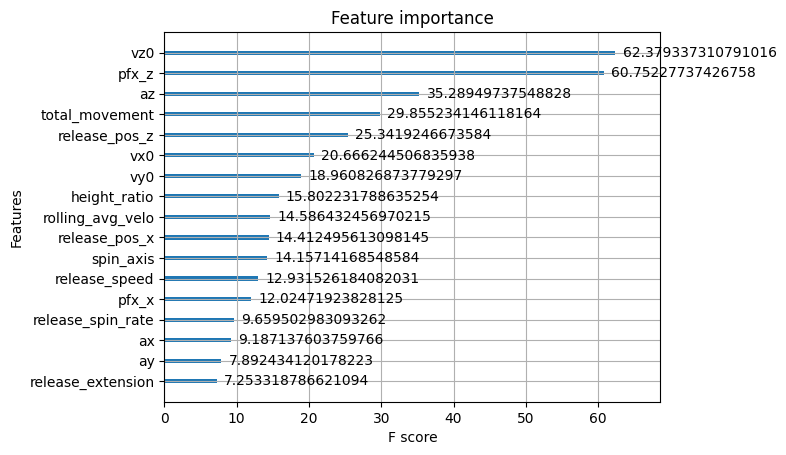

In [41]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

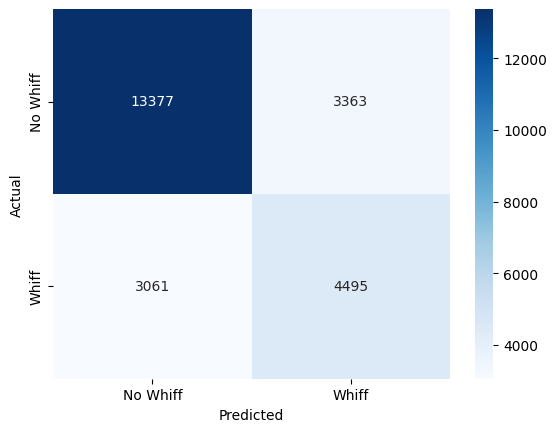

In [42]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [43]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [44]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [45]:
y_pred = final_model.predict(predictions)

In [46]:
testing_identifiers['xwhiff'] = y_pred

In [47]:
testing_identifiers.head()

pitch_id_raw    xwhiff
7   661032_543685_543238_1_59_8  0.509286
8   661032_545361_543238_2_57_8  0.354186
9   661032_545361_543238_3_57_8  0.811016
10  661032_543685_543238_4_59_8  0.822638
11  661032_543685_543238_5_59_8  0.345694

In [48]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/whiff_2022&3_xwhiff.csv")